# Machine Learning framework for network attack detection

Part II

## Achievement:

|Model|Recall|Precision|F1|Recall Attack|Precision Attack|
|-----|---------|------|--|-------------|----------------|
|Baseline|0.83|0.69|0.75|0.00|0.00|
|Logistic Regression|0.92|0.92|0.92|0.70|0.83|
|Random Forest|**0.99**|0.99|0.99|**0.95**|**0.96**|
|Gradient Boost|**0.99**|0.99|0.99|**0.94**|**1.0**|
|Decision Tree|**0.99**|0.99|0.99|**0.95**|**0.97**|


Following notebook will present the performance of different machine learning algorithms by performing binary classification on the [CIC-IDS-2018 dataset](https://www.unb.ca/cic/datasets/ids-2018.html). 

All used features extracted with the help of [CICFlowMeter](https://github.com/ISCX/CICFlowMeter) tool .

following list of algorithms have been tested to get the best performed model and use it as a final working model .

- Dummy classifer 
- logestic regression 
- Random Forest 
- Gradient Boosting
- Support Vector Machine (SVM)
- Decision Tree

In [8]:
#pip install shap
#!pip install scikit-plot
#!pip install eli5
#!pip install catboost
#!pip install imblearn
#!pip install phik
#!pip install phik==0.10.0

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier
from catboost import Pool
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
from scipy.stats import ks_2samp
from scipy.stats import describe
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler



%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/upm/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
path = r"/media/upm/New Volume/project/0/processed"

In [3]:
#path = r'E:\Juypter-files\FINAL\final1.csv'

In [5]:
types = {
    'dst_port': 'uint32',
    'protocol': 'uint8',
    'timestamp': 'object',
    'flow_duration': 'int64',
    'tot_fwd_pkts': 'uint32',
    'tot_bwd_pkts': 'uint32',
    'totlen_fwd_pkts': 'uint32',
    'totlen_bwd_pkts': 'uint32',
    'fwd_pkt_len_max': 'uint16',
    'fwd_pkt_len_min': 'uint16',
    'fwd_pkt_len_mean': 'float32',
    'fwd_pkt_len_std': 'float32',
    'bwd_pkt_len_max': 'uint16',
    'bwd_pkt_len_min': 'uint16',
    'bwd_pkt_len_mean': 'float32',
    'bwd_pkt_len_std': 'float32',
    'flow_byts_s': 'float64',
    'flow_pkts_s': 'float64',
    'flow_iat_mean': 'float32',
    'flow_iat_std': 'float32',
    'flow_iat_max': 'int64',
    'flow_iat_min': 'int64',
    'fwd_iat_tot': 'int64',
    'fwd_iat_mean': 'float32',
    'fwd_iat_std': 'float32',
    'fwd_iat_max': 'int64',
    'fwd_iat_min': 'int64',
    'bwd_iat_tot': 'uint32',
    'bwd_iat_mean': 'float32',
    'bwd_iat_std': 'float32',
    'bwd_iat_max': 'uint32',
    'bwd_iat_min': 'uint32',
    'fwd_psh_flags': 'uint8',
    'bwd_psh_flags': 'uint8',
    'fwd_urg_flags': 'uint8',
    'bwd_urg_flags': 'uint8',
    'fwd_header_len': 'uint32',
    'bwd_header_len': 'uint32',
    'fwd_pkts_s': 'float32',
    'bwd_pkts_s': 'float32',
    'pkt_len_min': 'uint16',
    'pkt_len_max': 'uint16',
    'pkt_len_mean': 'float32',
    'pkt_len_std': 'float32',
    'pkt_len_var': 'float32',
    'fin_flag_cnt': 'uint8',
    'syn_flag_cnt': 'uint8',
    'rst_flag_cnt': 'uint8',
    'psh_flag_cnt': 'uint8',
    'ack_flag_cnt': 'uint8',
    'urg_flag_cnt': 'uint8',
    'cwe_flag_count': 'uint8',
    'ece_flag_cnt': 'uint8',
    'down_up_ratio': 'uint16',
    'pkt_size_avg': 'float32',
    'fwd_seg_size_avg': 'float32',
    'bwd_seg_size_avg': 'float32',
    'fwd_byts_b_avg': 'uint8',
    'fwd_pkts_b_avg': 'uint8',
    'fwd_blk_rate_avg': 'uint8',
    'bwd_byts_b_avg': 'uint8',
    'bwd_pkts_b_avg': 'uint8',
    'bwd_blk_rate_avg': 'uint8',
    'subflow_fwd_pkts': 'uint32',
    'subflow_fwd_byts': 'uint32',
    'subflow_bwd_pkts': 'uint32',
    'subflow_bwd_byts': 'uint32',
    'init_fwd_win_byts': 'int32',
    'init_bwd_win_byts': 'int32',
    'fwd_act_data_pkts': 'uint32',
    'fwd_seg_size_min': 'uint8',
    'active_mean': 'float32',
    'active_std': 'float32',
    'active_max': 'uint32',
    'active_min': 'uint32',
    'idle_mean': 'float32',
    'idle_std': 'float32',
    'idle_max': 'uint64',
    'idle_min': 'uint64',
    'label': 'category'
}


# Data Cleaning


* load the dataset with new values and combine the files to the df 

* clean inf values and repace then with thier mean 

* then replace this negtive value with thier overall mean 

* check features that has feature variance where they are close to zero 

* delete unwanted columns like timestamp and Dst_port

* check feature coorealtion and do it with pandas method corr() or phik matrix then drop them

# 1- load and join

In [5]:
#path1 = r"E:\Juypter-files\dataset1_LOCAL_DATA\csv_files"

#join all csv files avilable in the base path 

csvs = glob.glob(os.path.join(path, '*.csv'))

df = pd.concat((pd.read_csv(f, dtype=types) for f in csvs)) # and concatenate them to one data frame using pandas and change the data types into numeric types


In [6]:
#df = df.loc[df["label"] != 'Benign']

In [7]:
df.shape

(16232943, 80)

In [8]:
df.head()

dst_port  protocol            timestamp  flow_duration  tot_fwd_pkts  \
0       443         6  02/03/2018 08:47:38         141385             9   
1     49684         6  02/03/2018 08:47:38            281             2   
2       443         6  02/03/2018 08:47:40         279824            11   
3       443         6  02/03/2018 08:47:40            132             2   
4       443         6  02/03/2018 08:47:41         274016             9   

   tot_bwd_pkts  totlen_fwd_pkts  totlen_bwd_pkts  fwd_pkt_len_max  \
0             7              553             3773              202   
1             1               38                0               38   
2            15             1086            10527              385   
3             0                0                0                0   
4            13             1285             6141              517   

   fwd_pkt_len_min  ...  fwd_seg_size_min  active_mean  active_std  \
0                0  ...                20          0.0         0.0   
1                0  ...                20          0.0         0.0   
2                0  ...                20          0.0         0.0   
3                0  ...                20          0.0         0.0   
4                0  ...                20          0.0         0.0   

   active_max  active_min  idle_mean  idle_std  idle_max  idle_min   label  
0           0           0        0.0       0.0         0         0  Benign  
1           0           0        0.0       0.0         0         0  Benign  
2           0           0        0.0       0.0         0         0  Benign  
3           0           0        0.0       0.0         0         0  Benign  
4           0           0        0.0       0.0         0         0  Benign  

[5 rows x 80 columns]

In [9]:
#df = df.iloc[:1000000,2:]

# 2- labeling binary

In [10]:
#df['label_cat'] = df.label.astype('category').cat.codes # create a col called label_cat and make its type category using cat.codes (label encoding method) 
df['binary_class'] = (df.label != 'Benign').astype('int') # create binary class col and the data type is int with values 0 and 1 only , so anything not bengin will be a number and bengin is a number notice !=

# 3- infinity values cleaning 

In [11]:
# for loop to check all columns that have inf values in the dataset
inf_values = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
print(inf_values)

['flow_byts_s', 'flow_pkts_s']


In [12]:
# replace inf with nan 
for col in inf_values:
    df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
   
    mean = df[col].mean()
    # fillna method to fill and replace the inf values with columns mean 
    df[col].fillna(mean, inplace=True)

# 4 - replace negtive values with mean

In [13]:
# identify all numeric cols in the dataset 
numeric_cols = df.select_dtypes(include=[np.number]).columns.values
print(numeric_cols)

# take onlly the coulmns where negtive values there 
columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
print("\n",'negtive cols', columns)

['dst_port' 'protocol' 'flow_duration' 'tot_fwd_pkts' 'tot_bwd_pkts'
 'totlen_fwd_pkts' 'totlen_bwd_pkts' 'fwd_pkt_len_max' 'fwd_pkt_len_min'
 'fwd_pkt_len_mean' 'fwd_pkt_len_std' 'bwd_pkt_len_max' 'bwd_pkt_len_min'
 'bwd_pkt_len_mean' 'bwd_pkt_len_std' 'flow_byts_s' 'flow_pkts_s'
 'flow_iat_mean' 'flow_iat_std' 'flow_iat_max' 'flow_iat_min'
 'fwd_iat_tot' 'fwd_iat_mean' 'fwd_iat_std' 'fwd_iat_max' 'fwd_iat_min'
 'bwd_iat_tot' 'bwd_iat_mean' 'bwd_iat_std' 'bwd_iat_max' 'bwd_iat_min'
 'fwd_psh_flags' 'bwd_psh_flags' 'fwd_urg_flags' 'bwd_urg_flags'
 'fwd_header_len' 'bwd_header_len' 'fwd_pkts_s' 'bwd_pkts_s' 'pkt_len_min'
 'pkt_len_max' 'pkt_len_mean' 'pkt_len_std' 'pkt_len_var' 'fin_flag_cnt'
 'syn_flag_cnt' 'rst_flag_cnt' 'psh_flag_cnt' 'ack_flag_cnt'
 'urg_flag_cnt' 'cwe_flag_count' 'ece_flag_cnt' 'down_up_ratio'
 'pkt_size_avg' 'fwd_seg_size_avg' 'bwd_seg_size_avg' 'fwd_byts_b_avg'
 'fwd_pkts_b_avg' 'fwd_blk_rate_avg' 'bwd_byts_b_avg' 'bwd_pkts_b_avg'
 'bwd_blk_rate_avg' 'subflow_fwd

In [14]:
# loop will itrate through the columns to find and replace negtive values with thier mean 
# please note col is short for columns

for col in columns:
    mask = df[col] < 0 # store all columns that are less than zero in mask 
      
    df.loc[mask, col] = np.nan # take only the records in mask(rows) and col(coulmns) which is the negtive
        
    mean = df[col].mean() # store the mean value in mean variable using mean() method
    df[col].fillna(mean, inplace=True) # now using fillna inplace true replace all negtive coulmns stored in col with mean 

# 5- Split the datset into training and prediction  

In [15]:
# load the dataset and split it to X-training , Y-labels

X = df.drop(columns=['label', 'binary_class'])

y = df[['binary_class']]

# 6- look for feature variance 

In [16]:
#calculate variance of each feature, If the variance is low or close to zero, then a feature is approximately constant and will not improve the performance of the model. In that case, it should be removed.
stats = X.describe()
std = stats.loc['std']
features_no_variance = std[std == 0.0].index

pd.Series(features_no_variance).sort_values()

7    bwd_blk_rate_avg
5      bwd_byts_b_avg
6      bwd_pkts_b_avg
0       bwd_psh_flags
1       bwd_urg_flags
4    fwd_blk_rate_avg
2      fwd_byts_b_avg
3      fwd_pkts_b_avg
dtype: object

In [17]:
#then drop features with variance below threshold
X = X.drop(columns=features_no_variance)

# 7- Un-wanted Features

The predictions of a classifier could be not related to the features `timestamp` and `dst_port` in order to recognize attacks, indifferent of time and the destination port they are executed against. so we say goodbay to them .

In [18]:
X= X.drop(columns=['timestamp', 'dst_port'])

# 8- feature coorealtion 

In [19]:
# coorealtion on X features 
cluster_threshold = 1
#X = X.drop(columns=['label'])


In [20]:
corr = spearmanr(X).correlation
#corr = df.drop(columns=['label']).corr()
corr_linkage = hierarchy.ward(corr)

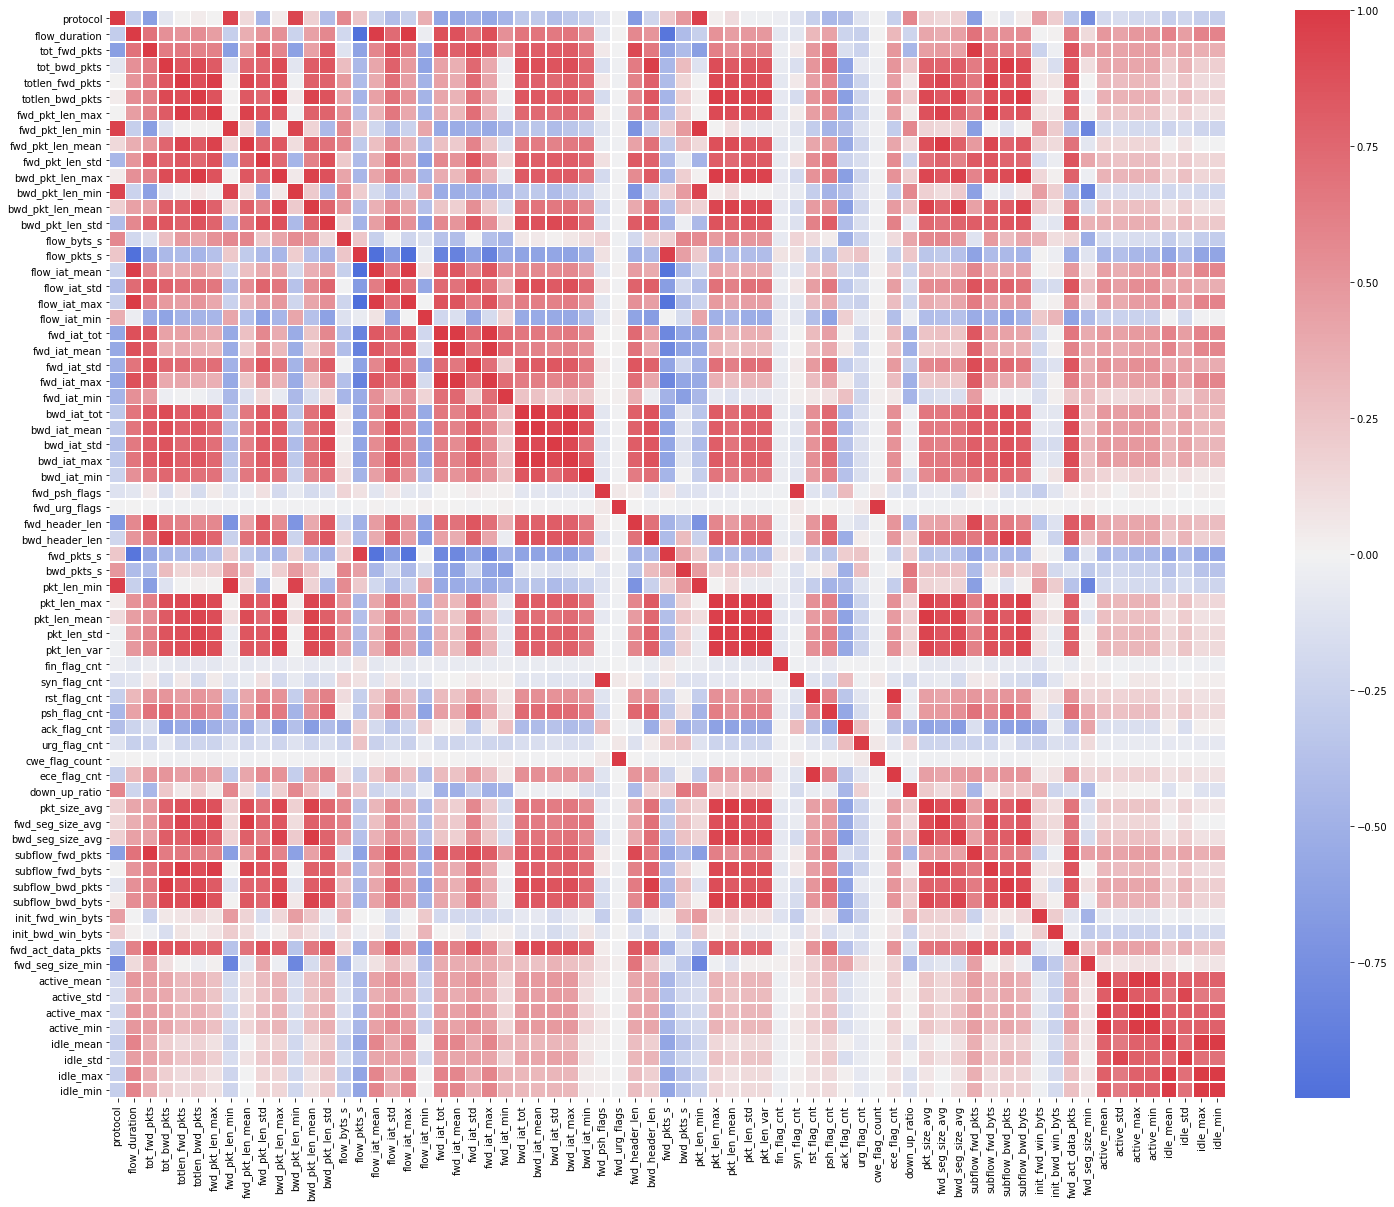

In [21]:
#fig, (ax1) = plt.subplots(figsize=(25, 40))
plt.figure(figsize=(25, 20))

sns.heatmap(corr, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True))

### The heatmap demonstrates that the dataset has a fair amount of features with high correlation amongst each other. In order to remove redundant features the cluster distance threshold of 1 is used to pick features from their respective clusters.

## 8-1 select coorelated features 

In [22]:
cluster_ids = hierarchy.fcluster(corr_linkage, cluster_threshold, criterion='distance')

cluster_id_to_feature_ids = defaultdict(list)


for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]


selected_features = X.columns[selected_features].tolist()

print('Selected features:')
pd.Series(selected_features)

Selected features:


0              protocol
1         flow_duration
2          tot_fwd_pkts
3          tot_bwd_pkts
4       totlen_fwd_pkts
5       totlen_bwd_pkts
6      fwd_pkt_len_mean
7       fwd_pkt_len_std
8      bwd_pkt_len_mean
9           flow_byts_s
10          flow_pkts_s
11         flow_iat_std
12         flow_iat_min
13          fwd_iat_tot
14          fwd_iat_min
15          bwd_iat_tot
16          bwd_iat_min
17        fwd_psh_flags
18        fwd_urg_flags
19           bwd_pkts_s
20         fin_flag_cnt
21         rst_flag_cnt
22         psh_flag_cnt
23         ack_flag_cnt
24         urg_flag_cnt
25        down_up_ratio
26    init_fwd_win_byts
27    init_bwd_win_byts
28     fwd_seg_size_min
29          active_mean
30            idle_mean
dtype: object

In [23]:
# assign new features to the X and dump the coorealted ones 
X = X[selected_features]
print(f"Remaining amount of features: {len(X.columns)}")

Remaining amount of features: 31


## 8-2 plot new coorealtion 

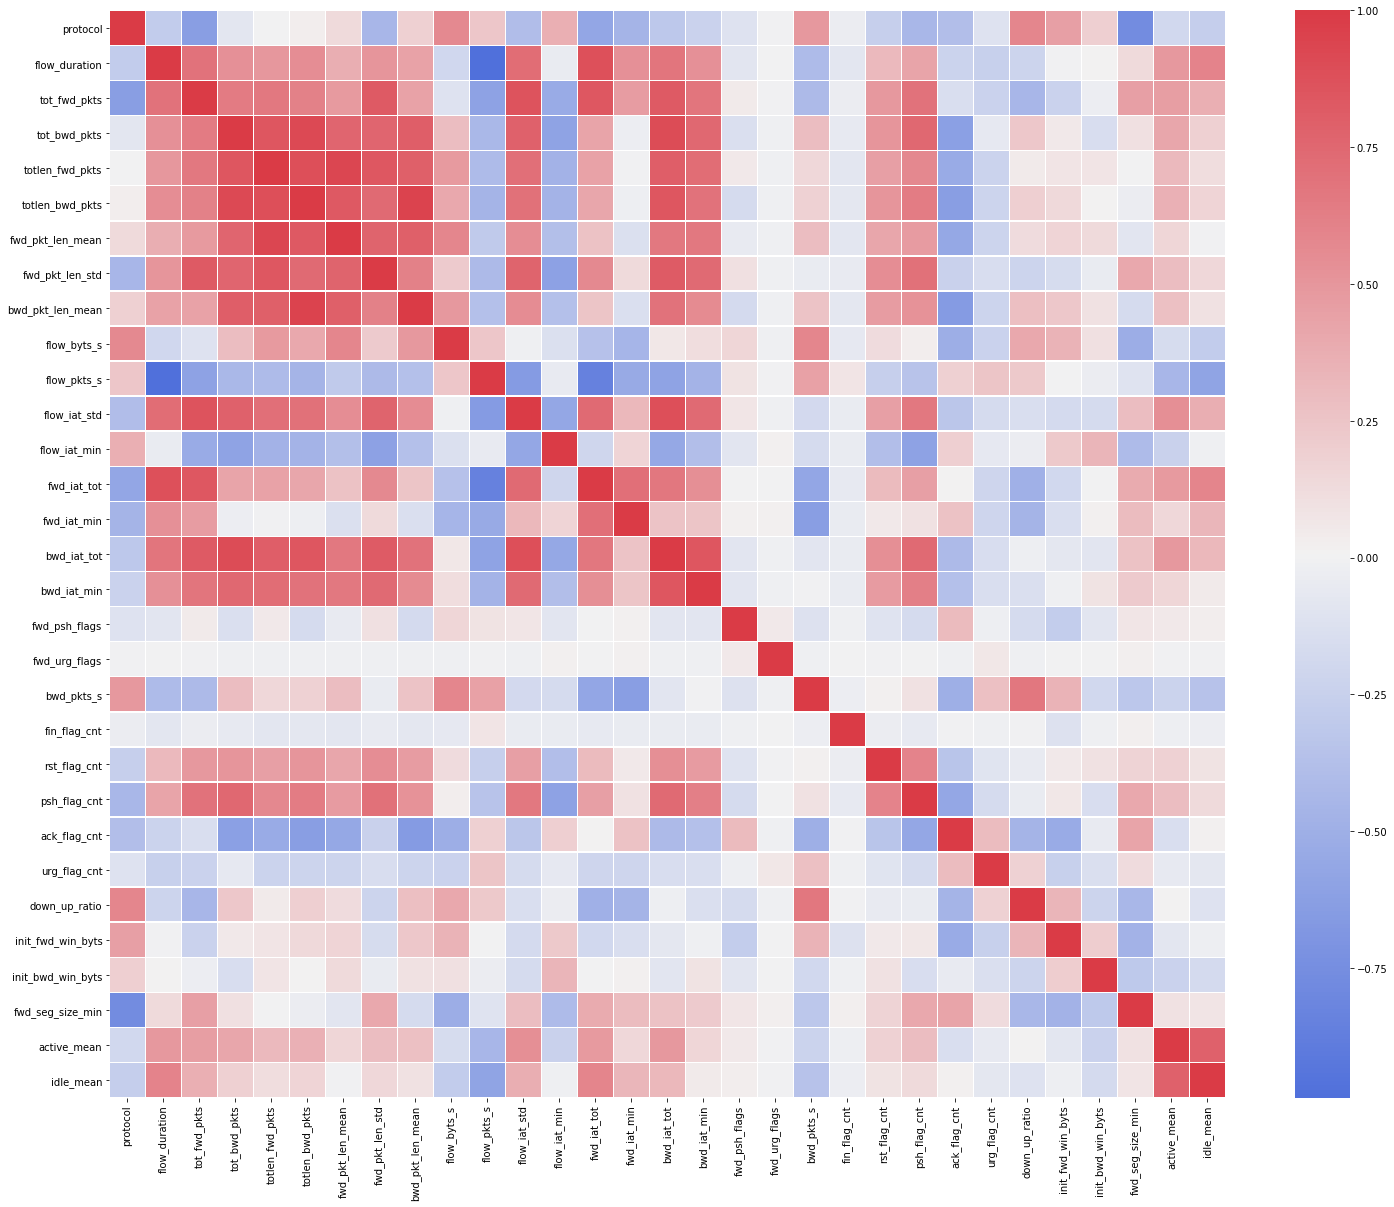

In [24]:
# the new heatmap after dropping the coorelated features 
corr_updated = spearmanr(X).correlation
plt.figure(figsize=(25, 20))
sns.heatmap(corr_updated, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True))

In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16232943 entries, 0 to 613070
Data columns (total 31 columns):
 #   Column             Dtype  
---  ------             -----  
 0   protocol           uint8  
 1   flow_duration      float64
 2   tot_fwd_pkts       uint32 
 3   tot_bwd_pkts       uint32 
 4   totlen_fwd_pkts    uint32 
 5   totlen_bwd_pkts    uint32 
 6   fwd_pkt_len_mean   float32
 7   fwd_pkt_len_std    float32
 8   bwd_pkt_len_mean   float32
 9   flow_byts_s        float64
 10  flow_pkts_s        float64
 11  flow_iat_std       float32
 12  flow_iat_min       float64
 13  fwd_iat_tot        float64
 14  fwd_iat_min        float64
 15  bwd_iat_tot        uint32 
 16  bwd_iat_min        uint32 
 17  fwd_psh_flags      uint8  
 18  fwd_urg_flags      uint8  
 19  bwd_pkts_s         float32
 20  fin_flag_cnt       uint8  
 21  rst_flag_cnt       uint8  
 22  psh_flag_cnt       uint8  
 23  ack_flag_cnt       uint8  
 24  urg_flag_cnt       uint8  
 25  down_up_ratio     

# 9- Dataset train test Split  

In [26]:
#y.drop('label' , axis = 'columns')

In [27]:
# Split X frame into training , testing , and evaluating sets 
# 0.8 training , 0.1 testing , 0.1 evaluation 
# split done with the feature "protocol" being one hot encoded in the training and testing sets 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y , random_state = 101 )

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

# on hot encoding for the feature protocol cuz it is categorical 
X_trainh = pd.get_dummies(X_train, columns=['protocol'])
X_valh = pd.get_dummies(X_val, columns=['protocol'])
X_testh = pd.get_dummies(X_test, columns=['protocol'])

In [28]:
#X_test.to_csv (r'/media/upm/New Volume/project/pep/test.csv', index=False, header=True)

# 10- percentage of the benign labels - imbalance dataset 

In [29]:
percentage_benign = len(y_train.binary_class[y_train.binary_class == 0]) / len(y_train.binary_class)

print('Class occurences:')
print(y_train.binary_class.value_counts())
print('Percentage of benign samples: %.4f' % percentage_benign)

Class occurences:
0    10787766
1     2198588
Name: binary_class, dtype: int64
Percentage of benign samples: 0.8307


# used performance metrics 

the dataset is imbalanced with class `0 - Benign` with`~83%` of all the samples.  



To evaluate the performance of a classifier two metrics will be used:
* `Recall (weighted avg)` will be used as the primary metric as the goal of the classifier should be detect as many attacks as possible. This is the metric that classifiers will be optimized for.


* `Precision (weighted avg)` will be used as a secondary classifier as the the number of false-positives. This metric should be have a value over the threshold of `0.95` to have a maximum of `5%` false-positives.

The `Avg Precision Score` score will also be calculated for each classifier.

# Binary Classification 

#  Dummy Classifier

a `DummyClassifier` is created choosing the class with the most frequent occurences to make predictions. In this case all samples are classified as `0 - Benign` as this is the majority class of the dataset. 

In [30]:
# wrong cls_dummy = DummyClassifier('most_frequent')
# alwayes go back to documention 
dummy_clc = DummyClassifier(strategy="most_frequent")

In [33]:
dummy_clc.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [34]:
print("Classification Report")

print(classification_report(y_test, dummy_clc.predict(X_test)))

Classification Report


/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.83      1.00      0.91   1348471
           1       0.00      0.00      0.00    274824

    accuracy                           0.83   1623295
   macro avg       0.42      0.50      0.45   1623295
weighted avg       0.69      0.83      0.75   1623295



/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 11 - Binary Classifcation models 

## 11- 1 Logistic Regression - LR

Using the Logistic Regression estimator a linear model will be fitted to the data using the [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) 


Using Logistic Regression a weighted recall of `0.93` and a precision of `0.92` which is better that the dummy

In [31]:
scaler = StandardScaler()
scaler.fit(X_trainh)

StandardScaler()

In [32]:
lr = LogisticRegression(solver='saga', n_jobs=-1, verbose=2)

lr.fit(scaler.transform(X_trainh) , y_train)

/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


max_iter reached after 803 seconds


/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 13.4min finished


LogisticRegression(n_jobs=-1, solver='saga', verbose=2)

In [33]:
y_pred = lr.predict(scaler.transform(X_valh))

In [34]:
y_pred1 = lr.predict(scaler.transform(X_testh))

In [35]:
print("Classification Report")
print(classification_report(y_val , y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.96   1348471
           1       0.83      0.70      0.76    274823

    accuracy                           0.93   1623294
   macro avg       0.89      0.83      0.86   1623294
weighted avg       0.92      0.93      0.92   1623294



In [36]:
print("Classification Report")
print(classification_report(y_test , y_pred1))

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.96   1348471
           1       0.83      0.70      0.76    274824

    accuracy                           0.92   1623295
   macro avg       0.89      0.83      0.86   1623295
weighted avg       0.92      0.92      0.92   1623295



## 11-2 Random Forest - RF

The default values are used to train the estimator.  
`RandomForestClassifier` performs very well with recall of `0.99` and precision of `0.99`.

In [37]:
cls_forest = RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced')

In [38]:
cls_forest.fit(X_trainh, y_train)

<ipython-input-38-d14f6098bebd>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  cls_forest.fit(X_trainh, y_train)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.8min finished


RandomForestClassifier(class_weight='balanced', n_jobs=-1, verbose=1)

In [39]:
y_pred = cls_forest.predict(X_valh)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    8.0s finished


In [40]:
y_pred1 = cls_forest.predict(X_testh)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.7s finished


In [41]:
print("Classification Report")
print(classification_report(y_val ,y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1348471
           1       0.96      0.95      0.96    274823

    accuracy                           0.99   1623294
   macro avg       0.98      0.97      0.97   1623294
weighted avg       0.99      0.99      0.99   1623294



In [42]:
print("Classification Report")
print(classification_report(y_test ,y_pred1))

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1348471
           1       0.96      0.95      0.96    274824

    accuracy                           0.99   1623295
   macro avg       0.98      0.97      0.97   1623295
weighted avg       0.99      0.99      0.99   1623295



## 11-3 Gradient Boosting - GB

The last algorithm to evaluate is Gradient Boosting by facilitating the library [CatBoost](https://catboost.ai/). A grid search using cross-validation over a variation of hyper-parameters is performed in order to identify the optimal parameters. 

In [53]:
train_pool = Pool(X_train, y_train, cat_features=['protocol'])
eval_pool = Pool(X_val, y_val , cat_features=['protocol'])
test_pool = Pool(X_test, cat_features=['protocol'])

In [54]:
minority_class_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

In [55]:
cls_cb = CatBoostClassifier(loss_function='Logloss',                        
                            class_weights=[1, minority_class_weight],
                            task_type='GPU',
                            verbose=True)


cls_cb.fit(train_pool, eval_set=test_pool)

Learning rate set to 0.020023


0:	learn: 0.6560188	total: 277ms	remaining: 4m 36s
1:	learn: 0.6214057	total: 520ms	remaining: 4m 19s
2:	learn: 0.5889478	total: 766ms	remaining: 4m 14s
3:	learn: 0.5585514	total: 1.02s	remaining: 4m 13s
4:	learn: 0.5301473	total: 1.26s	remaining: 4m 10s
5:	learn: 0.5028081	total: 1.53s	remaining: 4m 13s
6:	learn: 0.4779071	total: 1.8s	remaining: 4m 15s
7:	learn: 0.4543422	total: 2.05s	remaining: 4m 14s
8:	learn: 0.4334793	total: 2.3s	remaining: 4m 12s
9:	learn: 0.4142048	total: 2.55s	remaining: 4m 12s
10:	learn: 0.3956012	total: 2.79s	remaining: 4m 10s
11:	learn: 0.3776878	total: 3.04s	remaining: 4m 10s
12:	learn: 0.3603162	total: 3.29s	remaining: 4m 9s
13:	learn: 0.3454987	total: 3.54s	remaining: 4m 9s
14:	learn: 0.3317117	total: 3.8s	remaining: 4m 9s
15:	learn: 0.3173423	total: 4.05s	remaining: 4m 9s
16:	learn: 0.3046188	total: 4.29s	remaining: 4m 7s
17:	learn: 0.2927635	total: 4.52s	remaining: 4m 6s
18:	learn: 0.2817615	total: 4.75s	remaining: 4m 5s
19:	learn: 0.2721557	total: 4.99

158:	learn: 0.0600127	total: 36.6s	remaining: 3m 13s
159:	learn: 0.0599335	total: 36.8s	remaining: 3m 13s
160:	learn: 0.0597767	total: 37.1s	remaining: 3m 13s
161:	learn: 0.0596375	total: 37.3s	remaining: 3m 12s
162:	learn: 0.0595481	total: 37.5s	remaining: 3m 12s
163:	learn: 0.0594584	total: 37.7s	remaining: 3m 12s
164:	learn: 0.0593698	total: 38s	remaining: 3m 12s
165:	learn: 0.0592181	total: 38.2s	remaining: 3m 11s
166:	learn: 0.0591430	total: 38.4s	remaining: 3m 11s
167:	learn: 0.0590019	total: 38.6s	remaining: 3m 11s
168:	learn: 0.0589123	total: 38.9s	remaining: 3m 11s
169:	learn: 0.0588419	total: 39.1s	remaining: 3m 10s
170:	learn: 0.0587455	total: 39.3s	remaining: 3m 10s
171:	learn: 0.0586079	total: 39.5s	remaining: 3m 10s
172:	learn: 0.0584685	total: 39.8s	remaining: 3m 10s
173:	learn: 0.0583989	total: 40s	remaining: 3m 9s
174:	learn: 0.0582513	total: 40.2s	remaining: 3m 9s
175:	learn: 0.0580644	total: 40.4s	remaining: 3m 9s
176:	learn: 0.0579951	total: 40.7s	remaining: 3m 9s
1

315:	learn: 0.0515080	total: 1m 11s	remaining: 2m 35s
316:	learn: 0.0514538	total: 1m 12s	remaining: 2m 35s
317:	learn: 0.0514425	total: 1m 12s	remaining: 2m 34s
318:	learn: 0.0514239	total: 1m 12s	remaining: 2m 34s
319:	learn: 0.0514074	total: 1m 12s	remaining: 2m 34s
320:	learn: 0.0513833	total: 1m 12s	remaining: 2m 34s
321:	learn: 0.0513580	total: 1m 13s	remaining: 2m 33s
322:	learn: 0.0513469	total: 1m 13s	remaining: 2m 33s
323:	learn: 0.0513287	total: 1m 13s	remaining: 2m 33s
324:	learn: 0.0513080	total: 1m 13s	remaining: 2m 33s
325:	learn: 0.0512977	total: 1m 14s	remaining: 2m 32s
326:	learn: 0.0512855	total: 1m 14s	remaining: 2m 32s
327:	learn: 0.0512654	total: 1m 14s	remaining: 2m 32s
328:	learn: 0.0512495	total: 1m 14s	remaining: 2m 32s
329:	learn: 0.0512299	total: 1m 14s	remaining: 2m 32s
330:	learn: 0.0512222	total: 1m 15s	remaining: 2m 31s
331:	learn: 0.0511919	total: 1m 15s	remaining: 2m 31s
332:	learn: 0.0511440	total: 1m 15s	remaining: 2m 31s
333:	learn: 0.0511085	total:

468:	learn: 0.0489338	total: 1m 46s	remaining: 2m
469:	learn: 0.0489235	total: 1m 46s	remaining: 1m 59s
470:	learn: 0.0489151	total: 1m 46s	remaining: 1m 59s
471:	learn: 0.0489094	total: 1m 46s	remaining: 1m 59s
472:	learn: 0.0488999	total: 1m 47s	remaining: 1m 59s
473:	learn: 0.0488907	total: 1m 47s	remaining: 1m 59s
474:	learn: 0.0488830	total: 1m 47s	remaining: 1m 58s
475:	learn: 0.0488686	total: 1m 47s	remaining: 1m 58s
476:	learn: 0.0488586	total: 1m 48s	remaining: 1m 58s
477:	learn: 0.0488156	total: 1m 48s	remaining: 1m 58s
478:	learn: 0.0488098	total: 1m 48s	remaining: 1m 57s
479:	learn: 0.0488024	total: 1m 48s	remaining: 1m 57s
480:	learn: 0.0487885	total: 1m 48s	remaining: 1m 57s
481:	learn: 0.0487804	total: 1m 49s	remaining: 1m 57s
482:	learn: 0.0487710	total: 1m 49s	remaining: 1m 57s
483:	learn: 0.0487632	total: 1m 49s	remaining: 1m 56s
484:	learn: 0.0487547	total: 1m 49s	remaining: 1m 56s
485:	learn: 0.0487500	total: 1m 50s	remaining: 1m 56s
486:	learn: 0.0487391	total: 1m 

622:	learn: 0.0477215	total: 2m 19s	remaining: 1m 24s
623:	learn: 0.0477181	total: 2m 19s	remaining: 1m 24s
624:	learn: 0.0477151	total: 2m 20s	remaining: 1m 24s
625:	learn: 0.0477066	total: 2m 20s	remaining: 1m 23s
626:	learn: 0.0477006	total: 2m 20s	remaining: 1m 23s
627:	learn: 0.0476982	total: 2m 20s	remaining: 1m 23s
628:	learn: 0.0476686	total: 2m 21s	remaining: 1m 23s
629:	learn: 0.0476617	total: 2m 21s	remaining: 1m 22s
630:	learn: 0.0476549	total: 2m 21s	remaining: 1m 22s
631:	learn: 0.0476493	total: 2m 21s	remaining: 1m 22s
632:	learn: 0.0476452	total: 2m 21s	remaining: 1m 22s
633:	learn: 0.0476418	total: 2m 22s	remaining: 1m 22s
634:	learn: 0.0476349	total: 2m 22s	remaining: 1m 21s
635:	learn: 0.0476201	total: 2m 22s	remaining: 1m 21s
636:	learn: 0.0476137	total: 2m 22s	remaining: 1m 21s
637:	learn: 0.0475876	total: 2m 23s	remaining: 1m 21s
638:	learn: 0.0475841	total: 2m 23s	remaining: 1m 20s
639:	learn: 0.0475790	total: 2m 23s	remaining: 1m 20s
640:	learn: 0.0475682	total:

776:	learn: 0.0468974	total: 2m 53s	remaining: 49.7s
777:	learn: 0.0468923	total: 2m 53s	remaining: 49.4s
778:	learn: 0.0468885	total: 2m 53s	remaining: 49.2s
779:	learn: 0.0468868	total: 2m 53s	remaining: 49s
780:	learn: 0.0468844	total: 2m 53s	remaining: 48.8s
781:	learn: 0.0468824	total: 2m 54s	remaining: 48.5s
782:	learn: 0.0468788	total: 2m 54s	remaining: 48.3s
783:	learn: 0.0468757	total: 2m 54s	remaining: 48.1s
784:	learn: 0.0468741	total: 2m 54s	remaining: 47.9s
785:	learn: 0.0468710	total: 2m 54s	remaining: 47.6s
786:	learn: 0.0468674	total: 2m 55s	remaining: 47.4s
787:	learn: 0.0468624	total: 2m 55s	remaining: 47.2s
788:	learn: 0.0468594	total: 2m 55s	remaining: 47s
789:	learn: 0.0468569	total: 2m 55s	remaining: 46.7s
790:	learn: 0.0468513	total: 2m 56s	remaining: 46.5s
791:	learn: 0.0468455	total: 2m 56s	remaining: 46.3s
792:	learn: 0.0468426	total: 2m 56s	remaining: 46.1s
793:	learn: 0.0468387	total: 2m 56s	remaining: 45.9s
794:	learn: 0.0468254	total: 2m 56s	remaining: 45.

933:	learn: 0.0462531	total: 3m 27s	remaining: 14.6s
934:	learn: 0.0462504	total: 3m 27s	remaining: 14.4s
935:	learn: 0.0462486	total: 3m 27s	remaining: 14.2s
936:	learn: 0.0462470	total: 3m 27s	remaining: 14s
937:	learn: 0.0462446	total: 3m 27s	remaining: 13.7s
938:	learn: 0.0462432	total: 3m 28s	remaining: 13.5s
939:	learn: 0.0462401	total: 3m 28s	remaining: 13.3s
940:	learn: 0.0462363	total: 3m 28s	remaining: 13.1s
941:	learn: 0.0462334	total: 3m 28s	remaining: 12.9s
942:	learn: 0.0462306	total: 3m 28s	remaining: 12.6s
943:	learn: 0.0462294	total: 3m 29s	remaining: 12.4s
944:	learn: 0.0462263	total: 3m 29s	remaining: 12.2s
945:	learn: 0.0462213	total: 3m 29s	remaining: 12s
946:	learn: 0.0462201	total: 3m 29s	remaining: 11.7s
947:	learn: 0.0462158	total: 3m 30s	remaining: 11.5s
948:	learn: 0.0462099	total: 3m 30s	remaining: 11.3s
949:	learn: 0.0462057	total: 3m 30s	remaining: 11.1s
950:	learn: 0.0462033	total: 3m 30s	remaining: 10.9s
951:	learn: 0.0461981	total: 3m 30s	remaining: 10.

In [56]:
y_pred = cls_cb.predict(X_val)

In [57]:
print("Classification Report")
print(classification_report(y_val, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1348471
           1       1.00      0.94      0.97    274823

    accuracy                           0.99   1623294
   macro avg       0.99      0.97      0.98   1623294
weighted avg       0.99      0.99      0.99   1623294



## 11-4 Support Vector Machine - SVM

In [49]:
scaler = StandardScaler()
scaler.fit(X_trainh)

StandardScaler()

In [50]:
from sklearn.svm import LinearSVC

In [51]:
# Initialize SVM classifier
clf = LinearSVC()

In [ ]:
clf = clf.fit(scaler.transform(X_trainh), y_train.values.ravel())

In [ ]:
predictions = clf.predict(scaler.transform(X_valh))

In [ ]:
predictions1 = clf.predict(scaler.transform(X_testh))

In [ ]:
print("Classification Report")
print(classification_report(y_val, predictions))

In [ ]:
print("Classification Report")
print(classification_report(y_test, predictions1))

## 11-5 Decision Tree Classifier - DT

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
classifier = DecisionTreeClassifier(random_state = 0)

In [47]:
# fit the model
classifier.fit(X_trainh , y_train)

DecisionTreeClassifier(random_state=0)

In [48]:
y_predicted = classifier.predict(X_valh)

In [49]:
# predict validation
y_predicted1 = classifier.predict(X_testh)

In [50]:
print("Classification Report")
print(classification_report(y_val, y_predicted))

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1348471
           1       0.97      0.95      0.96    274823

    accuracy                           0.99   1623294
   macro avg       0.98      0.97      0.97   1623294
weighted avg       0.99      0.99      0.99   1623294



In [51]:
print("Classification Report")
print(classification_report(y_test, y_predicted1))

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1348471
           1       0.97      0.94      0.96    274824

    accuracy                           0.99   1623295
   macro avg       0.98      0.97      0.97   1623295
weighted avg       0.99      0.99      0.99   1623295



## Gradient Boost and RF performed best of all models and will be used as the final estimator.

# 12 - Confusion matrices 

/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


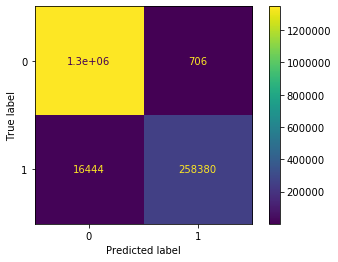

In [58]:
# GB confusion matrix 
matrix = plot_confusion_matrix(cls_cb , X_test , y_test)

plt.show(matrix)
plt.show()

/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.6s finished


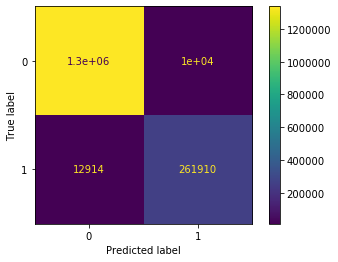

In [43]:
# RF confusion matrix 

matrix = plot_confusion_matrix(cls_forest , X_testh , y_test)

plt.show(matrix)
plt.show()

/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


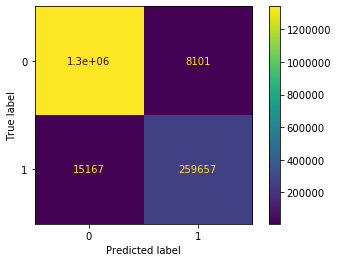

In [52]:
# DT confusion matrix 

matrix = plot_confusion_matrix(classifier , X_testh , y_test)

plt.show(matrix)
plt.show()

In [140]:
# SVM confusion matrix 

matrix = plot_confusion_matrix(clf , X_testh , y_test)

plt.show(matrix)
plt.show()

NameError: name 'clf' is not defined

/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


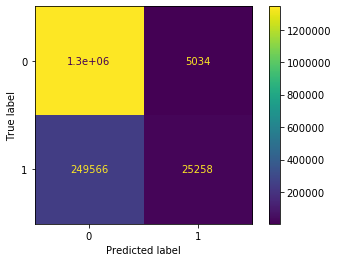

In [44]:
# LR confusion matrix 


matrix = plot_confusion_matrix(lr , X_testh , y_test)

plt.show(matrix)
plt.show()

# 13 -  Model Performance  

## 13.1 Model selection


Gradient Boost performed best of all models and will be used as the final estimator.

In [71]:
estimator = cls_cb

## 13.2 performance on the test set

In [75]:
def print_report(ds_type, cls, X_vals, y_true, y_predict, plot_pr=False, plot_roc=False):
    print(f"Classification Report ({ds_type}):")
    print(classification_report(y_true, y_predict))
    print(f"Avg Precision Score: {average_precision_score(y_true, y_predict, average='weighted')}")
    if plot_roc:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_predict)}")
        skplt.metrics.plot_roc(y_true, cls.predict_proba(X_vals))
        plt.show()
    if plot_pr:
        skplt.metrics.plot_precision_recall(y_true, cls.predict_proba(X_vals))
        plt.show()
    print('\n')

In [73]:
y_pred1 = estimator.predict(X_test)

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1348471
           1       1.00      0.94      0.97    274824

    accuracy                           0.99   1623295
   macro avg       0.99      0.97      0.98   1623295
weighted avg       0.99      0.99      0.99   1623295

Avg Precision Score: 0.9481588355254407


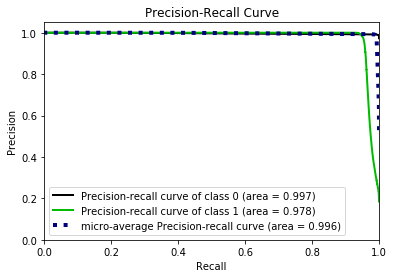

In [76]:
print_report('Test', estimator, test_pool, y_test, estimator.predict(test_pool), plot_pr=True)

## 13.3 Misclassification report

however the model did pretty well during the validation and test phases but various number of attack classes were missclassified   

In [78]:
classifications = y_test.copy()
classifications['pred'] = estimator.predict(test_pool)
counts = classifications.value_counts()

In [83]:
misclassifications = classifications[classifications.binary_class != classifications.pred]
mc = pd.DataFrame(misclassifications.value_counts())

In [84]:
mc['percentage'] = mc.apply(lambda x: x[0] / counts[x.name], axis=1)
mc = mc.sort_values('percentage', ascending=False)

In [85]:
print('Misclassifications:')
display(mc)

Misclassifications:


0  percentage
binary_class pred                   
1            0     16332         1.0
0            1       682         1.0

# 14 - test the Gb estimator on CICIDS-2017

we want to test the classifer on a new set of data that is out of the whole dataframe distrbuation,that will test if the performance is equally good as the performance in the test set above.

In [2]:
cicids2017 = r'/media/upm/New Volume/project/0/cicids2017/cic-ids-2017-20220417T142956Z-001/cic-ids-2017'

In [3]:
def replace_infinity_with_mean(df):
    inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
    for col in inf_columns:
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def replace_negative_values_with_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values
    
    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def load_dataset(files, dtypes, cols=None):
    df = pd.concat((pd.read_csv(f, dtype=dtypes, usecols=cols) for f in files))
    
    df = replace_infinity_with_mean(df)
    df = replace_negative_values_with_mean(df)
        
    df['label_cat'] = df.label.astype('category').cat.codes
    df['label_is_attack'] = (df.label != 'Benign').astype('int')
    return df

In [6]:
files = glob.glob(os.path.join(cicids2017, '*.csv'))

df_novel = load_dataset(files, types, cols=selected_features + ['label'])

X_novel = df_novel.drop(columns=['label', 'label_cat', 'label_is_attack'])
y_novel = df_novel[['label_is_attack', 'label_cat', 'label']]

NameError: name 'selected_features' is not defined

In [69]:
print(f"Number of test samples: {len(X_novel)}")

Number of test samples: 2830743


Classification Report (Novel):
              precision    recall  f1-score   support

           0       0.85      0.97      0.91   2273097
           1       0.70      0.31      0.43    557646

    accuracy                           0.84   2830743
   macro avg       0.78      0.64      0.67   2830743
weighted avg       0.82      0.84      0.81   2830743

Avg Precision Score: 0.35091900310269164


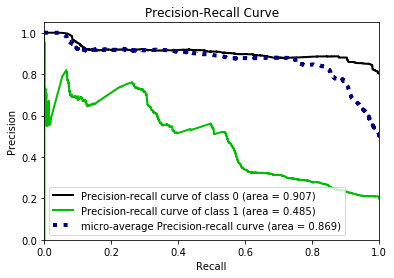

In [92]:
novel_pool = Pool(X_novel, cat_features=['protocol'])

print_report('Novel', estimator, novel_pool, y_novel.label_is_attack, estimator.predict(novel_pool), plot_pr=True)

the estimator has not a very good performance on cicids2017 dataset recorded in a different network environment with a recall of `0.84` and a precision of `0.82`. the estimator's attack recall is `0.31` which is insufficient for real-world usage.  

# 15 - Feature Importance 

In [106]:
#conda install -c conda-forge eli5

In [107]:
#import eli5
#from eli5.sklearn import PermutationImportance


In [108]:
#perm = PermutationImportance(estimator, scoring='recall_weighted', n_iter=3).fit(X_test, y_test.label_is_attack)
#eli5.show_weights(perm, feature_names=X_test.columns.tolist())

In [109]:
#features_to_analyze = ['init_fwd_win_byts', 'fwd_seg_size_min', 'tot_fwd_pkts', 'fwd_iat_tot']

## 16 - Model from combined data

In order to create a estimator that generalizes well on data from different network environments an estimator is created by using the combined [CIC-IDS-2017](https://www.unb.ca/cic/datasets/ids-2017.html) and [CIC-IDS-2018](https://www.unb.ca/cic/datasets/ids-2018.html) datasets.

### 16.1 load combined data 

In [70]:
combined_files = glob.glob(os.path.join(path, '*.csv')) + glob.glob(os.path.join(cicids2017 , '*.csv'))

df = load_dataset(combined_files, types, cols=selected_features + ['label'])

X = df.drop(columns=['label', 'label_cat', 'label_is_attack'])
y = df[['label_is_attack', 'label_cat', 'label']]

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y.label_cat)

### 16.2 Synthetic Oversampling - SMOTE

In order to get a better detection rate for underrepresented attacks `Synthetic Minority Oversampling` is used to push the occurrences of those classes to `100000`.

In [74]:
y_train.label.value_counts()

Benign                      12606243
DoS attacks-Hulk              554388
DDOS attack-HOIC              548809
DDoS attacks-LOIC-HTTP        460953
Bot                           230526
FTP-BruteForce                161038
SSH-Bruteforce                154789
Infilteration                 129576
PortScan                      127144
DoS attacks-SlowHTTPTest      116311
DDOS LOIT                     102422
DoS attacks-GoldenEye          41441
DoS attacks-Slowloris          13429
Brute Force -Web                1694
DDOS attack-LOIC-UDP            1384
Brute Force -XSS                 706
SQL Injection                     86
Heartbleed                         9
Name: label, dtype: int64

In [75]:
# 100000 record for under represented labels 
cnts = y_train.label_cat.value_counts()
sample_dict = {}

for i in np.unique(y_train.label_cat):
    sample_dict[i] = max(cnts[i], 100000)

In [76]:
from imblearn.over_sampling import SMOTENC
sm = SMOTENC(sampling_strategy=sample_dict, categorical_features=[0], n_jobs=24)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train.label_cat)

In [77]:
from collections import Counter
print('Class occurrences:')
Counter(y_train_s)

Class occurrences:


Counter({0: 12606243,
         5: 548809,
         12: 161038,
         9: 554388,
         7: 460953,
         10: 116311,
         1: 230526,
         17: 154789,
         4: 102422,
         14: 129576,
         15: 127144,
         8: 100000,
         11: 100000,
         3: 100000,
         2: 100000,
         6: 100000,
         16: 100000,
         13: 100000})

In [78]:
y_train_s = (y_train_s != 0).astype('int')
print('Binary label occurrences:')
Counter(y_train_s)

Binary label occurrences:


Counter({0: 12606243, 1: 3285956})

# 17. Hyperparameter Optimization - Grid Search 

In [1]:
def train_catboost_grid(train_pool, y_train):
    minority_class_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print(f"Minority class weight: {minority_class_weight}")
    
    param_grid = {
        'iterations': [500, 1000, 1500],
        'learning_rate': [0.3, 0.03, 0.003],
        'depth': [3, 6, 9],
        'l2_leaf_reg': [3, 6]
    }

    cls = CatBoostClassifier(loss_function='Logloss',
                             eval_metric='Recall',
                             class_weights=[1, minority_class_weight],
                             task_type='GPU',
                             verbose=True)

    cb_results = cls.grid_search(param_grid, train_pool)

    print('\nOptimal Parameters:')
    print(cb_results['params'])
    return cls

In [2]:
train_pool = Pool(X_train_s, y_train_s, cat_features=[0])

NameError: name 'Pool' is not defined

In [130]:
comb_estimator = train_catboost_grid(train_pool, y_train_s)

Minority class weight: 3.8364004265425344
0:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 186ms	remaining: 1m 33s
1:	learn: 0.9014953	test: 0.9017309	best: 0.9179181 (0)	total: 381ms	remaining: 1m 34s
2:	learn: 0.9374991	test: 0.9376197	best: 0.9376197 (2)	total: 552ms	remaining: 1m 31s
3:	learn: 0.9374975	test: 0.9376105	best: 0.9376197 (2)	total: 731ms	remaining: 1m 30s
4:	learn: 0.9503681	test: 0.9504658	best: 0.9504658 (4)	total: 908ms	remaining: 1m 29s
5:	learn: 0.9527027	test: 0.9526947	best: 0.9526947 (5)	total: 1.09s	remaining: 1m 29s
6:	learn: 0.9491598	test: 0.9491516	best: 0.9526947 (5)	total: 1.25s	remaining: 1m 28s
7:	learn: 0.9509416	test: 0.9509687	best: 0.9526947 (5)	total: 1.42s	remaining: 1m 27s
8:	learn: 0.9518408	test: 0.9518788	best: 0.9526947 (5)	total: 1.59s	remaining: 1m 26s
9:	learn: 0.9512536	test: 0.9512589	best: 0.9526947 (5)	total: 1.77s	remaining: 1m 26s
10:	learn: 0.9507760	test: 0.9507651	best: 0.9526947 (5)	total: 1.95s	remaining: 1m 26s


94:	learn: 0.9648091	test: 0.9647767	best: 0.9649225 (88)	total: 16.5s	remaining: 1m 10s
95:	learn: 0.9647893	test: 0.9647645	best: 0.9649225 (88)	total: 16.7s	remaining: 1m 10s
96:	learn: 0.9649583	test: 0.9649195	best: 0.9649225 (88)	total: 16.9s	remaining: 1m 10s
97:	learn: 0.9649602	test: 0.9649225	best: 0.9649225 (88)	total: 17s	remaining: 1m 9s
98:	learn: 0.9649568	test: 0.9649362	best: 0.9649362 (98)	total: 17.2s	remaining: 1m 9s
99:	learn: 0.9649572	test: 0.9649377	best: 0.9649377 (99)	total: 17.4s	remaining: 1m 9s
100:	learn: 0.9650104	test: 0.9649909	best: 0.9649909 (100)	total: 17.5s	remaining: 1m 9s
101:	learn: 0.9650192	test: 0.9649970	best: 0.9649970 (101)	total: 17.7s	remaining: 1m 9s
102:	learn: 0.9650314	test: 0.9650061	best: 0.9650061 (102)	total: 17.9s	remaining: 1m 8s
103:	learn: 0.9650188	test: 0.9649955	best: 0.9650061 (102)	total: 18.1s	remaining: 1m 8s
104:	learn: 0.9650416	test: 0.9650319	best: 0.9650319 (104)	total: 18.2s	remaining: 1m 8s
105:	learn: 0.9650375

186:	learn: 0.9663112	test: 0.9663021	best: 0.9663021 (186)	total: 32.3s	remaining: 54s
187:	learn: 0.9663184	test: 0.9663006	best: 0.9663021 (186)	total: 32.4s	remaining: 53.8s
188:	learn: 0.9663081	test: 0.9662900	best: 0.9663021 (186)	total: 32.6s	remaining: 53.6s
189:	learn: 0.9662834	test: 0.9662717	best: 0.9663021 (186)	total: 32.8s	remaining: 53.4s
190:	learn: 0.9662887	test: 0.9662778	best: 0.9663021 (186)	total: 32.9s	remaining: 53.3s
191:	learn: 0.9662883	test: 0.9662733	best: 0.9663021 (186)	total: 33.1s	remaining: 53.1s
192:	learn: 0.9663005	test: 0.9662687	best: 0.9663021 (186)	total: 33.3s	remaining: 52.9s
193:	learn: 0.9662879	test: 0.9662809	best: 0.9663021 (186)	total: 33.5s	remaining: 52.8s
194:	learn: 0.9663211	test: 0.9662945	best: 0.9663021 (186)	total: 33.6s	remaining: 52.6s
195:	learn: 0.9663283	test: 0.9663006	best: 0.9663021 (186)	total: 33.8s	remaining: 52.4s
196:	learn: 0.9663237	test: 0.9662960	best: 0.9663021 (186)	total: 34s	remaining: 52.3s
197:	learn: 0.

278:	learn: 0.9664900	test: 0.9664480	best: 0.9664480 (277)	total: 48.5s	remaining: 38.4s
279:	learn: 0.9664980	test: 0.9664571	best: 0.9664571 (279)	total: 48.6s	remaining: 38.2s
280:	learn: 0.9665090	test: 0.9664829	best: 0.9664829 (280)	total: 48.8s	remaining: 38s
281:	learn: 0.9665155	test: 0.9664905	best: 0.9664905 (281)	total: 49s	remaining: 37.9s
282:	learn: 0.9665300	test: 0.9664996	best: 0.9664996 (282)	total: 49.1s	remaining: 37.7s
283:	learn: 0.9665840	test: 0.9665680	best: 0.9665680 (283)	total: 49.3s	remaining: 37.5s
284:	learn: 0.9665794	test: 0.9665680	best: 0.9665680 (283)	total: 49.5s	remaining: 37.3s
285:	learn: 0.9665764	test: 0.9665619	best: 0.9665680 (283)	total: 49.6s	remaining: 37.2s
286:	learn: 0.9666049	test: 0.9665832	best: 0.9665832 (286)	total: 49.8s	remaining: 37s
287:	learn: 0.9666107	test: 0.9665878	best: 0.9665878 (287)	total: 50s	remaining: 36.8s
288:	learn: 0.9666156	test: 0.9665817	best: 0.9665878 (287)	total: 50.2s	remaining: 36.6s
289:	learn: 0.9665

371:	learn: 0.9670749	test: 0.9670633	best: 0.9670633 (371)	total: 1m 4s	remaining: 22.2s
372:	learn: 0.9670734	test: 0.9670618	best: 0.9670633 (371)	total: 1m 4s	remaining: 22s
373:	learn: 0.9670799	test: 0.9670800	best: 0.9670800 (373)	total: 1m 4s	remaining: 21.9s
374:	learn: 0.9670951	test: 0.9670967	best: 0.9670967 (374)	total: 1m 5s	remaining: 21.7s
375:	learn: 0.9670650	test: 0.9670618	best: 0.9670967 (374)	total: 1m 5s	remaining: 21.5s
376:	learn: 0.9670643	test: 0.9670603	best: 0.9670967 (374)	total: 1m 5s	remaining: 21.3s
377:	learn: 0.9670696	test: 0.9670664	best: 0.9670967 (374)	total: 1m 5s	remaining: 21.2s
378:	learn: 0.9670772	test: 0.9670709	best: 0.9670967 (374)	total: 1m 5s	remaining: 21s
379:	learn: 0.9670898	test: 0.9670800	best: 0.9670967 (374)	total: 1m 5s	remaining: 20.8s
380:	learn: 0.9670787	test: 0.9670724	best: 0.9670967 (374)	total: 1m 6s	remaining: 20.6s
381:	learn: 0.9671320	test: 0.9671256	best: 0.9671256 (381)	total: 1m 6s	remaining: 20.5s
382:	learn: 0.

463:	learn: 0.9676579	test: 0.9676589	best: 0.9676589 (461)	total: 1m 20s	remaining: 6.25s
464:	learn: 0.9676575	test: 0.9676589	best: 0.9676589 (461)	total: 1m 20s	remaining: 6.07s
465:	learn: 0.9676568	test: 0.9676604	best: 0.9676604 (465)	total: 1m 20s	remaining: 5.9s
466:	learn: 0.9676423	test: 0.9676589	best: 0.9676604 (465)	total: 1m 21s	remaining: 5.72s
467:	learn: 0.9676442	test: 0.9676695	best: 0.9676695 (467)	total: 1m 21s	remaining: 5.55s
468:	learn: 0.9676530	test: 0.9676787	best: 0.9676787 (468)	total: 1m 21s	remaining: 5.38s
469:	learn: 0.9676381	test: 0.9676665	best: 0.9676787 (468)	total: 1m 21s	remaining: 5.2s
470:	learn: 0.9676469	test: 0.9676726	best: 0.9676787 (468)	total: 1m 21s	remaining: 5.03s
471:	learn: 0.9676473	test: 0.9676726	best: 0.9676787 (468)	total: 1m 21s	remaining: 4.86s
472:	learn: 0.9676389	test: 0.9676589	best: 0.9676787 (468)	total: 1m 22s	remaining: 4.68s
473:	learn: 0.9676393	test: 0.9676619	best: 0.9676787 (468)	total: 1m 22s	remaining: 4.51s
4

54:	learn: 0.9520596	test: 0.9520384	best: 0.9521873 (50)	total: 9.66s	remaining: 1m 18s
55:	learn: 0.9521243	test: 0.9521113	best: 0.9521873 (50)	total: 9.83s	remaining: 1m 17s
56:	learn: 0.9515717	test: 0.9515704	best: 0.9521873 (50)	total: 10s	remaining: 1m 17s
57:	learn: 0.9521993	test: 0.9521858	best: 0.9521873 (50)	total: 10.2s	remaining: 1m 17s
58:	learn: 0.9516665	test: 0.9516631	best: 0.9521873 (50)	total: 10.3s	remaining: 1m 17s
59:	learn: 0.9516418	test: 0.9516433	best: 0.9521873 (50)	total: 10.5s	remaining: 1m 17s
60:	learn: 0.9516429	test: 0.9516403	best: 0.9521873 (50)	total: 10.7s	remaining: 1m 16s
61:	learn: 0.9516532	test: 0.9516494	best: 0.9521873 (50)	total: 10.9s	remaining: 1m 16s
62:	learn: 0.9516730	test: 0.9516737	best: 0.9521873 (50)	total: 11s	remaining: 1m 16s
63:	learn: 0.9516068	test: 0.9516008	best: 0.9521873 (50)	total: 11.2s	remaining: 1m 16s
64:	learn: 0.9514580	test: 0.9514413	best: 0.9521873 (50)	total: 11.4s	remaining: 1m 16s
65:	learn: 0.9515455	test

148:	learn: 0.9505705	test: 0.9505479	best: 0.9521873 (50)	total: 25.7s	remaining: 1m
149:	learn: 0.9505732	test: 0.9505540	best: 0.9521873 (50)	total: 25.9s	remaining: 1m
150:	learn: 0.9505214	test: 0.9505099	best: 0.9521873 (50)	total: 26.1s	remaining: 1m
151:	learn: 0.9505169	test: 0.9505069	best: 0.9521873 (50)	total: 26.3s	remaining: 1m
152:	learn: 0.9503696	test: 0.9503549	best: 0.9521873 (50)	total: 26.4s	remaining: 60s
153:	learn: 0.9503308	test: 0.9503139	best: 0.9521873 (50)	total: 26.6s	remaining: 59.8s
154:	learn: 0.9503319	test: 0.9503124	best: 0.9521873 (50)	total: 26.8s	remaining: 59.6s
155:	learn: 0.9502771	test: 0.9502790	best: 0.9521873 (50)	total: 26.9s	remaining: 59.4s
156:	learn: 0.9503011	test: 0.9503002	best: 0.9521873 (50)	total: 27.1s	remaining: 59.2s
157:	learn: 0.9503270	test: 0.9503109	best: 0.9521873 (50)	total: 27.3s	remaining: 59s
158:	learn: 0.9503209	test: 0.9503093	best: 0.9521873 (50)	total: 27.4s	remaining: 58.9s
159:	learn: 0.9503197	test: 0.9503063

242:	learn: 0.9613347	test: 0.9612776	best: 0.9618215 (237)	total: 41.8s	remaining: 44.2s
243:	learn: 0.9615722	test: 0.9615587	best: 0.9618215 (237)	total: 42s	remaining: 44s
244:	learn: 0.9615729	test: 0.9615602	best: 0.9618215 (237)	total: 42.2s	remaining: 43.9s
245:	learn: 0.9615623	test: 0.9615496	best: 0.9618215 (237)	total: 42.3s	remaining: 43.7s
246:	learn: 0.9621879	test: 0.9621999	best: 0.9621999 (246)	total: 42.5s	remaining: 43.5s
247:	learn: 0.9621282	test: 0.9621315	best: 0.9621999 (246)	total: 42.7s	remaining: 43.4s
248:	learn: 0.9620574	test: 0.9620434	best: 0.9621999 (246)	total: 42.8s	remaining: 43.2s
249:	learn: 0.9620665	test: 0.9620540	best: 0.9621999 (246)	total: 43s	remaining: 43s
250:	learn: 0.9622142	test: 0.9621999	best: 0.9621999 (246)	total: 43.2s	remaining: 42.8s
251:	learn: 0.9619733	test: 0.9619431	best: 0.9621999 (246)	total: 43.4s	remaining: 42.7s
252:	learn: 0.9618393	test: 0.9618306	best: 0.9621999 (246)	total: 43.5s	remaining: 42.5s
253:	learn: 0.9619

334:	learn: 0.9628805	test: 0.9629914	best: 0.9633713 (289)	total: 57.7s	remaining: 28.4s
335:	learn: 0.9628706	test: 0.9629884	best: 0.9633713 (289)	total: 57.8s	remaining: 28.2s
336:	learn: 0.9628756	test: 0.9629914	best: 0.9633713 (289)	total: 58s	remaining: 28.1s
337:	learn: 0.9628421	test: 0.9629489	best: 0.9633713 (289)	total: 58.2s	remaining: 27.9s
338:	learn: 0.9626784	test: 0.9627635	best: 0.9633713 (289)	total: 58.4s	remaining: 27.7s
339:	learn: 0.9628326	test: 0.9629383	best: 0.9633713 (289)	total: 58.5s	remaining: 27.6s
340:	learn: 0.9628329	test: 0.9629291	best: 0.9633713 (289)	total: 58.7s	remaining: 27.4s
341:	learn: 0.9627656	test: 0.9628517	best: 0.9633713 (289)	total: 58.9s	remaining: 27.2s
342:	learn: 0.9627275	test: 0.9628122	best: 0.9633713 (289)	total: 59.1s	remaining: 27s
343:	learn: 0.9627340	test: 0.9628213	best: 0.9633713 (289)	total: 59.2s	remaining: 26.9s
344:	learn: 0.9627549	test: 0.9628471	best: 0.9633713 (289)	total: 59.4s	remaining: 26.7s
345:	learn: 0.

426:	learn: 0.9629513	test: 0.9629990	best: 0.9633713 (289)	total: 1m 13s	remaining: 12.6s
427:	learn: 0.9629502	test: 0.9630006	best: 0.9633713 (289)	total: 1m 13s	remaining: 12.4s
428:	learn: 0.9629505	test: 0.9630006	best: 0.9633713 (289)	total: 1m 13s	remaining: 12.2s
429:	learn: 0.9629463	test: 0.9629975	best: 0.9633713 (289)	total: 1m 13s	remaining: 12s
430:	learn: 0.9629429	test: 0.9629945	best: 0.9633713 (289)	total: 1m 14s	remaining: 11.9s
431:	learn: 0.9629429	test: 0.9629945	best: 0.9633713 (289)	total: 1m 14s	remaining: 11.7s
432:	learn: 0.9637250	test: 0.9638134	best: 0.9638134 (432)	total: 1m 14s	remaining: 11.5s
433:	learn: 0.9637485	test: 0.9638392	best: 0.9638392 (433)	total: 1m 14s	remaining: 11.3s
434:	learn: 0.9637090	test: 0.9638073	best: 0.9638392 (433)	total: 1m 14s	remaining: 11.2s
435:	learn: 0.9637132	test: 0.9638149	best: 0.9638392 (433)	total: 1m 14s	remaining: 11s
436:	learn: 0.9637086	test: 0.9638058	best: 0.9638392 (433)	total: 1m 15s	remaining: 10.8s
437

16:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 3.02s	remaining: 1m 25s
17:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 3.2s	remaining: 1m 25s
18:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 3.38s	remaining: 1m 25s
19:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 3.56s	remaining: 1m 25s
20:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 3.73s	remaining: 1m 25s
21:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 3.91s	remaining: 1m 24s
22:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 4.09s	remaining: 1m 24s
23:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 4.26s	remaining: 1m 24s
24:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 4.44s	remaining: 1m 24s
25:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 4.62s	remaining: 1m 24s
26:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 4.79s	remaining: 1m 24s
27:	learn: 0.9178711	test: 0.9179

110:	learn: 0.9008492	test: 0.9010654	best: 0.9179181 (0)	total: 19.8s	remaining: 1m 9s
111:	learn: 0.9008492	test: 0.9010654	best: 0.9179181 (0)	total: 19.9s	remaining: 1m 9s
112:	learn: 0.9008492	test: 0.9010654	best: 0.9179181 (0)	total: 20.1s	remaining: 1m 8s
113:	learn: 0.9008492	test: 0.9010654	best: 0.9179181 (0)	total: 20.3s	remaining: 1m 8s
114:	learn: 0.9008492	test: 0.9010654	best: 0.9179181 (0)	total: 20.5s	remaining: 1m 8s
115:	learn: 0.9009945	test: 0.9011960	best: 0.9179181 (0)	total: 20.6s	remaining: 1m 8s
116:	learn: 0.9009945	test: 0.9011960	best: 0.9179181 (0)	total: 20.8s	remaining: 1m 8s
117:	learn: 0.9009945	test: 0.9011960	best: 0.9179181 (0)	total: 21s	remaining: 1m 8s
118:	learn: 0.9006920	test: 0.9008724	best: 0.9179181 (0)	total: 21.2s	remaining: 1m 7s
119:	learn: 0.9006920	test: 0.9008724	best: 0.9179181 (0)	total: 21.4s	remaining: 1m 7s
120:	learn: 0.9006920	test: 0.9008724	best: 0.9179181 (0)	total: 21.5s	remaining: 1m 7s
121:	learn: 0.9006920	test: 0.9008

204:	learn: 0.9148416	test: 0.9148703	best: 0.9179181 (0)	total: 36.8s	remaining: 53s
205:	learn: 0.9148461	test: 0.9148748	best: 0.9179181 (0)	total: 37s	remaining: 52.8s
206:	learn: 0.9148461	test: 0.9148748	best: 0.9179181 (0)	total: 37.2s	remaining: 52.6s
207:	learn: 0.9148461	test: 0.9148748	best: 0.9179181 (0)	total: 37.3s	remaining: 52.4s
208:	learn: 0.9148461	test: 0.9148748	best: 0.9179181 (0)	total: 37.5s	remaining: 52.2s
209:	learn: 0.9148716	test: 0.9148961	best: 0.9179181 (0)	total: 37.7s	remaining: 52s
210:	learn: 0.9148671	test: 0.9148915	best: 0.9179181 (0)	total: 37.9s	remaining: 51.9s
211:	learn: 0.9148716	test: 0.9148961	best: 0.9179181 (0)	total: 38s	remaining: 51.7s
212:	learn: 0.9148716	test: 0.9148961	best: 0.9179181 (0)	total: 38.2s	remaining: 51.5s
213:	learn: 0.9148716	test: 0.9148961	best: 0.9179181 (0)	total: 38.4s	remaining: 51.3s
214:	learn: 0.9148716	test: 0.9148961	best: 0.9179181 (0)	total: 38.6s	remaining: 51.1s
215:	learn: 0.9148716	test: 0.9148961	be

297:	learn: 0.9466391	test: 0.9465656	best: 0.9468558 (285)	total: 53.5s	remaining: 36.3s
298:	learn: 0.9466391	test: 0.9465656	best: 0.9468558 (285)	total: 53.7s	remaining: 36.1s
299:	learn: 0.9466551	test: 0.9465839	best: 0.9468558 (285)	total: 53.9s	remaining: 35.9s
300:	learn: 0.9466551	test: 0.9465839	best: 0.9468558 (285)	total: 54.1s	remaining: 35.7s
301:	learn: 0.9466551	test: 0.9465839	best: 0.9468558 (285)	total: 54.2s	remaining: 35.6s
302:	learn: 0.9466969	test: 0.9466219	best: 0.9468558 (285)	total: 54.4s	remaining: 35.4s
303:	learn: 0.9466969	test: 0.9466219	best: 0.9468558 (285)	total: 54.6s	remaining: 35.2s
304:	learn: 0.9464168	test: 0.9463347	best: 0.9468558 (285)	total: 54.8s	remaining: 35s
305:	learn: 0.9464168	test: 0.9463347	best: 0.9468558 (285)	total: 55s	remaining: 34.8s
306:	learn: 0.9464168	test: 0.9463347	best: 0.9468558 (285)	total: 55.1s	remaining: 34.7s
307:	learn: 0.9464168	test: 0.9463347	best: 0.9468558 (285)	total: 55.3s	remaining: 34.5s
308:	learn: 0.

390:	learn: 0.9468354	test: 0.9467647	best: 0.9468558 (285)	total: 1m 10s	remaining: 19.5s
391:	learn: 0.9467513	test: 0.9466948	best: 0.9468558 (285)	total: 1m 10s	remaining: 19.3s
392:	learn: 0.9467513	test: 0.9466948	best: 0.9468558 (285)	total: 1m 10s	remaining: 19.2s
393:	learn: 0.9467513	test: 0.9466948	best: 0.9468558 (285)	total: 1m 10s	remaining: 19s
394:	learn: 0.9467932	test: 0.9467464	best: 0.9468558 (285)	total: 1m 10s	remaining: 18.8s
395:	learn: 0.9469431	test: 0.9468969	best: 0.9468969 (395)	total: 1m 10s	remaining: 18.6s
396:	learn: 0.9468632	test: 0.9468315	best: 0.9468969 (395)	total: 1m 11s	remaining: 18.4s
397:	learn: 0.9469435	test: 0.9468999	best: 0.9468999 (397)	total: 1m 11s	remaining: 18.3s
398:	learn: 0.9468594	test: 0.9468300	best: 0.9468999 (397)	total: 1m 11s	remaining: 18.1s
399:	learn: 0.9468594	test: 0.9468300	best: 0.9468999 (397)	total: 1m 11s	remaining: 17.9s
400:	learn: 0.9468586	test: 0.9468300	best: 0.9468999 (397)	total: 1m 11s	remaining: 17.7s
4

482:	learn: 0.9517164	test: 0.9516692	best: 0.9516965 (477)	total: 1m 26s	remaining: 3.04s
483:	learn: 0.9517202	test: 0.9516707	best: 0.9516965 (477)	total: 1m 26s	remaining: 2.86s
484:	learn: 0.9517141	test: 0.9516646	best: 0.9516965 (477)	total: 1m 26s	remaining: 2.68s
485:	learn: 0.9517141	test: 0.9516646	best: 0.9516965 (477)	total: 1m 26s	remaining: 2.5s
486:	learn: 0.9517183	test: 0.9516692	best: 0.9516965 (477)	total: 1m 27s	remaining: 2.32s
487:	learn: 0.9517171	test: 0.9516692	best: 0.9516965 (477)	total: 1m 27s	remaining: 2.15s
488:	learn: 0.9517099	test: 0.9516570	best: 0.9516965 (477)	total: 1m 27s	remaining: 1.97s
489:	learn: 0.9517099	test: 0.9516570	best: 0.9516965 (477)	total: 1m 27s	remaining: 1.79s
490:	learn: 0.9517080	test: 0.9516570	best: 0.9516965 (477)	total: 1m 27s	remaining: 1.61s
491:	learn: 0.9517099	test: 0.9516570	best: 0.9516965 (477)	total: 1m 27s	remaining: 1.43s
492:	learn: 0.9522095	test: 0.9521797	best: 0.9521797 (492)	total: 1m 28s	remaining: 1.25s


74:	learn: 0.9638703	test: 0.9637435	best: 0.9639182 (37)	total: 12.9s	remaining: 1m 13s
75:	learn: 0.9641515	test: 0.9640352	best: 0.9640352 (75)	total: 13.1s	remaining: 1m 13s
76:	learn: 0.9640693	test: 0.9639638	best: 0.9640352 (75)	total: 13.3s	remaining: 1m 13s
77:	learn: 0.9643452	test: 0.9642236	best: 0.9642236 (77)	total: 13.5s	remaining: 1m 12s
78:	learn: 0.9642341	test: 0.9641021	best: 0.9642236 (77)	total: 13.6s	remaining: 1m 12s
79:	learn: 0.9642132	test: 0.9640687	best: 0.9642236 (77)	total: 13.8s	remaining: 1m 12s
80:	learn: 0.9642303	test: 0.9640884	best: 0.9642236 (77)	total: 14s	remaining: 1m 12s
81:	learn: 0.9643205	test: 0.9641872	best: 0.9642236 (77)	total: 14.1s	remaining: 1m 12s
82:	learn: 0.9641447	test: 0.9640094	best: 0.9642236 (77)	total: 14.3s	remaining: 1m 11s
83:	learn: 0.9640918	test: 0.9639365	best: 0.9642236 (77)	total: 14.5s	remaining: 1m 11s
84:	learn: 0.9639563	test: 0.9637982	best: 0.9642236 (77)	total: 14.7s	remaining: 1m 11s
85:	learn: 0.9641481	te

166:	learn: 0.9660212	test: 0.9660757	best: 0.9660833 (163)	total: 29.1s	remaining: 58s
167:	learn: 0.9660227	test: 0.9660864	best: 0.9660864 (167)	total: 29.3s	remaining: 57.8s
168:	learn: 0.9659915	test: 0.9660423	best: 0.9660864 (167)	total: 29.4s	remaining: 57.7s
169:	learn: 0.9660585	test: 0.9661259	best: 0.9661259 (169)	total: 29.6s	remaining: 57.5s
170:	learn: 0.9661049	test: 0.9661547	best: 0.9661547 (170)	total: 29.8s	remaining: 57.4s
171:	learn: 0.9661076	test: 0.9661593	best: 0.9661593 (171)	total: 30s	remaining: 57.2s
172:	learn: 0.9661148	test: 0.9661669	best: 0.9661669 (172)	total: 30.2s	remaining: 57s
173:	learn: 0.9660817	test: 0.9661456	best: 0.9661669 (172)	total: 30.3s	remaining: 56.8s
174:	learn: 0.9660783	test: 0.9661426	best: 0.9661669 (172)	total: 30.5s	remaining: 56.6s
175:	learn: 0.9660775	test: 0.9661380	best: 0.9661669 (172)	total: 30.7s	remaining: 56.5s
176:	learn: 0.9660764	test: 0.9661396	best: 0.9661669 (172)	total: 30.8s	remaining: 56.3s
177:	learn: 0.96

258:	learn: 0.9667138	test: 0.9667230	best: 0.9667534 (255)	total: 44.9s	remaining: 41.8s
259:	learn: 0.9666487	test: 0.9666485	best: 0.9667534 (255)	total: 45.1s	remaining: 41.7s
260:	learn: 0.9666529	test: 0.9666485	best: 0.9667534 (255)	total: 45.3s	remaining: 41.5s
261:	learn: 0.9666270	test: 0.9666288	best: 0.9667534 (255)	total: 45.5s	remaining: 41.3s
262:	learn: 0.9666323	test: 0.9666318	best: 0.9667534 (255)	total: 45.7s	remaining: 41.1s
263:	learn: 0.9666259	test: 0.9666318	best: 0.9667534 (255)	total: 45.8s	remaining: 41s
264:	learn: 0.9666293	test: 0.9666303	best: 0.9667534 (255)	total: 46s	remaining: 40.8s
265:	learn: 0.9666175	test: 0.9666212	best: 0.9667534 (255)	total: 46.2s	remaining: 40.6s
266:	learn: 0.9666213	test: 0.9666212	best: 0.9667534 (255)	total: 46.3s	remaining: 40.4s
267:	learn: 0.9666141	test: 0.9666197	best: 0.9667534 (255)	total: 46.5s	remaining: 40.3s
268:	learn: 0.9666502	test: 0.9666607	best: 0.9667534 (255)	total: 46.7s	remaining: 40.1s
269:	learn: 0.

350:	learn: 0.9672032	test: 0.9671985	best: 0.9671985 (349)	total: 1m	remaining: 25.8s
351:	learn: 0.9672047	test: 0.9672046	best: 0.9672046 (351)	total: 1m	remaining: 25.6s
352:	learn: 0.9672123	test: 0.9672107	best: 0.9672107 (352)	total: 1m 1s	remaining: 25.5s
353:	learn: 0.9671628	test: 0.9671621	best: 0.9672107 (352)	total: 1m 1s	remaining: 25.3s
354:	learn: 0.9671621	test: 0.9671575	best: 0.9672107 (352)	total: 1m 1s	remaining: 25.1s
355:	learn: 0.9671621	test: 0.9671575	best: 0.9672107 (352)	total: 1m 1s	remaining: 24.9s
356:	learn: 0.9671271	test: 0.9671226	best: 0.9672107 (352)	total: 1m 1s	remaining: 24.8s
357:	learn: 0.9671236	test: 0.9671241	best: 0.9672107 (352)	total: 1m 2s	remaining: 24.6s
358:	learn: 0.9671872	test: 0.9672001	best: 0.9672107 (352)	total: 1m 2s	remaining: 24.4s
359:	learn: 0.9671895	test: 0.9671985	best: 0.9672107 (352)	total: 1m 2s	remaining: 24.2s
360:	learn: 0.9671830	test: 0.9671985	best: 0.9672107 (352)	total: 1m 2s	remaining: 24.1s
361:	learn: 0.96

442:	learn: 0.9678002	test: 0.9677759	best: 0.9677820 (437)	total: 1m 16s	remaining: 9.84s
443:	learn: 0.9678029	test: 0.9677774	best: 0.9677820 (437)	total: 1m 16s	remaining: 9.67s
444:	learn: 0.9677980	test: 0.9677744	best: 0.9677820 (437)	total: 1m 16s	remaining: 9.5s
445:	learn: 0.9677945	test: 0.9677729	best: 0.9677820 (437)	total: 1m 17s	remaining: 9.32s
446:	learn: 0.9677964	test: 0.9677744	best: 0.9677820 (437)	total: 1m 17s	remaining: 9.15s
447:	learn: 0.9677763	test: 0.9677440	best: 0.9677820 (437)	total: 1m 17s	remaining: 8.98s
448:	learn: 0.9677789	test: 0.9677470	best: 0.9677820 (437)	total: 1m 17s	remaining: 8.81s
449:	learn: 0.9677728	test: 0.9677410	best: 0.9677820 (437)	total: 1m 17s	remaining: 8.63s
450:	learn: 0.9677569	test: 0.9677242	best: 0.9677820 (437)	total: 1m 17s	remaining: 8.46s
451:	learn: 0.9677500	test: 0.9677166	best: 0.9677820 (437)	total: 1m 18s	remaining: 8.29s
452:	learn: 0.9677512	test: 0.9677182	best: 0.9677820 (437)	total: 1m 18s	remaining: 8.11s


32:	learn: 0.9466943	test: 0.9466446	best: 0.9469683 (26)	total: 5.84s	remaining: 1m 22s
33:	learn: 0.9468419	test: 0.9467814	best: 0.9469683 (26)	total: 6.02s	remaining: 1m 22s
34:	learn: 0.9468427	test: 0.9467829	best: 0.9469683 (26)	total: 6.2s	remaining: 1m 22s
35:	learn: 0.9468457	test: 0.9467844	best: 0.9469683 (26)	total: 6.37s	remaining: 1m 22s
36:	learn: 0.9471429	test: 0.9470746	best: 0.9470746 (36)	total: 6.54s	remaining: 1m 21s
37:	learn: 0.9470733	test: 0.9470108	best: 0.9470746 (36)	total: 6.72s	remaining: 1m 21s
38:	learn: 0.9467704	test: 0.9467252	best: 0.9470746 (36)	total: 6.9s	remaining: 1m 21s
39:	learn: 0.9467765	test: 0.9467282	best: 0.9470746 (36)	total: 7.07s	remaining: 1m 21s
40:	learn: 0.9467719	test: 0.9467343	best: 0.9470746 (36)	total: 7.24s	remaining: 1m 21s
41:	learn: 0.9467163	test: 0.9466629	best: 0.9470746 (36)	total: 7.42s	remaining: 1m 20s
42:	learn: 0.9466962	test: 0.9466507	best: 0.9470746 (36)	total: 7.59s	remaining: 1m 20s
43:	learn: 0.9466269	te

126:	learn: 0.9492302	test: 0.9492519	best: 0.9521873 (50)	total: 22.1s	remaining: 1m 4s
127:	learn: 0.9492044	test: 0.9492488	best: 0.9521873 (50)	total: 22.2s	remaining: 1m 4s
128:	learn: 0.9492306	test: 0.9492747	best: 0.9521873 (50)	total: 22.4s	remaining: 1m 4s
129:	learn: 0.9492257	test: 0.9492716	best: 0.9521873 (50)	total: 22.6s	remaining: 1m 4s
130:	learn: 0.9492165	test: 0.9492503	best: 0.9521873 (50)	total: 22.7s	remaining: 1m 4s
131:	learn: 0.9491945	test: 0.9492367	best: 0.9521873 (50)	total: 22.9s	remaining: 1m 3s
132:	learn: 0.9492108	test: 0.9492534	best: 0.9521873 (50)	total: 23.1s	remaining: 1m 3s
133:	learn: 0.9492135	test: 0.9492534	best: 0.9521873 (50)	total: 23.3s	remaining: 1m 3s
134:	learn: 0.9492310	test: 0.9492655	best: 0.9521873 (50)	total: 23.4s	remaining: 1m 3s
135:	learn: 0.9492009	test: 0.9492458	best: 0.9521873 (50)	total: 23.6s	remaining: 1m 3s
136:	learn: 0.9506055	test: 0.9506132	best: 0.9521873 (50)	total: 23.8s	remaining: 1m 2s
137:	learn: 0.9506276

220:	learn: 0.9502969	test: 0.9503063	best: 0.9521873 (50)	total: 38.3s	remaining: 48.3s
221:	learn: 0.9502973	test: 0.9503063	best: 0.9521873 (50)	total: 38.4s	remaining: 48.1s
222:	learn: 0.9503026	test: 0.9503185	best: 0.9521873 (50)	total: 38.6s	remaining: 48s
223:	learn: 0.9502676	test: 0.9502744	best: 0.9521873 (50)	total: 38.8s	remaining: 47.8s
224:	learn: 0.9502444	test: 0.9502546	best: 0.9521873 (50)	total: 39s	remaining: 47.6s
225:	learn: 0.9519907	test: 0.9520201	best: 0.9521873 (50)	total: 39.1s	remaining: 47.4s
226:	learn: 0.9502402	test: 0.9502455	best: 0.9521873 (50)	total: 39.3s	remaining: 47.3s
227:	learn: 0.9502391	test: 0.9502455	best: 0.9521873 (50)	total: 39.5s	remaining: 47.1s
228:	learn: 0.9502345	test: 0.9502395	best: 0.9521873 (50)	total: 39.6s	remaining: 46.9s
229:	learn: 0.9502528	test: 0.9502516	best: 0.9521873 (50)	total: 39.8s	remaining: 46.7s
230:	learn: 0.9519949	test: 0.9520141	best: 0.9521873 (50)	total: 40s	remaining: 46.6s
231:	learn: 0.9519980	test:

312:	learn: 0.9631773	test: 0.9632923	best: 0.9633637 (288)	total: 54.1s	remaining: 32.3s
313:	learn: 0.9631724	test: 0.9632908	best: 0.9633637 (288)	total: 54.3s	remaining: 32.2s
314:	learn: 0.9631815	test: 0.9633014	best: 0.9633637 (288)	total: 54.5s	remaining: 32s
315:	learn: 0.9631945	test: 0.9633257	best: 0.9633637 (288)	total: 54.6s	remaining: 31.8s
316:	learn: 0.9631857	test: 0.9633105	best: 0.9633637 (288)	total: 54.8s	remaining: 31.6s
317:	learn: 0.9631556	test: 0.9632680	best: 0.9633637 (288)	total: 55s	remaining: 31.5s
318:	learn: 0.9631553	test: 0.9632680	best: 0.9633637 (288)	total: 55.2s	remaining: 31.3s
319:	learn: 0.9631610	test: 0.9632695	best: 0.9633637 (288)	total: 55.3s	remaining: 31.1s
320:	learn: 0.9631792	test: 0.9632756	best: 0.9633637 (288)	total: 55.5s	remaining: 31s
321:	learn: 0.9631636	test: 0.9632649	best: 0.9633637 (288)	total: 55.7s	remaining: 30.8s
322:	learn: 0.9631633	test: 0.9632664	best: 0.9633637 (288)	total: 55.9s	remaining: 30.6s
323:	learn: 0.96

405:	learn: 0.9637512	test: 0.9638180	best: 0.9638575 (400)	total: 1m 10s	remaining: 16.3s
406:	learn: 0.9637866	test: 0.9638590	best: 0.9638590 (406)	total: 1m 10s	remaining: 16.1s
407:	learn: 0.9637516	test: 0.9638180	best: 0.9638590 (406)	total: 1m 10s	remaining: 15.9s
408:	learn: 0.9637508	test: 0.9638180	best: 0.9638590 (406)	total: 1m 10s	remaining: 15.8s
409:	learn: 0.9637333	test: 0.9637997	best: 0.9638590 (406)	total: 1m 11s	remaining: 15.6s
410:	learn: 0.9637383	test: 0.9638043	best: 0.9638590 (406)	total: 1m 11s	remaining: 15.4s
411:	learn: 0.9638741	test: 0.9639593	best: 0.9639593 (411)	total: 1m 11s	remaining: 15.2s
412:	learn: 0.9638833	test: 0.9639653	best: 0.9639653 (412)	total: 1m 11s	remaining: 15.1s
413:	learn: 0.9638905	test: 0.9639684	best: 0.9639684 (413)	total: 1m 11s	remaining: 14.9s
414:	learn: 0.9638882	test: 0.9639653	best: 0.9639684 (413)	total: 1m 11s	remaining: 14.7s
415:	learn: 0.9638745	test: 0.9639471	best: 0.9639684 (413)	total: 1m 12s	remaining: 14.6s

497:	learn: 0.9640024	test: 0.9640945	best: 0.9641249 (483)	total: 1m 26s	remaining: 346ms
498:	learn: 0.9640024	test: 0.9640945	best: 0.9641249 (483)	total: 1m 26s	remaining: 173ms
499:	learn: 0.9640012	test: 0.9640930	best: 0.9641249 (483)	total: 1m 26s	remaining: 0us
bestTest = 0.9641248794
bestIteration = 483
4:	loss: 0.9641249	best: 0.9681223 (3)	total: 7m 35s	remaining: 1h 14m 25s
0:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 185ms	remaining: 1m 32s
1:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 361ms	remaining: 1m 29s
2:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 539ms	remaining: 1m 29s
3:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 718ms	remaining: 1m 29s
4:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 898ms	remaining: 1m 28s
5:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 1.07s	remaining: 1m 28s
6:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 1.25s	remaining: 1m 28s
7

90:	learn: 0.9006509	test: 0.9008755	best: 0.9179181 (0)	total: 16.2s	remaining: 1m 12s
91:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 16.4s	remaining: 1m 12s
92:	learn: 0.9162732	test: 0.9162863	best: 0.9179181 (0)	total: 16.6s	remaining: 1m 12s
93:	learn: 0.9006558	test: 0.9008770	best: 0.9179181 (0)	total: 16.7s	remaining: 1m 12s
94:	learn: 0.9006558	test: 0.9008770	best: 0.9179181 (0)	total: 16.9s	remaining: 1m 12s
95:	learn: 0.9006558	test: 0.9008770	best: 0.9179181 (0)	total: 17.1s	remaining: 1m 11s
96:	learn: 0.9006558	test: 0.9008770	best: 0.9179181 (0)	total: 17.3s	remaining: 1m 11s
97:	learn: 0.9006558	test: 0.9008770	best: 0.9179181 (0)	total: 17.4s	remaining: 1m 11s
98:	learn: 0.9008492	test: 0.9010654	best: 0.9179181 (0)	total: 17.6s	remaining: 1m 11s
99:	learn: 0.9008492	test: 0.9010654	best: 0.9179181 (0)	total: 17.8s	remaining: 1m 11s
100:	learn: 0.9008492	test: 0.9010654	best: 0.9179181 (0)	total: 18s	remaining: 1m 10s
101:	learn: 0.9008492	test: 0.901

184:	learn: 0.9025262	test: 0.9027139	best: 0.9179181 (0)	total: 32.8s	remaining: 55.9s
185:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 33s	remaining: 55.7s
186:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 33.2s	remaining: 55.6s
187:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 33.4s	remaining: 55.4s
188:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 33.5s	remaining: 55.2s
189:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 33.7s	remaining: 55s
190:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 33.9s	remaining: 54.8s
191:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 34.1s	remaining: 54.7s
192:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 34.3s	remaining: 54.5s
193:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 34.4s	remaining: 54.3s
194:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 34.6s	remaining: 54.1s
195:	learn: 0.9025536	test: 0.902747

278:	learn: 0.9463247	test: 0.9462359	best: 0.9462359 (278)	total: 49.4s	remaining: 39.1s
279:	learn: 0.9463244	test: 0.9462329	best: 0.9462359 (278)	total: 49.6s	remaining: 39s
280:	learn: 0.9464716	test: 0.9464061	best: 0.9464061 (280)	total: 49.8s	remaining: 38.8s
281:	learn: 0.9462517	test: 0.9461812	best: 0.9464061 (280)	total: 49.9s	remaining: 38.6s
282:	learn: 0.9462517	test: 0.9461812	best: 0.9464061 (280)	total: 50.1s	remaining: 38.4s
283:	learn: 0.9462498	test: 0.9461767	best: 0.9464061 (280)	total: 50.3s	remaining: 38.2s
284:	learn: 0.9469131	test: 0.9468437	best: 0.9468437 (284)	total: 50.5s	remaining: 38.1s
285:	learn: 0.9469131	test: 0.9468437	best: 0.9468437 (284)	total: 50.6s	remaining: 37.9s
286:	learn: 0.9469131	test: 0.9468437	best: 0.9468437 (284)	total: 50.8s	remaining: 37.7s
287:	learn: 0.9469233	test: 0.9468528	best: 0.9468528 (287)	total: 51s	remaining: 37.5s
288:	learn: 0.9467038	test: 0.9466310	best: 0.9468528 (287)	total: 51.2s	remaining: 37.4s
289:	learn: 0.

370:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 5s	remaining: 22.8s
371:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 5s	remaining: 22.6s
372:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 5s	remaining: 22.4s
373:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 6s	remaining: 22.3s
374:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 6s	remaining: 22.1s
375:	learn: 0.9468351	test: 0.9467616	best: 0.9468528 (287)	total: 1m 6s	remaining: 21.9s
376:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 6s	remaining: 21.7s
377:	learn: 0.9468351	test: 0.9467616	best: 0.9468528 (287)	total: 1m 6s	remaining: 21.5s
378:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 6s	remaining: 21.4s
379:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 7s	remaining: 21.2s
380:	learn: 0.9468351	test: 0.9467616	best: 0.9468528 (287)	total: 1m 7s	remaining: 21s
381:	learn: 

462:	learn: 0.9518438	test: 0.9517922	best: 0.9517922 (462)	total: 1m 21s	remaining: 6.52s
463:	learn: 0.9518438	test: 0.9517922	best: 0.9517922 (462)	total: 1m 21s	remaining: 6.34s
464:	learn: 0.9518397	test: 0.9517877	best: 0.9517922 (462)	total: 1m 21s	remaining: 6.16s
465:	learn: 0.9518393	test: 0.9517877	best: 0.9517922 (462)	total: 1m 22s	remaining: 5.99s
466:	learn: 0.9518370	test: 0.9517877	best: 0.9517922 (462)	total: 1m 22s	remaining: 5.81s
467:	learn: 0.9518370	test: 0.9517877	best: 0.9517922 (462)	total: 1m 22s	remaining: 5.63s
468:	learn: 0.9518389	test: 0.9517877	best: 0.9517922 (462)	total: 1m 22s	remaining: 5.46s
469:	learn: 0.9518393	test: 0.9517877	best: 0.9517922 (462)	total: 1m 22s	remaining: 5.28s
470:	learn: 0.9518370	test: 0.9517877	best: 0.9517922 (462)	total: 1m 22s	remaining: 5.11s
471:	learn: 0.9518370	test: 0.9517877	best: 0.9517922 (462)	total: 1m 23s	remaining: 4.93s
472:	learn: 0.9518461	test: 0.9517953	best: 0.9517953 (472)	total: 1m 23s	remaining: 4.75s

54:	learn: 0.9635978	test: 0.9635263	best: 0.9639182 (37)	total: 9.43s	remaining: 2m 41s
55:	learn: 0.9635141	test: 0.9634336	best: 0.9639182 (37)	total: 9.58s	remaining: 2m 41s
56:	learn: 0.9636214	test: 0.9635627	best: 0.9639182 (37)	total: 9.76s	remaining: 2m 41s
57:	learn: 0.9636960	test: 0.9636493	best: 0.9639182 (37)	total: 9.93s	remaining: 2m 41s
58:	learn: 0.9639358	test: 0.9638727	best: 0.9639182 (37)	total: 10.1s	remaining: 2m 41s
59:	learn: 0.9644594	test: 0.9644728	best: 0.9644728 (59)	total: 10.3s	remaining: 2m 40s
60:	learn: 0.9644061	test: 0.9644303	best: 0.9644728 (59)	total: 10.4s	remaining: 2m 40s
61:	learn: 0.9644689	test: 0.9644895	best: 0.9644895 (61)	total: 10.6s	remaining: 2m 40s
62:	learn: 0.9643715	test: 0.9643817	best: 0.9644895 (61)	total: 10.8s	remaining: 2m 40s
63:	learn: 0.9645663	test: 0.9645837	best: 0.9645837 (63)	total: 11s	remaining: 2m 40s
64:	learn: 0.9645728	test: 0.9645868	best: 0.9645868 (64)	total: 11.1s	remaining: 2m 40s
65:	learn: 0.9644880	te

146:	learn: 0.9657601	test: 0.9657506	best: 0.9657506 (146)	total: 25.1s	remaining: 2m 25s
147:	learn: 0.9658994	test: 0.9658919	best: 0.9658919 (147)	total: 25.2s	remaining: 2m 25s
148:	learn: 0.9659025	test: 0.9658843	best: 0.9658919 (147)	total: 25.4s	remaining: 2m 25s
149:	learn: 0.9659123	test: 0.9659056	best: 0.9659056 (149)	total: 25.6s	remaining: 2m 25s
150:	learn: 0.9659276	test: 0.9659162	best: 0.9659162 (150)	total: 25.8s	remaining: 2m 24s
151:	learn: 0.9659123	test: 0.9658980	best: 0.9659162 (150)	total: 25.9s	remaining: 2m 24s
152:	learn: 0.9658271	test: 0.9658205	best: 0.9659162 (150)	total: 26.1s	remaining: 2m 24s
153:	learn: 0.9657597	test: 0.9657415	best: 0.9659162 (150)	total: 26.3s	remaining: 2m 24s
154:	learn: 0.9657788	test: 0.9657567	best: 0.9659162 (150)	total: 26.5s	remaining: 2m 24s
155:	learn: 0.9657826	test: 0.9657658	best: 0.9659162 (150)	total: 26.6s	remaining: 2m 24s
156:	learn: 0.9657750	test: 0.9657749	best: 0.9659162 (150)	total: 26.8s	remaining: 2m 23s

238:	learn: 0.9663975	test: 0.9663355	best: 0.9663599 (237)	total: 40.8s	remaining: 2m 9s
239:	learn: 0.9664074	test: 0.9663477	best: 0.9663599 (237)	total: 40.9s	remaining: 2m 9s
240:	learn: 0.9664158	test: 0.9663523	best: 0.9663599 (237)	total: 41.1s	remaining: 2m 9s
241:	learn: 0.9664143	test: 0.9663492	best: 0.9663599 (237)	total: 41.3s	remaining: 2m 9s
242:	learn: 0.9663873	test: 0.9663173	best: 0.9663599 (237)	total: 41.5s	remaining: 2m 9s
243:	learn: 0.9663865	test: 0.9663173	best: 0.9663599 (237)	total: 41.6s	remaining: 2m 8s
244:	learn: 0.9664135	test: 0.9663355	best: 0.9663599 (237)	total: 41.8s	remaining: 2m 8s
245:	learn: 0.9663972	test: 0.9663295	best: 0.9663599 (237)	total: 42s	remaining: 2m 8s
246:	learn: 0.9663880	test: 0.9663249	best: 0.9663599 (237)	total: 42.2s	remaining: 2m 8s
247:	learn: 0.9664367	test: 0.9663690	best: 0.9663690 (247)	total: 42.3s	remaining: 2m 8s
248:	learn: 0.9664356	test: 0.9663659	best: 0.9663690 (247)	total: 42.5s	remaining: 2m 8s
249:	learn: 

330:	learn: 0.9667202	test: 0.9667291	best: 0.9667898 (316)	total: 56.5s	remaining: 1m 54s
331:	learn: 0.9667301	test: 0.9667412	best: 0.9667898 (316)	total: 56.7s	remaining: 1m 53s
332:	learn: 0.9667359	test: 0.9667443	best: 0.9667898 (316)	total: 56.8s	remaining: 1m 53s
333:	learn: 0.9667309	test: 0.9667412	best: 0.9667898 (316)	total: 57s	remaining: 1m 53s
334:	learn: 0.9667606	test: 0.9667731	best: 0.9667898 (316)	total: 57.2s	remaining: 1m 53s
335:	learn: 0.9667823	test: 0.9667929	best: 0.9667929 (335)	total: 57.3s	remaining: 1m 53s
336:	learn: 0.9667838	test: 0.9667974	best: 0.9667974 (336)	total: 57.5s	remaining: 1m 53s
337:	learn: 0.9667766	test: 0.9667883	best: 0.9667974 (336)	total: 57.7s	remaining: 1m 52s
338:	learn: 0.9667800	test: 0.9667898	best: 0.9667974 (336)	total: 57.8s	remaining: 1m 52s
339:	learn: 0.9667385	test: 0.9667534	best: 0.9667974 (336)	total: 58s	remaining: 1m 52s
340:	learn: 0.9667610	test: 0.9667746	best: 0.9667974 (336)	total: 58.2s	remaining: 1m 52s
341

422:	learn: 0.9674954	test: 0.9674872	best: 0.9674994 (415)	total: 1m 12s	remaining: 1m 38s
423:	learn: 0.9674943	test: 0.9674857	best: 0.9674994 (415)	total: 1m 12s	remaining: 1m 38s
424:	learn: 0.9675008	test: 0.9674918	best: 0.9674994 (415)	total: 1m 12s	remaining: 1m 37s
425:	learn: 0.9675019	test: 0.9675009	best: 0.9675009 (425)	total: 1m 12s	remaining: 1m 37s
426:	learn: 0.9674977	test: 0.9674979	best: 0.9675009 (425)	total: 1m 12s	remaining: 1m 37s
427:	learn: 0.9675114	test: 0.9675161	best: 0.9675161 (427)	total: 1m 12s	remaining: 1m 37s
428:	learn: 0.9675179	test: 0.9675161	best: 0.9675161 (427)	total: 1m 13s	remaining: 1m 37s
429:	learn: 0.9675491	test: 0.9675571	best: 0.9675571 (429)	total: 1m 13s	remaining: 1m 37s
430:	learn: 0.9675590	test: 0.9675677	best: 0.9675677 (430)	total: 1m 13s	remaining: 1m 36s
431:	learn: 0.9675723	test: 0.9675845	best: 0.9675845 (431)	total: 1m 13s	remaining: 1m 36s
432:	learn: 0.9675894	test: 0.9676042	best: 0.9676042 (432)	total: 1m 13s	remain

512:	learn: 0.9679380	test: 0.9679050	best: 0.9679050 (512)	total: 1m 27s	remaining: 1m 22s
513:	learn: 0.9679437	test: 0.9679218	best: 0.9679218 (513)	total: 1m 27s	remaining: 1m 22s
514:	learn: 0.9680095	test: 0.9679962	best: 0.9679962 (514)	total: 1m 27s	remaining: 1m 22s
515:	learn: 0.9680065	test: 0.9679917	best: 0.9679962 (514)	total: 1m 27s	remaining: 1m 22s
516:	learn: 0.9680183	test: 0.9680008	best: 0.9680008 (516)	total: 1m 28s	remaining: 1m 22s
517:	learn: 0.9680175	test: 0.9679962	best: 0.9680008 (516)	total: 1m 28s	remaining: 1m 22s
518:	learn: 0.9680198	test: 0.9679992	best: 0.9680008 (516)	total: 1m 28s	remaining: 1m 21s
519:	learn: 0.9680156	test: 0.9679932	best: 0.9680008 (516)	total: 1m 28s	remaining: 1m 21s
520:	learn: 0.9680217	test: 0.9679962	best: 0.9680008 (516)	total: 1m 28s	remaining: 1m 21s
521:	learn: 0.9680198	test: 0.9679977	best: 0.9680008 (516)	total: 1m 28s	remaining: 1m 21s
522:	learn: 0.9680255	test: 0.9679947	best: 0.9680008 (516)	total: 1m 29s	remain

602:	learn: 0.9683189	test: 0.9682743	best: 0.9682910 (600)	total: 1m 42s	remaining: 1m 7s
603:	learn: 0.9683197	test: 0.9682712	best: 0.9682910 (600)	total: 1m 43s	remaining: 1m 7s
604:	learn: 0.9683296	test: 0.9682788	best: 0.9682910 (600)	total: 1m 43s	remaining: 1m 7s
605:	learn: 0.9683399	test: 0.9682940	best: 0.9682940 (605)	total: 1m 43s	remaining: 1m 7s
606:	learn: 0.9683380	test: 0.9682940	best: 0.9682940 (605)	total: 1m 43s	remaining: 1m 7s
607:	learn: 0.9683395	test: 0.9682970	best: 0.9682970 (607)	total: 1m 43s	remaining: 1m 6s
608:	learn: 0.9683414	test: 0.9682970	best: 0.9682970 (607)	total: 1m 43s	remaining: 1m 6s
609:	learn: 0.9683444	test: 0.9682986	best: 0.9682986 (609)	total: 1m 44s	remaining: 1m 6s
610:	learn: 0.9683479	test: 0.9683062	best: 0.9683062 (610)	total: 1m 44s	remaining: 1m 6s
611:	learn: 0.9683486	test: 0.9683046	best: 0.9683062 (610)	total: 1m 44s	remaining: 1m 6s
612:	learn: 0.9683304	test: 0.9682864	best: 0.9683062 (610)	total: 1m 44s	remaining: 1m 6s

694:	learn: 0.9683958	test: 0.9683320	best: 0.9683836 (648)	total: 1m 58s	remaining: 52.1s
695:	learn: 0.9683935	test: 0.9683289	best: 0.9683836 (648)	total: 1m 58s	remaining: 51.9s
696:	learn: 0.9684065	test: 0.9683350	best: 0.9683836 (648)	total: 1m 59s	remaining: 51.8s
697:	learn: 0.9684084	test: 0.9683350	best: 0.9683836 (648)	total: 1m 59s	remaining: 51.6s
698:	learn: 0.9684126	test: 0.9683396	best: 0.9683836 (648)	total: 1m 59s	remaining: 51.4s
699:	learn: 0.9684106	test: 0.9683335	best: 0.9683836 (648)	total: 1m 59s	remaining: 51.2s
700:	learn: 0.9684103	test: 0.9683335	best: 0.9683836 (648)	total: 1m 59s	remaining: 51.1s
701:	learn: 0.9684057	test: 0.9683320	best: 0.9683836 (648)	total: 1m 59s	remaining: 50.9s
702:	learn: 0.9684042	test: 0.9683305	best: 0.9683836 (648)	total: 2m	remaining: 50.7s
703:	learn: 0.9683871	test: 0.9683198	best: 0.9683836 (648)	total: 2m	remaining: 50.6s
704:	learn: 0.9683848	test: 0.9683183	best: 0.9683836 (648)	total: 2m	remaining: 50.4s
705:	learn:

786:	learn: 0.9685834	test: 0.9684961	best: 0.9684961 (760)	total: 2m 14s	remaining: 36.4s
787:	learn: 0.9685830	test: 0.9684961	best: 0.9684961 (760)	total: 2m 14s	remaining: 36.2s
788:	learn: 0.9685739	test: 0.9684824	best: 0.9684961 (760)	total: 2m 14s	remaining: 36s
789:	learn: 0.9685830	test: 0.9684870	best: 0.9684961 (760)	total: 2m 14s	remaining: 35.9s
790:	learn: 0.9685846	test: 0.9684885	best: 0.9684961 (760)	total: 2m 15s	remaining: 35.7s
791:	learn: 0.9685789	test: 0.9684870	best: 0.9684961 (760)	total: 2m 15s	remaining: 35.5s
792:	learn: 0.9685739	test: 0.9684809	best: 0.9684961 (760)	total: 2m 15s	remaining: 35.4s
793:	learn: 0.9685743	test: 0.9684794	best: 0.9684961 (760)	total: 2m 15s	remaining: 35.2s
794:	learn: 0.9685747	test: 0.9684794	best: 0.9684961 (760)	total: 2m 15s	remaining: 35s
795:	learn: 0.9685789	test: 0.9684885	best: 0.9684961 (760)	total: 2m 15s	remaining: 34.8s
796:	learn: 0.9685796	test: 0.9684885	best: 0.9684961 (760)	total: 2m 16s	remaining: 34.7s
797

878:	learn: 0.9687356	test: 0.9686526	best: 0.9686526 (878)	total: 2m 30s	remaining: 20.7s
879:	learn: 0.9687524	test: 0.9686647	best: 0.9686647 (879)	total: 2m 30s	remaining: 20.5s
880:	learn: 0.9687588	test: 0.9686875	best: 0.9686875 (880)	total: 2m 30s	remaining: 20.3s
881:	learn: 0.9687786	test: 0.9687027	best: 0.9687027 (881)	total: 2m 30s	remaining: 20.1s
882:	learn: 0.9687649	test: 0.9686860	best: 0.9687027 (881)	total: 2m 30s	remaining: 20s
883:	learn: 0.9687843	test: 0.9687073	best: 0.9687073 (883)	total: 2m 30s	remaining: 19.8s
884:	learn: 0.9687805	test: 0.9687027	best: 0.9687073 (883)	total: 2m 31s	remaining: 19.6s
885:	learn: 0.9687661	test: 0.9686921	best: 0.9687073 (883)	total: 2m 31s	remaining: 19.5s
886:	learn: 0.9687569	test: 0.9686799	best: 0.9687073 (883)	total: 2m 31s	remaining: 19.3s
887:	learn: 0.9687573	test: 0.9686830	best: 0.9687073 (883)	total: 2m 31s	remaining: 19.1s
888:	learn: 0.9687569	test: 0.9686754	best: 0.9687073 (883)	total: 2m 31s	remaining: 19s
889

970:	learn: 0.9687920	test: 0.9686845	best: 0.9687468 (954)	total: 2m 45s	remaining: 4.95s
971:	learn: 0.9688053	test: 0.9687042	best: 0.9687468 (954)	total: 2m 45s	remaining: 4.78s
972:	learn: 0.9688346	test: 0.9687331	best: 0.9687468 (954)	total: 2m 46s	remaining: 4.61s
973:	learn: 0.9688346	test: 0.9687331	best: 0.9687468 (954)	total: 2m 46s	remaining: 4.44s
974:	learn: 0.9688342	test: 0.9687331	best: 0.9687468 (954)	total: 2m 46s	remaining: 4.27s
975:	learn: 0.9688334	test: 0.9687361	best: 0.9687468 (954)	total: 2m 46s	remaining: 4.1s
976:	learn: 0.9688293	test: 0.9687285	best: 0.9687468 (954)	total: 2m 46s	remaining: 3.93s
977:	learn: 0.9688331	test: 0.9687331	best: 0.9687468 (954)	total: 2m 46s	remaining: 3.75s
978:	learn: 0.9688312	test: 0.9687316	best: 0.9687468 (954)	total: 2m 47s	remaining: 3.58s
979:	learn: 0.9688308	test: 0.9687316	best: 0.9687468 (954)	total: 2m 47s	remaining: 3.41s
980:	learn: 0.9688308	test: 0.9687316	best: 0.9687468 (954)	total: 2m 47s	remaining: 3.24s


62:	learn: 0.9516730	test: 0.9516737	best: 0.9521873 (50)	total: 11s	remaining: 2m 44s
63:	learn: 0.9516068	test: 0.9516008	best: 0.9521873 (50)	total: 11.2s	remaining: 2m 44s
64:	learn: 0.9514580	test: 0.9514413	best: 0.9521873 (50)	total: 11.4s	remaining: 2m 43s
65:	learn: 0.9515455	test: 0.9515127	best: 0.9521873 (50)	total: 11.6s	remaining: 2m 43s
66:	learn: 0.9516144	test: 0.9516054	best: 0.9521873 (50)	total: 11.7s	remaining: 2m 43s
67:	learn: 0.9514679	test: 0.9514519	best: 0.9521873 (50)	total: 11.9s	remaining: 2m 43s
68:	learn: 0.9517148	test: 0.9517011	best: 0.9521873 (50)	total: 12.1s	remaining: 2m 42s
69:	learn: 0.9515873	test: 0.9515719	best: 0.9521873 (50)	total: 12.2s	remaining: 2m 42s
70:	learn: 0.9514652	test: 0.9514306	best: 0.9521873 (50)	total: 12.4s	remaining: 2m 42s
71:	learn: 0.9515287	test: 0.9514899	best: 0.9521873 (50)	total: 12.6s	remaining: 2m 42s
72:	learn: 0.9514408	test: 0.9513866	best: 0.9521873 (50)	total: 12.8s	remaining: 2m 41s
73:	learn: 0.9511722	te

154:	learn: 0.9503319	test: 0.9503124	best: 0.9521873 (50)	total: 26.8s	remaining: 2m 26s
155:	learn: 0.9502771	test: 0.9502790	best: 0.9521873 (50)	total: 27s	remaining: 2m 25s
156:	learn: 0.9503011	test: 0.9503002	best: 0.9521873 (50)	total: 27.1s	remaining: 2m 25s
157:	learn: 0.9503270	test: 0.9503109	best: 0.9521873 (50)	total: 27.3s	remaining: 2m 25s
158:	learn: 0.9503209	test: 0.9503093	best: 0.9521873 (50)	total: 27.5s	remaining: 2m 25s
159:	learn: 0.9503197	test: 0.9503063	best: 0.9521873 (50)	total: 27.7s	remaining: 2m 25s
160:	learn: 0.9502790	test: 0.9502698	best: 0.9521873 (50)	total: 27.8s	remaining: 2m 25s
161:	learn: 0.9502764	test: 0.9502638	best: 0.9521873 (50)	total: 28s	remaining: 2m 24s
162:	learn: 0.9502589	test: 0.9502410	best: 0.9521873 (50)	total: 28.2s	remaining: 2m 24s
163:	learn: 0.9502410	test: 0.9502319	best: 0.9521873 (50)	total: 28.3s	remaining: 2m 24s
164:	learn: 0.9502349	test: 0.9502258	best: 0.9521873 (50)	total: 28.5s	remaining: 2m 24s
165:	learn: 0.

246:	learn: 0.9621879	test: 0.9621999	best: 0.9621999 (246)	total: 42.6s	remaining: 2m 9s
247:	learn: 0.9621282	test: 0.9621315	best: 0.9621999 (246)	total: 42.8s	remaining: 2m 9s
248:	learn: 0.9620574	test: 0.9620434	best: 0.9621999 (246)	total: 42.9s	remaining: 2m 9s
249:	learn: 0.9620665	test: 0.9620540	best: 0.9621999 (246)	total: 43.1s	remaining: 2m 9s
250:	learn: 0.9622142	test: 0.9621999	best: 0.9621999 (246)	total: 43.3s	remaining: 2m 9s
251:	learn: 0.9619733	test: 0.9619431	best: 0.9621999 (246)	total: 43.5s	remaining: 2m 8s
252:	learn: 0.9618393	test: 0.9618306	best: 0.9621999 (246)	total: 43.6s	remaining: 2m 8s
253:	learn: 0.9619744	test: 0.9619476	best: 0.9621999 (246)	total: 43.8s	remaining: 2m 8s
254:	learn: 0.9619748	test: 0.9619476	best: 0.9621999 (246)	total: 44s	remaining: 2m 8s
255:	learn: 0.9618431	test: 0.9618337	best: 0.9621999 (246)	total: 44.1s	remaining: 2m 8s
256:	learn: 0.9618431	test: 0.9618337	best: 0.9621999 (246)	total: 44.3s	remaining: 2m 8s
257:	learn: 

338:	learn: 0.9626784	test: 0.9627635	best: 0.9633713 (289)	total: 58.5s	remaining: 1m 54s
339:	learn: 0.9628326	test: 0.9629383	best: 0.9633713 (289)	total: 58.7s	remaining: 1m 53s
340:	learn: 0.9628329	test: 0.9629291	best: 0.9633713 (289)	total: 58.8s	remaining: 1m 53s
341:	learn: 0.9627656	test: 0.9628517	best: 0.9633713 (289)	total: 59s	remaining: 1m 53s
342:	learn: 0.9627275	test: 0.9628122	best: 0.9633713 (289)	total: 59.2s	remaining: 1m 53s
343:	learn: 0.9627340	test: 0.9628213	best: 0.9633713 (289)	total: 59.4s	remaining: 1m 53s
344:	learn: 0.9627549	test: 0.9628471	best: 0.9633713 (289)	total: 59.5s	remaining: 1m 53s
345:	learn: 0.9627637	test: 0.9628562	best: 0.9633713 (289)	total: 59.7s	remaining: 1m 52s
346:	learn: 0.9627447	test: 0.9628304	best: 0.9633713 (289)	total: 59.9s	remaining: 1m 52s
347:	learn: 0.9627477	test: 0.9628380	best: 0.9633713 (289)	total: 1m	remaining: 1m 52s
348:	learn: 0.9627424	test: 0.9628410	best: 0.9633713 (289)	total: 1m	remaining: 1m 52s
349:	le

428:	learn: 0.9629505	test: 0.9630006	best: 0.9633713 (289)	total: 1m 13s	remaining: 1m 38s
429:	learn: 0.9629463	test: 0.9629975	best: 0.9633713 (289)	total: 1m 14s	remaining: 1m 38s
430:	learn: 0.9629429	test: 0.9629945	best: 0.9633713 (289)	total: 1m 14s	remaining: 1m 38s
431:	learn: 0.9629429	test: 0.9629945	best: 0.9633713 (289)	total: 1m 14s	remaining: 1m 37s
432:	learn: 0.9637250	test: 0.9638134	best: 0.9638134 (432)	total: 1m 14s	remaining: 1m 37s
433:	learn: 0.9637485	test: 0.9638392	best: 0.9638392 (433)	total: 1m 14s	remaining: 1m 37s
434:	learn: 0.9637090	test: 0.9638073	best: 0.9638392 (433)	total: 1m 14s	remaining: 1m 37s
435:	learn: 0.9637132	test: 0.9638149	best: 0.9638392 (433)	total: 1m 15s	remaining: 1m 37s
436:	learn: 0.9637086	test: 0.9638058	best: 0.9638392 (433)	total: 1m 15s	remaining: 1m 37s
437:	learn: 0.9638475	test: 0.9639182	best: 0.9639182 (437)	total: 1m 15s	remaining: 1m 36s
438:	learn: 0.9638760	test: 0.9639410	best: 0.9639410 (438)	total: 1m 15s	remain

518:	learn: 0.9642242	test: 0.9642662	best: 0.9644394 (467)	total: 1m 29s	remaining: 1m 22s
519:	learn: 0.9642307	test: 0.9642692	best: 0.9644394 (467)	total: 1m 29s	remaining: 1m 22s
520:	learn: 0.9642204	test: 0.9642631	best: 0.9644394 (467)	total: 1m 29s	remaining: 1m 22s
521:	learn: 0.9642208	test: 0.9642631	best: 0.9644394 (467)	total: 1m 29s	remaining: 1m 22s
522:	learn: 0.9642197	test: 0.9642616	best: 0.9644394 (467)	total: 1m 30s	remaining: 1m 22s
523:	learn: 0.9642219	test: 0.9642631	best: 0.9644394 (467)	total: 1m 30s	remaining: 1m 21s
524:	learn: 0.9642216	test: 0.9642616	best: 0.9644394 (467)	total: 1m 30s	remaining: 1m 21s
525:	learn: 0.9642223	test: 0.9642631	best: 0.9644394 (467)	total: 1m 30s	remaining: 1m 21s
526:	learn: 0.9642216	test: 0.9642616	best: 0.9644394 (467)	total: 1m 30s	remaining: 1m 21s
527:	learn: 0.9642212	test: 0.9642616	best: 0.9644394 (467)	total: 1m 30s	remaining: 1m 21s
528:	learn: 0.9642044	test: 0.9642388	best: 0.9644394 (467)	total: 1m 31s	remain

608:	learn: 0.9644362	test: 0.9645062	best: 0.9645062 (608)	total: 1m 45s	remaining: 1m 7s
609:	learn: 0.9644358	test: 0.9645078	best: 0.9645078 (609)	total: 1m 45s	remaining: 1m 7s
610:	learn: 0.9644339	test: 0.9645047	best: 0.9645078 (609)	total: 1m 45s	remaining: 1m 7s
611:	learn: 0.9644449	test: 0.9645184	best: 0.9645184 (611)	total: 1m 45s	remaining: 1m 6s
612:	learn: 0.9644423	test: 0.9645154	best: 0.9645184 (611)	total: 1m 45s	remaining: 1m 6s
613:	learn: 0.9644415	test: 0.9645154	best: 0.9645184 (611)	total: 1m 45s	remaining: 1m 6s
614:	learn: 0.9644411	test: 0.9645138	best: 0.9645184 (611)	total: 1m 46s	remaining: 1m 6s
615:	learn: 0.9644659	test: 0.9645351	best: 0.9645351 (615)	total: 1m 46s	remaining: 1m 6s
616:	learn: 0.9644659	test: 0.9645366	best: 0.9645366 (616)	total: 1m 46s	remaining: 1m 6s
617:	learn: 0.9644343	test: 0.9645017	best: 0.9645366 (616)	total: 1m 46s	remaining: 1m 5s
618:	learn: 0.9644868	test: 0.9645427	best: 0.9645427 (618)	total: 1m 46s	remaining: 1m 5s

700:	learn: 0.9648613	test: 0.9648952	best: 0.9648952 (700)	total: 2m 1s	remaining: 51.6s
701:	learn: 0.9648616	test: 0.9648952	best: 0.9648952 (700)	total: 2m 1s	remaining: 51.5s
702:	learn: 0.9648613	test: 0.9648998	best: 0.9648998 (702)	total: 2m 1s	remaining: 51.3s
703:	learn: 0.9648586	test: 0.9648998	best: 0.9648998 (702)	total: 2m 1s	remaining: 51.1s
704:	learn: 0.9648807	test: 0.9649119	best: 0.9649119 (704)	total: 2m 1s	remaining: 50.9s
705:	learn: 0.9648795	test: 0.9649119	best: 0.9649119 (704)	total: 2m 1s	remaining: 50.8s
706:	learn: 0.9648814	test: 0.9649149	best: 0.9649149 (706)	total: 2m 2s	remaining: 50.6s
707:	learn: 0.9648552	test: 0.9648937	best: 0.9649149 (706)	total: 2m 2s	remaining: 50.4s
708:	learn: 0.9648567	test: 0.9648922	best: 0.9649149 (706)	total: 2m 2s	remaining: 50.3s
709:	learn: 0.9648586	test: 0.9648922	best: 0.9649149 (706)	total: 2m 2s	remaining: 50.1s
710:	learn: 0.9648723	test: 0.9649089	best: 0.9649149 (706)	total: 2m 2s	remaining: 49.9s
711:	learn

792:	learn: 0.9649796	test: 0.9650107	best: 0.9650411 (777)	total: 2m 17s	remaining: 35.8s
793:	learn: 0.9649869	test: 0.9650243	best: 0.9650411 (777)	total: 2m 17s	remaining: 35.6s
794:	learn: 0.9650070	test: 0.9650335	best: 0.9650411 (777)	total: 2m 17s	remaining: 35.4s
795:	learn: 0.9650173	test: 0.9650441	best: 0.9650441 (795)	total: 2m 17s	remaining: 35.3s
796:	learn: 0.9650907	test: 0.9651155	best: 0.9651155 (796)	total: 2m 17s	remaining: 35.1s
797:	learn: 0.9650945	test: 0.9651170	best: 0.9651170 (797)	total: 2m 17s	remaining: 34.9s
798:	learn: 0.9651082	test: 0.9651307	best: 0.9651307 (798)	total: 2m 18s	remaining: 34.7s
799:	learn: 0.9651025	test: 0.9651231	best: 0.9651307 (798)	total: 2m 18s	remaining: 34.6s
800:	learn: 0.9651128	test: 0.9651383	best: 0.9651383 (800)	total: 2m 18s	remaining: 34.4s
801:	learn: 0.9651147	test: 0.9651368	best: 0.9651383 (800)	total: 2m 18s	remaining: 34.2s
802:	learn: 0.9651060	test: 0.9651292	best: 0.9651383 (800)	total: 2m 18s	remaining: 34.1s

884:	learn: 0.9656113	test: 0.9656169	best: 0.9656169 (884)	total: 2m 33s	remaining: 19.9s
885:	learn: 0.9655934	test: 0.9656032	best: 0.9656169 (884)	total: 2m 33s	remaining: 19.7s
886:	learn: 0.9655573	test: 0.9655728	best: 0.9656169 (884)	total: 2m 33s	remaining: 19.6s
887:	learn: 0.9655596	test: 0.9655728	best: 0.9656169 (884)	total: 2m 33s	remaining: 19.4s
888:	learn: 0.9655588	test: 0.9655683	best: 0.9656169 (884)	total: 2m 33s	remaining: 19.2s
889:	learn: 0.9655710	test: 0.9655759	best: 0.9656169 (884)	total: 2m 34s	remaining: 19s
890:	learn: 0.9655676	test: 0.9655759	best: 0.9656169 (884)	total: 2m 34s	remaining: 18.9s
891:	learn: 0.9655641	test: 0.9655698	best: 0.9656169 (884)	total: 2m 34s	remaining: 18.7s
892:	learn: 0.9655611	test: 0.9655698	best: 0.9656169 (884)	total: 2m 34s	remaining: 18.5s
893:	learn: 0.9655619	test: 0.9655728	best: 0.9656169 (884)	total: 2m 34s	remaining: 18.4s
894:	learn: 0.9655634	test: 0.9655759	best: 0.9656169 (884)	total: 2m 34s	remaining: 18.2s
8

976:	learn: 0.9656958	test: 0.9657156	best: 0.9657156 (976)	total: 2m 49s	remaining: 3.98s
977:	learn: 0.9656954	test: 0.9657126	best: 0.9657156 (976)	total: 2m 49s	remaining: 3.81s
978:	learn: 0.9656954	test: 0.9657141	best: 0.9657156 (976)	total: 2m 49s	remaining: 3.63s
979:	learn: 0.9656954	test: 0.9657141	best: 0.9657156 (976)	total: 2m 49s	remaining: 3.46s
980:	learn: 0.9656958	test: 0.9657141	best: 0.9657156 (976)	total: 2m 49s	remaining: 3.29s
981:	learn: 0.9656977	test: 0.9657141	best: 0.9657156 (976)	total: 2m 50s	remaining: 3.12s
982:	learn: 0.9656977	test: 0.9657126	best: 0.9657156 (976)	total: 2m 50s	remaining: 2.94s
983:	learn: 0.9656977	test: 0.9657111	best: 0.9657156 (976)	total: 2m 50s	remaining: 2.77s
984:	learn: 0.9657011	test: 0.9657111	best: 0.9657156 (976)	total: 2m 50s	remaining: 2.6s
985:	learn: 0.9656996	test: 0.9657126	best: 0.9657156 (976)	total: 2m 50s	remaining: 2.42s
986:	learn: 0.9657038	test: 0.9657156	best: 0.9657156 (976)	total: 2m 50s	remaining: 2.25s


69:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 12.7s	remaining: 2m 48s
70:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 12.8s	remaining: 2m 48s
71:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 13s	remaining: 2m 47s
72:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 13.2s	remaining: 2m 47s
73:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 13.4s	remaining: 2m 47s
74:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 13.6s	remaining: 2m 47s
75:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 13.7s	remaining: 2m 47s
76:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 13.9s	remaining: 2m 46s
77:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 14.1s	remaining: 2m 46s
78:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 14.3s	remaining: 2m 46s
79:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 14.5s	remaining: 2m 46s
80:	learn: 0.9162682	test: 0.91628

162:	learn: 0.9012742	test: 0.9014088	best: 0.9179181 (0)	total: 29.4s	remaining: 2m 30s
163:	learn: 0.9012739	test: 0.9014088	best: 0.9179181 (0)	total: 29.6s	remaining: 2m 30s
164:	learn: 0.9012739	test: 0.9014088	best: 0.9179181 (0)	total: 29.8s	remaining: 2m 30s
165:	learn: 0.9012739	test: 0.9014088	best: 0.9179181 (0)	total: 29.9s	remaining: 2m 30s
166:	learn: 0.9005755	test: 0.9007509	best: 0.9179181 (0)	total: 30.1s	remaining: 2m 30s
167:	learn: 0.9012739	test: 0.9014088	best: 0.9179181 (0)	total: 30.3s	remaining: 2m 30s
168:	learn: 0.9005755	test: 0.9007509	best: 0.9179181 (0)	total: 30.5s	remaining: 2m 29s
169:	learn: 0.9005284	test: 0.9006977	best: 0.9179181 (0)	total: 30.6s	remaining: 2m 29s
170:	learn: 0.9005280	test: 0.9006962	best: 0.9179181 (0)	total: 30.8s	remaining: 2m 29s
171:	learn: 0.9005280	test: 0.9006962	best: 0.9179181 (0)	total: 31s	remaining: 2m 29s
172:	learn: 0.9005280	test: 0.9006962	best: 0.9179181 (0)	total: 31.2s	remaining: 2m 29s
173:	learn: 0.9018279	t

254:	learn: 0.9462916	test: 0.9461812	best: 0.9461812 (254)	total: 46s	remaining: 2m 14s
255:	learn: 0.9462916	test: 0.9461812	best: 0.9461812 (254)	total: 46.1s	remaining: 2m 14s
256:	learn: 0.9462916	test: 0.9461812	best: 0.9461812 (254)	total: 46.3s	remaining: 2m 13s
257:	learn: 0.9462916	test: 0.9461812	best: 0.9461812 (254)	total: 46.5s	remaining: 2m 13s
258:	learn: 0.9462913	test: 0.9461812	best: 0.9461812 (254)	total: 46.7s	remaining: 2m 13s
259:	learn: 0.9462913	test: 0.9461812	best: 0.9461812 (254)	total: 46.9s	remaining: 2m 13s
260:	learn: 0.9462916	test: 0.9461812	best: 0.9461812 (254)	total: 47.1s	remaining: 2m 13s
261:	learn: 0.9462913	test: 0.9461812	best: 0.9461812 (254)	total: 47.2s	remaining: 2m 13s
262:	learn: 0.9462954	test: 0.9461873	best: 0.9461873 (262)	total: 47.4s	remaining: 2m 12s
263:	learn: 0.9462951	test: 0.9461873	best: 0.9461873 (262)	total: 47.6s	remaining: 2m 12s
264:	learn: 0.9462102	test: 0.9461098	best: 0.9461873 (262)	total: 47.8s	remaining: 2m 12s
2

346:	learn: 0.9468704	test: 0.9467981	best: 0.9468558 (285)	total: 1m 2s	remaining: 1m 57s
347:	learn: 0.9468655	test: 0.9467920	best: 0.9468558 (285)	total: 1m 2s	remaining: 1m 57s
348:	learn: 0.9468655	test: 0.9467920	best: 0.9468558 (285)	total: 1m 2s	remaining: 1m 57s
349:	learn: 0.9467886	test: 0.9467206	best: 0.9468558 (285)	total: 1m 2s	remaining: 1m 56s
350:	learn: 0.9467886	test: 0.9467206	best: 0.9468558 (285)	total: 1m 3s	remaining: 1m 56s
351:	learn: 0.9468666	test: 0.9467920	best: 0.9468558 (285)	total: 1m 3s	remaining: 1m 56s
352:	learn: 0.9469245	test: 0.9468467	best: 0.9468558 (285)	total: 1m 3s	remaining: 1m 56s
353:	learn: 0.9469245	test: 0.9468467	best: 0.9468558 (285)	total: 1m 3s	remaining: 1m 56s
354:	learn: 0.9468305	test: 0.9467616	best: 0.9468558 (285)	total: 1m 3s	remaining: 1m 55s
355:	learn: 0.9468290	test: 0.9467586	best: 0.9468558 (285)	total: 1m 4s	remaining: 1m 55s
356:	learn: 0.9468290	test: 0.9467586	best: 0.9468558 (285)	total: 1m 4s	remaining: 1m 55s

436:	learn: 0.9468019	test: 0.9467708	best: 0.9468999 (397)	total: 1m 18s	remaining: 1m 41s
437:	learn: 0.9468674	test: 0.9468422	best: 0.9468999 (397)	total: 1m 18s	remaining: 1m 41s
438:	learn: 0.9468647	test: 0.9468391	best: 0.9468999 (397)	total: 1m 18s	remaining: 1m 40s
439:	learn: 0.9468647	test: 0.9468391	best: 0.9468999 (397)	total: 1m 19s	remaining: 1m 40s
440:	learn: 0.9468655	test: 0.9468391	best: 0.9468999 (397)	total: 1m 19s	remaining: 1m 40s
441:	learn: 0.9468647	test: 0.9468391	best: 0.9468999 (397)	total: 1m 19s	remaining: 1m 40s
442:	learn: 0.9468644	test: 0.9468391	best: 0.9468999 (397)	total: 1m 19s	remaining: 1m 40s
443:	learn: 0.9468644	test: 0.9468391	best: 0.9468999 (397)	total: 1m 19s	remaining: 1m 40s
444:	learn: 0.9468647	test: 0.9468391	best: 0.9468999 (397)	total: 1m 20s	remaining: 1m 39s
445:	learn: 0.9468644	test: 0.9468391	best: 0.9468999 (397)	total: 1m 20s	remaining: 1m 39s
446:	learn: 0.9468644	test: 0.9468391	best: 0.9468999 (397)	total: 1m 20s	remain

526:	learn: 0.9521700	test: 0.9521417	best: 0.9521873 (493)	total: 1m 34s	remaining: 1m 24s
527:	learn: 0.9521700	test: 0.9521417	best: 0.9521873 (493)	total: 1m 34s	remaining: 1m 24s
528:	learn: 0.9521688	test: 0.9521417	best: 0.9521873 (493)	total: 1m 35s	remaining: 1m 24s
529:	learn: 0.9521700	test: 0.9521417	best: 0.9521873 (493)	total: 1m 35s	remaining: 1m 24s
530:	learn: 0.9521684	test: 0.9521387	best: 0.9521873 (493)	total: 1m 35s	remaining: 1m 24s
531:	learn: 0.9521665	test: 0.9521387	best: 0.9521873 (493)	total: 1m 35s	remaining: 1m 24s
532:	learn: 0.9521677	test: 0.9521387	best: 0.9521873 (493)	total: 1m 35s	remaining: 1m 23s
533:	learn: 0.9521665	test: 0.9521387	best: 0.9521873 (493)	total: 1m 35s	remaining: 1m 23s
534:	learn: 0.9521673	test: 0.9521387	best: 0.9521873 (493)	total: 1m 36s	remaining: 1m 23s
535:	learn: 0.9521673	test: 0.9521387	best: 0.9521873 (493)	total: 1m 36s	remaining: 1m 23s
536:	learn: 0.9521662	test: 0.9521387	best: 0.9521873 (493)	total: 1m 36s	remain

617:	learn: 0.9517628	test: 0.9517649	best: 0.9521873 (493)	total: 1m 50s	remaining: 1m 8s
618:	learn: 0.9517628	test: 0.9517649	best: 0.9521873 (493)	total: 1m 50s	remaining: 1m 8s
619:	learn: 0.9517559	test: 0.9517603	best: 0.9521873 (493)	total: 1m 51s	remaining: 1m 8s
620:	learn: 0.9517613	test: 0.9517634	best: 0.9521873 (493)	total: 1m 51s	remaining: 1m 7s
621:	learn: 0.9517533	test: 0.9517588	best: 0.9521873 (493)	total: 1m 51s	remaining: 1m 7s
622:	learn: 0.9517502	test: 0.9517558	best: 0.9521873 (493)	total: 1m 51s	remaining: 1m 7s
623:	learn: 0.9517498	test: 0.9517543	best: 0.9521873 (493)	total: 1m 51s	remaining: 1m 7s
624:	learn: 0.9517498	test: 0.9517543	best: 0.9521873 (493)	total: 1m 51s	remaining: 1m 7s
625:	learn: 0.9517487	test: 0.9517527	best: 0.9521873 (493)	total: 1m 52s	remaining: 1m 6s
626:	learn: 0.9517495	test: 0.9517512	best: 0.9521873 (493)	total: 1m 52s	remaining: 1m 6s
627:	learn: 0.9517479	test: 0.9517497	best: 0.9521873 (493)	total: 1m 52s	remaining: 1m 6s

709:	learn: 0.9516231	test: 0.9516205	best: 0.9521873 (493)	total: 2m 6s	remaining: 51.7s
710:	learn: 0.9516227	test: 0.9516175	best: 0.9521873 (493)	total: 2m 6s	remaining: 51.5s
711:	learn: 0.9516227	test: 0.9516175	best: 0.9521873 (493)	total: 2m 6s	remaining: 51.3s
712:	learn: 0.9516239	test: 0.9516175	best: 0.9521873 (493)	total: 2m 7s	remaining: 51.2s
713:	learn: 0.9516235	test: 0.9516175	best: 0.9521873 (493)	total: 2m 7s	remaining: 51s
714:	learn: 0.9516235	test: 0.9516175	best: 0.9521873 (493)	total: 2m 7s	remaining: 50.8s
715:	learn: 0.9516235	test: 0.9516175	best: 0.9521873 (493)	total: 2m 7s	remaining: 50.6s
716:	learn: 0.9516235	test: 0.9516160	best: 0.9521873 (493)	total: 2m 7s	remaining: 50.4s
717:	learn: 0.9516235	test: 0.9516160	best: 0.9521873 (493)	total: 2m 7s	remaining: 50.3s
718:	learn: 0.9516197	test: 0.9516084	best: 0.9521873 (493)	total: 2m 8s	remaining: 50.1s
719:	learn: 0.9516235	test: 0.9516160	best: 0.9521873 (493)	total: 2m 8s	remaining: 49.9s
720:	learn: 

801:	learn: 0.9511193	test: 0.9511146	best: 0.9521873 (493)	total: 2m 22s	remaining: 35.2s
802:	learn: 0.9511181	test: 0.9511161	best: 0.9521873 (493)	total: 2m 22s	remaining: 35s
803:	learn: 0.9511185	test: 0.9511161	best: 0.9521873 (493)	total: 2m 22s	remaining: 34.8s
804:	learn: 0.9511174	test: 0.9511161	best: 0.9521873 (493)	total: 2m 22s	remaining: 34.6s
805:	learn: 0.9511158	test: 0.9511131	best: 0.9521873 (493)	total: 2m 23s	remaining: 34.4s
806:	learn: 0.9511155	test: 0.9511131	best: 0.9521873 (493)	total: 2m 23s	remaining: 34.3s
807:	learn: 0.9511147	test: 0.9511055	best: 0.9521873 (493)	total: 2m 23s	remaining: 34.1s
808:	learn: 0.9511162	test: 0.9511055	best: 0.9521873 (493)	total: 2m 23s	remaining: 33.9s
809:	learn: 0.9511162	test: 0.9511040	best: 0.9521873 (493)	total: 2m 23s	remaining: 33.7s
810:	learn: 0.9511162	test: 0.9511040	best: 0.9521873 (493)	total: 2m 23s	remaining: 33.5s
811:	learn: 0.9511162	test: 0.9511040	best: 0.9521873 (493)	total: 2m 24s	remaining: 33.4s
8

893:	learn: 0.9509465	test: 0.9509581	best: 0.9521873 (493)	total: 2m 38s	remaining: 18.8s
894:	learn: 0.9509465	test: 0.9509581	best: 0.9521873 (493)	total: 2m 38s	remaining: 18.6s
895:	learn: 0.9509305	test: 0.9509460	best: 0.9521873 (493)	total: 2m 38s	remaining: 18.4s
896:	learn: 0.9509336	test: 0.9509475	best: 0.9521873 (493)	total: 2m 38s	remaining: 18.2s
897:	learn: 0.9509336	test: 0.9509475	best: 0.9521873 (493)	total: 2m 38s	remaining: 18s
898:	learn: 0.9509336	test: 0.9509475	best: 0.9521873 (493)	total: 2m 39s	remaining: 17.9s
899:	learn: 0.9509336	test: 0.9509475	best: 0.9521873 (493)	total: 2m 39s	remaining: 17.7s
900:	learn: 0.9509324	test: 0.9509460	best: 0.9521873 (493)	total: 2m 39s	remaining: 17.5s
901:	learn: 0.9509309	test: 0.9509429	best: 0.9521873 (493)	total: 2m 39s	remaining: 17.3s
902:	learn: 0.9509317	test: 0.9509444	best: 0.9521873 (493)	total: 2m 39s	remaining: 17.2s
903:	learn: 0.9509100	test: 0.9509277	best: 0.9521873 (493)	total: 2m 39s	remaining: 17s
904

985:	learn: 0.9508670	test: 0.9508776	best: 0.9521873 (493)	total: 2m 53s	remaining: 2.47s
986:	learn: 0.9508666	test: 0.9508776	best: 0.9521873 (493)	total: 2m 54s	remaining: 2.29s
987:	learn: 0.9508666	test: 0.9508776	best: 0.9521873 (493)	total: 2m 54s	remaining: 2.12s
988:	learn: 0.9508654	test: 0.9508730	best: 0.9521873 (493)	total: 2m 54s	remaining: 1.94s
989:	learn: 0.9508651	test: 0.9508730	best: 0.9521873 (493)	total: 2m 54s	remaining: 1.76s
990:	learn: 0.9508529	test: 0.9508593	best: 0.9521873 (493)	total: 2m 54s	remaining: 1.59s
991:	learn: 0.9508632	test: 0.9508715	best: 0.9521873 (493)	total: 2m 54s	remaining: 1.41s
992:	learn: 0.9508498	test: 0.9508563	best: 0.9521873 (493)	total: 2m 55s	remaining: 1.23s
993:	learn: 0.9508609	test: 0.9508654	best: 0.9521873 (493)	total: 2m 55s	remaining: 1.06s
994:	learn: 0.9508609	test: 0.9508654	best: 0.9521873 (493)	total: 2m 55s	remaining: 882ms
995:	learn: 0.9508613	test: 0.9508654	best: 0.9521873 (493)	total: 2m 55s	remaining: 705ms

76:	learn: 0.9640693	test: 0.9639638	best: 0.9640352 (75)	total: 13.2s	remaining: 2m 38s
77:	learn: 0.9643452	test: 0.9642236	best: 0.9642236 (77)	total: 13.4s	remaining: 2m 38s
78:	learn: 0.9642341	test: 0.9641021	best: 0.9642236 (77)	total: 13.6s	remaining: 2m 38s
79:	learn: 0.9642132	test: 0.9640687	best: 0.9642236 (77)	total: 13.7s	remaining: 2m 38s
80:	learn: 0.9642303	test: 0.9640884	best: 0.9642236 (77)	total: 13.9s	remaining: 2m 37s
81:	learn: 0.9643205	test: 0.9641872	best: 0.9642236 (77)	total: 14.1s	remaining: 2m 37s
82:	learn: 0.9641447	test: 0.9640094	best: 0.9642236 (77)	total: 14.3s	remaining: 2m 37s
83:	learn: 0.9640918	test: 0.9639365	best: 0.9642236 (77)	total: 14.4s	remaining: 2m 37s
84:	learn: 0.9639563	test: 0.9637982	best: 0.9642236 (77)	total: 14.6s	remaining: 2m 37s
85:	learn: 0.9641481	test: 0.9640246	best: 0.9642236 (77)	total: 14.8s	remaining: 2m 36s
86:	learn: 0.9643962	test: 0.9642495	best: 0.9642495 (86)	total: 14.9s	remaining: 2m 36s
87:	learn: 0.9644069	

168:	learn: 0.9659915	test: 0.9660423	best: 0.9660864 (167)	total: 29.1s	remaining: 2m 22s
169:	learn: 0.9660585	test: 0.9661259	best: 0.9661259 (169)	total: 29.2s	remaining: 2m 22s
170:	learn: 0.9661049	test: 0.9661547	best: 0.9661547 (170)	total: 29.4s	remaining: 2m 22s
171:	learn: 0.9661076	test: 0.9661593	best: 0.9661593 (171)	total: 29.6s	remaining: 2m 22s
172:	learn: 0.9661148	test: 0.9661669	best: 0.9661669 (172)	total: 29.7s	remaining: 2m 22s
173:	learn: 0.9660817	test: 0.9661456	best: 0.9661669 (172)	total: 29.9s	remaining: 2m 22s
174:	learn: 0.9660783	test: 0.9661426	best: 0.9661669 (172)	total: 30.1s	remaining: 2m 21s
175:	learn: 0.9660775	test: 0.9661380	best: 0.9661669 (172)	total: 30.3s	remaining: 2m 21s
176:	learn: 0.9660764	test: 0.9661396	best: 0.9661669 (172)	total: 30.4s	remaining: 2m 21s
177:	learn: 0.9660661	test: 0.9661213	best: 0.9661669 (172)	total: 30.6s	remaining: 2m 21s
178:	learn: 0.9660794	test: 0.9661259	best: 0.9661669 (172)	total: 30.8s	remaining: 2m 21s

260:	learn: 0.9666529	test: 0.9666485	best: 0.9667534 (255)	total: 44.8s	remaining: 2m 6s
261:	learn: 0.9666270	test: 0.9666288	best: 0.9667534 (255)	total: 45s	remaining: 2m 6s
262:	learn: 0.9666323	test: 0.9666318	best: 0.9667534 (255)	total: 45.1s	remaining: 2m 6s
263:	learn: 0.9666255	test: 0.9666318	best: 0.9667534 (255)	total: 45.3s	remaining: 2m 6s
264:	learn: 0.9666293	test: 0.9666303	best: 0.9667534 (255)	total: 45.5s	remaining: 2m 6s
265:	learn: 0.9666175	test: 0.9666212	best: 0.9667534 (255)	total: 45.7s	remaining: 2m 6s
266:	learn: 0.9666213	test: 0.9666212	best: 0.9667534 (255)	total: 45.8s	remaining: 2m 5s
267:	learn: 0.9666160	test: 0.9666227	best: 0.9667534 (255)	total: 46s	remaining: 2m 5s
268:	learn: 0.9666502	test: 0.9666607	best: 0.9667534 (255)	total: 46.2s	remaining: 2m 5s
269:	learn: 0.9666533	test: 0.9666683	best: 0.9667534 (255)	total: 46.3s	remaining: 2m 5s
270:	learn: 0.9666533	test: 0.9666698	best: 0.9667534 (255)	total: 46.5s	remaining: 2m 5s
271:	learn: 0.

352:	learn: 0.9672115	test: 0.9672107	best: 0.9672107 (352)	total: 1m	remaining: 1m 50s
353:	learn: 0.9671624	test: 0.9671590	best: 0.9672107 (352)	total: 1m	remaining: 1m 50s
354:	learn: 0.9671621	test: 0.9671575	best: 0.9672107 (352)	total: 1m	remaining: 1m 50s
355:	learn: 0.9671621	test: 0.9671575	best: 0.9672107 (352)	total: 1m 1s	remaining: 1m 50s
356:	learn: 0.9671271	test: 0.9671226	best: 0.9672107 (352)	total: 1m 1s	remaining: 1m 50s
357:	learn: 0.9671297	test: 0.9671302	best: 0.9672107 (352)	total: 1m 1s	remaining: 1m 50s
358:	learn: 0.9671872	test: 0.9671985	best: 0.9672107 (352)	total: 1m 1s	remaining: 1m 49s
359:	learn: 0.9671895	test: 0.9671970	best: 0.9672107 (352)	total: 1m 1s	remaining: 1m 49s
360:	learn: 0.9671834	test: 0.9671985	best: 0.9672107 (352)	total: 1m 1s	remaining: 1m 49s
361:	learn: 0.9672028	test: 0.9672092	best: 0.9672107 (352)	total: 1m 2s	remaining: 1m 49s
362:	learn: 0.9672035	test: 0.9672092	best: 0.9672107 (352)	total: 1m 2s	remaining: 1m 49s
363:	lea

442:	learn: 0.9678124	test: 0.9677896	best: 0.9677896 (442)	total: 1m 15s	remaining: 1m 35s
443:	learn: 0.9678158	test: 0.9677926	best: 0.9677926 (443)	total: 1m 16s	remaining: 1m 35s
444:	learn: 0.9678132	test: 0.9677926	best: 0.9677926 (443)	total: 1m 16s	remaining: 1m 35s
445:	learn: 0.9678014	test: 0.9677881	best: 0.9677926 (443)	total: 1m 16s	remaining: 1m 34s
446:	learn: 0.9678010	test: 0.9677865	best: 0.9677926 (443)	total: 1m 16s	remaining: 1m 34s
447:	learn: 0.9677968	test: 0.9677805	best: 0.9677926 (443)	total: 1m 16s	remaining: 1m 34s
448:	learn: 0.9677991	test: 0.9677805	best: 0.9677926 (443)	total: 1m 16s	remaining: 1m 34s
449:	learn: 0.9678219	test: 0.9677957	best: 0.9677957 (449)	total: 1m 17s	remaining: 1m 34s
450:	learn: 0.9678261	test: 0.9677972	best: 0.9677972 (450)	total: 1m 17s	remaining: 1m 34s
451:	learn: 0.9678219	test: 0.9677911	best: 0.9677972 (450)	total: 1m 17s	remaining: 1m 33s
452:	learn: 0.9678276	test: 0.9677941	best: 0.9677972 (450)	total: 1m 17s	remain

532:	learn: 0.9682215	test: 0.9682165	best: 0.9682393 (527)	total: 1m 31s	remaining: 1m 20s
533:	learn: 0.9682478	test: 0.9682423	best: 0.9682423 (533)	total: 1m 31s	remaining: 1m 19s
534:	learn: 0.9682489	test: 0.9682439	best: 0.9682439 (534)	total: 1m 31s	remaining: 1m 19s
535:	learn: 0.9682550	test: 0.9682454	best: 0.9682454 (535)	total: 1m 31s	remaining: 1m 19s
536:	learn: 0.9682607	test: 0.9682530	best: 0.9682530 (536)	total: 1m 32s	remaining: 1m 19s
537:	learn: 0.9682706	test: 0.9682606	best: 0.9682606 (537)	total: 1m 32s	remaining: 1m 19s
538:	learn: 0.9683071	test: 0.9682955	best: 0.9682955 (538)	total: 1m 32s	remaining: 1m 19s
539:	learn: 0.9683064	test: 0.9682940	best: 0.9682955 (538)	total: 1m 32s	remaining: 1m 18s
540:	learn: 0.9682923	test: 0.9682864	best: 0.9682955 (538)	total: 1m 32s	remaining: 1m 18s
541:	learn: 0.9682889	test: 0.9682758	best: 0.9682955 (538)	total: 1m 32s	remaining: 1m 18s
542:	learn: 0.9683014	test: 0.9682894	best: 0.9682955 (538)	total: 1m 33s	remain

622:	learn: 0.9685328	test: 0.9684672	best: 0.9684915 (613)	total: 1m 46s	remaining: 1m 4s
623:	learn: 0.9685221	test: 0.9684505	best: 0.9684915 (613)	total: 1m 46s	remaining: 1m 4s
624:	learn: 0.9685218	test: 0.9684414	best: 0.9684915 (613)	total: 1m 47s	remaining: 1m 4s
625:	learn: 0.9685366	test: 0.9684672	best: 0.9684915 (613)	total: 1m 47s	remaining: 1m 4s
626:	learn: 0.9685435	test: 0.9684702	best: 0.9684915 (613)	total: 1m 47s	remaining: 1m 3s
627:	learn: 0.9685530	test: 0.9684824	best: 0.9684915 (613)	total: 1m 47s	remaining: 1m 3s
628:	learn: 0.9685503	test: 0.9684763	best: 0.9684915 (613)	total: 1m 47s	remaining: 1m 3s
629:	learn: 0.9685484	test: 0.9684672	best: 0.9684915 (613)	total: 1m 47s	remaining: 1m 3s
630:	learn: 0.9685473	test: 0.9684672	best: 0.9684915 (613)	total: 1m 48s	remaining: 1m 3s
631:	learn: 0.9685454	test: 0.9684778	best: 0.9684915 (613)	total: 1m 48s	remaining: 1m 3s
632:	learn: 0.9685385	test: 0.9684733	best: 0.9684915 (613)	total: 1m 48s	remaining: 1m 2s

714:	learn: 0.9686306	test: 0.9685356	best: 0.9685933 (683)	total: 2m 2s	remaining: 48.8s
715:	learn: 0.9686618	test: 0.9685781	best: 0.9685933 (683)	total: 2m 2s	remaining: 48.7s
716:	learn: 0.9686721	test: 0.9685781	best: 0.9685933 (683)	total: 2m 2s	remaining: 48.5s
717:	learn: 0.9686698	test: 0.9685736	best: 0.9685933 (683)	total: 2m 3s	remaining: 48.3s
718:	learn: 0.9686805	test: 0.9685872	best: 0.9685933 (683)	total: 2m 3s	remaining: 48.2s
719:	learn: 0.9686808	test: 0.9685842	best: 0.9685933 (683)	total: 2m 3s	remaining: 48s
720:	learn: 0.9686942	test: 0.9686024	best: 0.9686024 (720)	total: 2m 3s	remaining: 47.8s
721:	learn: 0.9686976	test: 0.9686070	best: 0.9686070 (721)	total: 2m 3s	remaining: 47.7s
722:	learn: 0.9687025	test: 0.9686115	best: 0.9686115 (722)	total: 2m 3s	remaining: 47.5s
723:	learn: 0.9687052	test: 0.9686070	best: 0.9686115 (722)	total: 2m 4s	remaining: 47.3s
724:	learn: 0.9687101	test: 0.9686115	best: 0.9686115 (722)	total: 2m 4s	remaining: 47.1s
725:	learn: 

806:	learn: 0.9689057	test: 0.9688197	best: 0.9688197 (806)	total: 2m 18s	remaining: 33.1s
807:	learn: 0.9689084	test: 0.9688182	best: 0.9688197 (806)	total: 2m 18s	remaining: 32.9s
808:	learn: 0.9689061	test: 0.9688136	best: 0.9688197 (806)	total: 2m 18s	remaining: 32.7s
809:	learn: 0.9689046	test: 0.9688151	best: 0.9688197 (806)	total: 2m 18s	remaining: 32.6s
810:	learn: 0.9689035	test: 0.9688121	best: 0.9688197 (806)	total: 2m 19s	remaining: 32.4s
811:	learn: 0.9689111	test: 0.9688121	best: 0.9688197 (806)	total: 2m 19s	remaining: 32.2s
812:	learn: 0.9689095	test: 0.9688060	best: 0.9688197 (806)	total: 2m 19s	remaining: 32.1s
813:	learn: 0.9689088	test: 0.9688075	best: 0.9688197 (806)	total: 2m 19s	remaining: 31.9s
814:	learn: 0.9689137	test: 0.9688136	best: 0.9688197 (806)	total: 2m 19s	remaining: 31.7s
815:	learn: 0.9689153	test: 0.9688151	best: 0.9688197 (806)	total: 2m 19s	remaining: 31.5s
816:	learn: 0.9689172	test: 0.9688182	best: 0.9688197 (806)	total: 2m 20s	remaining: 31.4s

898:	learn: 0.9689255	test: 0.9688364	best: 0.9688607 (878)	total: 2m 34s	remaining: 17.3s
899:	learn: 0.9689259	test: 0.9688364	best: 0.9688607 (878)	total: 2m 34s	remaining: 17.1s
900:	learn: 0.9689293	test: 0.9688379	best: 0.9688607 (878)	total: 2m 34s	remaining: 17s
901:	learn: 0.9689293	test: 0.9688379	best: 0.9688607 (878)	total: 2m 34s	remaining: 16.8s
902:	learn: 0.9689278	test: 0.9688349	best: 0.9688607 (878)	total: 2m 34s	remaining: 16.6s
903:	learn: 0.9689347	test: 0.9688455	best: 0.9688607 (878)	total: 2m 34s	remaining: 16.4s
904:	learn: 0.9689335	test: 0.9688410	best: 0.9688607 (878)	total: 2m 35s	remaining: 16.3s
905:	learn: 0.9689362	test: 0.9688395	best: 0.9688607 (878)	total: 2m 35s	remaining: 16.1s
906:	learn: 0.9689377	test: 0.9688425	best: 0.9688607 (878)	total: 2m 35s	remaining: 15.9s
907:	learn: 0.9689320	test: 0.9688425	best: 0.9688607 (878)	total: 2m 35s	remaining: 15.8s
908:	learn: 0.9689438	test: 0.9688592	best: 0.9688607 (878)	total: 2m 35s	remaining: 15.6s
9

990:	learn: 0.9690393	test: 0.9689580	best: 0.9689747 (987)	total: 2m 49s	remaining: 1.54s
991:	learn: 0.9690397	test: 0.9689595	best: 0.9689747 (987)	total: 2m 49s	remaining: 1.37s
992:	learn: 0.9690401	test: 0.9689595	best: 0.9689747 (987)	total: 2m 50s	remaining: 1.2s
993:	learn: 0.9690393	test: 0.9689534	best: 0.9689747 (987)	total: 2m 50s	remaining: 1.03s
994:	learn: 0.9690386	test: 0.9689519	best: 0.9689747 (987)	total: 2m 50s	remaining: 856ms
995:	learn: 0.9690386	test: 0.9689519	best: 0.9689747 (987)	total: 2m 50s	remaining: 685ms
996:	learn: 0.9690446	test: 0.9689686	best: 0.9689747 (987)	total: 2m 50s	remaining: 514ms
997:	learn: 0.9690317	test: 0.9689549	best: 0.9689747 (987)	total: 2m 50s	remaining: 342ms
998:	learn: 0.9690317	test: 0.9689549	best: 0.9689747 (987)	total: 2m 51s	remaining: 171ms
999:	learn: 0.9690302	test: 0.9689564	best: 0.9689747 (987)	total: 2m 51s	remaining: 0us
bestTest = 0.9689746761
bestIteration = 987
9:	loss: 0.9689747	best: 0.9689747 (9)	total: 20m

82:	learn: 0.9513373	test: 0.9513349	best: 0.9521873 (50)	total: 14.5s	remaining: 2m 40s
83:	learn: 0.9517658	test: 0.9517634	best: 0.9521873 (50)	total: 14.7s	remaining: 2m 40s
84:	learn: 0.9515931	test: 0.9516084	best: 0.9521873 (50)	total: 14.8s	remaining: 2m 39s
85:	learn: 0.9516090	test: 0.9516084	best: 0.9521873 (50)	total: 15s	remaining: 2m 39s
86:	learn: 0.9516147	test: 0.9516038	best: 0.9521873 (50)	total: 15.2s	remaining: 2m 39s
87:	learn: 0.9516193	test: 0.9516145	best: 0.9521873 (50)	total: 15.4s	remaining: 2m 39s
88:	learn: 0.9513016	test: 0.9513273	best: 0.9521873 (50)	total: 15.5s	remaining: 2m 38s
89:	learn: 0.9513278	test: 0.9513395	best: 0.9521873 (50)	total: 15.7s	remaining: 2m 38s
90:	learn: 0.9513229	test: 0.9513319	best: 0.9521873 (50)	total: 15.9s	remaining: 2m 38s
91:	learn: 0.9510295	test: 0.9510538	best: 0.9521873 (50)	total: 16s	remaining: 2m 38s
92:	learn: 0.9509914	test: 0.9509991	best: 0.9521873 (50)	total: 16.2s	remaining: 2m 38s
93:	learn: 0.9512376	test

174:	learn: 0.9502695	test: 0.9502835	best: 0.9521873 (50)	total: 30.3s	remaining: 2m 22s
175:	learn: 0.9502642	test: 0.9502790	best: 0.9521873 (50)	total: 30.5s	remaining: 2m 22s
176:	learn: 0.9507574	test: 0.9508047	best: 0.9521873 (50)	total: 30.7s	remaining: 2m 22s
177:	learn: 0.9507676	test: 0.9508092	best: 0.9521873 (50)	total: 30.8s	remaining: 2m 22s
178:	learn: 0.9507543	test: 0.9508016	best: 0.9521873 (50)	total: 31s	remaining: 2m 22s
179:	learn: 0.9504978	test: 0.9505099	best: 0.9521873 (50)	total: 31.2s	remaining: 2m 21s
180:	learn: 0.9504937	test: 0.9505069	best: 0.9521873 (50)	total: 31.3s	remaining: 2m 21s
181:	learn: 0.9504940	test: 0.9505053	best: 0.9521873 (50)	total: 31.5s	remaining: 2m 21s
182:	learn: 0.9501846	test: 0.9501756	best: 0.9521873 (50)	total: 31.7s	remaining: 2m 21s
183:	learn: 0.9504990	test: 0.9505008	best: 0.9521873 (50)	total: 31.8s	remaining: 2m 21s
184:	learn: 0.9504853	test: 0.9504901	best: 0.9521873 (50)	total: 32s	remaining: 2m 21s
185:	learn: 0.

266:	learn: 0.9628706	test: 0.9629823	best: 0.9629823 (266)	total: 46.2s	remaining: 2m 6s
267:	learn: 0.9627629	test: 0.9628593	best: 0.9629823 (266)	total: 46.4s	remaining: 2m 6s
268:	learn: 0.9627614	test: 0.9628593	best: 0.9629823 (266)	total: 46.6s	remaining: 2m 6s
269:	learn: 0.9627576	test: 0.9628577	best: 0.9629823 (266)	total: 46.7s	remaining: 2m 6s
270:	learn: 0.9627568	test: 0.9628593	best: 0.9629823 (266)	total: 46.9s	remaining: 2m 6s
271:	learn: 0.9627614	test: 0.9628577	best: 0.9629823 (266)	total: 47.1s	remaining: 2m 6s
272:	learn: 0.9627614	test: 0.9628577	best: 0.9629823 (266)	total: 47.3s	remaining: 2m 5s
273:	learn: 0.9627603	test: 0.9628593	best: 0.9629823 (266)	total: 47.4s	remaining: 2m 5s
274:	learn: 0.9627644	test: 0.9628653	best: 0.9629823 (266)	total: 47.6s	remaining: 2m 5s
275:	learn: 0.9627690	test: 0.9628775	best: 0.9629823 (266)	total: 47.8s	remaining: 2m 5s
276:	learn: 0.9627717	test: 0.9628775	best: 0.9629823 (266)	total: 47.9s	remaining: 2m 5s
277:	learn

358:	learn: 0.9632025	test: 0.9632740	best: 0.9634275 (332)	total: 1m 2s	remaining: 1m 51s
359:	learn: 0.9632025	test: 0.9632771	best: 0.9634275 (332)	total: 1m 2s	remaining: 1m 50s
360:	learn: 0.9631983	test: 0.9632801	best: 0.9634275 (332)	total: 1m 2s	remaining: 1m 50s
361:	learn: 0.9631655	test: 0.9632543	best: 0.9634275 (332)	total: 1m 2s	remaining: 1m 50s
362:	learn: 0.9631610	test: 0.9632452	best: 0.9634275 (332)	total: 1m 2s	remaining: 1m 50s
363:	learn: 0.9631606	test: 0.9632437	best: 0.9634275 (332)	total: 1m 3s	remaining: 1m 50s
364:	learn: 0.9631674	test: 0.9632482	best: 0.9634275 (332)	total: 1m 3s	remaining: 1m 50s
365:	learn: 0.9631674	test: 0.9632482	best: 0.9634275 (332)	total: 1m 3s	remaining: 1m 49s
366:	learn: 0.9631663	test: 0.9632512	best: 0.9634275 (332)	total: 1m 3s	remaining: 1m 49s
367:	learn: 0.9631568	test: 0.9632330	best: 0.9634275 (332)	total: 1m 3s	remaining: 1m 49s
368:	learn: 0.9631967	test: 0.9632710	best: 0.9634275 (332)	total: 1m 3s	remaining: 1m 49s

448:	learn: 0.9639719	test: 0.9640428	best: 0.9641158 (432)	total: 1m 17s	remaining: 1m 35s
449:	learn: 0.9639776	test: 0.9640489	best: 0.9641158 (432)	total: 1m 17s	remaining: 1m 35s
450:	learn: 0.9639674	test: 0.9640398	best: 0.9641158 (432)	total: 1m 17s	remaining: 1m 34s
451:	learn: 0.9639651	test: 0.9640413	best: 0.9641158 (432)	total: 1m 18s	remaining: 1m 34s
452:	learn: 0.9639514	test: 0.9640322	best: 0.9641158 (432)	total: 1m 18s	remaining: 1m 34s
453:	learn: 0.9639521	test: 0.9640322	best: 0.9641158 (432)	total: 1m 18s	remaining: 1m 34s
454:	learn: 0.9639514	test: 0.9640307	best: 0.9641158 (432)	total: 1m 18s	remaining: 1m 34s
455:	learn: 0.9640899	test: 0.9641720	best: 0.9641720 (455)	total: 1m 18s	remaining: 1m 34s
456:	learn: 0.9640914	test: 0.9641735	best: 0.9641735 (456)	total: 1m 19s	remaining: 1m 33s
457:	learn: 0.9640914	test: 0.9641735	best: 0.9641735 (456)	total: 1m 19s	remaining: 1m 33s
458:	learn: 0.9640975	test: 0.9641765	best: 0.9641765 (458)	total: 1m 19s	remain

538:	learn: 0.9643639	test: 0.9644500	best: 0.9644546 (535)	total: 1m 33s	remaining: 1m 19s
539:	learn: 0.9643628	test: 0.9644500	best: 0.9644546 (535)	total: 1m 33s	remaining: 1m 19s
540:	learn: 0.9643525	test: 0.9644333	best: 0.9644546 (535)	total: 1m 33s	remaining: 1m 19s
541:	learn: 0.9643589	test: 0.9644455	best: 0.9644546 (535)	total: 1m 33s	remaining: 1m 19s
542:	learn: 0.9643589	test: 0.9644455	best: 0.9644546 (535)	total: 1m 33s	remaining: 1m 18s
543:	learn: 0.9643597	test: 0.9644485	best: 0.9644546 (535)	total: 1m 33s	remaining: 1m 18s
544:	learn: 0.9643723	test: 0.9644591	best: 0.9644591 (544)	total: 1m 34s	remaining: 1m 18s
545:	learn: 0.9643715	test: 0.9644607	best: 0.9644607 (545)	total: 1m 34s	remaining: 1m 18s
546:	learn: 0.9643707	test: 0.9644591	best: 0.9644607 (545)	total: 1m 34s	remaining: 1m 18s
547:	learn: 0.9643707	test: 0.9644591	best: 0.9644607 (545)	total: 1m 34s	remaining: 1m 18s
548:	learn: 0.9643745	test: 0.9644607	best: 0.9644607 (545)	total: 1m 34s	remain

628:	learn: 0.9645915	test: 0.9646658	best: 0.9647144 (607)	total: 1m 48s	remaining: 1m 4s
629:	learn: 0.9645915	test: 0.9646643	best: 0.9647144 (607)	total: 1m 48s	remaining: 1m 3s
630:	learn: 0.9645926	test: 0.9646643	best: 0.9647144 (607)	total: 1m 48s	remaining: 1m 3s
631:	learn: 0.9645926	test: 0.9646643	best: 0.9647144 (607)	total: 1m 49s	remaining: 1m 3s
632:	learn: 0.9645960	test: 0.9646734	best: 0.9647144 (607)	total: 1m 49s	remaining: 1m 3s
633:	learn: 0.9645983	test: 0.9646734	best: 0.9647144 (607)	total: 1m 49s	remaining: 1m 3s
634:	learn: 0.9646006	test: 0.9646749	best: 0.9647144 (607)	total: 1m 49s	remaining: 1m 2s
635:	learn: 0.9646063	test: 0.9646764	best: 0.9647144 (607)	total: 1m 49s	remaining: 1m 2s
636:	learn: 0.9645972	test: 0.9646673	best: 0.9647144 (607)	total: 1m 49s	remaining: 1m 2s
637:	learn: 0.9645949	test: 0.9646688	best: 0.9647144 (607)	total: 1m 50s	remaining: 1m 2s
638:	learn: 0.9645956	test: 0.9646688	best: 0.9647144 (607)	total: 1m 50s	remaining: 1m 2s

719:	learn: 0.9649073	test: 0.9649620	best: 0.9649620 (718)	total: 2m 4s	remaining: 48.3s
720:	learn: 0.9649252	test: 0.9649742	best: 0.9649742 (720)	total: 2m 4s	remaining: 48.2s
721:	learn: 0.9649260	test: 0.9649772	best: 0.9649772 (721)	total: 2m 4s	remaining: 48s
722:	learn: 0.9649252	test: 0.9649727	best: 0.9649772 (721)	total: 2m 4s	remaining: 47.8s
723:	learn: 0.9649199	test: 0.9649636	best: 0.9649772 (721)	total: 2m 4s	remaining: 47.6s
724:	learn: 0.9649256	test: 0.9649696	best: 0.9649772 (721)	total: 2m 5s	remaining: 47.5s
725:	learn: 0.9649431	test: 0.9649909	best: 0.9649909 (725)	total: 2m 5s	remaining: 47.3s
726:	learn: 0.9649747	test: 0.9650183	best: 0.9650183 (726)	total: 2m 5s	remaining: 47.1s
727:	learn: 0.9650512	test: 0.9651049	best: 0.9651049 (727)	total: 2m 5s	remaining: 47s
728:	learn: 0.9650763	test: 0.9651277	best: 0.9651277 (728)	total: 2m 5s	remaining: 46.8s
729:	learn: 0.9650812	test: 0.9651322	best: 0.9651322 (729)	total: 2m 6s	remaining: 46.6s
730:	learn: 0.

811:	learn: 0.9653975	test: 0.9654452	best: 0.9654452 (811)	total: 2m 20s	remaining: 32.5s
812:	learn: 0.9654096	test: 0.9654498	best: 0.9654498 (812)	total: 2m 20s	remaining: 32.3s
813:	learn: 0.9653975	test: 0.9654285	best: 0.9654498 (812)	total: 2m 20s	remaining: 32.1s
814:	learn: 0.9653994	test: 0.9654300	best: 0.9654498 (812)	total: 2m 20s	remaining: 31.9s
815:	learn: 0.9653963	test: 0.9654285	best: 0.9654498 (812)	total: 2m 20s	remaining: 31.8s
816:	learn: 0.9653975	test: 0.9654300	best: 0.9654498 (812)	total: 2m 21s	remaining: 31.6s
817:	learn: 0.9653975	test: 0.9654300	best: 0.9654498 (812)	total: 2m 21s	remaining: 31.4s
818:	learn: 0.9653978	test: 0.9654330	best: 0.9654498 (812)	total: 2m 21s	remaining: 31.3s
819:	learn: 0.9654066	test: 0.9654391	best: 0.9654498 (812)	total: 2m 21s	remaining: 31.1s
820:	learn: 0.9654055	test: 0.9654376	best: 0.9654498 (812)	total: 2m 21s	remaining: 30.9s
821:	learn: 0.9654100	test: 0.9654406	best: 0.9654498 (812)	total: 2m 21s	remaining: 30.7s

902:	learn: 0.9657141	test: 0.9657552	best: 0.9657552 (902)	total: 2m 36s	remaining: 16.8s
903:	learn: 0.9657137	test: 0.9657567	best: 0.9657567 (903)	total: 2m 36s	remaining: 16.6s
904:	learn: 0.9657164	test: 0.9657536	best: 0.9657567 (903)	total: 2m 36s	remaining: 16.4s
905:	learn: 0.9657156	test: 0.9657536	best: 0.9657567 (903)	total: 2m 36s	remaining: 16.3s
906:	learn: 0.9657164	test: 0.9657521	best: 0.9657567 (903)	total: 2m 36s	remaining: 16.1s
907:	learn: 0.9657164	test: 0.9657521	best: 0.9657567 (903)	total: 2m 37s	remaining: 15.9s
908:	learn: 0.9657152	test: 0.9657521	best: 0.9657567 (903)	total: 2m 37s	remaining: 15.7s
909:	learn: 0.9657148	test: 0.9657521	best: 0.9657567 (903)	total: 2m 37s	remaining: 15.6s
910:	learn: 0.9657141	test: 0.9657521	best: 0.9657567 (903)	total: 2m 37s	remaining: 15.4s
911:	learn: 0.9657141	test: 0.9657521	best: 0.9657567 (903)	total: 2m 37s	remaining: 15.2s
912:	learn: 0.9657342	test: 0.9657779	best: 0.9657779 (912)	total: 2m 37s	remaining: 15s
9

994:	learn: 0.9658640	test: 0.9659299	best: 0.9659375 (986)	total: 2m 52s	remaining: 866ms
995:	learn: 0.9658640	test: 0.9659299	best: 0.9659375 (986)	total: 2m 52s	remaining: 693ms
996:	learn: 0.9658659	test: 0.9659329	best: 0.9659375 (986)	total: 2m 52s	remaining: 519ms
997:	learn: 0.9658659	test: 0.9659329	best: 0.9659375 (986)	total: 2m 52s	remaining: 346ms
998:	learn: 0.9658659	test: 0.9659329	best: 0.9659375 (986)	total: 2m 52s	remaining: 173ms
999:	learn: 0.9658633	test: 0.9659329	best: 0.9659375 (986)	total: 2m 53s	remaining: 0us
bestTest = 0.9659374757
bestIteration = 986
10:	loss: 0.9659375	best: 0.9689747 (9)	total: 23m 48s	remaining: 1h 33m 2s
0:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 187ms	remaining: 3m 7s
1:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 363ms	remaining: 3m 1s
2:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 549ms	remaining: 3m 2s
3:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 728ms	remaining

88:	learn: 0.9006509	test: 0.9008755	best: 0.9179181 (0)	total: 16s	remaining: 2m 44s
89:	learn: 0.9006509	test: 0.9008755	best: 0.9179181 (0)	total: 16.2s	remaining: 2m 43s
90:	learn: 0.9006509	test: 0.9008755	best: 0.9179181 (0)	total: 16.4s	remaining: 2m 43s
91:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 16.5s	remaining: 2m 43s
92:	learn: 0.9162732	test: 0.9162863	best: 0.9179181 (0)	total: 16.7s	remaining: 2m 43s
93:	learn: 0.9006558	test: 0.9008770	best: 0.9179181 (0)	total: 16.9s	remaining: 2m 42s
94:	learn: 0.9006558	test: 0.9008770	best: 0.9179181 (0)	total: 17.1s	remaining: 2m 42s
95:	learn: 0.9006558	test: 0.9008770	best: 0.9179181 (0)	total: 17.3s	remaining: 2m 42s
96:	learn: 0.9006558	test: 0.9008770	best: 0.9179181 (0)	total: 17.4s	remaining: 2m 42s
97:	learn: 0.9006558	test: 0.9008770	best: 0.9179181 (0)	total: 17.6s	remaining: 2m 42s
98:	learn: 0.9008492	test: 0.9010654	best: 0.9179181 (0)	total: 17.8s	remaining: 2m 41s
99:	learn: 0.9008492	test: 0.90106

182:	learn: 0.9025262	test: 0.9027139	best: 0.9179181 (0)	total: 32.7s	remaining: 2m 26s
183:	learn: 0.9025262	test: 0.9027139	best: 0.9179181 (0)	total: 32.9s	remaining: 2m 25s
184:	learn: 0.9025262	test: 0.9027139	best: 0.9179181 (0)	total: 33.1s	remaining: 2m 25s
185:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 33.2s	remaining: 2m 25s
186:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 33.4s	remaining: 2m 25s
187:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 33.6s	remaining: 2m 25s
188:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 33.8s	remaining: 2m 24s
189:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 34s	remaining: 2m 24s
190:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 34.1s	remaining: 2m 24s
191:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 34.3s	remaining: 2m 24s
192:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 34.5s	remaining: 2m 24s
193:	learn: 0.9025536	t

274:	learn: 0.9462102	test: 0.9461098	best: 0.9461888 (264)	total: 49s	remaining: 2m 9s
275:	learn: 0.9462102	test: 0.9461098	best: 0.9461888 (264)	total: 49.2s	remaining: 2m 9s
276:	learn: 0.9462102	test: 0.9461098	best: 0.9461888 (264)	total: 49.4s	remaining: 2m 8s
277:	learn: 0.9463244	test: 0.9462329	best: 0.9462329 (277)	total: 49.6s	remaining: 2m 8s
278:	learn: 0.9463247	test: 0.9462359	best: 0.9462359 (278)	total: 49.7s	remaining: 2m 8s
279:	learn: 0.9463244	test: 0.9462329	best: 0.9462359 (278)	total: 49.9s	remaining: 2m 8s
280:	learn: 0.9464716	test: 0.9464061	best: 0.9464061 (280)	total: 50.1s	remaining: 2m 8s
281:	learn: 0.9462517	test: 0.9461812	best: 0.9464061 (280)	total: 50.3s	remaining: 2m 8s
282:	learn: 0.9462517	test: 0.9461812	best: 0.9464061 (280)	total: 50.4s	remaining: 2m 7s
283:	learn: 0.9462498	test: 0.9461767	best: 0.9464061 (280)	total: 50.6s	remaining: 2m 7s
284:	learn: 0.9469131	test: 0.9468437	best: 0.9468437 (284)	total: 50.8s	remaining: 2m 7s
285:	learn: 

366:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 5s	remaining: 1m 52s
367:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 5s	remaining: 1m 52s
368:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 5s	remaining: 1m 52s
369:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 5s	remaining: 1m 52s
370:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 6s	remaining: 1m 52s
371:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 6s	remaining: 1m 51s
372:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 6s	remaining: 1m 51s
373:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 6s	remaining: 1m 51s
374:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 6s	remaining: 1m 51s
375:	learn: 0.9468351	test: 0.9467616	best: 0.9468528 (287)	total: 1m 6s	remaining: 1m 51s
376:	learn: 0.9468362	test: 0.9467632	best: 0.9468528 (287)	total: 1m 7s	remaining: 1m 50s

456:	learn: 0.9468727	test: 0.9468422	best: 0.9469045 (401)	total: 1m 21s	remaining: 1m 36s
457:	learn: 0.9468727	test: 0.9468422	best: 0.9469045 (401)	total: 1m 21s	remaining: 1m 36s
458:	learn: 0.9518183	test: 0.9517755	best: 0.9517755 (458)	total: 1m 21s	remaining: 1m 36s
459:	learn: 0.9518096	test: 0.9517679	best: 0.9517755 (458)	total: 1m 21s	remaining: 1m 35s
460:	learn: 0.9518358	test: 0.9517846	best: 0.9517846 (460)	total: 1m 21s	remaining: 1m 35s
461:	learn: 0.9518358	test: 0.9517846	best: 0.9517846 (460)	total: 1m 22s	remaining: 1m 35s
462:	learn: 0.9518438	test: 0.9517922	best: 0.9517922 (462)	total: 1m 22s	remaining: 1m 35s
463:	learn: 0.9518438	test: 0.9517922	best: 0.9517922 (462)	total: 1m 22s	remaining: 1m 35s
464:	learn: 0.9518397	test: 0.9517877	best: 0.9517922 (462)	total: 1m 22s	remaining: 1m 34s
465:	learn: 0.9518393	test: 0.9517877	best: 0.9517922 (462)	total: 1m 22s	remaining: 1m 34s
466:	learn: 0.9518370	test: 0.9517877	best: 0.9517922 (462)	total: 1m 22s	remain

546:	learn: 0.9520577	test: 0.9520232	best: 0.9522222 (481)	total: 1m 36s	remaining: 1m 20s
547:	learn: 0.9520573	test: 0.9520217	best: 0.9522222 (481)	total: 1m 37s	remaining: 1m 20s
548:	learn: 0.9520573	test: 0.9520232	best: 0.9522222 (481)	total: 1m 37s	remaining: 1m 19s
549:	learn: 0.9520573	test: 0.9520232	best: 0.9522222 (481)	total: 1m 37s	remaining: 1m 19s
550:	learn: 0.9520573	test: 0.9520232	best: 0.9522222 (481)	total: 1m 37s	remaining: 1m 19s
551:	learn: 0.9520307	test: 0.9520080	best: 0.9522222 (481)	total: 1m 37s	remaining: 1m 19s
552:	learn: 0.9520569	test: 0.9520247	best: 0.9522222 (481)	total: 1m 37s	remaining: 1m 19s
553:	learn: 0.9520307	test: 0.9520080	best: 0.9522222 (481)	total: 1m 38s	remaining: 1m 18s
554:	learn: 0.9520307	test: 0.9520080	best: 0.9522222 (481)	total: 1m 38s	remaining: 1m 18s
555:	learn: 0.9520307	test: 0.9520080	best: 0.9522222 (481)	total: 1m 38s	remaining: 1m 18s
556:	learn: 0.9520307	test: 0.9520080	best: 0.9522222 (481)	total: 1m 38s	remain

636:	learn: 0.9517689	test: 0.9517649	best: 0.9522222 (481)	total: 1m 52s	remaining: 1m 4s
637:	learn: 0.9516950	test: 0.9516783	best: 0.9522222 (481)	total: 1m 52s	remaining: 1m 3s
638:	learn: 0.9517517	test: 0.9517421	best: 0.9522222 (481)	total: 1m 52s	remaining: 1m 3s
639:	learn: 0.9517536	test: 0.9517467	best: 0.9522222 (481)	total: 1m 52s	remaining: 1m 3s
640:	learn: 0.9516947	test: 0.9516783	best: 0.9522222 (481)	total: 1m 53s	remaining: 1m 3s
641:	learn: 0.9516935	test: 0.9516798	best: 0.9522222 (481)	total: 1m 53s	remaining: 1m 3s
642:	learn: 0.9516920	test: 0.9516798	best: 0.9522222 (481)	total: 1m 53s	remaining: 1m 2s
643:	learn: 0.9516920	test: 0.9516813	best: 0.9522222 (481)	total: 1m 53s	remaining: 1m 2s
644:	learn: 0.9516935	test: 0.9516828	best: 0.9522222 (481)	total: 1m 53s	remaining: 1m 2s
645:	learn: 0.9516893	test: 0.9516783	best: 0.9522222 (481)	total: 1m 53s	remaining: 1m 2s
646:	learn: 0.9516893	test: 0.9516783	best: 0.9522222 (481)	total: 1m 54s	remaining: 1m 2s

728:	learn: 0.9514747	test: 0.9514641	best: 0.9522222 (481)	total: 2m 8s	remaining: 47.8s
729:	learn: 0.9514713	test: 0.9514595	best: 0.9522222 (481)	total: 2m 8s	remaining: 47.6s
730:	learn: 0.9514736	test: 0.9514641	best: 0.9522222 (481)	total: 2m 8s	remaining: 47.4s
731:	learn: 0.9514701	test: 0.9514595	best: 0.9522222 (481)	total: 2m 9s	remaining: 47.2s
732:	learn: 0.9514713	test: 0.9514595	best: 0.9522222 (481)	total: 2m 9s	remaining: 47.1s
733:	learn: 0.9514709	test: 0.9514595	best: 0.9522222 (481)	total: 2m 9s	remaining: 46.9s
734:	learn: 0.9514637	test: 0.9514534	best: 0.9522222 (481)	total: 2m 9s	remaining: 46.7s
735:	learn: 0.9514637	test: 0.9514534	best: 0.9522222 (481)	total: 2m 9s	remaining: 46.5s
736:	learn: 0.9514698	test: 0.9514580	best: 0.9522222 (481)	total: 2m 9s	remaining: 46.3s
737:	learn: 0.9514637	test: 0.9514534	best: 0.9522222 (481)	total: 2m 10s	remaining: 46.2s
738:	learn: 0.9514698	test: 0.9514580	best: 0.9522222 (481)	total: 2m 10s	remaining: 46s
739:	learn

819:	learn: 0.9514637	test: 0.9514701	best: 0.9522222 (481)	total: 2m 24s	remaining: 31.7s
820:	learn: 0.9514637	test: 0.9514701	best: 0.9522222 (481)	total: 2m 24s	remaining: 31.5s
821:	learn: 0.9514637	test: 0.9514701	best: 0.9522222 (481)	total: 2m 24s	remaining: 31.4s
822:	learn: 0.9514633	test: 0.9514686	best: 0.9522222 (481)	total: 2m 24s	remaining: 31.2s
823:	learn: 0.9514640	test: 0.9514701	best: 0.9522222 (481)	total: 2m 25s	remaining: 31s
824:	learn: 0.9514640	test: 0.9514686	best: 0.9522222 (481)	total: 2m 25s	remaining: 30.8s
825:	learn: 0.9514618	test: 0.9514656	best: 0.9522222 (481)	total: 2m 25s	remaining: 30.6s
826:	learn: 0.9514610	test: 0.9514641	best: 0.9522222 (481)	total: 2m 25s	remaining: 30.5s
827:	learn: 0.9512213	test: 0.9512301	best: 0.9522222 (481)	total: 2m 25s	remaining: 30.3s
828:	learn: 0.9514614	test: 0.9514641	best: 0.9522222 (481)	total: 2m 26s	remaining: 30.1s
829:	learn: 0.9514618	test: 0.9514671	best: 0.9522222 (481)	total: 2m 26s	remaining: 29.9s
8

910:	learn: 0.9510097	test: 0.9510007	best: 0.9522222 (481)	total: 2m 40s	remaining: 15.7s
911:	learn: 0.9510101	test: 0.9510007	best: 0.9522222 (481)	total: 2m 40s	remaining: 15.5s
912:	learn: 0.9510101	test: 0.9510007	best: 0.9522222 (481)	total: 2m 40s	remaining: 15.3s
913:	learn: 0.9509796	test: 0.9509809	best: 0.9522222 (481)	total: 2m 40s	remaining: 15.1s
914:	learn: 0.9510062	test: 0.9510007	best: 0.9522222 (481)	total: 2m 41s	remaining: 15s
915:	learn: 0.9510059	test: 0.9510007	best: 0.9522222 (481)	total: 2m 41s	remaining: 14.8s
916:	learn: 0.9509758	test: 0.9509809	best: 0.9522222 (481)	total: 2m 41s	remaining: 14.6s
917:	learn: 0.9509617	test: 0.9509657	best: 0.9522222 (481)	total: 2m 41s	remaining: 14.4s
918:	learn: 0.9509602	test: 0.9509657	best: 0.9522222 (481)	total: 2m 41s	remaining: 14.3s
919:	learn: 0.9509564	test: 0.9509657	best: 0.9522222 (481)	total: 2m 41s	remaining: 14.1s
920:	learn: 0.9509564	test: 0.9509657	best: 0.9522222 (481)	total: 2m 42s	remaining: 13.9s
9

0:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 176ms	remaining: 4m 24s
1:	learn: 0.9014953	test: 0.9017309	best: 0.9179181 (0)	total: 366ms	remaining: 4m 34s
2:	learn: 0.9374991	test: 0.9376197	best: 0.9376197 (2)	total: 534ms	remaining: 4m 26s
3:	learn: 0.9374975	test: 0.9376105	best: 0.9376197 (2)	total: 707ms	remaining: 4m 24s
4:	learn: 0.9503681	test: 0.9504658	best: 0.9504658 (4)	total: 884ms	remaining: 4m 24s
5:	learn: 0.9527027	test: 0.9526947	best: 0.9526947 (5)	total: 1.06s	remaining: 4m 24s
6:	learn: 0.9491598	test: 0.9491516	best: 0.9526947 (5)	total: 1.23s	remaining: 4m 22s
7:	learn: 0.9509416	test: 0.9509687	best: 0.9526947 (5)	total: 1.4s	remaining: 4m 21s
8:	learn: 0.9518408	test: 0.9518788	best: 0.9526947 (5)	total: 1.57s	remaining: 4m 20s
9:	learn: 0.9512536	test: 0.9512589	best: 0.9526947 (5)	total: 1.75s	remaining: 4m 20s
10:	learn: 0.9507760	test: 0.9507651	best: 0.9526947 (5)	total: 1.93s	remaining: 4m 21s
11:	learn: 0.9514070	test: 0.9513805	best: 

94:	learn: 0.9648091	test: 0.9647767	best: 0.9649225 (88)	total: 16.4s	remaining: 4m 2s
95:	learn: 0.9647893	test: 0.9647645	best: 0.9649225 (88)	total: 16.6s	remaining: 4m 2s
96:	learn: 0.9649583	test: 0.9649195	best: 0.9649225 (88)	total: 16.7s	remaining: 4m 1s
97:	learn: 0.9649602	test: 0.9649225	best: 0.9649225 (88)	total: 16.9s	remaining: 4m 1s
98:	learn: 0.9649568	test: 0.9649362	best: 0.9649362 (98)	total: 17.1s	remaining: 4m 1s
99:	learn: 0.9649572	test: 0.9649377	best: 0.9649377 (99)	total: 17.2s	remaining: 4m 1s
100:	learn: 0.9650104	test: 0.9649909	best: 0.9649909 (100)	total: 17.4s	remaining: 4m 1s
101:	learn: 0.9650192	test: 0.9649970	best: 0.9649970 (101)	total: 17.6s	remaining: 4m
102:	learn: 0.9650314	test: 0.9650061	best: 0.9650061 (102)	total: 17.8s	remaining: 4m
103:	learn: 0.9650188	test: 0.9649955	best: 0.9650061 (102)	total: 17.9s	remaining: 4m
104:	learn: 0.9650416	test: 0.9650319	best: 0.9650319 (104)	total: 18.1s	remaining: 4m
105:	learn: 0.9650375	test: 0.9650

186:	learn: 0.9663112	test: 0.9663021	best: 0.9663021 (186)	total: 32.2s	remaining: 3m 46s
187:	learn: 0.9663184	test: 0.9663006	best: 0.9663021 (186)	total: 32.4s	remaining: 3m 46s
188:	learn: 0.9663081	test: 0.9662900	best: 0.9663021 (186)	total: 32.6s	remaining: 3m 45s
189:	learn: 0.9662834	test: 0.9662717	best: 0.9663021 (186)	total: 32.7s	remaining: 3m 45s
190:	learn: 0.9662887	test: 0.9662778	best: 0.9663021 (186)	total: 32.9s	remaining: 3m 45s
191:	learn: 0.9662883	test: 0.9662733	best: 0.9663021 (186)	total: 33.1s	remaining: 3m 45s
192:	learn: 0.9663005	test: 0.9662687	best: 0.9663021 (186)	total: 33.2s	remaining: 3m 45s
193:	learn: 0.9662879	test: 0.9662809	best: 0.9663021 (186)	total: 33.4s	remaining: 3m 45s
194:	learn: 0.9663211	test: 0.9662945	best: 0.9663021 (186)	total: 33.6s	remaining: 3m 44s
195:	learn: 0.9663283	test: 0.9663006	best: 0.9663021 (186)	total: 33.8s	remaining: 3m 44s
196:	learn: 0.9663237	test: 0.9662960	best: 0.9663021 (186)	total: 34s	remaining: 3m 44s
1

278:	learn: 0.9664900	test: 0.9664480	best: 0.9664480 (277)	total: 48s	remaining: 3m 30s
279:	learn: 0.9664980	test: 0.9664571	best: 0.9664571 (279)	total: 48.2s	remaining: 3m 30s
280:	learn: 0.9665090	test: 0.9664829	best: 0.9664829 (280)	total: 48.4s	remaining: 3m 29s
281:	learn: 0.9665155	test: 0.9664905	best: 0.9664905 (281)	total: 48.6s	remaining: 3m 29s
282:	learn: 0.9665300	test: 0.9664996	best: 0.9664996 (282)	total: 48.7s	remaining: 3m 29s
283:	learn: 0.9665840	test: 0.9665680	best: 0.9665680 (283)	total: 48.9s	remaining: 3m 29s
284:	learn: 0.9665794	test: 0.9665680	best: 0.9665680 (283)	total: 49.1s	remaining: 3m 29s
285:	learn: 0.9665764	test: 0.9665619	best: 0.9665680 (283)	total: 49.2s	remaining: 3m 29s
286:	learn: 0.9666049	test: 0.9665832	best: 0.9665832 (286)	total: 49.4s	remaining: 3m 28s
287:	learn: 0.9666107	test: 0.9665878	best: 0.9665878 (287)	total: 49.6s	remaining: 3m 28s
288:	learn: 0.9666156	test: 0.9665817	best: 0.9665878 (287)	total: 49.8s	remaining: 3m 28s
2

370:	learn: 0.9671198	test: 0.9671195	best: 0.9671195 (370)	total: 1m 3s	remaining: 3m 14s
371:	learn: 0.9671194	test: 0.9671195	best: 0.9671195 (370)	total: 1m 4s	remaining: 3m 14s
372:	learn: 0.9671160	test: 0.9671180	best: 0.9671195 (370)	total: 1m 4s	remaining: 3m 13s
373:	learn: 0.9671221	test: 0.9671226	best: 0.9671226 (373)	total: 1m 4s	remaining: 3m 13s
374:	learn: 0.9671335	test: 0.9671302	best: 0.9671302 (374)	total: 1m 4s	remaining: 3m 13s
375:	learn: 0.9671347	test: 0.9671317	best: 0.9671317 (375)	total: 1m 4s	remaining: 3m 13s
376:	learn: 0.9671457	test: 0.9671393	best: 0.9671393 (376)	total: 1m 4s	remaining: 3m 13s
377:	learn: 0.9671507	test: 0.9671363	best: 0.9671393 (376)	total: 1m 5s	remaining: 3m 13s
378:	learn: 0.9671586	test: 0.9671560	best: 0.9671560 (378)	total: 1m 5s	remaining: 3m 12s
379:	learn: 0.9672115	test: 0.9671970	best: 0.9671970 (379)	total: 1m 5s	remaining: 3m 12s
380:	learn: 0.9672134	test: 0.9672016	best: 0.9672016 (380)	total: 1m 5s	remaining: 3m 12s

462:	learn: 0.9675228	test: 0.9675252	best: 0.9675374 (460)	total: 1m 19s	remaining: 2m 58s
463:	learn: 0.9675400	test: 0.9675389	best: 0.9675389 (463)	total: 1m 19s	remaining: 2m 58s
464:	learn: 0.9675361	test: 0.9675313	best: 0.9675389 (463)	total: 1m 19s	remaining: 2m 57s
465:	learn: 0.9675320	test: 0.9675252	best: 0.9675389 (463)	total: 1m 20s	remaining: 2m 57s
466:	learn: 0.9675380	test: 0.9675298	best: 0.9675389 (463)	total: 1m 20s	remaining: 2m 57s
467:	learn: 0.9675517	test: 0.9675480	best: 0.9675480 (467)	total: 1m 20s	remaining: 2m 57s
468:	learn: 0.9675723	test: 0.9675890	best: 0.9675890 (468)	total: 1m 20s	remaining: 2m 57s
469:	learn: 0.9675715	test: 0.9675921	best: 0.9675921 (469)	total: 1m 20s	remaining: 2m 57s
470:	learn: 0.9675719	test: 0.9675936	best: 0.9675936 (470)	total: 1m 20s	remaining: 2m 56s
471:	learn: 0.9676275	test: 0.9676376	best: 0.9676376 (471)	total: 1m 21s	remaining: 2m 56s
472:	learn: 0.9676279	test: 0.9676392	best: 0.9676392 (472)	total: 1m 21s	remain

552:	learn: 0.9679612	test: 0.9679218	best: 0.9679370 (545)	total: 1m 35s	remaining: 2m 42s
553:	learn: 0.9679643	test: 0.9679218	best: 0.9679370 (545)	total: 1m 35s	remaining: 2m 42s
554:	learn: 0.9679643	test: 0.9679218	best: 0.9679370 (545)	total: 1m 35s	remaining: 2m 42s
555:	learn: 0.9679768	test: 0.9679339	best: 0.9679370 (545)	total: 1m 35s	remaining: 2m 42s
556:	learn: 0.9679810	test: 0.9679430	best: 0.9679430 (556)	total: 1m 35s	remaining: 2m 42s
557:	learn: 0.9679821	test: 0.9679415	best: 0.9679430 (556)	total: 1m 35s	remaining: 2m 42s
558:	learn: 0.9679799	test: 0.9679339	best: 0.9679430 (556)	total: 1m 36s	remaining: 2m 41s
559:	learn: 0.9679304	test: 0.9678899	best: 0.9679430 (556)	total: 1m 36s	remaining: 2m 41s
560:	learn: 0.9679369	test: 0.9678944	best: 0.9679430 (556)	total: 1m 36s	remaining: 2m 41s
561:	learn: 0.9679365	test: 0.9678944	best: 0.9679430 (556)	total: 1m 36s	remaining: 2m 41s
562:	learn: 0.9679376	test: 0.9679035	best: 0.9679430 (556)	total: 1m 36s	remain

642:	learn: 0.9682957	test: 0.9682332	best: 0.9682347 (641)	total: 1m 50s	remaining: 2m 27s
643:	learn: 0.9682870	test: 0.9682241	best: 0.9682347 (641)	total: 1m 51s	remaining: 2m 27s
644:	learn: 0.9683090	test: 0.9682469	best: 0.9682469 (644)	total: 1m 51s	remaining: 2m 27s
645:	learn: 0.9683132	test: 0.9682499	best: 0.9682499 (645)	total: 1m 51s	remaining: 2m 27s
646:	learn: 0.9683022	test: 0.9682484	best: 0.9682499 (645)	total: 1m 51s	remaining: 2m 27s
647:	learn: 0.9683140	test: 0.9682575	best: 0.9682575 (647)	total: 1m 51s	remaining: 2m 26s
648:	learn: 0.9683163	test: 0.9682575	best: 0.9682575 (647)	total: 1m 51s	remaining: 2m 26s
649:	learn: 0.9683136	test: 0.9682560	best: 0.9682575 (647)	total: 1m 52s	remaining: 2m 26s
650:	learn: 0.9683231	test: 0.9682727	best: 0.9682727 (650)	total: 1m 52s	remaining: 2m 26s
651:	learn: 0.9683159	test: 0.9682651	best: 0.9682727 (650)	total: 1m 52s	remaining: 2m 26s
652:	learn: 0.9683212	test: 0.9682743	best: 0.9682743 (652)	total: 1m 52s	remain

732:	learn: 0.9683513	test: 0.9682910	best: 0.9683001 (705)	total: 2m 6s	remaining: 2m 12s
733:	learn: 0.9683498	test: 0.9682864	best: 0.9683001 (705)	total: 2m 6s	remaining: 2m 12s
734:	learn: 0.9683536	test: 0.9682910	best: 0.9683001 (705)	total: 2m 6s	remaining: 2m 12s
735:	learn: 0.9683551	test: 0.9682955	best: 0.9683001 (705)	total: 2m 7s	remaining: 2m 11s
736:	learn: 0.9683551	test: 0.9682910	best: 0.9683001 (705)	total: 2m 7s	remaining: 2m 11s
737:	learn: 0.9683638	test: 0.9683031	best: 0.9683031 (737)	total: 2m 7s	remaining: 2m 11s
738:	learn: 0.9683600	test: 0.9682955	best: 0.9683031 (737)	total: 2m 7s	remaining: 2m 11s
739:	learn: 0.9683787	test: 0.9683138	best: 0.9683138 (739)	total: 2m 7s	remaining: 2m 11s
740:	learn: 0.9683741	test: 0.9683122	best: 0.9683138 (739)	total: 2m 7s	remaining: 2m 11s
741:	learn: 0.9683745	test: 0.9683107	best: 0.9683138 (739)	total: 2m 8s	remaining: 2m 10s
742:	learn: 0.9683791	test: 0.9683153	best: 0.9683153 (742)	total: 2m 8s	remaining: 2m 10s

824:	learn: 0.9685610	test: 0.9684627	best: 0.9684718 (808)	total: 2m 22s	remaining: 1m 56s
825:	learn: 0.9685579	test: 0.9684596	best: 0.9684718 (808)	total: 2m 22s	remaining: 1m 56s
826:	learn: 0.9685617	test: 0.9684657	best: 0.9684718 (808)	total: 2m 23s	remaining: 1m 56s
827:	learn: 0.9685640	test: 0.9684657	best: 0.9684718 (808)	total: 2m 23s	remaining: 1m 56s
828:	learn: 0.9685693	test: 0.9684809	best: 0.9684809 (828)	total: 2m 23s	remaining: 1m 56s
829:	learn: 0.9685735	test: 0.9684839	best: 0.9684839 (829)	total: 2m 23s	remaining: 1m 55s
830:	learn: 0.9685724	test: 0.9684733	best: 0.9684839 (829)	total: 2m 23s	remaining: 1m 55s
831:	learn: 0.9685705	test: 0.9684748	best: 0.9684839 (829)	total: 2m 24s	remaining: 1m 55s
832:	learn: 0.9685846	test: 0.9684976	best: 0.9684976 (832)	total: 2m 24s	remaining: 1m 55s
833:	learn: 0.9685887	test: 0.9685067	best: 0.9685067 (833)	total: 2m 24s	remaining: 1m 55s
834:	learn: 0.9685884	test: 0.9685067	best: 0.9685067 (833)	total: 2m 24s	remain

914:	learn: 0.9686877	test: 0.9685933	best: 0.9686237 (897)	total: 2m 38s	remaining: 1m 41s
915:	learn: 0.9686835	test: 0.9685903	best: 0.9686237 (897)	total: 2m 38s	remaining: 1m 41s
916:	learn: 0.9686816	test: 0.9685903	best: 0.9686237 (897)	total: 2m 38s	remaining: 1m 40s
917:	learn: 0.9686786	test: 0.9685918	best: 0.9686237 (897)	total: 2m 38s	remaining: 1m 40s
918:	learn: 0.9686915	test: 0.9686009	best: 0.9686237 (897)	total: 2m 38s	remaining: 1m 40s
919:	learn: 0.9686942	test: 0.9686009	best: 0.9686237 (897)	total: 2m 39s	remaining: 1m 40s
920:	learn: 0.9686884	test: 0.9685964	best: 0.9686237 (897)	total: 2m 39s	remaining: 1m 40s
921:	learn: 0.9686869	test: 0.9685964	best: 0.9686237 (897)	total: 2m 39s	remaining: 1m 40s
922:	learn: 0.9686835	test: 0.9685948	best: 0.9686237 (897)	total: 2m 39s	remaining: 1m 39s
923:	learn: 0.9686824	test: 0.9685888	best: 0.9686237 (897)	total: 2m 39s	remaining: 1m 39s
924:	learn: 0.9686846	test: 0.9685964	best: 0.9686237 (897)	total: 2m 40s	remain

1004:	learn: 0.9688795	test: 0.9687908	best: 0.9687939 (1003)	total: 2m 54s	remaining: 1m 25s
1005:	learn: 0.9688757	test: 0.9687878	best: 0.9687939 (1003)	total: 2m 54s	remaining: 1m 25s
1006:	learn: 0.9688757	test: 0.9687863	best: 0.9687939 (1003)	total: 2m 54s	remaining: 1m 25s
1007:	learn: 0.9688764	test: 0.9687908	best: 0.9687939 (1003)	total: 2m 54s	remaining: 1m 25s
1008:	learn: 0.9688688	test: 0.9687772	best: 0.9687939 (1003)	total: 2m 54s	remaining: 1m 25s
1009:	learn: 0.9688654	test: 0.9687665	best: 0.9687939 (1003)	total: 2m 55s	remaining: 1m 24s
1010:	learn: 0.9688665	test: 0.9687650	best: 0.9687939 (1003)	total: 2m 55s	remaining: 1m 24s
1011:	learn: 0.9688688	test: 0.9687680	best: 0.9687939 (1003)	total: 2m 55s	remaining: 1m 24s
1012:	learn: 0.9688761	test: 0.9687711	best: 0.9687939 (1003)	total: 2m 55s	remaining: 1m 24s
1013:	learn: 0.9688719	test: 0.9687741	best: 0.9687939 (1003)	total: 2m 55s	remaining: 1m 24s
1014:	learn: 0.9688802	test: 0.9687848	best: 0.9687939 (1003

1093:	learn: 0.9689548	test: 0.9688470	best: 0.9688866 (1080)	total: 3m 10s	remaining: 1m 10s
1094:	learn: 0.9689449	test: 0.9688319	best: 0.9688866 (1080)	total: 3m 10s	remaining: 1m 10s
1095:	learn: 0.9689453	test: 0.9688349	best: 0.9688866 (1080)	total: 3m 10s	remaining: 1m 10s
1096:	learn: 0.9689491	test: 0.9688395	best: 0.9688866 (1080)	total: 3m 10s	remaining: 1m 10s
1097:	learn: 0.9689484	test: 0.9688395	best: 0.9688866 (1080)	total: 3m 10s	remaining: 1m 9s
1098:	learn: 0.9689461	test: 0.9688364	best: 0.9688866 (1080)	total: 3m 10s	remaining: 1m 9s
1099:	learn: 0.9689468	test: 0.9688364	best: 0.9688866 (1080)	total: 3m 11s	remaining: 1m 9s
1100:	learn: 0.9689461	test: 0.9688319	best: 0.9688866 (1080)	total: 3m 11s	remaining: 1m 9s
1101:	learn: 0.9689457	test: 0.9688319	best: 0.9688866 (1080)	total: 3m 11s	remaining: 1m 9s
1102:	learn: 0.9689506	test: 0.9688425	best: 0.9688866 (1080)	total: 3m 11s	remaining: 1m 8s
1103:	learn: 0.9689533	test: 0.9688486	best: 0.9688866 (1080)	tota

1182:	learn: 0.9690054	test: 0.9689352	best: 0.9689595 (1131)	total: 3m 26s	remaining: 55.2s
1183:	learn: 0.9689906	test: 0.9689215	best: 0.9689595 (1131)	total: 3m 26s	remaining: 55s
1184:	learn: 0.9689887	test: 0.9689200	best: 0.9689595 (1131)	total: 3m 26s	remaining: 54.9s
1185:	learn: 0.9689940	test: 0.9689321	best: 0.9689595 (1131)	total: 3m 26s	remaining: 54.7s
1186:	learn: 0.9690009	test: 0.9689352	best: 0.9689595 (1131)	total: 3m 26s	remaining: 54.5s
1187:	learn: 0.9690013	test: 0.9689352	best: 0.9689595 (1131)	total: 3m 26s	remaining: 54.3s
1188:	learn: 0.9689963	test: 0.9689321	best: 0.9689595 (1131)	total: 3m 27s	remaining: 54.2s
1189:	learn: 0.9689921	test: 0.9689321	best: 0.9689595 (1131)	total: 3m 27s	remaining: 54s
1190:	learn: 0.9689921	test: 0.9689321	best: 0.9689595 (1131)	total: 3m 27s	remaining: 53.8s
1191:	learn: 0.9689997	test: 0.9689367	best: 0.9689595 (1131)	total: 3m 27s	remaining: 53.6s
1192:	learn: 0.9689975	test: 0.9689337	best: 0.9689595 (1131)	total: 3m 27

1272:	learn: 0.9690865	test: 0.9690309	best: 0.9690385 (1262)	total: 3m 41s	remaining: 39.5s
1273:	learn: 0.9690857	test: 0.9690309	best: 0.9690385 (1262)	total: 3m 41s	remaining: 39.3s
1274:	learn: 0.9690857	test: 0.9690309	best: 0.9690385 (1262)	total: 3m 41s	remaining: 39.2s
1275:	learn: 0.9690953	test: 0.9690476	best: 0.9690476 (1275)	total: 3m 42s	remaining: 39s
1276:	learn: 0.9690918	test: 0.9690446	best: 0.9690476 (1275)	total: 3m 42s	remaining: 38.8s
1277:	learn: 0.9690953	test: 0.9690476	best: 0.9690476 (1275)	total: 3m 42s	remaining: 38.6s
1278:	learn: 0.9690972	test: 0.9690522	best: 0.9690522 (1278)	total: 3m 42s	remaining: 38.5s
1279:	learn: 0.9690975	test: 0.9690522	best: 0.9690522 (1278)	total: 3m 42s	remaining: 38.3s
1280:	learn: 0.9690972	test: 0.9690522	best: 0.9690522 (1278)	total: 3m 42s	remaining: 38.1s
1281:	learn: 0.9690949	test: 0.9690491	best: 0.9690522 (1278)	total: 3m 43s	remaining: 37.9s
1282:	learn: 0.9690998	test: 0.9690567	best: 0.9690567 (1282)	total: 3m 

1362:	learn: 0.9691211	test: 0.9690856	best: 0.9691084 (1313)	total: 3m 56s	remaining: 23.8s
1363:	learn: 0.9691219	test: 0.9690826	best: 0.9691084 (1313)	total: 3m 57s	remaining: 23.6s
1364:	learn: 0.9691223	test: 0.9690826	best: 0.9691084 (1313)	total: 3m 57s	remaining: 23.5s
1365:	learn: 0.9691223	test: 0.9690826	best: 0.9691084 (1313)	total: 3m 57s	remaining: 23.3s
1366:	learn: 0.9691249	test: 0.9690993	best: 0.9691084 (1313)	total: 3m 57s	remaining: 23.1s
1367:	learn: 0.9691227	test: 0.9690871	best: 0.9691084 (1313)	total: 3m 57s	remaining: 22.9s
1368:	learn: 0.9691223	test: 0.9690993	best: 0.9691084 (1313)	total: 3m 57s	remaining: 22.8s
1369:	learn: 0.9691227	test: 0.9690977	best: 0.9691084 (1313)	total: 3m 58s	remaining: 22.6s
1370:	learn: 0.9691310	test: 0.9691129	best: 0.9691129 (1370)	total: 3m 58s	remaining: 22.4s
1371:	learn: 0.9691341	test: 0.9691114	best: 0.9691129 (1370)	total: 3m 58s	remaining: 22.2s
1372:	learn: 0.9691341	test: 0.9691129	best: 0.9691129 (1370)	total: 3

1452:	learn: 0.9691607	test: 0.9691190	best: 0.9691494 (1429)	total: 4m 12s	remaining: 8.16s
1453:	learn: 0.9691668	test: 0.9691281	best: 0.9691494 (1429)	total: 4m 12s	remaining: 7.99s
1454:	learn: 0.9691657	test: 0.9691281	best: 0.9691494 (1429)	total: 4m 12s	remaining: 7.81s
1455:	learn: 0.9691664	test: 0.9691312	best: 0.9691494 (1429)	total: 4m 12s	remaining: 7.64s
1456:	learn: 0.9691653	test: 0.9691266	best: 0.9691494 (1429)	total: 4m 13s	remaining: 7.47s
1457:	learn: 0.9691672	test: 0.9691251	best: 0.9691494 (1429)	total: 4m 13s	remaining: 7.29s
1458:	learn: 0.9691706	test: 0.9691327	best: 0.9691494 (1429)	total: 4m 13s	remaining: 7.12s
1459:	learn: 0.9691706	test: 0.9691327	best: 0.9691494 (1429)	total: 4m 13s	remaining: 6.95s
1460:	learn: 0.9691695	test: 0.9691281	best: 0.9691494 (1429)	total: 4m 13s	remaining: 6.77s
1461:	learn: 0.9691698	test: 0.9691297	best: 0.9691494 (1429)	total: 4m 13s	remaining: 6.6s
1462:	learn: 0.9691695	test: 0.9691297	best: 0.9691494 (1429)	total: 4m

42:	learn: 0.9466962	test: 0.9466507	best: 0.9470746 (36)	total: 7.65s	remaining: 4m 19s
43:	learn: 0.9466269	test: 0.9465960	best: 0.9470746 (36)	total: 7.82s	remaining: 4m 18s
44:	learn: 0.9466387	test: 0.9466021	best: 0.9470746 (36)	total: 8s	remaining: 4m 18s
45:	learn: 0.9466315	test: 0.9466006	best: 0.9470746 (36)	total: 8.18s	remaining: 4m 18s
46:	learn: 0.9521026	test: 0.9520748	best: 0.9520748 (46)	total: 8.35s	remaining: 4m 18s
47:	learn: 0.9520931	test: 0.9520688	best: 0.9520748 (46)	total: 8.53s	remaining: 4m 17s
48:	learn: 0.9521178	test: 0.9520870	best: 0.9520870 (48)	total: 8.7s	remaining: 4m 17s
49:	learn: 0.9520904	test: 0.9520703	best: 0.9520870 (48)	total: 8.88s	remaining: 4m 17s
50:	learn: 0.9522000	test: 0.9521873	best: 0.9521873 (50)	total: 9.06s	remaining: 4m 17s
51:	learn: 0.9516288	test: 0.9515978	best: 0.9521873 (50)	total: 9.23s	remaining: 4m 17s
52:	learn: 0.9515710	test: 0.9515279	best: 0.9521873 (50)	total: 9.41s	remaining: 4m 17s
53:	learn: 0.9520718	test

136:	learn: 0.9492002	test: 0.9492367	best: 0.9521873 (50)	total: 23.9s	remaining: 3m 57s
137:	learn: 0.9491941	test: 0.9492352	best: 0.9521873 (50)	total: 24.1s	remaining: 3m 57s
138:	learn: 0.9490913	test: 0.9491288	best: 0.9521873 (50)	total: 24.3s	remaining: 3m 57s
139:	learn: 0.9490913	test: 0.9491318	best: 0.9521873 (50)	total: 24.4s	remaining: 3m 57s
140:	learn: 0.9505907	test: 0.9505889	best: 0.9521873 (50)	total: 24.6s	remaining: 3m 57s
141:	learn: 0.9491050	test: 0.9491258	best: 0.9521873 (50)	total: 24.8s	remaining: 3m 57s
142:	learn: 0.9490795	test: 0.9490984	best: 0.9521873 (50)	total: 25s	remaining: 3m 56s
143:	learn: 0.9490559	test: 0.9490908	best: 0.9521873 (50)	total: 25.1s	remaining: 3m 56s
144:	learn: 0.9505112	test: 0.9505023	best: 0.9521873 (50)	total: 25.3s	remaining: 3m 56s
145:	learn: 0.9505899	test: 0.9505722	best: 0.9521873 (50)	total: 25.5s	remaining: 3m 56s
146:	learn: 0.9506006	test: 0.9505798	best: 0.9521873 (50)	total: 25.7s	remaining: 3m 56s
147:	learn: 

228:	learn: 0.9515915	test: 0.9515841	best: 0.9521873 (50)	total: 39.8s	remaining: 3m 40s
229:	learn: 0.9515131	test: 0.9514808	best: 0.9521873 (50)	total: 39.9s	remaining: 3m 40s
230:	learn: 0.9515093	test: 0.9514792	best: 0.9521873 (50)	total: 40.1s	remaining: 3m 40s
231:	learn: 0.9515002	test: 0.9514717	best: 0.9521873 (50)	total: 40.3s	remaining: 3m 40s
232:	learn: 0.9549822	test: 0.9549616	best: 0.9549616 (232)	total: 40.5s	remaining: 3m 39s
233:	learn: 0.9549834	test: 0.9549677	best: 0.9549677 (233)	total: 40.6s	remaining: 3m 39s
234:	learn: 0.9549761	test: 0.9549692	best: 0.9549692 (234)	total: 40.8s	remaining: 3m 39s
235:	learn: 0.9614097	test: 0.9613627	best: 0.9613627 (235)	total: 41s	remaining: 3m 39s
236:	learn: 0.9614337	test: 0.9613855	best: 0.9613855 (236)	total: 41.1s	remaining: 3m 39s
237:	learn: 0.9618561	test: 0.9618215	best: 0.9618215 (237)	total: 41.3s	remaining: 3m 39s
238:	learn: 0.9618527	test: 0.9618079	best: 0.9618215 (237)	total: 41.5s	remaining: 3m 38s
239:	

320:	learn: 0.9628858	test: 0.9629793	best: 0.9633713 (289)	total: 55.8s	remaining: 3m 24s
321:	learn: 0.9628839	test: 0.9629762	best: 0.9633713 (289)	total: 56s	remaining: 3m 24s
322:	learn: 0.9628935	test: 0.9629930	best: 0.9633713 (289)	total: 56.1s	remaining: 3m 24s
323:	learn: 0.9628855	test: 0.9629869	best: 0.9633713 (289)	total: 56.3s	remaining: 3m 24s
324:	learn: 0.9628858	test: 0.9629884	best: 0.9633713 (289)	total: 56.5s	remaining: 3m 24s
325:	learn: 0.9628858	test: 0.9629884	best: 0.9633713 (289)	total: 56.7s	remaining: 3m 24s
326:	learn: 0.9629060	test: 0.9630142	best: 0.9633713 (289)	total: 56.8s	remaining: 3m 23s
327:	learn: 0.9628839	test: 0.9629945	best: 0.9633713 (289)	total: 57s	remaining: 3m 23s
328:	learn: 0.9628775	test: 0.9629914	best: 0.9633713 (289)	total: 57.2s	remaining: 3m 23s
329:	learn: 0.9628889	test: 0.9630051	best: 0.9633713 (289)	total: 57.4s	remaining: 3m 23s
330:	learn: 0.9628885	test: 0.9630112	best: 0.9633713 (289)	total: 57.5s	remaining: 3m 23s
331

412:	learn: 0.9629365	test: 0.9629960	best: 0.9633713 (289)	total: 1m 11s	remaining: 3m 9s
413:	learn: 0.9629532	test: 0.9630066	best: 0.9633713 (289)	total: 1m 12s	remaining: 3m 8s
414:	learn: 0.9629524	test: 0.9630081	best: 0.9633713 (289)	total: 1m 12s	remaining: 3m 8s
415:	learn: 0.9629540	test: 0.9630066	best: 0.9633713 (289)	total: 1m 12s	remaining: 3m 8s
416:	learn: 0.9629540	test: 0.9630051	best: 0.9633713 (289)	total: 1m 12s	remaining: 3m 8s
417:	learn: 0.9629540	test: 0.9630051	best: 0.9633713 (289)	total: 1m 12s	remaining: 3m 8s
418:	learn: 0.9629566	test: 0.9630066	best: 0.9633713 (289)	total: 1m 12s	remaining: 3m 8s
419:	learn: 0.9629463	test: 0.9629945	best: 0.9633713 (289)	total: 1m 13s	remaining: 3m 7s
420:	learn: 0.9629353	test: 0.9629945	best: 0.9633713 (289)	total: 1m 13s	remaining: 3m 7s
421:	learn: 0.9629372	test: 0.9629945	best: 0.9633713 (289)	total: 1m 13s	remaining: 3m 7s
422:	learn: 0.9629349	test: 0.9629914	best: 0.9633713 (289)	total: 1m 13s	remaining: 3m 7s

502:	learn: 0.9642760	test: 0.9643209	best: 0.9644394 (467)	total: 1m 27s	remaining: 2m 53s
503:	learn: 0.9642897	test: 0.9643361	best: 0.9644394 (467)	total: 1m 27s	remaining: 2m 53s
504:	learn: 0.9642767	test: 0.9643163	best: 0.9644394 (467)	total: 1m 27s	remaining: 2m 53s
505:	learn: 0.9642764	test: 0.9643163	best: 0.9644394 (467)	total: 1m 28s	remaining: 2m 53s
506:	learn: 0.9642775	test: 0.9643209	best: 0.9644394 (467)	total: 1m 28s	remaining: 2m 52s
507:	learn: 0.9642748	test: 0.9643194	best: 0.9644394 (467)	total: 1m 28s	remaining: 2m 52s
508:	learn: 0.9642619	test: 0.9643194	best: 0.9644394 (467)	total: 1m 28s	remaining: 2m 52s
509:	learn: 0.9642368	test: 0.9642799	best: 0.9644394 (467)	total: 1m 28s	remaining: 2m 52s
510:	learn: 0.9642364	test: 0.9642768	best: 0.9644394 (467)	total: 1m 28s	remaining: 2m 52s
511:	learn: 0.9642341	test: 0.9642738	best: 0.9644394 (467)	total: 1m 29s	remaining: 2m 52s
512:	learn: 0.9642345	test: 0.9642768	best: 0.9644394 (467)	total: 1m 29s	remain

592:	learn: 0.9643643	test: 0.9644333	best: 0.9644789 (582)	total: 1m 43s	remaining: 2m 37s
593:	learn: 0.9643513	test: 0.9644212	best: 0.9644789 (582)	total: 1m 43s	remaining: 2m 37s
594:	learn: 0.9643529	test: 0.9644257	best: 0.9644789 (582)	total: 1m 43s	remaining: 2m 37s
595:	learn: 0.9643654	test: 0.9644348	best: 0.9644789 (582)	total: 1m 43s	remaining: 2m 37s
596:	learn: 0.9643685	test: 0.9644348	best: 0.9644789 (582)	total: 1m 43s	remaining: 2m 37s
597:	learn: 0.9643513	test: 0.9644181	best: 0.9644789 (582)	total: 1m 44s	remaining: 2m 37s
598:	learn: 0.9643707	test: 0.9644394	best: 0.9644789 (582)	total: 1m 44s	remaining: 2m 36s
599:	learn: 0.9643647	test: 0.9644379	best: 0.9644789 (582)	total: 1m 44s	remaining: 2m 36s
600:	learn: 0.9643692	test: 0.9644409	best: 0.9644789 (582)	total: 1m 44s	remaining: 2m 36s
601:	learn: 0.9643692	test: 0.9644409	best: 0.9644789 (582)	total: 1m 44s	remaining: 2m 36s
602:	learn: 0.9643685	test: 0.9644394	best: 0.9644789 (582)	total: 1m 45s	remain

682:	learn: 0.9647220	test: 0.9647721	best: 0.9647736 (681)	total: 1m 59s	remaining: 2m 22s
683:	learn: 0.9647087	test: 0.9647630	best: 0.9647736 (681)	total: 1m 59s	remaining: 2m 22s
684:	learn: 0.9647045	test: 0.9647585	best: 0.9647736 (681)	total: 1m 59s	remaining: 2m 22s
685:	learn: 0.9647102	test: 0.9647615	best: 0.9647736 (681)	total: 1m 59s	remaining: 2m 21s
686:	learn: 0.9647136	test: 0.9647660	best: 0.9647736 (681)	total: 1m 59s	remaining: 2m 21s
687:	learn: 0.9647125	test: 0.9647645	best: 0.9647736 (681)	total: 1m 59s	remaining: 2m 21s
688:	learn: 0.9647121	test: 0.9647645	best: 0.9647736 (681)	total: 2m	remaining: 2m 21s
689:	learn: 0.9647250	test: 0.9647721	best: 0.9647736 (681)	total: 2m	remaining: 2m 21s
690:	learn: 0.9647224	test: 0.9647706	best: 0.9647736 (681)	total: 2m	remaining: 2m 21s
691:	learn: 0.9647227	test: 0.9647706	best: 0.9647736 (681)	total: 2m	remaining: 2m 20s
692:	learn: 0.9647220	test: 0.9647706	best: 0.9647736 (681)	total: 2m	remaining: 2m 20s
693:	lea

774:	learn: 0.9650668	test: 0.9651216	best: 0.9651261 (770)	total: 2m 15s	remaining: 2m 6s
775:	learn: 0.9650668	test: 0.9651216	best: 0.9651261 (770)	total: 2m 15s	remaining: 2m 6s
776:	learn: 0.9650576	test: 0.9650988	best: 0.9651261 (770)	total: 2m 15s	remaining: 2m 6s
777:	learn: 0.9650626	test: 0.9651018	best: 0.9651261 (770)	total: 2m 15s	remaining: 2m 6s
778:	learn: 0.9650706	test: 0.9651231	best: 0.9651261 (770)	total: 2m 16s	remaining: 2m 5s
779:	learn: 0.9650732	test: 0.9651216	best: 0.9651261 (770)	total: 2m 16s	remaining: 2m 5s
780:	learn: 0.9650729	test: 0.9651170	best: 0.9651261 (770)	total: 2m 16s	remaining: 2m 5s
781:	learn: 0.9650687	test: 0.9651155	best: 0.9651261 (770)	total: 2m 16s	remaining: 2m 5s
782:	learn: 0.9650713	test: 0.9651155	best: 0.9651261 (770)	total: 2m 16s	remaining: 2m 5s
783:	learn: 0.9650725	test: 0.9651201	best: 0.9651261 (770)	total: 2m 16s	remaining: 2m 5s
784:	learn: 0.9650748	test: 0.9651185	best: 0.9651261 (770)	total: 2m 17s	remaining: 2m 4s

864:	learn: 0.9654690	test: 0.9655121	best: 0.9655121 (864)	total: 2m 31s	remaining: 1m 50s
865:	learn: 0.9654701	test: 0.9655136	best: 0.9655136 (865)	total: 2m 31s	remaining: 1m 50s
866:	learn: 0.9654846	test: 0.9655166	best: 0.9655166 (866)	total: 2m 31s	remaining: 1m 50s
867:	learn: 0.9654766	test: 0.9655151	best: 0.9655166 (866)	total: 2m 31s	remaining: 1m 50s
868:	learn: 0.9654766	test: 0.9655136	best: 0.9655166 (866)	total: 2m 31s	remaining: 1m 50s
869:	learn: 0.9654785	test: 0.9655136	best: 0.9655166 (866)	total: 2m 31s	remaining: 1m 50s
870:	learn: 0.9655249	test: 0.9655348	best: 0.9655348 (870)	total: 2m 32s	remaining: 1m 49s
871:	learn: 0.9655253	test: 0.9655364	best: 0.9655364 (871)	total: 2m 32s	remaining: 1m 49s
872:	learn: 0.9655234	test: 0.9655379	best: 0.9655379 (872)	total: 2m 32s	remaining: 1m 49s
873:	learn: 0.9655257	test: 0.9655364	best: 0.9655379 (872)	total: 2m 32s	remaining: 1m 49s
874:	learn: 0.9655234	test: 0.9655348	best: 0.9655379 (872)	total: 2m 32s	remain

954:	learn: 0.9656574	test: 0.9656822	best: 0.9656837 (952)	total: 2m 46s	remaining: 1m 35s
955:	learn: 0.9656745	test: 0.9656959	best: 0.9656959 (955)	total: 2m 46s	remaining: 1m 34s
956:	learn: 0.9656798	test: 0.9657020	best: 0.9657020 (956)	total: 2m 47s	remaining: 1m 34s
957:	learn: 0.9656806	test: 0.9657020	best: 0.9657020 (956)	total: 2m 47s	remaining: 1m 34s
958:	learn: 0.9656867	test: 0.9657065	best: 0.9657065 (958)	total: 2m 47s	remaining: 1m 34s
959:	learn: 0.9656939	test: 0.9657141	best: 0.9657141 (959)	total: 2m 47s	remaining: 1m 34s
960:	learn: 0.9656962	test: 0.9657141	best: 0.9657141 (959)	total: 2m 47s	remaining: 1m 34s
961:	learn: 0.9656992	test: 0.9657141	best: 0.9657141 (959)	total: 2m 47s	remaining: 1m 33s
962:	learn: 0.9656992	test: 0.9657141	best: 0.9657141 (959)	total: 2m 48s	remaining: 1m 33s
963:	learn: 0.9657095	test: 0.9657248	best: 0.9657248 (963)	total: 2m 48s	remaining: 1m 33s
964:	learn: 0.9657076	test: 0.9657248	best: 0.9657248 (963)	total: 2m 48s	remain

1044:	learn: 0.9656520	test: 0.9656883	best: 0.9657476 (996)	total: 3m 2s	remaining: 1m 19s
1045:	learn: 0.9656551	test: 0.9656868	best: 0.9657476 (996)	total: 3m 2s	remaining: 1m 19s
1046:	learn: 0.9656551	test: 0.9656868	best: 0.9657476 (996)	total: 3m 2s	remaining: 1m 19s
1047:	learn: 0.9656532	test: 0.9656868	best: 0.9657476 (996)	total: 3m 2s	remaining: 1m 18s
1048:	learn: 0.9656559	test: 0.9656853	best: 0.9657476 (996)	total: 3m 3s	remaining: 1m 18s
1049:	learn: 0.9656559	test: 0.9656853	best: 0.9657476 (996)	total: 3m 3s	remaining: 1m 18s
1050:	learn: 0.9656547	test: 0.9656853	best: 0.9657476 (996)	total: 3m 3s	remaining: 1m 18s
1051:	learn: 0.9656600	test: 0.9656883	best: 0.9657476 (996)	total: 3m 3s	remaining: 1m 18s
1052:	learn: 0.9656585	test: 0.9656868	best: 0.9657476 (996)	total: 3m 3s	remaining: 1m 17s
1053:	learn: 0.9656551	test: 0.9656837	best: 0.9657476 (996)	total: 3m 3s	remaining: 1m 17s
1054:	learn: 0.9656578	test: 0.9656868	best: 0.9657476 (996)	total: 3m 4s	remain

1134:	learn: 0.9657202	test: 0.9657567	best: 0.9657658 (1128)	total: 3m 18s	remaining: 1m 3s
1135:	learn: 0.9657209	test: 0.9657567	best: 0.9657658 (1128)	total: 3m 18s	remaining: 1m 3s
1136:	learn: 0.9657205	test: 0.9657582	best: 0.9657658 (1128)	total: 3m 18s	remaining: 1m 3s
1137:	learn: 0.9657217	test: 0.9657612	best: 0.9657658 (1128)	total: 3m 18s	remaining: 1m 3s
1138:	learn: 0.9657202	test: 0.9657597	best: 0.9657658 (1128)	total: 3m 19s	remaining: 1m 3s
1139:	learn: 0.9657198	test: 0.9657627	best: 0.9657658 (1128)	total: 3m 19s	remaining: 1m 2s
1140:	learn: 0.9657240	test: 0.9657688	best: 0.9657688 (1140)	total: 3m 19s	remaining: 1m 2s
1141:	learn: 0.9657251	test: 0.9657719	best: 0.9657719 (1141)	total: 3m 19s	remaining: 1m 2s
1142:	learn: 0.9657388	test: 0.9657749	best: 0.9657749 (1142)	total: 3m 19s	remaining: 1m 2s
1143:	learn: 0.9657377	test: 0.9657703	best: 0.9657749 (1142)	total: 3m 19s	remaining: 1m 2s
1144:	learn: 0.9657377	test: 0.9657719	best: 0.9657749 (1142)	total: 3

1224:	learn: 0.9657483	test: 0.9657795	best: 0.9657871 (1197)	total: 3m 34s	remaining: 48.1s
1225:	learn: 0.9657483	test: 0.9657810	best: 0.9657871 (1197)	total: 3m 34s	remaining: 47.9s
1226:	learn: 0.9657476	test: 0.9657825	best: 0.9657871 (1197)	total: 3m 34s	remaining: 47.7s
1227:	learn: 0.9657483	test: 0.9657810	best: 0.9657871 (1197)	total: 3m 34s	remaining: 47.5s
1228:	learn: 0.9657807	test: 0.9658083	best: 0.9658083 (1228)	total: 3m 34s	remaining: 47.4s
1229:	learn: 0.9657799	test: 0.9658083	best: 0.9658083 (1228)	total: 3m 34s	remaining: 47.2s
1230:	learn: 0.9657795	test: 0.9658068	best: 0.9658083 (1228)	total: 3m 35s	remaining: 47s
1231:	learn: 0.9657795	test: 0.9658053	best: 0.9658083 (1228)	total: 3m 35s	remaining: 46.8s
1232:	learn: 0.9657811	test: 0.9658083	best: 0.9658083 (1228)	total: 3m 35s	remaining: 46.7s
1233:	learn: 0.9657795	test: 0.9658068	best: 0.9658083 (1228)	total: 3m 35s	remaining: 46.5s
1234:	learn: 0.9657807	test: 0.9658068	best: 0.9658083 (1228)	total: 3m 

1314:	learn: 0.9658199	test: 0.9658463	best: 0.9658478 (1309)	total: 3m 49s	remaining: 32.3s
1315:	learn: 0.9658229	test: 0.9658478	best: 0.9658478 (1309)	total: 3m 49s	remaining: 32.1s
1316:	learn: 0.9658229	test: 0.9658478	best: 0.9658478 (1309)	total: 3m 50s	remaining: 32s
1317:	learn: 0.9658115	test: 0.9658342	best: 0.9658478 (1309)	total: 3m 50s	remaining: 31.8s
1318:	learn: 0.9658088	test: 0.9658296	best: 0.9658478 (1309)	total: 3m 50s	remaining: 31.6s
1319:	learn: 0.9658092	test: 0.9658296	best: 0.9658478 (1309)	total: 3m 50s	remaining: 31.4s
1320:	learn: 0.9658092	test: 0.9658311	best: 0.9658478 (1309)	total: 3m 50s	remaining: 31.3s
1321:	learn: 0.9658195	test: 0.9658402	best: 0.9658478 (1309)	total: 3m 50s	remaining: 31.1s
1322:	learn: 0.9658222	test: 0.9658478	best: 0.9658478 (1309)	total: 3m 51s	remaining: 30.9s
1323:	learn: 0.9658332	test: 0.9658569	best: 0.9658569 (1323)	total: 3m 51s	remaining: 30.7s
1324:	learn: 0.9658332	test: 0.9658554	best: 0.9658569 (1323)	total: 3m 

1403:	learn: 0.9658294	test: 0.9658600	best: 0.9658965 (1354)	total: 4m 5s	remaining: 16.8s
1404:	learn: 0.9658294	test: 0.9658600	best: 0.9658965 (1354)	total: 4m 5s	remaining: 16.6s
1405:	learn: 0.9658298	test: 0.9658600	best: 0.9658965 (1354)	total: 4m 5s	remaining: 16.4s
1406:	learn: 0.9658286	test: 0.9658585	best: 0.9658965 (1354)	total: 4m 5s	remaining: 16.3s
1407:	learn: 0.9658450	test: 0.9658737	best: 0.9658965 (1354)	total: 4m 6s	remaining: 16.1s
1408:	learn: 0.9658450	test: 0.9658737	best: 0.9658965 (1354)	total: 4m 6s	remaining: 15.9s
1409:	learn: 0.9658457	test: 0.9658752	best: 0.9658965 (1354)	total: 4m 6s	remaining: 15.7s
1410:	learn: 0.9658507	test: 0.9658782	best: 0.9658965 (1354)	total: 4m 6s	remaining: 15.6s
1411:	learn: 0.9658518	test: 0.9658797	best: 0.9658965 (1354)	total: 4m 6s	remaining: 15.4s
1412:	learn: 0.9658503	test: 0.9658782	best: 0.9658965 (1354)	total: 4m 6s	remaining: 15.2s
1413:	learn: 0.9658530	test: 0.9658813	best: 0.9658965 (1354)	total: 4m 7s	remai

1493:	learn: 0.9659005	test: 0.9659253	best: 0.9659329 (1489)	total: 4m 21s	remaining: 1.05s
1494:	learn: 0.9658998	test: 0.9659253	best: 0.9659329 (1489)	total: 4m 21s	remaining: 874ms
1495:	learn: 0.9659013	test: 0.9659284	best: 0.9659329 (1489)	total: 4m 21s	remaining: 699ms
1496:	learn: 0.9659032	test: 0.9659314	best: 0.9659329 (1489)	total: 4m 21s	remaining: 525ms
1497:	learn: 0.9659040	test: 0.9659314	best: 0.9659329 (1489)	total: 4m 21s	remaining: 350ms
1498:	learn: 0.9659025	test: 0.9659299	best: 0.9659329 (1489)	total: 4m 22s	remaining: 175ms
1499:	learn: 0.9659002	test: 0.9659268	best: 0.9659329 (1489)	total: 4m 22s	remaining: 0us
bestTest = 0.9659329176
bestIteration = 1489
13:	loss: 0.9659329	best: 0.9691494 (12)	total: 35m 36s	remaining: 1h 41m 45s
0:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 182ms	remaining: 4m 32s
1:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 360ms	remaining: 4m 29s
2:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0

86:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 15.7s	remaining: 4m 14s
87:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 15.9s	remaining: 4m 14s
88:	learn: 0.9006509	test: 0.9008755	best: 0.9179181 (0)	total: 16.1s	remaining: 4m 14s
89:	learn: 0.9006509	test: 0.9008755	best: 0.9179181 (0)	total: 16.2s	remaining: 4m 14s
90:	learn: 0.9006509	test: 0.9008755	best: 0.9179181 (0)	total: 16.4s	remaining: 4m 13s
91:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 16.6s	remaining: 4m 13s
92:	learn: 0.9162732	test: 0.9162863	best: 0.9179181 (0)	total: 16.8s	remaining: 4m 13s
93:	learn: 0.9006558	test: 0.9008770	best: 0.9179181 (0)	total: 16.9s	remaining: 4m 13s
94:	learn: 0.9006558	test: 0.9008770	best: 0.9179181 (0)	total: 17.1s	remaining: 4m 13s
95:	learn: 0.9006558	test: 0.9008770	best: 0.9179181 (0)	total: 17.3s	remaining: 4m 12s
96:	learn: 0.9006558	test: 0.9008770	best: 0.9179181 (0)	total: 17.5s	remaining: 4m 12s
97:	learn: 0.9006558	test: 0.900

181:	learn: 0.9025262	test: 0.9027139	best: 0.9179181 (0)	total: 32.9s	remaining: 3m 58s
182:	learn: 0.9025262	test: 0.9027139	best: 0.9179181 (0)	total: 33.1s	remaining: 3m 57s
183:	learn: 0.9025262	test: 0.9027139	best: 0.9179181 (0)	total: 33.2s	remaining: 3m 57s
184:	learn: 0.9025262	test: 0.9027139	best: 0.9179181 (0)	total: 33.4s	remaining: 3m 57s
185:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 33.6s	remaining: 3m 57s
186:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 33.8s	remaining: 3m 57s
187:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 34s	remaining: 3m 56s
188:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 34.1s	remaining: 3m 56s
189:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 34.3s	remaining: 3m 56s
190:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 34.5s	remaining: 3m 56s
191:	learn: 0.9025536	test: 0.9027473	best: 0.9179181 (0)	total: 34.7s	remaining: 3m 56s
192:	learn: 0.9025536	t

273:	learn: 0.9462102	test: 0.9461098	best: 0.9461888 (265)	total: 49.7s	remaining: 3m 42s
274:	learn: 0.9462102	test: 0.9461098	best: 0.9461888 (265)	total: 49.9s	remaining: 3m 42s
275:	learn: 0.9462136	test: 0.9461159	best: 0.9461888 (265)	total: 50.1s	remaining: 3m 42s
276:	learn: 0.9462136	test: 0.9461159	best: 0.9461888 (265)	total: 50.2s	remaining: 3m 41s
277:	learn: 0.9463247	test: 0.9462359	best: 0.9462359 (277)	total: 50.4s	remaining: 3m 41s
278:	learn: 0.9463247	test: 0.9462359	best: 0.9462359 (277)	total: 50.6s	remaining: 3m 41s
279:	learn: 0.9463247	test: 0.9462359	best: 0.9462359 (277)	total: 50.8s	remaining: 3m 41s
280:	learn: 0.9463247	test: 0.9462359	best: 0.9462359 (277)	total: 51s	remaining: 3m 41s
281:	learn: 0.9462517	test: 0.9461812	best: 0.9462359 (277)	total: 51.2s	remaining: 3m 41s
282:	learn: 0.9462517	test: 0.9461812	best: 0.9462359 (277)	total: 51.4s	remaining: 3m 40s
283:	learn: 0.9462498	test: 0.9461767	best: 0.9462359 (277)	total: 51.5s	remaining: 3m 40s
2

365:	learn: 0.9468362	test: 0.9467632	best: 0.9468558 (285)	total: 1m 6s	remaining: 3m 24s
366:	learn: 0.9468362	test: 0.9467632	best: 0.9468558 (285)	total: 1m 6s	remaining: 3m 24s
367:	learn: 0.9468362	test: 0.9467632	best: 0.9468558 (285)	total: 1m 6s	remaining: 3m 24s
368:	learn: 0.9468362	test: 0.9467632	best: 0.9468558 (285)	total: 1m 6s	remaining: 3m 24s
369:	learn: 0.9468362	test: 0.9467632	best: 0.9468558 (285)	total: 1m 6s	remaining: 3m 24s
370:	learn: 0.9468362	test: 0.9467632	best: 0.9468558 (285)	total: 1m 7s	remaining: 3m 23s
371:	learn: 0.9468362	test: 0.9467632	best: 0.9468558 (285)	total: 1m 7s	remaining: 3m 23s
372:	learn: 0.9468351	test: 0.9467616	best: 0.9468558 (285)	total: 1m 7s	remaining: 3m 23s
373:	learn: 0.9468351	test: 0.9467616	best: 0.9468558 (285)	total: 1m 7s	remaining: 3m 23s
374:	learn: 0.9468351	test: 0.9467616	best: 0.9468558 (285)	total: 1m 7s	remaining: 3m 23s
375:	learn: 0.9468351	test: 0.9467616	best: 0.9468558 (285)	total: 1m 7s	remaining: 3m 22s

455:	learn: 0.9468644	test: 0.9468391	best: 0.9468999 (397)	total: 1m 21s	remaining: 3m 7s
456:	learn: 0.9468644	test: 0.9468406	best: 0.9468999 (397)	total: 1m 22s	remaining: 3m 7s
457:	learn: 0.9468644	test: 0.9468406	best: 0.9468999 (397)	total: 1m 22s	remaining: 3m 7s
458:	learn: 0.9468644	test: 0.9468406	best: 0.9468999 (397)	total: 1m 22s	remaining: 3m 7s
459:	learn: 0.9467989	test: 0.9467692	best: 0.9468999 (397)	total: 1m 22s	remaining: 3m 6s
460:	learn: 0.9467989	test: 0.9467692	best: 0.9468999 (397)	total: 1m 22s	remaining: 3m 6s
461:	learn: 0.9468685	test: 0.9468452	best: 0.9468999 (397)	total: 1m 22s	remaining: 3m 6s
462:	learn: 0.9468031	test: 0.9467738	best: 0.9468999 (397)	total: 1m 23s	remaining: 3m 6s
463:	learn: 0.9468674	test: 0.9468422	best: 0.9468999 (397)	total: 1m 23s	remaining: 3m 6s
464:	learn: 0.9468720	test: 0.9468437	best: 0.9468999 (397)	total: 1m 23s	remaining: 3m 5s
465:	learn: 0.9468762	test: 0.9468482	best: 0.9468999 (397)	total: 1m 23s	remaining: 3m 5s

545:	learn: 0.9521361	test: 0.9521143	best: 0.9521873 (493)	total: 1m 37s	remaining: 2m 50s
546:	learn: 0.9521361	test: 0.9521189	best: 0.9521873 (493)	total: 1m 37s	remaining: 2m 50s
547:	learn: 0.9520337	test: 0.9520080	best: 0.9521873 (493)	total: 1m 37s	remaining: 2m 50s
548:	learn: 0.9520334	test: 0.9520080	best: 0.9521873 (493)	total: 1m 38s	remaining: 2m 49s
549:	learn: 0.9521319	test: 0.9521113	best: 0.9521873 (493)	total: 1m 38s	remaining: 2m 49s
550:	learn: 0.9521327	test: 0.9521174	best: 0.9521873 (493)	total: 1m 38s	remaining: 2m 49s
551:	learn: 0.9521357	test: 0.9521189	best: 0.9521873 (493)	total: 1m 38s	remaining: 2m 49s
552:	learn: 0.9521342	test: 0.9521143	best: 0.9521873 (493)	total: 1m 38s	remaining: 2m 49s
553:	learn: 0.9521285	test: 0.9521098	best: 0.9521873 (493)	total: 1m 38s	remaining: 2m 49s
554:	learn: 0.9520299	test: 0.9520065	best: 0.9521873 (493)	total: 1m 39s	remaining: 2m 48s
555:	learn: 0.9520299	test: 0.9520065	best: 0.9521873 (493)	total: 1m 39s	remain

635:	learn: 0.9518758	test: 0.9518834	best: 0.9521873 (493)	total: 1m 53s	remaining: 2m 33s
636:	learn: 0.9518621	test: 0.9518606	best: 0.9521873 (493)	total: 1m 53s	remaining: 2m 33s
637:	learn: 0.9518397	test: 0.9518424	best: 0.9521873 (493)	total: 1m 53s	remaining: 2m 33s
638:	learn: 0.9517776	test: 0.9517816	best: 0.9521873 (493)	total: 1m 53s	remaining: 2m 33s
639:	learn: 0.9518397	test: 0.9518424	best: 0.9521873 (493)	total: 1m 53s	remaining: 2m 32s
640:	learn: 0.9518393	test: 0.9518424	best: 0.9521873 (493)	total: 1m 53s	remaining: 2m 32s
641:	learn: 0.9518126	test: 0.9518014	best: 0.9521873 (493)	total: 1m 54s	remaining: 2m 32s
642:	learn: 0.9518123	test: 0.9518014	best: 0.9521873 (493)	total: 1m 54s	remaining: 2m 32s
643:	learn: 0.9518260	test: 0.9518241	best: 0.9521873 (493)	total: 1m 54s	remaining: 2m 32s
644:	learn: 0.9518260	test: 0.9518241	best: 0.9521873 (493)	total: 1m 54s	remaining: 2m 32s
645:	learn: 0.9518260	test: 0.9518241	best: 0.9521873 (493)	total: 1m 54s	remain

725:	learn: 0.9515611	test: 0.9515522	best: 0.9521873 (493)	total: 2m 8s	remaining: 2m 17s
726:	learn: 0.9515577	test: 0.9515507	best: 0.9521873 (493)	total: 2m 8s	remaining: 2m 16s
727:	learn: 0.9514420	test: 0.9514321	best: 0.9521873 (493)	total: 2m 8s	remaining: 2m 16s
728:	learn: 0.9514496	test: 0.9514337	best: 0.9521873 (493)	total: 2m 9s	remaining: 2m 16s
729:	learn: 0.9514888	test: 0.9514747	best: 0.9521873 (493)	total: 2m 9s	remaining: 2m 16s
730:	learn: 0.9514884	test: 0.9514747	best: 0.9521873 (493)	total: 2m 9s	remaining: 2m 16s
731:	learn: 0.9514481	test: 0.9514428	best: 0.9521873 (493)	total: 2m 9s	remaining: 2m 16s
732:	learn: 0.9515413	test: 0.9515233	best: 0.9521873 (493)	total: 2m 9s	remaining: 2m 15s
733:	learn: 0.9515086	test: 0.9514929	best: 0.9521873 (493)	total: 2m 10s	remaining: 2m 15s
734:	learn: 0.9515086	test: 0.9514929	best: 0.9521873 (493)	total: 2m 10s	remaining: 2m 15s
735:	learn: 0.9514446	test: 0.9514382	best: 0.9521873 (493)	total: 2m 10s	remaining: 2m 

815:	learn: 0.9511120	test: 0.9510994	best: 0.9521873 (493)	total: 2m 24s	remaining: 2m
816:	learn: 0.9511120	test: 0.9510994	best: 0.9521873 (493)	total: 2m 24s	remaining: 2m
817:	learn: 0.9511120	test: 0.9510994	best: 0.9521873 (493)	total: 2m 24s	remaining: 2m
818:	learn: 0.9511117	test: 0.9510994	best: 0.9521873 (493)	total: 2m 24s	remaining: 2m
819:	learn: 0.9511124	test: 0.9510994	best: 0.9521873 (493)	total: 2m 24s	remaining: 2m
820:	learn: 0.9511109	test: 0.9510979	best: 0.9521873 (493)	total: 2m 24s	remaining: 1m 59s
821:	learn: 0.9511079	test: 0.9510933	best: 0.9521873 (493)	total: 2m 25s	remaining: 1m 59s
822:	learn: 0.9511117	test: 0.9510994	best: 0.9521873 (493)	total: 2m 25s	remaining: 1m 59s
823:	learn: 0.9511105	test: 0.9510994	best: 0.9521873 (493)	total: 2m 25s	remaining: 1m 59s
824:	learn: 0.9511109	test: 0.9510994	best: 0.9521873 (493)	total: 2m 25s	remaining: 1m 59s
825:	learn: 0.9512091	test: 0.9512149	best: 0.9521873 (493)	total: 2m 25s	remaining: 1m 58s
826:	lea

905:	learn: 0.9509100	test: 0.9509277	best: 0.9521873 (493)	total: 2m 39s	remaining: 1m 44s
906:	learn: 0.9509138	test: 0.9509292	best: 0.9521873 (493)	total: 2m 39s	remaining: 1m 44s
907:	learn: 0.9509005	test: 0.9509156	best: 0.9521873 (493)	total: 2m 39s	remaining: 1m 44s
908:	learn: 0.9509001	test: 0.9509156	best: 0.9521873 (493)	total: 2m 40s	remaining: 1m 44s
909:	learn: 0.9508997	test: 0.9509156	best: 0.9521873 (493)	total: 2m 40s	remaining: 1m 43s
910:	learn: 0.9509001	test: 0.9509156	best: 0.9521873 (493)	total: 2m 40s	remaining: 1m 43s
911:	learn: 0.9509005	test: 0.9509156	best: 0.9521873 (493)	total: 2m 40s	remaining: 1m 43s
912:	learn: 0.9509005	test: 0.9509156	best: 0.9521873 (493)	total: 2m 40s	remaining: 1m 43s
913:	learn: 0.9509005	test: 0.9509156	best: 0.9521873 (493)	total: 2m 40s	remaining: 1m 43s
914:	learn: 0.9509005	test: 0.9509156	best: 0.9521873 (493)	total: 2m 41s	remaining: 1m 42s
915:	learn: 0.9509005	test: 0.9509156	best: 0.9521873 (493)	total: 2m 41s	remain

995:	learn: 0.9508613	test: 0.9508654	best: 0.9521873 (493)	total: 2m 54s	remaining: 1m 28s
996:	learn: 0.9508575	test: 0.9508654	best: 0.9521873 (493)	total: 2m 55s	remaining: 1m 28s
997:	learn: 0.9508582	test: 0.9508654	best: 0.9521873 (493)	total: 2m 55s	remaining: 1m 28s
998:	learn: 0.9508575	test: 0.9508654	best: 0.9521873 (493)	total: 2m 55s	remaining: 1m 28s
999:	learn: 0.9508567	test: 0.9508654	best: 0.9521873 (493)	total: 2m 55s	remaining: 1m 27s
1000:	learn: 0.9508567	test: 0.9508654	best: 0.9521873 (493)	total: 2m 55s	remaining: 1m 27s
1001:	learn: 0.9508571	test: 0.9508654	best: 0.9521873 (493)	total: 2m 56s	remaining: 1m 27s
1002:	learn: 0.9508571	test: 0.9508654	best: 0.9521873 (493)	total: 2m 56s	remaining: 1m 27s
1003:	learn: 0.9508605	test: 0.9508654	best: 0.9521873 (493)	total: 2m 56s	remaining: 1m 27s
1004:	learn: 0.9508624	test: 0.9508669	best: 0.9521873 (493)	total: 2m 56s	remaining: 1m 26s
1005:	learn: 0.9508510	test: 0.9508593	best: 0.9521873 (493)	total: 2m 56s	

1084:	learn: 0.9507950	test: 0.9508183	best: 0.9521873 (493)	total: 3m 10s	remaining: 1m 12s
1085:	learn: 0.9507950	test: 0.9508183	best: 0.9521873 (493)	total: 3m 10s	remaining: 1m 12s
1086:	learn: 0.9507943	test: 0.9508183	best: 0.9521873 (493)	total: 3m 11s	remaining: 1m 12s
1087:	learn: 0.9507943	test: 0.9508183	best: 0.9521873 (493)	total: 3m 11s	remaining: 1m 12s
1088:	learn: 0.9507943	test: 0.9508183	best: 0.9521873 (493)	total: 3m 11s	remaining: 1m 12s
1089:	learn: 0.9507943	test: 0.9508183	best: 0.9521873 (493)	total: 3m 11s	remaining: 1m 12s
1090:	learn: 0.9507943	test: 0.9508183	best: 0.9521873 (493)	total: 3m 11s	remaining: 1m 11s
1091:	learn: 0.9507943	test: 0.9508183	best: 0.9521873 (493)	total: 3m 11s	remaining: 1m 11s
1092:	learn: 0.9507943	test: 0.9508183	best: 0.9521873 (493)	total: 3m 12s	remaining: 1m 11s
1093:	learn: 0.9507981	test: 0.9508183	best: 0.9521873 (493)	total: 3m 12s	remaining: 1m 11s
1094:	learn: 0.9507939	test: 0.9508168	best: 0.9521873 (493)	total: 3m

1174:	learn: 0.9508122	test: 0.9508214	best: 0.9521873 (493)	total: 3m 26s	remaining: 57.2s
1175:	learn: 0.9508122	test: 0.9508244	best: 0.9521873 (493)	total: 3m 26s	remaining: 57s
1176:	learn: 0.9508126	test: 0.9508244	best: 0.9521873 (493)	total: 3m 27s	remaining: 56.9s
1177:	learn: 0.9508126	test: 0.9508244	best: 0.9521873 (493)	total: 3m 27s	remaining: 56.7s
1178:	learn: 0.9508122	test: 0.9508244	best: 0.9521873 (493)	total: 3m 27s	remaining: 56.5s
1179:	learn: 0.9508129	test: 0.9508244	best: 0.9521873 (493)	total: 3m 27s	remaining: 56.3s
1180:	learn: 0.9508129	test: 0.9508244	best: 0.9521873 (493)	total: 3m 27s	remaining: 56.1s
1181:	learn: 0.9508122	test: 0.9508244	best: 0.9521873 (493)	total: 3m 28s	remaining: 56s
1182:	learn: 0.9507912	test: 0.9508107	best: 0.9521873 (493)	total: 3m 28s	remaining: 55.8s
1183:	learn: 0.9507905	test: 0.9508107	best: 0.9521873 (493)	total: 3m 28s	remaining: 55.6s
1184:	learn: 0.9507912	test: 0.9508107	best: 0.9521873 (493)	total: 3m 28s	remaining

1265:	learn: 0.9507855	test: 0.9508001	best: 0.9521873 (493)	total: 3m 43s	remaining: 41.2s
1266:	learn: 0.9507855	test: 0.9508001	best: 0.9521873 (493)	total: 3m 43s	remaining: 41.1s
1267:	learn: 0.9507855	test: 0.9508001	best: 0.9521873 (493)	total: 3m 43s	remaining: 40.9s
1268:	learn: 0.9507855	test: 0.9508001	best: 0.9521873 (493)	total: 3m 43s	remaining: 40.7s
1269:	learn: 0.9507855	test: 0.9508001	best: 0.9521873 (493)	total: 3m 43s	remaining: 40.5s
1270:	learn: 0.9507855	test: 0.9508001	best: 0.9521873 (493)	total: 3m 43s	remaining: 40.3s
1271:	learn: 0.9507855	test: 0.9508001	best: 0.9521873 (493)	total: 3m 44s	remaining: 40.2s
1272:	learn: 0.9507855	test: 0.9508001	best: 0.9521873 (493)	total: 3m 44s	remaining: 40s
1273:	learn: 0.9507855	test: 0.9508001	best: 0.9521873 (493)	total: 3m 44s	remaining: 39.8s
1274:	learn: 0.9507855	test: 0.9508001	best: 0.9521873 (493)	total: 3m 44s	remaining: 39.6s
1275:	learn: 0.9507855	test: 0.9508001	best: 0.9521873 (493)	total: 3m 44s	remaini

1355:	learn: 0.9507707	test: 0.9507895	best: 0.9521873 (493)	total: 3m 58s	remaining: 25.4s
1356:	learn: 0.9507707	test: 0.9507895	best: 0.9521873 (493)	total: 3m 59s	remaining: 25.2s
1357:	learn: 0.9507787	test: 0.9508001	best: 0.9521873 (493)	total: 3m 59s	remaining: 25s
1358:	learn: 0.9507787	test: 0.9508001	best: 0.9521873 (493)	total: 3m 59s	remaining: 24.8s
1359:	learn: 0.9507787	test: 0.9508001	best: 0.9521873 (493)	total: 3m 59s	remaining: 24.7s
1360:	learn: 0.9507707	test: 0.9507895	best: 0.9521873 (493)	total: 3m 59s	remaining: 24.5s
1361:	learn: 0.9507707	test: 0.9507864	best: 0.9521873 (493)	total: 3m 59s	remaining: 24.3s
1362:	learn: 0.9507707	test: 0.9507864	best: 0.9521873 (493)	total: 4m	remaining: 24.1s
1363:	learn: 0.9507707	test: 0.9507864	best: 0.9521873 (493)	total: 4m	remaining: 24s
1364:	learn: 0.9507775	test: 0.9507955	best: 0.9521873 (493)	total: 4m	remaining: 23.8s
1365:	learn: 0.9507657	test: 0.9507834	best: 0.9521873 (493)	total: 4m	remaining: 23.6s
1366:	le

1447:	learn: 0.9506032	test: 0.9506056	best: 0.9521873 (493)	total: 4m 14s	remaining: 9.15s
1448:	learn: 0.9505960	test: 0.9505980	best: 0.9521873 (493)	total: 4m 14s	remaining: 8.97s
1449:	learn: 0.9505960	test: 0.9505980	best: 0.9521873 (493)	total: 4m 15s	remaining: 8.8s
1450:	learn: 0.9505960	test: 0.9505980	best: 0.9521873 (493)	total: 4m 15s	remaining: 8.62s
1451:	learn: 0.9506021	test: 0.9506026	best: 0.9521873 (493)	total: 4m 15s	remaining: 8.45s
1452:	learn: 0.9506021	test: 0.9506026	best: 0.9521873 (493)	total: 4m 15s	remaining: 8.27s
1453:	learn: 0.9505956	test: 0.9505965	best: 0.9521873 (493)	total: 4m 15s	remaining: 8.09s
1454:	learn: 0.9505880	test: 0.9505874	best: 0.9521873 (493)	total: 4m 15s	remaining: 7.92s
1455:	learn: 0.9505873	test: 0.9505859	best: 0.9521873 (493)	total: 4m 16s	remaining: 7.74s
1456:	learn: 0.9505968	test: 0.9505965	best: 0.9521873 (493)	total: 4m 16s	remaining: 7.57s
1457:	learn: 0.9505873	test: 0.9505859	best: 0.9521873 (493)	total: 4m 16s	remain

37:	learn: 0.9639240	test: 0.9639182	best: 0.9639182 (37)	total: 6.84s	remaining: 4m 23s
38:	learn: 0.9632751	test: 0.9631753	best: 0.9639182 (37)	total: 7.01s	remaining: 4m 22s
39:	learn: 0.9634563	test: 0.9634001	best: 0.9639182 (37)	total: 7.18s	remaining: 4m 22s
40:	learn: 0.9634829	test: 0.9634245	best: 0.9639182 (37)	total: 7.36s	remaining: 4m 21s
41:	learn: 0.9634449	test: 0.9633789	best: 0.9639182 (37)	total: 7.53s	remaining: 4m 21s
42:	learn: 0.9633939	test: 0.9633424	best: 0.9639182 (37)	total: 7.7s	remaining: 4m 20s
43:	learn: 0.9634114	test: 0.9633698	best: 0.9639182 (37)	total: 7.87s	remaining: 4m 20s
44:	learn: 0.9634685	test: 0.9634153	best: 0.9639182 (37)	total: 8.04s	remaining: 4m 19s
45:	learn: 0.9634095	test: 0.9633561	best: 0.9639182 (37)	total: 8.21s	remaining: 4m 19s
46:	learn: 0.9633113	test: 0.9632482	best: 0.9639182 (37)	total: 8.38s	remaining: 4m 19s
47:	learn: 0.9633254	test: 0.9632634	best: 0.9639182 (37)	total: 8.56s	remaining: 4m 18s
48:	learn: 0.9633204	t

130:	learn: 0.9658378	test: 0.9658843	best: 0.9658873 (129)	total: 22.9s	remaining: 3m 58s
131:	learn: 0.9658222	test: 0.9658645	best: 0.9658873 (129)	total: 23s	remaining: 3m 58s
132:	learn: 0.9658016	test: 0.9658372	best: 0.9658873 (129)	total: 23.2s	remaining: 3m 58s
133:	learn: 0.9658054	test: 0.9658433	best: 0.9658873 (129)	total: 23.4s	remaining: 3m 58s
134:	learn: 0.9658393	test: 0.9658767	best: 0.9658873 (129)	total: 23.5s	remaining: 3m 57s
135:	learn: 0.9658054	test: 0.9658524	best: 0.9658873 (129)	total: 23.7s	remaining: 3m 57s
136:	learn: 0.9657944	test: 0.9658357	best: 0.9658873 (129)	total: 23.9s	remaining: 3m 57s
137:	learn: 0.9658142	test: 0.9658569	best: 0.9658873 (129)	total: 24.1s	remaining: 3m 57s
138:	learn: 0.9658222	test: 0.9658721	best: 0.9658873 (129)	total: 24.2s	remaining: 3m 57s
139:	learn: 0.9658305	test: 0.9658782	best: 0.9658873 (129)	total: 24.4s	remaining: 3m 57s
140:	learn: 0.9659546	test: 0.9660226	best: 0.9660226 (140)	total: 24.6s	remaining: 3m 56s
1

222:	learn: 0.9665479	test: 0.9665437	best: 0.9665604 (218)	total: 38.7s	remaining: 3m 41s
223:	learn: 0.9665513	test: 0.9665467	best: 0.9665604 (218)	total: 38.8s	remaining: 3m 41s
224:	learn: 0.9665528	test: 0.9665467	best: 0.9665604 (218)	total: 39s	remaining: 3m 41s
225:	learn: 0.9665517	test: 0.9665513	best: 0.9665604 (218)	total: 39.2s	remaining: 3m 40s
226:	learn: 0.9665562	test: 0.9665559	best: 0.9665604 (218)	total: 39.3s	remaining: 3m 40s
227:	learn: 0.9665570	test: 0.9665528	best: 0.9665604 (218)	total: 39.5s	remaining: 3m 40s
228:	learn: 0.9665886	test: 0.9665786	best: 0.9665786 (228)	total: 39.7s	remaining: 3m 40s
229:	learn: 0.9666023	test: 0.9665954	best: 0.9665954 (229)	total: 39.8s	remaining: 3m 40s
230:	learn: 0.9665909	test: 0.9665954	best: 0.9665954 (229)	total: 40s	remaining: 3m 39s
231:	learn: 0.9665882	test: 0.9665954	best: 0.9665954 (229)	total: 40.2s	remaining: 3m 39s
232:	learn: 0.9665928	test: 0.9666014	best: 0.9666014 (232)	total: 40.4s	remaining: 3m 39s
233

313:	learn: 0.9669098	test: 0.9668932	best: 0.9668962 (311)	total: 54.5s	remaining: 3m 25s
314:	learn: 0.9669334	test: 0.9669235	best: 0.9669235 (314)	total: 54.6s	remaining: 3m 25s
315:	learn: 0.9669303	test: 0.9669251	best: 0.9669251 (315)	total: 54.8s	remaining: 3m 25s
316:	learn: 0.9669745	test: 0.9669706	best: 0.9669706 (316)	total: 55s	remaining: 3m 25s
317:	learn: 0.9669798	test: 0.9669752	best: 0.9669752 (317)	total: 55.2s	remaining: 3m 25s
318:	learn: 0.9670034	test: 0.9669919	best: 0.9669919 (318)	total: 55.4s	remaining: 3m 24s
319:	learn: 0.9669954	test: 0.9669813	best: 0.9669919 (318)	total: 55.5s	remaining: 3m 24s
320:	learn: 0.9670338	test: 0.9670010	best: 0.9670010 (320)	total: 55.7s	remaining: 3m 24s
321:	learn: 0.9670285	test: 0.9669965	best: 0.9670010 (320)	total: 55.9s	remaining: 3m 24s
322:	learn: 0.9670289	test: 0.9669934	best: 0.9670010 (320)	total: 56.1s	remaining: 3m 24s
323:	learn: 0.9670391	test: 0.9670086	best: 0.9670086 (323)	total: 56.3s	remaining: 3m 24s
3

404:	learn: 0.9675681	test: 0.9675510	best: 0.9675829 (400)	total: 1m 10s	remaining: 3m 10s
405:	learn: 0.9675674	test: 0.9675510	best: 0.9675829 (400)	total: 1m 10s	remaining: 3m 10s
406:	learn: 0.9675556	test: 0.9675404	best: 0.9675829 (400)	total: 1m 10s	remaining: 3m 10s
407:	learn: 0.9675578	test: 0.9675465	best: 0.9675829 (400)	total: 1m 10s	remaining: 3m 9s
408:	learn: 0.9675856	test: 0.9675769	best: 0.9675829 (400)	total: 1m 11s	remaining: 3m 9s
409:	learn: 0.9675951	test: 0.9675860	best: 0.9675860 (409)	total: 1m 11s	remaining: 3m 9s
410:	learn: 0.9675925	test: 0.9675829	best: 0.9675860 (409)	total: 1m 11s	remaining: 3m 9s
411:	learn: 0.9676058	test: 0.9675997	best: 0.9675997 (411)	total: 1m 11s	remaining: 3m 9s
412:	learn: 0.9676457	test: 0.9676148	best: 0.9676148 (412)	total: 1m 11s	remaining: 3m 8s
413:	learn: 0.9676431	test: 0.9676148	best: 0.9676148 (412)	total: 1m 11s	remaining: 3m 8s
414:	learn: 0.9676427	test: 0.9676148	best: 0.9676148 (412)	total: 1m 12s	remaining: 3m

494:	learn: 0.9680906	test: 0.9681041	best: 0.9681056 (493)	total: 1m 25s	remaining: 2m 54s
495:	learn: 0.9680914	test: 0.9681041	best: 0.9681056 (493)	total: 1m 26s	remaining: 2m 54s
496:	learn: 0.9681070	test: 0.9681223	best: 0.9681223 (496)	total: 1m 26s	remaining: 2m 53s
497:	learn: 0.9681047	test: 0.9681193	best: 0.9681223 (496)	total: 1m 26s	remaining: 2m 53s
498:	learn: 0.9681005	test: 0.9681162	best: 0.9681223 (496)	total: 1m 26s	remaining: 2m 53s
499:	learn: 0.9680967	test: 0.9681056	best: 0.9681223 (496)	total: 1m 26s	remaining: 2m 53s
500:	learn: 0.9680948	test: 0.9681071	best: 0.9681223 (496)	total: 1m 26s	remaining: 2m 53s
501:	learn: 0.9680967	test: 0.9681071	best: 0.9681223 (496)	total: 1m 27s	remaining: 2m 53s
502:	learn: 0.9681142	test: 0.9681223	best: 0.9681223 (496)	total: 1m 27s	remaining: 2m 52s
503:	learn: 0.9681153	test: 0.9681238	best: 0.9681238 (503)	total: 1m 27s	remaining: 2m 52s
504:	learn: 0.9681230	test: 0.9681254	best: 0.9681254 (504)	total: 1m 27s	remain

584:	learn: 0.9682314	test: 0.9682044	best: 0.9682302 (572)	total: 1m 41s	remaining: 2m 38s
585:	learn: 0.9682227	test: 0.9682059	best: 0.9682302 (572)	total: 1m 41s	remaining: 2m 38s
586:	learn: 0.9682223	test: 0.9681968	best: 0.9682302 (572)	total: 1m 41s	remaining: 2m 38s
587:	learn: 0.9682394	test: 0.9682135	best: 0.9682302 (572)	total: 1m 41s	remaining: 2m 38s
588:	learn: 0.9682223	test: 0.9681907	best: 0.9682302 (572)	total: 1m 42s	remaining: 2m 38s
589:	learn: 0.9682253	test: 0.9681922	best: 0.9682302 (572)	total: 1m 42s	remaining: 2m 37s
590:	learn: 0.9682268	test: 0.9681937	best: 0.9682302 (572)	total: 1m 42s	remaining: 2m 37s
591:	learn: 0.9682276	test: 0.9682013	best: 0.9682302 (572)	total: 1m 42s	remaining: 2m 37s
592:	learn: 0.9682166	test: 0.9681983	best: 0.9682302 (572)	total: 1m 42s	remaining: 2m 37s
593:	learn: 0.9682215	test: 0.9681998	best: 0.9682302 (572)	total: 1m 43s	remaining: 2m 37s
594:	learn: 0.9682379	test: 0.9682211	best: 0.9682302 (572)	total: 1m 43s	remain

674:	learn: 0.9684928	test: 0.9684520	best: 0.9685113 (664)	total: 1m 57s	remaining: 2m 23s
675:	learn: 0.9685096	test: 0.9684627	best: 0.9685113 (664)	total: 1m 57s	remaining: 2m 23s
676:	learn: 0.9685050	test: 0.9684581	best: 0.9685113 (664)	total: 1m 57s	remaining: 2m 23s
677:	learn: 0.9685084	test: 0.9684642	best: 0.9685113 (664)	total: 1m 58s	remaining: 2m 23s
678:	learn: 0.9685088	test: 0.9684551	best: 0.9685113 (664)	total: 1m 58s	remaining: 2m 22s
679:	learn: 0.9685252	test: 0.9684657	best: 0.9685113 (664)	total: 1m 58s	remaining: 2m 22s
680:	learn: 0.9685237	test: 0.9684687	best: 0.9685113 (664)	total: 1m 58s	remaining: 2m 22s
681:	learn: 0.9685271	test: 0.9684809	best: 0.9685113 (664)	total: 1m 58s	remaining: 2m 22s
682:	learn: 0.9685393	test: 0.9684900	best: 0.9685113 (664)	total: 1m 58s	remaining: 2m 22s
683:	learn: 0.9685339	test: 0.9684839	best: 0.9685113 (664)	total: 1m 59s	remaining: 2m 22s
684:	learn: 0.9685454	test: 0.9684961	best: 0.9685113 (664)	total: 1m 59s	remain

765:	learn: 0.9686930	test: 0.9686708	best: 0.9686738 (754)	total: 2m 13s	remaining: 2m 7s
766:	learn: 0.9686964	test: 0.9686723	best: 0.9686738 (754)	total: 2m 13s	remaining: 2m 7s
767:	learn: 0.9686957	test: 0.9686708	best: 0.9686738 (754)	total: 2m 13s	remaining: 2m 7s
768:	learn: 0.9686942	test: 0.9686723	best: 0.9686738 (754)	total: 2m 13s	remaining: 2m 7s
769:	learn: 0.9686942	test: 0.9686708	best: 0.9686738 (754)	total: 2m 14s	remaining: 2m 7s
770:	learn: 0.9686934	test: 0.9686708	best: 0.9686738 (754)	total: 2m 14s	remaining: 2m 6s
771:	learn: 0.9686930	test: 0.9686738	best: 0.9686738 (754)	total: 2m 14s	remaining: 2m 6s
772:	learn: 0.9687033	test: 0.9686769	best: 0.9686769 (772)	total: 2m 14s	remaining: 2m 6s
773:	learn: 0.9687010	test: 0.9686738	best: 0.9686769 (772)	total: 2m 14s	remaining: 2m 6s
774:	learn: 0.9687021	test: 0.9686738	best: 0.9686769 (772)	total: 2m 14s	remaining: 2m 6s
775:	learn: 0.9686854	test: 0.9686602	best: 0.9686769 (772)	total: 2m 15s	remaining: 2m 6s

855:	learn: 0.9688684	test: 0.9688121	best: 0.9688136 (853)	total: 2m 28s	remaining: 1m 51s
856:	learn: 0.9688749	test: 0.9688182	best: 0.9688182 (856)	total: 2m 28s	remaining: 1m 51s
857:	learn: 0.9688726	test: 0.9688151	best: 0.9688182 (856)	total: 2m 29s	remaining: 1m 51s
858:	learn: 0.9688791	test: 0.9688136	best: 0.9688182 (856)	total: 2m 29s	remaining: 1m 51s
859:	learn: 0.9688704	test: 0.9688091	best: 0.9688182 (856)	total: 2m 29s	remaining: 1m 51s
860:	learn: 0.9688791	test: 0.9688167	best: 0.9688182 (856)	total: 2m 29s	remaining: 1m 51s
861:	learn: 0.9688757	test: 0.9688136	best: 0.9688182 (856)	total: 2m 29s	remaining: 1m 50s
862:	learn: 0.9688860	test: 0.9688243	best: 0.9688243 (862)	total: 2m 29s	remaining: 1m 50s
863:	learn: 0.9688730	test: 0.9688075	best: 0.9688243 (862)	total: 2m 30s	remaining: 1m 50s
864:	learn: 0.9688707	test: 0.9688060	best: 0.9688243 (862)	total: 2m 30s	remaining: 1m 50s
865:	learn: 0.9688707	test: 0.9688015	best: 0.9688243 (862)	total: 2m 30s	remain

945:	learn: 0.9689042	test: 0.9688121	best: 0.9688455 (879)	total: 2m 44s	remaining: 1m 36s
946:	learn: 0.9689065	test: 0.9688319	best: 0.9688455 (879)	total: 2m 44s	remaining: 1m 35s
947:	learn: 0.9689054	test: 0.9688288	best: 0.9688455 (879)	total: 2m 44s	remaining: 1m 35s
948:	learn: 0.9688932	test: 0.9688151	best: 0.9688455 (879)	total: 2m 44s	remaining: 1m 35s
949:	learn: 0.9688955	test: 0.9688197	best: 0.9688455 (879)	total: 2m 44s	remaining: 1m 35s
950:	learn: 0.9689038	test: 0.9688303	best: 0.9688455 (879)	total: 2m 45s	remaining: 1m 35s
951:	learn: 0.9689065	test: 0.9688334	best: 0.9688455 (879)	total: 2m 45s	remaining: 1m 35s
952:	learn: 0.9689073	test: 0.9688349	best: 0.9688455 (879)	total: 2m 45s	remaining: 1m 34s
953:	learn: 0.9689141	test: 0.9688379	best: 0.9688455 (879)	total: 2m 45s	remaining: 1m 34s
954:	learn: 0.9688997	test: 0.9688212	best: 0.9688455 (879)	total: 2m 45s	remaining: 1m 34s
955:	learn: 0.9688981	test: 0.9688197	best: 0.9688455 (879)	total: 2m 45s	remain

1035:	learn: 0.9689221	test: 0.9687999	best: 0.9688607 (1008)	total: 3m	remaining: 1m 20s
1036:	learn: 0.9689172	test: 0.9687954	best: 0.9688607 (1008)	total: 3m	remaining: 1m 20s
1037:	learn: 0.9689267	test: 0.9688106	best: 0.9688607 (1008)	total: 3m	remaining: 1m 20s
1038:	learn: 0.9689312	test: 0.9688121	best: 0.9688607 (1008)	total: 3m	remaining: 1m 20s
1039:	learn: 0.9689271	test: 0.9688060	best: 0.9688607 (1008)	total: 3m	remaining: 1m 19s
1040:	learn: 0.9689537	test: 0.9688303	best: 0.9688607 (1008)	total: 3m	remaining: 1m 19s
1041:	learn: 0.9689537	test: 0.9688319	best: 0.9688607 (1008)	total: 3m 1s	remaining: 1m 19s
1042:	learn: 0.9689487	test: 0.9688243	best: 0.9688607 (1008)	total: 3m 1s	remaining: 1m 19s
1043:	learn: 0.9689685	test: 0.9688592	best: 0.9688607 (1008)	total: 3m 1s	remaining: 1m 19s
1044:	learn: 0.9689716	test: 0.9688592	best: 0.9688607 (1008)	total: 3m 1s	remaining: 1m 19s
1045:	learn: 0.9689693	test: 0.9688592	best: 0.9688607 (1008)	total: 3m 1s	remaining: 1m

1125:	learn: 0.9690169	test: 0.9689154	best: 0.9689367 (1098)	total: 3m 15s	remaining: 1m 5s
1126:	learn: 0.9690214	test: 0.9689230	best: 0.9689367 (1098)	total: 3m 16s	remaining: 1m 4s
1127:	learn: 0.9690100	test: 0.9689185	best: 0.9689367 (1098)	total: 3m 16s	remaining: 1m 4s
1128:	learn: 0.9690108	test: 0.9689200	best: 0.9689367 (1098)	total: 3m 16s	remaining: 1m 4s
1129:	learn: 0.9690104	test: 0.9689200	best: 0.9689367 (1098)	total: 3m 16s	remaining: 1m 4s
1130:	learn: 0.9690127	test: 0.9689215	best: 0.9689367 (1098)	total: 3m 16s	remaining: 1m 4s
1131:	learn: 0.9690176	test: 0.9689261	best: 0.9689367 (1098)	total: 3m 16s	remaining: 1m 4s
1132:	learn: 0.9690104	test: 0.9689169	best: 0.9689367 (1098)	total: 3m 17s	remaining: 1m 3s
1133:	learn: 0.9689986	test: 0.9689063	best: 0.9689367 (1098)	total: 3m 17s	remaining: 1m 3s
1134:	learn: 0.9689986	test: 0.9689078	best: 0.9689367 (1098)	total: 3m 17s	remaining: 1m 3s
1135:	learn: 0.9689963	test: 0.9689078	best: 0.9689367 (1098)	total: 3

1215:	learn: 0.9690484	test: 0.9689686	best: 0.9689777 (1194)	total: 3m 31s	remaining: 49.4s
1216:	learn: 0.9690488	test: 0.9689671	best: 0.9689777 (1194)	total: 3m 31s	remaining: 49.2s
1217:	learn: 0.9690473	test: 0.9689716	best: 0.9689777 (1194)	total: 3m 31s	remaining: 49.1s
1218:	learn: 0.9690481	test: 0.9689701	best: 0.9689777 (1194)	total: 3m 32s	remaining: 48.9s
1219:	learn: 0.9690454	test: 0.9689686	best: 0.9689777 (1194)	total: 3m 32s	remaining: 48.7s
1220:	learn: 0.9690450	test: 0.9689671	best: 0.9689777 (1194)	total: 3m 32s	remaining: 48.5s
1221:	learn: 0.9690454	test: 0.9689701	best: 0.9689777 (1194)	total: 3m 32s	remaining: 48.4s
1222:	learn: 0.9690458	test: 0.9689686	best: 0.9689777 (1194)	total: 3m 32s	remaining: 48.2s
1223:	learn: 0.9690473	test: 0.9689671	best: 0.9689777 (1194)	total: 3m 32s	remaining: 48s
1224:	learn: 0.9690454	test: 0.9689686	best: 0.9689777 (1194)	total: 3m 33s	remaining: 47.8s
1225:	learn: 0.9690477	test: 0.9689701	best: 0.9689777 (1194)	total: 3m 

1305:	learn: 0.9691204	test: 0.9690324	best: 0.9690324 (1305)	total: 3m 47s	remaining: 33.7s
1306:	learn: 0.9691215	test: 0.9690339	best: 0.9690339 (1306)	total: 3m 47s	remaining: 33.6s
1307:	learn: 0.9691196	test: 0.9690324	best: 0.9690339 (1306)	total: 3m 47s	remaining: 33.4s
1308:	learn: 0.9691348	test: 0.9690522	best: 0.9690522 (1308)	total: 3m 47s	remaining: 33.2s
1309:	learn: 0.9691364	test: 0.9690552	best: 0.9690552 (1309)	total: 3m 47s	remaining: 33s
1310:	learn: 0.9691367	test: 0.9690537	best: 0.9690552 (1309)	total: 3m 47s	remaining: 32.9s
1311:	learn: 0.9691383	test: 0.9690537	best: 0.9690552 (1309)	total: 3m 48s	remaining: 32.7s
1312:	learn: 0.9691386	test: 0.9690537	best: 0.9690552 (1309)	total: 3m 48s	remaining: 32.5s
1313:	learn: 0.9691386	test: 0.9690537	best: 0.9690552 (1309)	total: 3m 48s	remaining: 32.3s
1314:	learn: 0.9691364	test: 0.9690491	best: 0.9690552 (1309)	total: 3m 48s	remaining: 32.2s
1315:	learn: 0.9691375	test: 0.9690506	best: 0.9690552 (1309)	total: 3m 

1395:	learn: 0.9691889	test: 0.9690901	best: 0.9691145 (1386)	total: 4m 2s	remaining: 18.1s
1396:	learn: 0.9691889	test: 0.9690856	best: 0.9691145 (1386)	total: 4m 2s	remaining: 17.9s
1397:	learn: 0.9691870	test: 0.9690856	best: 0.9691145 (1386)	total: 4m 2s	remaining: 17.7s
1398:	learn: 0.9691881	test: 0.9690856	best: 0.9691145 (1386)	total: 4m 2s	remaining: 17.5s
1399:	learn: 0.9691896	test: 0.9690886	best: 0.9691145 (1386)	total: 4m 3s	remaining: 17.4s
1400:	learn: 0.9691923	test: 0.9690932	best: 0.9691145 (1386)	total: 4m 3s	remaining: 17.2s
1401:	learn: 0.9691938	test: 0.9690993	best: 0.9691145 (1386)	total: 4m 3s	remaining: 17s
1402:	learn: 0.9691965	test: 0.9690993	best: 0.9691145 (1386)	total: 4m 3s	remaining: 16.8s
1403:	learn: 0.9691938	test: 0.9691008	best: 0.9691145 (1386)	total: 4m 3s	remaining: 16.7s
1404:	learn: 0.9691934	test: 0.9691023	best: 0.9691145 (1386)	total: 4m 3s	remaining: 16.5s
1405:	learn: 0.9691961	test: 0.9691023	best: 0.9691145 (1386)	total: 4m 4s	remaini

1485:	learn: 0.9692330	test: 0.9691145	best: 0.9691281 (1412)	total: 4m 17s	remaining: 2.43s
1486:	learn: 0.9692323	test: 0.9691129	best: 0.9691281 (1412)	total: 4m 17s	remaining: 2.25s
1487:	learn: 0.9692323	test: 0.9691129	best: 0.9691281 (1412)	total: 4m 18s	remaining: 2.08s
1488:	learn: 0.9692319	test: 0.9691175	best: 0.9691281 (1412)	total: 4m 18s	remaining: 1.91s
1489:	learn: 0.9692311	test: 0.9691145	best: 0.9691281 (1412)	total: 4m 18s	remaining: 1.73s
1490:	learn: 0.9692269	test: 0.9691069	best: 0.9691281 (1412)	total: 4m 18s	remaining: 1.56s
1491:	learn: 0.9692574	test: 0.9691464	best: 0.9691464 (1491)	total: 4m 18s	remaining: 1.39s
1492:	learn: 0.9692524	test: 0.9691433	best: 0.9691464 (1491)	total: 4m 18s	remaining: 1.21s
1493:	learn: 0.9692532	test: 0.9691433	best: 0.9691464 (1491)	total: 4m 19s	remaining: 1.04s
1494:	learn: 0.9692551	test: 0.9691448	best: 0.9691464 (1491)	total: 4m 19s	remaining: 867ms
1495:	learn: 0.9692536	test: 0.9691479	best: 0.9691479 (1495)	total: 4

76:	learn: 0.9509476	test: 0.9509186	best: 0.9521873 (50)	total: 13.5s	remaining: 4m 9s
77:	learn: 0.9512121	test: 0.9512012	best: 0.9521873 (50)	total: 13.7s	remaining: 4m 8s
78:	learn: 0.9511969	test: 0.9511936	best: 0.9521873 (50)	total: 13.8s	remaining: 4m 8s
79:	learn: 0.9513172	test: 0.9513212	best: 0.9521873 (50)	total: 14s	remaining: 4m 8s
80:	learn: 0.9512117	test: 0.9512042	best: 0.9521873 (50)	total: 14.2s	remaining: 4m 8s
81:	learn: 0.9512974	test: 0.9513030	best: 0.9521873 (50)	total: 14.4s	remaining: 4m 8s
82:	learn: 0.9513373	test: 0.9513349	best: 0.9521873 (50)	total: 14.5s	remaining: 4m 7s
83:	learn: 0.9517658	test: 0.9517634	best: 0.9521873 (50)	total: 14.7s	remaining: 4m 7s
84:	learn: 0.9515931	test: 0.9516084	best: 0.9521873 (50)	total: 14.9s	remaining: 4m 7s
85:	learn: 0.9516090	test: 0.9516084	best: 0.9521873 (50)	total: 15s	remaining: 4m 7s
86:	learn: 0.9516147	test: 0.9516038	best: 0.9521873 (50)	total: 15.2s	remaining: 4m 7s
87:	learn: 0.9516193	test: 0.9516145

170:	learn: 0.9501683	test: 0.9501908	best: 0.9521873 (50)	total: 29.8s	remaining: 3m 51s
171:	learn: 0.9501797	test: 0.9501969	best: 0.9521873 (50)	total: 29.9s	remaining: 3m 51s
172:	learn: 0.9502604	test: 0.9502714	best: 0.9521873 (50)	total: 30.1s	remaining: 3m 50s
173:	learn: 0.9502535	test: 0.9502668	best: 0.9521873 (50)	total: 30.3s	remaining: 3m 50s
174:	learn: 0.9502695	test: 0.9502835	best: 0.9521873 (50)	total: 30.4s	remaining: 3m 50s
175:	learn: 0.9502642	test: 0.9502790	best: 0.9521873 (50)	total: 30.6s	remaining: 3m 50s
176:	learn: 0.9507574	test: 0.9508047	best: 0.9521873 (50)	total: 30.8s	remaining: 3m 50s
177:	learn: 0.9507676	test: 0.9508092	best: 0.9521873 (50)	total: 30.9s	remaining: 3m 49s
178:	learn: 0.9507543	test: 0.9508016	best: 0.9521873 (50)	total: 31.1s	remaining: 3m 49s
179:	learn: 0.9504978	test: 0.9505099	best: 0.9521873 (50)	total: 31.3s	remaining: 3m 49s
180:	learn: 0.9504937	test: 0.9505069	best: 0.9521873 (50)	total: 31.5s	remaining: 3m 49s
181:	learn

262:	learn: 0.9608252	test: 0.9607914	best: 0.9608051 (261)	total: 45.7s	remaining: 3m 34s
263:	learn: 0.9608294	test: 0.9607990	best: 0.9608051 (261)	total: 45.9s	remaining: 3m 34s
264:	learn: 0.9621259	test: 0.9621573	best: 0.9621573 (264)	total: 46.1s	remaining: 3m 34s
265:	learn: 0.9621236	test: 0.9621573	best: 0.9621573 (264)	total: 46.2s	remaining: 3m 34s
266:	learn: 0.9628706	test: 0.9629823	best: 0.9629823 (266)	total: 46.4s	remaining: 3m 34s
267:	learn: 0.9627629	test: 0.9628593	best: 0.9629823 (266)	total: 46.6s	remaining: 3m 34s
268:	learn: 0.9627614	test: 0.9628593	best: 0.9629823 (266)	total: 46.8s	remaining: 3m 33s
269:	learn: 0.9627576	test: 0.9628577	best: 0.9629823 (266)	total: 46.9s	remaining: 3m 33s
270:	learn: 0.9627568	test: 0.9628593	best: 0.9629823 (266)	total: 47.1s	remaining: 3m 33s
271:	learn: 0.9627614	test: 0.9628577	best: 0.9629823 (266)	total: 47.3s	remaining: 3m 33s
272:	learn: 0.9627614	test: 0.9628577	best: 0.9629823 (266)	total: 47.4s	remaining: 3m 33s

354:	learn: 0.9631499	test: 0.9632361	best: 0.9633637 (288)	total: 1m 1s	remaining: 3m 19s
355:	learn: 0.9631473	test: 0.9632361	best: 0.9633637 (288)	total: 1m 1s	remaining: 3m 19s
356:	learn: 0.9631461	test: 0.9632315	best: 0.9633637 (288)	total: 1m 2s	remaining: 3m 18s
357:	learn: 0.9631416	test: 0.9632254	best: 0.9633637 (288)	total: 1m 2s	remaining: 3m 18s
358:	learn: 0.9631423	test: 0.9632269	best: 0.9633637 (288)	total: 1m 2s	remaining: 3m 18s
359:	learn: 0.9631469	test: 0.9632239	best: 0.9633637 (288)	total: 1m 2s	remaining: 3m 18s
360:	learn: 0.9631461	test: 0.9632239	best: 0.9633637 (288)	total: 1m 2s	remaining: 3m 18s
361:	learn: 0.9631397	test: 0.9632239	best: 0.9633637 (288)	total: 1m 2s	remaining: 3m 17s
362:	learn: 0.9631492	test: 0.9632406	best: 0.9633637 (288)	total: 1m 3s	remaining: 3m 17s
363:	learn: 0.9631537	test: 0.9632467	best: 0.9633637 (288)	total: 1m 3s	remaining: 3m 17s
364:	learn: 0.9631606	test: 0.9632512	best: 0.9633637 (288)	total: 1m 3s	remaining: 3m 17s

444:	learn: 0.9639061	test: 0.9639790	best: 0.9639805 (443)	total: 1m 17s	remaining: 3m 3s
445:	learn: 0.9636839	test: 0.9637542	best: 0.9639805 (443)	total: 1m 17s	remaining: 3m 3s
446:	learn: 0.9636831	test: 0.9637496	best: 0.9639805 (443)	total: 1m 17s	remaining: 3m 3s
447:	learn: 0.9636736	test: 0.9637344	best: 0.9639805 (443)	total: 1m 17s	remaining: 3m 2s
448:	learn: 0.9636736	test: 0.9637344	best: 0.9639805 (443)	total: 1m 18s	remaining: 3m 2s
449:	learn: 0.9636648	test: 0.9637207	best: 0.9639805 (443)	total: 1m 18s	remaining: 3m 2s
450:	learn: 0.9636675	test: 0.9637238	best: 0.9639805 (443)	total: 1m 18s	remaining: 3m 2s
451:	learn: 0.9636401	test: 0.9636949	best: 0.9639805 (443)	total: 1m 18s	remaining: 3m 2s
452:	learn: 0.9636439	test: 0.9636919	best: 0.9639805 (443)	total: 1m 18s	remaining: 3m 1s
453:	learn: 0.9636439	test: 0.9637010	best: 0.9639805 (443)	total: 1m 18s	remaining: 3m 1s
454:	learn: 0.9636435	test: 0.9637055	best: 0.9639805 (443)	total: 1m 19s	remaining: 3m 1s

534:	learn: 0.9640005	test: 0.9640778	best: 0.9643209 (527)	total: 1m 32s	remaining: 2m 47s
535:	learn: 0.9639986	test: 0.9640763	best: 0.9643209 (527)	total: 1m 32s	remaining: 2m 47s
536:	learn: 0.9639978	test: 0.9640747	best: 0.9643209 (527)	total: 1m 33s	remaining: 2m 46s
537:	learn: 0.9639982	test: 0.9640747	best: 0.9643209 (527)	total: 1m 33s	remaining: 2m 46s
538:	learn: 0.9639978	test: 0.9640778	best: 0.9643209 (527)	total: 1m 33s	remaining: 2m 46s
539:	learn: 0.9640012	test: 0.9640793	best: 0.9643209 (527)	total: 1m 33s	remaining: 2m 46s
540:	learn: 0.9640085	test: 0.9640854	best: 0.9643209 (527)	total: 1m 33s	remaining: 2m 46s
541:	learn: 0.9640081	test: 0.9640854	best: 0.9643209 (527)	total: 1m 33s	remaining: 2m 46s
542:	learn: 0.9640085	test: 0.9640869	best: 0.9643209 (527)	total: 1m 34s	remaining: 2m 45s
543:	learn: 0.9640142	test: 0.9640915	best: 0.9643209 (527)	total: 1m 34s	remaining: 2m 45s
544:	learn: 0.9640134	test: 0.9640869	best: 0.9643209 (527)	total: 1m 34s	remain

624:	learn: 0.9646276	test: 0.9647098	best: 0.9647098 (623)	total: 1m 48s	remaining: 2m 31s
625:	learn: 0.9646242	test: 0.9647098	best: 0.9647098 (623)	total: 1m 48s	remaining: 2m 31s
626:	learn: 0.9645462	test: 0.9646460	best: 0.9647098 (623)	total: 1m 48s	remaining: 2m 31s
627:	learn: 0.9646284	test: 0.9647038	best: 0.9647098 (623)	total: 1m 48s	remaining: 2m 31s
628:	learn: 0.9645515	test: 0.9646430	best: 0.9647098 (623)	total: 1m 48s	remaining: 2m 30s
629:	learn: 0.9645515	test: 0.9646430	best: 0.9647098 (623)	total: 1m 49s	remaining: 2m 30s
630:	learn: 0.9645500	test: 0.9646415	best: 0.9647098 (623)	total: 1m 49s	remaining: 2m 30s
631:	learn: 0.9645504	test: 0.9646430	best: 0.9647098 (623)	total: 1m 49s	remaining: 2m 30s
632:	learn: 0.9646329	test: 0.9647129	best: 0.9647129 (632)	total: 1m 49s	remaining: 2m 30s
633:	learn: 0.9646307	test: 0.9647114	best: 0.9647129 (632)	total: 1m 49s	remaining: 2m 29s
634:	learn: 0.9646276	test: 0.9647053	best: 0.9647129 (632)	total: 1m 49s	remain

714:	learn: 0.9647715	test: 0.9648329	best: 0.9648329 (713)	total: 2m 3s	remaining: 2m 15s
715:	learn: 0.9648099	test: 0.9648678	best: 0.9648678 (715)	total: 2m 3s	remaining: 2m 15s
716:	learn: 0.9648091	test: 0.9648663	best: 0.9648678 (715)	total: 2m 4s	remaining: 2m 15s
717:	learn: 0.9648091	test: 0.9648678	best: 0.9648678 (715)	total: 2m 4s	remaining: 2m 15s
718:	learn: 0.9648095	test: 0.9648709	best: 0.9648709 (718)	total: 2m 4s	remaining: 2m 15s
719:	learn: 0.9648095	test: 0.9648709	best: 0.9648709 (718)	total: 2m 4s	remaining: 2m 14s
720:	learn: 0.9648107	test: 0.9648754	best: 0.9648754 (720)	total: 2m 4s	remaining: 2m 14s
721:	learn: 0.9648107	test: 0.9648739	best: 0.9648754 (720)	total: 2m 4s	remaining: 2m 14s
722:	learn: 0.9648084	test: 0.9648724	best: 0.9648754 (720)	total: 2m 5s	remaining: 2m 14s
723:	learn: 0.9648126	test: 0.9648663	best: 0.9648754 (720)	total: 2m 5s	remaining: 2m 14s
724:	learn: 0.9648381	test: 0.9648891	best: 0.9648891 (724)	total: 2m 5s	remaining: 2m 14s

806:	learn: 0.9652890	test: 0.9653085	best: 0.9653297 (798)	total: 2m 19s	remaining: 2m
807:	learn: 0.9652890	test: 0.9653100	best: 0.9653297 (798)	total: 2m 20s	remaining: 1m 59s
808:	learn: 0.9652901	test: 0.9653100	best: 0.9653297 (798)	total: 2m 20s	remaining: 1m 59s
809:	learn: 0.9653073	test: 0.9653373	best: 0.9653373 (809)	total: 2m 20s	remaining: 1m 59s
810:	learn: 0.9653077	test: 0.9653388	best: 0.9653388 (810)	total: 2m 20s	remaining: 1m 59s
811:	learn: 0.9653073	test: 0.9653373	best: 0.9653388 (810)	total: 2m 20s	remaining: 1m 59s
812:	learn: 0.9653084	test: 0.9653388	best: 0.9653388 (810)	total: 2m 20s	remaining: 1m 59s
813:	learn: 0.9653141	test: 0.9653464	best: 0.9653464 (813)	total: 2m 21s	remaining: 1m 58s
814:	learn: 0.9653134	test: 0.9653434	best: 0.9653464 (813)	total: 2m 21s	remaining: 1m 58s
815:	learn: 0.9653214	test: 0.9653540	best: 0.9653540 (815)	total: 2m 21s	remaining: 1m 58s
816:	learn: 0.9653324	test: 0.9653677	best: 0.9653677 (816)	total: 2m 21s	remaining:

896:	learn: 0.9655227	test: 0.9655774	best: 0.9655774 (896)	total: 2m 35s	remaining: 1m 44s
897:	learn: 0.9655238	test: 0.9655774	best: 0.9655774 (896)	total: 2m 35s	remaining: 1m 44s
898:	learn: 0.9655211	test: 0.9655728	best: 0.9655774 (896)	total: 2m 35s	remaining: 1m 44s
899:	learn: 0.9655276	test: 0.9655819	best: 0.9655819 (899)	total: 2m 35s	remaining: 1m 43s
900:	learn: 0.9655345	test: 0.9655819	best: 0.9655819 (899)	total: 2m 35s	remaining: 1m 43s
901:	learn: 0.9655394	test: 0.9655880	best: 0.9655880 (901)	total: 2m 36s	remaining: 1m 43s
902:	learn: 0.9655383	test: 0.9655865	best: 0.9655880 (901)	total: 2m 36s	remaining: 1m 43s
903:	learn: 0.9655348	test: 0.9655819	best: 0.9655880 (901)	total: 2m 36s	remaining: 1m 43s
904:	learn: 0.9655425	test: 0.9655865	best: 0.9655880 (901)	total: 2m 36s	remaining: 1m 43s
905:	learn: 0.9655417	test: 0.9655865	best: 0.9655880 (901)	total: 2m 36s	remaining: 1m 42s
906:	learn: 0.9655421	test: 0.9655880	best: 0.9655880 (901)	total: 2m 37s	remain

986:	learn: 0.9657339	test: 0.9657673	best: 0.9657886 (975)	total: 2m 50s	remaining: 1m 28s
987:	learn: 0.9657339	test: 0.9657673	best: 0.9657886 (975)	total: 2m 51s	remaining: 1m 28s
988:	learn: 0.9657521	test: 0.9657810	best: 0.9657886 (975)	total: 2m 51s	remaining: 1m 28s
989:	learn: 0.9657335	test: 0.9657643	best: 0.9657886 (975)	total: 2m 51s	remaining: 1m 28s
990:	learn: 0.9657339	test: 0.9657627	best: 0.9657886 (975)	total: 2m 51s	remaining: 1m 28s
991:	learn: 0.9657674	test: 0.9658114	best: 0.9658114 (991)	total: 2m 51s	remaining: 1m 27s
992:	learn: 0.9657731	test: 0.9658190	best: 0.9658190 (992)	total: 2m 52s	remaining: 1m 27s
993:	learn: 0.9657757	test: 0.9658205	best: 0.9658205 (993)	total: 2m 52s	remaining: 1m 27s
994:	learn: 0.9657757	test: 0.9658205	best: 0.9658205 (993)	total: 2m 52s	remaining: 1m 27s
995:	learn: 0.9657769	test: 0.9658205	best: 0.9658205 (993)	total: 2m 52s	remaining: 1m 27s
996:	learn: 0.9657769	test: 0.9658205	best: 0.9658205 (993)	total: 2m 52s	remain

1076:	learn: 0.9658107	test: 0.9658463	best: 0.9658615 (1026)	total: 3m 6s	remaining: 1m 13s
1077:	learn: 0.9658046	test: 0.9658433	best: 0.9658615 (1026)	total: 3m 6s	remaining: 1m 13s
1078:	learn: 0.9658039	test: 0.9658433	best: 0.9658615 (1026)	total: 3m 6s	remaining: 1m 12s
1079:	learn: 0.9658069	test: 0.9658478	best: 0.9658615 (1026)	total: 3m 6s	remaining: 1m 12s
1080:	learn: 0.9658066	test: 0.9658478	best: 0.9658615 (1026)	total: 3m 7s	remaining: 1m 12s
1081:	learn: 0.9658046	test: 0.9658478	best: 0.9658615 (1026)	total: 3m 7s	remaining: 1m 12s
1082:	learn: 0.9658054	test: 0.9658463	best: 0.9658615 (1026)	total: 3m 7s	remaining: 1m 12s
1083:	learn: 0.9658085	test: 0.9658478	best: 0.9658615 (1026)	total: 3m 7s	remaining: 1m 11s
1084:	learn: 0.9658088	test: 0.9658524	best: 0.9658615 (1026)	total: 3m 7s	remaining: 1m 11s
1085:	learn: 0.9658115	test: 0.9658539	best: 0.9658615 (1026)	total: 3m 7s	remaining: 1m 11s
1086:	learn: 0.9658119	test: 0.9658539	best: 0.9658615 (1026)	total: 3

1166:	learn: 0.9658534	test: 0.9659086	best: 0.9659770 (1144)	total: 3m 21s	remaining: 57.6s
1167:	learn: 0.9658526	test: 0.9659086	best: 0.9659770 (1144)	total: 3m 21s	remaining: 57.4s
1168:	learn: 0.9658477	test: 0.9659040	best: 0.9659770 (1144)	total: 3m 22s	remaining: 57.2s
1169:	learn: 0.9658484	test: 0.9659025	best: 0.9659770 (1144)	total: 3m 22s	remaining: 57.1s
1170:	learn: 0.9658484	test: 0.9658995	best: 0.9659770 (1144)	total: 3m 22s	remaining: 56.9s
1171:	learn: 0.9658469	test: 0.9658995	best: 0.9659770 (1144)	total: 3m 22s	remaining: 56.7s
1172:	learn: 0.9658503	test: 0.9659040	best: 0.9659770 (1144)	total: 3m 22s	remaining: 56.5s
1173:	learn: 0.9658457	test: 0.9658980	best: 0.9659770 (1144)	total: 3m 22s	remaining: 56.4s
1174:	learn: 0.9658465	test: 0.9658995	best: 0.9659770 (1144)	total: 3m 23s	remaining: 56.2s
1175:	learn: 0.9658431	test: 0.9658949	best: 0.9659770 (1144)	total: 3m 23s	remaining: 56s
1176:	learn: 0.9658435	test: 0.9658980	best: 0.9659770 (1144)	total: 3m 

1256:	learn: 0.9658811	test: 0.9659466	best: 0.9659770 (1144)	total: 3m 37s	remaining: 42s
1257:	learn: 0.9658800	test: 0.9659436	best: 0.9659770 (1144)	total: 3m 37s	remaining: 41.8s
1258:	learn: 0.9658819	test: 0.9659451	best: 0.9659770 (1144)	total: 3m 37s	remaining: 41.7s
1259:	learn: 0.9658827	test: 0.9659481	best: 0.9659770 (1144)	total: 3m 37s	remaining: 41.5s
1260:	learn: 0.9658842	test: 0.9659481	best: 0.9659770 (1144)	total: 3m 37s	remaining: 41.3s
1261:	learn: 0.9658838	test: 0.9659481	best: 0.9659770 (1144)	total: 3m 38s	remaining: 41.1s
1262:	learn: 0.9658834	test: 0.9659496	best: 0.9659770 (1144)	total: 3m 38s	remaining: 41s
1263:	learn: 0.9658815	test: 0.9659496	best: 0.9659770 (1144)	total: 3m 38s	remaining: 40.8s
1264:	learn: 0.9658827	test: 0.9659481	best: 0.9659770 (1144)	total: 3m 38s	remaining: 40.6s
1265:	learn: 0.9658823	test: 0.9659481	best: 0.9659770 (1144)	total: 3m 38s	remaining: 40.4s
1266:	learn: 0.9658830	test: 0.9659496	best: 0.9659770 (1144)	total: 3m 38

1346:	learn: 0.9659005	test: 0.9659451	best: 0.9659770 (1144)	total: 3m 52s	remaining: 26.5s
1347:	learn: 0.9659025	test: 0.9659466	best: 0.9659770 (1144)	total: 3m 53s	remaining: 26.3s
1348:	learn: 0.9659059	test: 0.9659481	best: 0.9659770 (1144)	total: 3m 53s	remaining: 26.1s
1349:	learn: 0.9659059	test: 0.9659481	best: 0.9659770 (1144)	total: 3m 53s	remaining: 25.9s
1350:	learn: 0.9659074	test: 0.9659481	best: 0.9659770 (1144)	total: 3m 53s	remaining: 25.8s
1351:	learn: 0.9659101	test: 0.9659542	best: 0.9659770 (1144)	total: 3m 53s	remaining: 25.6s
1352:	learn: 0.9659127	test: 0.9659557	best: 0.9659770 (1144)	total: 3m 54s	remaining: 25.4s
1353:	learn: 0.9659059	test: 0.9659496	best: 0.9659770 (1144)	total: 3m 54s	remaining: 25.3s
1354:	learn: 0.9659055	test: 0.9659496	best: 0.9659770 (1144)	total: 3m 54s	remaining: 25.1s
1355:	learn: 0.9659051	test: 0.9659496	best: 0.9659770 (1144)	total: 3m 54s	remaining: 24.9s
1356:	learn: 0.9659051	test: 0.9659496	best: 0.9659770 (1144)	total: 3

1436:	learn: 0.9659162	test: 0.9659618	best: 0.9659785 (1363)	total: 4m 8s	remaining: 10.9s
1437:	learn: 0.9659162	test: 0.9659557	best: 0.9659785 (1363)	total: 4m 8s	remaining: 10.7s
1438:	learn: 0.9659165	test: 0.9659557	best: 0.9659785 (1363)	total: 4m 9s	remaining: 10.6s
1439:	learn: 0.9659192	test: 0.9659603	best: 0.9659785 (1363)	total: 4m 9s	remaining: 10.4s
1440:	learn: 0.9659181	test: 0.9659587	best: 0.9659785 (1363)	total: 4m 9s	remaining: 10.2s
1441:	learn: 0.9659200	test: 0.9659572	best: 0.9659785 (1363)	total: 4m 9s	remaining: 10s
1442:	learn: 0.9659188	test: 0.9659587	best: 0.9659785 (1363)	total: 4m 9s	remaining: 9.86s
1443:	learn: 0.9659226	test: 0.9659648	best: 0.9659785 (1363)	total: 4m 9s	remaining: 9.69s
1444:	learn: 0.9659245	test: 0.9659679	best: 0.9659785 (1363)	total: 4m 10s	remaining: 9.52s
1445:	learn: 0.9659241	test: 0.9659679	best: 0.9659785 (1363)	total: 4m 10s	remaining: 9.34s
1446:	learn: 0.9659234	test: 0.9659648	best: 0.9659785 (1363)	total: 4m 10s	rema

26:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 4.9s	remaining: 4m 27s
27:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 5.09s	remaining: 4m 27s
28:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 5.28s	remaining: 4m 27s
29:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 5.45s	remaining: 4m 27s
30:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 5.63s	remaining: 4m 27s
31:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 5.81s	remaining: 4m 26s
32:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 5.99s	remaining: 4m 26s
33:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 6.17s	remaining: 4m 26s
34:	learn: 0.9178711	test: 0.9179181	best: 0.9179181 (0)	total: 6.35s	remaining: 4m 25s
35:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 6.54s	remaining: 4m 25s
36:	learn: 0.9162682	test: 0.9162848	best: 0.9179181 (0)	total: 6.72s	remaining: 4m 25s
37:	learn: 0.9162682	test: 0.9162

121:	learn: 0.9006920	test: 0.9008724	best: 0.9179181 (0)	total: 22.4s	remaining: 4m 12s
122:	learn: 0.9006920	test: 0.9008724	best: 0.9179181 (0)	total: 22.6s	remaining: 4m 12s
123:	learn: 0.9006920	test: 0.9008724	best: 0.9179181 (0)	total: 22.7s	remaining: 4m 12s
124:	learn: 0.9006920	test: 0.9008724	best: 0.9179181 (0)	total: 22.9s	remaining: 4m 12s
125:	learn: 0.9006920	test: 0.9008724	best: 0.9179181 (0)	total: 23.1s	remaining: 4m 11s
126:	learn: 0.9006920	test: 0.9008724	best: 0.9179181 (0)	total: 23.3s	remaining: 4m 11s
127:	learn: 0.9006920	test: 0.9008724	best: 0.9179181 (0)	total: 23.4s	remaining: 4m 11s
128:	learn: 0.9006920	test: 0.9008724	best: 0.9179181 (0)	total: 23.6s	remaining: 4m 11s
129:	learn: 0.9006444	test: 0.9008284	best: 0.9179181 (0)	total: 23.8s	remaining: 4m 10s
130:	learn: 0.9006920	test: 0.9008724	best: 0.9179181 (0)	total: 24s	remaining: 4m 10s
131:	learn: 0.9006444	test: 0.9008284	best: 0.9179181 (0)	total: 24.2s	remaining: 4m 10s
132:	learn: 0.9006444	t

215:	learn: 0.9148716	test: 0.9148961	best: 0.9179181 (0)	total: 39.4s	remaining: 3m 54s
216:	learn: 0.9148716	test: 0.9148961	best: 0.9179181 (0)	total: 39.6s	remaining: 3m 53s
217:	learn: 0.9148716	test: 0.9148961	best: 0.9179181 (0)	total: 39.8s	remaining: 3m 53s
218:	learn: 0.9148716	test: 0.9148961	best: 0.9179181 (0)	total: 39.9s	remaining: 3m 53s
219:	learn: 0.9148716	test: 0.9148961	best: 0.9179181 (0)	total: 40.1s	remaining: 3m 53s
220:	learn: 0.9148716	test: 0.9148961	best: 0.9179181 (0)	total: 40.3s	remaining: 3m 53s
221:	learn: 0.9148716	test: 0.9148961	best: 0.9179181 (0)	total: 40.5s	remaining: 3m 52s
222:	learn: 0.9148716	test: 0.9148961	best: 0.9179181 (0)	total: 40.6s	remaining: 3m 52s
223:	learn: 0.9148716	test: 0.9148961	best: 0.9179181 (0)	total: 40.8s	remaining: 3m 52s
224:	learn: 0.9148770	test: 0.9149007	best: 0.9179181 (0)	total: 41s	remaining: 3m 52s
225:	learn: 0.9148770	test: 0.9149007	best: 0.9179181 (0)	total: 41.2s	remaining: 3m 52s
226:	learn: 0.9148770	t

307:	learn: 0.9464168	test: 0.9463347	best: 0.9468528 (287)	total: 56s	remaining: 3m 36s
308:	learn: 0.9464168	test: 0.9463347	best: 0.9468528 (287)	total: 56.2s	remaining: 3m 36s
309:	learn: 0.9464168	test: 0.9463347	best: 0.9468528 (287)	total: 56.4s	remaining: 3m 36s
310:	learn: 0.9465131	test: 0.9464411	best: 0.9468528 (287)	total: 56.6s	remaining: 3m 36s
311:	learn: 0.9465131	test: 0.9464411	best: 0.9468528 (287)	total: 56.7s	remaining: 3m 36s
312:	learn: 0.9465131	test: 0.9464411	best: 0.9468528 (287)	total: 56.9s	remaining: 3m 35s
313:	learn: 0.9464168	test: 0.9463347	best: 0.9468528 (287)	total: 57.1s	remaining: 3m 35s
314:	learn: 0.9465139	test: 0.9464411	best: 0.9468528 (287)	total: 57.3s	remaining: 3m 35s
315:	learn: 0.9465139	test: 0.9464411	best: 0.9468528 (287)	total: 57.5s	remaining: 3m 35s
316:	learn: 0.9465131	test: 0.9464411	best: 0.9468528 (287)	total: 57.6s	remaining: 3m 35s
317:	learn: 0.9467932	test: 0.9467267	best: 0.9468528 (287)	total: 57.8s	remaining: 3m 34s
3

399:	learn: 0.9468746	test: 0.9468391	best: 0.9468528 (287)	total: 1m 12s	remaining: 3m 19s
400:	learn: 0.9468628	test: 0.9468330	best: 0.9468528 (287)	total: 1m 12s	remaining: 3m 18s
401:	learn: 0.9469549	test: 0.9469045	best: 0.9469045 (401)	total: 1m 12s	remaining: 3m 18s
402:	learn: 0.9468750	test: 0.9468391	best: 0.9469045 (401)	total: 1m 12s	remaining: 3m 18s
403:	learn: 0.9468594	test: 0.9468285	best: 0.9469045 (401)	total: 1m 13s	remaining: 3m 18s
404:	learn: 0.9468849	test: 0.9468634	best: 0.9469045 (401)	total: 1m 13s	remaining: 3m 18s
405:	learn: 0.9468849	test: 0.9468634	best: 0.9469045 (401)	total: 1m 13s	remaining: 3m 17s
406:	learn: 0.9468849	test: 0.9468634	best: 0.9469045 (401)	total: 1m 13s	remaining: 3m 17s
407:	learn: 0.9468876	test: 0.9468680	best: 0.9469045 (401)	total: 1m 13s	remaining: 3m 17s
408:	learn: 0.9468876	test: 0.9468680	best: 0.9469045 (401)	total: 1m 13s	remaining: 3m 17s
409:	learn: 0.9468853	test: 0.9468634	best: 0.9469045 (401)	total: 1m 14s	remain

489:	learn: 0.9522286	test: 0.9521903	best: 0.9522222 (481)	total: 1m 28s	remaining: 3m 1s
490:	learn: 0.9522347	test: 0.9521994	best: 0.9522222 (481)	total: 1m 28s	remaining: 3m 1s
491:	learn: 0.9522328	test: 0.9521979	best: 0.9522222 (481)	total: 1m 28s	remaining: 3m 1s
492:	learn: 0.9522331	test: 0.9522009	best: 0.9522222 (481)	total: 1m 28s	remaining: 3m 1s
493:	learn: 0.9522328	test: 0.9521979	best: 0.9522222 (481)	total: 1m 28s	remaining: 3m 1s
494:	learn: 0.9522328	test: 0.9521979	best: 0.9522222 (481)	total: 1m 29s	remaining: 3m
495:	learn: 0.9522328	test: 0.9521979	best: 0.9522222 (481)	total: 1m 29s	remaining: 3m
496:	learn: 0.9522331	test: 0.9522009	best: 0.9522222 (481)	total: 1m 29s	remaining: 3m
497:	learn: 0.9522286	test: 0.9521903	best: 0.9522222 (481)	total: 1m 29s	remaining: 3m
498:	learn: 0.9522278	test: 0.9521903	best: 0.9522222 (481)	total: 1m 29s	remaining: 3m
499:	learn: 0.9522274	test: 0.9521903	best: 0.9522222 (481)	total: 1m 30s	remaining: 3m
500:	learn: 0.952

579:	learn: 0.9521631	test: 0.9521538	best: 0.9522222 (481)	total: 1m 44s	remaining: 2m 45s
580:	learn: 0.9516817	test: 0.9516859	best: 0.9522222 (481)	total: 1m 44s	remaining: 2m 44s
581:	learn: 0.9516954	test: 0.9517087	best: 0.9522222 (481)	total: 1m 44s	remaining: 2m 44s
582:	learn: 0.9516954	test: 0.9517087	best: 0.9522222 (481)	total: 1m 44s	remaining: 2m 44s
583:	learn: 0.9516954	test: 0.9517087	best: 0.9522222 (481)	total: 1m 44s	remaining: 2m 44s
584:	learn: 0.9516954	test: 0.9517087	best: 0.9522222 (481)	total: 1m 44s	remaining: 2m 44s
585:	learn: 0.9516950	test: 0.9517072	best: 0.9522222 (481)	total: 1m 45s	remaining: 2m 43s
586:	learn: 0.9516950	test: 0.9517072	best: 0.9522222 (481)	total: 1m 45s	remaining: 2m 43s
587:	learn: 0.9516950	test: 0.9517072	best: 0.9522222 (481)	total: 1m 45s	remaining: 2m 43s
588:	learn: 0.9516947	test: 0.9517072	best: 0.9522222 (481)	total: 1m 45s	remaining: 2m 43s
589:	learn: 0.9516947	test: 0.9517072	best: 0.9522222 (481)	total: 1m 45s	remain

669:	learn: 0.9516635	test: 0.9516616	best: 0.9522222 (481)	total: 1m 59s	remaining: 2m 28s
670:	learn: 0.9516760	test: 0.9516707	best: 0.9522222 (481)	total: 1m 59s	remaining: 2m 28s
671:	learn: 0.9516635	test: 0.9516616	best: 0.9522222 (481)	total: 2m	remaining: 2m 27s
672:	learn: 0.9516631	test: 0.9516601	best: 0.9522222 (481)	total: 2m	remaining: 2m 27s
673:	learn: 0.9516631	test: 0.9516601	best: 0.9522222 (481)	total: 2m	remaining: 2m 27s
674:	learn: 0.9516631	test: 0.9516601	best: 0.9522222 (481)	total: 2m	remaining: 2m 27s
675:	learn: 0.9516631	test: 0.9516601	best: 0.9522222 (481)	total: 2m	remaining: 2m 27s
676:	learn: 0.9516638	test: 0.9516631	best: 0.9522222 (481)	total: 2m	remaining: 2m 27s
677:	learn: 0.9516638	test: 0.9516631	best: 0.9522222 (481)	total: 2m 1s	remaining: 2m 26s
678:	learn: 0.9516635	test: 0.9516616	best: 0.9522222 (481)	total: 2m 1s	remaining: 2m 26s
679:	learn: 0.9516635	test: 0.9516616	best: 0.9522222 (481)	total: 2m 1s	remaining: 2m 26s
680:	learn: 0.9

759:	learn: 0.9514648	test: 0.9514443	best: 0.9522222 (481)	total: 2m 15s	remaining: 2m 11s
760:	learn: 0.9511684	test: 0.9511571	best: 0.9522222 (481)	total: 2m 15s	remaining: 2m 11s
761:	learn: 0.9511680	test: 0.9511571	best: 0.9522222 (481)	total: 2m 15s	remaining: 2m 11s
762:	learn: 0.9511680	test: 0.9511571	best: 0.9522222 (481)	total: 2m 15s	remaining: 2m 11s
763:	learn: 0.9512156	test: 0.9512012	best: 0.9522222 (481)	total: 2m 16s	remaining: 2m 11s
764:	learn: 0.9511680	test: 0.9511571	best: 0.9522222 (481)	total: 2m 16s	remaining: 2m 10s
765:	learn: 0.9511680	test: 0.9511571	best: 0.9522222 (481)	total: 2m 16s	remaining: 2m 10s
766:	learn: 0.9511676	test: 0.9511480	best: 0.9522222 (481)	total: 2m 16s	remaining: 2m 10s
767:	learn: 0.9512133	test: 0.9511921	best: 0.9522222 (481)	total: 2m 16s	remaining: 2m 10s
768:	learn: 0.9512167	test: 0.9511921	best: 0.9522222 (481)	total: 2m 16s	remaining: 2m 10s
769:	learn: 0.9512152	test: 0.9511921	best: 0.9522222 (481)	total: 2m 17s	remain

849:	learn: 0.9510786	test: 0.9510736	best: 0.9522222 (481)	total: 2m 30s	remaining: 1m 55s
850:	learn: 0.9510721	test: 0.9510660	best: 0.9522222 (481)	total: 2m 31s	remaining: 1m 55s
851:	learn: 0.9510569	test: 0.9510508	best: 0.9522222 (481)	total: 2m 31s	remaining: 1m 54s
852:	learn: 0.9510683	test: 0.9510660	best: 0.9522222 (481)	total: 2m 31s	remaining: 1m 54s
853:	learn: 0.9510576	test: 0.9510523	best: 0.9522222 (481)	total: 2m 31s	remaining: 1m 54s
854:	learn: 0.9510576	test: 0.9510523	best: 0.9522222 (481)	total: 2m 31s	remaining: 1m 54s
855:	learn: 0.9510572	test: 0.9510508	best: 0.9522222 (481)	total: 2m 31s	remaining: 1m 54s
856:	learn: 0.9510565	test: 0.9510493	best: 0.9522222 (481)	total: 2m 32s	remaining: 1m 54s
857:	learn: 0.9510572	test: 0.9510508	best: 0.9522222 (481)	total: 2m 32s	remaining: 1m 53s
858:	learn: 0.9510572	test: 0.9510508	best: 0.9522222 (481)	total: 2m 32s	remaining: 1m 53s
859:	learn: 0.9510565	test: 0.9510493	best: 0.9522222 (481)	total: 2m 32s	remain

939:	learn: 0.9509800	test: 0.9509824	best: 0.9522222 (481)	total: 2m 46s	remaining: 1m 39s
940:	learn: 0.9509427	test: 0.9509551	best: 0.9522222 (481)	total: 2m 46s	remaining: 1m 38s
941:	learn: 0.9509796	test: 0.9509824	best: 0.9522222 (481)	total: 2m 46s	remaining: 1m 38s
942:	learn: 0.9509427	test: 0.9509536	best: 0.9522222 (481)	total: 2m 46s	remaining: 1m 38s
943:	learn: 0.9509351	test: 0.9509505	best: 0.9522222 (481)	total: 2m 47s	remaining: 1m 38s
944:	learn: 0.9509347	test: 0.9509505	best: 0.9522222 (481)	total: 2m 47s	remaining: 1m 38s
945:	learn: 0.9509351	test: 0.9509505	best: 0.9522222 (481)	total: 2m 47s	remaining: 1m 38s
946:	learn: 0.9509419	test: 0.9509581	best: 0.9522222 (481)	total: 2m 47s	remaining: 1m 37s
947:	learn: 0.9509043	test: 0.9509308	best: 0.9522222 (481)	total: 2m 47s	remaining: 1m 37s
948:	learn: 0.9509347	test: 0.9509505	best: 0.9522222 (481)	total: 2m 47s	remaining: 1m 37s
949:	learn: 0.9509027	test: 0.9509292	best: 0.9522222 (481)	total: 2m 48s	remain

1029:	learn: 0.9508415	test: 0.9508715	best: 0.9522222 (481)	total: 3m 1s	remaining: 1m 22s
1030:	learn: 0.9508422	test: 0.9508715	best: 0.9522222 (481)	total: 3m 2s	remaining: 1m 22s
1031:	learn: 0.9508422	test: 0.9508715	best: 0.9522222 (481)	total: 3m 2s	remaining: 1m 22s
1032:	learn: 0.9508464	test: 0.9508745	best: 0.9522222 (481)	total: 3m 2s	remaining: 1m 22s
1033:	learn: 0.9508449	test: 0.9508730	best: 0.9522222 (481)	total: 3m 2s	remaining: 1m 22s
1034:	learn: 0.9508445	test: 0.9508730	best: 0.9522222 (481)	total: 3m 2s	remaining: 1m 22s
1035:	learn: 0.9508453	test: 0.9508730	best: 0.9522222 (481)	total: 3m 2s	remaining: 1m 21s
1036:	learn: 0.9508487	test: 0.9508776	best: 0.9522222 (481)	total: 3m 3s	remaining: 1m 21s
1037:	learn: 0.9508556	test: 0.9508882	best: 0.9522222 (481)	total: 3m 3s	remaining: 1m 21s
1038:	learn: 0.9508556	test: 0.9508882	best: 0.9522222 (481)	total: 3m 3s	remaining: 1m 21s
1039:	learn: 0.9508529	test: 0.9508867	best: 0.9522222 (481)	total: 3m 3s	remain

1119:	learn: 0.9509145	test: 0.9509216	best: 0.9522222 (481)	total: 3m 17s	remaining: 1m 7s
1120:	learn: 0.9509145	test: 0.9509216	best: 0.9522222 (481)	total: 3m 17s	remaining: 1m 6s
1121:	learn: 0.9508974	test: 0.9509095	best: 0.9522222 (481)	total: 3m 17s	remaining: 1m 6s
1122:	learn: 0.9508986	test: 0.9509110	best: 0.9522222 (481)	total: 3m 18s	remaining: 1m 6s
1123:	learn: 0.9508982	test: 0.9509110	best: 0.9522222 (481)	total: 3m 18s	remaining: 1m 6s
1124:	learn: 0.9508978	test: 0.9509110	best: 0.9522222 (481)	total: 3m 18s	remaining: 1m 6s
1125:	learn: 0.9508982	test: 0.9509110	best: 0.9522222 (481)	total: 3m 18s	remaining: 1m 5s
1126:	learn: 0.9508978	test: 0.9509110	best: 0.9522222 (481)	total: 3m 18s	remaining: 1m 5s
1127:	learn: 0.9508978	test: 0.9509110	best: 0.9522222 (481)	total: 3m 19s	remaining: 1m 5s
1128:	learn: 0.9508978	test: 0.9509110	best: 0.9522222 (481)	total: 3m 19s	remaining: 1m 5s
1129:	learn: 0.9508978	test: 0.9509110	best: 0.9522222 (481)	total: 3m 19s	remai

1210:	learn: 0.9493798	test: 0.9494312	best: 0.9522222 (481)	total: 3m 33s	remaining: 51s
1211:	learn: 0.9494007	test: 0.9494448	best: 0.9522222 (481)	total: 3m 33s	remaining: 50.8s
1212:	learn: 0.9493752	test: 0.9494312	best: 0.9522222 (481)	total: 3m 33s	remaining: 50.6s
1213:	learn: 0.9493958	test: 0.9494448	best: 0.9522222 (481)	total: 3m 34s	remaining: 50.4s
1214:	learn: 0.9493756	test: 0.9494296	best: 0.9522222 (481)	total: 3m 34s	remaining: 50.3s
1215:	learn: 0.9493756	test: 0.9494296	best: 0.9522222 (481)	total: 3m 34s	remaining: 50.1s
1216:	learn: 0.9493745	test: 0.9494296	best: 0.9522222 (481)	total: 3m 34s	remaining: 49.9s
1217:	learn: 0.9493950	test: 0.9494433	best: 0.9522222 (481)	total: 3m 34s	remaining: 49.7s
1218:	learn: 0.9494030	test: 0.9494524	best: 0.9522222 (481)	total: 3m 34s	remaining: 49.5s
1219:	learn: 0.9493821	test: 0.9494387	best: 0.9522222 (481)	total: 3m 35s	remaining: 49.4s
1220:	learn: 0.9493821	test: 0.9494387	best: 0.9522222 (481)	total: 3m 35s	remaini

1300:	learn: 0.9507791	test: 0.9507803	best: 0.9522222 (481)	total: 3m 49s	remaining: 35.1s
1301:	learn: 0.9507806	test: 0.9507819	best: 0.9522222 (481)	total: 3m 49s	remaining: 34.9s
1302:	learn: 0.9507798	test: 0.9507819	best: 0.9522222 (481)	total: 3m 49s	remaining: 34.7s
1303:	learn: 0.9507810	test: 0.9507834	best: 0.9522222 (481)	total: 3m 49s	remaining: 34.5s
1304:	learn: 0.9507760	test: 0.9507834	best: 0.9522222 (481)	total: 3m 49s	remaining: 34.4s
1305:	learn: 0.9507863	test: 0.9507879	best: 0.9522222 (481)	total: 3m 50s	remaining: 34.2s
1306:	learn: 0.9507863	test: 0.9507879	best: 0.9522222 (481)	total: 3m 50s	remaining: 34s
1307:	learn: 0.9507855	test: 0.9507879	best: 0.9522222 (481)	total: 3m 50s	remaining: 33.8s
1308:	learn: 0.9507802	test: 0.9507819	best: 0.9522222 (481)	total: 3m 50s	remaining: 33.6s
1309:	learn: 0.9507867	test: 0.9507879	best: 0.9522222 (481)	total: 3m 50s	remaining: 33.5s
1310:	learn: 0.9507863	test: 0.9507879	best: 0.9522222 (481)	total: 3m 50s	remaini

1390:	learn: 0.9507699	test: 0.9507651	best: 0.9522222 (481)	total: 4m 4s	remaining: 19.2s
1391:	learn: 0.9507699	test: 0.9507651	best: 0.9522222 (481)	total: 4m 5s	remaining: 19s
1392:	learn: 0.9507699	test: 0.9507651	best: 0.9522222 (481)	total: 4m 5s	remaining: 18.8s
1393:	learn: 0.9507699	test: 0.9507651	best: 0.9522222 (481)	total: 4m 5s	remaining: 18.7s
1394:	learn: 0.9507635	test: 0.9507591	best: 0.9522222 (481)	total: 4m 5s	remaining: 18.5s
1395:	learn: 0.9507631	test: 0.9507591	best: 0.9522222 (481)	total: 4m 5s	remaining: 18.3s
1396:	learn: 0.9507627	test: 0.9507591	best: 0.9522222 (481)	total: 4m 5s	remaining: 18.1s
1397:	learn: 0.9507627	test: 0.9507591	best: 0.9522222 (481)	total: 4m 6s	remaining: 18s
1398:	learn: 0.9506554	test: 0.9506512	best: 0.9522222 (481)	total: 4m 6s	remaining: 17.8s
1399:	learn: 0.9506554	test: 0.9506512	best: 0.9522222 (481)	total: 4m 6s	remaining: 17.6s
1400:	learn: 0.9506554	test: 0.9506512	best: 0.9522222 (481)	total: 4m 6s	remaining: 17.4s
140

1480:	learn: 0.9506238	test: 0.9506269	best: 0.9522222 (481)	total: 4m 20s	remaining: 3.34s
1481:	learn: 0.9506238	test: 0.9506269	best: 0.9522222 (481)	total: 4m 20s	remaining: 3.17s
1482:	learn: 0.9506230	test: 0.9506269	best: 0.9522222 (481)	total: 4m 21s	remaining: 2.99s
1483:	learn: 0.9506230	test: 0.9506269	best: 0.9522222 (481)	total: 4m 21s	remaining: 2.82s
1484:	learn: 0.9506116	test: 0.9506178	best: 0.9522222 (481)	total: 4m 21s	remaining: 2.64s
1485:	learn: 0.9506234	test: 0.9506269	best: 0.9522222 (481)	total: 4m 21s	remaining: 2.46s
1486:	learn: 0.9506227	test: 0.9506269	best: 0.9522222 (481)	total: 4m 21s	remaining: 2.29s
1487:	learn: 0.9506227	test: 0.9506269	best: 0.9522222 (481)	total: 4m 21s	remaining: 2.11s
1488:	learn: 0.9506227	test: 0.9506269	best: 0.9522222 (481)	total: 4m 22s	remaining: 1.94s
1489:	learn: 0.9506227	test: 0.9506269	best: 0.9522222 (481)	total: 4m 22s	remaining: 1.76s
1490:	learn: 0.9506227	test: 0.9506269	best: 0.9522222 (481)	total: 4m 22s	remai

71:	learn: 0.9675647	test: 0.9675829	best: 0.9675829 (71)	total: 23.9s	remaining: 2m 21s
72:	learn: 0.9675742	test: 0.9675921	best: 0.9675921 (72)	total: 24.2s	remaining: 2m 21s
73:	learn: 0.9676229	test: 0.9676361	best: 0.9676361 (73)	total: 24.5s	remaining: 2m 21s
74:	learn: 0.9676225	test: 0.9676346	best: 0.9676361 (73)	total: 24.8s	remaining: 2m 20s
75:	learn: 0.9676469	test: 0.9676787	best: 0.9676787 (75)	total: 25.1s	remaining: 2m 20s
76:	learn: 0.9677196	test: 0.9677318	best: 0.9677318 (76)	total: 25.5s	remaining: 2m 19s
77:	learn: 0.9677736	test: 0.9677896	best: 0.9677896 (77)	total: 25.8s	remaining: 2m 19s
78:	learn: 0.9678022	test: 0.9678139	best: 0.9678139 (78)	total: 26.1s	remaining: 2m 19s
79:	learn: 0.9677508	test: 0.9677486	best: 0.9678139 (78)	total: 26.4s	remaining: 2m 18s
80:	learn: 0.9677405	test: 0.9677425	best: 0.9678139 (78)	total: 26.8s	remaining: 2m 18s
81:	learn: 0.9677538	test: 0.9677759	best: 0.9678139 (78)	total: 27.1s	remaining: 2m 18s
82:	learn: 0.9677454	

163:	learn: 0.9691177	test: 0.9690674	best: 0.9690674 (163)	total: 54.1s	remaining: 1m 50s
164:	learn: 0.9691021	test: 0.9690400	best: 0.9690674 (163)	total: 54.4s	remaining: 1m 50s
165:	learn: 0.9691394	test: 0.9690826	best: 0.9690826 (165)	total: 54.8s	remaining: 1m 50s
166:	learn: 0.9691322	test: 0.9690689	best: 0.9690826 (165)	total: 55.1s	remaining: 1m 49s
167:	learn: 0.9691208	test: 0.9690628	best: 0.9690826 (165)	total: 55.4s	remaining: 1m 49s
168:	learn: 0.9691672	test: 0.9691281	best: 0.9691281 (168)	total: 55.7s	remaining: 1m 49s
169:	learn: 0.9691196	test: 0.9690780	best: 0.9691281 (168)	total: 56.1s	remaining: 1m 48s
170:	learn: 0.9691455	test: 0.9690977	best: 0.9691281 (168)	total: 56.4s	remaining: 1m 48s
171:	learn: 0.9691626	test: 0.9691099	best: 0.9691281 (168)	total: 56.7s	remaining: 1m 48s
172:	learn: 0.9691402	test: 0.9690993	best: 0.9691281 (168)	total: 57s	remaining: 1m 47s
173:	learn: 0.9691402	test: 0.9691008	best: 0.9691281 (168)	total: 57.3s	remaining: 1m 47s
1

253:	learn: 0.9695146	test: 0.9694487	best: 0.9694685 (235)	total: 1m 23s	remaining: 1m 20s
254:	learn: 0.9695104	test: 0.9694442	best: 0.9694685 (235)	total: 1m 23s	remaining: 1m 20s
255:	learn: 0.9695104	test: 0.9694578	best: 0.9694685 (235)	total: 1m 23s	remaining: 1m 19s
256:	learn: 0.9695112	test: 0.9694502	best: 0.9694685 (235)	total: 1m 23s	remaining: 1m 19s
257:	learn: 0.9695097	test: 0.9694548	best: 0.9694685 (235)	total: 1m 24s	remaining: 1m 19s
258:	learn: 0.9695081	test: 0.9694502	best: 0.9694685 (235)	total: 1m 24s	remaining: 1m 18s
259:	learn: 0.9694975	test: 0.9694411	best: 0.9694685 (235)	total: 1m 24s	remaining: 1m 18s
260:	learn: 0.9695576	test: 0.9694989	best: 0.9694989 (260)	total: 1m 25s	remaining: 1m 18s
261:	learn: 0.9695531	test: 0.9694973	best: 0.9694989 (260)	total: 1m 25s	remaining: 1m 17s
262:	learn: 0.9695538	test: 0.9695110	best: 0.9695110 (262)	total: 1m 25s	remaining: 1m 17s
263:	learn: 0.9695645	test: 0.9695201	best: 0.9695201 (263)	total: 1m 26s	remain

343:	learn: 0.9698362	test: 0.9697966	best: 0.9697966 (342)	total: 1m 51s	remaining: 50.5s
344:	learn: 0.9698328	test: 0.9697830	best: 0.9697966 (342)	total: 1m 51s	remaining: 50.2s
345:	learn: 0.9698267	test: 0.9697754	best: 0.9697966 (342)	total: 1m 52s	remaining: 49.9s
346:	learn: 0.9698316	test: 0.9697860	best: 0.9697966 (342)	total: 1m 52s	remaining: 49.6s
347:	learn: 0.9698385	test: 0.9697860	best: 0.9697966 (342)	total: 1m 52s	remaining: 49.2s
348:	learn: 0.9698297	test: 0.9697815	best: 0.9697966 (342)	total: 1m 53s	remaining: 48.9s
349:	learn: 0.9698666	test: 0.9698194	best: 0.9698194 (349)	total: 1m 53s	remaining: 48.6s
350:	learn: 0.9698704	test: 0.9698225	best: 0.9698225 (350)	total: 1m 53s	remaining: 48.3s
351:	learn: 0.9698701	test: 0.9698240	best: 0.9698240 (351)	total: 1m 53s	remaining: 47.9s
352:	learn: 0.9698735	test: 0.9698270	best: 0.9698270 (352)	total: 1m 54s	remaining: 47.6s
353:	learn: 0.9698872	test: 0.9698346	best: 0.9698346 (353)	total: 1m 54s	remaining: 47.3s

434:	learn: 0.9699854	test: 0.9699304	best: 0.9699471 (428)	total: 2m 19s	remaining: 20.9s
435:	learn: 0.9699854	test: 0.9699319	best: 0.9699471 (428)	total: 2m 19s	remaining: 20.5s
436:	learn: 0.9699895	test: 0.9699349	best: 0.9699471 (428)	total: 2m 20s	remaining: 20.2s
437:	learn: 0.9699895	test: 0.9699349	best: 0.9699471 (428)	total: 2m 20s	remaining: 19.9s
438:	learn: 0.9699914	test: 0.9699395	best: 0.9699471 (428)	total: 2m 20s	remaining: 19.6s
439:	learn: 0.9699907	test: 0.9699364	best: 0.9699471 (428)	total: 2m 21s	remaining: 19.2s
440:	learn: 0.9699884	test: 0.9699304	best: 0.9699471 (428)	total: 2m 21s	remaining: 18.9s
441:	learn: 0.9699899	test: 0.9699304	best: 0.9699471 (428)	total: 2m 21s	remaining: 18.6s
442:	learn: 0.9699998	test: 0.9699364	best: 0.9699471 (428)	total: 2m 21s	remaining: 18.3s
443:	learn: 0.9700002	test: 0.9699243	best: 0.9699471 (428)	total: 2m 22s	remaining: 17.9s
444:	learn: 0.9699968	test: 0.9699197	best: 0.9699471 (428)	total: 2m 22s	remaining: 17.6s

24:	learn: 0.9475882	test: 0.9475836	best: 0.9475836 (24)	total: 8.56s	remaining: 2m 42s
25:	learn: 0.9470577	test: 0.9470503	best: 0.9475836 (24)	total: 8.93s	remaining: 2m 42s
26:	learn: 0.9465104	test: 0.9464684	best: 0.9475836 (24)	total: 9.28s	remaining: 2m 42s
27:	learn: 0.9469500	test: 0.9469440	best: 0.9475836 (24)	total: 9.61s	remaining: 2m 41s
28:	learn: 0.9470702	test: 0.9470746	best: 0.9475836 (24)	total: 9.98s	remaining: 2m 42s
29:	learn: 0.9483793	test: 0.9483068	best: 0.9483068 (29)	total: 10.3s	remaining: 2m 41s
30:	learn: 0.9489452	test: 0.9488720	best: 0.9488720 (30)	total: 10.7s	remaining: 2m 41s
31:	learn: 0.9594038	test: 0.9593359	best: 0.9593359 (31)	total: 11s	remaining: 2m 41s
32:	learn: 0.9543886	test: 0.9543356	best: 0.9593359 (31)	total: 11.4s	remaining: 2m 41s
33:	learn: 0.9531533	test: 0.9530305	best: 0.9593359 (31)	total: 11.7s	remaining: 2m 40s
34:	learn: 0.9585723	test: 0.9584972	best: 0.9593359 (31)	total: 12.1s	remaining: 2m 40s
35:	learn: 0.9539152	te

116:	learn: 0.9586861	test: 0.9585473	best: 0.9593359 (31)	total: 39.6s	remaining: 2m 9s
117:	learn: 0.9588931	test: 0.9587479	best: 0.9593359 (31)	total: 39.9s	remaining: 2m 9s
118:	learn: 0.9588787	test: 0.9587312	best: 0.9593359 (31)	total: 40.2s	remaining: 2m 8s
119:	learn: 0.9589247	test: 0.9587737	best: 0.9593359 (31)	total: 40.6s	remaining: 2m 8s
120:	learn: 0.9589609	test: 0.9588193	best: 0.9593359 (31)	total: 40.9s	remaining: 2m 8s
121:	learn: 0.9589669	test: 0.9588223	best: 0.9593359 (31)	total: 41.3s	remaining: 2m 7s
122:	learn: 0.9590054	test: 0.9588633	best: 0.9593359 (31)	total: 41.6s	remaining: 2m 7s
123:	learn: 0.9590240	test: 0.9588801	best: 0.9593359 (31)	total: 42s	remaining: 2m 7s
124:	learn: 0.9590971	test: 0.9589469	best: 0.9593359 (31)	total: 42.3s	remaining: 2m 7s
125:	learn: 0.9590982	test: 0.9589408	best: 0.9593359 (31)	total: 42.6s	remaining: 2m 6s
126:	learn: 0.9591058	test: 0.9589530	best: 0.9593359 (31)	total: 43s	remaining: 2m 6s
127:	learn: 0.9591595	tes

207:	learn: 0.9648445	test: 0.9648678	best: 0.9648678 (207)	total: 1m 9s	remaining: 1m 38s
208:	learn: 0.9648495	test: 0.9648739	best: 0.9648739 (208)	total: 1m 10s	remaining: 1m 37s
209:	learn: 0.9648480	test: 0.9648709	best: 0.9648739 (208)	total: 1m 10s	remaining: 1m 37s
210:	learn: 0.9648464	test: 0.9648663	best: 0.9648739 (208)	total: 1m 10s	remaining: 1m 37s
211:	learn: 0.9648723	test: 0.9648937	best: 0.9648937 (211)	total: 1m 11s	remaining: 1m 36s
212:	learn: 0.9648693	test: 0.9648906	best: 0.9648937 (211)	total: 1m 11s	remaining: 1m 36s
213:	learn: 0.9648765	test: 0.9648891	best: 0.9648937 (211)	total: 1m 11s	remaining: 1m 36s
214:	learn: 0.9648773	test: 0.9648922	best: 0.9648937 (211)	total: 1m 12s	remaining: 1m 35s
215:	learn: 0.9648753	test: 0.9648846	best: 0.9648937 (211)	total: 1m 12s	remaining: 1m 35s
216:	learn: 0.9648871	test: 0.9648937	best: 0.9648937 (211)	total: 1m 12s	remaining: 1m 35s
217:	learn: 0.9649595	test: 0.9649666	best: 0.9649666 (217)	total: 1m 13s	remaini

297:	learn: 0.9658739	test: 0.9659238	best: 0.9659238 (297)	total: 1m 39s	remaining: 1m 7s
298:	learn: 0.9658671	test: 0.9659056	best: 0.9659238 (297)	total: 1m 39s	remaining: 1m 6s
299:	learn: 0.9658636	test: 0.9659040	best: 0.9659238 (297)	total: 1m 39s	remaining: 1m 6s
300:	learn: 0.9658686	test: 0.9659101	best: 0.9659238 (297)	total: 1m 40s	remaining: 1m 6s
301:	learn: 0.9659873	test: 0.9660028	best: 0.9660028 (301)	total: 1m 40s	remaining: 1m 5s
302:	learn: 0.9659824	test: 0.9659998	best: 0.9660028 (301)	total: 1m 40s	remaining: 1m 5s
303:	learn: 0.9659953	test: 0.9660119	best: 0.9660119 (303)	total: 1m 41s	remaining: 1m 5s
304:	learn: 0.9660048	test: 0.9660256	best: 0.9660256 (304)	total: 1m 41s	remaining: 1m 4s
305:	learn: 0.9660090	test: 0.9660302	best: 0.9660302 (305)	total: 1m 41s	remaining: 1m 4s
306:	learn: 0.9660060	test: 0.9660317	best: 0.9660317 (306)	total: 1m 42s	remaining: 1m 4s
307:	learn: 0.9660063	test: 0.9660317	best: 0.9660317 (306)	total: 1m 42s	remaining: 1m 3s

388:	learn: 0.9662971	test: 0.9662884	best: 0.9662915 (383)	total: 2m 8s	remaining: 36.8s
389:	learn: 0.9663077	test: 0.9662960	best: 0.9662960 (389)	total: 2m 9s	remaining: 36.4s
390:	learn: 0.9663035	test: 0.9662945	best: 0.9662960 (389)	total: 2m 9s	remaining: 36.1s
391:	learn: 0.9663058	test: 0.9662976	best: 0.9662976 (391)	total: 2m 9s	remaining: 35.8s
392:	learn: 0.9663100	test: 0.9662960	best: 0.9662976 (391)	total: 2m 10s	remaining: 35.4s
393:	learn: 0.9663089	test: 0.9662960	best: 0.9662976 (391)	total: 2m 10s	remaining: 35.1s
394:	learn: 0.9663066	test: 0.9662960	best: 0.9662976 (391)	total: 2m 10s	remaining: 34.8s
395:	learn: 0.9663096	test: 0.9662976	best: 0.9662976 (391)	total: 2m 11s	remaining: 34.4s
396:	learn: 0.9663108	test: 0.9662960	best: 0.9662976 (391)	total: 2m 11s	remaining: 34.1s
397:	learn: 0.9663104	test: 0.9662960	best: 0.9662976 (391)	total: 2m 11s	remaining: 33.8s
398:	learn: 0.9663207	test: 0.9663006	best: 0.9663006 (398)	total: 2m 12s	remaining: 33.4s
399

479:	learn: 0.9663816	test: 0.9663826	best: 0.9663826 (467)	total: 2m 37s	remaining: 6.58s
480:	learn: 0.9663831	test: 0.9663918	best: 0.9663918 (480)	total: 2m 38s	remaining: 6.25s
481:	learn: 0.9663827	test: 0.9663918	best: 0.9663918 (480)	total: 2m 38s	remaining: 5.92s
482:	learn: 0.9663797	test: 0.9663842	best: 0.9663918 (480)	total: 2m 38s	remaining: 5.59s
483:	learn: 0.9663793	test: 0.9663842	best: 0.9663918 (480)	total: 2m 39s	remaining: 5.26s
484:	learn: 0.9663781	test: 0.9663842	best: 0.9663918 (480)	total: 2m 39s	remaining: 4.93s
485:	learn: 0.9663785	test: 0.9663842	best: 0.9663918 (480)	total: 2m 39s	remaining: 4.6s
486:	learn: 0.9663800	test: 0.9663842	best: 0.9663918 (480)	total: 2m 40s	remaining: 4.27s
487:	learn: 0.9663538	test: 0.9663583	best: 0.9663918 (480)	total: 2m 40s	remaining: 3.94s
488:	learn: 0.9663538	test: 0.9663583	best: 0.9663918 (480)	total: 2m 40s	remaining: 3.61s
489:	learn: 0.9663542	test: 0.9663583	best: 0.9663918 (480)	total: 2m 40s	remaining: 3.29s


71:	learn: 0.9297682	test: 0.9296886	best: 0.9329613 (0)	total: 24.3s	remaining: 2m 24s
72:	learn: 0.9297644	test: 0.9296886	best: 0.9329613 (0)	total: 24.6s	remaining: 2m 23s
73:	learn: 0.9297709	test: 0.9296886	best: 0.9329613 (0)	total: 25s	remaining: 2m 23s
74:	learn: 0.9297754	test: 0.9296886	best: 0.9329613 (0)	total: 25.3s	remaining: 2m 23s
75:	learn: 0.9297564	test: 0.9296704	best: 0.9329613 (0)	total: 25.7s	remaining: 2m 23s
76:	learn: 0.9297671	test: 0.9296886	best: 0.9329613 (0)	total: 26s	remaining: 2m 22s
77:	learn: 0.9297682	test: 0.9296840	best: 0.9329613 (0)	total: 26.4s	remaining: 2m 22s
78:	learn: 0.9297655	test: 0.9296825	best: 0.9329613 (0)	total: 26.7s	remaining: 2m 22s
79:	learn: 0.9297518	test: 0.9296612	best: 0.9329613 (0)	total: 27.1s	remaining: 2m 22s
80:	learn: 0.9297507	test: 0.9296597	best: 0.9329613 (0)	total: 27.4s	remaining: 2m 21s
81:	learn: 0.9297355	test: 0.9296430	best: 0.9329613 (0)	total: 27.8s	remaining: 2m 21s
82:	learn: 0.9294192	test: 0.9293361

164:	learn: 0.9340144	test: 0.9338653	best: 0.9338835 (158)	total: 58s	remaining: 1m 57s
165:	learn: 0.9342922	test: 0.9341418	best: 0.9341418 (165)	total: 58.4s	remaining: 1m 57s
166:	learn: 0.9342925	test: 0.9341434	best: 0.9341434 (166)	total: 58.7s	remaining: 1m 57s
167:	learn: 0.9342925	test: 0.9341434	best: 0.9341434 (166)	total: 59.1s	remaining: 1m 56s
168:	learn: 0.9342922	test: 0.9341464	best: 0.9341464 (168)	total: 59.4s	remaining: 1m 56s
169:	learn: 0.9342933	test: 0.9341464	best: 0.9341464 (168)	total: 59.8s	remaining: 1m 56s
170:	learn: 0.9342872	test: 0.9341449	best: 0.9341464 (168)	total: 1m	remaining: 1m 55s
171:	learn: 0.9462798	test: 0.9461964	best: 0.9461964 (171)	total: 1m	remaining: 1m 55s
172:	learn: 0.9462802	test: 0.9461964	best: 0.9461964 (171)	total: 1m	remaining: 1m 54s
173:	learn: 0.9462802	test: 0.9461964	best: 0.9461964 (171)	total: 1m 1s	remaining: 1m 54s
174:	learn: 0.9462802	test: 0.9461964	best: 0.9461964 (171)	total: 1m 1s	remaining: 1m 54s
175:	learn

254:	learn: 0.9474276	test: 0.9474788	best: 0.9475046 (239)	total: 1m 30s	remaining: 1m 26s
255:	learn: 0.9474363	test: 0.9474894	best: 0.9475046 (239)	total: 1m 30s	remaining: 1m 26s
256:	learn: 0.9474352	test: 0.9474894	best: 0.9475046 (239)	total: 1m 31s	remaining: 1m 26s
257:	learn: 0.9471315	test: 0.9471552	best: 0.9475046 (239)	total: 1m 31s	remaining: 1m 25s
258:	learn: 0.9471304	test: 0.9471552	best: 0.9475046 (239)	total: 1m 31s	remaining: 1m 25s
259:	learn: 0.9474302	test: 0.9474879	best: 0.9475046 (239)	total: 1m 32s	remaining: 1m 25s
260:	learn: 0.9474367	test: 0.9474940	best: 0.9475046 (239)	total: 1m 32s	remaining: 1m 24s
261:	learn: 0.9474375	test: 0.9474940	best: 0.9475046 (239)	total: 1m 32s	remaining: 1m 24s
262:	learn: 0.9474367	test: 0.9474970	best: 0.9475046 (239)	total: 1m 33s	remaining: 1m 23s
263:	learn: 0.9474363	test: 0.9474970	best: 0.9475046 (239)	total: 1m 33s	remaining: 1m 23s
264:	learn: 0.9474348	test: 0.9474940	best: 0.9475046 (239)	total: 1m 33s	remain

344:	learn: 0.9506877	test: 0.9506117	best: 0.9507576 (342)	total: 2m 1s	remaining: 54.6s
345:	learn: 0.9506873	test: 0.9506117	best: 0.9507576 (342)	total: 2m 1s	remaining: 54.2s
346:	learn: 0.9516703	test: 0.9515643	best: 0.9515643 (346)	total: 2m 2s	remaining: 53.9s
347:	learn: 0.9514013	test: 0.9512635	best: 0.9515643 (346)	total: 2m 2s	remaining: 53.5s
348:	learn: 0.9514085	test: 0.9512605	best: 0.9515643 (346)	total: 2m 2s	remaining: 53.2s
349:	learn: 0.9582854	test: 0.9581340	best: 0.9581340 (349)	total: 2m 3s	remaining: 52.8s
350:	learn: 0.9582915	test: 0.9581340	best: 0.9581340 (349)	total: 2m 3s	remaining: 52.5s
351:	learn: 0.9582953	test: 0.9581416	best: 0.9581416 (351)	total: 2m 3s	remaining: 52.1s
352:	learn: 0.9583014	test: 0.9581523	best: 0.9581523 (352)	total: 2m 4s	remaining: 51.8s
353:	learn: 0.9583048	test: 0.9581553	best: 0.9581553 (353)	total: 2m 4s	remaining: 51.4s
354:	learn: 0.9583356	test: 0.9581842	best: 0.9581842 (354)	total: 2m 5s	remaining: 51.1s
355:	learn

435:	learn: 0.9584091	test: 0.9583179	best: 0.9598707 (372)	total: 2m 33s	remaining: 22.6s
436:	learn: 0.9584007	test: 0.9583057	best: 0.9598707 (372)	total: 2m 34s	remaining: 22.2s
437:	learn: 0.9584011	test: 0.9583073	best: 0.9598707 (372)	total: 2m 34s	remaining: 21.9s
438:	learn: 0.9584159	test: 0.9583179	best: 0.9598707 (372)	total: 2m 34s	remaining: 21.5s
439:	learn: 0.9583337	test: 0.9582358	best: 0.9598707 (372)	total: 2m 35s	remaining: 21.2s
440:	learn: 0.9584155	test: 0.9583209	best: 0.9598707 (372)	total: 2m 35s	remaining: 20.8s
441:	learn: 0.9583326	test: 0.9582358	best: 0.9598707 (372)	total: 2m 35s	remaining: 20.4s
442:	learn: 0.9583280	test: 0.9582298	best: 0.9598707 (372)	total: 2m 36s	remaining: 20.1s
443:	learn: 0.9582374	test: 0.9581325	best: 0.9598707 (372)	total: 2m 36s	remaining: 19.7s
444:	learn: 0.9582081	test: 0.9581097	best: 0.9598707 (372)	total: 2m 36s	remaining: 19.4s
445:	learn: 0.9582283	test: 0.9581219	best: 0.9598707 (372)	total: 2m 37s	remaining: 19s
4

25:	learn: 0.9653632	test: 0.9653677	best: 0.9654179 (24)	total: 8.66s	remaining: 2m 37s
26:	learn: 0.9656387	test: 0.9656154	best: 0.9656154 (26)	total: 8.98s	remaining: 2m 37s
27:	learn: 0.9655588	test: 0.9655288	best: 0.9656154 (26)	total: 9.3s	remaining: 2m 36s
28:	learn: 0.9655554	test: 0.9655272	best: 0.9656154 (26)	total: 9.62s	remaining: 2m 36s
29:	learn: 0.9660897	test: 0.9661213	best: 0.9661213 (29)	total: 9.93s	remaining: 2m 35s
30:	learn: 0.9659645	test: 0.9660058	best: 0.9661213 (29)	total: 10.3s	remaining: 2m 35s
31:	learn: 0.9660767	test: 0.9661198	best: 0.9661213 (29)	total: 10.6s	remaining: 2m 35s
32:	learn: 0.9660638	test: 0.9661092	best: 0.9661213 (29)	total: 10.9s	remaining: 2m 34s
33:	learn: 0.9660573	test: 0.9660985	best: 0.9661213 (29)	total: 11.3s	remaining: 2m 34s
34:	learn: 0.9661582	test: 0.9661760	best: 0.9661760 (34)	total: 11.6s	remaining: 2m 33s
35:	learn: 0.9661795	test: 0.9662140	best: 0.9662140 (35)	total: 11.9s	remaining: 2m 33s
36:	learn: 0.9663960	t

118:	learn: 0.9681401	test: 0.9681193	best: 0.9681436 (117)	total: 38s	remaining: 2m 1s
119:	learn: 0.9681473	test: 0.9681117	best: 0.9681436 (117)	total: 38.4s	remaining: 2m 1s
120:	learn: 0.9681857	test: 0.9681497	best: 0.9681497 (120)	total: 38.7s	remaining: 2m 1s
121:	learn: 0.9681949	test: 0.9681588	best: 0.9681588 (121)	total: 39s	remaining: 2m
122:	learn: 0.9681979	test: 0.9681709	best: 0.9681709 (122)	total: 39.3s	remaining: 2m
123:	learn: 0.9681941	test: 0.9681649	best: 0.9681709 (122)	total: 39.6s	remaining: 2m
124:	learn: 0.9682044	test: 0.9681664	best: 0.9681709 (122)	total: 39.9s	remaining: 1m 59s
125:	learn: 0.9682128	test: 0.9681816	best: 0.9681816 (125)	total: 40.2s	remaining: 1m 59s
126:	learn: 0.9682086	test: 0.9681755	best: 0.9681816 (125)	total: 40.5s	remaining: 1m 58s
127:	learn: 0.9682299	test: 0.9682104	best: 0.9682104 (127)	total: 40.8s	remaining: 1m 58s
128:	learn: 0.9682318	test: 0.9682135	best: 0.9682135 (128)	total: 41.1s	remaining: 1m 58s
129:	learn: 0.9682

209:	learn: 0.9690599	test: 0.9690142	best: 0.9690248 (208)	total: 1m 6s	remaining: 1m 32s
210:	learn: 0.9690667	test: 0.9690263	best: 0.9690263 (210)	total: 1m 6s	remaining: 1m 31s
211:	learn: 0.9690774	test: 0.9690309	best: 0.9690309 (211)	total: 1m 7s	remaining: 1m 31s
212:	learn: 0.9690621	test: 0.9690066	best: 0.9690309 (211)	total: 1m 7s	remaining: 1m 31s
213:	learn: 0.9690652	test: 0.9690157	best: 0.9690309 (211)	total: 1m 7s	remaining: 1m 30s
214:	learn: 0.9690751	test: 0.9690218	best: 0.9690309 (211)	total: 1m 8s	remaining: 1m 30s
215:	learn: 0.9690644	test: 0.9690279	best: 0.9690309 (211)	total: 1m 8s	remaining: 1m 30s
216:	learn: 0.9690679	test: 0.9690309	best: 0.9690309 (211)	total: 1m 8s	remaining: 1m 29s
217:	learn: 0.9690660	test: 0.9690263	best: 0.9690309 (211)	total: 1m 9s	remaining: 1m 29s
218:	learn: 0.9690671	test: 0.9690203	best: 0.9690309 (211)	total: 1m 9s	remaining: 1m 29s
219:	learn: 0.9690686	test: 0.9690172	best: 0.9690309 (211)	total: 1m 9s	remaining: 1m 28s

299:	learn: 0.9694895	test: 0.9693955	best: 0.9694229 (283)	total: 1m 35s	remaining: 1m 3s
300:	learn: 0.9694933	test: 0.9694001	best: 0.9694229 (283)	total: 1m 35s	remaining: 1m 3s
301:	learn: 0.9694933	test: 0.9694001	best: 0.9694229 (283)	total: 1m 35s	remaining: 1m 2s
302:	learn: 0.9694918	test: 0.9693971	best: 0.9694229 (283)	total: 1m 36s	remaining: 1m 2s
303:	learn: 0.9694918	test: 0.9693971	best: 0.9694229 (283)	total: 1m 36s	remaining: 1m 2s
304:	learn: 0.9694956	test: 0.9693986	best: 0.9694229 (283)	total: 1m 36s	remaining: 1m 1s
305:	learn: 0.9695005	test: 0.9694062	best: 0.9694229 (283)	total: 1m 37s	remaining: 1m 1s
306:	learn: 0.9695093	test: 0.9694138	best: 0.9694229 (283)	total: 1m 37s	remaining: 1m 1s
307:	learn: 0.9695097	test: 0.9694244	best: 0.9694244 (307)	total: 1m 37s	remaining: 1m
308:	learn: 0.9695135	test: 0.9694274	best: 0.9694274 (308)	total: 1m 38s	remaining: 1m
309:	learn: 0.9695127	test: 0.9694214	best: 0.9694274 (308)	total: 1m 38s	remaining: 1m
310:	lea

390:	learn: 0.9697517	test: 0.9696690	best: 0.9696812 (387)	total: 2m 2s	remaining: 34.3s
391:	learn: 0.9697456	test: 0.9696705	best: 0.9696812 (387)	total: 2m 3s	remaining: 33.9s
392:	learn: 0.9697487	test: 0.9696629	best: 0.9696812 (387)	total: 2m 3s	remaining: 33.6s
393:	learn: 0.9697391	test: 0.9696569	best: 0.9696812 (387)	total: 2m 3s	remaining: 33.3s
394:	learn: 0.9697551	test: 0.9696690	best: 0.9696812 (387)	total: 2m 4s	remaining: 33s
395:	learn: 0.9697487	test: 0.9696614	best: 0.9696812 (387)	total: 2m 4s	remaining: 32.7s
396:	learn: 0.9697494	test: 0.9696629	best: 0.9696812 (387)	total: 2m 4s	remaining: 32.4s
397:	learn: 0.9697566	test: 0.9696690	best: 0.9696812 (387)	total: 2m 4s	remaining: 32s
398:	learn: 0.9697547	test: 0.9696660	best: 0.9696812 (387)	total: 2m 5s	remaining: 31.7s
399:	learn: 0.9697627	test: 0.9696812	best: 0.9696812 (387)	total: 2m 5s	remaining: 31.4s
400:	learn: 0.9697612	test: 0.9696645	best: 0.9696812 (387)	total: 2m 5s	remaining: 31.1s
401:	learn: 0.

481:	learn: 0.9699386	test: 0.9698620	best: 0.9698772 (467)	total: 2m 31s	remaining: 5.66s
482:	learn: 0.9699431	test: 0.9698787	best: 0.9698787 (482)	total: 2m 31s	remaining: 5.34s
483:	learn: 0.9699401	test: 0.9698757	best: 0.9698787 (482)	total: 2m 32s	remaining: 5.03s
484:	learn: 0.9699401	test: 0.9698741	best: 0.9698787 (482)	total: 2m 32s	remaining: 4.71s
485:	learn: 0.9699412	test: 0.9698757	best: 0.9698787 (482)	total: 2m 32s	remaining: 4.4s
486:	learn: 0.9699416	test: 0.9698757	best: 0.9698787 (482)	total: 2m 32s	remaining: 4.08s
487:	learn: 0.9699473	test: 0.9698802	best: 0.9698802 (487)	total: 2m 33s	remaining: 3.77s
488:	learn: 0.9699450	test: 0.9698772	best: 0.9698802 (487)	total: 2m 33s	remaining: 3.46s
489:	learn: 0.9699481	test: 0.9698711	best: 0.9698802 (487)	total: 2m 33s	remaining: 3.14s
490:	learn: 0.9699477	test: 0.9698726	best: 0.9698802 (487)	total: 2m 34s	remaining: 2.83s
491:	learn: 0.9699488	test: 0.9698726	best: 0.9698802 (487)	total: 2m 34s	remaining: 2.51s


72:	learn: 0.9545221	test: 0.9542673	best: 0.9600697 (35)	total: 25.5s	remaining: 2m 29s
73:	learn: 0.9544373	test: 0.9541731	best: 0.9600697 (35)	total: 25.9s	remaining: 2m 28s
74:	learn: 0.9544917	test: 0.9542445	best: 0.9600697 (35)	total: 26.2s	remaining: 2m 28s
75:	learn: 0.9544571	test: 0.9542004	best: 0.9600697 (35)	total: 26.5s	remaining: 2m 27s
76:	learn: 0.9543939	test: 0.9541366	best: 0.9600697 (35)	total: 26.8s	remaining: 2m 27s
77:	learn: 0.9550625	test: 0.9548705	best: 0.9600697 (35)	total: 27.2s	remaining: 2m 27s
78:	learn: 0.9547615	test: 0.9545575	best: 0.9600697 (35)	total: 27.5s	remaining: 2m 26s
79:	learn: 0.9544224	test: 0.9541867	best: 0.9600697 (35)	total: 27.8s	remaining: 2m 25s
80:	learn: 0.9550580	test: 0.9548765	best: 0.9600697 (35)	total: 28.1s	remaining: 2m 25s
81:	learn: 0.9550876	test: 0.9548902	best: 0.9600697 (35)	total: 28.5s	remaining: 2m 25s
82:	learn: 0.9550302	test: 0.9548370	best: 0.9600697 (35)	total: 28.8s	remaining: 2m 24s
83:	learn: 0.9565208	

164:	learn: 0.9612487	test: 0.9610831	best: 0.9610846 (163)	total: 55.8s	remaining: 1m 53s
165:	learn: 0.9612875	test: 0.9611272	best: 0.9611272 (165)	total: 56.1s	remaining: 1m 52s
166:	learn: 0.9613043	test: 0.9611393	best: 0.9611393 (166)	total: 56.4s	remaining: 1m 52s
167:	learn: 0.9645816	test: 0.9645336	best: 0.9645336 (167)	total: 56.8s	remaining: 1m 52s
168:	learn: 0.9645663	test: 0.9645017	best: 0.9645336 (167)	total: 57.1s	remaining: 1m 51s
169:	learn: 0.9645865	test: 0.9645138	best: 0.9645336 (167)	total: 57.4s	remaining: 1m 51s
170:	learn: 0.9645865	test: 0.9645154	best: 0.9645336 (167)	total: 57.7s	remaining: 1m 51s
171:	learn: 0.9645724	test: 0.9645062	best: 0.9645336 (167)	total: 58.1s	remaining: 1m 50s
172:	learn: 0.9645827	test: 0.9645290	best: 0.9645336 (167)	total: 58.4s	remaining: 1m 50s
173:	learn: 0.9646649	test: 0.9646172	best: 0.9646172 (173)	total: 58.8s	remaining: 1m 50s
174:	learn: 0.9646904	test: 0.9646339	best: 0.9646339 (174)	total: 59.1s	remaining: 1m 49s

254:	learn: 0.9653274	test: 0.9652857	best: 0.9652857 (254)	total: 1m 24s	remaining: 1m 21s
255:	learn: 0.9653476	test: 0.9652993	best: 0.9652993 (255)	total: 1m 25s	remaining: 1m 21s
256:	learn: 0.9653385	test: 0.9652963	best: 0.9652993 (255)	total: 1m 25s	remaining: 1m 20s
257:	learn: 0.9653255	test: 0.9652811	best: 0.9652993 (255)	total: 1m 25s	remaining: 1m 20s
258:	learn: 0.9652924	test: 0.9652553	best: 0.9652993 (255)	total: 1m 26s	remaining: 1m 20s
259:	learn: 0.9653271	test: 0.9652993	best: 0.9652993 (255)	total: 1m 26s	remaining: 1m 19s
260:	learn: 0.9653362	test: 0.9653024	best: 0.9653024 (260)	total: 1m 26s	remaining: 1m 19s
261:	learn: 0.9653583	test: 0.9653069	best: 0.9653069 (261)	total: 1m 27s	remaining: 1m 19s
262:	learn: 0.9653583	test: 0.9653069	best: 0.9653069 (261)	total: 1m 27s	remaining: 1m 18s
263:	learn: 0.9653541	test: 0.9653039	best: 0.9653069 (261)	total: 1m 27s	remaining: 1m 18s
264:	learn: 0.9653564	test: 0.9653039	best: 0.9653069 (261)	total: 1m 28s	remain

344:	learn: 0.9659082	test: 0.9658600	best: 0.9658661 (338)	total: 1m 53s	remaining: 51.1s
345:	learn: 0.9659047	test: 0.9658554	best: 0.9658661 (338)	total: 1m 54s	remaining: 50.7s
346:	learn: 0.9658884	test: 0.9658448	best: 0.9658661 (338)	total: 1m 54s	remaining: 50.4s
347:	learn: 0.9658899	test: 0.9658463	best: 0.9658661 (338)	total: 1m 54s	remaining: 50.1s
348:	learn: 0.9658998	test: 0.9658524	best: 0.9658661 (338)	total: 1m 54s	remaining: 49.7s
349:	learn: 0.9658926	test: 0.9658478	best: 0.9658661 (338)	total: 1m 55s	remaining: 49.4s
350:	learn: 0.9658918	test: 0.9658478	best: 0.9658661 (338)	total: 1m 55s	remaining: 49s
351:	learn: 0.9658922	test: 0.9658494	best: 0.9658661 (338)	total: 1m 55s	remaining: 48.7s
352:	learn: 0.9659055	test: 0.9658630	best: 0.9658661 (338)	total: 1m 56s	remaining: 48.4s
353:	learn: 0.9659063	test: 0.9658661	best: 0.9658661 (338)	total: 1m 56s	remaining: 48s
354:	learn: 0.9659165	test: 0.9658691	best: 0.9658691 (354)	total: 1m 56s	remaining: 47.7s
355

435:	learn: 0.9663610	test: 0.9663204	best: 0.9663295 (422)	total: 2m 22s	remaining: 21s
436:	learn: 0.9663625	test: 0.9663219	best: 0.9663295 (422)	total: 2m 23s	remaining: 20.6s
437:	learn: 0.9663663	test: 0.9663325	best: 0.9663325 (437)	total: 2m 23s	remaining: 20.3s
438:	learn: 0.9663675	test: 0.9663340	best: 0.9663340 (438)	total: 2m 23s	remaining: 20s
439:	learn: 0.9663698	test: 0.9663340	best: 0.9663340 (438)	total: 2m 24s	remaining: 19.7s
440:	learn: 0.9663808	test: 0.9663447	best: 0.9663447 (440)	total: 2m 24s	remaining: 19.3s
441:	learn: 0.9663804	test: 0.9663462	best: 0.9663462 (441)	total: 2m 24s	remaining: 19s
442:	learn: 0.9663850	test: 0.9663538	best: 0.9663538 (442)	total: 2m 25s	remaining: 18.7s
443:	learn: 0.9663926	test: 0.9663644	best: 0.9663644 (443)	total: 2m 25s	remaining: 18.3s
444:	learn: 0.9663972	test: 0.9663675	best: 0.9663675 (444)	total: 2m 25s	remaining: 18s
445:	learn: 0.9663953	test: 0.9663659	best: 0.9663675 (444)	total: 2m 26s	remaining: 17.7s
446:	le

25:	learn: 0.9278274	test: 0.9277028	best: 0.9329613 (0)	total: 8.91s	remaining: 2m 42s
26:	learn: 0.9280173	test: 0.9279201	best: 0.9329613 (0)	total: 9.25s	remaining: 2m 42s
27:	learn: 0.9294367	test: 0.9293467	best: 0.9329613 (0)	total: 9.6s	remaining: 2m 41s
28:	learn: 0.9280173	test: 0.9279201	best: 0.9329613 (0)	total: 9.94s	remaining: 2m 41s
29:	learn: 0.9280177	test: 0.9279216	best: 0.9329613 (0)	total: 10.3s	remaining: 2m 41s
30:	learn: 0.9280173	test: 0.9279201	best: 0.9329613 (0)	total: 10.6s	remaining: 2m 40s
31:	learn: 0.9280169	test: 0.9279201	best: 0.9329613 (0)	total: 11s	remaining: 2m 40s
32:	learn: 0.9278263	test: 0.9277013	best: 0.9329613 (0)	total: 11.3s	remaining: 2m 39s
33:	learn: 0.9278263	test: 0.9277013	best: 0.9329613 (0)	total: 11.6s	remaining: 2m 39s
34:	learn: 0.9278263	test: 0.9277013	best: 0.9329613 (0)	total: 12s	remaining: 2m 38s
35:	learn: 0.9278263	test: 0.9277013	best: 0.9329613 (0)	total: 12.3s	remaining: 2m 38s
36:	learn: 0.9278263	test: 0.9277013	

119:	learn: 0.9306069	test: 0.9306230	best: 0.9329613 (0)	total: 41.2s	remaining: 2m 10s
120:	learn: 0.9306008	test: 0.9306184	best: 0.9329613 (0)	total: 41.6s	remaining: 2m 10s
121:	learn: 0.9306008	test: 0.9306154	best: 0.9329613 (0)	total: 41.9s	remaining: 2m 9s
122:	learn: 0.9301564	test: 0.9301064	best: 0.9329613 (0)	total: 42.3s	remaining: 2m 9s
123:	learn: 0.9301564	test: 0.9301049	best: 0.9329613 (0)	total: 42.6s	remaining: 2m 9s
124:	learn: 0.9301533	test: 0.9300988	best: 0.9329613 (0)	total: 43s	remaining: 2m 8s
125:	learn: 0.9301526	test: 0.9300988	best: 0.9329613 (0)	total: 43.3s	remaining: 2m 8s
126:	learn: 0.9301491	test: 0.9300958	best: 0.9329613 (0)	total: 43.7s	remaining: 2m 8s
127:	learn: 0.9301491	test: 0.9300958	best: 0.9329613 (0)	total: 44s	remaining: 2m 7s
128:	learn: 0.9301488	test: 0.9300958	best: 0.9329613 (0)	total: 44.4s	remaining: 2m 7s
129:	learn: 0.9300803	test: 0.9300608	best: 0.9329613 (0)	total: 44.7s	remaining: 2m 7s
130:	learn: 0.9300776	test: 0.9300

211:	learn: 0.9469667	test: 0.9469880	best: 0.9473101 (203)	total: 1m 13s	remaining: 1m 40s
212:	learn: 0.9469625	test: 0.9469865	best: 0.9473101 (203)	total: 1m 13s	remaining: 1m 39s
213:	learn: 0.9469469	test: 0.9469652	best: 0.9473101 (203)	total: 1m 14s	remaining: 1m 39s
214:	learn: 0.9469481	test: 0.9469652	best: 0.9473101 (203)	total: 1m 14s	remaining: 1m 39s
215:	learn: 0.9469466	test: 0.9469607	best: 0.9473101 (203)	total: 1m 15s	remaining: 1m 38s
216:	learn: 0.9469473	test: 0.9469607	best: 0.9473101 (203)	total: 1m 15s	remaining: 1m 38s
217:	learn: 0.9469325	test: 0.9469394	best: 0.9473101 (203)	total: 1m 15s	remaining: 1m 37s
218:	learn: 0.9469214	test: 0.9469333	best: 0.9473101 (203)	total: 1m 16s	remaining: 1m 37s
219:	learn: 0.9468937	test: 0.9469060	best: 0.9473101 (203)	total: 1m 16s	remaining: 1m 37s
220:	learn: 0.9468921	test: 0.9469060	best: 0.9473101 (203)	total: 1m 16s	remaining: 1m 36s
221:	learn: 0.9469207	test: 0.9469364	best: 0.9473101 (203)	total: 1m 17s	remain

301:	learn: 0.9474786	test: 0.9475426	best: 0.9476687 (282)	total: 1m 44s	remaining: 1m 8s
302:	learn: 0.9474774	test: 0.9475396	best: 0.9476687 (282)	total: 1m 45s	remaining: 1m 8s
303:	learn: 0.9474782	test: 0.9475380	best: 0.9476687 (282)	total: 1m 45s	remaining: 1m 8s
304:	learn: 0.9480867	test: 0.9481427	best: 0.9481427 (304)	total: 1m 45s	remaining: 1m 7s
305:	learn: 0.9479234	test: 0.9479771	best: 0.9481427 (304)	total: 1m 46s	remaining: 1m 7s
306:	learn: 0.9480319	test: 0.9480728	best: 0.9481427 (304)	total: 1m 46s	remaining: 1m 7s
307:	learn: 0.9479341	test: 0.9479862	best: 0.9481427 (304)	total: 1m 47s	remaining: 1m 6s
308:	learn: 0.9479208	test: 0.9479726	best: 0.9481427 (304)	total: 1m 47s	remaining: 1m 6s
309:	learn: 0.9476582	test: 0.9476717	best: 0.9481427 (304)	total: 1m 47s	remaining: 1m 5s
310:	learn: 0.9476582	test: 0.9476733	best: 0.9481427 (304)	total: 1m 47s	remaining: 1m 5s
311:	learn: 0.9476574	test: 0.9476717	best: 0.9481427 (304)	total: 1m 48s	remaining: 1m 5s

392:	learn: 0.9582637	test: 0.9581492	best: 0.9589408 (349)	total: 2m 17s	remaining: 37.4s
393:	learn: 0.9582641	test: 0.9581447	best: 0.9589408 (349)	total: 2m 17s	remaining: 37s
394:	learn: 0.9582679	test: 0.9581477	best: 0.9589408 (349)	total: 2m 18s	remaining: 36.7s
395:	learn: 0.9582435	test: 0.9581128	best: 0.9589408 (349)	total: 2m 18s	remaining: 36.3s
396:	learn: 0.9582747	test: 0.9581462	best: 0.9589408 (349)	total: 2m 18s	remaining: 36s
397:	learn: 0.9582801	test: 0.9581584	best: 0.9589408 (349)	total: 2m 19s	remaining: 35.7s
398:	learn: 0.9582831	test: 0.9581584	best: 0.9589408 (349)	total: 2m 19s	remaining: 35.3s
399:	learn: 0.9582766	test: 0.9581584	best: 0.9589408 (349)	total: 2m 19s	remaining: 35s
400:	learn: 0.9582785	test: 0.9581599	best: 0.9589408 (349)	total: 2m 20s	remaining: 34.6s
401:	learn: 0.9582820	test: 0.9581584	best: 0.9589408 (349)	total: 2m 20s	remaining: 34.3s
402:	learn: 0.9582766	test: 0.9581584	best: 0.9589408 (349)	total: 2m 20s	remaining: 33.9s
403:	

483:	learn: 0.9590001	test: 0.9588846	best: 0.9591247 (460)	total: 2m 48s	remaining: 5.58s
484:	learn: 0.9590229	test: 0.9589135	best: 0.9591247 (460)	total: 2m 49s	remaining: 5.23s
485:	learn: 0.9590244	test: 0.9589165	best: 0.9591247 (460)	total: 2m 49s	remaining: 4.88s
486:	learn: 0.9590107	test: 0.9589013	best: 0.9591247 (460)	total: 2m 49s	remaining: 4.54s
487:	learn: 0.9590309	test: 0.9589150	best: 0.9591247 (460)	total: 2m 50s	remaining: 4.19s
488:	learn: 0.9590198	test: 0.9589120	best: 0.9591247 (460)	total: 2m 50s	remaining: 3.84s
489:	learn: 0.9590267	test: 0.9589135	best: 0.9591247 (460)	total: 2m 51s	remaining: 3.49s
490:	learn: 0.9590160	test: 0.9589044	best: 0.9591247 (460)	total: 2m 51s	remaining: 3.14s
491:	learn: 0.9590172	test: 0.9589044	best: 0.9591247 (460)	total: 2m 51s	remaining: 2.79s
492:	learn: 0.9590179	test: 0.9589059	best: 0.9591247 (460)	total: 2m 52s	remaining: 2.44s
493:	learn: 0.9590191	test: 0.9589028	best: 0.9591247 (460)	total: 2m 52s	remaining: 2.1s


74:	learn: 0.9676225	test: 0.9676346	best: 0.9676361 (73)	total: 24.3s	remaining: 4m 59s
75:	learn: 0.9676469	test: 0.9676787	best: 0.9676787 (75)	total: 24.6s	remaining: 4m 59s
76:	learn: 0.9677196	test: 0.9677318	best: 0.9677318 (76)	total: 25s	remaining: 4m 59s
77:	learn: 0.9677736	test: 0.9677896	best: 0.9677896 (77)	total: 25.3s	remaining: 4m 59s
78:	learn: 0.9678022	test: 0.9678139	best: 0.9678139 (78)	total: 25.6s	remaining: 4m 58s
79:	learn: 0.9677508	test: 0.9677486	best: 0.9678139 (78)	total: 26s	remaining: 4m 58s
80:	learn: 0.9677405	test: 0.9677425	best: 0.9678139 (78)	total: 26.3s	remaining: 4m 58s
81:	learn: 0.9677538	test: 0.9677759	best: 0.9678139 (78)	total: 26.7s	remaining: 4m 58s
82:	learn: 0.9677454	test: 0.9677683	best: 0.9678139 (78)	total: 27s	remaining: 4m 58s
83:	learn: 0.9677531	test: 0.9677820	best: 0.9678139 (78)	total: 27.3s	remaining: 4m 58s
84:	learn: 0.9677515	test: 0.9677850	best: 0.9678139 (78)	total: 27.7s	remaining: 4m 58s
85:	learn: 0.9677527	test: 

165:	learn: 0.9691394	test: 0.9690826	best: 0.9690826 (165)	total: 54s	remaining: 4m 31s
166:	learn: 0.9691322	test: 0.9690689	best: 0.9690826 (165)	total: 54.4s	remaining: 4m 31s
167:	learn: 0.9691208	test: 0.9690628	best: 0.9690826 (165)	total: 54.7s	remaining: 4m 31s
168:	learn: 0.9691672	test: 0.9691281	best: 0.9691281 (168)	total: 55.1s	remaining: 4m 30s
169:	learn: 0.9691196	test: 0.9690780	best: 0.9691281 (168)	total: 55.4s	remaining: 4m 30s
170:	learn: 0.9691455	test: 0.9690977	best: 0.9691281 (168)	total: 55.7s	remaining: 4m 29s
171:	learn: 0.9691626	test: 0.9691099	best: 0.9691281 (168)	total: 56s	remaining: 4m 29s
172:	learn: 0.9691402	test: 0.9690993	best: 0.9691281 (168)	total: 56.4s	remaining: 4m 29s
173:	learn: 0.9691402	test: 0.9691008	best: 0.9691281 (168)	total: 56.7s	remaining: 4m 29s
174:	learn: 0.9691832	test: 0.9691251	best: 0.9691281 (168)	total: 57s	remaining: 4m 28s
175:	learn: 0.9691988	test: 0.9691524	best: 0.9691524 (175)	total: 57.3s	remaining: 4m 28s
176:	

256:	learn: 0.9695112	test: 0.9694502	best: 0.9694685 (235)	total: 1m 24s	remaining: 4m 3s
257:	learn: 0.9695097	test: 0.9694548	best: 0.9694685 (235)	total: 1m 24s	remaining: 4m 2s
258:	learn: 0.9695081	test: 0.9694502	best: 0.9694685 (235)	total: 1m 24s	remaining: 4m 2s
259:	learn: 0.9694975	test: 0.9694411	best: 0.9694685 (235)	total: 1m 25s	remaining: 4m 2s
260:	learn: 0.9695576	test: 0.9694989	best: 0.9694989 (260)	total: 1m 25s	remaining: 4m 2s
261:	learn: 0.9695531	test: 0.9694973	best: 0.9694989 (260)	total: 1m 25s	remaining: 4m 1s
262:	learn: 0.9695538	test: 0.9695110	best: 0.9695110 (262)	total: 1m 26s	remaining: 4m 1s
263:	learn: 0.9695645	test: 0.9695201	best: 0.9695201 (263)	total: 1m 26s	remaining: 4m 1s
264:	learn: 0.9695569	test: 0.9695156	best: 0.9695201 (263)	total: 1m 26s	remaining: 4m
265:	learn: 0.9695641	test: 0.9695186	best: 0.9695201 (263)	total: 1m 27s	remaining: 4m
266:	learn: 0.9695709	test: 0.9695262	best: 0.9695262 (266)	total: 1m 27s	remaining: 4m
267:	lea

346:	learn: 0.9698335	test: 0.9697571	best: 0.9698088 (337)	total: 1m 52s	remaining: 3m 31s
347:	learn: 0.9698396	test: 0.9697632	best: 0.9698088 (337)	total: 1m 52s	remaining: 3m 31s
348:	learn: 0.9698495	test: 0.9697723	best: 0.9698088 (337)	total: 1m 53s	remaining: 3m 31s
349:	learn: 0.9698465	test: 0.9697723	best: 0.9698088 (337)	total: 1m 53s	remaining: 3m 30s
350:	learn: 0.9698575	test: 0.9697799	best: 0.9698088 (337)	total: 1m 53s	remaining: 3m 30s
351:	learn: 0.9698746	test: 0.9697982	best: 0.9698088 (337)	total: 1m 54s	remaining: 3m 30s
352:	learn: 0.9698758	test: 0.9697982	best: 0.9698088 (337)	total: 1m 54s	remaining: 3m 29s
353:	learn: 0.9698803	test: 0.9698012	best: 0.9698088 (337)	total: 1m 54s	remaining: 3m 29s
354:	learn: 0.9698876	test: 0.9698058	best: 0.9698088 (337)	total: 1m 55s	remaining: 3m 29s
355:	learn: 0.9698864	test: 0.9698073	best: 0.9698088 (337)	total: 1m 55s	remaining: 3m 28s
356:	learn: 0.9698864	test: 0.9698118	best: 0.9698118 (356)	total: 1m 55s	remain

436:	learn: 0.9699580	test: 0.9698924	best: 0.9698939 (414)	total: 2m 21s	remaining: 3m 2s
437:	learn: 0.9699595	test: 0.9698954	best: 0.9698954 (437)	total: 2m 21s	remaining: 3m 2s
438:	learn: 0.9699709	test: 0.9699076	best: 0.9699076 (438)	total: 2m 22s	remaining: 3m 1s
439:	learn: 0.9699679	test: 0.9698984	best: 0.9699076 (438)	total: 2m 22s	remaining: 3m 1s
440:	learn: 0.9699679	test: 0.9699000	best: 0.9699076 (438)	total: 2m 22s	remaining: 3m 1s
441:	learn: 0.9699690	test: 0.9699015	best: 0.9699076 (438)	total: 2m 23s	remaining: 3m
442:	learn: 0.9699705	test: 0.9699045	best: 0.9699076 (438)	total: 2m 23s	remaining: 3m
443:	learn: 0.9699728	test: 0.9699076	best: 0.9699076 (438)	total: 2m 23s	remaining: 2m 59s
444:	learn: 0.9699747	test: 0.9699076	best: 0.9699076 (438)	total: 2m 23s	remaining: 2m 59s
445:	learn: 0.9699557	test: 0.9698848	best: 0.9699076 (438)	total: 2m 24s	remaining: 2m 59s
446:	learn: 0.9699591	test: 0.9698909	best: 0.9699076 (438)	total: 2m 24s	remaining: 2m 58s
4

526:	learn: 0.9700462	test: 0.9699577	best: 0.9699638 (513)	total: 2m 48s	remaining: 2m 31s
527:	learn: 0.9700432	test: 0.9699547	best: 0.9699638 (513)	total: 2m 48s	remaining: 2m 30s
528:	learn: 0.9700436	test: 0.9699547	best: 0.9699638 (513)	total: 2m 49s	remaining: 2m 30s
529:	learn: 0.9700447	test: 0.9699623	best: 0.9699638 (513)	total: 2m 49s	remaining: 2m 30s
530:	learn: 0.9700466	test: 0.9699577	best: 0.9699638 (513)	total: 2m 49s	remaining: 2m 29s
531:	learn: 0.9700493	test: 0.9699623	best: 0.9699638 (513)	total: 2m 50s	remaining: 2m 29s
532:	learn: 0.9700462	test: 0.9699623	best: 0.9699638 (513)	total: 2m 50s	remaining: 2m 29s
533:	learn: 0.9700451	test: 0.9699607	best: 0.9699638 (513)	total: 2m 50s	remaining: 2m 29s
534:	learn: 0.9700451	test: 0.9699592	best: 0.9699638 (513)	total: 2m 51s	remaining: 2m 28s
535:	learn: 0.9700516	test: 0.9699607	best: 0.9699638 (513)	total: 2m 51s	remaining: 2m 28s
536:	learn: 0.9700539	test: 0.9699638	best: 0.9699638 (513)	total: 2m 51s	remain

616:	learn: 0.9700710	test: 0.9699486	best: 0.9699775 (576)	total: 3m 15s	remaining: 2m 1s
617:	learn: 0.9700717	test: 0.9699531	best: 0.9699775 (576)	total: 3m 15s	remaining: 2m
618:	learn: 0.9700736	test: 0.9699547	best: 0.9699775 (576)	total: 3m 15s	remaining: 2m
619:	learn: 0.9700752	test: 0.9699486	best: 0.9699775 (576)	total: 3m 16s	remaining: 2m
620:	learn: 0.9700725	test: 0.9699410	best: 0.9699775 (576)	total: 3m 16s	remaining: 2m
621:	learn: 0.9700725	test: 0.9699410	best: 0.9699775 (576)	total: 3m 16s	remaining: 1m 59s
622:	learn: 0.9700725	test: 0.9699410	best: 0.9699775 (576)	total: 3m 17s	remaining: 1m 59s
623:	learn: 0.9700725	test: 0.9699410	best: 0.9699775 (576)	total: 3m 17s	remaining: 1m 59s
624:	learn: 0.9700599	test: 0.9699380	best: 0.9699775 (576)	total: 3m 17s	remaining: 1m 58s
625:	learn: 0.9700599	test: 0.9699380	best: 0.9699775 (576)	total: 3m 17s	remaining: 1m 58s
626:	learn: 0.9700603	test: 0.9699334	best: 0.9699775 (576)	total: 3m 18s	remaining: 1m 57s
627:	

707:	learn: 0.9700835	test: 0.9699516	best: 0.9699790 (663)	total: 3m 42s	remaining: 1m 31s
708:	learn: 0.9700843	test: 0.9699501	best: 0.9699790 (663)	total: 3m 43s	remaining: 1m 31s
709:	learn: 0.9700843	test: 0.9699501	best: 0.9699790 (663)	total: 3m 43s	remaining: 1m 31s
710:	learn: 0.9700763	test: 0.9699486	best: 0.9699790 (663)	total: 3m 43s	remaining: 1m 30s
711:	learn: 0.9700778	test: 0.9699501	best: 0.9699790 (663)	total: 3m 44s	remaining: 1m 30s
712:	learn: 0.9700801	test: 0.9699501	best: 0.9699790 (663)	total: 3m 44s	remaining: 1m 30s
713:	learn: 0.9700854	test: 0.9699547	best: 0.9699790 (663)	total: 3m 44s	remaining: 1m 30s
714:	learn: 0.9700851	test: 0.9699562	best: 0.9699790 (663)	total: 3m 45s	remaining: 1m 29s
715:	learn: 0.9700854	test: 0.9699562	best: 0.9699790 (663)	total: 3m 45s	remaining: 1m 29s
716:	learn: 0.9700835	test: 0.9699577	best: 0.9699790 (663)	total: 3m 45s	remaining: 1m 29s
717:	learn: 0.9700839	test: 0.9699562	best: 0.9699790 (663)	total: 3m 46s	remain

797:	learn: 0.9701147	test: 0.9699440	best: 0.9699790 (663)	total: 4m 10s	remaining: 1m 3s
798:	learn: 0.9701159	test: 0.9699440	best: 0.9699790 (663)	total: 4m 10s	remaining: 1m 2s
799:	learn: 0.9701151	test: 0.9699471	best: 0.9699790 (663)	total: 4m 10s	remaining: 1m 2s
800:	learn: 0.9701132	test: 0.9699440	best: 0.9699790 (663)	total: 4m 10s	remaining: 1m 2s
801:	learn: 0.9701136	test: 0.9699425	best: 0.9699790 (663)	total: 4m 11s	remaining: 1m 2s
802:	learn: 0.9701136	test: 0.9699440	best: 0.9699790 (663)	total: 4m 11s	remaining: 1m 1s
803:	learn: 0.9701136	test: 0.9699440	best: 0.9699790 (663)	total: 4m 11s	remaining: 1m 1s
804:	learn: 0.9701170	test: 0.9699425	best: 0.9699790 (663)	total: 4m 12s	remaining: 1m 1s
805:	learn: 0.9701170	test: 0.9699425	best: 0.9699790 (663)	total: 4m 12s	remaining: 1m
806:	learn: 0.9701166	test: 0.9699425	best: 0.9699790 (663)	total: 4m 12s	remaining: 1m
807:	learn: 0.9701182	test: 0.9699455	best: 0.9699790 (663)	total: 4m 13s	remaining: 1m
808:	lea

888:	learn: 0.9701342	test: 0.9699775	best: 0.9699896 (870)	total: 4m 36s	remaining: 34.5s
889:	learn: 0.9701338	test: 0.9699775	best: 0.9699896 (870)	total: 4m 36s	remaining: 34.2s
890:	learn: 0.9701372	test: 0.9699683	best: 0.9699896 (870)	total: 4m 36s	remaining: 33.9s
891:	learn: 0.9701361	test: 0.9699668	best: 0.9699896 (870)	total: 4m 37s	remaining: 33.6s
892:	learn: 0.9701391	test: 0.9699668	best: 0.9699896 (870)	total: 4m 37s	remaining: 33.3s
893:	learn: 0.9701376	test: 0.9699653	best: 0.9699896 (870)	total: 4m 37s	remaining: 32.9s
894:	learn: 0.9701376	test: 0.9699653	best: 0.9699896 (870)	total: 4m 38s	remaining: 32.6s
895:	learn: 0.9701338	test: 0.9699607	best: 0.9699896 (870)	total: 4m 38s	remaining: 32.3s
896:	learn: 0.9701315	test: 0.9699607	best: 0.9699896 (870)	total: 4m 38s	remaining: 32s
897:	learn: 0.9701265	test: 0.9699653	best: 0.9699896 (870)	total: 4m 39s	remaining: 31.7s
898:	learn: 0.9701269	test: 0.9699653	best: 0.9699896 (870)	total: 4m 39s	remaining: 31.4s
8

979:	learn: 0.9701395	test: 0.9699699	best: 0.9699896 (870)	total: 5m 1s	remaining: 6.16s
980:	learn: 0.9701395	test: 0.9699623	best: 0.9699896 (870)	total: 5m 2s	remaining: 5.85s
981:	learn: 0.9701395	test: 0.9699623	best: 0.9699896 (870)	total: 5m 2s	remaining: 5.54s
982:	learn: 0.9701410	test: 0.9699638	best: 0.9699896 (870)	total: 5m 2s	remaining: 5.23s
983:	learn: 0.9701410	test: 0.9699638	best: 0.9699896 (870)	total: 5m 2s	remaining: 4.92s
984:	learn: 0.9701395	test: 0.9699638	best: 0.9699896 (870)	total: 5m 3s	remaining: 4.62s
985:	learn: 0.9701395	test: 0.9699638	best: 0.9699896 (870)	total: 5m 3s	remaining: 4.31s
986:	learn: 0.9701395	test: 0.9699638	best: 0.9699896 (870)	total: 5m 3s	remaining: 4s
987:	learn: 0.9701391	test: 0.9699623	best: 0.9699896 (870)	total: 5m 3s	remaining: 3.69s
988:	learn: 0.9701372	test: 0.9699638	best: 0.9699896 (870)	total: 5m 4s	remaining: 3.38s
989:	learn: 0.9701372	test: 0.9699638	best: 0.9699896 (870)	total: 5m 4s	remaining: 3.08s
990:	learn: 0

70:	learn: 0.9544833	test: 0.9541700	best: 0.9593359 (31)	total: 24.2s	remaining: 5m 16s
71:	learn: 0.9546938	test: 0.9544238	best: 0.9593359 (31)	total: 24.6s	remaining: 5m 16s
72:	learn: 0.9564713	test: 0.9562151	best: 0.9593359 (31)	total: 24.9s	remaining: 5m 15s
73:	learn: 0.9562673	test: 0.9559735	best: 0.9593359 (31)	total: 25.2s	remaining: 5m 15s
74:	learn: 0.9562841	test: 0.9559826	best: 0.9593359 (31)	total: 25.5s	remaining: 5m 14s
75:	learn: 0.9564747	test: 0.9562212	best: 0.9593359 (31)	total: 25.8s	remaining: 5m 14s
76:	learn: 0.9563986	test: 0.9561042	best: 0.9593359 (31)	total: 26.2s	remaining: 5m 13s
77:	learn: 0.9564264	test: 0.9561315	best: 0.9593359 (31)	total: 26.5s	remaining: 5m 13s
78:	learn: 0.9564028	test: 0.9560844	best: 0.9593359 (31)	total: 26.8s	remaining: 5m 12s
79:	learn: 0.9565200	test: 0.9562424	best: 0.9593359 (31)	total: 27.1s	remaining: 5m 12s
80:	learn: 0.9564431	test: 0.9561482	best: 0.9593359 (31)	total: 27.5s	remaining: 5m 11s
81:	learn: 0.9565025	

162:	learn: 0.9641607	test: 0.9641872	best: 0.9642586 (161)	total: 54.1s	remaining: 4m 37s
163:	learn: 0.9642311	test: 0.9642540	best: 0.9642586 (161)	total: 54.4s	remaining: 4m 37s
164:	learn: 0.9642440	test: 0.9642753	best: 0.9642753 (164)	total: 54.7s	remaining: 4m 36s
165:	learn: 0.9642417	test: 0.9642647	best: 0.9642753 (164)	total: 55.1s	remaining: 4m 36s
166:	learn: 0.9642471	test: 0.9642677	best: 0.9642753 (164)	total: 55.4s	remaining: 4m 36s
167:	learn: 0.9642512	test: 0.9642799	best: 0.9642799 (167)	total: 55.7s	remaining: 4m 35s
168:	learn: 0.9642691	test: 0.9643118	best: 0.9643118 (168)	total: 56s	remaining: 4m 35s
169:	learn: 0.9642649	test: 0.9643087	best: 0.9643118 (168)	total: 56.4s	remaining: 4m 35s
170:	learn: 0.9643171	test: 0.9643391	best: 0.9643391 (170)	total: 56.7s	remaining: 4m 34s
171:	learn: 0.9643513	test: 0.9643756	best: 0.9643756 (171)	total: 57s	remaining: 4m 34s
172:	learn: 0.9643475	test: 0.9643680	best: 0.9643756 (171)	total: 57.3s	remaining: 4m 34s
173

252:	learn: 0.9653815	test: 0.9654011	best: 0.9654011 (252)	total: 1m 23s	remaining: 4m 5s
253:	learn: 0.9653655	test: 0.9653829	best: 0.9654011 (252)	total: 1m 23s	remaining: 4m 4s
254:	learn: 0.9653663	test: 0.9653829	best: 0.9654011 (252)	total: 1m 23s	remaining: 4m 4s
255:	learn: 0.9653731	test: 0.9653951	best: 0.9654011 (252)	total: 1m 24s	remaining: 4m 4s
256:	learn: 0.9653716	test: 0.9653935	best: 0.9654011 (252)	total: 1m 24s	remaining: 4m 3s
257:	learn: 0.9653689	test: 0.9653844	best: 0.9654011 (252)	total: 1m 24s	remaining: 4m 3s
258:	learn: 0.9653693	test: 0.9653844	best: 0.9654011 (252)	total: 1m 24s	remaining: 4m 3s
259:	learn: 0.9653895	test: 0.9654057	best: 0.9654057 (259)	total: 1m 25s	remaining: 4m 2s
260:	learn: 0.9653994	test: 0.9654148	best: 0.9654148 (260)	total: 1m 25s	remaining: 4m 2s
261:	learn: 0.9653895	test: 0.9653920	best: 0.9654148 (260)	total: 1m 25s	remaining: 4m 2s
262:	learn: 0.9654043	test: 0.9654042	best: 0.9654148 (260)	total: 1m 26s	remaining: 4m 1s

342:	learn: 0.9661734	test: 0.9661897	best: 0.9661942 (330)	total: 1m 51s	remaining: 3m 34s
343:	learn: 0.9661757	test: 0.9661897	best: 0.9661942 (330)	total: 1m 52s	remaining: 3m 33s
344:	learn: 0.9661776	test: 0.9661927	best: 0.9661942 (330)	total: 1m 52s	remaining: 3m 33s
345:	learn: 0.9661867	test: 0.9661973	best: 0.9661973 (345)	total: 1m 52s	remaining: 3m 33s
346:	learn: 0.9662419	test: 0.9662550	best: 0.9662550 (346)	total: 1m 53s	remaining: 3m 32s
347:	learn: 0.9662526	test: 0.9662611	best: 0.9662611 (347)	total: 1m 53s	remaining: 3m 32s
348:	learn: 0.9662518	test: 0.9662657	best: 0.9662657 (348)	total: 1m 53s	remaining: 3m 32s
349:	learn: 0.9662541	test: 0.9662687	best: 0.9662687 (349)	total: 1m 54s	remaining: 3m 31s
350:	learn: 0.9662529	test: 0.9662672	best: 0.9662687 (349)	total: 1m 54s	remaining: 3m 31s
351:	learn: 0.9662457	test: 0.9662641	best: 0.9662687 (349)	total: 1m 54s	remaining: 3m 31s
352:	learn: 0.9662438	test: 0.9662581	best: 0.9662687 (349)	total: 1m 55s	remain

432:	learn: 0.9663359	test: 0.9663234	best: 0.9663234 (421)	total: 2m 20s	remaining: 3m 4s
433:	learn: 0.9663359	test: 0.9663188	best: 0.9663234 (421)	total: 2m 20s	remaining: 3m 3s
434:	learn: 0.9663374	test: 0.9663204	best: 0.9663234 (421)	total: 2m 21s	remaining: 3m 3s
435:	learn: 0.9663378	test: 0.9663204	best: 0.9663234 (421)	total: 2m 21s	remaining: 3m 3s
436:	learn: 0.9663401	test: 0.9663219	best: 0.9663234 (421)	total: 2m 21s	remaining: 3m 2s
437:	learn: 0.9663545	test: 0.9663325	best: 0.9663325 (437)	total: 2m 22s	remaining: 3m 2s
438:	learn: 0.9663545	test: 0.9663325	best: 0.9663325 (437)	total: 2m 22s	remaining: 3m 2s
439:	learn: 0.9663549	test: 0.9663355	best: 0.9663355 (439)	total: 2m 22s	remaining: 3m 1s
440:	learn: 0.9663557	test: 0.9663340	best: 0.9663355 (439)	total: 2m 23s	remaining: 3m 1s
441:	learn: 0.9663553	test: 0.9663340	best: 0.9663355 (439)	total: 2m 23s	remaining: 3m 1s
442:	learn: 0.9663523	test: 0.9663371	best: 0.9663371 (442)	total: 2m 23s	remaining: 3m
44

522:	learn: 0.9663846	test: 0.9663826	best: 0.9663918 (480)	total: 2m 48s	remaining: 2m 33s
523:	learn: 0.9663823	test: 0.9663811	best: 0.9663918 (480)	total: 2m 48s	remaining: 2m 33s
524:	learn: 0.9663842	test: 0.9663826	best: 0.9663918 (480)	total: 2m 49s	remaining: 2m 33s
525:	learn: 0.9663755	test: 0.9663751	best: 0.9663918 (480)	total: 2m 49s	remaining: 2m 32s
526:	learn: 0.9663759	test: 0.9663751	best: 0.9663918 (480)	total: 2m 49s	remaining: 2m 32s
527:	learn: 0.9663869	test: 0.9663826	best: 0.9663918 (480)	total: 2m 50s	remaining: 2m 32s
528:	learn: 0.9663854	test: 0.9663826	best: 0.9663918 (480)	total: 2m 50s	remaining: 2m 31s
529:	learn: 0.9663842	test: 0.9663826	best: 0.9663918 (480)	total: 2m 50s	remaining: 2m 31s
530:	learn: 0.9663850	test: 0.9663826	best: 0.9663918 (480)	total: 2m 51s	remaining: 2m 31s
531:	learn: 0.9663854	test: 0.9663826	best: 0.9663918 (480)	total: 2m 51s	remaining: 2m 30s
532:	learn: 0.9663873	test: 0.9663811	best: 0.9663918 (480)	total: 2m 51s	remain

612:	learn: 0.9665429	test: 0.9665346	best: 0.9665346 (612)	total: 3m 16s	remaining: 2m 3s
613:	learn: 0.9665422	test: 0.9665346	best: 0.9665346 (612)	total: 3m 16s	remaining: 2m 3s
614:	learn: 0.9665456	test: 0.9665361	best: 0.9665361 (614)	total: 3m 16s	remaining: 2m 3s
615:	learn: 0.9665437	test: 0.9665331	best: 0.9665361 (614)	total: 3m 17s	remaining: 2m 2s
616:	learn: 0.9665448	test: 0.9665346	best: 0.9665361 (614)	total: 3m 17s	remaining: 2m 2s
617:	learn: 0.9665456	test: 0.9665346	best: 0.9665361 (614)	total: 3m 17s	remaining: 2m 2s
618:	learn: 0.9665467	test: 0.9665346	best: 0.9665361 (614)	total: 3m 18s	remaining: 2m 1s
619:	learn: 0.9665186	test: 0.9665072	best: 0.9665361 (614)	total: 3m 18s	remaining: 2m 1s
620:	learn: 0.9665189	test: 0.9665072	best: 0.9665361 (614)	total: 3m 18s	remaining: 2m 1s
621:	learn: 0.9665186	test: 0.9665072	best: 0.9665361 (614)	total: 3m 19s	remaining: 2m 1s
622:	learn: 0.9665250	test: 0.9665133	best: 0.9665361 (614)	total: 3m 19s	remaining: 2m
62

702:	learn: 0.9668169	test: 0.9668157	best: 0.9668157 (700)	total: 3m 44s	remaining: 1m 34s
703:	learn: 0.9668192	test: 0.9668278	best: 0.9668278 (703)	total: 3m 44s	remaining: 1m 34s
704:	learn: 0.9668196	test: 0.9668278	best: 0.9668278 (703)	total: 3m 44s	remaining: 1m 34s
705:	learn: 0.9668207	test: 0.9668278	best: 0.9668278 (703)	total: 3m 45s	remaining: 1m 33s
706:	learn: 0.9668177	test: 0.9668248	best: 0.9668278 (703)	total: 3m 45s	remaining: 1m 33s
707:	learn: 0.9668188	test: 0.9668278	best: 0.9668278 (703)	total: 3m 45s	remaining: 1m 33s
708:	learn: 0.9668245	test: 0.9668385	best: 0.9668385 (708)	total: 3m 46s	remaining: 1m 32s
709:	learn: 0.9668238	test: 0.9668354	best: 0.9668385 (708)	total: 3m 46s	remaining: 1m 32s
710:	learn: 0.9668230	test: 0.9668354	best: 0.9668385 (708)	total: 3m 46s	remaining: 1m 32s
711:	learn: 0.9668222	test: 0.9668354	best: 0.9668385 (708)	total: 3m 47s	remaining: 1m 31s
712:	learn: 0.9668230	test: 0.9668354	best: 0.9668385 (708)	total: 3m 47s	remain

792:	learn: 0.9669737	test: 0.9669858	best: 0.9669874 (773)	total: 4m 12s	remaining: 1m 5s
793:	learn: 0.9669684	test: 0.9669798	best: 0.9669874 (773)	total: 4m 12s	remaining: 1m 5s
794:	learn: 0.9669988	test: 0.9670253	best: 0.9670253 (794)	total: 4m 13s	remaining: 1m 5s
795:	learn: 0.9670114	test: 0.9670345	best: 0.9670345 (795)	total: 4m 13s	remaining: 1m 4s
796:	learn: 0.9670102	test: 0.9670345	best: 0.9670345 (795)	total: 4m 13s	remaining: 1m 4s
797:	learn: 0.9670114	test: 0.9670405	best: 0.9670405 (797)	total: 4m 13s	remaining: 1m 4s
798:	learn: 0.9670270	test: 0.9670557	best: 0.9670557 (798)	total: 4m 14s	remaining: 1m 3s
799:	learn: 0.9670281	test: 0.9670618	best: 0.9670618 (799)	total: 4m 14s	remaining: 1m 3s
800:	learn: 0.9670277	test: 0.9670588	best: 0.9670618 (799)	total: 4m 14s	remaining: 1m 3s
801:	learn: 0.9670315	test: 0.9670664	best: 0.9670664 (801)	total: 4m 15s	remaining: 1m 3s
802:	learn: 0.9670304	test: 0.9670618	best: 0.9670664 (801)	total: 4m 15s	remaining: 1m 2s

883:	learn: 0.9672294	test: 0.9672061	best: 0.9672259 (875)	total: 4m 40s	remaining: 36.9s
884:	learn: 0.9672306	test: 0.9672137	best: 0.9672259 (875)	total: 4m 41s	remaining: 36.5s
885:	learn: 0.9672321	test: 0.9672137	best: 0.9672259 (875)	total: 4m 41s	remaining: 36.2s
886:	learn: 0.9672622	test: 0.9672456	best: 0.9672456 (886)	total: 4m 41s	remaining: 35.9s
887:	learn: 0.9672317	test: 0.9672107	best: 0.9672456 (886)	total: 4m 42s	remaining: 35.6s
888:	learn: 0.9672351	test: 0.9672153	best: 0.9672456 (886)	total: 4m 42s	remaining: 35.3s
889:	learn: 0.9672351	test: 0.9672153	best: 0.9672456 (886)	total: 4m 42s	remaining: 35s
890:	learn: 0.9672325	test: 0.9672107	best: 0.9672456 (886)	total: 4m 43s	remaining: 34.7s
891:	learn: 0.9672378	test: 0.9672198	best: 0.9672456 (886)	total: 4m 43s	remaining: 34.3s
892:	learn: 0.9672481	test: 0.9672229	best: 0.9672456 (886)	total: 4m 43s	remaining: 34s
893:	learn: 0.9672534	test: 0.9672259	best: 0.9672456 (886)	total: 4m 44s	remaining: 33.7s
894

974:	learn: 0.9673980	test: 0.9673900	best: 0.9673900 (973)	total: 5m 10s	remaining: 7.96s
975:	learn: 0.9674030	test: 0.9673991	best: 0.9673991 (975)	total: 5m 10s	remaining: 7.64s
976:	learn: 0.9674079	test: 0.9674021	best: 0.9674021 (976)	total: 5m 10s	remaining: 7.32s
977:	learn: 0.9674753	test: 0.9674705	best: 0.9674705 (977)	total: 5m 11s	remaining: 7s
978:	learn: 0.9674745	test: 0.9674675	best: 0.9674705 (977)	total: 5m 11s	remaining: 6.68s
979:	learn: 0.9674753	test: 0.9674675	best: 0.9674705 (977)	total: 5m 11s	remaining: 6.37s
980:	learn: 0.9674726	test: 0.9674614	best: 0.9674705 (977)	total: 5m 12s	remaining: 6.05s
981:	learn: 0.9674825	test: 0.9674675	best: 0.9674705 (977)	total: 5m 12s	remaining: 5.73s
982:	learn: 0.9674867	test: 0.9674690	best: 0.9674705 (977)	total: 5m 12s	remaining: 5.41s
983:	learn: 0.9674863	test: 0.9674675	best: 0.9674705 (977)	total: 5m 13s	remaining: 5.09s
984:	learn: 0.9674867	test: 0.9674690	best: 0.9674705 (977)	total: 5m 13s	remaining: 4.77s
98

66:	learn: 0.9301320	test: 0.9300882	best: 0.9329613 (0)	total: 23.4s	remaining: 5m 25s
67:	learn: 0.9301320	test: 0.9300882	best: 0.9329613 (0)	total: 23.7s	remaining: 5m 25s
68:	learn: 0.9300563	test: 0.9300061	best: 0.9329613 (0)	total: 24.1s	remaining: 5m 25s
69:	learn: 0.9299931	test: 0.9299347	best: 0.9329613 (0)	total: 24.5s	remaining: 5m 24s
70:	learn: 0.9297716	test: 0.9296886	best: 0.9329613 (0)	total: 24.8s	remaining: 5m 24s
71:	learn: 0.9297682	test: 0.9296886	best: 0.9329613 (0)	total: 25.1s	remaining: 5m 24s
72:	learn: 0.9297644	test: 0.9296886	best: 0.9329613 (0)	total: 25.5s	remaining: 5m 23s
73:	learn: 0.9297709	test: 0.9296886	best: 0.9329613 (0)	total: 25.9s	remaining: 5m 23s
74:	learn: 0.9297754	test: 0.9296886	best: 0.9329613 (0)	total: 26.2s	remaining: 5m 23s
75:	learn: 0.9297564	test: 0.9296704	best: 0.9329613 (0)	total: 26.6s	remaining: 5m 22s
76:	learn: 0.9297671	test: 0.9296886	best: 0.9329613 (0)	total: 26.9s	remaining: 5m 22s
77:	learn: 0.9297682	test: 0.929

159:	learn: 0.9340147	test: 0.9338684	best: 0.9338835 (158)	total: 56.6s	remaining: 4m 57s
160:	learn: 0.9340224	test: 0.9338714	best: 0.9338835 (158)	total: 57s	remaining: 4m 56s
161:	learn: 0.9340144	test: 0.9338668	best: 0.9338835 (158)	total: 57.3s	remaining: 4m 56s
162:	learn: 0.9339828	test: 0.9338273	best: 0.9338835 (158)	total: 57.7s	remaining: 4m 56s
163:	learn: 0.9340147	test: 0.9338653	best: 0.9338835 (158)	total: 58s	remaining: 4m 55s
164:	learn: 0.9340144	test: 0.9338653	best: 0.9338835 (158)	total: 58.4s	remaining: 4m 55s
165:	learn: 0.9342922	test: 0.9341418	best: 0.9341418 (165)	total: 58.7s	remaining: 4m 55s
166:	learn: 0.9342925	test: 0.9341434	best: 0.9341434 (166)	total: 59.1s	remaining: 4m 54s
167:	learn: 0.9342925	test: 0.9341434	best: 0.9341434 (166)	total: 59.5s	remaining: 4m 54s
168:	learn: 0.9342922	test: 0.9341464	best: 0.9341464 (168)	total: 59.8s	remaining: 4m 54s
169:	learn: 0.9342933	test: 0.9341464	best: 0.9341464 (168)	total: 1m	remaining: 4m 53s
170:	l

249:	learn: 0.9474409	test: 0.9475000	best: 0.9475046 (239)	total: 1m 28s	remaining: 4m 25s
250:	learn: 0.9474359	test: 0.9474879	best: 0.9475046 (239)	total: 1m 28s	remaining: 4m 24s
251:	learn: 0.9474394	test: 0.9475000	best: 0.9475046 (239)	total: 1m 29s	remaining: 4m 24s
252:	learn: 0.9474340	test: 0.9474864	best: 0.9475046 (239)	total: 1m 29s	remaining: 4m 24s
253:	learn: 0.9474283	test: 0.9474773	best: 0.9475046 (239)	total: 1m 29s	remaining: 4m 23s
254:	learn: 0.9474276	test: 0.9474788	best: 0.9475046 (239)	total: 1m 30s	remaining: 4m 23s
255:	learn: 0.9474363	test: 0.9474894	best: 0.9475046 (239)	total: 1m 30s	remaining: 4m 22s
256:	learn: 0.9474352	test: 0.9474894	best: 0.9475046 (239)	total: 1m 30s	remaining: 4m 22s
257:	learn: 0.9471315	test: 0.9471552	best: 0.9475046 (239)	total: 1m 31s	remaining: 4m 22s
258:	learn: 0.9471304	test: 0.9471552	best: 0.9475046 (239)	total: 1m 31s	remaining: 4m 21s
259:	learn: 0.9474302	test: 0.9474879	best: 0.9475046 (239)	total: 1m 31s	remain

339:	learn: 0.9503780	test: 0.9503185	best: 0.9503914 (337)	total: 1m 59s	remaining: 3m 51s
340:	learn: 0.9503772	test: 0.9503200	best: 0.9503914 (337)	total: 1m 59s	remaining: 3m 51s
341:	learn: 0.9504963	test: 0.9504218	best: 0.9504218 (341)	total: 1m 59s	remaining: 3m 50s
342:	learn: 0.9508540	test: 0.9507576	best: 0.9507576 (342)	total: 2m	remaining: 3m 50s
343:	learn: 0.9506881	test: 0.9506117	best: 0.9507576 (342)	total: 2m	remaining: 3m 50s
344:	learn: 0.9506877	test: 0.9506117	best: 0.9507576 (342)	total: 2m	remaining: 3m 49s
345:	learn: 0.9506873	test: 0.9506117	best: 0.9507576 (342)	total: 2m 1s	remaining: 3m 49s
346:	learn: 0.9516703	test: 0.9515643	best: 0.9515643 (346)	total: 2m 1s	remaining: 3m 48s
347:	learn: 0.9514013	test: 0.9512635	best: 0.9515643 (346)	total: 2m 2s	remaining: 3m 48s
348:	learn: 0.9514085	test: 0.9512605	best: 0.9515643 (346)	total: 2m 2s	remaining: 3m 48s
349:	learn: 0.9582854	test: 0.9581340	best: 0.9581340 (349)	total: 2m 2s	remaining: 3m 47s
350:	

429:	learn: 0.9584201	test: 0.9583270	best: 0.9598707 (372)	total: 2m 30s	remaining: 3m 19s
430:	learn: 0.9584224	test: 0.9583270	best: 0.9598707 (372)	total: 2m 31s	remaining: 3m 19s
431:	learn: 0.9584220	test: 0.9583270	best: 0.9598707 (372)	total: 2m 31s	remaining: 3m 19s
432:	learn: 0.9584376	test: 0.9583407	best: 0.9598707 (372)	total: 2m 31s	remaining: 3m 18s
433:	learn: 0.9584365	test: 0.9583392	best: 0.9598707 (372)	total: 2m 32s	remaining: 3m 18s
434:	learn: 0.9584094	test: 0.9583148	best: 0.9598707 (372)	total: 2m 32s	remaining: 3m 17s
435:	learn: 0.9584091	test: 0.9583179	best: 0.9598707 (372)	total: 2m 32s	remaining: 3m 17s
436:	learn: 0.9584007	test: 0.9583057	best: 0.9598707 (372)	total: 2m 33s	remaining: 3m 17s
437:	learn: 0.9584011	test: 0.9583073	best: 0.9598707 (372)	total: 2m 33s	remaining: 3m 16s
438:	learn: 0.9584159	test: 0.9583179	best: 0.9598707 (372)	total: 2m 33s	remaining: 3m 16s
439:	learn: 0.9583337	test: 0.9582358	best: 0.9598707 (372)	total: 2m 34s	remain

519:	learn: 0.9553639	test: 0.9551014	best: 0.9598707 (372)	total: 3m 1s	remaining: 2m 47s
520:	learn: 0.9553628	test: 0.9550968	best: 0.9598707 (372)	total: 3m 2s	remaining: 2m 47s
521:	learn: 0.9553624	test: 0.9550999	best: 0.9598707 (372)	total: 3m 2s	remaining: 2m 47s
522:	learn: 0.9553632	test: 0.9550984	best: 0.9598707 (372)	total: 3m 2s	remaining: 2m 46s
523:	learn: 0.9553635	test: 0.9551029	best: 0.9598707 (372)	total: 3m 3s	remaining: 2m 46s
524:	learn: 0.9553593	test: 0.9550984	best: 0.9598707 (372)	total: 3m 3s	remaining: 2m 46s
525:	learn: 0.9553319	test: 0.9550710	best: 0.9598707 (372)	total: 3m 3s	remaining: 2m 45s
526:	learn: 0.9553304	test: 0.9550710	best: 0.9598707 (372)	total: 3m 4s	remaining: 2m 45s
527:	learn: 0.9553312	test: 0.9550741	best: 0.9598707 (372)	total: 3m 4s	remaining: 2m 45s
528:	learn: 0.9553396	test: 0.9550801	best: 0.9598707 (372)	total: 3m 5s	remaining: 2m 44s
529:	learn: 0.9553182	test: 0.9550482	best: 0.9598707 (372)	total: 3m 5s	remaining: 2m 44s

609:	learn: 0.9550956	test: 0.9548477	best: 0.9598707 (372)	total: 3m 32s	remaining: 2m 16s
610:	learn: 0.9550930	test: 0.9548446	best: 0.9598707 (372)	total: 3m 33s	remaining: 2m 15s
611:	learn: 0.9550926	test: 0.9548446	best: 0.9598707 (372)	total: 3m 33s	remaining: 2m 15s
612:	learn: 0.9550914	test: 0.9548446	best: 0.9598707 (372)	total: 3m 33s	remaining: 2m 15s
613:	learn: 0.9550922	test: 0.9548477	best: 0.9598707 (372)	total: 3m 34s	remaining: 2m 14s
614:	learn: 0.9550892	test: 0.9548431	best: 0.9598707 (372)	total: 3m 34s	remaining: 2m 14s
615:	learn: 0.9550888	test: 0.9548431	best: 0.9598707 (372)	total: 3m 35s	remaining: 2m 14s
616:	learn: 0.9550926	test: 0.9548492	best: 0.9598707 (372)	total: 3m 35s	remaining: 2m 13s
617:	learn: 0.9550983	test: 0.9548553	best: 0.9598707 (372)	total: 3m 35s	remaining: 2m 13s
618:	learn: 0.9550911	test: 0.9548492	best: 0.9598707 (372)	total: 3m 36s	remaining: 2m 13s
619:	learn: 0.9549971	test: 0.9547383	best: 0.9598707 (372)	total: 3m 36s	remain

699:	learn: 0.9547136	test: 0.9544374	best: 0.9598707 (372)	total: 4m 3s	remaining: 1m 44s
700:	learn: 0.9547151	test: 0.9544420	best: 0.9598707 (372)	total: 4m 4s	remaining: 1m 44s
701:	learn: 0.9546850	test: 0.9544086	best: 0.9598707 (372)	total: 4m 4s	remaining: 1m 43s
702:	learn: 0.9547101	test: 0.9544374	best: 0.9598707 (372)	total: 4m 4s	remaining: 1m 43s
703:	learn: 0.9547170	test: 0.9544450	best: 0.9598707 (372)	total: 4m 5s	remaining: 1m 43s
704:	learn: 0.9547155	test: 0.9544435	best: 0.9598707 (372)	total: 4m 5s	remaining: 1m 42s
705:	learn: 0.9547219	test: 0.9544496	best: 0.9598707 (372)	total: 4m 5s	remaining: 1m 42s
706:	learn: 0.9547223	test: 0.9544511	best: 0.9598707 (372)	total: 4m 6s	remaining: 1m 41s
707:	learn: 0.9547219	test: 0.9544526	best: 0.9598707 (372)	total: 4m 6s	remaining: 1m 41s
708:	learn: 0.9547204	test: 0.9544526	best: 0.9598707 (372)	total: 4m 6s	remaining: 1m 41s
709:	learn: 0.9547162	test: 0.9544450	best: 0.9598707 (372)	total: 4m 7s	remaining: 1m 40s

789:	learn: 0.9569474	test: 0.9566390	best: 0.9598707 (372)	total: 4m 33s	remaining: 1m 12s
790:	learn: 0.9569546	test: 0.9566557	best: 0.9598707 (372)	total: 4m 33s	remaining: 1m 12s
791:	learn: 0.9569550	test: 0.9566557	best: 0.9598707 (372)	total: 4m 33s	remaining: 1m 11s
792:	learn: 0.9569542	test: 0.9566527	best: 0.9598707 (372)	total: 4m 34s	remaining: 1m 11s
793:	learn: 0.9569550	test: 0.9566542	best: 0.9598707 (372)	total: 4m 34s	remaining: 1m 11s
794:	learn: 0.9569550	test: 0.9566542	best: 0.9598707 (372)	total: 4m 34s	remaining: 1m 10s
795:	learn: 0.9569550	test: 0.9566557	best: 0.9598707 (372)	total: 4m 35s	remaining: 1m 10s
796:	learn: 0.9569485	test: 0.9566481	best: 0.9598707 (372)	total: 4m 35s	remaining: 1m 10s
797:	learn: 0.9569394	test: 0.9566451	best: 0.9598707 (372)	total: 4m 35s	remaining: 1m 9s
798:	learn: 0.9569394	test: 0.9566451	best: 0.9598707 (372)	total: 4m 36s	remaining: 1m 9s
799:	learn: 0.9569436	test: 0.9566481	best: 0.9598707 (372)	total: 4m 36s	remainin

880:	learn: 0.9583090	test: 0.9580793	best: 0.9598707 (372)	total: 5m 2s	remaining: 40.9s
881:	learn: 0.9583090	test: 0.9580793	best: 0.9598707 (372)	total: 5m 3s	remaining: 40.6s
882:	learn: 0.9582926	test: 0.9580566	best: 0.9598707 (372)	total: 5m 3s	remaining: 40.2s
883:	learn: 0.9582930	test: 0.9580581	best: 0.9598707 (372)	total: 5m 3s	remaining: 39.9s
884:	learn: 0.9582953	test: 0.9580626	best: 0.9598707 (372)	total: 5m 4s	remaining: 39.5s
885:	learn: 0.9582949	test: 0.9580642	best: 0.9598707 (372)	total: 5m 4s	remaining: 39.2s
886:	learn: 0.9582949	test: 0.9580626	best: 0.9598707 (372)	total: 5m 4s	remaining: 38.8s
887:	learn: 0.9582953	test: 0.9580642	best: 0.9598707 (372)	total: 5m 5s	remaining: 38.5s
888:	learn: 0.9582949	test: 0.9580642	best: 0.9598707 (372)	total: 5m 5s	remaining: 38.1s
889:	learn: 0.9582949	test: 0.9580642	best: 0.9598707 (372)	total: 5m 5s	remaining: 37.8s
890:	learn: 0.9582976	test: 0.9580672	best: 0.9598707 (372)	total: 5m 6s	remaining: 37.4s
891:	learn

971:	learn: 0.9582907	test: 0.9580733	best: 0.9598707 (372)	total: 5m 32s	remaining: 9.57s
972:	learn: 0.9582861	test: 0.9580657	best: 0.9598707 (372)	total: 5m 32s	remaining: 9.22s
973:	learn: 0.9582892	test: 0.9580718	best: 0.9598707 (372)	total: 5m 32s	remaining: 8.88s
974:	learn: 0.9582903	test: 0.9580702	best: 0.9598707 (372)	total: 5m 33s	remaining: 8.54s
975:	learn: 0.9583337	test: 0.9581264	best: 0.9598707 (372)	total: 5m 33s	remaining: 8.2s
976:	learn: 0.9583330	test: 0.9581295	best: 0.9598707 (372)	total: 5m 33s	remaining: 7.86s
977:	learn: 0.9583375	test: 0.9581310	best: 0.9598707 (372)	total: 5m 34s	remaining: 7.51s
978:	learn: 0.9583375	test: 0.9581310	best: 0.9598707 (372)	total: 5m 34s	remaining: 7.17s
979:	learn: 0.9583413	test: 0.9581310	best: 0.9598707 (372)	total: 5m 34s	remaining: 6.83s
980:	learn: 0.9583573	test: 0.9581492	best: 0.9598707 (372)	total: 5m 34s	remaining: 6.49s
981:	learn: 0.9583512	test: 0.9581447	best: 0.9598707 (372)	total: 5m 35s	remaining: 6.14s


62:	learn: 0.9669539	test: 0.9669205	best: 0.9669205 (62)	total: 20.2s	remaining: 5m 1s
63:	learn: 0.9669596	test: 0.9669281	best: 0.9669281 (63)	total: 20.5s	remaining: 5m
64:	learn: 0.9669596	test: 0.9669311	best: 0.9669311 (64)	total: 20.8s	remaining: 4m 59s
65:	learn: 0.9670060	test: 0.9669661	best: 0.9669661 (65)	total: 21.2s	remaining: 4m 59s
66:	learn: 0.9670152	test: 0.9669798	best: 0.9669798 (66)	total: 21.4s	remaining: 4m 58s
67:	learn: 0.9670315	test: 0.9669919	best: 0.9669919 (67)	total: 21.7s	remaining: 4m 57s
68:	learn: 0.9670901	test: 0.9670709	best: 0.9670709 (68)	total: 22s	remaining: 4m 57s
69:	learn: 0.9670848	test: 0.9670603	best: 0.9670709 (68)	total: 22.3s	remaining: 4m 56s
70:	learn: 0.9671290	test: 0.9671150	best: 0.9671150 (70)	total: 22.6s	remaining: 4m 56s
71:	learn: 0.9672016	test: 0.9671985	best: 0.9671985 (71)	total: 23s	remaining: 4m 56s
72:	learn: 0.9672028	test: 0.9671970	best: 0.9671985 (71)	total: 23.3s	remaining: 4m 55s
73:	learn: 0.9672180	test: 0.9

154:	learn: 0.9686630	test: 0.9686617	best: 0.9686617 (154)	total: 49.8s	remaining: 4m 31s
155:	learn: 0.9686854	test: 0.9686784	best: 0.9686784 (155)	total: 50.1s	remaining: 4m 31s
156:	learn: 0.9686934	test: 0.9686890	best: 0.9686890 (156)	total: 50.4s	remaining: 4m 30s
157:	learn: 0.9686987	test: 0.9687012	best: 0.9687012 (157)	total: 50.8s	remaining: 4m 30s
158:	learn: 0.9687166	test: 0.9687194	best: 0.9687194 (158)	total: 51.1s	remaining: 4m 30s
159:	learn: 0.9687257	test: 0.9687225	best: 0.9687225 (159)	total: 51.5s	remaining: 4m 30s
160:	learn: 0.9687193	test: 0.9687149	best: 0.9687225 (159)	total: 51.8s	remaining: 4m 29s
161:	learn: 0.9687356	test: 0.9687346	best: 0.9687346 (161)	total: 52.1s	remaining: 4m 29s
162:	learn: 0.9686770	test: 0.9686982	best: 0.9687346 (161)	total: 52.5s	remaining: 4m 29s
163:	learn: 0.9687162	test: 0.9687346	best: 0.9687346 (161)	total: 52.8s	remaining: 4m 29s
164:	learn: 0.9687265	test: 0.9687422	best: 0.9687422 (164)	total: 53.1s	remaining: 4m 28s

244:	learn: 0.9692482	test: 0.9691585	best: 0.9691676 (241)	total: 1m 19s	remaining: 4m 6s
245:	learn: 0.9692448	test: 0.9691464	best: 0.9691676 (241)	total: 1m 20s	remaining: 4m 6s
246:	learn: 0.9692730	test: 0.9691555	best: 0.9691676 (241)	total: 1m 20s	remaining: 4m 5s
247:	learn: 0.9692661	test: 0.9691479	best: 0.9691676 (241)	total: 1m 20s	remaining: 4m 5s
248:	learn: 0.9692832	test: 0.9691646	best: 0.9691676 (241)	total: 1m 21s	remaining: 4m 5s
249:	learn: 0.9692737	test: 0.9691494	best: 0.9691676 (241)	total: 1m 21s	remaining: 4m 4s
250:	learn: 0.9692684	test: 0.9691555	best: 0.9691676 (241)	total: 1m 21s	remaining: 4m 4s
251:	learn: 0.9692764	test: 0.9691585	best: 0.9691676 (241)	total: 1m 22s	remaining: 4m 4s
252:	learn: 0.9692806	test: 0.9691616	best: 0.9691676 (241)	total: 1m 22s	remaining: 4m 3s
253:	learn: 0.9692916	test: 0.9691768	best: 0.9691768 (253)	total: 1m 23s	remaining: 4m 3s
254:	learn: 0.9693152	test: 0.9691980	best: 0.9691980 (254)	total: 1m 23s	remaining: 4m 3s

334:	learn: 0.9695375	test: 0.9694502	best: 0.9694669 (323)	total: 1m 48s	remaining: 3m 35s
335:	learn: 0.9695470	test: 0.9694609	best: 0.9694669 (323)	total: 1m 48s	remaining: 3m 34s
336:	learn: 0.9695390	test: 0.9694518	best: 0.9694669 (323)	total: 1m 49s	remaining: 3m 34s
337:	learn: 0.9695352	test: 0.9694533	best: 0.9694669 (323)	total: 1m 49s	remaining: 3m 34s
338:	learn: 0.9695550	test: 0.9694685	best: 0.9694685 (338)	total: 1m 49s	remaining: 3m 33s
339:	learn: 0.9695599	test: 0.9694776	best: 0.9694776 (339)	total: 1m 49s	remaining: 3m 33s
340:	learn: 0.9695626	test: 0.9694745	best: 0.9694776 (339)	total: 1m 50s	remaining: 3m 33s
341:	learn: 0.9695610	test: 0.9694791	best: 0.9694791 (341)	total: 1m 50s	remaining: 3m 32s
342:	learn: 0.9695652	test: 0.9694761	best: 0.9694791 (341)	total: 1m 50s	remaining: 3m 32s
343:	learn: 0.9695584	test: 0.9694715	best: 0.9694791 (341)	total: 1m 51s	remaining: 3m 32s
344:	learn: 0.9695588	test: 0.9694715	best: 0.9694791 (341)	total: 1m 51s	remain

424:	learn: 0.9697388	test: 0.9696432	best: 0.9696584 (415)	total: 2m 16s	remaining: 3m 4s
425:	learn: 0.9697449	test: 0.9696447	best: 0.9696584 (415)	total: 2m 16s	remaining: 3m 4s
426:	learn: 0.9697410	test: 0.9696447	best: 0.9696584 (415)	total: 2m 17s	remaining: 3m 4s
427:	learn: 0.9697449	test: 0.9696447	best: 0.9696584 (415)	total: 2m 17s	remaining: 3m 3s
428:	learn: 0.9697437	test: 0.9696462	best: 0.9696584 (415)	total: 2m 17s	remaining: 3m 3s
429:	learn: 0.9697433	test: 0.9696462	best: 0.9696584 (415)	total: 2m 18s	remaining: 3m 3s
430:	learn: 0.9697445	test: 0.9696462	best: 0.9696584 (415)	total: 2m 18s	remaining: 3m 3s
431:	learn: 0.9697544	test: 0.9696553	best: 0.9696584 (415)	total: 2m 19s	remaining: 3m 2s
432:	learn: 0.9697490	test: 0.9696508	best: 0.9696584 (415)	total: 2m 19s	remaining: 3m 2s
433:	learn: 0.9697490	test: 0.9696447	best: 0.9696584 (415)	total: 2m 19s	remaining: 3m 2s
434:	learn: 0.9697490	test: 0.9696447	best: 0.9696584 (415)	total: 2m 19s	remaining: 3m 1s

514:	learn: 0.9699279	test: 0.9698255	best: 0.9698301 (513)	total: 2m 44s	remaining: 2m 34s
515:	learn: 0.9699359	test: 0.9698346	best: 0.9698346 (515)	total: 2m 44s	remaining: 2m 34s
516:	learn: 0.9699397	test: 0.9698377	best: 0.9698377 (516)	total: 2m 44s	remaining: 2m 34s
517:	learn: 0.9699431	test: 0.9698422	best: 0.9698422 (517)	total: 2m 45s	remaining: 2m 33s
518:	learn: 0.9699484	test: 0.9698362	best: 0.9698422 (517)	total: 2m 45s	remaining: 2m 33s
519:	learn: 0.9699484	test: 0.9698362	best: 0.9698422 (517)	total: 2m 45s	remaining: 2m 33s
520:	learn: 0.9699469	test: 0.9698346	best: 0.9698422 (517)	total: 2m 46s	remaining: 2m 32s
521:	learn: 0.9699469	test: 0.9698346	best: 0.9698422 (517)	total: 2m 46s	remaining: 2m 32s
522:	learn: 0.9699465	test: 0.9698346	best: 0.9698422 (517)	total: 2m 46s	remaining: 2m 31s
523:	learn: 0.9699488	test: 0.9698331	best: 0.9698422 (517)	total: 2m 46s	remaining: 2m 31s
524:	learn: 0.9699507	test: 0.9698362	best: 0.9698422 (517)	total: 2m 47s	remain

604:	learn: 0.9699796	test: 0.9698529	best: 0.9698711 (565)	total: 3m 11s	remaining: 2m 4s
605:	learn: 0.9699865	test: 0.9698544	best: 0.9698711 (565)	total: 3m 11s	remaining: 2m 4s
606:	learn: 0.9699960	test: 0.9698574	best: 0.9698711 (565)	total: 3m 11s	remaining: 2m 4s
607:	learn: 0.9699933	test: 0.9698574	best: 0.9698711 (565)	total: 3m 12s	remaining: 2m 3s
608:	learn: 0.9699949	test: 0.9698589	best: 0.9698711 (565)	total: 3m 12s	remaining: 2m 3s
609:	learn: 0.9700063	test: 0.9698696	best: 0.9698711 (565)	total: 3m 12s	remaining: 2m 3s
610:	learn: 0.9700070	test: 0.9698696	best: 0.9698711 (565)	total: 3m 12s	remaining: 2m 2s
611:	learn: 0.9700070	test: 0.9698726	best: 0.9698726 (611)	total: 3m 13s	remaining: 2m 2s
612:	learn: 0.9700082	test: 0.9698726	best: 0.9698726 (611)	total: 3m 13s	remaining: 2m 2s
613:	learn: 0.9700101	test: 0.9698741	best: 0.9698741 (613)	total: 3m 13s	remaining: 2m 1s
614:	learn: 0.9700090	test: 0.9698711	best: 0.9698741 (613)	total: 3m 14s	remaining: 2m 1s

694:	learn: 0.9700074	test: 0.9698635	best: 0.9698833 (692)	total: 3m 37s	remaining: 1m 35s
695:	learn: 0.9700204	test: 0.9698833	best: 0.9698833 (692)	total: 3m 37s	remaining: 1m 35s
696:	learn: 0.9700261	test: 0.9698802	best: 0.9698833 (692)	total: 3m 38s	remaining: 1m 34s
697:	learn: 0.9700188	test: 0.9698757	best: 0.9698833 (692)	total: 3m 38s	remaining: 1m 34s
698:	learn: 0.9700204	test: 0.9698772	best: 0.9698833 (692)	total: 3m 38s	remaining: 1m 34s
699:	learn: 0.9700227	test: 0.9698833	best: 0.9698833 (692)	total: 3m 39s	remaining: 1m 33s
700:	learn: 0.9700253	test: 0.9698833	best: 0.9698833 (692)	total: 3m 39s	remaining: 1m 33s
701:	learn: 0.9700227	test: 0.9698863	best: 0.9698863 (701)	total: 3m 39s	remaining: 1m 33s
702:	learn: 0.9700242	test: 0.9698863	best: 0.9698863 (701)	total: 3m 40s	remaining: 1m 32s
703:	learn: 0.9700284	test: 0.9698909	best: 0.9698909 (703)	total: 3m 40s	remaining: 1m 32s
704:	learn: 0.9700295	test: 0.9698909	best: 0.9698909 (703)	total: 3m 40s	remain

784:	learn: 0.9700889	test: 0.9699319	best: 0.9699319 (784)	total: 4m 4s	remaining: 1m 6s
785:	learn: 0.9700915	test: 0.9699349	best: 0.9699349 (785)	total: 4m 4s	remaining: 1m 6s
786:	learn: 0.9700953	test: 0.9699349	best: 0.9699349 (785)	total: 4m 4s	remaining: 1m 6s
787:	learn: 0.9700923	test: 0.9699334	best: 0.9699349 (785)	total: 4m 5s	remaining: 1m 5s
788:	learn: 0.9701117	test: 0.9699516	best: 0.9699516 (788)	total: 4m 5s	remaining: 1m 5s
789:	learn: 0.9701163	test: 0.9699501	best: 0.9699516 (788)	total: 4m 5s	remaining: 1m 5s
790:	learn: 0.9701128	test: 0.9699486	best: 0.9699516 (788)	total: 4m 6s	remaining: 1m 5s
791:	learn: 0.9701140	test: 0.9699501	best: 0.9699516 (788)	total: 4m 6s	remaining: 1m 4s
792:	learn: 0.9701144	test: 0.9699516	best: 0.9699516 (788)	total: 4m 6s	remaining: 1m 4s
793:	learn: 0.9701090	test: 0.9699455	best: 0.9699516 (788)	total: 4m 7s	remaining: 1m 4s
794:	learn: 0.9701098	test: 0.9699455	best: 0.9699516 (788)	total: 4m 7s	remaining: 1m 3s
795:	learn

875:	learn: 0.9701296	test: 0.9699455	best: 0.9699623 (809)	total: 4m 31s	remaining: 38.4s
876:	learn: 0.9701265	test: 0.9699395	best: 0.9699623 (809)	total: 4m 31s	remaining: 38.1s
877:	learn: 0.9701186	test: 0.9699349	best: 0.9699623 (809)	total: 4m 32s	remaining: 37.8s
878:	learn: 0.9701193	test: 0.9699349	best: 0.9699623 (809)	total: 4m 32s	remaining: 37.5s
879:	learn: 0.9701186	test: 0.9699304	best: 0.9699623 (809)	total: 4m 32s	remaining: 37.2s
880:	learn: 0.9701243	test: 0.9699380	best: 0.9699623 (809)	total: 4m 33s	remaining: 36.9s
881:	learn: 0.9701288	test: 0.9699425	best: 0.9699623 (809)	total: 4m 33s	remaining: 36.6s
882:	learn: 0.9701292	test: 0.9699425	best: 0.9699623 (809)	total: 4m 33s	remaining: 36.3s
883:	learn: 0.9701303	test: 0.9699425	best: 0.9699623 (809)	total: 4m 33s	remaining: 35.9s
884:	learn: 0.9701281	test: 0.9699425	best: 0.9699623 (809)	total: 4m 34s	remaining: 35.6s
885:	learn: 0.9701277	test: 0.9699410	best: 0.9699623 (809)	total: 4m 34s	remaining: 35.3s

966:	learn: 0.9701513	test: 0.9699775	best: 0.9699790 (963)	total: 4m 58s	remaining: 10.2s
967:	learn: 0.9701513	test: 0.9699775	best: 0.9699790 (963)	total: 4m 58s	remaining: 9.88s
968:	learn: 0.9701513	test: 0.9699775	best: 0.9699790 (963)	total: 4m 59s	remaining: 9.57s
969:	learn: 0.9701524	test: 0.9699775	best: 0.9699790 (963)	total: 4m 59s	remaining: 9.26s
970:	learn: 0.9701513	test: 0.9699744	best: 0.9699790 (963)	total: 4m 59s	remaining: 8.95s
971:	learn: 0.9701513	test: 0.9699744	best: 0.9699790 (963)	total: 4m 59s	remaining: 8.64s
972:	learn: 0.9701513	test: 0.9699744	best: 0.9699790 (963)	total: 4m 59s	remaining: 8.32s
973:	learn: 0.9701513	test: 0.9699744	best: 0.9699790 (963)	total: 5m	remaining: 8.01s
974:	learn: 0.9701513	test: 0.9699744	best: 0.9699790 (963)	total: 5m	remaining: 7.7s
975:	learn: 0.9701513	test: 0.9699744	best: 0.9699790 (963)	total: 5m	remaining: 7.39s
976:	learn: 0.9701459	test: 0.9699699	best: 0.9699790 (963)	total: 5m	remaining: 7.08s
977:	learn: 0.97

57:	learn: 0.9555298	test: 0.9552518	best: 0.9600697 (35)	total: 19.6s	remaining: 5m 18s
58:	learn: 0.9555660	test: 0.9553111	best: 0.9600697 (35)	total: 19.9s	remaining: 5m 18s
59:	learn: 0.9555112	test: 0.9552427	best: 0.9600697 (35)	total: 20.3s	remaining: 5m 17s
60:	learn: 0.9555732	test: 0.9552928	best: 0.9600697 (35)	total: 20.6s	remaining: 5m 17s
61:	learn: 0.9560839	test: 0.9558596	best: 0.9600697 (35)	total: 20.9s	remaining: 5m 16s
62:	learn: 0.9555180	test: 0.9552397	best: 0.9600697 (35)	total: 21.3s	remaining: 5m 16s
63:	learn: 0.9554937	test: 0.9552488	best: 0.9600697 (35)	total: 21.6s	remaining: 5m 16s
64:	learn: 0.9554750	test: 0.9552245	best: 0.9600697 (35)	total: 22s	remaining: 5m 15s
65:	learn: 0.9554556	test: 0.9551895	best: 0.9600697 (35)	total: 22.3s	remaining: 5m 15s
66:	learn: 0.9558552	test: 0.9556180	best: 0.9600697 (35)	total: 22.6s	remaining: 5m 15s
67:	learn: 0.9559153	test: 0.9556712	best: 0.9600697 (35)	total: 23s	remaining: 5m 14s
68:	learn: 0.9557703	test

149:	learn: 0.9609359	test: 0.9608188	best: 0.9608188 (149)	total: 49.4s	remaining: 4m 40s
150:	learn: 0.9609386	test: 0.9608112	best: 0.9608188 (149)	total: 49.7s	remaining: 4m 39s
151:	learn: 0.9609683	test: 0.9608400	best: 0.9608400 (151)	total: 50.1s	remaining: 4m 39s
152:	learn: 0.9609728	test: 0.9608415	best: 0.9608415 (152)	total: 50.4s	remaining: 4m 38s
153:	learn: 0.9609348	test: 0.9607944	best: 0.9608415 (152)	total: 50.7s	remaining: 4m 38s
154:	learn: 0.9609896	test: 0.9608491	best: 0.9608491 (154)	total: 51s	remaining: 4m 38s
155:	learn: 0.9609785	test: 0.9608339	best: 0.9608491 (154)	total: 51.4s	remaining: 4m 37s
156:	learn: 0.9611018	test: 0.9609433	best: 0.9609433 (156)	total: 51.7s	remaining: 4m 37s
157:	learn: 0.9611216	test: 0.9609601	best: 0.9609601 (157)	total: 52s	remaining: 4m 37s
158:	learn: 0.9610957	test: 0.9609418	best: 0.9609601 (157)	total: 52.4s	remaining: 4m 36s
159:	learn: 0.9611418	test: 0.9609813	best: 0.9609813 (159)	total: 52.7s	remaining: 4m 36s
160

239:	learn: 0.9651486	test: 0.9651231	best: 0.9651231 (239)	total: 1m 18s	remaining: 4m 8s
240:	learn: 0.9652331	test: 0.9652082	best: 0.9652082 (240)	total: 1m 18s	remaining: 4m 8s
241:	learn: 0.9652293	test: 0.9652067	best: 0.9652082 (240)	total: 1m 19s	remaining: 4m 7s
242:	learn: 0.9652338	test: 0.9652112	best: 0.9652112 (242)	total: 1m 19s	remaining: 4m 7s
243:	learn: 0.9652414	test: 0.9652112	best: 0.9652112 (242)	total: 1m 19s	remaining: 4m 7s
244:	learn: 0.9652403	test: 0.9652036	best: 0.9652112 (242)	total: 1m 20s	remaining: 4m 6s
245:	learn: 0.9652399	test: 0.9652021	best: 0.9652112 (242)	total: 1m 20s	remaining: 4m 6s
246:	learn: 0.9652536	test: 0.9652234	best: 0.9652234 (246)	total: 1m 20s	remaining: 4m 6s
247:	learn: 0.9652255	test: 0.9652097	best: 0.9652234 (246)	total: 1m 21s	remaining: 4m 5s
248:	learn: 0.9652487	test: 0.9652173	best: 0.9652234 (246)	total: 1m 21s	remaining: 4m 5s
249:	learn: 0.9652490	test: 0.9652188	best: 0.9652234 (246)	total: 1m 21s	remaining: 4m 5s

329:	learn: 0.9657715	test: 0.9656853	best: 0.9656853 (329)	total: 1m 46s	remaining: 3m 37s
330:	learn: 0.9657738	test: 0.9656853	best: 0.9656853 (329)	total: 1m 47s	remaining: 3m 36s
331:	learn: 0.9657727	test: 0.9656853	best: 0.9656853 (329)	total: 1m 47s	remaining: 3m 36s
332:	learn: 0.9657765	test: 0.9656944	best: 0.9656944 (332)	total: 1m 47s	remaining: 3m 36s
333:	learn: 0.9657765	test: 0.9656944	best: 0.9656944 (332)	total: 1m 48s	remaining: 3m 35s
334:	learn: 0.9657799	test: 0.9656989	best: 0.9656989 (334)	total: 1m 48s	remaining: 3m 35s
335:	learn: 0.9659070	test: 0.9658615	best: 0.9658615 (335)	total: 1m 48s	remaining: 3m 35s
336:	learn: 0.9659085	test: 0.9658630	best: 0.9658630 (336)	total: 1m 49s	remaining: 3m 34s
337:	learn: 0.9659142	test: 0.9658645	best: 0.9658645 (337)	total: 1m 49s	remaining: 3m 34s
338:	learn: 0.9659127	test: 0.9658661	best: 0.9658661 (338)	total: 1m 49s	remaining: 3m 34s
339:	learn: 0.9659120	test: 0.9658661	best: 0.9658661 (338)	total: 1m 50s	remain

419:	learn: 0.9663583	test: 0.9663143	best: 0.9663204 (414)	total: 2m 15s	remaining: 3m 7s
420:	learn: 0.9663599	test: 0.9663204	best: 0.9663204 (414)	total: 2m 15s	remaining: 3m 6s
421:	learn: 0.9663603	test: 0.9663219	best: 0.9663219 (421)	total: 2m 16s	remaining: 3m 6s
422:	learn: 0.9663637	test: 0.9663295	best: 0.9663295 (422)	total: 2m 16s	remaining: 3m 6s
423:	learn: 0.9663637	test: 0.9663295	best: 0.9663295 (422)	total: 2m 16s	remaining: 3m 5s
424:	learn: 0.9663637	test: 0.9663295	best: 0.9663295 (422)	total: 2m 17s	remaining: 3m 5s
425:	learn: 0.9663633	test: 0.9663280	best: 0.9663295 (422)	total: 2m 17s	remaining: 3m 5s
426:	learn: 0.9663637	test: 0.9663280	best: 0.9663295 (422)	total: 2m 17s	remaining: 3m 4s
427:	learn: 0.9663641	test: 0.9663295	best: 0.9663295 (422)	total: 2m 18s	remaining: 3m 4s
428:	learn: 0.9663641	test: 0.9663264	best: 0.9663295 (422)	total: 2m 18s	remaining: 3m 4s
429:	learn: 0.9663622	test: 0.9663234	best: 0.9663295 (422)	total: 2m 18s	remaining: 3m 3s

509:	learn: 0.9664310	test: 0.9664024	best: 0.9664070 (503)	total: 2m 43s	remaining: 2m 37s
510:	learn: 0.9664318	test: 0.9664039	best: 0.9664070 (503)	total: 2m 43s	remaining: 2m 36s
511:	learn: 0.9664318	test: 0.9664054	best: 0.9664070 (503)	total: 2m 44s	remaining: 2m 36s
512:	learn: 0.9664310	test: 0.9664054	best: 0.9664070 (503)	total: 2m 44s	remaining: 2m 36s
513:	learn: 0.9664322	test: 0.9664085	best: 0.9664085 (513)	total: 2m 44s	remaining: 2m 35s
514:	learn: 0.9664307	test: 0.9664009	best: 0.9664085 (513)	total: 2m 45s	remaining: 2m 35s
515:	learn: 0.9664322	test: 0.9664009	best: 0.9664085 (513)	total: 2m 45s	remaining: 2m 35s
516:	learn: 0.9664341	test: 0.9664070	best: 0.9664085 (513)	total: 2m 45s	remaining: 2m 34s
517:	learn: 0.9664345	test: 0.9664085	best: 0.9664085 (513)	total: 2m 46s	remaining: 2m 34s
518:	learn: 0.9664348	test: 0.9664085	best: 0.9664085 (513)	total: 2m 46s	remaining: 2m 34s
519:	learn: 0.9664413	test: 0.9664130	best: 0.9664130 (519)	total: 2m 46s	remain

599:	learn: 0.9665003	test: 0.9664753	best: 0.9664753 (599)	total: 3m 11s	remaining: 2m 7s
600:	learn: 0.9664999	test: 0.9664753	best: 0.9664753 (599)	total: 3m 11s	remaining: 2m 7s
601:	learn: 0.9664961	test: 0.9664708	best: 0.9664753 (599)	total: 3m 11s	remaining: 2m 6s
602:	learn: 0.9665026	test: 0.9664768	best: 0.9664768 (602)	total: 3m 12s	remaining: 2m 6s
603:	learn: 0.9665014	test: 0.9664768	best: 0.9664768 (602)	total: 3m 12s	remaining: 2m 6s
604:	learn: 0.9665022	test: 0.9664768	best: 0.9664768 (602)	total: 3m 12s	remaining: 2m 5s
605:	learn: 0.9665033	test: 0.9664784	best: 0.9664784 (605)	total: 3m 12s	remaining: 2m 5s
606:	learn: 0.9665030	test: 0.9664829	best: 0.9664829 (606)	total: 3m 13s	remaining: 2m 5s
607:	learn: 0.9665049	test: 0.9664829	best: 0.9664829 (606)	total: 3m 13s	remaining: 2m 4s
608:	learn: 0.9665064	test: 0.9664829	best: 0.9664829 (606)	total: 3m 13s	remaining: 2m 4s
609:	learn: 0.9665060	test: 0.9664829	best: 0.9664829 (606)	total: 3m 14s	remaining: 2m 4s

689:	learn: 0.9666434	test: 0.9666060	best: 0.9666106 (686)	total: 3m 39s	remaining: 1m 38s
690:	learn: 0.9666776	test: 0.9666409	best: 0.9666409 (690)	total: 3m 39s	remaining: 1m 38s
691:	learn: 0.9666792	test: 0.9666409	best: 0.9666409 (690)	total: 3m 39s	remaining: 1m 37s
692:	learn: 0.9666784	test: 0.9666409	best: 0.9666409 (690)	total: 3m 40s	remaining: 1m 37s
693:	learn: 0.9666792	test: 0.9666409	best: 0.9666409 (690)	total: 3m 40s	remaining: 1m 37s
694:	learn: 0.9666795	test: 0.9666409	best: 0.9666409 (690)	total: 3m 40s	remaining: 1m 36s
695:	learn: 0.9666875	test: 0.9666455	best: 0.9666455 (695)	total: 3m 40s	remaining: 1m 36s
696:	learn: 0.9666875	test: 0.9666485	best: 0.9666485 (696)	total: 3m 41s	remaining: 1m 36s
697:	learn: 0.9666902	test: 0.9666531	best: 0.9666531 (697)	total: 3m 41s	remaining: 1m 35s
698:	learn: 0.9666951	test: 0.9666577	best: 0.9666577 (698)	total: 3m 41s	remaining: 1m 35s
699:	learn: 0.9666963	test: 0.9666577	best: 0.9666577 (698)	total: 3m 42s	remain

779:	learn: 0.9669901	test: 0.9670269	best: 0.9670269 (776)	total: 4m 6s	remaining: 1m 9s
780:	learn: 0.9669904	test: 0.9670269	best: 0.9670269 (776)	total: 4m 7s	remaining: 1m 9s
781:	learn: 0.9670243	test: 0.9670557	best: 0.9670557 (781)	total: 4m 7s	remaining: 1m 9s
782:	learn: 0.9670258	test: 0.9670603	best: 0.9670603 (782)	total: 4m 7s	remaining: 1m 8s
783:	learn: 0.9670243	test: 0.9670572	best: 0.9670603 (782)	total: 4m 8s	remaining: 1m 8s
784:	learn: 0.9670258	test: 0.9670588	best: 0.9670603 (782)	total: 4m 8s	remaining: 1m 8s
785:	learn: 0.9670254	test: 0.9670572	best: 0.9670603 (782)	total: 4m 8s	remaining: 1m 7s
786:	learn: 0.9670254	test: 0.9670557	best: 0.9670603 (782)	total: 4m 9s	remaining: 1m 7s
787:	learn: 0.9670334	test: 0.9670618	best: 0.9670618 (787)	total: 4m 9s	remaining: 1m 7s
788:	learn: 0.9670338	test: 0.9670618	best: 0.9670618 (787)	total: 4m 9s	remaining: 1m 6s
789:	learn: 0.9670350	test: 0.9670603	best: 0.9670618 (787)	total: 4m 10s	remaining: 1m 6s
790:	lear

870:	learn: 0.9672922	test: 0.9673171	best: 0.9673171 (868)	total: 4m 35s	remaining: 40.8s
871:	learn: 0.9672907	test: 0.9673171	best: 0.9673171 (868)	total: 4m 35s	remaining: 40.5s
872:	learn: 0.9672915	test: 0.9673216	best: 0.9673216 (872)	total: 4m 35s	remaining: 40.1s
873:	learn: 0.9672918	test: 0.9673216	best: 0.9673216 (872)	total: 4m 36s	remaining: 39.8s
874:	learn: 0.9672979	test: 0.9673262	best: 0.9673262 (874)	total: 4m 36s	remaining: 39.5s
875:	learn: 0.9672964	test: 0.9673262	best: 0.9673262 (874)	total: 4m 36s	remaining: 39.2s
876:	learn: 0.9673002	test: 0.9673262	best: 0.9673262 (874)	total: 4m 37s	remaining: 38.9s
877:	learn: 0.9673010	test: 0.9673292	best: 0.9673292 (877)	total: 4m 37s	remaining: 38.6s
878:	learn: 0.9673082	test: 0.9673353	best: 0.9673353 (878)	total: 4m 37s	remaining: 38.2s
879:	learn: 0.9673128	test: 0.9673338	best: 0.9673353 (878)	total: 4m 38s	remaining: 37.9s
880:	learn: 0.9673150	test: 0.9673353	best: 0.9673353 (878)	total: 4m 38s	remaining: 37.6s

961:	learn: 0.9674471	test: 0.9674584	best: 0.9674584 (961)	total: 5m 3s	remaining: 12s
962:	learn: 0.9674448	test: 0.9674599	best: 0.9674599 (962)	total: 5m 4s	remaining: 11.7s
963:	learn: 0.9674444	test: 0.9674568	best: 0.9674599 (962)	total: 5m 4s	remaining: 11.4s
964:	learn: 0.9674418	test: 0.9674508	best: 0.9674599 (962)	total: 5m 4s	remaining: 11s
965:	learn: 0.9674444	test: 0.9674538	best: 0.9674599 (962)	total: 5m 4s	remaining: 10.7s
966:	learn: 0.9674444	test: 0.9674553	best: 0.9674599 (962)	total: 5m 5s	remaining: 10.4s
967:	learn: 0.9674433	test: 0.9674523	best: 0.9674599 (962)	total: 5m 5s	remaining: 10.1s
968:	learn: 0.9674441	test: 0.9674568	best: 0.9674599 (962)	total: 5m 5s	remaining: 9.78s
969:	learn: 0.9674444	test: 0.9674584	best: 0.9674599 (962)	total: 5m 6s	remaining: 9.47s
970:	learn: 0.9674467	test: 0.9674599	best: 0.9674599 (962)	total: 5m 6s	remaining: 9.15s
971:	learn: 0.9674444	test: 0.9674584	best: 0.9674599 (962)	total: 5m 6s	remaining: 8.84s
972:	learn: 0.

53:	learn: 0.9301309	test: 0.9300897	best: 0.9329613 (0)	total: 18s	remaining: 5m 14s
54:	learn: 0.9301385	test: 0.9300943	best: 0.9329613 (0)	total: 18.3s	remaining: 5m 14s
55:	learn: 0.9301415	test: 0.9300973	best: 0.9329613 (0)	total: 18.6s	remaining: 5m 14s
56:	learn: 0.9301385	test: 0.9300943	best: 0.9329613 (0)	total: 19s	remaining: 5m 13s
57:	learn: 0.9301305	test: 0.9300927	best: 0.9329613 (0)	total: 19.3s	remaining: 5m 13s
58:	learn: 0.9301385	test: 0.9300973	best: 0.9329613 (0)	total: 19.6s	remaining: 5m 13s
59:	learn: 0.9301354	test: 0.9300943	best: 0.9329613 (0)	total: 20s	remaining: 5m 12s
60:	learn: 0.9301354	test: 0.9300943	best: 0.9329613 (0)	total: 20.3s	remaining: 5m 12s
61:	learn: 0.9301354	test: 0.9300943	best: 0.9329613 (0)	total: 20.6s	remaining: 5m 12s
62:	learn: 0.9301290	test: 0.9300897	best: 0.9329613 (0)	total: 21s	remaining: 5m 12s
63:	learn: 0.9301290	test: 0.9300897	best: 0.9329613 (0)	total: 21.3s	remaining: 5m 11s
64:	learn: 0.9301290	test: 0.9300897	bes

147:	learn: 0.9332974	test: 0.9330996	best: 0.9330996 (147)	total: 50.4s	remaining: 4m 49s
148:	learn: 0.9333728	test: 0.9331846	best: 0.9331846 (148)	total: 50.7s	remaining: 4m 49s
149:	learn: 0.9338857	test: 0.9337346	best: 0.9337346 (149)	total: 51.1s	remaining: 4m 49s
150:	learn: 0.9333819	test: 0.9332044	best: 0.9337346 (149)	total: 51.4s	remaining: 4m 49s
151:	learn: 0.9338827	test: 0.9337316	best: 0.9337346 (149)	total: 51.8s	remaining: 4m 48s
152:	learn: 0.9338816	test: 0.9337316	best: 0.9337346 (149)	total: 52.1s	remaining: 4m 48s
153:	learn: 0.9338827	test: 0.9337331	best: 0.9337346 (149)	total: 52.5s	remaining: 4m 48s
154:	learn: 0.9338686	test: 0.9337149	best: 0.9337346 (149)	total: 52.8s	remaining: 4m 47s
155:	learn: 0.9338682	test: 0.9337134	best: 0.9337346 (149)	total: 53.2s	remaining: 4m 47s
156:	learn: 0.9338686	test: 0.9337134	best: 0.9337346 (149)	total: 53.5s	remaining: 4m 47s
157:	learn: 0.9338355	test: 0.9336784	best: 0.9337346 (149)	total: 53.9s	remaining: 4m 47s

237:	learn: 0.9468929	test: 0.9469105	best: 0.9473101 (203)	total: 1m 21s	remaining: 4m 20s
238:	learn: 0.9468929	test: 0.9469105	best: 0.9473101 (203)	total: 1m 21s	remaining: 4m 19s
239:	learn: 0.9469028	test: 0.9469181	best: 0.9473101 (203)	total: 1m 21s	remaining: 4m 19s
240:	learn: 0.9469058	test: 0.9469212	best: 0.9473101 (203)	total: 1m 22s	remaining: 4m 19s
241:	learn: 0.9468940	test: 0.9469105	best: 0.9473101 (203)	total: 1m 22s	remaining: 4m 18s
242:	learn: 0.9469039	test: 0.9469197	best: 0.9473101 (203)	total: 1m 23s	remaining: 4m 18s
243:	learn: 0.9468929	test: 0.9469090	best: 0.9473101 (203)	total: 1m 23s	remaining: 4m 18s
244:	learn: 0.9469024	test: 0.9469166	best: 0.9473101 (203)	total: 1m 23s	remaining: 4m 17s
245:	learn: 0.9468940	test: 0.9469105	best: 0.9473101 (203)	total: 1m 24s	remaining: 4m 17s
246:	learn: 0.9469005	test: 0.9469166	best: 0.9473101 (203)	total: 1m 24s	remaining: 4m 17s
247:	learn: 0.9468937	test: 0.9469105	best: 0.9473101 (203)	total: 1m 24s	remain

327:	learn: 0.9476255	test: 0.9476444	best: 0.9481427 (304)	total: 1m 51s	remaining: 3m 49s
328:	learn: 0.9476228	test: 0.9476429	best: 0.9481427 (304)	total: 1m 52s	remaining: 3m 48s
329:	learn: 0.9489642	test: 0.9489237	best: 0.9489237 (329)	total: 1m 52s	remaining: 3m 48s
330:	learn: 0.9489638	test: 0.9489237	best: 0.9489237 (329)	total: 1m 52s	remaining: 3m 48s
331:	learn: 0.9489638	test: 0.9489252	best: 0.9489252 (331)	total: 1m 53s	remaining: 3m 47s
332:	learn: 0.9490046	test: 0.9489753	best: 0.9489753 (332)	total: 1m 53s	remaining: 3m 47s
333:	learn: 0.9489970	test: 0.9489602	best: 0.9489753 (332)	total: 1m 53s	remaining: 3m 47s
334:	learn: 0.9489970	test: 0.9489602	best: 0.9489753 (332)	total: 1m 54s	remaining: 3m 46s
335:	learn: 0.9514918	test: 0.9513547	best: 0.9513547 (335)	total: 1m 54s	remaining: 3m 46s
336:	learn: 0.9514861	test: 0.9513501	best: 0.9513547 (335)	total: 1m 54s	remaining: 3m 46s
337:	learn: 0.9514861	test: 0.9513501	best: 0.9513547 (335)	total: 1m 55s	remain

417:	learn: 0.9583295	test: 0.9582222	best: 0.9589408 (349)	total: 2m 23s	remaining: 3m 19s
418:	learn: 0.9583337	test: 0.9582237	best: 0.9589408 (349)	total: 2m 23s	remaining: 3m 19s
419:	learn: 0.9583352	test: 0.9582267	best: 0.9589408 (349)	total: 2m 23s	remaining: 3m 18s
420:	learn: 0.9583250	test: 0.9582191	best: 0.9589408 (349)	total: 2m 24s	remaining: 3m 18s
421:	learn: 0.9583261	test: 0.9582206	best: 0.9589408 (349)	total: 2m 24s	remaining: 3m 17s
422:	learn: 0.9583204	test: 0.9582146	best: 0.9589408 (349)	total: 2m 24s	remaining: 3m 17s
423:	learn: 0.9583234	test: 0.9582206	best: 0.9589408 (349)	total: 2m 25s	remaining: 3m 17s
424:	learn: 0.9583189	test: 0.9582161	best: 0.9589408 (349)	total: 2m 25s	remaining: 3m 16s
425:	learn: 0.9583234	test: 0.9582282	best: 0.9589408 (349)	total: 2m 25s	remaining: 3m 16s
426:	learn: 0.9583261	test: 0.9582191	best: 0.9589408 (349)	total: 2m 26s	remaining: 3m 16s
427:	learn: 0.9583246	test: 0.9582298	best: 0.9589408 (349)	total: 2m 26s	remain

507:	learn: 0.9555797	test: 0.9553673	best: 0.9591247 (460)	total: 2m 53s	remaining: 2m 47s
508:	learn: 0.9555801	test: 0.9553703	best: 0.9591247 (460)	total: 2m 53s	remaining: 2m 47s
509:	learn: 0.9555755	test: 0.9553643	best: 0.9591247 (460)	total: 2m 54s	remaining: 2m 47s
510:	learn: 0.9555763	test: 0.9553643	best: 0.9591247 (460)	total: 2m 54s	remaining: 2m 46s
511:	learn: 0.9555763	test: 0.9553643	best: 0.9591247 (460)	total: 2m 54s	remaining: 2m 46s
512:	learn: 0.9555766	test: 0.9553643	best: 0.9591247 (460)	total: 2m 55s	remaining: 2m 46s
513:	learn: 0.9555751	test: 0.9553627	best: 0.9591247 (460)	total: 2m 55s	remaining: 2m 45s
514:	learn: 0.9555747	test: 0.9553627	best: 0.9591247 (460)	total: 2m 55s	remaining: 2m 45s
515:	learn: 0.9555747	test: 0.9553643	best: 0.9591247 (460)	total: 2m 56s	remaining: 2m 45s
516:	learn: 0.9555747	test: 0.9553643	best: 0.9591247 (460)	total: 2m 56s	remaining: 2m 44s
517:	learn: 0.9555751	test: 0.9553643	best: 0.9591247 (460)	total: 2m 56s	remain

597:	learn: 0.9559724	test: 0.9557654	best: 0.9591247 (460)	total: 3m 23s	remaining: 2m 16s
598:	learn: 0.9559747	test: 0.9557669	best: 0.9591247 (460)	total: 3m 23s	remaining: 2m 16s
599:	learn: 0.9559766	test: 0.9557684	best: 0.9591247 (460)	total: 3m 23s	remaining: 2m 15s
600:	learn: 0.9559366	test: 0.9557152	best: 0.9591247 (460)	total: 3m 24s	remaining: 2m 15s
601:	learn: 0.9559370	test: 0.9557183	best: 0.9591247 (460)	total: 3m 24s	remaining: 2m 15s
602:	learn: 0.9559366	test: 0.9557167	best: 0.9591247 (460)	total: 3m 24s	remaining: 2m 14s
603:	learn: 0.9559363	test: 0.9557167	best: 0.9591247 (460)	total: 3m 25s	remaining: 2m 14s
604:	learn: 0.9559336	test: 0.9557137	best: 0.9591247 (460)	total: 3m 25s	remaining: 2m 14s
605:	learn: 0.9559325	test: 0.9557152	best: 0.9591247 (460)	total: 3m 25s	remaining: 2m 13s
606:	learn: 0.9559313	test: 0.9557122	best: 0.9591247 (460)	total: 3m 26s	remaining: 2m 13s
607:	learn: 0.9559283	test: 0.9557152	best: 0.9591247 (460)	total: 3m 26s	remain

687:	learn: 0.9552273	test: 0.9549647	best: 0.9591247 (460)	total: 3m 52s	remaining: 1m 45s
688:	learn: 0.9552471	test: 0.9549829	best: 0.9591247 (460)	total: 3m 52s	remaining: 1m 45s
689:	learn: 0.9552478	test: 0.9549859	best: 0.9591247 (460)	total: 3m 53s	remaining: 1m 44s
690:	learn: 0.9552494	test: 0.9549920	best: 0.9591247 (460)	total: 3m 53s	remaining: 1m 44s
691:	learn: 0.9552494	test: 0.9549950	best: 0.9591247 (460)	total: 3m 53s	remaining: 1m 44s
692:	learn: 0.9552528	test: 0.9549996	best: 0.9591247 (460)	total: 3m 54s	remaining: 1m 43s
693:	learn: 0.9552551	test: 0.9549996	best: 0.9591247 (460)	total: 3m 54s	remaining: 1m 43s
694:	learn: 0.9552566	test: 0.9550011	best: 0.9591247 (460)	total: 3m 54s	remaining: 1m 43s
695:	learn: 0.9552543	test: 0.9549996	best: 0.9591247 (460)	total: 3m 55s	remaining: 1m 42s
696:	learn: 0.9552387	test: 0.9549875	best: 0.9591247 (460)	total: 3m 55s	remaining: 1m 42s
697:	learn: 0.9552395	test: 0.9549875	best: 0.9591247 (460)	total: 3m 55s	remain

777:	learn: 0.9548163	test: 0.9545347	best: 0.9591247 (460)	total: 4m 21s	remaining: 1m 14s
778:	learn: 0.9548102	test: 0.9545316	best: 0.9591247 (460)	total: 4m 21s	remaining: 1m 14s
779:	learn: 0.9548152	test: 0.9545316	best: 0.9591247 (460)	total: 4m 22s	remaining: 1m 13s
780:	learn: 0.9548487	test: 0.9545575	best: 0.9591247 (460)	total: 4m 22s	remaining: 1m 13s
781:	learn: 0.9548152	test: 0.9545316	best: 0.9591247 (460)	total: 4m 22s	remaining: 1m 13s
782:	learn: 0.9548110	test: 0.9545286	best: 0.9591247 (460)	total: 4m 23s	remaining: 1m 12s
783:	learn: 0.9548129	test: 0.9545271	best: 0.9591247 (460)	total: 4m 23s	remaining: 1m 12s
784:	learn: 0.9565596	test: 0.9562926	best: 0.9591247 (460)	total: 4m 23s	remaining: 1m 12s
785:	learn: 0.9548597	test: 0.9545635	best: 0.9591247 (460)	total: 4m 24s	remaining: 1m 11s
786:	learn: 0.9548684	test: 0.9545757	best: 0.9591247 (460)	total: 4m 24s	remaining: 1m 11s
787:	learn: 0.9566186	test: 0.9563442	best: 0.9591247 (460)	total: 4m 24s	remain

868:	learn: 0.9575635	test: 0.9572893	best: 0.9591247 (460)	total: 4m 50s	remaining: 43.8s
869:	learn: 0.9575646	test: 0.9572878	best: 0.9591247 (460)	total: 4m 50s	remaining: 43.4s
870:	learn: 0.9575646	test: 0.9572878	best: 0.9591247 (460)	total: 4m 51s	remaining: 43.1s
871:	learn: 0.9575639	test: 0.9572893	best: 0.9591247 (460)	total: 4m 51s	remaining: 42.8s
872:	learn: 0.9575639	test: 0.9572908	best: 0.9591247 (460)	total: 4m 51s	remaining: 42.4s
873:	learn: 0.9575650	test: 0.9572923	best: 0.9591247 (460)	total: 4m 52s	remaining: 42.1s
874:	learn: 0.9575646	test: 0.9572908	best: 0.9591247 (460)	total: 4m 52s	remaining: 41.8s
875:	learn: 0.9575642	test: 0.9572908	best: 0.9591247 (460)	total: 4m 52s	remaining: 41.4s
876:	learn: 0.9575631	test: 0.9572893	best: 0.9591247 (460)	total: 4m 53s	remaining: 41.1s
877:	learn: 0.9575677	test: 0.9572893	best: 0.9591247 (460)	total: 4m 53s	remaining: 40.8s
878:	learn: 0.9577545	test: 0.9574929	best: 0.9591247 (460)	total: 4m 53s	remaining: 40.4s

959:	learn: 0.9579623	test: 0.9577603	best: 0.9591247 (460)	total: 5m 19s	remaining: 13.3s
960:	learn: 0.9579768	test: 0.9577816	best: 0.9591247 (460)	total: 5m 20s	remaining: 13s
961:	learn: 0.9579771	test: 0.9577831	best: 0.9591247 (460)	total: 5m 20s	remaining: 12.7s
962:	learn: 0.9579756	test: 0.9577785	best: 0.9591247 (460)	total: 5m 20s	remaining: 12.3s
963:	learn: 0.9579756	test: 0.9577785	best: 0.9591247 (460)	total: 5m 21s	remaining: 12s
964:	learn: 0.9581138	test: 0.9579046	best: 0.9591247 (460)	total: 5m 21s	remaining: 11.7s
965:	learn: 0.9581381	test: 0.9579289	best: 0.9591247 (460)	total: 5m 21s	remaining: 11.3s
966:	learn: 0.9581366	test: 0.9579259	best: 0.9591247 (460)	total: 5m 22s	remaining: 11s
967:	learn: 0.9581385	test: 0.9579289	best: 0.9591247 (460)	total: 5m 22s	remaining: 10.7s
968:	learn: 0.9581393	test: 0.9579289	best: 0.9591247 (460)	total: 5m 22s	remaining: 10.3s
969:	learn: 0.9581442	test: 0.9579350	best: 0.9591247 (460)	total: 5m 23s	remaining: 9.99s
970:	

50:	learn: 0.9669585	test: 0.9669646	best: 0.9669646 (50)	total: 16.3s	remaining: 7m 44s
51:	learn: 0.9669516	test: 0.9669646	best: 0.9669646 (50)	total: 16.6s	remaining: 7m 43s
52:	learn: 0.9669615	test: 0.9669691	best: 0.9669691 (52)	total: 17s	remaining: 7m 43s
53:	learn: 0.9669657	test: 0.9669843	best: 0.9669843 (53)	total: 17.3s	remaining: 7m 42s
54:	learn: 0.9669802	test: 0.9669950	best: 0.9669950 (54)	total: 17.6s	remaining: 7m 42s
55:	learn: 0.9670156	test: 0.9670390	best: 0.9670390 (55)	total: 17.9s	remaining: 7m 41s
56:	learn: 0.9670140	test: 0.9670421	best: 0.9670421 (56)	total: 18.2s	remaining: 7m 41s
57:	learn: 0.9670372	test: 0.9670618	best: 0.9670618 (57)	total: 18.6s	remaining: 7m 41s
58:	learn: 0.9673177	test: 0.9672715	best: 0.9672715 (58)	total: 18.9s	remaining: 7m 41s
59:	learn: 0.9673181	test: 0.9672502	best: 0.9672715 (58)	total: 19.2s	remaining: 7m 40s
60:	learn: 0.9673310	test: 0.9672715	best: 0.9672715 (58)	total: 19.5s	remaining: 7m 40s
61:	learn: 0.9672781	te

142:	learn: 0.9689050	test: 0.9688395	best: 0.9688395 (142)	total: 45s	remaining: 7m 6s
143:	learn: 0.9689221	test: 0.9688683	best: 0.9688683 (143)	total: 45.3s	remaining: 7m 6s
144:	learn: 0.9689248	test: 0.9688729	best: 0.9688729 (144)	total: 45.6s	remaining: 7m 6s
145:	learn: 0.9689221	test: 0.9688805	best: 0.9688805 (145)	total: 45.9s	remaining: 7m 5s
146:	learn: 0.9689442	test: 0.9689033	best: 0.9689033 (146)	total: 46.3s	remaining: 7m 5s
147:	learn: 0.9690233	test: 0.9689792	best: 0.9689792 (147)	total: 46.6s	remaining: 7m 5s
148:	learn: 0.9690047	test: 0.9689610	best: 0.9689792 (147)	total: 46.9s	remaining: 7m 5s
149:	learn: 0.9690214	test: 0.9689716	best: 0.9689792 (147)	total: 47.2s	remaining: 7m 5s
150:	learn: 0.9690203	test: 0.9689884	best: 0.9689884 (150)	total: 47.6s	remaining: 7m 5s
151:	learn: 0.9690317	test: 0.9690020	best: 0.9690020 (151)	total: 47.9s	remaining: 7m 4s
152:	learn: 0.9690184	test: 0.9689868	best: 0.9690020 (151)	total: 48.2s	remaining: 7m 4s
153:	learn: 

233:	learn: 0.9695199	test: 0.9694594	best: 0.9694639 (232)	total: 1m 13s	remaining: 6m 39s
234:	learn: 0.9695196	test: 0.9694578	best: 0.9694639 (232)	total: 1m 14s	remaining: 6m 38s
235:	learn: 0.9695272	test: 0.9694685	best: 0.9694685 (235)	total: 1m 14s	remaining: 6m 38s
236:	learn: 0.9695215	test: 0.9694654	best: 0.9694685 (235)	total: 1m 14s	remaining: 6m 38s
237:	learn: 0.9695097	test: 0.9694594	best: 0.9694685 (235)	total: 1m 15s	remaining: 6m 37s
238:	learn: 0.9694815	test: 0.9694305	best: 0.9694685 (235)	total: 1m 15s	remaining: 6m 37s
239:	learn: 0.9694815	test: 0.9694305	best: 0.9694685 (235)	total: 1m 15s	remaining: 6m 36s
240:	learn: 0.9694952	test: 0.9694350	best: 0.9694685 (235)	total: 1m 15s	remaining: 6m 36s
241:	learn: 0.9694975	test: 0.9694381	best: 0.9694685 (235)	total: 1m 16s	remaining: 6m 35s
242:	learn: 0.9695165	test: 0.9694548	best: 0.9694685 (235)	total: 1m 16s	remaining: 6m 35s
243:	learn: 0.9695108	test: 0.9694548	best: 0.9694685 (235)	total: 1m 16s	remain

323:	learn: 0.9697943	test: 0.9697313	best: 0.9697359 (322)	total: 1m 41s	remaining: 6m 9s
324:	learn: 0.9697875	test: 0.9697237	best: 0.9697359 (322)	total: 1m 42s	remaining: 6m 8s
325:	learn: 0.9697871	test: 0.9697222	best: 0.9697359 (322)	total: 1m 42s	remaining: 6m 8s
326:	learn: 0.9697924	test: 0.9697344	best: 0.9697359 (322)	total: 1m 42s	remaining: 6m 8s
327:	learn: 0.9697943	test: 0.9697389	best: 0.9697389 (327)	total: 1m 42s	remaining: 6m 7s
328:	learn: 0.9697898	test: 0.9697252	best: 0.9697389 (327)	total: 1m 43s	remaining: 6m 7s
329:	learn: 0.9697863	test: 0.9697222	best: 0.9697389 (327)	total: 1m 43s	remaining: 6m 7s
330:	learn: 0.9697985	test: 0.9697283	best: 0.9697389 (327)	total: 1m 43s	remaining: 6m 6s
331:	learn: 0.9697917	test: 0.9697237	best: 0.9697389 (327)	total: 1m 44s	remaining: 6m 6s
332:	learn: 0.9697943	test: 0.9697328	best: 0.9697389 (327)	total: 1m 44s	remaining: 6m 6s
333:	learn: 0.9698107	test: 0.9697511	best: 0.9697511 (333)	total: 1m 44s	remaining: 6m 5s

413:	learn: 0.9699945	test: 0.9699121	best: 0.9699121 (413)	total: 2m 9s	remaining: 5m 40s
414:	learn: 0.9699945	test: 0.9699121	best: 0.9699121 (413)	total: 2m 9s	remaining: 5m 39s
415:	learn: 0.9699914	test: 0.9699030	best: 0.9699121 (413)	total: 2m 10s	remaining: 5m 39s
416:	learn: 0.9699816	test: 0.9698909	best: 0.9699121 (413)	total: 2m 10s	remaining: 5m 39s
417:	learn: 0.9699804	test: 0.9698863	best: 0.9699121 (413)	total: 2m 10s	remaining: 5m 38s
418:	learn: 0.9699804	test: 0.9698863	best: 0.9699121 (413)	total: 2m 11s	remaining: 5m 38s
419:	learn: 0.9699751	test: 0.9698893	best: 0.9699121 (413)	total: 2m 11s	remaining: 5m 38s
420:	learn: 0.9699743	test: 0.9698848	best: 0.9699121 (413)	total: 2m 11s	remaining: 5m 37s
421:	learn: 0.9699743	test: 0.9698848	best: 0.9699121 (413)	total: 2m 12s	remaining: 5m 37s
422:	learn: 0.9699747	test: 0.9698893	best: 0.9699121 (413)	total: 2m 12s	remaining: 5m 37s
423:	learn: 0.9699751	test: 0.9698893	best: 0.9699121 (413)	total: 2m 12s	remainin

503:	learn: 0.9700268	test: 0.9699228	best: 0.9699425 (490)	total: 2m 35s	remaining: 5m 8s
504:	learn: 0.9700276	test: 0.9699243	best: 0.9699425 (490)	total: 2m 36s	remaining: 5m 7s
505:	learn: 0.9700276	test: 0.9699182	best: 0.9699425 (490)	total: 2m 36s	remaining: 5m 7s
506:	learn: 0.9700284	test: 0.9699212	best: 0.9699425 (490)	total: 2m 36s	remaining: 5m 7s
507:	learn: 0.9700291	test: 0.9699197	best: 0.9699425 (490)	total: 2m 37s	remaining: 5m 6s
508:	learn: 0.9700257	test: 0.9699167	best: 0.9699425 (490)	total: 2m 37s	remaining: 5m 6s
509:	learn: 0.9700284	test: 0.9699197	best: 0.9699425 (490)	total: 2m 37s	remaining: 5m 6s
510:	learn: 0.9700303	test: 0.9699212	best: 0.9699425 (490)	total: 2m 38s	remaining: 5m 5s
511:	learn: 0.9700303	test: 0.9699212	best: 0.9699425 (490)	total: 2m 38s	remaining: 5m 5s
512:	learn: 0.9700329	test: 0.9699304	best: 0.9699425 (490)	total: 2m 38s	remaining: 5m 5s
513:	learn: 0.9700344	test: 0.9699319	best: 0.9699425 (490)	total: 2m 38s	remaining: 5m 4s

593:	learn: 0.9701033	test: 0.9699835	best: 0.9699942 (580)	total: 3m 2s	remaining: 4m 37s
594:	learn: 0.9701056	test: 0.9699835	best: 0.9699942 (580)	total: 3m 2s	remaining: 4m 37s
595:	learn: 0.9701060	test: 0.9699835	best: 0.9699942 (580)	total: 3m 2s	remaining: 4m 37s
596:	learn: 0.9701075	test: 0.9699835	best: 0.9699942 (580)	total: 3m 3s	remaining: 4m 37s
597:	learn: 0.9701102	test: 0.9699881	best: 0.9699942 (580)	total: 3m 3s	remaining: 4m 36s
598:	learn: 0.9701102	test: 0.9699881	best: 0.9699942 (580)	total: 3m 3s	remaining: 4m 36s
599:	learn: 0.9701117	test: 0.9699896	best: 0.9699942 (580)	total: 3m 3s	remaining: 4m 35s
600:	learn: 0.9701106	test: 0.9699881	best: 0.9699942 (580)	total: 3m 4s	remaining: 4m 35s
601:	learn: 0.9701102	test: 0.9699881	best: 0.9699942 (580)	total: 3m 4s	remaining: 4m 35s
602:	learn: 0.9700980	test: 0.9699744	best: 0.9699942 (580)	total: 3m 4s	remaining: 4m 34s
603:	learn: 0.9700980	test: 0.9699744	best: 0.9699942 (580)	total: 3m 5s	remaining: 4m 34s

683:	learn: 0.9701364	test: 0.9700094	best: 0.9700109 (641)	total: 3m 29s	remaining: 4m 9s
684:	learn: 0.9701364	test: 0.9700109	best: 0.9700109 (641)	total: 3m 29s	remaining: 4m 9s
685:	learn: 0.9701345	test: 0.9700109	best: 0.9700109 (641)	total: 3m 29s	remaining: 4m 9s
686:	learn: 0.9701330	test: 0.9700063	best: 0.9700109 (641)	total: 3m 30s	remaining: 4m 8s
687:	learn: 0.9701330	test: 0.9700063	best: 0.9700109 (641)	total: 3m 30s	remaining: 4m 8s
688:	learn: 0.9701326	test: 0.9700094	best: 0.9700109 (641)	total: 3m 30s	remaining: 4m 8s
689:	learn: 0.9701342	test: 0.9700109	best: 0.9700109 (641)	total: 3m 30s	remaining: 4m 7s
690:	learn: 0.9701342	test: 0.9700109	best: 0.9700109 (641)	total: 3m 31s	remaining: 4m 7s
691:	learn: 0.9701349	test: 0.9700124	best: 0.9700124 (691)	total: 3m 31s	remaining: 4m 6s
692:	learn: 0.9701311	test: 0.9700078	best: 0.9700124 (691)	total: 3m 31s	remaining: 4m 6s
693:	learn: 0.9701330	test: 0.9700033	best: 0.9700124 (691)	total: 3m 32s	remaining: 4m 6s

773:	learn: 0.9701456	test: 0.9700306	best: 0.9700337 (743)	total: 3m 54s	remaining: 3m 40s
774:	learn: 0.9701471	test: 0.9700306	best: 0.9700337 (743)	total: 3m 54s	remaining: 3m 39s
775:	learn: 0.9701562	test: 0.9700291	best: 0.9700337 (743)	total: 3m 55s	remaining: 3m 39s
776:	learn: 0.9701551	test: 0.9700291	best: 0.9700337 (743)	total: 3m 55s	remaining: 3m 39s
777:	learn: 0.9701551	test: 0.9700291	best: 0.9700337 (743)	total: 3m 55s	remaining: 3m 38s
778:	learn: 0.9701555	test: 0.9700291	best: 0.9700337 (743)	total: 3m 55s	remaining: 3m 38s
779:	learn: 0.9701463	test: 0.9700200	best: 0.9700337 (743)	total: 3m 56s	remaining: 3m 38s
780:	learn: 0.9701463	test: 0.9700200	best: 0.9700337 (743)	total: 3m 56s	remaining: 3m 37s
781:	learn: 0.9701471	test: 0.9700215	best: 0.9700337 (743)	total: 3m 56s	remaining: 3m 37s
782:	learn: 0.9701475	test: 0.9700215	best: 0.9700337 (743)	total: 3m 57s	remaining: 3m 37s
783:	learn: 0.9701482	test: 0.9700246	best: 0.9700337 (743)	total: 3m 57s	remain

863:	learn: 0.9701848	test: 0.9700458	best: 0.9700595 (843)	total: 4m 20s	remaining: 3m 11s
864:	learn: 0.9701855	test: 0.9700473	best: 0.9700595 (843)	total: 4m 20s	remaining: 3m 11s
865:	learn: 0.9701867	test: 0.9700473	best: 0.9700595 (843)	total: 4m 20s	remaining: 3m 10s
866:	learn: 0.9701863	test: 0.9700458	best: 0.9700595 (843)	total: 4m 21s	remaining: 3m 10s
867:	learn: 0.9701840	test: 0.9700413	best: 0.9700595 (843)	total: 4m 21s	remaining: 3m 10s
868:	learn: 0.9701836	test: 0.9700413	best: 0.9700595 (843)	total: 4m 21s	remaining: 3m 9s
869:	learn: 0.9701859	test: 0.9700413	best: 0.9700595 (843)	total: 4m 21s	remaining: 3m 9s
870:	learn: 0.9701813	test: 0.9700382	best: 0.9700595 (843)	total: 4m 22s	remaining: 3m 9s
871:	learn: 0.9701855	test: 0.9700413	best: 0.9700595 (843)	total: 4m 22s	remaining: 3m 9s
872:	learn: 0.9701844	test: 0.9700413	best: 0.9700595 (843)	total: 4m 22s	remaining: 3m 8s
873:	learn: 0.9701829	test: 0.9700382	best: 0.9700595 (843)	total: 4m 23s	remaining: 

953:	learn: 0.9702411	test: 0.9700762	best: 0.9700808 (945)	total: 4m 47s	remaining: 2m 44s
954:	learn: 0.9702411	test: 0.9700762	best: 0.9700808 (945)	total: 4m 47s	remaining: 2m 44s
955:	learn: 0.9702411	test: 0.9700762	best: 0.9700808 (945)	total: 4m 47s	remaining: 2m 43s
956:	learn: 0.9702415	test: 0.9700762	best: 0.9700808 (945)	total: 4m 48s	remaining: 2m 43s
957:	learn: 0.9702415	test: 0.9700762	best: 0.9700808 (945)	total: 4m 48s	remaining: 2m 43s
958:	learn: 0.9702418	test: 0.9700762	best: 0.9700808 (945)	total: 4m 48s	remaining: 2m 42s
959:	learn: 0.9702418	test: 0.9700762	best: 0.9700808 (945)	total: 4m 49s	remaining: 2m 42s
960:	learn: 0.9702403	test: 0.9700762	best: 0.9700808 (945)	total: 4m 49s	remaining: 2m 42s
961:	learn: 0.9702407	test: 0.9700747	best: 0.9700808 (945)	total: 4m 49s	remaining: 2m 41s
962:	learn: 0.9702377	test: 0.9700686	best: 0.9700808 (945)	total: 4m 49s	remaining: 2m 41s
963:	learn: 0.9702388	test: 0.9700701	best: 0.9700808 (945)	total: 4m 50s	remain

1042:	learn: 0.9702586	test: 0.9700929	best: 0.9701142 (1006)	total: 5m 12s	remaining: 2m 16s
1043:	learn: 0.9702594	test: 0.9700960	best: 0.9701142 (1006)	total: 5m 12s	remaining: 2m 16s
1044:	learn: 0.9702594	test: 0.9700960	best: 0.9701142 (1006)	total: 5m 12s	remaining: 2m 16s
1045:	learn: 0.9702620	test: 0.9700990	best: 0.9701142 (1006)	total: 5m 13s	remaining: 2m 15s
1046:	learn: 0.9702609	test: 0.9700990	best: 0.9701142 (1006)	total: 5m 13s	remaining: 2m 15s
1047:	learn: 0.9702613	test: 0.9700975	best: 0.9701142 (1006)	total: 5m 13s	remaining: 2m 15s
1048:	learn: 0.9702609	test: 0.9700990	best: 0.9701142 (1006)	total: 5m 14s	remaining: 2m 15s
1049:	learn: 0.9702601	test: 0.9700975	best: 0.9701142 (1006)	total: 5m 14s	remaining: 2m 14s
1050:	learn: 0.9702540	test: 0.9700899	best: 0.9701142 (1006)	total: 5m 14s	remaining: 2m 14s
1051:	learn: 0.9702544	test: 0.9700899	best: 0.9701142 (1006)	total: 5m 15s	remaining: 2m 14s
1052:	learn: 0.9702555	test: 0.9700899	best: 0.9701142 (1006

1130:	learn: 0.9702807	test: 0.9700975	best: 0.9701142 (1006)	total: 5m 36s	remaining: 1m 49s
1131:	learn: 0.9702807	test: 0.9700975	best: 0.9701142 (1006)	total: 5m 36s	remaining: 1m 49s
1132:	learn: 0.9702807	test: 0.9700975	best: 0.9701142 (1006)	total: 5m 37s	remaining: 1m 49s
1133:	learn: 0.9702807	test: 0.9700975	best: 0.9701142 (1006)	total: 5m 37s	remaining: 1m 48s
1134:	learn: 0.9702807	test: 0.9700975	best: 0.9701142 (1006)	total: 5m 37s	remaining: 1m 48s
1135:	learn: 0.9702807	test: 0.9700975	best: 0.9701142 (1006)	total: 5m 37s	remaining: 1m 48s
1136:	learn: 0.9702810	test: 0.9700990	best: 0.9701142 (1006)	total: 5m 37s	remaining: 1m 47s
1137:	learn: 0.9702810	test: 0.9700990	best: 0.9701142 (1006)	total: 5m 38s	remaining: 1m 47s
1138:	learn: 0.9702814	test: 0.9701112	best: 0.9701142 (1006)	total: 5m 38s	remaining: 1m 47s
1139:	learn: 0.9702810	test: 0.9701051	best: 0.9701142 (1006)	total: 5m 38s	remaining: 1m 46s
1140:	learn: 0.9702799	test: 0.9700990	best: 0.9701142 (1006

1218:	learn: 0.9702982	test: 0.9701142	best: 0.9701142 (1006)	total: 6m	remaining: 1m 23s
1219:	learn: 0.9702982	test: 0.9701142	best: 0.9701142 (1006)	total: 6m	remaining: 1m 22s
1220:	learn: 0.9702982	test: 0.9701142	best: 0.9701142 (1006)	total: 6m 1s	remaining: 1m 22s
1221:	learn: 0.9702982	test: 0.9701142	best: 0.9701142 (1006)	total: 6m 1s	remaining: 1m 22s
1222:	learn: 0.9702982	test: 0.9701142	best: 0.9701142 (1006)	total: 6m 1s	remaining: 1m 21s
1223:	learn: 0.9702982	test: 0.9701142	best: 0.9701142 (1006)	total: 6m 1s	remaining: 1m 21s
1224:	learn: 0.9702936	test: 0.9701142	best: 0.9701142 (1006)	total: 6m 1s	remaining: 1m 21s
1225:	learn: 0.9702959	test: 0.9701188	best: 0.9701188 (1225)	total: 6m 2s	remaining: 1m 20s
1226:	learn: 0.9702963	test: 0.9701188	best: 0.9701188 (1225)	total: 6m 2s	remaining: 1m 20s
1227:	learn: 0.9703005	test: 0.9701248	best: 0.9701248 (1227)	total: 6m 2s	remaining: 1m 20s
1228:	learn: 0.9702997	test: 0.9701248	best: 0.9701248 (1227)	total: 6m 2s	r

1307:	learn: 0.9703294	test: 0.9701537	best: 0.9701537 (1303)	total: 6m 24s	remaining: 56.5s
1308:	learn: 0.9703294	test: 0.9701522	best: 0.9701537 (1303)	total: 6m 25s	remaining: 56.2s
1309:	learn: 0.9703294	test: 0.9701522	best: 0.9701537 (1303)	total: 6m 25s	remaining: 55.9s
1310:	learn: 0.9703301	test: 0.9701537	best: 0.9701537 (1303)	total: 6m 25s	remaining: 55.6s
1311:	learn: 0.9703339	test: 0.9701552	best: 0.9701552 (1311)	total: 6m 26s	remaining: 55.3s
1312:	learn: 0.9703256	test: 0.9701507	best: 0.9701552 (1311)	total: 6m 26s	remaining: 55s
1313:	learn: 0.9703225	test: 0.9701446	best: 0.9701552 (1311)	total: 6m 26s	remaining: 54.7s
1314:	learn: 0.9703252	test: 0.9701461	best: 0.9701552 (1311)	total: 6m 27s	remaining: 54.5s
1315:	learn: 0.9703275	test: 0.9701461	best: 0.9701552 (1311)	total: 6m 27s	remaining: 54.2s
1316:	learn: 0.9703237	test: 0.9701446	best: 0.9701552 (1311)	total: 6m 27s	remaining: 53.9s
1317:	learn: 0.9703244	test: 0.9701491	best: 0.9701552 (1311)	total: 6m 

1397:	learn: 0.9703248	test: 0.9701385	best: 0.9701598 (1348)	total: 6m 50s	remaining: 30s
1398:	learn: 0.9703252	test: 0.9701385	best: 0.9701598 (1348)	total: 6m 50s	remaining: 29.7s
1399:	learn: 0.9703252	test: 0.9701385	best: 0.9701598 (1348)	total: 6m 50s	remaining: 29.4s
1400:	learn: 0.9703252	test: 0.9701385	best: 0.9701598 (1348)	total: 6m 51s	remaining: 29s
1401:	learn: 0.9703248	test: 0.9701385	best: 0.9701598 (1348)	total: 6m 51s	remaining: 28.8s
1402:	learn: 0.9703240	test: 0.9701385	best: 0.9701598 (1348)	total: 6m 51s	remaining: 28.5s
1403:	learn: 0.9703240	test: 0.9701385	best: 0.9701598 (1348)	total: 6m 51s	remaining: 28.2s
1404:	learn: 0.9703240	test: 0.9701385	best: 0.9701598 (1348)	total: 6m 52s	remaining: 27.9s
1405:	learn: 0.9703256	test: 0.9701385	best: 0.9701598 (1348)	total: 6m 52s	remaining: 27.6s
1406:	learn: 0.9703279	test: 0.9701415	best: 0.9701598 (1348)	total: 6m 52s	remaining: 27.3s
1407:	learn: 0.9703279	test: 0.9701415	best: 0.9701598 (1348)	total: 6m 52

1486:	learn: 0.9703560	test: 0.9701628	best: 0.9701628 (1485)	total: 7m 13s	remaining: 3.79s
1487:	learn: 0.9703583	test: 0.9701659	best: 0.9701659 (1487)	total: 7m 13s	remaining: 3.5s
1488:	learn: 0.9703591	test: 0.9701659	best: 0.9701659 (1487)	total: 7m 14s	remaining: 3.21s
1489:	learn: 0.9703572	test: 0.9701613	best: 0.9701659 (1487)	total: 7m 14s	remaining: 2.92s
1490:	learn: 0.9703530	test: 0.9701598	best: 0.9701659 (1487)	total: 7m 14s	remaining: 2.62s
1491:	learn: 0.9703530	test: 0.9701598	best: 0.9701659 (1487)	total: 7m 15s	remaining: 2.33s
1492:	learn: 0.9703518	test: 0.9701598	best: 0.9701659 (1487)	total: 7m 15s	remaining: 2.04s
1493:	learn: 0.9703522	test: 0.9701583	best: 0.9701659 (1487)	total: 7m 15s	remaining: 1.75s
1494:	learn: 0.9703530	test: 0.9701583	best: 0.9701659 (1487)	total: 7m 16s	remaining: 1.46s
1495:	learn: 0.9703530	test: 0.9701583	best: 0.9701659 (1487)	total: 7m 16s	remaining: 1.17s
1496:	learn: 0.9703533	test: 0.9701583	best: 0.9701659 (1487)	total: 7m

77:	learn: 0.9564264	test: 0.9561315	best: 0.9593359 (31)	total: 26.3s	remaining: 7m 59s
78:	learn: 0.9564028	test: 0.9560844	best: 0.9593359 (31)	total: 26.6s	remaining: 7m 58s
79:	learn: 0.9565200	test: 0.9562424	best: 0.9593359 (31)	total: 26.9s	remaining: 7m 58s
80:	learn: 0.9564431	test: 0.9561482	best: 0.9593359 (31)	total: 27.2s	remaining: 7m 57s
81:	learn: 0.9565025	test: 0.9561847	best: 0.9593359 (31)	total: 27.6s	remaining: 7m 56s
82:	learn: 0.9564675	test: 0.9561908	best: 0.9593359 (31)	total: 27.9s	remaining: 7m 55s
83:	learn: 0.9564664	test: 0.9561877	best: 0.9593359 (31)	total: 28.2s	remaining: 7m 55s
84:	learn: 0.9564222	test: 0.9561300	best: 0.9593359 (31)	total: 28.5s	remaining: 7m 55s
85:	learn: 0.9564256	test: 0.9561422	best: 0.9593359 (31)	total: 28.9s	remaining: 7m 54s
86:	learn: 0.9564873	test: 0.9561908	best: 0.9593359 (31)	total: 29.2s	remaining: 7m 53s
87:	learn: 0.9568347	test: 0.9565706	best: 0.9593359 (31)	total: 29.5s	remaining: 7m 53s
88:	learn: 0.9568420	

169:	learn: 0.9642649	test: 0.9643087	best: 0.9643118 (168)	total: 55.9s	remaining: 7m 16s
170:	learn: 0.9643171	test: 0.9643391	best: 0.9643391 (170)	total: 56.2s	remaining: 7m 16s
171:	learn: 0.9643513	test: 0.9643756	best: 0.9643756 (171)	total: 56.5s	remaining: 7m 16s
172:	learn: 0.9643475	test: 0.9643680	best: 0.9643756 (171)	total: 56.8s	remaining: 7m 15s
173:	learn: 0.9643578	test: 0.9643741	best: 0.9643756 (171)	total: 57.1s	remaining: 7m 15s
174:	learn: 0.9643601	test: 0.9643771	best: 0.9643771 (174)	total: 57.5s	remaining: 7m 15s
175:	learn: 0.9644484	test: 0.9644500	best: 0.9644500 (175)	total: 57.8s	remaining: 7m 14s
176:	learn: 0.9644841	test: 0.9644834	best: 0.9644834 (176)	total: 58.1s	remaining: 7m 14s
177:	learn: 0.9645686	test: 0.9645670	best: 0.9645670 (177)	total: 58.5s	remaining: 7m 14s
178:	learn: 0.9645846	test: 0.9645944	best: 0.9645944 (178)	total: 58.8s	remaining: 7m 13s
179:	learn: 0.9646413	test: 0.9646491	best: 0.9646491 (179)	total: 59.1s	remaining: 7m 13s

260:	learn: 0.9653994	test: 0.9654148	best: 0.9654148 (260)	total: 1m 24s	remaining: 6m 42s
261:	learn: 0.9653895	test: 0.9653920	best: 0.9654148 (260)	total: 1m 25s	remaining: 6m 42s
262:	learn: 0.9654043	test: 0.9654042	best: 0.9654148 (260)	total: 1m 25s	remaining: 6m 41s
263:	learn: 0.9654310	test: 0.9654300	best: 0.9654300 (263)	total: 1m 25s	remaining: 6m 41s
264:	learn: 0.9655280	test: 0.9655546	best: 0.9655546 (264)	total: 1m 26s	remaining: 6m 41s
265:	learn: 0.9655329	test: 0.9655652	best: 0.9655652 (265)	total: 1m 26s	remaining: 6m 40s
266:	learn: 0.9655261	test: 0.9655607	best: 0.9655652 (265)	total: 1m 26s	remaining: 6m 40s
267:	learn: 0.9655333	test: 0.9655698	best: 0.9655698 (267)	total: 1m 27s	remaining: 6m 40s
268:	learn: 0.9655668	test: 0.9655941	best: 0.9655941 (268)	total: 1m 27s	remaining: 6m 39s
269:	learn: 0.9655630	test: 0.9655895	best: 0.9655941 (268)	total: 1m 27s	remaining: 6m 39s
270:	learn: 0.9656977	test: 0.9657476	best: 0.9657476 (270)	total: 1m 27s	remain

350:	learn: 0.9662529	test: 0.9662672	best: 0.9662687 (349)	total: 1m 53s	remaining: 6m 11s
351:	learn: 0.9662457	test: 0.9662641	best: 0.9662687 (349)	total: 1m 53s	remaining: 6m 11s
352:	learn: 0.9662438	test: 0.9662581	best: 0.9662687 (349)	total: 1m 54s	remaining: 6m 10s
353:	learn: 0.9662453	test: 0.9662611	best: 0.9662687 (349)	total: 1m 54s	remaining: 6m 10s
354:	learn: 0.9662415	test: 0.9662596	best: 0.9662687 (349)	total: 1m 54s	remaining: 6m 10s
355:	learn: 0.9662427	test: 0.9662596	best: 0.9662687 (349)	total: 1m 55s	remaining: 6m 9s
356:	learn: 0.9662430	test: 0.9662596	best: 0.9662687 (349)	total: 1m 55s	remaining: 6m 9s
357:	learn: 0.9662415	test: 0.9662596	best: 0.9662687 (349)	total: 1m 55s	remaining: 6m 8s
358:	learn: 0.9662453	test: 0.9662611	best: 0.9662687 (349)	total: 1m 55s	remaining: 6m 8s
359:	learn: 0.9662491	test: 0.9662611	best: 0.9662687 (349)	total: 1m 56s	remaining: 6m 8s
360:	learn: 0.9662449	test: 0.9662565	best: 0.9662687 (349)	total: 1m 56s	remaining: 

440:	learn: 0.9663557	test: 0.9663340	best: 0.9663355 (439)	total: 2m 21s	remaining: 5m 40s
441:	learn: 0.9663553	test: 0.9663340	best: 0.9663355 (439)	total: 2m 22s	remaining: 5m 40s
442:	learn: 0.9663523	test: 0.9663371	best: 0.9663371 (442)	total: 2m 22s	remaining: 5m 40s
443:	learn: 0.9663523	test: 0.9663371	best: 0.9663371 (442)	total: 2m 22s	remaining: 5m 39s
444:	learn: 0.9663534	test: 0.9663401	best: 0.9663401 (444)	total: 2m 23s	remaining: 5m 39s
445:	learn: 0.9663542	test: 0.9663431	best: 0.9663431 (445)	total: 2m 23s	remaining: 5m 38s
446:	learn: 0.9663538	test: 0.9663386	best: 0.9663431 (445)	total: 2m 23s	remaining: 5m 38s
447:	learn: 0.9663534	test: 0.9663386	best: 0.9663431 (445)	total: 2m 24s	remaining: 5m 38s
448:	learn: 0.9663542	test: 0.9663386	best: 0.9663431 (445)	total: 2m 24s	remaining: 5m 37s
449:	learn: 0.9663564	test: 0.9663416	best: 0.9663431 (445)	total: 2m 24s	remaining: 5m 37s
450:	learn: 0.9663568	test: 0.9663462	best: 0.9663462 (450)	total: 2m 24s	remain

530:	learn: 0.9663850	test: 0.9663826	best: 0.9663918 (480)	total: 2m 49s	remaining: 5m 9s
531:	learn: 0.9663854	test: 0.9663826	best: 0.9663918 (480)	total: 2m 50s	remaining: 5m 9s
532:	learn: 0.9663873	test: 0.9663811	best: 0.9663918 (480)	total: 2m 50s	remaining: 5m 8s
533:	learn: 0.9663884	test: 0.9663842	best: 0.9663918 (480)	total: 2m 50s	remaining: 5m 8s
534:	learn: 0.9663903	test: 0.9663872	best: 0.9663918 (480)	total: 2m 50s	remaining: 5m 8s
535:	learn: 0.9663918	test: 0.9663887	best: 0.9663918 (480)	total: 2m 51s	remaining: 5m 7s
536:	learn: 0.9663907	test: 0.9663887	best: 0.9663918 (480)	total: 2m 51s	remaining: 5m 7s
537:	learn: 0.9663884	test: 0.9663872	best: 0.9663918 (480)	total: 2m 51s	remaining: 5m 7s
538:	learn: 0.9663877	test: 0.9663857	best: 0.9663918 (480)	total: 2m 52s	remaining: 5m 6s
539:	learn: 0.9663896	test: 0.9663872	best: 0.9663918 (480)	total: 2m 52s	remaining: 5m 6s
540:	learn: 0.9663899	test: 0.9663872	best: 0.9663918 (480)	total: 2m 52s	remaining: 5m 6s

620:	learn: 0.9665189	test: 0.9665072	best: 0.9665361 (614)	total: 3m 17s	remaining: 4m 39s
621:	learn: 0.9665186	test: 0.9665072	best: 0.9665361 (614)	total: 3m 17s	remaining: 4m 38s
622:	learn: 0.9665250	test: 0.9665133	best: 0.9665361 (614)	total: 3m 17s	remaining: 4m 38s
623:	learn: 0.9665235	test: 0.9665088	best: 0.9665361 (614)	total: 3m 18s	remaining: 4m 38s
624:	learn: 0.9665239	test: 0.9665088	best: 0.9665361 (614)	total: 3m 18s	remaining: 4m 37s
625:	learn: 0.9665300	test: 0.9665118	best: 0.9665361 (614)	total: 3m 18s	remaining: 4m 37s
626:	learn: 0.9665304	test: 0.9665133	best: 0.9665361 (614)	total: 3m 19s	remaining: 4m 37s
627:	learn: 0.9665307	test: 0.9665118	best: 0.9665361 (614)	total: 3m 19s	remaining: 4m 36s
628:	learn: 0.9665315	test: 0.9665133	best: 0.9665361 (614)	total: 3m 19s	remaining: 4m 36s
629:	learn: 0.9665307	test: 0.9665118	best: 0.9665361 (614)	total: 3m 19s	remaining: 4m 36s
630:	learn: 0.9665326	test: 0.9665133	best: 0.9665361 (614)	total: 3m 20s	remain

710:	learn: 0.9668230	test: 0.9668354	best: 0.9668385 (708)	total: 3m 44s	remaining: 4m 9s
711:	learn: 0.9668222	test: 0.9668354	best: 0.9668385 (708)	total: 3m 45s	remaining: 4m 9s
712:	learn: 0.9668230	test: 0.9668354	best: 0.9668385 (708)	total: 3m 45s	remaining: 4m 8s
713:	learn: 0.9668234	test: 0.9668385	best: 0.9668385 (708)	total: 3m 45s	remaining: 4m 8s
714:	learn: 0.9668234	test: 0.9668385	best: 0.9668385 (708)	total: 3m 46s	remaining: 4m 8s
715:	learn: 0.9668260	test: 0.9668415	best: 0.9668415 (715)	total: 3m 46s	remaining: 4m 7s
716:	learn: 0.9668287	test: 0.9668430	best: 0.9668430 (716)	total: 3m 46s	remaining: 4m 7s
717:	learn: 0.9668287	test: 0.9668415	best: 0.9668430 (716)	total: 3m 46s	remaining: 4m 7s
718:	learn: 0.9668295	test: 0.9668430	best: 0.9668430 (716)	total: 3m 47s	remaining: 4m 6s
719:	learn: 0.9668348	test: 0.9668506	best: 0.9668506 (719)	total: 3m 47s	remaining: 4m 6s
720:	learn: 0.9668405	test: 0.9668476	best: 0.9668506 (719)	total: 3m 47s	remaining: 4m 6s

800:	learn: 0.9670277	test: 0.9670588	best: 0.9670618 (799)	total: 4m 12s	remaining: 3m 40s
801:	learn: 0.9670315	test: 0.9670664	best: 0.9670664 (801)	total: 4m 13s	remaining: 3m 40s
802:	learn: 0.9670304	test: 0.9670618	best: 0.9670664 (801)	total: 4m 13s	remaining: 3m 39s
803:	learn: 0.9670296	test: 0.9670633	best: 0.9670664 (801)	total: 4m 13s	remaining: 3m 39s
804:	learn: 0.9670003	test: 0.9670162	best: 0.9670664 (801)	total: 4m 13s	remaining: 3m 39s
805:	learn: 0.9669988	test: 0.9670177	best: 0.9670664 (801)	total: 4m 14s	remaining: 3m 38s
806:	learn: 0.9669984	test: 0.9670162	best: 0.9670664 (801)	total: 4m 14s	remaining: 3m 38s
807:	learn: 0.9670106	test: 0.9670208	best: 0.9670664 (801)	total: 4m 14s	remaining: 3m 38s
808:	learn: 0.9670159	test: 0.9670223	best: 0.9670664 (801)	total: 4m 15s	remaining: 3m 37s
809:	learn: 0.9670175	test: 0.9670253	best: 0.9670664 (801)	total: 4m 15s	remaining: 3m 37s
810:	learn: 0.9670178	test: 0.9670253	best: 0.9670664 (801)	total: 4m 15s	remain

890:	learn: 0.9672325	test: 0.9672107	best: 0.9672456 (886)	total: 4m 40s	remaining: 3m 11s
891:	learn: 0.9672378	test: 0.9672198	best: 0.9672456 (886)	total: 4m 40s	remaining: 3m 11s
892:	learn: 0.9672481	test: 0.9672229	best: 0.9672456 (886)	total: 4m 41s	remaining: 3m 11s
893:	learn: 0.9672534	test: 0.9672259	best: 0.9672456 (886)	total: 4m 41s	remaining: 3m 10s
894:	learn: 0.9672515	test: 0.9672305	best: 0.9672456 (886)	total: 4m 41s	remaining: 3m 10s
895:	learn: 0.9672610	test: 0.9672335	best: 0.9672456 (886)	total: 4m 42s	remaining: 3m 10s
896:	learn: 0.9672797	test: 0.9672563	best: 0.9672563 (896)	total: 4m 42s	remaining: 3m 9s
897:	learn: 0.9672800	test: 0.9672563	best: 0.9672563 (896)	total: 4m 42s	remaining: 3m 9s
898:	learn: 0.9672892	test: 0.9672669	best: 0.9672669 (898)	total: 4m 43s	remaining: 3m 9s
899:	learn: 0.9672892	test: 0.9672669	best: 0.9672669 (898)	total: 4m 43s	remaining: 3m 8s
900:	learn: 0.9673105	test: 0.9672988	best: 0.9672988 (900)	total: 4m 43s	remaining:

980:	learn: 0.9674726	test: 0.9674614	best: 0.9674705 (977)	total: 5m 8s	remaining: 2m 43s
981:	learn: 0.9674825	test: 0.9674675	best: 0.9674705 (977)	total: 5m 8s	remaining: 2m 42s
982:	learn: 0.9674867	test: 0.9674690	best: 0.9674705 (977)	total: 5m 9s	remaining: 2m 42s
983:	learn: 0.9674863	test: 0.9674675	best: 0.9674705 (977)	total: 5m 9s	remaining: 2m 42s
984:	learn: 0.9674867	test: 0.9674690	best: 0.9674705 (977)	total: 5m 9s	remaining: 2m 42s
985:	learn: 0.9674871	test: 0.9674675	best: 0.9674705 (977)	total: 5m 10s	remaining: 2m 41s
986:	learn: 0.9674871	test: 0.9674675	best: 0.9674705 (977)	total: 5m 10s	remaining: 2m 41s
987:	learn: 0.9674882	test: 0.9674705	best: 0.9674705 (977)	total: 5m 10s	remaining: 2m 41s
988:	learn: 0.9674909	test: 0.9674766	best: 0.9674766 (988)	total: 5m 11s	remaining: 2m 40s
989:	learn: 0.9674905	test: 0.9674751	best: 0.9674766 (988)	total: 5m 11s	remaining: 2m 40s
990:	learn: 0.9674969	test: 0.9674842	best: 0.9674842 (990)	total: 5m 11s	remaining: 

1068:	learn: 0.9676613	test: 0.9676407	best: 0.9676407 (1066)	total: 5m 36s	remaining: 2m 15s
1069:	learn: 0.9676606	test: 0.9676407	best: 0.9676407 (1066)	total: 5m 36s	remaining: 2m 15s
1070:	learn: 0.9676610	test: 0.9676407	best: 0.9676407 (1066)	total: 5m 37s	remaining: 2m 14s
1071:	learn: 0.9676667	test: 0.9676452	best: 0.9676452 (1071)	total: 5m 37s	remaining: 2m 14s
1072:	learn: 0.9676659	test: 0.9676437	best: 0.9676452 (1071)	total: 5m 37s	remaining: 2m 14s
1073:	learn: 0.9676724	test: 0.9676468	best: 0.9676468 (1073)	total: 5m 37s	remaining: 2m 14s
1074:	learn: 0.9676728	test: 0.9676528	best: 0.9676528 (1074)	total: 5m 38s	remaining: 2m 13s
1075:	learn: 0.9676739	test: 0.9676559	best: 0.9676559 (1075)	total: 5m 38s	remaining: 2m 13s
1076:	learn: 0.9676777	test: 0.9676604	best: 0.9676604 (1076)	total: 5m 38s	remaining: 2m 13s
1077:	learn: 0.9676789	test: 0.9676604	best: 0.9676604 (1076)	total: 5m 39s	remaining: 2m 12s
1078:	learn: 0.9677024	test: 0.9676741	best: 0.9676741 (1078

1156:	learn: 0.9679981	test: 0.9679810	best: 0.9679810 (1156)	total: 6m 3s	remaining: 1m 47s
1157:	learn: 0.9679985	test: 0.9679749	best: 0.9679810 (1156)	total: 6m 4s	remaining: 1m 47s
1158:	learn: 0.9679989	test: 0.9679719	best: 0.9679810 (1156)	total: 6m 4s	remaining: 1m 47s
1159:	learn: 0.9679947	test: 0.9679597	best: 0.9679810 (1156)	total: 6m 4s	remaining: 1m 46s
1160:	learn: 0.9679936	test: 0.9679567	best: 0.9679810 (1156)	total: 6m 5s	remaining: 1m 46s
1161:	learn: 0.9679932	test: 0.9679567	best: 0.9679810 (1156)	total: 6m 5s	remaining: 1m 46s
1162:	learn: 0.9679985	test: 0.9679658	best: 0.9679810 (1156)	total: 6m 5s	remaining: 1m 46s
1163:	learn: 0.9679993	test: 0.9679643	best: 0.9679810 (1156)	total: 6m 6s	remaining: 1m 45s
1164:	learn: 0.9679997	test: 0.9679597	best: 0.9679810 (1156)	total: 6m 6s	remaining: 1m 45s
1165:	learn: 0.9679947	test: 0.9679521	best: 0.9679810 (1156)	total: 6m 6s	remaining: 1m 45s
1166:	learn: 0.9680016	test: 0.9679689	best: 0.9679810 (1156)	total: 6

1244:	learn: 0.9682139	test: 0.9681831	best: 0.9681861 (1239)	total: 6m 31s	remaining: 1m 20s
1245:	learn: 0.9682166	test: 0.9681876	best: 0.9681876 (1245)	total: 6m 31s	remaining: 1m 19s
1246:	learn: 0.9682166	test: 0.9681861	best: 0.9681876 (1245)	total: 6m 32s	remaining: 1m 19s
1247:	learn: 0.9682135	test: 0.9681816	best: 0.9681876 (1245)	total: 6m 32s	remaining: 1m 19s
1248:	learn: 0.9682177	test: 0.9681876	best: 0.9681876 (1245)	total: 6m 32s	remaining: 1m 18s
1249:	learn: 0.9682124	test: 0.9681831	best: 0.9681876 (1245)	total: 6m 33s	remaining: 1m 18s
1250:	learn: 0.9682189	test: 0.9681892	best: 0.9681892 (1250)	total: 6m 33s	remaining: 1m 18s
1251:	learn: 0.9682200	test: 0.9681892	best: 0.9681892 (1250)	total: 6m 33s	remaining: 1m 18s
1252:	learn: 0.9682192	test: 0.9681892	best: 0.9681892 (1250)	total: 6m 34s	remaining: 1m 17s
1253:	learn: 0.9682185	test: 0.9681907	best: 0.9681907 (1253)	total: 6m 34s	remaining: 1m 17s
1254:	learn: 0.9682196	test: 0.9681907	best: 0.9681907 (1253

1332:	learn: 0.9682893	test: 0.9682347	best: 0.9682530 (1310)	total: 6m 59s	remaining: 52.5s
1333:	learn: 0.9682942	test: 0.9682439	best: 0.9682530 (1310)	total: 6m 59s	remaining: 52.2s
1334:	learn: 0.9682980	test: 0.9682439	best: 0.9682530 (1310)	total: 6m 59s	remaining: 51.9s
1335:	learn: 0.9682976	test: 0.9682439	best: 0.9682530 (1310)	total: 7m	remaining: 51.6s
1336:	learn: 0.9682988	test: 0.9682454	best: 0.9682530 (1310)	total: 7m	remaining: 51.3s
1337:	learn: 0.9683007	test: 0.9682454	best: 0.9682530 (1310)	total: 7m	remaining: 51s
1338:	learn: 0.9682995	test: 0.9682408	best: 0.9682530 (1310)	total: 7m 1s	remaining: 50.6s
1339:	learn: 0.9682984	test: 0.9682423	best: 0.9682530 (1310)	total: 7m 1s	remaining: 50.3s
1340:	learn: 0.9682984	test: 0.9682423	best: 0.9682530 (1310)	total: 7m 1s	remaining: 50s
1341:	learn: 0.9682976	test: 0.9682423	best: 0.9682530 (1310)	total: 7m 2s	remaining: 49.7s
1342:	learn: 0.9682984	test: 0.9682454	best: 0.9682530 (1310)	total: 7m 2s	remaining: 49.4

1421:	learn: 0.9683836	test: 0.9683578	best: 0.9683578 (1421)	total: 7m 27s	remaining: 24.5s
1422:	learn: 0.9683874	test: 0.9683578	best: 0.9683578 (1421)	total: 7m 27s	remaining: 24.2s
1423:	learn: 0.9683905	test: 0.9683624	best: 0.9683624 (1423)	total: 7m 27s	remaining: 23.9s
1424:	learn: 0.9683878	test: 0.9683593	best: 0.9683624 (1423)	total: 7m 28s	remaining: 23.6s
1425:	learn: 0.9683893	test: 0.9683578	best: 0.9683624 (1423)	total: 7m 28s	remaining: 23.3s
1426:	learn: 0.9683935	test: 0.9683593	best: 0.9683624 (1423)	total: 7m 28s	remaining: 23s
1427:	learn: 0.9683909	test: 0.9683563	best: 0.9683624 (1423)	total: 7m 29s	remaining: 22.6s
1428:	learn: 0.9684217	test: 0.9683806	best: 0.9683806 (1428)	total: 7m 29s	remaining: 22.3s
1429:	learn: 0.9684209	test: 0.9683776	best: 0.9683806 (1428)	total: 7m 29s	remaining: 22s
1430:	learn: 0.9684205	test: 0.9683776	best: 0.9683806 (1428)	total: 7m 30s	remaining: 21.7s
1431:	learn: 0.9684217	test: 0.9683791	best: 0.9683806 (1428)	total: 7m 30

9:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 3.31s	remaining: 8m 12s
10:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 3.63s	remaining: 8m 11s
11:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 3.96s	remaining: 8m 10s
12:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 4.28s	remaining: 8m 10s
13:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 4.62s	remaining: 8m 10s
14:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 4.95s	remaining: 8m 9s
15:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 5.29s	remaining: 8m 10s
16:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 5.61s	remaining: 8m 9s
17:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 5.95s	remaining: 8m 9s
18:	learn: 0.9294367	test: 0.9293467	best: 0.9329613 (0)	total: 6.29s	remaining: 8m 10s
19:	learn: 0.9294367	test: 0.9293467	best: 0.9329613 (0)	total: 6.63s	remaining: 8m 10s
20:	learn: 0.9294367	test: 0.9293467

103:	learn: 0.9295597	test: 0.9294728	best: 0.9329613 (0)	total: 35.1s	remaining: 7m 51s
104:	learn: 0.9295597	test: 0.9294728	best: 0.9329613 (0)	total: 35.5s	remaining: 7m 51s
105:	learn: 0.9301674	test: 0.9301824	best: 0.9329613 (0)	total: 35.8s	remaining: 7m 50s
106:	learn: 0.9302427	test: 0.9302644	best: 0.9329613 (0)	total: 36.2s	remaining: 7m 50s
107:	learn: 0.9302431	test: 0.9302644	best: 0.9329613 (0)	total: 36.5s	remaining: 7m 50s
108:	learn: 0.9307101	test: 0.9307218	best: 0.9329613 (0)	total: 36.8s	remaining: 7m 50s
109:	learn: 0.9302698	test: 0.9302128	best: 0.9329613 (0)	total: 37.2s	remaining: 7m 49s
110:	learn: 0.9298717	test: 0.9298253	best: 0.9329613 (0)	total: 37.5s	remaining: 7m 49s
111:	learn: 0.9298717	test: 0.9298253	best: 0.9329613 (0)	total: 37.9s	remaining: 7m 49s
112:	learn: 0.9298717	test: 0.9298253	best: 0.9329613 (0)	total: 38.2s	remaining: 7m 48s
113:	learn: 0.9298713	test: 0.9298253	best: 0.9329613 (0)	total: 38.5s	remaining: 7m 48s
114:	learn: 0.9298717

195:	learn: 0.9466376	test: 0.9465839	best: 0.9470883 (192)	total: 1m 6s	remaining: 7m 25s
196:	learn: 0.9470771	test: 0.9470944	best: 0.9470944 (196)	total: 1m 7s	remaining: 7m 24s
197:	learn: 0.9470767	test: 0.9470929	best: 0.9470944 (196)	total: 1m 7s	remaining: 7m 24s
198:	learn: 0.9470782	test: 0.9470929	best: 0.9470944 (196)	total: 1m 7s	remaining: 7m 24s
199:	learn: 0.9470729	test: 0.9470837	best: 0.9470944 (196)	total: 1m 8s	remaining: 7m 23s
200:	learn: 0.9470649	test: 0.9470746	best: 0.9470944 (196)	total: 1m 8s	remaining: 7m 23s
201:	learn: 0.9470333	test: 0.9470351	best: 0.9470944 (196)	total: 1m 8s	remaining: 7m 23s
202:	learn: 0.9470976	test: 0.9471096	best: 0.9471096 (202)	total: 1m 9s	remaining: 7m 22s
203:	learn: 0.9470033	test: 0.9470184	best: 0.9471096 (202)	total: 1m 9s	remaining: 7m 22s
204:	learn: 0.9470033	test: 0.9470184	best: 0.9471096 (202)	total: 1m 9s	remaining: 7m 22s
205:	learn: 0.9470036	test: 0.9470184	best: 0.9471096 (202)	total: 1m 10s	remaining: 7m 21

285:	learn: 0.9481719	test: 0.9482141	best: 0.9482187 (284)	total: 1m 37s	remaining: 6m 53s
286:	learn: 0.9481715	test: 0.9482157	best: 0.9482187 (284)	total: 1m 37s	remaining: 6m 53s
287:	learn: 0.9481571	test: 0.9482035	best: 0.9482187 (284)	total: 1m 38s	remaining: 6m 52s
288:	learn: 0.9481556	test: 0.9482035	best: 0.9482187 (284)	total: 1m 38s	remaining: 6m 52s
289:	learn: 0.9481559	test: 0.9482035	best: 0.9482187 (284)	total: 1m 38s	remaining: 6m 52s
290:	learn: 0.9479740	test: 0.9480273	best: 0.9482187 (284)	total: 1m 39s	remaining: 6m 51s
291:	learn: 0.9476673	test: 0.9476869	best: 0.9482187 (284)	total: 1m 39s	remaining: 6m 51s
292:	learn: 0.9476787	test: 0.9476976	best: 0.9482187 (284)	total: 1m 39s	remaining: 6m 51s
293:	learn: 0.9478530	test: 0.9478677	best: 0.9482187 (284)	total: 1m 40s	remaining: 6m 50s
294:	learn: 0.9478557	test: 0.9478723	best: 0.9482187 (284)	total: 1m 40s	remaining: 6m 50s
295:	learn: 0.9476818	test: 0.9477006	best: 0.9482187 (284)	total: 1m 40s	remain

375:	learn: 0.9584133	test: 0.9582556	best: 0.9598707 (372)	total: 2m 8s	remaining: 6m 24s
376:	learn: 0.9584125	test: 0.9582586	best: 0.9598707 (372)	total: 2m 8s	remaining: 6m 23s
377:	learn: 0.9582934	test: 0.9581584	best: 0.9598707 (372)	total: 2m 9s	remaining: 6m 23s
378:	learn: 0.9583059	test: 0.9581720	best: 0.9598707 (372)	total: 2m 9s	remaining: 6m 23s
379:	learn: 0.9582949	test: 0.9581660	best: 0.9598707 (372)	total: 2m 9s	remaining: 6m 22s
380:	learn: 0.9582983	test: 0.9581735	best: 0.9598707 (372)	total: 2m 10s	remaining: 6m 22s
381:	learn: 0.9582964	test: 0.9581720	best: 0.9598707 (372)	total: 2m 10s	remaining: 6m 22s
382:	learn: 0.9582976	test: 0.9581705	best: 0.9598707 (372)	total: 2m 10s	remaining: 6m 21s
383:	learn: 0.9583406	test: 0.9582176	best: 0.9598707 (372)	total: 2m 11s	remaining: 6m 21s
384:	learn: 0.9583341	test: 0.9582146	best: 0.9598707 (372)	total: 2m 11s	remaining: 6m 21s
385:	learn: 0.9583364	test: 0.9582161	best: 0.9598707 (372)	total: 2m 11s	remaining: 

465:	learn: 0.9588475	test: 0.9587524	best: 0.9598707 (372)	total: 2m 39s	remaining: 5m 53s
466:	learn: 0.9588448	test: 0.9587494	best: 0.9598707 (372)	total: 2m 39s	remaining: 5m 53s
467:	learn: 0.9588140	test: 0.9587205	best: 0.9598707 (372)	total: 2m 39s	remaining: 5m 52s
468:	learn: 0.9588182	test: 0.9587251	best: 0.9598707 (372)	total: 2m 40s	remaining: 5m 52s
469:	learn: 0.9588410	test: 0.9587403	best: 0.9598707 (372)	total: 2m 40s	remaining: 5m 52s
470:	learn: 0.9588303	test: 0.9587327	best: 0.9598707 (372)	total: 2m 40s	remaining: 5m 51s
471:	learn: 0.9588296	test: 0.9587327	best: 0.9598707 (372)	total: 2m 41s	remaining: 5m 51s
472:	learn: 0.9588360	test: 0.9587327	best: 0.9598707 (372)	total: 2m 41s	remaining: 5m 50s
473:	learn: 0.9588303	test: 0.9587327	best: 0.9598707 (372)	total: 2m 41s	remaining: 5m 50s
474:	learn: 0.9588189	test: 0.9587114	best: 0.9598707 (372)	total: 2m 42s	remaining: 5m 50s
475:	learn: 0.9588273	test: 0.9587129	best: 0.9598707 (372)	total: 2m 42s	remain

555:	learn: 0.9552555	test: 0.9550102	best: 0.9598707 (372)	total: 3m 9s	remaining: 5m 21s
556:	learn: 0.9552985	test: 0.9550573	best: 0.9598707 (372)	total: 3m 9s	remaining: 5m 20s
557:	learn: 0.9552924	test: 0.9550528	best: 0.9598707 (372)	total: 3m 9s	remaining: 5m 20s
558:	learn: 0.9552897	test: 0.9550467	best: 0.9598707 (372)	total: 3m 10s	remaining: 5m 20s
559:	learn: 0.9552889	test: 0.9550467	best: 0.9598707 (372)	total: 3m 10s	remaining: 5m 19s
560:	learn: 0.9552817	test: 0.9550346	best: 0.9598707 (372)	total: 3m 10s	remaining: 5m 19s
561:	learn: 0.9552718	test: 0.9550209	best: 0.9598707 (372)	total: 3m 11s	remaining: 5m 19s
562:	learn: 0.9552821	test: 0.9550346	best: 0.9598707 (372)	total: 3m 11s	remaining: 5m 18s
563:	learn: 0.9552851	test: 0.9550346	best: 0.9598707 (372)	total: 3m 11s	remaining: 5m 18s
564:	learn: 0.9552752	test: 0.9550254	best: 0.9598707 (372)	total: 3m 12s	remaining: 5m 17s
565:	learn: 0.9552631	test: 0.9550133	best: 0.9598707 (372)	total: 3m 12s	remaining

645:	learn: 0.9547044	test: 0.9544390	best: 0.9598707 (372)	total: 3m 38s	remaining: 4m 49s
646:	learn: 0.9547029	test: 0.9544359	best: 0.9598707 (372)	total: 3m 39s	remaining: 4m 48s
647:	learn: 0.9547025	test: 0.9544344	best: 0.9598707 (372)	total: 3m 39s	remaining: 4m 48s
648:	learn: 0.9546999	test: 0.9544359	best: 0.9598707 (372)	total: 3m 39s	remaining: 4m 48s
649:	learn: 0.9547006	test: 0.9544344	best: 0.9598707 (372)	total: 3m 40s	remaining: 4m 47s
650:	learn: 0.9547014	test: 0.9544344	best: 0.9598707 (372)	total: 3m 40s	remaining: 4m 47s
651:	learn: 0.9547018	test: 0.9544344	best: 0.9598707 (372)	total: 3m 40s	remaining: 4m 47s
652:	learn: 0.9547018	test: 0.9544344	best: 0.9598707 (372)	total: 3m 41s	remaining: 4m 46s
653:	learn: 0.9547002	test: 0.9544359	best: 0.9598707 (372)	total: 3m 41s	remaining: 4m 46s
654:	learn: 0.9547006	test: 0.9544359	best: 0.9598707 (372)	total: 3m 41s	remaining: 4m 45s
655:	learn: 0.9546926	test: 0.9544298	best: 0.9598707 (372)	total: 3m 41s	remain

735:	learn: 0.9552243	test: 0.9549662	best: 0.9598707 (372)	total: 4m 7s	remaining: 4m 17s
736:	learn: 0.9552326	test: 0.9549768	best: 0.9598707 (372)	total: 4m 7s	remaining: 4m 16s
737:	learn: 0.9550435	test: 0.9547656	best: 0.9598707 (372)	total: 4m 8s	remaining: 4m 16s
738:	learn: 0.9550439	test: 0.9547656	best: 0.9598707 (372)	total: 4m 8s	remaining: 4m 16s
739:	learn: 0.9549959	test: 0.9547216	best: 0.9598707 (372)	total: 4m 8s	remaining: 4m 15s
740:	learn: 0.9549906	test: 0.9547109	best: 0.9598707 (372)	total: 4m 9s	remaining: 4m 15s
741:	learn: 0.9550013	test: 0.9547231	best: 0.9598707 (372)	total: 4m 9s	remaining: 4m 14s
742:	learn: 0.9550058	test: 0.9547276	best: 0.9598707 (372)	total: 4m 9s	remaining: 4m 14s
743:	learn: 0.9550051	test: 0.9547276	best: 0.9598707 (372)	total: 4m 10s	remaining: 4m 14s
744:	learn: 0.9550073	test: 0.9547292	best: 0.9598707 (372)	total: 4m 10s	remaining: 4m 13s
745:	learn: 0.9549982	test: 0.9547216	best: 0.9598707 (372)	total: 4m 10s	remaining: 4m 

825:	learn: 0.9568713	test: 0.9565904	best: 0.9598707 (372)	total: 4m 36s	remaining: 3m 45s
826:	learn: 0.9568716	test: 0.9565919	best: 0.9598707 (372)	total: 4m 36s	remaining: 3m 45s
827:	learn: 0.9568709	test: 0.9565904	best: 0.9598707 (372)	total: 4m 37s	remaining: 3m 44s
828:	learn: 0.9568736	test: 0.9565949	best: 0.9598707 (372)	total: 4m 37s	remaining: 3m 44s
829:	learn: 0.9568743	test: 0.9565965	best: 0.9598707 (372)	total: 4m 37s	remaining: 3m 44s
830:	learn: 0.9568739	test: 0.9565965	best: 0.9598707 (372)	total: 4m 38s	remaining: 3m 43s
831:	learn: 0.9568781	test: 0.9565965	best: 0.9598707 (372)	total: 4m 38s	remaining: 3m 43s
832:	learn: 0.9568781	test: 0.9565980	best: 0.9598707 (372)	total: 4m 38s	remaining: 3m 43s
833:	learn: 0.9569032	test: 0.9566223	best: 0.9598707 (372)	total: 4m 39s	remaining: 3m 42s
834:	learn: 0.9569044	test: 0.9566223	best: 0.9598707 (372)	total: 4m 39s	remaining: 3m 42s
835:	learn: 0.9569025	test: 0.9566223	best: 0.9598707 (372)	total: 4m 39s	remain

915:	learn: 0.9582922	test: 0.9580885	best: 0.9598707 (372)	total: 5m 5s	remaining: 3m 14s
916:	learn: 0.9582945	test: 0.9580915	best: 0.9598707 (372)	total: 5m 5s	remaining: 3m 14s
917:	learn: 0.9582930	test: 0.9580885	best: 0.9598707 (372)	total: 5m 5s	remaining: 3m 13s
918:	learn: 0.9582911	test: 0.9580869	best: 0.9598707 (372)	total: 5m 6s	remaining: 3m 13s
919:	learn: 0.9582900	test: 0.9580869	best: 0.9598707 (372)	total: 5m 6s	remaining: 3m 13s
920:	learn: 0.9582888	test: 0.9580869	best: 0.9598707 (372)	total: 5m 6s	remaining: 3m 12s
921:	learn: 0.9582884	test: 0.9580869	best: 0.9598707 (372)	total: 5m 7s	remaining: 3m 12s
922:	learn: 0.9582759	test: 0.9580778	best: 0.9598707 (372)	total: 5m 7s	remaining: 3m 12s
923:	learn: 0.9582759	test: 0.9580778	best: 0.9598707 (372)	total: 5m 7s	remaining: 3m 11s
924:	learn: 0.9582747	test: 0.9580778	best: 0.9598707 (372)	total: 5m 8s	remaining: 3m 11s
925:	learn: 0.9582587	test: 0.9580550	best: 0.9598707 (372)	total: 5m 8s	remaining: 3m 11s

1005:	learn: 0.9583120	test: 0.9580900	best: 0.9598707 (372)	total: 5m 34s	remaining: 2m 44s
1006:	learn: 0.9583120	test: 0.9580900	best: 0.9598707 (372)	total: 5m 34s	remaining: 2m 43s
1007:	learn: 0.9583120	test: 0.9580885	best: 0.9598707 (372)	total: 5m 35s	remaining: 2m 43s
1008:	learn: 0.9583132	test: 0.9580930	best: 0.9598707 (372)	total: 5m 35s	remaining: 2m 43s
1009:	learn: 0.9583124	test: 0.9580930	best: 0.9598707 (372)	total: 5m 35s	remaining: 2m 42s
1010:	learn: 0.9583120	test: 0.9580930	best: 0.9598707 (372)	total: 5m 35s	remaining: 2m 42s
1011:	learn: 0.9583124	test: 0.9580930	best: 0.9598707 (372)	total: 5m 36s	remaining: 2m 42s
1012:	learn: 0.9583151	test: 0.9580945	best: 0.9598707 (372)	total: 5m 36s	remaining: 2m 41s
1013:	learn: 0.9583158	test: 0.9580930	best: 0.9598707 (372)	total: 5m 36s	remaining: 2m 41s
1014:	learn: 0.9583109	test: 0.9580915	best: 0.9598707 (372)	total: 5m 37s	remaining: 2m 41s
1015:	learn: 0.9583109	test: 0.9580900	best: 0.9598707 (372)	total: 5m

1094:	learn: 0.9585830	test: 0.9583969	best: 0.9598707 (372)	total: 6m 2s	remaining: 2m 14s
1095:	learn: 0.9585796	test: 0.9583969	best: 0.9598707 (372)	total: 6m 3s	remaining: 2m 13s
1096:	learn: 0.9585788	test: 0.9583954	best: 0.9598707 (372)	total: 6m 3s	remaining: 2m 13s
1097:	learn: 0.9585875	test: 0.9583999	best: 0.9598707 (372)	total: 6m 3s	remaining: 2m 13s
1098:	learn: 0.9585784	test: 0.9583939	best: 0.9598707 (372)	total: 6m 4s	remaining: 2m 12s
1099:	learn: 0.9585849	test: 0.9583969	best: 0.9598707 (372)	total: 6m 4s	remaining: 2m 12s
1100:	learn: 0.9585856	test: 0.9583984	best: 0.9598707 (372)	total: 6m 4s	remaining: 2m 12s
1101:	learn: 0.9585719	test: 0.9583832	best: 0.9598707 (372)	total: 6m 5s	remaining: 2m 11s
1102:	learn: 0.9585643	test: 0.9583802	best: 0.9598707 (372)	total: 6m 5s	remaining: 2m 11s
1103:	learn: 0.9585708	test: 0.9583847	best: 0.9598707 (372)	total: 6m 5s	remaining: 2m 11s
1104:	learn: 0.9585799	test: 0.9583893	best: 0.9598707 (372)	total: 6m 6s	remain

1183:	learn: 0.9622891	test: 0.9621603	best: 0.9621664 (1180)	total: 6m 31s	remaining: 1m 44s
1184:	learn: 0.9622754	test: 0.9621452	best: 0.9621664 (1180)	total: 6m 32s	remaining: 1m 44s
1185:	learn: 0.9622751	test: 0.9621452	best: 0.9621664 (1180)	total: 6m 32s	remaining: 1m 43s
1186:	learn: 0.9622888	test: 0.9621573	best: 0.9621664 (1180)	total: 6m 32s	remaining: 1m 43s
1187:	learn: 0.9622846	test: 0.9621543	best: 0.9621664 (1180)	total: 6m 33s	remaining: 1m 43s
1188:	learn: 0.9622914	test: 0.9621619	best: 0.9621664 (1180)	total: 6m 33s	remaining: 1m 42s
1189:	learn: 0.9623009	test: 0.9621725	best: 0.9621725 (1189)	total: 6m 33s	remaining: 1m 42s
1190:	learn: 0.9623215	test: 0.9621923	best: 0.9621923 (1190)	total: 6m 34s	remaining: 1m 42s
1191:	learn: 0.9623219	test: 0.9621923	best: 0.9621923 (1190)	total: 6m 34s	remaining: 1m 41s
1192:	learn: 0.9623325	test: 0.9622135	best: 0.9622135 (1192)	total: 6m 34s	remaining: 1m 41s
1193:	learn: 0.9625121	test: 0.9624080	best: 0.9624080 (1193

1271:	learn: 0.9627732	test: 0.9626997	best: 0.9626997 (1271)	total: 7m	remaining: 1m 15s
1272:	learn: 0.9627702	test: 0.9626921	best: 0.9626997 (1271)	total: 7m	remaining: 1m 14s
1273:	learn: 0.9627800	test: 0.9627043	best: 0.9627043 (1273)	total: 7m	remaining: 1m 14s
1274:	learn: 0.9627804	test: 0.9627043	best: 0.9627043 (1273)	total: 7m 1s	remaining: 1m 14s
1275:	learn: 0.9627724	test: 0.9626982	best: 0.9627043 (1273)	total: 7m 1s	remaining: 1m 13s
1276:	learn: 0.9627736	test: 0.9627012	best: 0.9627043 (1273)	total: 7m 1s	remaining: 1m 13s
1277:	learn: 0.9627667	test: 0.9626860	best: 0.9627043 (1273)	total: 7m 2s	remaining: 1m 13s
1278:	learn: 0.9627656	test: 0.9626845	best: 0.9627043 (1273)	total: 7m 2s	remaining: 1m 13s
1279:	learn: 0.9627808	test: 0.9626982	best: 0.9627043 (1273)	total: 7m 2s	remaining: 1m 12s
1280:	learn: 0.9627793	test: 0.9626982	best: 0.9627043 (1273)	total: 7m 3s	remaining: 1m 12s
1281:	learn: 0.9627869	test: 0.9627073	best: 0.9627073 (1281)	total: 7m 3s	rema

1360:	learn: 0.9633790	test: 0.9633287	best: 0.9633333 (1357)	total: 7m 28s	remaining: 45.9s
1361:	learn: 0.9633794	test: 0.9633303	best: 0.9633333 (1357)	total: 7m 29s	remaining: 45.5s
1362:	learn: 0.9634616	test: 0.9634123	best: 0.9634123 (1362)	total: 7m 29s	remaining: 45.2s
1363:	learn: 0.9638829	test: 0.9638408	best: 0.9638408 (1363)	total: 7m 29s	remaining: 44.9s
1364:	learn: 0.9638821	test: 0.9638392	best: 0.9638408 (1363)	total: 7m 30s	remaining: 44.5s
1365:	learn: 0.9638772	test: 0.9638332	best: 0.9638408 (1363)	total: 7m 30s	remaining: 44.2s
1366:	learn: 0.9638745	test: 0.9638301	best: 0.9638408 (1363)	total: 7m 30s	remaining: 43.9s
1367:	learn: 0.9639011	test: 0.9638484	best: 0.9638484 (1367)	total: 7m 31s	remaining: 43.5s
1368:	learn: 0.9639023	test: 0.9638529	best: 0.9638529 (1368)	total: 7m 31s	remaining: 43.2s
1369:	learn: 0.9639027	test: 0.9638544	best: 0.9638544 (1369)	total: 7m 31s	remaining: 42.9s
1370:	learn: 0.9639027	test: 0.9638544	best: 0.9638544 (1369)	total: 7

1449:	learn: 0.9640891	test: 0.9640383	best: 0.9640413 (1439)	total: 7m 57s	remaining: 16.5s
1450:	learn: 0.9641089	test: 0.9640671	best: 0.9640671 (1450)	total: 7m 58s	remaining: 16.1s
1451:	learn: 0.9641101	test: 0.9640687	best: 0.9640687 (1451)	total: 7m 58s	remaining: 15.8s
1452:	learn: 0.9641127	test: 0.9640717	best: 0.9640717 (1452)	total: 7m 58s	remaining: 15.5s
1453:	learn: 0.9641085	test: 0.9640656	best: 0.9640717 (1452)	total: 7m 59s	remaining: 15.2s
1454:	learn: 0.9641200	test: 0.9640793	best: 0.9640793 (1454)	total: 7m 59s	remaining: 14.8s
1455:	learn: 0.9641200	test: 0.9640793	best: 0.9640793 (1454)	total: 7m 59s	remaining: 14.5s
1456:	learn: 0.9641203	test: 0.9640793	best: 0.9640793 (1454)	total: 8m	remaining: 14.2s
1457:	learn: 0.9641203	test: 0.9640793	best: 0.9640793 (1454)	total: 8m	remaining: 13.8s
1458:	learn: 0.9641158	test: 0.9640717	best: 0.9640793 (1454)	total: 8m	remaining: 13.5s
1459:	learn: 0.9641173	test: 0.9640732	best: 0.9640793 (1454)	total: 8m 1s	remaini

39:	learn: 0.9662351	test: 0.9662717	best: 0.9664146 (36)	total: 12.9s	remaining: 7m 51s
40:	learn: 0.9662427	test: 0.9662824	best: 0.9664146 (36)	total: 13.2s	remaining: 7m 50s
41:	learn: 0.9662427	test: 0.9662809	best: 0.9664146 (36)	total: 13.6s	remaining: 7m 50s
42:	learn: 0.9663275	test: 0.9663477	best: 0.9664146 (36)	total: 13.9s	remaining: 7m 50s
43:	learn: 0.9663290	test: 0.9663599	best: 0.9664146 (36)	total: 14.2s	remaining: 7m 49s
44:	learn: 0.9663637	test: 0.9664039	best: 0.9664146 (36)	total: 14.5s	remaining: 7m 48s
45:	learn: 0.9666198	test: 0.9666318	best: 0.9666318 (45)	total: 14.8s	remaining: 7m 48s
46:	learn: 0.9666342	test: 0.9666364	best: 0.9666364 (46)	total: 15.1s	remaining: 7m 47s
47:	learn: 0.9666955	test: 0.9666972	best: 0.9666972 (47)	total: 15.5s	remaining: 7m 47s
48:	learn: 0.9666963	test: 0.9667032	best: 0.9667032 (48)	total: 15.8s	remaining: 7m 47s
49:	learn: 0.9667126	test: 0.9666987	best: 0.9667032 (48)	total: 16.1s	remaining: 7m 47s
50:	learn: 0.9667145	

131:	learn: 0.9684285	test: 0.9684125	best: 0.9684125 (131)	total: 41.5s	remaining: 7m 9s
132:	learn: 0.9684567	test: 0.9684277	best: 0.9684277 (132)	total: 41.8s	remaining: 7m 9s
133:	learn: 0.9684392	test: 0.9683973	best: 0.9684277 (132)	total: 42.1s	remaining: 7m 8s
134:	learn: 0.9684693	test: 0.9684247	best: 0.9684277 (132)	total: 42.4s	remaining: 7m 8s
135:	learn: 0.9684251	test: 0.9683669	best: 0.9684277 (132)	total: 42.7s	remaining: 7m 8s
136:	learn: 0.9684536	test: 0.9684140	best: 0.9684277 (132)	total: 43s	remaining: 7m 7s
137:	learn: 0.9684913	test: 0.9684733	best: 0.9684733 (137)	total: 43.3s	remaining: 7m 7s
138:	learn: 0.9685031	test: 0.9684748	best: 0.9684748 (138)	total: 43.6s	remaining: 7m 6s
139:	learn: 0.9685389	test: 0.9685082	best: 0.9685082 (139)	total: 43.9s	remaining: 7m 6s
140:	learn: 0.9685933	test: 0.9685675	best: 0.9685675 (140)	total: 44.2s	remaining: 7m 6s
141:	learn: 0.9686040	test: 0.9685796	best: 0.9685796 (141)	total: 44.5s	remaining: 7m 5s
142:	learn: 

222:	learn: 0.9690854	test: 0.9690066	best: 0.9690309 (211)	total: 1m 9s	remaining: 6m 40s
223:	learn: 0.9690816	test: 0.9690142	best: 0.9690309 (211)	total: 1m 10s	remaining: 6m 39s
224:	learn: 0.9690690	test: 0.9689959	best: 0.9690309 (211)	total: 1m 10s	remaining: 6m 39s
225:	learn: 0.9690667	test: 0.9689990	best: 0.9690309 (211)	total: 1m 10s	remaining: 6m 39s
226:	learn: 0.9691310	test: 0.9690734	best: 0.9690734 (226)	total: 1m 11s	remaining: 6m 39s
227:	learn: 0.9691306	test: 0.9690704	best: 0.9690734 (226)	total: 1m 11s	remaining: 6m 38s
228:	learn: 0.9691215	test: 0.9690780	best: 0.9690780 (228)	total: 1m 11s	remaining: 6m 38s
229:	learn: 0.9691192	test: 0.9690841	best: 0.9690841 (229)	total: 1m 12s	remaining: 6m 38s
230:	learn: 0.9691459	test: 0.9691084	best: 0.9691084 (230)	total: 1m 12s	remaining: 6m 38s
231:	learn: 0.9691325	test: 0.9691008	best: 0.9691084 (230)	total: 1m 12s	remaining: 6m 37s
232:	learn: 0.9691394	test: 0.9691023	best: 0.9691084 (230)	total: 1m 13s	remaini

312:	learn: 0.9695066	test: 0.9694214	best: 0.9694274 (308)	total: 1m 37s	remaining: 6m 11s
313:	learn: 0.9695032	test: 0.9694244	best: 0.9694274 (308)	total: 1m 38s	remaining: 6m 11s
314:	learn: 0.9695161	test: 0.9694426	best: 0.9694426 (314)	total: 1m 38s	remaining: 6m 10s
315:	learn: 0.9695264	test: 0.9694624	best: 0.9694624 (315)	total: 1m 38s	remaining: 6m 10s
316:	learn: 0.9695158	test: 0.9694487	best: 0.9694624 (315)	total: 1m 39s	remaining: 6m 10s
317:	learn: 0.9695405	test: 0.9694791	best: 0.9694791 (317)	total: 1m 39s	remaining: 6m 9s
318:	learn: 0.9695846	test: 0.9695384	best: 0.9695384 (318)	total: 1m 39s	remaining: 6m 9s
319:	learn: 0.9695843	test: 0.9695414	best: 0.9695414 (319)	total: 1m 40s	remaining: 6m 9s
320:	learn: 0.9695934	test: 0.9695475	best: 0.9695475 (320)	total: 1m 40s	remaining: 6m 9s
321:	learn: 0.9696010	test: 0.9695596	best: 0.9695596 (321)	total: 1m 40s	remaining: 6m 8s
322:	learn: 0.9695968	test: 0.9695581	best: 0.9695596 (321)	total: 1m 41s	remaining: 

402:	learn: 0.9697745	test: 0.9696614	best: 0.9696721 (401)	total: 2m 5s	remaining: 5m 42s
403:	learn: 0.9697757	test: 0.9696675	best: 0.9696721 (401)	total: 2m 6s	remaining: 5m 42s
404:	learn: 0.9697753	test: 0.9696675	best: 0.9696721 (401)	total: 2m 6s	remaining: 5m 41s
405:	learn: 0.9697761	test: 0.9696675	best: 0.9696721 (401)	total: 2m 6s	remaining: 5m 41s
406:	learn: 0.9697738	test: 0.9696599	best: 0.9696721 (401)	total: 2m 6s	remaining: 5m 41s
407:	learn: 0.9697726	test: 0.9696599	best: 0.9696721 (401)	total: 2m 7s	remaining: 5m 40s
408:	learn: 0.9697985	test: 0.9696903	best: 0.9696903 (408)	total: 2m 7s	remaining: 5m 40s
409:	learn: 0.9697989	test: 0.9696888	best: 0.9696903 (408)	total: 2m 7s	remaining: 5m 40s
410:	learn: 0.9698000	test: 0.9696903	best: 0.9696903 (408)	total: 2m 8s	remaining: 5m 39s
411:	learn: 0.9698080	test: 0.9696979	best: 0.9696979 (411)	total: 2m 8s	remaining: 5m 39s
412:	learn: 0.9698095	test: 0.9696979	best: 0.9696979 (411)	total: 2m 8s	remaining: 5m 39s

492:	learn: 0.9698575	test: 0.9697511	best: 0.9697678 (488)	total: 2m 33s	remaining: 5m 12s
493:	learn: 0.9698613	test: 0.9697526	best: 0.9697678 (488)	total: 2m 33s	remaining: 5m 12s
494:	learn: 0.9698640	test: 0.9697602	best: 0.9697678 (488)	total: 2m 33s	remaining: 5m 11s
495:	learn: 0.9698647	test: 0.9697602	best: 0.9697678 (488)	total: 2m 33s	remaining: 5m 11s
496:	learn: 0.9698674	test: 0.9697602	best: 0.9697678 (488)	total: 2m 34s	remaining: 5m 11s
497:	learn: 0.9698632	test: 0.9697602	best: 0.9697678 (488)	total: 2m 34s	remaining: 5m 10s
498:	learn: 0.9698640	test: 0.9697632	best: 0.9697678 (488)	total: 2m 34s	remaining: 5m 10s
499:	learn: 0.9698579	test: 0.9697602	best: 0.9697678 (488)	total: 2m 35s	remaining: 5m 10s
500:	learn: 0.9698525	test: 0.9697526	best: 0.9697678 (488)	total: 2m 35s	remaining: 5m 10s
501:	learn: 0.9698491	test: 0.9697526	best: 0.9697678 (488)	total: 2m 35s	remaining: 5m 9s
502:	learn: 0.9698503	test: 0.9697526	best: 0.9697678 (488)	total: 2m 36s	remaini

582:	learn: 0.9699294	test: 0.9698286	best: 0.9698286 (582)	total: 3m	remaining: 4m 43s
583:	learn: 0.9699157	test: 0.9698194	best: 0.9698286 (582)	total: 3m	remaining: 4m 43s
584:	learn: 0.9699165	test: 0.9698164	best: 0.9698286 (582)	total: 3m 1s	remaining: 4m 43s
585:	learn: 0.9699241	test: 0.9698240	best: 0.9698286 (582)	total: 3m 1s	remaining: 4m 43s
586:	learn: 0.9699249	test: 0.9698240	best: 0.9698286 (582)	total: 3m 1s	remaining: 4m 42s
587:	learn: 0.9699275	test: 0.9698194	best: 0.9698286 (582)	total: 3m 2s	remaining: 4m 42s
588:	learn: 0.9699294	test: 0.9698210	best: 0.9698286 (582)	total: 3m 2s	remaining: 4m 42s
589:	learn: 0.9699264	test: 0.9698134	best: 0.9698286 (582)	total: 3m 2s	remaining: 4m 41s
590:	learn: 0.9699271	test: 0.9698164	best: 0.9698286 (582)	total: 3m 2s	remaining: 4m 41s
591:	learn: 0.9699279	test: 0.9698073	best: 0.9698286 (582)	total: 3m 3s	remaining: 4m 41s
592:	learn: 0.9699306	test: 0.9698103	best: 0.9698286 (582)	total: 3m 3s	remaining: 4m 40s
593:	

672:	learn: 0.9700040	test: 0.9698802	best: 0.9698924 (658)	total: 3m 27s	remaining: 4m 14s
673:	learn: 0.9700040	test: 0.9698802	best: 0.9698924 (658)	total: 3m 27s	remaining: 4m 14s
674:	learn: 0.9700040	test: 0.9698817	best: 0.9698924 (658)	total: 3m 27s	remaining: 4m 13s
675:	learn: 0.9700067	test: 0.9698878	best: 0.9698924 (658)	total: 3m 27s	remaining: 4m 13s
676:	learn: 0.9700051	test: 0.9698833	best: 0.9698924 (658)	total: 3m 28s	remaining: 4m 13s
677:	learn: 0.9700017	test: 0.9698893	best: 0.9698924 (658)	total: 3m 28s	remaining: 4m 12s
678:	learn: 0.9700006	test: 0.9698863	best: 0.9698924 (658)	total: 3m 28s	remaining: 4m 12s
679:	learn: 0.9700048	test: 0.9698939	best: 0.9698939 (679)	total: 3m 29s	remaining: 4m 12s
680:	learn: 0.9700067	test: 0.9699000	best: 0.9699000 (680)	total: 3m 29s	remaining: 4m 11s
681:	learn: 0.9700059	test: 0.9699000	best: 0.9699000 (680)	total: 3m 29s	remaining: 4m 11s
682:	learn: 0.9700059	test: 0.9699015	best: 0.9699015 (682)	total: 3m 29s	remain

762:	learn: 0.9700866	test: 0.9699501	best: 0.9699501 (762)	total: 3m 53s	remaining: 3m 45s
763:	learn: 0.9700862	test: 0.9699486	best: 0.9699501 (762)	total: 3m 53s	remaining: 3m 45s
764:	learn: 0.9700816	test: 0.9699501	best: 0.9699501 (762)	total: 3m 54s	remaining: 3m 45s
765:	learn: 0.9700790	test: 0.9699455	best: 0.9699501 (762)	total: 3m 54s	remaining: 3m 44s
766:	learn: 0.9700832	test: 0.9699501	best: 0.9699501 (762)	total: 3m 54s	remaining: 3m 44s
767:	learn: 0.9700839	test: 0.9699501	best: 0.9699501 (762)	total: 3m 55s	remaining: 3m 44s
768:	learn: 0.9700813	test: 0.9699455	best: 0.9699501 (762)	total: 3m 55s	remaining: 3m 43s
769:	learn: 0.9700813	test: 0.9699471	best: 0.9699501 (762)	total: 3m 55s	remaining: 3m 43s
770:	learn: 0.9700805	test: 0.9699471	best: 0.9699501 (762)	total: 3m 56s	remaining: 3m 43s
771:	learn: 0.9700813	test: 0.9699486	best: 0.9699501 (762)	total: 3m 56s	remaining: 3m 43s
772:	learn: 0.9700820	test: 0.9699516	best: 0.9699516 (772)	total: 3m 56s	remain

852:	learn: 0.9700896	test: 0.9699638	best: 0.9699683 (830)	total: 4m 19s	remaining: 3m 17s
853:	learn: 0.9700904	test: 0.9699623	best: 0.9699683 (830)	total: 4m 20s	remaining: 3m 16s
854:	learn: 0.9700908	test: 0.9699623	best: 0.9699683 (830)	total: 4m 20s	remaining: 3m 16s
855:	learn: 0.9700969	test: 0.9699683	best: 0.9699683 (830)	total: 4m 20s	remaining: 3m 16s
856:	learn: 0.9700965	test: 0.9699729	best: 0.9699729 (856)	total: 4m 20s	remaining: 3m 15s
857:	learn: 0.9700980	test: 0.9699744	best: 0.9699744 (857)	total: 4m 21s	remaining: 3m 15s
858:	learn: 0.9700957	test: 0.9699714	best: 0.9699744 (857)	total: 4m 21s	remaining: 3m 15s
859:	learn: 0.9700931	test: 0.9699683	best: 0.9699744 (857)	total: 4m 21s	remaining: 3m 14s
860:	learn: 0.9700934	test: 0.9699683	best: 0.9699744 (857)	total: 4m 22s	remaining: 3m 14s
861:	learn: 0.9700934	test: 0.9699668	best: 0.9699744 (857)	total: 4m 22s	remaining: 3m 14s
862:	learn: 0.9700915	test: 0.9699638	best: 0.9699744 (857)	total: 4m 22s	remain

942:	learn: 0.9701243	test: 0.9699790	best: 0.9699820 (898)	total: 4m 46s	remaining: 2m 49s
943:	learn: 0.9701235	test: 0.9699790	best: 0.9699820 (898)	total: 4m 47s	remaining: 2m 49s
944:	learn: 0.9701258	test: 0.9699759	best: 0.9699820 (898)	total: 4m 47s	remaining: 2m 48s
945:	learn: 0.9701205	test: 0.9699714	best: 0.9699820 (898)	total: 4m 47s	remaining: 2m 48s
946:	learn: 0.9701216	test: 0.9699714	best: 0.9699820 (898)	total: 4m 48s	remaining: 2m 48s
947:	learn: 0.9701208	test: 0.9699683	best: 0.9699820 (898)	total: 4m 48s	remaining: 2m 47s
948:	learn: 0.9701197	test: 0.9699653	best: 0.9699820 (898)	total: 4m 48s	remaining: 2m 47s
949:	learn: 0.9701208	test: 0.9699668	best: 0.9699820 (898)	total: 4m 48s	remaining: 2m 47s
950:	learn: 0.9701189	test: 0.9699714	best: 0.9699820 (898)	total: 4m 49s	remaining: 2m 47s
951:	learn: 0.9701189	test: 0.9699714	best: 0.9699820 (898)	total: 4m 49s	remaining: 2m 46s
952:	learn: 0.9701193	test: 0.9699714	best: 0.9699820 (898)	total: 4m 49s	remain

1032:	learn: 0.9701319	test: 0.9699683	best: 0.9699820 (898)	total: 5m 13s	remaining: 2m 21s
1033:	learn: 0.9701330	test: 0.9699653	best: 0.9699820 (898)	total: 5m 14s	remaining: 2m 21s
1034:	learn: 0.9701342	test: 0.9699668	best: 0.9699820 (898)	total: 5m 14s	remaining: 2m 21s
1035:	learn: 0.9701338	test: 0.9699653	best: 0.9699820 (898)	total: 5m 14s	remaining: 2m 20s
1036:	learn: 0.9701323	test: 0.9699653	best: 0.9699820 (898)	total: 5m 15s	remaining: 2m 20s
1037:	learn: 0.9701330	test: 0.9699668	best: 0.9699820 (898)	total: 5m 15s	remaining: 2m 20s
1038:	learn: 0.9701311	test: 0.9699668	best: 0.9699820 (898)	total: 5m 15s	remaining: 2m 20s
1039:	learn: 0.9701326	test: 0.9699668	best: 0.9699820 (898)	total: 5m 15s	remaining: 2m 19s
1040:	learn: 0.9701323	test: 0.9699668	best: 0.9699820 (898)	total: 5m 16s	remaining: 2m 19s
1041:	learn: 0.9701323	test: 0.9699668	best: 0.9699820 (898)	total: 5m 16s	remaining: 2m 19s
1042:	learn: 0.9701319	test: 0.9699668	best: 0.9699820 (898)	total: 5m

1120:	learn: 0.9701593	test: 0.9699881	best: 0.9699972 (1061)	total: 5m 39s	remaining: 1m 54s
1121:	learn: 0.9701600	test: 0.9699896	best: 0.9699972 (1061)	total: 5m 39s	remaining: 1m 54s
1122:	learn: 0.9701600	test: 0.9699896	best: 0.9699972 (1061)	total: 5m 40s	remaining: 1m 54s
1123:	learn: 0.9701600	test: 0.9699896	best: 0.9699972 (1061)	total: 5m 40s	remaining: 1m 53s
1124:	learn: 0.9701600	test: 0.9699896	best: 0.9699972 (1061)	total: 5m 40s	remaining: 1m 53s
1125:	learn: 0.9701623	test: 0.9699896	best: 0.9699972 (1061)	total: 5m 41s	remaining: 1m 53s
1126:	learn: 0.9701623	test: 0.9699896	best: 0.9699972 (1061)	total: 5m 41s	remaining: 1m 52s
1127:	learn: 0.9701722	test: 0.9700002	best: 0.9700002 (1127)	total: 5m 41s	remaining: 1m 52s
1128:	learn: 0.9701714	test: 0.9699987	best: 0.9700002 (1127)	total: 5m 41s	remaining: 1m 52s
1129:	learn: 0.9701730	test: 0.9700063	best: 0.9700063 (1129)	total: 5m 42s	remaining: 1m 52s
1130:	learn: 0.9701730	test: 0.9700033	best: 0.9700063 (1129

1208:	learn: 0.9701623	test: 0.9699744	best: 0.9700063 (1129)	total: 6m 4s	remaining: 1m 27s
1209:	learn: 0.9701596	test: 0.9699744	best: 0.9700063 (1129)	total: 6m 5s	remaining: 1m 27s
1210:	learn: 0.9701596	test: 0.9699744	best: 0.9700063 (1129)	total: 6m 5s	remaining: 1m 27s
1211:	learn: 0.9701555	test: 0.9699592	best: 0.9700063 (1129)	total: 6m 5s	remaining: 1m 26s
1212:	learn: 0.9701570	test: 0.9699653	best: 0.9700063 (1129)	total: 6m 5s	remaining: 1m 26s
1213:	learn: 0.9701581	test: 0.9699683	best: 0.9700063 (1129)	total: 6m 6s	remaining: 1m 26s
1214:	learn: 0.9701581	test: 0.9699668	best: 0.9700063 (1129)	total: 6m 6s	remaining: 1m 25s
1215:	learn: 0.9701585	test: 0.9699714	best: 0.9700063 (1129)	total: 6m 6s	remaining: 1m 25s
1216:	learn: 0.9701589	test: 0.9699744	best: 0.9700063 (1129)	total: 6m 7s	remaining: 1m 25s
1217:	learn: 0.9701589	test: 0.9699744	best: 0.9700063 (1129)	total: 6m 7s	remaining: 1m 25s
1218:	learn: 0.9701589	test: 0.9699744	best: 0.9700063 (1129)	total: 6

1296:	learn: 0.9701707	test: 0.9699911	best: 0.9700063 (1129)	total: 6m 30s	remaining: 1m 1s
1297:	learn: 0.9701707	test: 0.9699911	best: 0.9700063 (1129)	total: 6m 30s	remaining: 1m
1298:	learn: 0.9701692	test: 0.9699896	best: 0.9700063 (1129)	total: 6m 31s	remaining: 1m
1299:	learn: 0.9701718	test: 0.9699942	best: 0.9700063 (1129)	total: 6m 31s	remaining: 1m
1300:	learn: 0.9701745	test: 0.9699972	best: 0.9700063 (1129)	total: 6m 31s	remaining: 59.9s
1301:	learn: 0.9701753	test: 0.9699987	best: 0.9700063 (1129)	total: 6m 32s	remaining: 59.6s
1302:	learn: 0.9701753	test: 0.9699987	best: 0.9700063 (1129)	total: 6m 32s	remaining: 59.3s
1303:	learn: 0.9701745	test: 0.9699987	best: 0.9700063 (1129)	total: 6m 32s	remaining: 59s
1304:	learn: 0.9701749	test: 0.9699987	best: 0.9700063 (1129)	total: 6m 32s	remaining: 58.7s
1305:	learn: 0.9701753	test: 0.9699987	best: 0.9700063 (1129)	total: 6m 33s	remaining: 58.4s
1306:	learn: 0.9701753	test: 0.9699987	best: 0.9700063 (1129)	total: 6m 33s	remai

1385:	learn: 0.9701958	test: 0.9700094	best: 0.9700139 (1363)	total: 6m 56s	remaining: 34.2s
1386:	learn: 0.9701954	test: 0.9700063	best: 0.9700139 (1363)	total: 6m 56s	remaining: 33.9s
1387:	learn: 0.9701954	test: 0.9700063	best: 0.9700139 (1363)	total: 6m 56s	remaining: 33.6s
1388:	learn: 0.9701935	test: 0.9700048	best: 0.9700139 (1363)	total: 6m 56s	remaining: 33.3s
1389:	learn: 0.9701912	test: 0.9700048	best: 0.9700139 (1363)	total: 6m 57s	remaining: 33s
1390:	learn: 0.9701905	test: 0.9700018	best: 0.9700139 (1363)	total: 6m 57s	remaining: 32.7s
1391:	learn: 0.9701905	test: 0.9700018	best: 0.9700139 (1363)	total: 6m 57s	remaining: 32.4s
1392:	learn: 0.9701905	test: 0.9700018	best: 0.9700139 (1363)	total: 6m 57s	remaining: 32.1s
1393:	learn: 0.9701905	test: 0.9700018	best: 0.9700139 (1363)	total: 6m 58s	remaining: 31.8s
1394:	learn: 0.9701905	test: 0.9700018	best: 0.9700139 (1363)	total: 6m 58s	remaining: 31.5s
1395:	learn: 0.9701905	test: 0.9700018	best: 0.9700139 (1363)	total: 6m 

1474:	learn: 0.9702468	test: 0.9700458	best: 0.9700565 (1465)	total: 7m 20s	remaining: 7.47s
1475:	learn: 0.9702460	test: 0.9700458	best: 0.9700565 (1465)	total: 7m 21s	remaining: 7.17s
1476:	learn: 0.9702472	test: 0.9700458	best: 0.9700565 (1465)	total: 7m 21s	remaining: 6.87s
1477:	learn: 0.9702354	test: 0.9700322	best: 0.9700565 (1465)	total: 7m 21s	remaining: 6.58s
1478:	learn: 0.9702350	test: 0.9700322	best: 0.9700565 (1465)	total: 7m 22s	remaining: 6.28s
1479:	learn: 0.9702361	test: 0.9700367	best: 0.9700565 (1465)	total: 7m 22s	remaining: 5.98s
1480:	learn: 0.9702361	test: 0.9700367	best: 0.9700565 (1465)	total: 7m 22s	remaining: 5.68s
1481:	learn: 0.9702354	test: 0.9700322	best: 0.9700565 (1465)	total: 7m 22s	remaining: 5.38s
1482:	learn: 0.9702354	test: 0.9700322	best: 0.9700565 (1465)	total: 7m 23s	remaining: 5.08s
1483:	learn: 0.9702335	test: 0.9700306	best: 0.9700565 (1465)	total: 7m 23s	remaining: 4.78s
1484:	learn: 0.9702350	test: 0.9700322	best: 0.9700565 (1465)	total: 7

65:	learn: 0.9554556	test: 0.9551895	best: 0.9600697 (35)	total: 22.3s	remaining: 8m 4s
66:	learn: 0.9558552	test: 0.9556180	best: 0.9600697 (35)	total: 22.6s	remaining: 8m 3s
67:	learn: 0.9559153	test: 0.9556712	best: 0.9600697 (35)	total: 23s	remaining: 8m 3s
68:	learn: 0.9557703	test: 0.9555283	best: 0.9600697 (35)	total: 23.3s	remaining: 8m 3s
69:	learn: 0.9558019	test: 0.9555618	best: 0.9600697 (35)	total: 23.6s	remaining: 8m 2s
70:	learn: 0.9545530	test: 0.9542794	best: 0.9600697 (35)	total: 24s	remaining: 8m 2s
71:	learn: 0.9542991	test: 0.9540196	best: 0.9600697 (35)	total: 24.3s	remaining: 8m 1s
72:	learn: 0.9545221	test: 0.9542673	best: 0.9600697 (35)	total: 24.6s	remaining: 8m
73:	learn: 0.9544373	test: 0.9541731	best: 0.9600697 (35)	total: 24.9s	remaining: 8m
74:	learn: 0.9544917	test: 0.9542445	best: 0.9600697 (35)	total: 25.3s	remaining: 7m 59s
75:	learn: 0.9544571	test: 0.9542004	best: 0.9600697 (35)	total: 25.6s	remaining: 7m 59s
76:	learn: 0.9543939	test: 0.9541366	bes

157:	learn: 0.9611216	test: 0.9609601	best: 0.9609601 (157)	total: 52s	remaining: 7m 21s
158:	learn: 0.9610957	test: 0.9609418	best: 0.9609601 (157)	total: 52.3s	remaining: 7m 21s
159:	learn: 0.9611418	test: 0.9609813	best: 0.9609813 (159)	total: 52.7s	remaining: 7m 21s
160:	learn: 0.9611486	test: 0.9609859	best: 0.9609859 (160)	total: 53s	remaining: 7m 20s
161:	learn: 0.9611688	test: 0.9609920	best: 0.9609920 (161)	total: 53.3s	remaining: 7m 20s
162:	learn: 0.9612038	test: 0.9610360	best: 0.9610360 (162)	total: 53.7s	remaining: 7m 20s
163:	learn: 0.9612525	test: 0.9610846	best: 0.9610846 (163)	total: 54s	remaining: 7m 19s
164:	learn: 0.9612487	test: 0.9610831	best: 0.9610846 (163)	total: 54.3s	remaining: 7m 19s
165:	learn: 0.9612875	test: 0.9611272	best: 0.9611272 (165)	total: 54.6s	remaining: 7m 18s
166:	learn: 0.9613043	test: 0.9611393	best: 0.9611393 (166)	total: 54.9s	remaining: 7m 18s
167:	learn: 0.9645816	test: 0.9645336	best: 0.9645336 (167)	total: 55.3s	remaining: 7m 18s
168:	

248:	learn: 0.9652487	test: 0.9652173	best: 0.9652234 (246)	total: 1m 21s	remaining: 6m 48s
249:	learn: 0.9652490	test: 0.9652188	best: 0.9652234 (246)	total: 1m 21s	remaining: 6m 47s
250:	learn: 0.9652471	test: 0.9652112	best: 0.9652234 (246)	total: 1m 21s	remaining: 6m 47s
251:	learn: 0.9652791	test: 0.9652416	best: 0.9652416 (251)	total: 1m 22s	remaining: 6m 46s
252:	learn: 0.9652993	test: 0.9652583	best: 0.9652583 (252)	total: 1m 22s	remaining: 6m 46s
253:	learn: 0.9653274	test: 0.9652781	best: 0.9652781 (253)	total: 1m 22s	remaining: 6m 46s
254:	learn: 0.9653274	test: 0.9652857	best: 0.9652857 (254)	total: 1m 23s	remaining: 6m 45s
255:	learn: 0.9653476	test: 0.9652993	best: 0.9652993 (255)	total: 1m 23s	remaining: 6m 45s
256:	learn: 0.9653385	test: 0.9652963	best: 0.9652993 (255)	total: 1m 23s	remaining: 6m 45s
257:	learn: 0.9653255	test: 0.9652811	best: 0.9652993 (255)	total: 1m 24s	remaining: 6m 44s
258:	learn: 0.9652924	test: 0.9652553	best: 0.9652993 (255)	total: 1m 24s	remain

338:	learn: 0.9659127	test: 0.9658661	best: 0.9658661 (338)	total: 1m 49s	remaining: 6m 15s
339:	learn: 0.9659120	test: 0.9658661	best: 0.9658661 (338)	total: 1m 49s	remaining: 6m 15s
340:	learn: 0.9659063	test: 0.9658615	best: 0.9658661 (338)	total: 1m 50s	remaining: 6m 14s
341:	learn: 0.9659047	test: 0.9658539	best: 0.9658661 (338)	total: 1m 50s	remaining: 6m 14s
342:	learn: 0.9659051	test: 0.9658539	best: 0.9658661 (338)	total: 1m 50s	remaining: 6m 14s
343:	learn: 0.9659089	test: 0.9658585	best: 0.9658661 (338)	total: 1m 51s	remaining: 6m 13s
344:	learn: 0.9659082	test: 0.9658600	best: 0.9658661 (338)	total: 1m 51s	remaining: 6m 13s
345:	learn: 0.9659047	test: 0.9658554	best: 0.9658661 (338)	total: 1m 51s	remaining: 6m 13s
346:	learn: 0.9658884	test: 0.9658448	best: 0.9658661 (338)	total: 1m 52s	remaining: 6m 12s
347:	learn: 0.9658899	test: 0.9658463	best: 0.9658661 (338)	total: 1m 52s	remaining: 6m 12s
348:	learn: 0.9658998	test: 0.9658524	best: 0.9658661 (338)	total: 1m 52s	remain

428:	learn: 0.9663641	test: 0.9663264	best: 0.9663295 (422)	total: 2m 18s	remaining: 5m 44s
429:	learn: 0.9663622	test: 0.9663234	best: 0.9663295 (422)	total: 2m 18s	remaining: 5m 44s
430:	learn: 0.9663622	test: 0.9663249	best: 0.9663295 (422)	total: 2m 18s	remaining: 5m 44s
431:	learn: 0.9663618	test: 0.9663264	best: 0.9663295 (422)	total: 2m 19s	remaining: 5m 43s
432:	learn: 0.9663625	test: 0.9663264	best: 0.9663295 (422)	total: 2m 19s	remaining: 5m 43s
433:	learn: 0.9663599	test: 0.9663204	best: 0.9663295 (422)	total: 2m 19s	remaining: 5m 43s
434:	learn: 0.9663606	test: 0.9663204	best: 0.9663295 (422)	total: 2m 20s	remaining: 5m 42s
435:	learn: 0.9663610	test: 0.9663204	best: 0.9663295 (422)	total: 2m 20s	remaining: 5m 42s
436:	learn: 0.9663625	test: 0.9663219	best: 0.9663295 (422)	total: 2m 20s	remaining: 5m 42s
437:	learn: 0.9663663	test: 0.9663325	best: 0.9663325 (437)	total: 2m 20s	remaining: 5m 41s
438:	learn: 0.9663675	test: 0.9663340	best: 0.9663340 (438)	total: 2m 21s	remain

518:	learn: 0.9664348	test: 0.9664085	best: 0.9664085 (513)	total: 2m 46s	remaining: 5m 14s
519:	learn: 0.9664413	test: 0.9664130	best: 0.9664130 (519)	total: 2m 46s	remaining: 5m 13s
520:	learn: 0.9664413	test: 0.9664115	best: 0.9664130 (519)	total: 2m 46s	remaining: 5m 13s
521:	learn: 0.9664417	test: 0.9664100	best: 0.9664130 (519)	total: 2m 47s	remaining: 5m 12s
522:	learn: 0.9664417	test: 0.9664100	best: 0.9664130 (519)	total: 2m 47s	remaining: 5m 12s
523:	learn: 0.9664413	test: 0.9664085	best: 0.9664130 (519)	total: 2m 47s	remaining: 5m 12s
524:	learn: 0.9664409	test: 0.9664085	best: 0.9664130 (519)	total: 2m 47s	remaining: 5m 11s
525:	learn: 0.9664455	test: 0.9664100	best: 0.9664130 (519)	total: 2m 48s	remaining: 5m 11s
526:	learn: 0.9664455	test: 0.9664100	best: 0.9664130 (519)	total: 2m 48s	remaining: 5m 11s
527:	learn: 0.9664489	test: 0.9664115	best: 0.9664130 (519)	total: 2m 48s	remaining: 5m 10s
528:	learn: 0.9664478	test: 0.9664100	best: 0.9664130 (519)	total: 2m 49s	remain

608:	learn: 0.9665064	test: 0.9664829	best: 0.9664829 (606)	total: 3m 13s	remaining: 4m 43s
609:	learn: 0.9665060	test: 0.9664829	best: 0.9664829 (606)	total: 3m 14s	remaining: 4m 43s
610:	learn: 0.9665056	test: 0.9664829	best: 0.9664829 (606)	total: 3m 14s	remaining: 4m 42s
611:	learn: 0.9665056	test: 0.9664829	best: 0.9664829 (606)	total: 3m 14s	remaining: 4m 42s
612:	learn: 0.9665045	test: 0.9664814	best: 0.9664829 (606)	total: 3m 15s	remaining: 4m 42s
613:	learn: 0.9665022	test: 0.9664814	best: 0.9664829 (606)	total: 3m 15s	remaining: 4m 41s
614:	learn: 0.9665030	test: 0.9664814	best: 0.9664829 (606)	total: 3m 15s	remaining: 4m 41s
615:	learn: 0.9664961	test: 0.9664753	best: 0.9664829 (606)	total: 3m 15s	remaining: 4m 41s
616:	learn: 0.9664961	test: 0.9664753	best: 0.9664829 (606)	total: 3m 16s	remaining: 4m 40s
617:	learn: 0.9664957	test: 0.9664799	best: 0.9664829 (606)	total: 3m 16s	remaining: 4m 40s
618:	learn: 0.9665045	test: 0.9664905	best: 0.9664905 (618)	total: 3m 16s	remain

698:	learn: 0.9666951	test: 0.9666577	best: 0.9666577 (698)	total: 3m 41s	remaining: 4m 14s
699:	learn: 0.9666963	test: 0.9666577	best: 0.9666577 (698)	total: 3m 42s	remaining: 4m 13s
700:	learn: 0.9666917	test: 0.9666561	best: 0.9666577 (698)	total: 3m 42s	remaining: 4m 13s
701:	learn: 0.9666913	test: 0.9666546	best: 0.9666577 (698)	total: 3m 42s	remaining: 4m 13s
702:	learn: 0.9666932	test: 0.9666577	best: 0.9666577 (698)	total: 3m 42s	remaining: 4m 12s
703:	learn: 0.9666955	test: 0.9666592	best: 0.9666592 (703)	total: 3m 43s	remaining: 4m 12s
704:	learn: 0.9666982	test: 0.9666607	best: 0.9666607 (704)	total: 3m 43s	remaining: 4m 12s
705:	learn: 0.9667016	test: 0.9666668	best: 0.9666668 (705)	total: 3m 43s	remaining: 4m 11s
706:	learn: 0.9667035	test: 0.9666683	best: 0.9666683 (706)	total: 3m 44s	remaining: 4m 11s
707:	learn: 0.9667081	test: 0.9666683	best: 0.9666683 (706)	total: 3m 44s	remaining: 4m 11s
708:	learn: 0.9667104	test: 0.9666683	best: 0.9666683 (706)	total: 3m 44s	remain

788:	learn: 0.9670338	test: 0.9670618	best: 0.9670618 (787)	total: 4m 9s	remaining: 3m 44s
789:	learn: 0.9670350	test: 0.9670603	best: 0.9670618 (787)	total: 4m 9s	remaining: 3m 44s
790:	learn: 0.9670346	test: 0.9670618	best: 0.9670618 (787)	total: 4m 10s	remaining: 3m 44s
791:	learn: 0.9670350	test: 0.9670603	best: 0.9670618 (787)	total: 4m 10s	remaining: 3m 44s
792:	learn: 0.9670357	test: 0.9670618	best: 0.9670618 (787)	total: 4m 10s	remaining: 3m 43s
793:	learn: 0.9670350	test: 0.9670618	best: 0.9670618 (787)	total: 4m 11s	remaining: 3m 43s
794:	learn: 0.9670338	test: 0.9670603	best: 0.9670618 (787)	total: 4m 11s	remaining: 3m 43s
795:	learn: 0.9670380	test: 0.9670709	best: 0.9670709 (795)	total: 4m 11s	remaining: 3m 42s
796:	learn: 0.9670372	test: 0.9670740	best: 0.9670740 (796)	total: 4m 12s	remaining: 3m 42s
797:	learn: 0.9670437	test: 0.9670846	best: 0.9670846 (797)	total: 4m 12s	remaining: 3m 42s
798:	learn: 0.9670426	test: 0.9670785	best: 0.9670846 (797)	total: 4m 12s	remainin

878:	learn: 0.9673082	test: 0.9673353	best: 0.9673353 (878)	total: 4m 37s	remaining: 3m 16s
879:	learn: 0.9673128	test: 0.9673338	best: 0.9673353 (878)	total: 4m 38s	remaining: 3m 15s
880:	learn: 0.9673150	test: 0.9673353	best: 0.9673353 (878)	total: 4m 38s	remaining: 3m 15s
881:	learn: 0.9673173	test: 0.9673383	best: 0.9673383 (881)	total: 4m 38s	remaining: 3m 15s
882:	learn: 0.9673170	test: 0.9673368	best: 0.9673383 (881)	total: 4m 39s	remaining: 3m 14s
883:	learn: 0.9672975	test: 0.9673231	best: 0.9673383 (881)	total: 4m 39s	remaining: 3m 14s
884:	learn: 0.9673025	test: 0.9673322	best: 0.9673383 (881)	total: 4m 39s	remaining: 3m 14s
885:	learn: 0.9673013	test: 0.9673368	best: 0.9673383 (881)	total: 4m 39s	remaining: 3m 14s
886:	learn: 0.9673013	test: 0.9673368	best: 0.9673383 (881)	total: 4m 40s	remaining: 3m 13s
887:	learn: 0.9673200	test: 0.9673505	best: 0.9673505 (887)	total: 4m 40s	remaining: 3m 13s
888:	learn: 0.9673208	test: 0.9673505	best: 0.9673505 (887)	total: 4m 40s	remain

968:	learn: 0.9674726	test: 0.9674887	best: 0.9674887 (968)	total: 5m 5s	remaining: 2m 47s
969:	learn: 0.9674745	test: 0.9674887	best: 0.9674887 (968)	total: 5m 6s	remaining: 2m 47s
970:	learn: 0.9674749	test: 0.9674903	best: 0.9674903 (970)	total: 5m 6s	remaining: 2m 46s
971:	learn: 0.9674798	test: 0.9674963	best: 0.9674963 (971)	total: 5m 6s	remaining: 2m 46s
972:	learn: 0.9674794	test: 0.9674948	best: 0.9674963 (971)	total: 5m 7s	remaining: 2m 46s
973:	learn: 0.9674821	test: 0.9674963	best: 0.9674963 (971)	total: 5m 7s	remaining: 2m 46s
974:	learn: 0.9674855	test: 0.9675070	best: 0.9675070 (974)	total: 5m 7s	remaining: 2m 45s
975:	learn: 0.9674912	test: 0.9675070	best: 0.9675070 (974)	total: 5m 8s	remaining: 2m 45s
976:	learn: 0.9674996	test: 0.9675131	best: 0.9675131 (976)	total: 5m 8s	remaining: 2m 45s
977:	learn: 0.9675008	test: 0.9675131	best: 0.9675131 (976)	total: 5m 8s	remaining: 2m 44s
978:	learn: 0.9675011	test: 0.9675146	best: 0.9675146 (978)	total: 5m 8s	remaining: 2m 44s

1057:	learn: 0.9677359	test: 0.9677486	best: 0.9677501 (1052)	total: 5m 33s	remaining: 2m 19s
1058:	learn: 0.9677386	test: 0.9677470	best: 0.9677501 (1052)	total: 5m 33s	remaining: 2m 19s
1059:	learn: 0.9677493	test: 0.9677561	best: 0.9677561 (1059)	total: 5m 34s	remaining: 2m 18s
1060:	learn: 0.9677485	test: 0.9677546	best: 0.9677561 (1059)	total: 5m 34s	remaining: 2m 18s
1061:	learn: 0.9677504	test: 0.9677561	best: 0.9677561 (1059)	total: 5m 34s	remaining: 2m 18s
1062:	learn: 0.9677527	test: 0.9677561	best: 0.9677561 (1059)	total: 5m 35s	remaining: 2m 17s
1063:	learn: 0.9677515	test: 0.9677561	best: 0.9677561 (1059)	total: 5m 35s	remaining: 2m 17s
1064:	learn: 0.9677493	test: 0.9677531	best: 0.9677561 (1059)	total: 5m 35s	remaining: 2m 17s
1065:	learn: 0.9677489	test: 0.9677531	best: 0.9677561 (1059)	total: 5m 35s	remaining: 2m 16s
1066:	learn: 0.9677508	test: 0.9677561	best: 0.9677561 (1059)	total: 5m 36s	remaining: 2m 16s
1067:	learn: 0.9677523	test: 0.9677561	best: 0.9677561 (1059

1145:	learn: 0.9679319	test: 0.9679172	best: 0.9679202 (1141)	total: 6m	remaining: 1m 51s
1146:	learn: 0.9679327	test: 0.9679202	best: 0.9679202 (1141)	total: 6m 1s	remaining: 1m 51s
1147:	learn: 0.9679509	test: 0.9679370	best: 0.9679370 (1147)	total: 6m 1s	remaining: 1m 50s
1148:	learn: 0.9679513	test: 0.9679370	best: 0.9679370 (1147)	total: 6m 1s	remaining: 1m 50s
1149:	learn: 0.9679513	test: 0.9679354	best: 0.9679370 (1147)	total: 6m 2s	remaining: 1m 50s
1150:	learn: 0.9679509	test: 0.9679370	best: 0.9679370 (1147)	total: 6m 2s	remaining: 1m 49s
1151:	learn: 0.9679509	test: 0.9679385	best: 0.9679385 (1151)	total: 6m 2s	remaining: 1m 49s
1152:	learn: 0.9679525	test: 0.9679415	best: 0.9679415 (1152)	total: 6m 3s	remaining: 1m 49s
1153:	learn: 0.9679521	test: 0.9679415	best: 0.9679415 (1152)	total: 6m 3s	remaining: 1m 48s
1154:	learn: 0.9679528	test: 0.9679415	best: 0.9679415 (1152)	total: 6m 3s	remaining: 1m 48s
1155:	learn: 0.9679532	test: 0.9679430	best: 0.9679430 (1155)	total: 6m 4

1233:	learn: 0.9681058	test: 0.9680813	best: 0.9680813 (1233)	total: 6m 28s	remaining: 1m 23s
1234:	learn: 0.9681089	test: 0.9680874	best: 0.9680874 (1234)	total: 6m 28s	remaining: 1m 23s
1235:	learn: 0.9681134	test: 0.9680874	best: 0.9680874 (1234)	total: 6m 28s	remaining: 1m 23s
1236:	learn: 0.9681150	test: 0.9680919	best: 0.9680919 (1236)	total: 6m 29s	remaining: 1m 22s
1237:	learn: 0.9681290	test: 0.9681041	best: 0.9681041 (1237)	total: 6m 29s	remaining: 1m 22s
1238:	learn: 0.9681317	test: 0.9681102	best: 0.9681102 (1238)	total: 6m 29s	remaining: 1m 22s
1239:	learn: 0.9681340	test: 0.9681132	best: 0.9681132 (1239)	total: 6m 30s	remaining: 1m 21s
1240:	learn: 0.9681355	test: 0.9681132	best: 0.9681132 (1239)	total: 6m 30s	remaining: 1m 21s
1241:	learn: 0.9681355	test: 0.9681132	best: 0.9681132 (1239)	total: 6m 30s	remaining: 1m 21s
1242:	learn: 0.9681367	test: 0.9681132	best: 0.9681132 (1239)	total: 6m 31s	remaining: 1m 20s
1243:	learn: 0.9681427	test: 0.9681117	best: 0.9681132 (1239

1321:	learn: 0.9683612	test: 0.9683289	best: 0.9683365 (1312)	total: 6m 55s	remaining: 56s
1322:	learn: 0.9683646	test: 0.9683320	best: 0.9683365 (1312)	total: 6m 56s	remaining: 55.7s
1323:	learn: 0.9683688	test: 0.9683335	best: 0.9683365 (1312)	total: 6m 56s	remaining: 55.4s
1324:	learn: 0.9683715	test: 0.9683365	best: 0.9683365 (1312)	total: 6m 56s	remaining: 55.1s
1325:	learn: 0.9683715	test: 0.9683365	best: 0.9683365 (1312)	total: 6m 57s	remaining: 54.8s
1326:	learn: 0.9683741	test: 0.9683396	best: 0.9683396 (1326)	total: 6m 57s	remaining: 54.4s
1327:	learn: 0.9683737	test: 0.9683411	best: 0.9683411 (1327)	total: 6m 57s	remaining: 54.1s
1328:	learn: 0.9683756	test: 0.9683411	best: 0.9683411 (1327)	total: 6m 58s	remaining: 53.8s
1329:	learn: 0.9683749	test: 0.9683411	best: 0.9683411 (1327)	total: 6m 58s	remaining: 53.5s
1330:	learn: 0.9683768	test: 0.9683441	best: 0.9683441 (1330)	total: 6m 58s	remaining: 53.2s
1331:	learn: 0.9683734	test: 0.9683411	best: 0.9683441 (1330)	total: 6m 

1410:	learn: 0.9684791	test: 0.9684627	best: 0.9684702 (1408)	total: 7m 23s	remaining: 28s
1411:	learn: 0.9684822	test: 0.9684627	best: 0.9684702 (1408)	total: 7m 24s	remaining: 27.7s
1412:	learn: 0.9684845	test: 0.9684642	best: 0.9684702 (1408)	total: 7m 24s	remaining: 27.4s
1413:	learn: 0.9684921	test: 0.9684687	best: 0.9684702 (1408)	total: 7m 24s	remaining: 27.1s
1414:	learn: 0.9684803	test: 0.9684581	best: 0.9684702 (1408)	total: 7m 25s	remaining: 26.7s
1415:	learn: 0.9684795	test: 0.9684596	best: 0.9684702 (1408)	total: 7m 25s	remaining: 26.4s
1416:	learn: 0.9684799	test: 0.9684596	best: 0.9684702 (1408)	total: 7m 25s	remaining: 26.1s
1417:	learn: 0.9684810	test: 0.9684611	best: 0.9684702 (1408)	total: 7m 26s	remaining: 25.8s
1418:	learn: 0.9684799	test: 0.9684596	best: 0.9684702 (1408)	total: 7m 26s	remaining: 25.5s
1419:	learn: 0.9684814	test: 0.9684611	best: 0.9684702 (1408)	total: 7m 26s	remaining: 25.2s
1420:	learn: 0.9684830	test: 0.9684596	best: 0.9684702 (1408)	total: 7m 

1499:	learn: 0.9685320	test: 0.9684885	best: 0.9684915 (1496)	total: 7m 52s	remaining: 0us
bestTest = 0.9684915196
bestIteration = 1496
34:	loss: 0.9684915	best: 0.9701659 (30)	total: 2h 21m 34s	remaining: 1h 16m 51s
0:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 335ms	remaining: 8m 21s
1:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 660ms	remaining: 8m 14s
2:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 995ms	remaining: 8m 16s
3:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 1.32s	remaining: 8m 14s
4:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 1.65s	remaining: 8m 12s
5:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 1.99s	remaining: 8m 14s
6:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 2.31s	remaining: 8m 13s
7:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 2.64s	remaining: 8m 12s
8:	learn: 0.9328560	test: 0.9329613	best: 0.9329613 (0)	total: 2.96s	remaining: 8m 11s


92:	learn: 0.9295479	test: 0.9294668	best: 0.9329613 (0)	total: 31.4s	remaining: 7m 54s
93:	learn: 0.9295479	test: 0.9294668	best: 0.9329613 (0)	total: 31.7s	remaining: 7m 53s
94:	learn: 0.9295482	test: 0.9294668	best: 0.9329613 (0)	total: 32s	remaining: 7m 53s
95:	learn: 0.9295551	test: 0.9294759	best: 0.9329613 (0)	total: 32.4s	remaining: 7m 53s
96:	learn: 0.9295966	test: 0.9295093	best: 0.9329613 (0)	total: 32.7s	remaining: 7m 53s
97:	learn: 0.9296046	test: 0.9295199	best: 0.9329613 (0)	total: 33s	remaining: 7m 52s
98:	learn: 0.9296091	test: 0.9295230	best: 0.9329613 (0)	total: 33.4s	remaining: 7m 52s
99:	learn: 0.9296103	test: 0.9295245	best: 0.9329613 (0)	total: 33.7s	remaining: 7m 52s
100:	learn: 0.9296103	test: 0.9295245	best: 0.9329613 (0)	total: 34.1s	remaining: 7m 51s
101:	learn: 0.9296118	test: 0.9295275	best: 0.9329613 (0)	total: 34.4s	remaining: 7m 51s
102:	learn: 0.9296137	test: 0.9295275	best: 0.9329613 (0)	total: 34.8s	remaining: 7m 51s
103:	learn: 0.9302195	test: 0.930

184:	learn: 0.9467361	test: 0.9467282	best: 0.9467282 (182)	total: 1m 3s	remaining: 7m 29s
185:	learn: 0.9465436	test: 0.9465413	best: 0.9467282 (182)	total: 1m 3s	remaining: 7m 28s
186:	learn: 0.9465436	test: 0.9465413	best: 0.9467282 (182)	total: 1m 3s	remaining: 7m 28s
187:	learn: 0.9465436	test: 0.9465413	best: 0.9467282 (182)	total: 1m 4s	remaining: 7m 28s
188:	learn: 0.9465938	test: 0.9465884	best: 0.9467282 (182)	total: 1m 4s	remaining: 7m 27s
189:	learn: 0.9465938	test: 0.9465884	best: 0.9467282 (182)	total: 1m 4s	remaining: 7m 27s
190:	learn: 0.9465942	test: 0.9465900	best: 0.9467282 (182)	total: 1m 5s	remaining: 7m 27s
191:	learn: 0.9465942	test: 0.9465900	best: 0.9467282 (182)	total: 1m 5s	remaining: 7m 26s
192:	learn: 0.9465942	test: 0.9465900	best: 0.9467282 (182)	total: 1m 5s	remaining: 7m 26s
193:	learn: 0.9465980	test: 0.9465945	best: 0.9467282 (182)	total: 1m 6s	remaining: 7m 26s
194:	learn: 0.9465980	test: 0.9465945	best: 0.9467282 (182)	total: 1m 6s	remaining: 7m 25s

274:	learn: 0.9474458	test: 0.9474940	best: 0.9474940 (271)	total: 1m 33s	remaining: 6m 57s
275:	learn: 0.9474565	test: 0.9475031	best: 0.9475031 (275)	total: 1m 33s	remaining: 6m 56s
276:	learn: 0.9474477	test: 0.9474940	best: 0.9475031 (275)	total: 1m 34s	remaining: 6m 56s
277:	learn: 0.9474416	test: 0.9474940	best: 0.9475031 (275)	total: 1m 34s	remaining: 6m 56s
278:	learn: 0.9474455	test: 0.9474955	best: 0.9475031 (275)	total: 1m 35s	remaining: 6m 55s
279:	learn: 0.9474413	test: 0.9474940	best: 0.9475031 (275)	total: 1m 35s	remaining: 6m 55s
280:	learn: 0.9474397	test: 0.9474940	best: 0.9475031 (275)	total: 1m 35s	remaining: 6m 55s
281:	learn: 0.9475916	test: 0.9476596	best: 0.9476596 (281)	total: 1m 36s	remaining: 6m 54s
282:	learn: 0.9476015	test: 0.9476687	best: 0.9476687 (282)	total: 1m 36s	remaining: 6m 54s
283:	learn: 0.9475840	test: 0.9476505	best: 0.9476687 (282)	total: 1m 36s	remaining: 6m 54s
284:	learn: 0.9475669	test: 0.9476307	best: 0.9476687 (282)	total: 1m 37s	remain

364:	learn: 0.9580437	test: 0.9579213	best: 0.9589408 (349)	total: 2m 4s	remaining: 6m 27s
365:	learn: 0.9580441	test: 0.9579213	best: 0.9589408 (349)	total: 2m 4s	remaining: 6m 27s
366:	learn: 0.9580449	test: 0.9579229	best: 0.9589408 (349)	total: 2m 5s	remaining: 6m 26s
367:	learn: 0.9580441	test: 0.9579213	best: 0.9589408 (349)	total: 2m 5s	remaining: 6m 26s
368:	learn: 0.9580380	test: 0.9579213	best: 0.9589408 (349)	total: 2m 5s	remaining: 6m 26s
369:	learn: 0.9580396	test: 0.9579213	best: 0.9589408 (349)	total: 2m 6s	remaining: 6m 25s
370:	learn: 0.9580913	test: 0.9579624	best: 0.9589408 (349)	total: 2m 6s	remaining: 6m 25s
371:	learn: 0.9581103	test: 0.9579882	best: 0.9589408 (349)	total: 2m 7s	remaining: 6m 25s
372:	learn: 0.9581107	test: 0.9579882	best: 0.9589408 (349)	total: 2m 7s	remaining: 6m 24s
373:	learn: 0.9581092	test: 0.9579851	best: 0.9589408 (349)	total: 2m 7s	remaining: 6m 24s
374:	learn: 0.9581084	test: 0.9579851	best: 0.9589408 (349)	total: 2m 8s	remaining: 6m 24s

454:	learn: 0.9584083	test: 0.9583164	best: 0.9589408 (349)	total: 2m 35s	remaining: 5m 57s
455:	learn: 0.9583999	test: 0.9583088	best: 0.9589408 (349)	total: 2m 36s	remaining: 5m 57s
456:	learn: 0.9584034	test: 0.9583118	best: 0.9589408 (349)	total: 2m 36s	remaining: 5m 56s
457:	learn: 0.9584091	test: 0.9583179	best: 0.9589408 (349)	total: 2m 36s	remaining: 5m 56s
458:	learn: 0.9584148	test: 0.9583224	best: 0.9589408 (349)	total: 2m 36s	remaining: 5m 56s
459:	learn: 0.9584159	test: 0.9583255	best: 0.9589408 (349)	total: 2m 37s	remaining: 5m 55s
460:	learn: 0.9591660	test: 0.9591247	best: 0.9591247 (460)	total: 2m 37s	remaining: 5m 55s
461:	learn: 0.9588954	test: 0.9588223	best: 0.9591247 (460)	total: 2m 37s	remaining: 5m 54s
462:	learn: 0.9591645	test: 0.9591156	best: 0.9591247 (460)	total: 2m 38s	remaining: 5m 54s
463:	learn: 0.9589004	test: 0.9588178	best: 0.9591247 (460)	total: 2m 38s	remaining: 5m 54s
464:	learn: 0.9589015	test: 0.9588193	best: 0.9591247 (460)	total: 2m 38s	remain

544:	learn: 0.9555348	test: 0.9553323	best: 0.9591247 (460)	total: 3m 5s	remaining: 5m 25s
545:	learn: 0.9555150	test: 0.9553111	best: 0.9591247 (460)	total: 3m 5s	remaining: 5m 24s
546:	learn: 0.9555158	test: 0.9553065	best: 0.9591247 (460)	total: 3m 6s	remaining: 5m 24s
547:	learn: 0.9555161	test: 0.9553065	best: 0.9591247 (460)	total: 3m 6s	remaining: 5m 24s
548:	learn: 0.9555161	test: 0.9553065	best: 0.9591247 (460)	total: 3m 6s	remaining: 5m 23s
549:	learn: 0.9555374	test: 0.9553232	best: 0.9591247 (460)	total: 3m 7s	remaining: 5m 23s
550:	learn: 0.9555371	test: 0.9553217	best: 0.9591247 (460)	total: 3m 7s	remaining: 5m 23s
551:	learn: 0.9555371	test: 0.9553217	best: 0.9591247 (460)	total: 3m 7s	remaining: 5m 22s
552:	learn: 0.9555382	test: 0.9553217	best: 0.9591247 (460)	total: 3m 8s	remaining: 5m 22s
553:	learn: 0.9555390	test: 0.9553232	best: 0.9591247 (460)	total: 3m 8s	remaining: 5m 22s
554:	learn: 0.9555059	test: 0.9552868	best: 0.9591247 (460)	total: 3m 8s	remaining: 5m 21s

634:	learn: 0.9557924	test: 0.9555663	best: 0.9591247 (460)	total: 3m 35s	remaining: 4m 53s
635:	learn: 0.9557943	test: 0.9555663	best: 0.9591247 (460)	total: 3m 35s	remaining: 4m 53s
636:	learn: 0.9557544	test: 0.9555071	best: 0.9591247 (460)	total: 3m 36s	remaining: 4m 52s
637:	learn: 0.9557551	test: 0.9555071	best: 0.9591247 (460)	total: 3m 36s	remaining: 4m 52s
638:	learn: 0.9557555	test: 0.9555071	best: 0.9591247 (460)	total: 3m 36s	remaining: 4m 51s
639:	learn: 0.9557555	test: 0.9555071	best: 0.9591247 (460)	total: 3m 37s	remaining: 4m 51s
640:	learn: 0.9554994	test: 0.9552154	best: 0.9591247 (460)	total: 3m 37s	remaining: 4m 51s
641:	learn: 0.9554998	test: 0.9552138	best: 0.9591247 (460)	total: 3m 37s	remaining: 4m 50s
642:	learn: 0.9554823	test: 0.9552017	best: 0.9591247 (460)	total: 3m 37s	remaining: 4m 50s
643:	learn: 0.9554830	test: 0.9552032	best: 0.9591247 (460)	total: 3m 38s	remaining: 4m 50s
644:	learn: 0.9554830	test: 0.9552032	best: 0.9591247 (460)	total: 3m 38s	remain

724:	learn: 0.9552440	test: 0.9549875	best: 0.9591247 (460)	total: 4m 4s	remaining: 4m 21s
725:	learn: 0.9552444	test: 0.9549875	best: 0.9591247 (460)	total: 4m 4s	remaining: 4m 20s
726:	learn: 0.9552444	test: 0.9549875	best: 0.9591247 (460)	total: 4m 5s	remaining: 4m 20s
727:	learn: 0.9552440	test: 0.9549844	best: 0.9591247 (460)	total: 4m 5s	remaining: 4m 20s
728:	learn: 0.9552437	test: 0.9549829	best: 0.9591247 (460)	total: 4m 5s	remaining: 4m 19s
729:	learn: 0.9552437	test: 0.9549859	best: 0.9591247 (460)	total: 4m 6s	remaining: 4m 19s
730:	learn: 0.9552437	test: 0.9549844	best: 0.9591247 (460)	total: 4m 6s	remaining: 4m 19s
731:	learn: 0.9552433	test: 0.9549814	best: 0.9591247 (460)	total: 4m 6s	remaining: 4m 18s
732:	learn: 0.9552433	test: 0.9549814	best: 0.9591247 (460)	total: 4m 6s	remaining: 4m 18s
733:	learn: 0.9552208	test: 0.9549510	best: 0.9591247 (460)	total: 4m 7s	remaining: 4m 18s
734:	learn: 0.9552231	test: 0.9549540	best: 0.9591247 (460)	total: 4m 7s	remaining: 4m 17s

814:	learn: 0.9567130	test: 0.9564324	best: 0.9591247 (460)	total: 4m 33s	remaining: 3m 49s
815:	learn: 0.9567145	test: 0.9564324	best: 0.9591247 (460)	total: 4m 33s	remaining: 3m 49s
816:	learn: 0.9567217	test: 0.9564476	best: 0.9591247 (460)	total: 4m 33s	remaining: 3m 48s
817:	learn: 0.9567381	test: 0.9564658	best: 0.9591247 (460)	total: 4m 34s	remaining: 3m 48s
818:	learn: 0.9567407	test: 0.9564688	best: 0.9591247 (460)	total: 4m 34s	remaining: 3m 48s
819:	learn: 0.9567582	test: 0.9564886	best: 0.9591247 (460)	total: 4m 34s	remaining: 3m 47s
820:	learn: 0.9567662	test: 0.9565007	best: 0.9591247 (460)	total: 4m 35s	remaining: 3m 47s
821:	learn: 0.9567659	test: 0.9565007	best: 0.9591247 (460)	total: 4m 35s	remaining: 3m 47s
822:	learn: 0.9567978	test: 0.9565220	best: 0.9591247 (460)	total: 4m 35s	remaining: 3m 46s
823:	learn: 0.9567670	test: 0.9564931	best: 0.9591247 (460)	total: 4m 36s	remaining: 3m 46s
824:	learn: 0.9567731	test: 0.9564977	best: 0.9591247 (460)	total: 4m 36s	remain

904:	learn: 0.9577477	test: 0.9574898	best: 0.9591247 (460)	total: 5m 2s	remaining: 3m 18s
905:	learn: 0.9577739	test: 0.9575172	best: 0.9591247 (460)	total: 5m 2s	remaining: 3m 18s
906:	learn: 0.9577481	test: 0.9574868	best: 0.9591247 (460)	total: 5m 2s	remaining: 3m 17s
907:	learn: 0.9577336	test: 0.9574807	best: 0.9591247 (460)	total: 5m 3s	remaining: 3m 17s
908:	learn: 0.9577344	test: 0.9574807	best: 0.9591247 (460)	total: 5m 3s	remaining: 3m 17s
909:	learn: 0.9577344	test: 0.9574822	best: 0.9591247 (460)	total: 5m 3s	remaining: 3m 16s
910:	learn: 0.9577374	test: 0.9574822	best: 0.9591247 (460)	total: 5m 3s	remaining: 3m 16s
911:	learn: 0.9577359	test: 0.9574838	best: 0.9591247 (460)	total: 5m 4s	remaining: 3m 16s
912:	learn: 0.9577363	test: 0.9574838	best: 0.9591247 (460)	total: 5m 4s	remaining: 3m 15s
913:	learn: 0.9577389	test: 0.9574868	best: 0.9591247 (460)	total: 5m 4s	remaining: 3m 15s
914:	learn: 0.9577374	test: 0.9574853	best: 0.9591247 (460)	total: 5m 5s	remaining: 3m 15s

994:	learn: 0.9581948	test: 0.9579927	best: 0.9591247 (460)	total: 5m 30s	remaining: 2m 47s
995:	learn: 0.9581929	test: 0.9579912	best: 0.9591247 (460)	total: 5m 31s	remaining: 2m 47s
996:	learn: 0.9581937	test: 0.9579912	best: 0.9591247 (460)	total: 5m 31s	remaining: 2m 47s
997:	learn: 0.9581941	test: 0.9579912	best: 0.9591247 (460)	total: 5m 31s	remaining: 2m 46s
998:	learn: 0.9581941	test: 0.9579927	best: 0.9591247 (460)	total: 5m 32s	remaining: 2m 46s
999:	learn: 0.9581941	test: 0.9579943	best: 0.9591247 (460)	total: 5m 32s	remaining: 2m 46s
1000:	learn: 0.9581922	test: 0.9579927	best: 0.9591247 (460)	total: 5m 32s	remaining: 2m 45s
1001:	learn: 0.9581922	test: 0.9579927	best: 0.9591247 (460)	total: 5m 33s	remaining: 2m 45s
1002:	learn: 0.9581918	test: 0.9579912	best: 0.9591247 (460)	total: 5m 33s	remaining: 2m 45s
1003:	learn: 0.9581967	test: 0.9579988	best: 0.9591247 (460)	total: 5m 33s	remaining: 2m 44s
1004:	learn: 0.9581986	test: 0.9579973	best: 0.9591247 (460)	total: 5m 34s	r

1083:	learn: 0.9585457	test: 0.9583954	best: 0.9591247 (460)	total: 5m 59s	remaining: 2m 18s
1084:	learn: 0.9585461	test: 0.9583954	best: 0.9591247 (460)	total: 5m 59s	remaining: 2m 17s
1085:	learn: 0.9585453	test: 0.9583954	best: 0.9591247 (460)	total: 6m	remaining: 2m 17s
1086:	learn: 0.9585407	test: 0.9583893	best: 0.9591247 (460)	total: 6m	remaining: 2m 17s
1087:	learn: 0.9585434	test: 0.9583908	best: 0.9591247 (460)	total: 6m	remaining: 2m 16s
1088:	learn: 0.9585400	test: 0.9583863	best: 0.9591247 (460)	total: 6m 1s	remaining: 2m 16s
1089:	learn: 0.9616833	test: 0.9616407	best: 0.9616407 (1089)	total: 6m 1s	remaining: 2m 16s
1090:	learn: 0.9616913	test: 0.9616438	best: 0.9616438 (1090)	total: 6m 1s	remaining: 2m 15s
1091:	learn: 0.9618321	test: 0.9617835	best: 0.9617835 (1091)	total: 6m 2s	remaining: 2m 15s
1092:	learn: 0.9618393	test: 0.9617866	best: 0.9617866 (1092)	total: 6m 2s	remaining: 2m 14s
1093:	learn: 0.9619489	test: 0.9619051	best: 0.9619051 (1093)	total: 6m 2s	remainin

1172:	learn: 0.9623797	test: 0.9622728	best: 0.9622941 (1171)	total: 6m 28s	remaining: 1m 48s
1173:	learn: 0.9623226	test: 0.9622226	best: 0.9622941 (1171)	total: 6m 28s	remaining: 1m 47s
1174:	learn: 0.9623222	test: 0.9622211	best: 0.9622941 (1171)	total: 6m 29s	remaining: 1m 47s
1175:	learn: 0.9624223	test: 0.9623168	best: 0.9623168 (1175)	total: 6m 29s	remaining: 1m 47s
1176:	learn: 0.9624345	test: 0.9623229	best: 0.9623229 (1176)	total: 6m 29s	remaining: 1m 46s
1177:	learn: 0.9624452	test: 0.9623336	best: 0.9623336 (1177)	total: 6m 30s	remaining: 1m 46s
1178:	learn: 0.9624478	test: 0.9623366	best: 0.9623366 (1178)	total: 6m 30s	remaining: 1m 46s
1179:	learn: 0.9625300	test: 0.9624460	best: 0.9624460 (1179)	total: 6m 30s	remaining: 1m 45s
1180:	learn: 0.9625296	test: 0.9624460	best: 0.9624460 (1179)	total: 6m 31s	remaining: 1m 45s
1181:	learn: 0.9625179	test: 0.9624323	best: 0.9624460 (1179)	total: 6m 31s	remaining: 1m 45s
1182:	learn: 0.9625350	test: 0.9624490	best: 0.9624490 (1182

1260:	learn: 0.9628272	test: 0.9627666	best: 0.9627818 (1248)	total: 6m 56s	remaining: 1m 19s
1261:	learn: 0.9628272	test: 0.9627666	best: 0.9627818 (1248)	total: 6m 57s	remaining: 1m 18s
1262:	learn: 0.9628272	test: 0.9627666	best: 0.9627818 (1248)	total: 6m 57s	remaining: 1m 18s
1263:	learn: 0.9628272	test: 0.9627666	best: 0.9627818 (1248)	total: 6m 57s	remaining: 1m 18s
1264:	learn: 0.9628265	test: 0.9627666	best: 0.9627818 (1248)	total: 6m 58s	remaining: 1m 17s
1265:	learn: 0.9628291	test: 0.9627696	best: 0.9627818 (1248)	total: 6m 58s	remaining: 1m 17s
1266:	learn: 0.9628280	test: 0.9627681	best: 0.9627818 (1248)	total: 6m 58s	remaining: 1m 17s
1267:	learn: 0.9628280	test: 0.9627696	best: 0.9627818 (1248)	total: 6m 59s	remaining: 1m 16s
1268:	learn: 0.9628333	test: 0.9627757	best: 0.9627818 (1248)	total: 6m 59s	remaining: 1m 16s
1269:	learn: 0.9628345	test: 0.9627772	best: 0.9627818 (1248)	total: 6m 59s	remaining: 1m 16s
1270:	learn: 0.9628364	test: 0.9627757	best: 0.9627818 (1248

1349:	learn: 0.9634106	test: 0.9633698	best: 0.9633698 (1348)	total: 7m 25s	remaining: 49.5s
1350:	learn: 0.9634159	test: 0.9633713	best: 0.9633713 (1350)	total: 7m 25s	remaining: 49.2s
1351:	learn: 0.9634171	test: 0.9633758	best: 0.9633758 (1351)	total: 7m 26s	remaining: 48.8s
1352:	learn: 0.9634209	test: 0.9633774	best: 0.9633774 (1352)	total: 7m 26s	remaining: 48.5s
1353:	learn: 0.9636081	test: 0.9635354	best: 0.9635354 (1353)	total: 7m 26s	remaining: 48.2s
1354:	learn: 0.9636028	test: 0.9635354	best: 0.9635354 (1353)	total: 7m 27s	remaining: 47.8s
1355:	learn: 0.9636017	test: 0.9635308	best: 0.9635354 (1353)	total: 7m 27s	remaining: 47.5s
1356:	learn: 0.9635651	test: 0.9634959	best: 0.9635354 (1353)	total: 7m 27s	remaining: 47.2s
1357:	learn: 0.9635682	test: 0.9634989	best: 0.9635354 (1353)	total: 7m 28s	remaining: 46.9s
1358:	learn: 0.9635666	test: 0.9634959	best: 0.9635354 (1353)	total: 7m 28s	remaining: 46.5s
1359:	learn: 0.9635670	test: 0.9634928	best: 0.9635354 (1353)	total: 7

1438:	learn: 0.9641378	test: 0.9641051	best: 0.9641097 (1435)	total: 7m 54s	remaining: 20.1s
1439:	learn: 0.9641584	test: 0.9641203	best: 0.9641203 (1439)	total: 7m 54s	remaining: 19.8s
1440:	learn: 0.9641633	test: 0.9641234	best: 0.9641234 (1440)	total: 7m 54s	remaining: 19.4s
1441:	learn: 0.9641725	test: 0.9641386	best: 0.9641386 (1441)	total: 7m 55s	remaining: 19.1s
1442:	learn: 0.9641713	test: 0.9641355	best: 0.9641386 (1441)	total: 7m 55s	remaining: 18.8s
1443:	learn: 0.9641919	test: 0.9641659	best: 0.9641659 (1443)	total: 7m 55s	remaining: 18.5s
1444:	learn: 0.9641911	test: 0.9641644	best: 0.9641659 (1443)	total: 7m 56s	remaining: 18.1s
1445:	learn: 0.9641911	test: 0.9641644	best: 0.9641659 (1443)	total: 7m 56s	remaining: 17.8s
1446:	learn: 0.9642098	test: 0.9641765	best: 0.9641765 (1446)	total: 7m 56s	remaining: 17.5s
1447:	learn: 0.9642109	test: 0.9641765	best: 0.9641765 (1446)	total: 7m 57s	remaining: 17.1s
1448:	learn: 0.9642117	test: 0.9641826	best: 0.9641826 (1448)	total: 7

27:	learn: 0.9670380	test: 0.9670041	best: 0.9670041 (27)	total: 19.8s	remaining: 5m 34s
28:	learn: 0.9670517	test: 0.9670193	best: 0.9670193 (28)	total: 20.5s	remaining: 5m 32s
29:	learn: 0.9670700	test: 0.9670421	best: 0.9670421 (29)	total: 21.1s	remaining: 5m 30s
30:	learn: 0.9671236	test: 0.9671059	best: 0.9671059 (30)	total: 21.7s	remaining: 5m 28s
31:	learn: 0.9672869	test: 0.9672700	best: 0.9672700 (31)	total: 22.4s	remaining: 5m 27s
32:	learn: 0.9673093	test: 0.9672973	best: 0.9672973 (32)	total: 23.1s	remaining: 5m 26s
33:	learn: 0.9673489	test: 0.9673216	best: 0.9673216 (33)	total: 23.8s	remaining: 5m 25s
34:	learn: 0.9673900	test: 0.9673642	best: 0.9673642 (34)	total: 24.4s	remaining: 5m 24s
35:	learn: 0.9674311	test: 0.9673930	best: 0.9673930 (35)	total: 25.1s	remaining: 5m 23s
36:	learn: 0.9675361	test: 0.9675055	best: 0.9675055 (36)	total: 25.8s	remaining: 5m 22s
37:	learn: 0.9675734	test: 0.9675693	best: 0.9675693 (37)	total: 26.4s	remaining: 5m 21s
38:	learn: 0.9675738	

119:	learn: 0.9692996	test: 0.9691995	best: 0.9692102 (112)	total: 1m 21s	remaining: 4m 19s
120:	learn: 0.9692954	test: 0.9691995	best: 0.9692102 (112)	total: 1m 22s	remaining: 4m 18s
121:	learn: 0.9692924	test: 0.9691950	best: 0.9692102 (112)	total: 1m 23s	remaining: 4m 17s
122:	learn: 0.9692806	test: 0.9691676	best: 0.9692102 (112)	total: 1m 23s	remaining: 4m 17s
123:	learn: 0.9692806	test: 0.9691661	best: 0.9692102 (112)	total: 1m 24s	remaining: 4m 16s
124:	learn: 0.9692760	test: 0.9691646	best: 0.9692102 (112)	total: 1m 25s	remaining: 4m 15s
125:	learn: 0.9692779	test: 0.9691646	best: 0.9692102 (112)	total: 1m 25s	remaining: 4m 13s
126:	learn: 0.9692775	test: 0.9691661	best: 0.9692102 (112)	total: 1m 26s	remaining: 4m 13s
127:	learn: 0.9692832	test: 0.9691692	best: 0.9692102 (112)	total: 1m 26s	remaining: 4m 12s
128:	learn: 0.9692779	test: 0.9691646	best: 0.9692102 (112)	total: 1m 27s	remaining: 4m 11s
129:	learn: 0.9692688	test: 0.9691585	best: 0.9692102 (112)	total: 1m 28s	remain

209:	learn: 0.9700717	test: 0.9699136	best: 0.9699136 (209)	total: 2m 20s	remaining: 3m 13s
210:	learn: 0.9700873	test: 0.9699349	best: 0.9699349 (210)	total: 2m 20s	remaining: 3m 12s
211:	learn: 0.9700626	test: 0.9699045	best: 0.9699349 (210)	total: 2m 21s	remaining: 3m 12s
212:	learn: 0.9700565	test: 0.9698863	best: 0.9699349 (210)	total: 2m 22s	remaining: 3m 11s
213:	learn: 0.9700691	test: 0.9698969	best: 0.9699349 (210)	total: 2m 22s	remaining: 3m 10s
214:	learn: 0.9700729	test: 0.9698984	best: 0.9699349 (210)	total: 2m 23s	remaining: 3m 10s
215:	learn: 0.9700687	test: 0.9698954	best: 0.9699349 (210)	total: 2m 24s	remaining: 3m 9s
216:	learn: 0.9700603	test: 0.9698924	best: 0.9699349 (210)	total: 2m 24s	remaining: 3m 8s
217:	learn: 0.9700638	test: 0.9699045	best: 0.9699349 (210)	total: 2m 25s	remaining: 3m 8s
218:	learn: 0.9700744	test: 0.9699060	best: 0.9699349 (210)	total: 2m 26s	remaining: 3m 7s
219:	learn: 0.9700775	test: 0.9699121	best: 0.9699349 (210)	total: 2m 26s	remaining:

299:	learn: 0.9701733	test: 0.9700048	best: 0.9700200 (294)	total: 3m 17s	remaining: 2m 11s
300:	learn: 0.9701867	test: 0.9700094	best: 0.9700200 (294)	total: 3m 17s	remaining: 2m 10s
301:	learn: 0.9701859	test: 0.9700078	best: 0.9700200 (294)	total: 3m 18s	remaining: 2m 10s
302:	learn: 0.9701821	test: 0.9700078	best: 0.9700200 (294)	total: 3m 19s	remaining: 2m 9s
303:	learn: 0.9701943	test: 0.9700200	best: 0.9700200 (294)	total: 3m 20s	remaining: 2m 8s
304:	learn: 0.9701958	test: 0.9700215	best: 0.9700215 (304)	total: 3m 20s	remaining: 2m 8s
305:	learn: 0.9701969	test: 0.9700215	best: 0.9700215 (304)	total: 3m 20s	remaining: 2m 7s
306:	learn: 0.9701966	test: 0.9700215	best: 0.9700215 (304)	total: 3m 20s	remaining: 2m 6s
307:	learn: 0.9701962	test: 0.9700215	best: 0.9700215 (304)	total: 3m 21s	remaining: 2m 5s
308:	learn: 0.9701966	test: 0.9700215	best: 0.9700215 (304)	total: 3m 21s	remaining: 2m 4s
309:	learn: 0.9701966	test: 0.9700215	best: 0.9700215 (304)	total: 3m 22s	remaining: 2m

389:	learn: 0.9702852	test: 0.9701264	best: 0.9701279 (351)	total: 4m 1s	remaining: 1m 8s
390:	learn: 0.9702852	test: 0.9701264	best: 0.9701279 (351)	total: 4m 1s	remaining: 1m 7s
391:	learn: 0.9702852	test: 0.9701264	best: 0.9701279 (351)	total: 4m 1s	remaining: 1m 6s
392:	learn: 0.9702852	test: 0.9701264	best: 0.9701279 (351)	total: 4m 1s	remaining: 1m 5s
393:	learn: 0.9702852	test: 0.9701264	best: 0.9701279 (351)	total: 4m 1s	remaining: 1m 5s
394:	learn: 0.9702776	test: 0.9701188	best: 0.9701279 (351)	total: 4m 2s	remaining: 1m 4s
395:	learn: 0.9702776	test: 0.9701188	best: 0.9701279 (351)	total: 4m 2s	remaining: 1m 3s
396:	learn: 0.9702772	test: 0.9701188	best: 0.9701279 (351)	total: 4m 3s	remaining: 1m 3s
397:	learn: 0.9702772	test: 0.9701188	best: 0.9701279 (351)	total: 4m 3s	remaining: 1m 2s
398:	learn: 0.9702772	test: 0.9701188	best: 0.9701279 (351)	total: 4m 3s	remaining: 1m 1s
399:	learn: 0.9702784	test: 0.9701188	best: 0.9701279 (351)	total: 4m 3s	remaining: 1m
400:	learn: 0

480:	learn: 0.9703461	test: 0.9701871	best: 0.9701871 (480)	total: 4m 38s	remaining: 11s
481:	learn: 0.9703465	test: 0.9701886	best: 0.9701886 (481)	total: 4m 38s	remaining: 10.4s
482:	learn: 0.9703461	test: 0.9701856	best: 0.9701886 (481)	total: 4m 39s	remaining: 9.82s
483:	learn: 0.9703469	test: 0.9701841	best: 0.9701886 (481)	total: 4m 39s	remaining: 9.25s
484:	learn: 0.9703469	test: 0.9701780	best: 0.9701886 (481)	total: 4m 40s	remaining: 8.67s
485:	learn: 0.9703507	test: 0.9701841	best: 0.9701886 (481)	total: 4m 41s	remaining: 8.1s
486:	learn: 0.9703503	test: 0.9701826	best: 0.9701886 (481)	total: 4m 41s	remaining: 7.52s
487:	learn: 0.9703514	test: 0.9701856	best: 0.9701886 (481)	total: 4m 42s	remaining: 6.94s
488:	learn: 0.9703553	test: 0.9701810	best: 0.9701886 (481)	total: 4m 43s	remaining: 6.37s
489:	learn: 0.9703568	test: 0.9701886	best: 0.9701886 (481)	total: 4m 43s	remaining: 5.79s
490:	learn: 0.9703575	test: 0.9701886	best: 0.9701886 (481)	total: 4m 44s	remaining: 5.21s
49

72:	learn: 0.9648529	test: 0.9648906	best: 0.9649134 (66)	total: 54.1s	remaining: 5m 16s
73:	learn: 0.9649416	test: 0.9649772	best: 0.9649772 (73)	total: 54.8s	remaining: 5m 15s
74:	learn: 0.9649062	test: 0.9649484	best: 0.9649772 (73)	total: 55.5s	remaining: 5m 14s
75:	learn: 0.9650127	test: 0.9650167	best: 0.9650167 (75)	total: 56.2s	remaining: 5m 13s
76:	learn: 0.9648411	test: 0.9648344	best: 0.9650167 (75)	total: 56.9s	remaining: 5m 12s
77:	learn: 0.9648780	test: 0.9648587	best: 0.9650167 (75)	total: 57.7s	remaining: 5m 11s
78:	learn: 0.9648696	test: 0.9648481	best: 0.9650167 (75)	total: 58.4s	remaining: 5m 11s
79:	learn: 0.9648921	test: 0.9648785	best: 0.9650167 (75)	total: 59.1s	remaining: 5m 10s
80:	learn: 0.9649263	test: 0.9649043	best: 0.9650167 (75)	total: 59.8s	remaining: 5m 9s
81:	learn: 0.9650070	test: 0.9650031	best: 0.9650167 (75)	total: 1m	remaining: 5m 8s
82:	learn: 0.9650177	test: 0.9649940	best: 0.9650167 (75)	total: 1m 1s	remaining: 5m 7s
83:	learn: 0.9650340	test: 

163:	learn: 0.9660505	test: 0.9660302	best: 0.9662079 (159)	total: 1m 59s	remaining: 4m 3s
164:	learn: 0.9660539	test: 0.9660362	best: 0.9662079 (159)	total: 1m 59s	remaining: 4m 3s
165:	learn: 0.9660535	test: 0.9660362	best: 0.9662079 (159)	total: 2m	remaining: 4m 2s
166:	learn: 0.9660554	test: 0.9660438	best: 0.9662079 (159)	total: 2m 1s	remaining: 4m 1s
167:	learn: 0.9660406	test: 0.9660286	best: 0.9662079 (159)	total: 2m 1s	remaining: 4m
168:	learn: 0.9660410	test: 0.9660286	best: 0.9662079 (159)	total: 2m 2s	remaining: 3m 59s
169:	learn: 0.9660535	test: 0.9660438	best: 0.9662079 (159)	total: 2m 3s	remaining: 3m 59s
170:	learn: 0.9660630	test: 0.9660454	best: 0.9662079 (159)	total: 2m 3s	remaining: 3m 58s
171:	learn: 0.9660665	test: 0.9660499	best: 0.9662079 (159)	total: 2m 4s	remaining: 3m 57s
172:	learn: 0.9660737	test: 0.9660469	best: 0.9662079 (159)	total: 2m 5s	remaining: 3m 57s
173:	learn: 0.9660745	test: 0.9660469	best: 0.9662079 (159)	total: 2m 6s	remaining: 3m 56s
174:	lea

253:	learn: 0.9666757	test: 0.9667017	best: 0.9667017 (253)	total: 3m 1s	remaining: 2m 55s
254:	learn: 0.9666765	test: 0.9667032	best: 0.9667032 (254)	total: 3m 2s	remaining: 2m 54s
255:	learn: 0.9666765	test: 0.9667048	best: 0.9667048 (255)	total: 3m 2s	remaining: 2m 54s
256:	learn: 0.9666757	test: 0.9667048	best: 0.9667048 (255)	total: 3m 3s	remaining: 2m 53s
257:	learn: 0.9666765	test: 0.9667048	best: 0.9667048 (255)	total: 3m 4s	remaining: 2m 52s
258:	learn: 0.9666849	test: 0.9667154	best: 0.9667154 (258)	total: 3m 4s	remaining: 2m 51s
259:	learn: 0.9666849	test: 0.9667154	best: 0.9667154 (258)	total: 3m 5s	remaining: 2m 51s
260:	learn: 0.9666841	test: 0.9667123	best: 0.9667154 (258)	total: 3m 6s	remaining: 2m 50s
261:	learn: 0.9666856	test: 0.9667139	best: 0.9667154 (258)	total: 3m 6s	remaining: 2m 49s
262:	learn: 0.9666864	test: 0.9667139	best: 0.9667154 (258)	total: 3m 7s	remaining: 2m 48s
263:	learn: 0.9666841	test: 0.9667108	best: 0.9667154 (258)	total: 3m 8s	remaining: 2m 48s

343:	learn: 0.9671198	test: 0.9671742	best: 0.9671742 (343)	total: 4m 2s	remaining: 1m 49s
344:	learn: 0.9671408	test: 0.9671909	best: 0.9671909 (344)	total: 4m 3s	remaining: 1m 49s
345:	learn: 0.9671487	test: 0.9672046	best: 0.9672046 (345)	total: 4m 3s	remaining: 1m 48s
346:	learn: 0.9671522	test: 0.9672061	best: 0.9672061 (346)	total: 4m 4s	remaining: 1m 47s
347:	learn: 0.9671731	test: 0.9672289	best: 0.9672289 (347)	total: 4m 5s	remaining: 1m 47s
348:	learn: 0.9671796	test: 0.9672305	best: 0.9672305 (348)	total: 4m 5s	remaining: 1m 46s
349:	learn: 0.9671819	test: 0.9672305	best: 0.9672305 (348)	total: 4m 6s	remaining: 1m 45s
350:	learn: 0.9671796	test: 0.9672289	best: 0.9672305 (348)	total: 4m 7s	remaining: 1m 44s
351:	learn: 0.9671788	test: 0.9672305	best: 0.9672305 (348)	total: 4m 7s	remaining: 1m 44s
352:	learn: 0.9671952	test: 0.9672487	best: 0.9672487 (352)	total: 4m 8s	remaining: 1m 43s
353:	learn: 0.9672013	test: 0.9672532	best: 0.9672532 (353)	total: 4m 9s	remaining: 1m 42s

433:	learn: 0.9677439	test: 0.9677911	best: 0.9677911 (433)	total: 5m 3s	remaining: 46.2s
434:	learn: 0.9677466	test: 0.9677926	best: 0.9677926 (434)	total: 5m 4s	remaining: 45.5s
435:	learn: 0.9677599	test: 0.9678032	best: 0.9678032 (435)	total: 5m 5s	remaining: 44.8s
436:	learn: 0.9677607	test: 0.9678048	best: 0.9678048 (436)	total: 5m 5s	remaining: 44.1s
437:	learn: 0.9677603	test: 0.9678048	best: 0.9678048 (436)	total: 5m 6s	remaining: 43.4s
438:	learn: 0.9677611	test: 0.9678048	best: 0.9678048 (436)	total: 5m 7s	remaining: 42.7s
439:	learn: 0.9677618	test: 0.9678063	best: 0.9678063 (439)	total: 5m 7s	remaining: 42s
440:	learn: 0.9677652	test: 0.9678048	best: 0.9678063 (439)	total: 5m 8s	remaining: 41.3s
441:	learn: 0.9677401	test: 0.9677622	best: 0.9678063 (439)	total: 5m 9s	remaining: 40.6s
442:	learn: 0.9677458	test: 0.9677637	best: 0.9678063 (439)	total: 5m 9s	remaining: 39.9s
443:	learn: 0.9677466	test: 0.9677637	best: 0.9678063 (439)	total: 5m 10s	remaining: 39.2s
444:	learn:

23:	learn: 0.9437926	test: 0.9437700	best: 0.9477264 (1)	total: 17.7s	remaining: 5m 51s
24:	learn: 0.9437876	test: 0.9437655	best: 0.9477264 (1)	total: 18.5s	remaining: 5m 51s
25:	learn: 0.9432579	test: 0.9432808	best: 0.9477264 (1)	total: 19.2s	remaining: 5m 50s
26:	learn: 0.9432294	test: 0.9432580	best: 0.9477264 (1)	total: 20s	remaining: 5m 49s
27:	learn: 0.9430296	test: 0.9430483	best: 0.9477264 (1)	total: 20.7s	remaining: 5m 49s
28:	learn: 0.9430608	test: 0.9430848	best: 0.9477264 (1)	total: 21.5s	remaining: 5m 48s
29:	learn: 0.9432141	test: 0.9432656	best: 0.9477264 (1)	total: 22.2s	remaining: 5m 47s
30:	learn: 0.9431905	test: 0.9432504	best: 0.9477264 (1)	total: 22.9s	remaining: 5m 46s
31:	learn: 0.9433508	test: 0.9434297	best: 0.9477264 (1)	total: 23.7s	remaining: 5m 46s
32:	learn: 0.9433146	test: 0.9433978	best: 0.9477264 (1)	total: 24.4s	remaining: 5m 45s
33:	learn: 0.9433858	test: 0.9434783	best: 0.9477264 (1)	total: 25.2s	remaining: 5m 45s
34:	learn: 0.9433683	test: 0.94346

117:	learn: 0.9427579	test: 0.9427779	best: 0.9477264 (1)	total: 1m 28s	remaining: 4m 46s
118:	learn: 0.9427563	test: 0.9427748	best: 0.9477264 (1)	total: 1m 29s	remaining: 4m 46s
119:	learn: 0.9427533	test: 0.9427688	best: 0.9477264 (1)	total: 1m 30s	remaining: 4m 45s
120:	learn: 0.9427544	test: 0.9427672	best: 0.9477264 (1)	total: 1m 30s	remaining: 4m 44s
121:	learn: 0.9429055	test: 0.9428979	best: 0.9477264 (1)	total: 1m 31s	remaining: 4m 43s
122:	learn: 0.9429055	test: 0.9428979	best: 0.9477264 (1)	total: 1m 32s	remaining: 4m 43s
123:	learn: 0.9429059	test: 0.9428994	best: 0.9477264 (1)	total: 1m 33s	remaining: 4m 42s
124:	learn: 0.9429489	test: 0.9429450	best: 0.9477264 (1)	total: 1m 33s	remaining: 4m 41s
125:	learn: 0.9429717	test: 0.9429556	best: 0.9477264 (1)	total: 1m 34s	remaining: 4m 41s
126:	learn: 0.9429755	test: 0.9429648	best: 0.9477264 (1)	total: 1m 35s	remaining: 4m 40s
127:	learn: 0.9429721	test: 0.9429556	best: 0.9477264 (1)	total: 1m 36s	remaining: 4m 39s
128:	learn

208:	learn: 0.9560432	test: 0.9559629	best: 0.9559826 (206)	total: 2m 38s	remaining: 3m 41s
209:	learn: 0.9560436	test: 0.9559614	best: 0.9559826 (206)	total: 2m 39s	remaining: 3m 40s
210:	learn: 0.9560485	test: 0.9559766	best: 0.9559826 (206)	total: 2m 40s	remaining: 3m 39s
211:	learn: 0.9560481	test: 0.9559750	best: 0.9559826 (206)	total: 2m 41s	remaining: 3m 38s
212:	learn: 0.9560451	test: 0.9559720	best: 0.9559826 (206)	total: 2m 41s	remaining: 3m 38s
213:	learn: 0.9560394	test: 0.9559522	best: 0.9559826 (206)	total: 2m 42s	remaining: 3m 37s
214:	learn: 0.9560394	test: 0.9559477	best: 0.9559826 (206)	total: 2m 43s	remaining: 3m 36s
215:	learn: 0.9559945	test: 0.9558975	best: 0.9559826 (206)	total: 2m 44s	remaining: 3m 35s
216:	learn: 0.9559937	test: 0.9558945	best: 0.9559826 (206)	total: 2m 44s	remaining: 3m 35s
217:	learn: 0.9559374	test: 0.9558155	best: 0.9559826 (206)	total: 2m 45s	remaining: 3m 34s
218:	learn: 0.9559207	test: 0.9557927	best: 0.9559826 (206)	total: 2m 46s	remain

298:	learn: 0.9621567	test: 0.9620889	best: 0.9620889 (298)	total: 3m 46s	remaining: 2m 32s
299:	learn: 0.9621628	test: 0.9620965	best: 0.9620965 (299)	total: 3m 47s	remaining: 2m 31s
300:	learn: 0.9621731	test: 0.9621041	best: 0.9621041 (300)	total: 3m 47s	remaining: 2m 30s
301:	learn: 0.9621765	test: 0.9621072	best: 0.9621072 (301)	total: 3m 48s	remaining: 2m 29s
302:	learn: 0.9621773	test: 0.9621087	best: 0.9621087 (302)	total: 3m 49s	remaining: 2m 29s
303:	learn: 0.9621875	test: 0.9621239	best: 0.9621239 (303)	total: 3m 50s	remaining: 2m 28s
304:	learn: 0.9621891	test: 0.9621254	best: 0.9621254 (304)	total: 3m 50s	remaining: 2m 27s
305:	learn: 0.9622073	test: 0.9621391	best: 0.9621391 (305)	total: 3m 51s	remaining: 2m 26s
306:	learn: 0.9622126	test: 0.9621482	best: 0.9621482 (306)	total: 3m 52s	remaining: 2m 26s
307:	learn: 0.9622146	test: 0.9621497	best: 0.9621497 (307)	total: 3m 53s	remaining: 2m 25s
308:	learn: 0.9622176	test: 0.9621573	best: 0.9621573 (308)	total: 3m 53s	remain

388:	learn: 0.9620011	test: 0.9619340	best: 0.9621938 (329)	total: 4m 52s	remaining: 1m 23s
389:	learn: 0.9619957	test: 0.9619218	best: 0.9621938 (329)	total: 4m 53s	remaining: 1m 22s
390:	learn: 0.9619862	test: 0.9619188	best: 0.9621938 (329)	total: 4m 54s	remaining: 1m 22s
391:	learn: 0.9619866	test: 0.9619188	best: 0.9621938 (329)	total: 4m 55s	remaining: 1m 21s
392:	learn: 0.9619836	test: 0.9619112	best: 0.9621938 (329)	total: 4m 55s	remaining: 1m 20s
393:	learn: 0.9619836	test: 0.9619112	best: 0.9621938 (329)	total: 4m 56s	remaining: 1m 19s
394:	learn: 0.9619839	test: 0.9619142	best: 0.9621938 (329)	total: 4m 57s	remaining: 1m 19s
395:	learn: 0.9619813	test: 0.9619127	best: 0.9621938 (329)	total: 4m 58s	remaining: 1m 18s
396:	learn: 0.9619714	test: 0.9619021	best: 0.9621938 (329)	total: 4m 58s	remaining: 1m 17s
397:	learn: 0.9619779	test: 0.9618945	best: 0.9621938 (329)	total: 4m 59s	remaining: 1m 16s
398:	learn: 0.9619706	test: 0.9618853	best: 0.9621938 (329)	total: 5m	remaining:

479:	learn: 0.9621963	test: 0.9621178	best: 0.9621938 (329)	total: 6m	remaining: 15s
480:	learn: 0.9621925	test: 0.9621132	best: 0.9621938 (329)	total: 6m 1s	remaining: 14.3s
481:	learn: 0.9622697	test: 0.9622029	best: 0.9622029 (481)	total: 6m 2s	remaining: 13.5s
482:	learn: 0.9622732	test: 0.9622074	best: 0.9622074 (482)	total: 6m 2s	remaining: 12.8s
483:	learn: 0.9622872	test: 0.9622226	best: 0.9622226 (483)	total: 6m 3s	remaining: 12s
484:	learn: 0.9622956	test: 0.9622409	best: 0.9622409 (484)	total: 6m 4s	remaining: 11.3s
485:	learn: 0.9622941	test: 0.9622394	best: 0.9622409 (484)	total: 6m 5s	remaining: 10.5s
486:	learn: 0.9623013	test: 0.9622454	best: 0.9622454 (486)	total: 6m 5s	remaining: 9.77s
487:	learn: 0.9623044	test: 0.9622485	best: 0.9622485 (487)	total: 6m 6s	remaining: 9.02s
488:	learn: 0.9622309	test: 0.9621634	best: 0.9622485 (487)	total: 6m 7s	remaining: 8.26s
489:	learn: 0.9623055	test: 0.9622470	best: 0.9622485 (487)	total: 6m 8s	remaining: 7.51s
490:	learn: 0.962

71:	learn: 0.9687760	test: 0.9687164	best: 0.9687164 (71)	total: 50.3s	remaining: 4m 59s
72:	learn: 0.9688475	test: 0.9687924	best: 0.9687924 (72)	total: 51s	remaining: 4m 58s
73:	learn: 0.9688277	test: 0.9687680	best: 0.9687924 (72)	total: 51.8s	remaining: 4m 58s
74:	learn: 0.9688528	test: 0.9688015	best: 0.9688015 (74)	total: 52.5s	remaining: 4m 57s
75:	learn: 0.9688749	test: 0.9688227	best: 0.9688227 (75)	total: 53.2s	remaining: 4m 56s
76:	learn: 0.9689758	test: 0.9689154	best: 0.9689154 (76)	total: 53.8s	remaining: 4m 55s
77:	learn: 0.9690930	test: 0.9690248	best: 0.9690248 (77)	total: 54.5s	remaining: 4m 54s
78:	learn: 0.9691246	test: 0.9690598	best: 0.9690598 (78)	total: 55.1s	remaining: 4m 53s
79:	learn: 0.9691268	test: 0.9690628	best: 0.9690628 (79)	total: 55.8s	remaining: 4m 52s
80:	learn: 0.9691409	test: 0.9690765	best: 0.9690765 (80)	total: 56.5s	remaining: 4m 52s
81:	learn: 0.9691470	test: 0.9690932	best: 0.9690932 (81)	total: 57.2s	remaining: 4m 51s
82:	learn: 0.9691873	te

162:	learn: 0.9699972	test: 0.9698574	best: 0.9698574 (162)	total: 1m 52s	remaining: 3m 53s
163:	learn: 0.9699933	test: 0.9698468	best: 0.9698574 (162)	total: 1m 53s	remaining: 3m 52s
164:	learn: 0.9699956	test: 0.9698483	best: 0.9698574 (162)	total: 1m 54s	remaining: 3m 51s
165:	learn: 0.9699987	test: 0.9698483	best: 0.9698574 (162)	total: 1m 54s	remaining: 3m 50s
166:	learn: 0.9699956	test: 0.9698498	best: 0.9698574 (162)	total: 1m 55s	remaining: 3m 49s
167:	learn: 0.9700097	test: 0.9698620	best: 0.9698620 (167)	total: 1m 55s	remaining: 3m 48s
168:	learn: 0.9700109	test: 0.9698620	best: 0.9698620 (167)	total: 1m 56s	remaining: 3m 47s
169:	learn: 0.9700059	test: 0.9698559	best: 0.9698620 (167)	total: 1m 56s	remaining: 3m 46s
170:	learn: 0.9700025	test: 0.9698529	best: 0.9698620 (167)	total: 1m 57s	remaining: 3m 46s
171:	learn: 0.9700025	test: 0.9698544	best: 0.9698620 (167)	total: 1m 57s	remaining: 3m 44s
172:	learn: 0.9701029	test: 0.9699243	best: 0.9699243 (172)	total: 1m 58s	remain

252:	learn: 0.9703865	test: 0.9701704	best: 0.9701735 (251)	total: 2m 51s	remaining: 2m 47s
253:	learn: 0.9703872	test: 0.9701735	best: 0.9701735 (251)	total: 2m 52s	remaining: 2m 46s
254:	learn: 0.9703891	test: 0.9701750	best: 0.9701750 (254)	total: 2m 52s	remaining: 2m 45s
255:	learn: 0.9703903	test: 0.9701795	best: 0.9701795 (255)	total: 2m 53s	remaining: 2m 45s
256:	learn: 0.9703918	test: 0.9701795	best: 0.9701795 (255)	total: 2m 53s	remaining: 2m 44s
257:	learn: 0.9703925	test: 0.9701810	best: 0.9701810 (257)	total: 2m 53s	remaining: 2m 43s
258:	learn: 0.9703960	test: 0.9701856	best: 0.9701856 (258)	total: 2m 54s	remaining: 2m 42s
259:	learn: 0.9703960	test: 0.9701841	best: 0.9701856 (258)	total: 2m 55s	remaining: 2m 41s
260:	learn: 0.9703998	test: 0.9701902	best: 0.9701902 (260)	total: 2m 55s	remaining: 2m 41s
261:	learn: 0.9704013	test: 0.9701902	best: 0.9701902 (260)	total: 2m 56s	remaining: 2m 40s
262:	learn: 0.9704009	test: 0.9701871	best: 0.9701902 (260)	total: 2m 57s	remain

342:	learn: 0.9704367	test: 0.9701993	best: 0.9702054 (333)	total: 3m 42s	remaining: 1m 41s
343:	learn: 0.9704378	test: 0.9702023	best: 0.9702054 (333)	total: 3m 43s	remaining: 1m 41s
344:	learn: 0.9704409	test: 0.9702054	best: 0.9702054 (333)	total: 3m 44s	remaining: 1m 40s
345:	learn: 0.9704409	test: 0.9702008	best: 0.9702054 (333)	total: 3m 44s	remaining: 1m 40s
346:	learn: 0.9704401	test: 0.9702023	best: 0.9702054 (333)	total: 3m 44s	remaining: 1m 39s
347:	learn: 0.9704470	test: 0.9702114	best: 0.9702114 (347)	total: 3m 45s	remaining: 1m 38s
348:	learn: 0.9704470	test: 0.9702114	best: 0.9702114 (347)	total: 3m 45s	remaining: 1m 37s
349:	learn: 0.9704496	test: 0.9702145	best: 0.9702145 (349)	total: 3m 46s	remaining: 1m 37s
350:	learn: 0.9704496	test: 0.9702145	best: 0.9702145 (349)	total: 3m 47s	remaining: 1m 36s
351:	learn: 0.9704500	test: 0.9702190	best: 0.9702190 (351)	total: 3m 47s	remaining: 1m 35s
352:	learn: 0.9704504	test: 0.9702175	best: 0.9702190 (351)	total: 3m 48s	remain

432:	learn: 0.9704903	test: 0.9702692	best: 0.9702844 (421)	total: 4m 37s	remaining: 43s
433:	learn: 0.9704907	test: 0.9702707	best: 0.9702844 (421)	total: 4m 38s	remaining: 42.4s
434:	learn: 0.9704903	test: 0.9702677	best: 0.9702844 (421)	total: 4m 39s	remaining: 41.7s
435:	learn: 0.9704900	test: 0.9702677	best: 0.9702844 (421)	total: 4m 39s	remaining: 41.1s
436:	learn: 0.9704915	test: 0.9702737	best: 0.9702844 (421)	total: 4m 40s	remaining: 40.4s
437:	learn: 0.9704915	test: 0.9702737	best: 0.9702844 (421)	total: 4m 41s	remaining: 39.8s
438:	learn: 0.9704930	test: 0.9702783	best: 0.9702844 (421)	total: 4m 41s	remaining: 39.2s
439:	learn: 0.9704930	test: 0.9702783	best: 0.9702844 (421)	total: 4m 41s	remaining: 38.4s
440:	learn: 0.9704930	test: 0.9702783	best: 0.9702844 (421)	total: 4m 42s	remaining: 37.8s
441:	learn: 0.9704930	test: 0.9702783	best: 0.9702844 (421)	total: 4m 42s	remaining: 37.1s
442:	learn: 0.9704930	test: 0.9702798	best: 0.9702844 (421)	total: 4m 42s	remaining: 36.4s
4

23:	learn: 0.9563876	test: 0.9561999	best: 0.9561999 (23)	total: 18s	remaining: 5m 57s
24:	learn: 0.9564093	test: 0.9562212	best: 0.9562212 (24)	total: 18.8s	remaining: 5m 56s
25:	learn: 0.9565383	test: 0.9563518	best: 0.9563518 (25)	total: 19.5s	remaining: 5m 55s
26:	learn: 0.9592957	test: 0.9591368	best: 0.9591368 (26)	total: 20.2s	remaining: 5m 54s
27:	learn: 0.9592508	test: 0.9590730	best: 0.9591368 (26)	total: 20.9s	remaining: 5m 53s
28:	learn: 0.9592851	test: 0.9590973	best: 0.9591368 (26)	total: 21.7s	remaining: 5m 52s
29:	learn: 0.9591972	test: 0.9590411	best: 0.9591368 (26)	total: 22.4s	remaining: 5m 50s
30:	learn: 0.9592109	test: 0.9590487	best: 0.9591368 (26)	total: 23.1s	remaining: 5m 49s
31:	learn: 0.9590511	test: 0.9588390	best: 0.9591368 (26)	total: 23.9s	remaining: 5m 49s
32:	learn: 0.9590164	test: 0.9588026	best: 0.9591368 (26)	total: 24.6s	remaining: 5m 48s
33:	learn: 0.9611159	test: 0.9609175	best: 0.9609175 (33)	total: 25.3s	remaining: 5m 47s
34:	learn: 0.9616966	te

115:	learn: 0.9654538	test: 0.9654072	best: 0.9655318 (113)	total: 1m 24s	remaining: 4m 40s
116:	learn: 0.9656117	test: 0.9655728	best: 0.9655728 (116)	total: 1m 25s	remaining: 4m 39s
117:	learn: 0.9656266	test: 0.9655865	best: 0.9655865 (117)	total: 1m 26s	remaining: 4m 39s
118:	learn: 0.9655504	test: 0.9655136	best: 0.9655865 (117)	total: 1m 26s	remaining: 4m 38s
119:	learn: 0.9656368	test: 0.9656078	best: 0.9656078 (119)	total: 1m 27s	remaining: 4m 37s
120:	learn: 0.9656387	test: 0.9656063	best: 0.9656078 (119)	total: 1m 28s	remaining: 4m 36s
121:	learn: 0.9656524	test: 0.9656290	best: 0.9656290 (121)	total: 1m 29s	remaining: 4m 35s
122:	learn: 0.9656597	test: 0.9656412	best: 0.9656412 (122)	total: 1m 29s	remaining: 4m 35s
123:	learn: 0.9655976	test: 0.9655804	best: 0.9656412 (122)	total: 1m 30s	remaining: 4m 34s
124:	learn: 0.9657365	test: 0.9657111	best: 0.9657111 (124)	total: 1m 31s	remaining: 4m 33s
125:	learn: 0.9660159	test: 0.9660469	best: 0.9660469 (125)	total: 1m 31s	remain

205:	learn: 0.9665970	test: 0.9666273	best: 0.9666409 (202)	total: 2m 27s	remaining: 3m 30s
206:	learn: 0.9665973	test: 0.9666257	best: 0.9666409 (202)	total: 2m 28s	remaining: 3m 30s
207:	learn: 0.9666076	test: 0.9666425	best: 0.9666425 (207)	total: 2m 29s	remaining: 3m 29s
208:	learn: 0.9666156	test: 0.9666607	best: 0.9666607 (208)	total: 2m 29s	remaining: 3m 28s
209:	learn: 0.9666152	test: 0.9666652	best: 0.9666652 (209)	total: 2m 30s	remaining: 3m 27s
210:	learn: 0.9666133	test: 0.9666652	best: 0.9666652 (209)	total: 2m 31s	remaining: 3m 27s
211:	learn: 0.9666365	test: 0.9666850	best: 0.9666850 (211)	total: 2m 31s	remaining: 3m 26s
212:	learn: 0.9666377	test: 0.9666850	best: 0.9666850 (211)	total: 2m 32s	remaining: 3m 25s
213:	learn: 0.9666361	test: 0.9666911	best: 0.9666911 (213)	total: 2m 33s	remaining: 3m 24s
214:	learn: 0.9666441	test: 0.9666972	best: 0.9666972 (214)	total: 2m 34s	remaining: 3m 24s
215:	learn: 0.9666441	test: 0.9666987	best: 0.9666987 (215)	total: 2m 34s	remain

295:	learn: 0.9669981	test: 0.9670907	best: 0.9670907 (294)	total: 3m 29s	remaining: 2m 24s
296:	learn: 0.9670030	test: 0.9670892	best: 0.9670907 (294)	total: 3m 29s	remaining: 2m 23s
297:	learn: 0.9670041	test: 0.9670922	best: 0.9670922 (297)	total: 3m 30s	remaining: 2m 22s
298:	learn: 0.9670159	test: 0.9671135	best: 0.9671135 (298)	total: 3m 31s	remaining: 2m 22s
299:	learn: 0.9670178	test: 0.9671165	best: 0.9671165 (299)	total: 3m 31s	remaining: 2m 21s
300:	learn: 0.9670216	test: 0.9671211	best: 0.9671211 (300)	total: 3m 32s	remaining: 2m 20s
301:	learn: 0.9670182	test: 0.9671165	best: 0.9671211 (300)	total: 3m 33s	remaining: 2m 19s
302:	learn: 0.9670312	test: 0.9671256	best: 0.9671256 (302)	total: 3m 34s	remaining: 2m 19s
303:	learn: 0.9670361	test: 0.9671256	best: 0.9671256 (302)	total: 3m 34s	remaining: 2m 18s
304:	learn: 0.9670350	test: 0.9671211	best: 0.9671256 (302)	total: 3m 35s	remaining: 2m 17s
305:	learn: 0.9670403	test: 0.9671256	best: 0.9671256 (302)	total: 3m 36s	remain

385:	learn: 0.9673497	test: 0.9674584	best: 0.9674584 (385)	total: 4m 30s	remaining: 1m 19s
386:	learn: 0.9673668	test: 0.9674781	best: 0.9674781 (386)	total: 4m 31s	remaining: 1m 19s
387:	learn: 0.9673672	test: 0.9674796	best: 0.9674796 (387)	total: 4m 31s	remaining: 1m 18s
388:	learn: 0.9673740	test: 0.9674827	best: 0.9674827 (388)	total: 4m 32s	remaining: 1m 17s
389:	learn: 0.9673786	test: 0.9674903	best: 0.9674903 (389)	total: 4m 33s	remaining: 1m 17s
390:	learn: 0.9673851	test: 0.9674918	best: 0.9674918 (390)	total: 4m 33s	remaining: 1m 16s
391:	learn: 0.9673912	test: 0.9674979	best: 0.9674979 (391)	total: 4m 34s	remaining: 1m 15s
392:	learn: 0.9673904	test: 0.9674933	best: 0.9674979 (391)	total: 4m 35s	remaining: 1m 14s
393:	learn: 0.9673908	test: 0.9674963	best: 0.9674979 (391)	total: 4m 35s	remaining: 1m 14s
394:	learn: 0.9673919	test: 0.9674979	best: 0.9674979 (391)	total: 4m 36s	remaining: 1m 13s
395:	learn: 0.9673900	test: 0.9674963	best: 0.9674979 (391)	total: 4m 37s	remain

476:	learn: 0.9678646	test: 0.9679111	best: 0.9679111 (475)	total: 5m 32s	remaining: 16s
477:	learn: 0.9679201	test: 0.9679628	best: 0.9679628 (477)	total: 5m 33s	remaining: 15.3s
478:	learn: 0.9679205	test: 0.9679628	best: 0.9679628 (477)	total: 5m 34s	remaining: 14.6s
479:	learn: 0.9679197	test: 0.9679628	best: 0.9679628 (477)	total: 5m 34s	remaining: 13.9s
480:	learn: 0.9679205	test: 0.9679613	best: 0.9679628 (477)	total: 5m 35s	remaining: 13.3s
481:	learn: 0.9679312	test: 0.9679673	best: 0.9679673 (481)	total: 5m 36s	remaining: 12.6s
482:	learn: 0.9679266	test: 0.9679643	best: 0.9679673 (481)	total: 5m 36s	remaining: 11.9s
483:	learn: 0.9679403	test: 0.9679719	best: 0.9679719 (483)	total: 5m 37s	remaining: 11.2s
484:	learn: 0.9679407	test: 0.9679689	best: 0.9679719 (483)	total: 5m 38s	remaining: 10.5s
485:	learn: 0.9679449	test: 0.9679765	best: 0.9679765 (485)	total: 5m 38s	remaining: 9.76s
486:	learn: 0.9679449	test: 0.9679780	best: 0.9679780 (486)	total: 5m 39s	remaining: 9.07s
4

68:	learn: 0.9434242	test: 0.9435193	best: 0.9477264 (1)	total: 51.3s	remaining: 5m 20s
69:	learn: 0.9434215	test: 0.9435178	best: 0.9477264 (1)	total: 52.1s	remaining: 5m 19s
70:	learn: 0.9434101	test: 0.9435148	best: 0.9477264 (1)	total: 52.8s	remaining: 5m 19s
71:	learn: 0.9433903	test: 0.9434935	best: 0.9477264 (1)	total: 53.6s	remaining: 5m 18s
72:	learn: 0.9433903	test: 0.9434935	best: 0.9477264 (1)	total: 54.3s	remaining: 5m 17s
73:	learn: 0.9434870	test: 0.9435786	best: 0.9477264 (1)	total: 55s	remaining: 5m 16s
74:	learn: 0.9434858	test: 0.9435771	best: 0.9477264 (1)	total: 55.8s	remaining: 5m 16s
75:	learn: 0.9434843	test: 0.9435740	best: 0.9477264 (1)	total: 56.5s	remaining: 5m 15s
76:	learn: 0.9433751	test: 0.9434479	best: 0.9477264 (1)	total: 57.3s	remaining: 5m 14s
77:	learn: 0.9437861	test: 0.9438657	best: 0.9477264 (1)	total: 58s	remaining: 5m 13s
78:	learn: 0.9437869	test: 0.9438673	best: 0.9477264 (1)	total: 58.7s	remaining: 5m 13s
79:	learn: 0.9435098	test: 0.9435391

160:	learn: 0.9527267	test: 0.9526522	best: 0.9526522 (159)	total: 2m 1s	remaining: 4m 15s
161:	learn: 0.9527408	test: 0.9526704	best: 0.9526704 (161)	total: 2m 2s	remaining: 4m 14s
162:	learn: 0.9527442	test: 0.9526750	best: 0.9526750 (162)	total: 2m 2s	remaining: 4m 13s
163:	learn: 0.9527454	test: 0.9526750	best: 0.9526750 (162)	total: 2m 3s	remaining: 4m 13s
164:	learn: 0.9527473	test: 0.9526750	best: 0.9526750 (162)	total: 2m 4s	remaining: 4m 12s
165:	learn: 0.9527465	test: 0.9526750	best: 0.9526750 (162)	total: 2m 5s	remaining: 4m 11s
166:	learn: 0.9527492	test: 0.9526765	best: 0.9526765 (166)	total: 2m 5s	remaining: 4m 10s
167:	learn: 0.9527553	test: 0.9526856	best: 0.9526856 (167)	total: 2m 6s	remaining: 4m 10s
168:	learn: 0.9529463	test: 0.9528725	best: 0.9528725 (168)	total: 2m 7s	remaining: 4m 9s
169:	learn: 0.9529524	test: 0.9528816	best: 0.9528816 (169)	total: 2m 8s	remaining: 4m 8s
170:	learn: 0.9529668	test: 0.9528892	best: 0.9528892 (170)	total: 2m 8s	remaining: 4m 8s
17

250:	learn: 0.9619345	test: 0.9619188	best: 0.9619431 (242)	total: 3m 9s	remaining: 3m 8s
251:	learn: 0.9619368	test: 0.9619294	best: 0.9619431 (242)	total: 3m 10s	remaining: 3m 7s
252:	learn: 0.9619402	test: 0.9619355	best: 0.9619431 (242)	total: 3m 11s	remaining: 3m 6s
253:	learn: 0.9619067	test: 0.9619127	best: 0.9619431 (242)	total: 3m 12s	remaining: 3m 6s
254:	learn: 0.9619223	test: 0.9619233	best: 0.9619431 (242)	total: 3m 12s	remaining: 3m 5s
255:	learn: 0.9619421	test: 0.9619355	best: 0.9619431 (242)	total: 3m 13s	remaining: 3m 4s
256:	learn: 0.9619482	test: 0.9619400	best: 0.9619431 (242)	total: 3m 14s	remaining: 3m 3s
257:	learn: 0.9619493	test: 0.9619446	best: 0.9619446 (257)	total: 3m 15s	remaining: 3m 2s
258:	learn: 0.9619577	test: 0.9619552	best: 0.9619552 (258)	total: 3m 15s	remaining: 3m 2s
259:	learn: 0.9619600	test: 0.9619552	best: 0.9619552 (258)	total: 3m 16s	remaining: 3m 1s
260:	learn: 0.9620098	test: 0.9619947	best: 0.9619947 (260)	total: 3m 17s	remaining: 3m
261

340:	learn: 0.9614516	test: 0.9614037	best: 0.9620115 (266)	total: 4m 16s	remaining: 1m 59s
341:	learn: 0.9614588	test: 0.9614083	best: 0.9620115 (266)	total: 4m 17s	remaining: 1m 59s
342:	learn: 0.9614588	test: 0.9614083	best: 0.9620115 (266)	total: 4m 18s	remaining: 1m 58s
343:	learn: 0.9614588	test: 0.9614083	best: 0.9620115 (266)	total: 4m 19s	remaining: 1m 57s
344:	learn: 0.9614607	test: 0.9614083	best: 0.9620115 (266)	total: 4m 19s	remaining: 1m 56s
345:	learn: 0.9614607	test: 0.9614083	best: 0.9620115 (266)	total: 4m 20s	remaining: 1m 55s
346:	learn: 0.9614633	test: 0.9614083	best: 0.9620115 (266)	total: 4m 21s	remaining: 1m 55s
347:	learn: 0.9612959	test: 0.9612275	best: 0.9620115 (266)	total: 4m 22s	remaining: 1m 54s
348:	learn: 0.9614580	test: 0.9614052	best: 0.9620115 (266)	total: 4m 22s	remaining: 1m 53s
349:	learn: 0.9614576	test: 0.9614052	best: 0.9620115 (266)	total: 4m 23s	remaining: 1m 52s
350:	learn: 0.9614516	test: 0.9613976	best: 0.9620115 (266)	total: 4m 24s	remain

430:	learn: 0.9614238	test: 0.9613885	best: 0.9620115 (266)	total: 5m 23s	remaining: 51.8s
431:	learn: 0.9614409	test: 0.9614022	best: 0.9620115 (266)	total: 5m 24s	remaining: 51.1s
432:	learn: 0.9614999	test: 0.9614751	best: 0.9620115 (266)	total: 5m 25s	remaining: 50.3s
433:	learn: 0.9614843	test: 0.9614584	best: 0.9620115 (266)	total: 5m 25s	remaining: 49.6s
434:	learn: 0.9614984	test: 0.9614751	best: 0.9620115 (266)	total: 5m 26s	remaining: 48.8s
435:	learn: 0.9615185	test: 0.9614933	best: 0.9620115 (266)	total: 5m 27s	remaining: 48s
436:	learn: 0.9615208	test: 0.9614918	best: 0.9620115 (266)	total: 5m 28s	remaining: 47.3s
437:	learn: 0.9615672	test: 0.9615389	best: 0.9620115 (266)	total: 5m 28s	remaining: 46.5s
438:	learn: 0.9615866	test: 0.9615556	best: 0.9620115 (266)	total: 5m 29s	remaining: 45.8s
439:	learn: 0.9615794	test: 0.9615541	best: 0.9620115 (266)	total: 5m 30s	remaining: 45s
440:	learn: 0.9615965	test: 0.9615602	best: 0.9620115 (266)	total: 5m 31s	remaining: 44.3s
441

20:	learn: 0.9666282	test: 0.9666349	best: 0.9667701 (19)	total: 15.1s	remaining: 11m 41s
21:	learn: 0.9668333	test: 0.9668339	best: 0.9668339 (21)	total: 15.7s	remaining: 11m 38s
22:	learn: 0.9668306	test: 0.9668248	best: 0.9668339 (21)	total: 16.4s	remaining: 11m 36s
23:	learn: 0.9668257	test: 0.9668324	best: 0.9668339 (21)	total: 17s	remaining: 11m 33s
24:	learn: 0.9668337	test: 0.9668506	best: 0.9668506 (24)	total: 17.8s	remaining: 11m 33s
25:	learn: 0.9668489	test: 0.9668552	best: 0.9668552 (25)	total: 18.4s	remaining: 11m 29s
26:	learn: 0.9668957	test: 0.9668886	best: 0.9668886 (26)	total: 19.2s	remaining: 11m 30s
27:	learn: 0.9670380	test: 0.9670041	best: 0.9670041 (27)	total: 19.8s	remaining: 11m 28s
28:	learn: 0.9670517	test: 0.9670193	best: 0.9670193 (28)	total: 20.5s	remaining: 11m 25s
29:	learn: 0.9670700	test: 0.9670421	best: 0.9670421 (29)	total: 21.1s	remaining: 11m 22s
30:	learn: 0.9671236	test: 0.9671059	best: 0.9671059 (30)	total: 21.7s	remaining: 11m 19s
31:	learn: 0

112:	learn: 0.9692969	test: 0.9692102	best: 0.9692102 (112)	total: 1m 17s	remaining: 10m 10s
113:	learn: 0.9692779	test: 0.9691980	best: 0.9692102 (112)	total: 1m 18s	remaining: 10m 10s
114:	learn: 0.9692794	test: 0.9691995	best: 0.9692102 (112)	total: 1m 18s	remaining: 10m 6s
115:	learn: 0.9692798	test: 0.9691995	best: 0.9692102 (112)	total: 1m 19s	remaining: 10m 2s
116:	learn: 0.9692882	test: 0.9691965	best: 0.9692102 (112)	total: 1m 19s	remaining: 10m 2s
117:	learn: 0.9692753	test: 0.9691813	best: 0.9692102 (112)	total: 1m 20s	remaining: 10m 1s
118:	learn: 0.9692920	test: 0.9691904	best: 0.9692102 (112)	total: 1m 21s	remaining: 10m 1s
119:	learn: 0.9692996	test: 0.9691995	best: 0.9692102 (112)	total: 1m 21s	remaining: 10m
120:	learn: 0.9692954	test: 0.9691995	best: 0.9692102 (112)	total: 1m 22s	remaining: 9m 59s
121:	learn: 0.9692924	test: 0.9691950	best: 0.9692102 (112)	total: 1m 23s	remaining: 9m 58s
122:	learn: 0.9692806	test: 0.9691676	best: 0.9692102 (112)	total: 1m 23s	remaini

202:	learn: 0.9700120	test: 0.9698498	best: 0.9698529 (201)	total: 2m 14s	remaining: 8m 49s
203:	learn: 0.9700188	test: 0.9698544	best: 0.9698544 (203)	total: 2m 15s	remaining: 8m 48s
204:	learn: 0.9700234	test: 0.9698605	best: 0.9698605 (204)	total: 2m 16s	remaining: 8m 48s
205:	learn: 0.9700246	test: 0.9698650	best: 0.9698650 (205)	total: 2m 16s	remaining: 8m 47s
206:	learn: 0.9700230	test: 0.9698589	best: 0.9698650 (205)	total: 2m 17s	remaining: 8m 46s
207:	learn: 0.9700227	test: 0.9698589	best: 0.9698650 (205)	total: 2m 17s	remaining: 8m 44s
208:	learn: 0.9700227	test: 0.9698589	best: 0.9698650 (205)	total: 2m 18s	remaining: 8m 43s
209:	learn: 0.9700238	test: 0.9698635	best: 0.9698650 (205)	total: 2m 19s	remaining: 8m 42s
210:	learn: 0.9700101	test: 0.9698635	best: 0.9698650 (205)	total: 2m 19s	remaining: 8m 42s
211:	learn: 0.9700082	test: 0.9698589	best: 0.9698650 (205)	total: 2m 20s	remaining: 8m 42s
212:	learn: 0.9700105	test: 0.9698559	best: 0.9698650 (205)	total: 2m 21s	remain

292:	learn: 0.9702011	test: 0.9699911	best: 0.9700397 (255)	total: 3m 12s	remaining: 7m 44s
293:	learn: 0.9702011	test: 0.9699911	best: 0.9700397 (255)	total: 3m 13s	remaining: 7m 43s
294:	learn: 0.9702011	test: 0.9699911	best: 0.9700397 (255)	total: 3m 13s	remaining: 7m 42s
295:	learn: 0.9701992	test: 0.9699911	best: 0.9700397 (255)	total: 3m 14s	remaining: 7m 41s
296:	learn: 0.9702236	test: 0.9700154	best: 0.9700397 (255)	total: 3m 14s	remaining: 7m 41s
297:	learn: 0.9702236	test: 0.9700154	best: 0.9700397 (255)	total: 3m 15s	remaining: 7m 39s
298:	learn: 0.9702236	test: 0.9700154	best: 0.9700397 (255)	total: 3m 15s	remaining: 7m 37s
299:	learn: 0.9702281	test: 0.9700276	best: 0.9700397 (255)	total: 3m 15s	remaining: 7m 37s
300:	learn: 0.9702441	test: 0.9700595	best: 0.9700595 (300)	total: 3m 16s	remaining: 7m 36s
301:	learn: 0.9702441	test: 0.9700534	best: 0.9700595 (300)	total: 3m 17s	remaining: 7m 35s
302:	learn: 0.9702571	test: 0.9700732	best: 0.9700732 (302)	total: 3m 17s	remain

382:	learn: 0.9703503	test: 0.9701613	best: 0.9701659 (377)	total: 4m 7s	remaining: 6m 38s
383:	learn: 0.9703537	test: 0.9701613	best: 0.9701659 (377)	total: 4m 7s	remaining: 6m 37s
384:	learn: 0.9703545	test: 0.9701613	best: 0.9701659 (377)	total: 4m 8s	remaining: 6m 36s
385:	learn: 0.9703564	test: 0.9701613	best: 0.9701659 (377)	total: 4m 8s	remaining: 6m 35s
386:	learn: 0.9703564	test: 0.9701613	best: 0.9701659 (377)	total: 4m 8s	remaining: 6m 34s
387:	learn: 0.9703560	test: 0.9701674	best: 0.9701674 (387)	total: 4m 9s	remaining: 6m 33s
388:	learn: 0.9703610	test: 0.9701674	best: 0.9701674 (387)	total: 4m 10s	remaining: 6m 32s
389:	learn: 0.9703621	test: 0.9701689	best: 0.9701689 (389)	total: 4m 10s	remaining: 6m 31s
390:	learn: 0.9703598	test: 0.9701659	best: 0.9701689 (389)	total: 4m 11s	remaining: 6m 31s
391:	learn: 0.9703625	test: 0.9701689	best: 0.9701689 (389)	total: 4m 11s	remaining: 6m 30s
392:	learn: 0.9703625	test: 0.9701689	best: 0.9701689 (389)	total: 4m 12s	remaining: 6

472:	learn: 0.9703983	test: 0.9701841	best: 0.9701902 (408)	total: 4m 57s	remaining: 5m 31s
473:	learn: 0.9703983	test: 0.9701841	best: 0.9701902 (408)	total: 4m 57s	remaining: 5m 30s
474:	learn: 0.9703986	test: 0.9701871	best: 0.9701902 (408)	total: 4m 58s	remaining: 5m 29s
475:	learn: 0.9703983	test: 0.9701871	best: 0.9701902 (408)	total: 4m 58s	remaining: 5m 28s
476:	learn: 0.9703983	test: 0.9701871	best: 0.9701902 (408)	total: 4m 59s	remaining: 5m 28s
477:	learn: 0.9703983	test: 0.9701871	best: 0.9701902 (408)	total: 4m 59s	remaining: 5m 27s
478:	learn: 0.9703944	test: 0.9701871	best: 0.9701902 (408)	total: 5m	remaining: 5m 26s
479:	learn: 0.9703960	test: 0.9701871	best: 0.9701902 (408)	total: 5m	remaining: 5m 26s
480:	learn: 0.9703960	test: 0.9701871	best: 0.9701902 (408)	total: 5m 1s	remaining: 5m 25s
481:	learn: 0.9703914	test: 0.9701826	best: 0.9701902 (408)	total: 5m 2s	remaining: 5m 24s
482:	learn: 0.9703933	test: 0.9701826	best: 0.9701902 (408)	total: 5m 2s	remaining: 5m 24s

562:	learn: 0.9704070	test: 0.9701947	best: 0.9702069 (534)	total: 5m 46s	remaining: 4m 29s
563:	learn: 0.9704036	test: 0.9701886	best: 0.9702069 (534)	total: 5m 47s	remaining: 4m 28s
564:	learn: 0.9704081	test: 0.9701993	best: 0.9702069 (534)	total: 5m 47s	remaining: 4m 27s
565:	learn: 0.9704146	test: 0.9702008	best: 0.9702069 (534)	total: 5m 48s	remaining: 4m 27s
566:	learn: 0.9704146	test: 0.9702008	best: 0.9702069 (534)	total: 5m 49s	remaining: 4m 26s
567:	learn: 0.9704177	test: 0.9702038	best: 0.9702069 (534)	total: 5m 49s	remaining: 4m 26s
568:	learn: 0.9704180	test: 0.9702038	best: 0.9702069 (534)	total: 5m 50s	remaining: 4m 25s
569:	learn: 0.9704112	test: 0.9702038	best: 0.9702069 (534)	total: 5m 51s	remaining: 4m 25s
570:	learn: 0.9704135	test: 0.9702054	best: 0.9702069 (534)	total: 5m 51s	remaining: 4m 24s
571:	learn: 0.9704142	test: 0.9702069	best: 0.9702069 (534)	total: 5m 52s	remaining: 4m 23s
572:	learn: 0.9704108	test: 0.9702084	best: 0.9702084 (572)	total: 5m 53s	remain

652:	learn: 0.9704645	test: 0.9702327	best: 0.9702327 (620)	total: 6m 37s	remaining: 3m 31s
653:	learn: 0.9704648	test: 0.9702327	best: 0.9702327 (620)	total: 6m 37s	remaining: 3m 30s
654:	learn: 0.9704656	test: 0.9702327	best: 0.9702327 (620)	total: 6m 38s	remaining: 3m 29s
655:	learn: 0.9704656	test: 0.9702327	best: 0.9702327 (620)	total: 6m 38s	remaining: 3m 28s
656:	learn: 0.9704656	test: 0.9702327	best: 0.9702327 (620)	total: 6m 38s	remaining: 3m 27s
657:	learn: 0.9704656	test: 0.9702327	best: 0.9702327 (620)	total: 6m 38s	remaining: 3m 27s
658:	learn: 0.9704656	test: 0.9702327	best: 0.9702327 (620)	total: 6m 38s	remaining: 3m 26s
659:	learn: 0.9704656	test: 0.9702327	best: 0.9702327 (620)	total: 6m 39s	remaining: 3m 25s
660:	learn: 0.9704656	test: 0.9702327	best: 0.9702327 (620)	total: 6m 39s	remaining: 3m 24s
661:	learn: 0.9704652	test: 0.9702327	best: 0.9702327 (620)	total: 6m 39s	remaining: 3m 24s
662:	learn: 0.9704648	test: 0.9702327	best: 0.9702327 (620)	total: 6m 40s	remain

743:	learn: 0.9704717	test: 0.9702130	best: 0.9702327 (620)	total: 7m 24s	remaining: 2m 32s
744:	learn: 0.9704717	test: 0.9702130	best: 0.9702327 (620)	total: 7m 24s	remaining: 2m 32s
745:	learn: 0.9704717	test: 0.9702130	best: 0.9702327 (620)	total: 7m 24s	remaining: 2m 31s
746:	learn: 0.9704717	test: 0.9702130	best: 0.9702327 (620)	total: 7m 24s	remaining: 2m 30s
747:	learn: 0.9704717	test: 0.9702130	best: 0.9702327 (620)	total: 7m 25s	remaining: 2m 29s
748:	learn: 0.9704717	test: 0.9702130	best: 0.9702327 (620)	total: 7m 25s	remaining: 2m 29s
749:	learn: 0.9704717	test: 0.9702130	best: 0.9702327 (620)	total: 7m 25s	remaining: 2m 28s
750:	learn: 0.9704717	test: 0.9702130	best: 0.9702327 (620)	total: 7m 25s	remaining: 2m 27s
751:	learn: 0.9704717	test: 0.9702130	best: 0.9702327 (620)	total: 7m 26s	remaining: 2m 27s
752:	learn: 0.9704721	test: 0.9702114	best: 0.9702327 (620)	total: 7m 26s	remaining: 2m 26s
753:	learn: 0.9704721	test: 0.9702114	best: 0.9702327 (620)	total: 7m 26s	remain

833:	learn: 0.9705040	test: 0.9702388	best: 0.9702388 (831)	total: 8m 12s	remaining: 1m 38s
834:	learn: 0.9705033	test: 0.9702342	best: 0.9702388 (831)	total: 8m 13s	remaining: 1m 37s
835:	learn: 0.9705029	test: 0.9702342	best: 0.9702388 (831)	total: 8m 14s	remaining: 1m 36s
836:	learn: 0.9705033	test: 0.9702357	best: 0.9702388 (831)	total: 8m 14s	remaining: 1m 36s
837:	learn: 0.9705040	test: 0.9702373	best: 0.9702388 (831)	total: 8m 15s	remaining: 1m 35s
838:	learn: 0.9705040	test: 0.9702388	best: 0.9702388 (831)	total: 8m 16s	remaining: 1m 35s
839:	learn: 0.9705067	test: 0.9702373	best: 0.9702388 (831)	total: 8m 16s	remaining: 1m 34s
840:	learn: 0.9705067	test: 0.9702373	best: 0.9702388 (831)	total: 8m 17s	remaining: 1m 34s
841:	learn: 0.9705075	test: 0.9702373	best: 0.9702388 (831)	total: 8m 18s	remaining: 1m 33s
842:	learn: 0.9705086	test: 0.9702373	best: 0.9702388 (831)	total: 8m 18s	remaining: 1m 32s
843:	learn: 0.9705086	test: 0.9702388	best: 0.9702388 (831)	total: 8m 19s	remain

924:	learn: 0.9705223	test: 0.9702449	best: 0.9702449 (863)	total: 8m 53s	remaining: 43.3s
925:	learn: 0.9705227	test: 0.9702449	best: 0.9702449 (863)	total: 8m 53s	remaining: 42.7s
926:	learn: 0.9705227	test: 0.9702449	best: 0.9702449 (863)	total: 8m 54s	remaining: 42.1s
927:	learn: 0.9705227	test: 0.9702449	best: 0.9702449 (863)	total: 8m 54s	remaining: 41.4s
928:	learn: 0.9705227	test: 0.9702449	best: 0.9702449 (863)	total: 8m 54s	remaining: 40.8s
929:	learn: 0.9705227	test: 0.9702449	best: 0.9702449 (863)	total: 8m 54s	remaining: 40.2s
930:	learn: 0.9705227	test: 0.9702449	best: 0.9702449 (863)	total: 8m 54s	remaining: 39.6s
931:	learn: 0.9705227	test: 0.9702449	best: 0.9702449 (863)	total: 8m 54s	remaining: 39s
932:	learn: 0.9705216	test: 0.9702418	best: 0.9702449 (863)	total: 8m 55s	remaining: 38.5s
933:	learn: 0.9705216	test: 0.9702418	best: 0.9702449 (863)	total: 8m 55s	remaining: 37.9s
934:	learn: 0.9705216	test: 0.9702418	best: 0.9702449 (863)	total: 8m 56s	remaining: 37.3s
9

14:	learn: 0.9438477	test: 0.9437685	best: 0.9475517 (0)	total: 11.2s	remaining: 12m 15s
15:	learn: 0.9454811	test: 0.9454140	best: 0.9475517 (0)	total: 11.9s	remaining: 12m 14s
16:	learn: 0.9527766	test: 0.9526795	best: 0.9526795 (16)	total: 12.7s	remaining: 12m 14s
17:	learn: 0.9543357	test: 0.9542004	best: 0.9542004 (17)	total: 13.5s	remaining: 12m 15s
18:	learn: 0.9564116	test: 0.9562865	best: 0.9562865 (18)	total: 14.2s	remaining: 12m 15s
19:	learn: 0.9566928	test: 0.9565509	best: 0.9565509 (19)	total: 15s	remaining: 12m 14s
20:	learn: 0.9587767	test: 0.9586521	best: 0.9586521 (20)	total: 15.7s	remaining: 12m 13s
21:	learn: 0.9587972	test: 0.9587175	best: 0.9587175 (21)	total: 16.5s	remaining: 12m 13s
22:	learn: 0.9595210	test: 0.9595288	best: 0.9595288 (22)	total: 17.2s	remaining: 12m 11s
23:	learn: 0.9620935	test: 0.9621057	best: 0.9621057 (23)	total: 18s	remaining: 12m 10s
24:	learn: 0.9620098	test: 0.9619841	best: 0.9621057 (23)	total: 18.7s	remaining: 12m 10s
25:	learn: 0.962

106:	learn: 0.9652399	test: 0.9652614	best: 0.9652614 (106)	total: 1m 18s	remaining: 10m 54s
107:	learn: 0.9653769	test: 0.9653859	best: 0.9653859 (107)	total: 1m 19s	remaining: 10m 53s
108:	learn: 0.9653621	test: 0.9653647	best: 0.9653859 (107)	total: 1m 19s	remaining: 10m 52s
109:	learn: 0.9654016	test: 0.9654087	best: 0.9654087 (109)	total: 1m 20s	remaining: 10m 51s
110:	learn: 0.9653853	test: 0.9653905	best: 0.9654087 (109)	total: 1m 21s	remaining: 10m 50s
111:	learn: 0.9653956	test: 0.9653966	best: 0.9654087 (109)	total: 1m 22s	remaining: 10m 50s
112:	learn: 0.9653940	test: 0.9654042	best: 0.9654087 (109)	total: 1m 22s	remaining: 10m 49s
113:	learn: 0.9654211	test: 0.9654346	best: 0.9654346 (113)	total: 1m 23s	remaining: 10m 48s
114:	learn: 0.9654294	test: 0.9654498	best: 0.9654498 (114)	total: 1m 24s	remaining: 10m 48s
115:	learn: 0.9654370	test: 0.9654589	best: 0.9654589 (115)	total: 1m 24s	remaining: 10m 47s
116:	learn: 0.9654576	test: 0.9654650	best: 0.9654650 (116)	total: 1m 

195:	learn: 0.9664687	test: 0.9664449	best: 0.9664510 (193)	total: 2m 21s	remaining: 9m 39s
196:	learn: 0.9664698	test: 0.9664449	best: 0.9664510 (193)	total: 2m 21s	remaining: 9m 38s
197:	learn: 0.9664767	test: 0.9664586	best: 0.9664586 (197)	total: 2m 22s	remaining: 9m 37s
198:	learn: 0.9664950	test: 0.9664799	best: 0.9664799 (198)	total: 2m 23s	remaining: 9m 37s
199:	learn: 0.9664934	test: 0.9664799	best: 0.9664799 (198)	total: 2m 24s	remaining: 9m 36s
200:	learn: 0.9664839	test: 0.9664617	best: 0.9664799 (198)	total: 2m 24s	remaining: 9m 35s
201:	learn: 0.9664866	test: 0.9664662	best: 0.9664799 (198)	total: 2m 25s	remaining: 9m 34s
202:	learn: 0.9664816	test: 0.9664662	best: 0.9664799 (198)	total: 2m 26s	remaining: 9m 34s
203:	learn: 0.9665258	test: 0.9665239	best: 0.9665239 (203)	total: 2m 26s	remaining: 9m 33s
204:	learn: 0.9665235	test: 0.9665209	best: 0.9665239 (203)	total: 2m 27s	remaining: 9m 32s
205:	learn: 0.9665189	test: 0.9665133	best: 0.9665239 (203)	total: 2m 28s	remain

285:	learn: 0.9667389	test: 0.9667822	best: 0.9667822 (284)	total: 3m 22s	remaining: 8m 26s
286:	learn: 0.9667123	test: 0.9667443	best: 0.9667822 (284)	total: 3m 23s	remaining: 8m 25s
287:	learn: 0.9667149	test: 0.9667443	best: 0.9667822 (284)	total: 3m 24s	remaining: 8m 24s
288:	learn: 0.9667161	test: 0.9667473	best: 0.9667822 (284)	total: 3m 24s	remaining: 8m 23s
289:	learn: 0.9667206	test: 0.9667488	best: 0.9667822 (284)	total: 3m 25s	remaining: 8m 23s
290:	learn: 0.9667804	test: 0.9668050	best: 0.9668050 (290)	total: 3m 26s	remaining: 8m 22s
291:	learn: 0.9667823	test: 0.9668111	best: 0.9668111 (291)	total: 3m 26s	remaining: 8m 21s
292:	learn: 0.9667849	test: 0.9668111	best: 0.9668111 (291)	total: 3m 27s	remaining: 8m 20s
293:	learn: 0.9667861	test: 0.9668126	best: 0.9668126 (293)	total: 3m 28s	remaining: 8m 19s
294:	learn: 0.9667941	test: 0.9668172	best: 0.9668172 (294)	total: 3m 28s	remaining: 8m 19s
295:	learn: 0.9667967	test: 0.9668187	best: 0.9668187 (295)	total: 3m 29s	remain

375:	learn: 0.9672956	test: 0.9673626	best: 0.9673626 (375)	total: 4m 23s	remaining: 7m 17s
376:	learn: 0.9673508	test: 0.9674082	best: 0.9674082 (376)	total: 4m 24s	remaining: 7m 17s
377:	learn: 0.9673539	test: 0.9674113	best: 0.9674113 (377)	total: 4m 25s	remaining: 7m 16s
378:	learn: 0.9673527	test: 0.9674097	best: 0.9674113 (377)	total: 4m 25s	remaining: 7m 15s
379:	learn: 0.9673546	test: 0.9674113	best: 0.9674113 (377)	total: 4m 26s	remaining: 7m 15s
380:	learn: 0.9673577	test: 0.9674097	best: 0.9674113 (377)	total: 4m 27s	remaining: 7m 14s
381:	learn: 0.9673649	test: 0.9674219	best: 0.9674219 (381)	total: 4m 28s	remaining: 7m 13s
382:	learn: 0.9673721	test: 0.9674264	best: 0.9674264 (382)	total: 4m 28s	remaining: 7m 12s
383:	learn: 0.9673729	test: 0.9674234	best: 0.9674264 (382)	total: 4m 29s	remaining: 7m 12s
384:	learn: 0.9673759	test: 0.9674249	best: 0.9674264 (382)	total: 4m 29s	remaining: 7m 11s
385:	learn: 0.9673763	test: 0.9674249	best: 0.9674264 (382)	total: 4m 30s	remain

465:	learn: 0.9678349	test: 0.9678473	best: 0.9678473 (465)	total: 5m 25s	remaining: 6m 12s
466:	learn: 0.9678288	test: 0.9678488	best: 0.9678488 (466)	total: 5m 26s	remaining: 6m 12s
467:	learn: 0.9678318	test: 0.9678519	best: 0.9678519 (467)	total: 5m 26s	remaining: 6m 11s
468:	learn: 0.9678295	test: 0.9678503	best: 0.9678519 (467)	total: 5m 27s	remaining: 6m 10s
469:	learn: 0.9678398	test: 0.9678579	best: 0.9678579 (469)	total: 5m 28s	remaining: 6m 9s
470:	learn: 0.9678421	test: 0.9678625	best: 0.9678625 (470)	total: 5m 28s	remaining: 6m 9s
471:	learn: 0.9678429	test: 0.9678625	best: 0.9678625 (470)	total: 5m 29s	remaining: 6m 8s
472:	learn: 0.9678509	test: 0.9678701	best: 0.9678701 (472)	total: 5m 30s	remaining: 6m 7s
473:	learn: 0.9678516	test: 0.9678701	best: 0.9678701 (472)	total: 5m 30s	remaining: 6m 7s
474:	learn: 0.9678554	test: 0.9678686	best: 0.9678701 (472)	total: 5m 31s	remaining: 6m 6s
475:	learn: 0.9679159	test: 0.9679278	best: 0.9679278 (475)	total: 5m 32s	remaining: 6

555:	learn: 0.9684084	test: 0.9683487	best: 0.9683487 (554)	total: 6m 27s	remaining: 5m 9s
556:	learn: 0.9684205	test: 0.9683639	best: 0.9683639 (556)	total: 6m 27s	remaining: 5m 8s
557:	learn: 0.9684243	test: 0.9683639	best: 0.9683639 (556)	total: 6m 28s	remaining: 5m 7s
558:	learn: 0.9684304	test: 0.9683745	best: 0.9683745 (558)	total: 6m 29s	remaining: 5m 7s
559:	learn: 0.9684312	test: 0.9683745	best: 0.9683745 (558)	total: 6m 29s	remaining: 5m 6s
560:	learn: 0.9684331	test: 0.9683745	best: 0.9683745 (558)	total: 6m 30s	remaining: 5m 5s
561:	learn: 0.9684392	test: 0.9683821	best: 0.9683821 (561)	total: 6m 31s	remaining: 5m 4s
562:	learn: 0.9684415	test: 0.9683821	best: 0.9683821 (561)	total: 6m 31s	remaining: 5m 4s
563:	learn: 0.9684479	test: 0.9683867	best: 0.9683867 (563)	total: 6m 32s	remaining: 5m 3s
564:	learn: 0.9684464	test: 0.9683852	best: 0.9683867 (563)	total: 6m 33s	remaining: 5m 2s
565:	learn: 0.9684399	test: 0.9683852	best: 0.9683867 (563)	total: 6m 33s	remaining: 5m 2s

645:	learn: 0.9686390	test: 0.9685964	best: 0.9686040 (644)	total: 7m 29s	remaining: 4m 6s
646:	learn: 0.9686333	test: 0.9685933	best: 0.9686040 (644)	total: 7m 29s	remaining: 4m 5s
647:	learn: 0.9686397	test: 0.9685964	best: 0.9686040 (644)	total: 7m 30s	remaining: 4m 4s
648:	learn: 0.9686397	test: 0.9685994	best: 0.9686040 (644)	total: 7m 31s	remaining: 4m 4s
649:	learn: 0.9686371	test: 0.9685964	best: 0.9686040 (644)	total: 7m 31s	remaining: 4m 3s
650:	learn: 0.9686390	test: 0.9685964	best: 0.9686040 (644)	total: 7m 32s	remaining: 4m 2s
651:	learn: 0.9686405	test: 0.9685979	best: 0.9686040 (644)	total: 7m 33s	remaining: 4m 1s
652:	learn: 0.9686435	test: 0.9685994	best: 0.9686040 (644)	total: 7m 33s	remaining: 4m 1s
653:	learn: 0.9686435	test: 0.9686009	best: 0.9686040 (644)	total: 7m 34s	remaining: 4m
654:	learn: 0.9686432	test: 0.9686024	best: 0.9686040 (644)	total: 7m 35s	remaining: 3m 59s
655:	learn: 0.9686462	test: 0.9686055	best: 0.9686055 (655)	total: 7m 35s	remaining: 3m 59s


735:	learn: 0.9688053	test: 0.9687620	best: 0.9687650 (733)	total: 8m 31s	remaining: 3m 3s
736:	learn: 0.9688068	test: 0.9687620	best: 0.9687650 (733)	total: 8m 32s	remaining: 3m 2s
737:	learn: 0.9688098	test: 0.9687650	best: 0.9687650 (733)	total: 8m 32s	remaining: 3m 2s
738:	learn: 0.9688106	test: 0.9687680	best: 0.9687680 (738)	total: 8m 33s	remaining: 3m 1s
739:	learn: 0.9688156	test: 0.9687635	best: 0.9687680 (738)	total: 8m 34s	remaining: 3m
740:	learn: 0.9688140	test: 0.9687604	best: 0.9687680 (738)	total: 8m 35s	remaining: 3m
741:	learn: 0.9688167	test: 0.9687635	best: 0.9687680 (738)	total: 8m 35s	remaining: 2m 59s
742:	learn: 0.9688167	test: 0.9687665	best: 0.9687680 (738)	total: 8m 36s	remaining: 2m 58s
743:	learn: 0.9688186	test: 0.9687650	best: 0.9687680 (738)	total: 8m 37s	remaining: 2m 57s
744:	learn: 0.9688201	test: 0.9687665	best: 0.9687680 (738)	total: 8m 37s	remaining: 2m 57s
745:	learn: 0.9688266	test: 0.9687741	best: 0.9687741 (745)	total: 8m 38s	remaining: 2m 56s


825:	learn: 0.9690808	test: 0.9690582	best: 0.9690582 (825)	total: 9m 33s	remaining: 2m
826:	learn: 0.9690934	test: 0.9690658	best: 0.9690658 (826)	total: 9m 34s	remaining: 2m
827:	learn: 0.9690949	test: 0.9690674	best: 0.9690674 (827)	total: 9m 34s	remaining: 1m 59s
828:	learn: 0.9690937	test: 0.9690674	best: 0.9690674 (827)	total: 9m 35s	remaining: 1m 58s
829:	learn: 0.9690953	test: 0.9690674	best: 0.9690674 (827)	total: 9m 36s	remaining: 1m 57s
830:	learn: 0.9690960	test: 0.9690674	best: 0.9690674 (827)	total: 9m 36s	remaining: 1m 57s
831:	learn: 0.9690994	test: 0.9690674	best: 0.9690674 (827)	total: 9m 37s	remaining: 1m 56s
832:	learn: 0.9691029	test: 0.9690734	best: 0.9690734 (832)	total: 9m 38s	remaining: 1m 55s
833:	learn: 0.9691029	test: 0.9690750	best: 0.9690750 (833)	total: 9m 38s	remaining: 1m 55s
834:	learn: 0.9691074	test: 0.9690719	best: 0.9690750 (833)	total: 9m 39s	remaining: 1m 54s
835:	learn: 0.9691120	test: 0.9690750	best: 0.9690750 (833)	total: 9m 40s	remaining: 1m 

915:	learn: 0.9692943	test: 0.9692679	best: 0.9692679 (915)	total: 10m 35s	remaining: 58.3s
916:	learn: 0.9692928	test: 0.9692618	best: 0.9692679 (915)	total: 10m 35s	remaining: 57.6s
917:	learn: 0.9692878	test: 0.9692603	best: 0.9692679 (915)	total: 10m 36s	remaining: 56.9s
918:	learn: 0.9692867	test: 0.9692558	best: 0.9692679 (915)	total: 10m 37s	remaining: 56.2s
919:	learn: 0.9692890	test: 0.9692573	best: 0.9692679 (915)	total: 10m 38s	remaining: 55.5s
920:	learn: 0.9692890	test: 0.9692573	best: 0.9692679 (915)	total: 10m 38s	remaining: 54.8s
921:	learn: 0.9692897	test: 0.9692573	best: 0.9692679 (915)	total: 10m 39s	remaining: 54.1s
922:	learn: 0.9692920	test: 0.9692603	best: 0.9692679 (915)	total: 10m 40s	remaining: 53.4s
923:	learn: 0.9692992	test: 0.9692618	best: 0.9692679 (915)	total: 10m 40s	remaining: 52.7s
924:	learn: 0.9693011	test: 0.9692649	best: 0.9692679 (915)	total: 10m 41s	remaining: 52s
925:	learn: 0.9693023	test: 0.9692649	best: 0.9692679 (915)	total: 10m 42s	remaini

4:	learn: 0.9475764	test: 0.9475471	best: 0.9477264 (1)	total: 3.62s	remaining: 11m 59s
5:	learn: 0.9462768	test: 0.9462481	best: 0.9477264 (1)	total: 4.36s	remaining: 12m 3s
6:	learn: 0.9462791	test: 0.9462496	best: 0.9477264 (1)	total: 5.12s	remaining: 12m 6s
7:	learn: 0.9457646	test: 0.9457361	best: 0.9477264 (1)	total: 5.86s	remaining: 12m 6s
8:	learn: 0.9459263	test: 0.9459108	best: 0.9477264 (1)	total: 6.58s	remaining: 12m 4s
9:	learn: 0.9457646	test: 0.9457361	best: 0.9477264 (1)	total: 7.32s	remaining: 12m 4s
10:	learn: 0.9449384	test: 0.9449384	best: 0.9477264 (1)	total: 8.07s	remaining: 12m 6s
11:	learn: 0.9463251	test: 0.9462861	best: 0.9477264 (1)	total: 8.8s	remaining: 12m 4s
12:	learn: 0.9449357	test: 0.9449399	best: 0.9477264 (1)	total: 9.56s	remaining: 12m 5s
13:	learn: 0.9449525	test: 0.9449551	best: 0.9477264 (1)	total: 10.3s	remaining: 12m 4s
14:	learn: 0.9449479	test: 0.9449551	best: 0.9477264 (1)	total: 11.1s	remaining: 12m 5s
15:	learn: 0.9448718	test: 0.9448685	b

97:	learn: 0.9435167	test: 0.9435482	best: 0.9477264 (1)	total: 1m 13s	remaining: 11m 13s
98:	learn: 0.9435182	test: 0.9435482	best: 0.9477264 (1)	total: 1m 13s	remaining: 11m 12s
99:	learn: 0.9435182	test: 0.9435482	best: 0.9477264 (1)	total: 1m 14s	remaining: 11m 11s
100:	learn: 0.9435163	test: 0.9435452	best: 0.9477264 (1)	total: 1m 15s	remaining: 11m 11s
101:	learn: 0.9435094	test: 0.9435406	best: 0.9477264 (1)	total: 1m 16s	remaining: 11m 10s
102:	learn: 0.9435091	test: 0.9435406	best: 0.9477264 (1)	total: 1m 16s	remaining: 11m 10s
103:	learn: 0.9435159	test: 0.9435452	best: 0.9477264 (1)	total: 1m 17s	remaining: 11m 9s
104:	learn: 0.9435197	test: 0.9435512	best: 0.9477264 (1)	total: 1m 18s	remaining: 11m 8s
105:	learn: 0.9435224	test: 0.9435527	best: 0.9477264 (1)	total: 1m 19s	remaining: 11m 8s
106:	learn: 0.9435216	test: 0.9435527	best: 0.9477264 (1)	total: 1m 19s	remaining: 11m 7s
107:	learn: 0.9434756	test: 0.9434920	best: 0.9477264 (1)	total: 1m 20s	remaining: 11m 6s
108:	le

187:	learn: 0.9545720	test: 0.9545377	best: 0.9545651 (181)	total: 2m 22s	remaining: 10m 16s
188:	learn: 0.9545903	test: 0.9545529	best: 0.9545651 (181)	total: 2m 23s	remaining: 10m 15s
189:	learn: 0.9546051	test: 0.9545620	best: 0.9545651 (181)	total: 2m 24s	remaining: 10m 14s
190:	learn: 0.9546028	test: 0.9545575	best: 0.9545651 (181)	total: 2m 24s	remaining: 10m 13s
191:	learn: 0.9557818	test: 0.9557107	best: 0.9557107 (191)	total: 2m 25s	remaining: 10m 13s
192:	learn: 0.9559675	test: 0.9558839	best: 0.9558839 (192)	total: 2m 26s	remaining: 10m 12s
193:	learn: 0.9559667	test: 0.9558854	best: 0.9558854 (193)	total: 2m 27s	remaining: 10m 11s
194:	learn: 0.9559652	test: 0.9558869	best: 0.9558869 (194)	total: 2m 28s	remaining: 10m 11s
195:	learn: 0.9559652	test: 0.9558869	best: 0.9558869 (194)	total: 2m 28s	remaining: 10m 10s
196:	learn: 0.9559751	test: 0.9559006	best: 0.9559006 (196)	total: 2m 29s	remaining: 10m 9s
197:	learn: 0.9560116	test: 0.9559310	best: 0.9559310 (197)	total: 2m 3

277:	learn: 0.9615315	test: 0.9613794	best: 0.9613946 (275)	total: 3m 30s	remaining: 9m 6s
278:	learn: 0.9615520	test: 0.9613976	best: 0.9613976 (278)	total: 3m 31s	remaining: 9m 6s
279:	learn: 0.9615338	test: 0.9613809	best: 0.9613976 (278)	total: 3m 32s	remaining: 9m 5s
280:	learn: 0.9615455	test: 0.9613931	best: 0.9613976 (278)	total: 3m 32s	remaining: 9m 4s
281:	learn: 0.9615448	test: 0.9613916	best: 0.9613976 (278)	total: 3m 33s	remaining: 9m 3s
282:	learn: 0.9615368	test: 0.9613855	best: 0.9613976 (278)	total: 3m 34s	remaining: 9m 2s
283:	learn: 0.9615398	test: 0.9613840	best: 0.9613976 (278)	total: 3m 35s	remaining: 9m 2s
284:	learn: 0.9615421	test: 0.9613855	best: 0.9613976 (278)	total: 3m 35s	remaining: 9m 1s
285:	learn: 0.9615524	test: 0.9613991	best: 0.9613991 (285)	total: 3m 36s	remaining: 9m
286:	learn: 0.9615554	test: 0.9613991	best: 0.9613991 (285)	total: 3m 37s	remaining: 9m
287:	learn: 0.9615532	test: 0.9613931	best: 0.9613991 (285)	total: 3m 38s	remaining: 8m 59s
288:

367:	learn: 0.9620247	test: 0.9619644	best: 0.9621938 (329)	total: 4m 37s	remaining: 7m 56s
368:	learn: 0.9620231	test: 0.9619568	best: 0.9621938 (329)	total: 4m 38s	remaining: 7m 55s
369:	learn: 0.9620243	test: 0.9619568	best: 0.9621938 (329)	total: 4m 38s	remaining: 7m 54s
370:	learn: 0.9620258	test: 0.9619644	best: 0.9621938 (329)	total: 4m 39s	remaining: 7m 54s
371:	learn: 0.9620247	test: 0.9619568	best: 0.9621938 (329)	total: 4m 40s	remaining: 7m 53s
372:	learn: 0.9620220	test: 0.9619613	best: 0.9621938 (329)	total: 4m 41s	remaining: 7m 52s
373:	learn: 0.9620307	test: 0.9619644	best: 0.9621938 (329)	total: 4m 41s	remaining: 7m 51s
374:	learn: 0.9620220	test: 0.9619598	best: 0.9621938 (329)	total: 4m 42s	remaining: 7m 50s
375:	learn: 0.9620212	test: 0.9619613	best: 0.9621938 (329)	total: 4m 43s	remaining: 7m 50s
376:	learn: 0.9620216	test: 0.9619598	best: 0.9621938 (329)	total: 4m 44s	remaining: 7m 49s
377:	learn: 0.9620197	test: 0.9619598	best: 0.9621938 (329)	total: 4m 44s	remain

457:	learn: 0.9621396	test: 0.9620616	best: 0.9621938 (329)	total: 5m 44s	remaining: 6m 47s
458:	learn: 0.9621377	test: 0.9620540	best: 0.9621938 (329)	total: 5m 44s	remaining: 6m 46s
459:	learn: 0.9621381	test: 0.9620540	best: 0.9621938 (329)	total: 5m 45s	remaining: 6m 45s
460:	learn: 0.9621434	test: 0.9620646	best: 0.9621938 (329)	total: 5m 46s	remaining: 6m 44s
461:	learn: 0.9621285	test: 0.9620479	best: 0.9621938 (329)	total: 5m 47s	remaining: 6m 44s
462:	learn: 0.9621586	test: 0.9620753	best: 0.9621938 (329)	total: 5m 47s	remaining: 6m 43s
463:	learn: 0.9621548	test: 0.9620768	best: 0.9621938 (329)	total: 5m 48s	remaining: 6m 42s
464:	learn: 0.9621251	test: 0.9620449	best: 0.9621938 (329)	total: 5m 49s	remaining: 6m 41s
465:	learn: 0.9621263	test: 0.9620479	best: 0.9621938 (329)	total: 5m 50s	remaining: 6m 41s
466:	learn: 0.9621247	test: 0.9620449	best: 0.9621938 (329)	total: 5m 50s	remaining: 6m 40s
467:	learn: 0.9621247	test: 0.9620418	best: 0.9621938 (329)	total: 5m 51s	remain

547:	learn: 0.9627119	test: 0.9627195	best: 0.9627210 (542)	total: 6m 50s	remaining: 5m 38s
548:	learn: 0.9627119	test: 0.9627210	best: 0.9627210 (542)	total: 6m 51s	remaining: 5m 38s
549:	learn: 0.9627119	test: 0.9627210	best: 0.9627210 (542)	total: 6m 52s	remaining: 5m 37s
550:	learn: 0.9627115	test: 0.9627195	best: 0.9627210 (542)	total: 6m 53s	remaining: 5m 36s
551:	learn: 0.9627100	test: 0.9627195	best: 0.9627210 (542)	total: 6m 53s	remaining: 5m 35s
552:	learn: 0.9627146	test: 0.9627255	best: 0.9627255 (552)	total: 6m 54s	remaining: 5m 35s
553:	learn: 0.9627146	test: 0.9627271	best: 0.9627271 (553)	total: 6m 55s	remaining: 5m 34s
554:	learn: 0.9627195	test: 0.9627347	best: 0.9627347 (554)	total: 6m 56s	remaining: 5m 33s
555:	learn: 0.9627180	test: 0.9627331	best: 0.9627347 (554)	total: 6m 56s	remaining: 5m 32s
556:	learn: 0.9627184	test: 0.9627316	best: 0.9627347 (554)	total: 6m 57s	remaining: 5m 32s
557:	learn: 0.9627169	test: 0.9627331	best: 0.9627347 (554)	total: 6m 58s	remain

637:	learn: 0.9645667	test: 0.9645974	best: 0.9645989 (636)	total: 7m 57s	remaining: 4m 30s
638:	learn: 0.9645682	test: 0.9645989	best: 0.9645989 (636)	total: 7m 57s	remaining: 4m 29s
639:	learn: 0.9645679	test: 0.9645989	best: 0.9645989 (636)	total: 7m 58s	remaining: 4m 29s
640:	learn: 0.9645721	test: 0.9646020	best: 0.9646020 (640)	total: 7m 59s	remaining: 4m 28s
641:	learn: 0.9645682	test: 0.9646020	best: 0.9646020 (640)	total: 8m	remaining: 4m 27s
642:	learn: 0.9645743	test: 0.9646050	best: 0.9646050 (642)	total: 8m	remaining: 4m 26s
643:	learn: 0.9645987	test: 0.9646308	best: 0.9646308 (643)	total: 8m 1s	remaining: 4m 26s
644:	learn: 0.9645983	test: 0.9646323	best: 0.9646323 (644)	total: 8m 2s	remaining: 4m 25s
645:	learn: 0.9646132	test: 0.9646399	best: 0.9646399 (645)	total: 8m 2s	remaining: 4m 24s
646:	learn: 0.9646132	test: 0.9646399	best: 0.9646399 (645)	total: 8m 3s	remaining: 4m 23s
647:	learn: 0.9646139	test: 0.9646415	best: 0.9646415 (647)	total: 8m 4s	remaining: 4m 23s
6

727:	learn: 0.9647075	test: 0.9647265	best: 0.9647493 (677)	total: 9m 3s	remaining: 3m 22s
728:	learn: 0.9647117	test: 0.9647281	best: 0.9647493 (677)	total: 9m 3s	remaining: 3m 22s
729:	learn: 0.9647121	test: 0.9647265	best: 0.9647493 (677)	total: 9m 4s	remaining: 3m 21s
730:	learn: 0.9647212	test: 0.9647387	best: 0.9647493 (677)	total: 9m 5s	remaining: 3m 20s
731:	learn: 0.9647273	test: 0.9647524	best: 0.9647524 (731)	total: 9m 5s	remaining: 3m 19s
732:	learn: 0.9647266	test: 0.9647509	best: 0.9647524 (731)	total: 9m 6s	remaining: 3m 19s
733:	learn: 0.9647307	test: 0.9647524	best: 0.9647524 (731)	total: 9m 7s	remaining: 3m 18s
734:	learn: 0.9647292	test: 0.9647493	best: 0.9647524 (731)	total: 9m 8s	remaining: 3m 17s
735:	learn: 0.9647292	test: 0.9647493	best: 0.9647524 (731)	total: 9m 8s	remaining: 3m 16s
736:	learn: 0.9647288	test: 0.9647493	best: 0.9647524 (731)	total: 9m 9s	remaining: 3m 16s
737:	learn: 0.9647285	test: 0.9647493	best: 0.9647524 (731)	total: 9m 10s	remaining: 3m 15

817:	learn: 0.9651178	test: 0.9651626	best: 0.9651641 (816)	total: 10m 7s	remaining: 2m 15s
818:	learn: 0.9651261	test: 0.9651656	best: 0.9651656 (818)	total: 10m 8s	remaining: 2m 14s
819:	learn: 0.9651258	test: 0.9651626	best: 0.9651656 (818)	total: 10m 9s	remaining: 2m 13s
820:	learn: 0.9651174	test: 0.9651596	best: 0.9651656 (818)	total: 10m 9s	remaining: 2m 12s
821:	learn: 0.9651170	test: 0.9651611	best: 0.9651656 (818)	total: 10m 10s	remaining: 2m 12s
822:	learn: 0.9651170	test: 0.9651611	best: 0.9651656 (818)	total: 10m 11s	remaining: 2m 11s
823:	learn: 0.9651170	test: 0.9651611	best: 0.9651656 (818)	total: 10m 11s	remaining: 2m 10s
824:	learn: 0.9651109	test: 0.9651550	best: 0.9651656 (818)	total: 10m 12s	remaining: 2m 9s
825:	learn: 0.9651090	test: 0.9651535	best: 0.9651656 (818)	total: 10m 13s	remaining: 2m 9s
826:	learn: 0.9651079	test: 0.9651520	best: 0.9651656 (818)	total: 10m 13s	remaining: 2m 8s
827:	learn: 0.9651109	test: 0.9651535	best: 0.9651656 (818)	total: 10m 14s	re

906:	learn: 0.9654580	test: 0.9654877	best: 0.9654877 (906)	total: 11m 11s	remaining: 1m 8s
907:	learn: 0.9654580	test: 0.9654877	best: 0.9654877 (906)	total: 11m 12s	remaining: 1m 8s
908:	learn: 0.9654610	test: 0.9654969	best: 0.9654969 (908)	total: 11m 13s	remaining: 1m 7s
909:	learn: 0.9654606	test: 0.9654969	best: 0.9654969 (908)	total: 11m 13s	remaining: 1m 6s
910:	learn: 0.9654618	test: 0.9654969	best: 0.9654969 (908)	total: 11m 14s	remaining: 1m 5s
911:	learn: 0.9654595	test: 0.9654969	best: 0.9654969 (908)	total: 11m 15s	remaining: 1m 5s
912:	learn: 0.9654778	test: 0.9655090	best: 0.9655090 (912)	total: 11m 15s	remaining: 1m 4s
913:	learn: 0.9654800	test: 0.9655121	best: 0.9655121 (913)	total: 11m 16s	remaining: 1m 3s
914:	learn: 0.9654781	test: 0.9655090	best: 0.9655121 (913)	total: 11m 17s	remaining: 1m 2s
915:	learn: 0.9654865	test: 0.9655121	best: 0.9655121 (913)	total: 11m 18s	remaining: 1m 2s
916:	learn: 0.9654960	test: 0.9655242	best: 0.9655242 (916)	total: 11m 18s	remai

996:	learn: 0.9656414	test: 0.9656853	best: 0.9656853 (989)	total: 12m 16s	remaining: 2.21s
997:	learn: 0.9656414	test: 0.9656853	best: 0.9656853 (989)	total: 12m 16s	remaining: 1.48s
998:	learn: 0.9656406	test: 0.9656868	best: 0.9656868 (998)	total: 12m 17s	remaining: 738ms
999:	learn: 0.9656418	test: 0.9656883	best: 0.9656883 (999)	total: 12m 18s	remaining: 0us
bestTest = 0.9656883007
bestIteration = 999
44:	loss: 0.9656883	best: 0.9702844 (39)	total: 3h 37m 53s	remaining: 43m 34s
0:	learn: 0.9475802	test: 0.9475517	best: 0.9475517 (0)	total: 717ms	remaining: 11m 55s
1:	learn: 0.9438249	test: 0.9438186	best: 0.9475517 (0)	total: 1.48s	remaining: 12m 18s
2:	learn: 0.9571738	test: 0.9570280	best: 0.9570280 (2)	total: 2.19s	remaining: 12m 6s
3:	learn: 0.9584821	test: 0.9582708	best: 0.9582708 (3)	total: 2.93s	remaining: 12m 10s
4:	learn: 0.9601569	test: 0.9599451	best: 0.9599451 (4)	total: 3.66s	remaining: 12m 7s
5:	learn: 0.9624440	test: 0.9623503	best: 0.9623503 (5)	total: 4.43s	remai

87:	learn: 0.9693148	test: 0.9692710	best: 0.9692725 (86)	total: 1m 1s	remaining: 10m 36s
88:	learn: 0.9693403	test: 0.9692983	best: 0.9692983 (88)	total: 1m 2s	remaining: 10m 36s
89:	learn: 0.9693445	test: 0.9692983	best: 0.9692983 (88)	total: 1m 2s	remaining: 10m 36s
90:	learn: 0.9694199	test: 0.9693743	best: 0.9693743 (90)	total: 1m 3s	remaining: 10m 34s
91:	learn: 0.9694092	test: 0.9693773	best: 0.9693773 (91)	total: 1m 4s	remaining: 10m 34s
92:	learn: 0.9694210	test: 0.9694001	best: 0.9694001 (92)	total: 1m 4s	remaining: 10m 33s
93:	learn: 0.9694244	test: 0.9693986	best: 0.9694001 (92)	total: 1m 5s	remaining: 10m 32s
94:	learn: 0.9694233	test: 0.9694001	best: 0.9694001 (92)	total: 1m 6s	remaining: 10m 31s
95:	learn: 0.9694138	test: 0.9693940	best: 0.9694001 (92)	total: 1m 6s	remaining: 10m 30s
96:	learn: 0.9694613	test: 0.9694244	best: 0.9694244 (96)	total: 1m 7s	remaining: 10m 29s
97:	learn: 0.9694667	test: 0.9694305	best: 0.9694305 (97)	total: 1m 8s	remaining: 10m 29s
98:	learn:

177:	learn: 0.9700950	test: 0.9699243	best: 0.9699243 (172)	total: 2m 1s	remaining: 9m 21s
178:	learn: 0.9700927	test: 0.9699243	best: 0.9699243 (172)	total: 2m 2s	remaining: 9m 20s
179:	learn: 0.9700972	test: 0.9699273	best: 0.9699273 (179)	total: 2m 2s	remaining: 9m 20s
180:	learn: 0.9701239	test: 0.9699380	best: 0.9699380 (180)	total: 2m 3s	remaining: 9m 19s
181:	learn: 0.9701444	test: 0.9699501	best: 0.9699501 (181)	total: 2m 4s	remaining: 9m 18s
182:	learn: 0.9701425	test: 0.9699425	best: 0.9699501 (181)	total: 2m 5s	remaining: 9m 18s
183:	learn: 0.9701418	test: 0.9699455	best: 0.9699501 (181)	total: 2m 5s	remaining: 9m 17s
184:	learn: 0.9701456	test: 0.9699440	best: 0.9699501 (181)	total: 2m 6s	remaining: 9m 17s
185:	learn: 0.9701616	test: 0.9699607	best: 0.9699607 (185)	total: 2m 7s	remaining: 9m 16s
186:	learn: 0.9701692	test: 0.9699699	best: 0.9699699 (186)	total: 2m 7s	remaining: 9m 15s
187:	learn: 0.9701798	test: 0.9699729	best: 0.9699729 (187)	total: 2m 8s	remaining: 9m 15s

267:	learn: 0.9703202	test: 0.9701218	best: 0.9701218 (266)	total: 2m 58s	remaining: 8m 7s
268:	learn: 0.9703355	test: 0.9701415	best: 0.9701415 (268)	total: 2m 59s	remaining: 8m 7s
269:	learn: 0.9703355	test: 0.9701415	best: 0.9701415 (268)	total: 2m 59s	remaining: 8m 5s
270:	learn: 0.9703355	test: 0.9701415	best: 0.9701415 (268)	total: 2m 59s	remaining: 8m 3s
271:	learn: 0.9703351	test: 0.9701431	best: 0.9701431 (271)	total: 3m	remaining: 8m 2s
272:	learn: 0.9703381	test: 0.9701507	best: 0.9701507 (272)	total: 3m 1s	remaining: 8m 2s
273:	learn: 0.9703389	test: 0.9701507	best: 0.9701507 (272)	total: 3m 1s	remaining: 8m 1s
274:	learn: 0.9703389	test: 0.9701507	best: 0.9701507 (272)	total: 3m 2s	remaining: 8m
275:	learn: 0.9703343	test: 0.9701431	best: 0.9701507 (272)	total: 3m 3s	remaining: 8m
276:	learn: 0.9703282	test: 0.9701355	best: 0.9701507 (272)	total: 3m 3s	remaining: 7m 59s
277:	learn: 0.9703320	test: 0.9701446	best: 0.9701507 (272)	total: 3m 4s	remaining: 7m 59s
278:	learn: 0

357:	learn: 0.9704226	test: 0.9701947	best: 0.9701947 (357)	total: 3m 47s	remaining: 6m 48s
358:	learn: 0.9704241	test: 0.9701962	best: 0.9701962 (358)	total: 3m 48s	remaining: 6m 47s
359:	learn: 0.9704283	test: 0.9702023	best: 0.9702023 (359)	total: 3m 49s	remaining: 6m 47s
360:	learn: 0.9704321	test: 0.9702145	best: 0.9702145 (360)	total: 3m 49s	remaining: 6m 46s
361:	learn: 0.9704321	test: 0.9702145	best: 0.9702145 (360)	total: 3m 49s	remaining: 6m 45s
362:	learn: 0.9704336	test: 0.9702145	best: 0.9702145 (360)	total: 3m 50s	remaining: 6m 44s
363:	learn: 0.9704382	test: 0.9702190	best: 0.9702190 (363)	total: 3m 51s	remaining: 6m 43s
364:	learn: 0.9704390	test: 0.9702190	best: 0.9702190 (363)	total: 3m 51s	remaining: 6m 43s
365:	learn: 0.9704390	test: 0.9702175	best: 0.9702190 (363)	total: 3m 52s	remaining: 6m 42s
366:	learn: 0.9704409	test: 0.9702160	best: 0.9702190 (363)	total: 3m 53s	remaining: 6m 42s
367:	learn: 0.9704413	test: 0.9702190	best: 0.9702190 (363)	total: 3m 53s	remain

447:	learn: 0.9704523	test: 0.9702114	best: 0.9702190 (363)	total: 4m 42s	remaining: 5m 48s
448:	learn: 0.9704527	test: 0.9702114	best: 0.9702190 (363)	total: 4m 43s	remaining: 5m 47s
449:	learn: 0.9704519	test: 0.9702114	best: 0.9702190 (363)	total: 4m 44s	remaining: 5m 47s
450:	learn: 0.9704519	test: 0.9702130	best: 0.9702190 (363)	total: 4m 44s	remaining: 5m 46s
451:	learn: 0.9704523	test: 0.9702145	best: 0.9702190 (363)	total: 4m 45s	remaining: 5m 46s
452:	learn: 0.9704523	test: 0.9702145	best: 0.9702190 (363)	total: 4m 45s	remaining: 5m 45s
453:	learn: 0.9704523	test: 0.9702145	best: 0.9702190 (363)	total: 4m 46s	remaining: 5m 43s
454:	learn: 0.9704572	test: 0.9702206	best: 0.9702206 (454)	total: 4m 46s	remaining: 5m 43s
455:	learn: 0.9704546	test: 0.9702145	best: 0.9702206 (454)	total: 4m 47s	remaining: 5m 42s
456:	learn: 0.9704565	test: 0.9702145	best: 0.9702206 (454)	total: 4m 48s	remaining: 5m 42s
457:	learn: 0.9704576	test: 0.9702145	best: 0.9702206 (454)	total: 4m 48s	remain

537:	learn: 0.9704660	test: 0.9702221	best: 0.9702251 (463)	total: 5m 29s	remaining: 4m 43s
538:	learn: 0.9704698	test: 0.9702251	best: 0.9702251 (463)	total: 5m 30s	remaining: 4m 42s
539:	learn: 0.9704610	test: 0.9702236	best: 0.9702251 (463)	total: 5m 31s	remaining: 4m 42s
540:	learn: 0.9704610	test: 0.9702236	best: 0.9702251 (463)	total: 5m 31s	remaining: 4m 41s
541:	learn: 0.9704576	test: 0.9702206	best: 0.9702251 (463)	total: 5m 32s	remaining: 4m 40s
542:	learn: 0.9704603	test: 0.9702221	best: 0.9702251 (463)	total: 5m 32s	remaining: 4m 40s
543:	learn: 0.9704622	test: 0.9702221	best: 0.9702251 (463)	total: 5m 33s	remaining: 4m 39s
544:	learn: 0.9704626	test: 0.9702221	best: 0.9702251 (463)	total: 5m 33s	remaining: 4m 38s
545:	learn: 0.9704629	test: 0.9702221	best: 0.9702251 (463)	total: 5m 34s	remaining: 4m 37s
546:	learn: 0.9704622	test: 0.9702221	best: 0.9702251 (463)	total: 5m 34s	remaining: 4m 37s
547:	learn: 0.9704622	test: 0.9702221	best: 0.9702251 (463)	total: 5m 35s	remain

627:	learn: 0.9705139	test: 0.9702494	best: 0.9702601 (584)	total: 6m 14s	remaining: 3m 41s
628:	learn: 0.9705139	test: 0.9702494	best: 0.9702601 (584)	total: 6m 14s	remaining: 3m 41s
629:	learn: 0.9705158	test: 0.9702540	best: 0.9702601 (584)	total: 6m 15s	remaining: 3m 40s
630:	learn: 0.9705109	test: 0.9702509	best: 0.9702601 (584)	total: 6m 16s	remaining: 3m 40s
631:	learn: 0.9705109	test: 0.9702525	best: 0.9702601 (584)	total: 6m 16s	remaining: 3m 39s
632:	learn: 0.9705101	test: 0.9702509	best: 0.9702601 (584)	total: 6m 17s	remaining: 3m 38s
633:	learn: 0.9705139	test: 0.9702479	best: 0.9702601 (584)	total: 6m 18s	remaining: 3m 38s
634:	learn: 0.9705136	test: 0.9702479	best: 0.9702601 (584)	total: 6m 18s	remaining: 3m 37s
635:	learn: 0.9705166	test: 0.9702479	best: 0.9702601 (584)	total: 6m 19s	remaining: 3m 37s
636:	learn: 0.9705170	test: 0.9702494	best: 0.9702601 (584)	total: 6m 19s	remaining: 3m 36s
637:	learn: 0.9705174	test: 0.9702494	best: 0.9702601 (584)	total: 6m 20s	remain

717:	learn: 0.9705284	test: 0.9702692	best: 0.9702768 (701)	total: 6m 59s	remaining: 2m 44s
718:	learn: 0.9705284	test: 0.9702722	best: 0.9702768 (701)	total: 7m	remaining: 2m 44s
719:	learn: 0.9705273	test: 0.9702692	best: 0.9702768 (701)	total: 7m 1s	remaining: 2m 43s
720:	learn: 0.9705292	test: 0.9702707	best: 0.9702768 (701)	total: 7m 1s	remaining: 2m 43s
721:	learn: 0.9705311	test: 0.9702737	best: 0.9702768 (701)	total: 7m 2s	remaining: 2m 42s
722:	learn: 0.9705311	test: 0.9702737	best: 0.9702768 (701)	total: 7m 3s	remaining: 2m 42s
723:	learn: 0.9705391	test: 0.9702828	best: 0.9702828 (723)	total: 7m 3s	remaining: 2m 41s
724:	learn: 0.9705330	test: 0.9702783	best: 0.9702828 (723)	total: 7m 4s	remaining: 2m 40s
725:	learn: 0.9705349	test: 0.9702783	best: 0.9702828 (723)	total: 7m 5s	remaining: 2m 40s
726:	learn: 0.9705349	test: 0.9702783	best: 0.9702828 (723)	total: 7m 5s	remaining: 2m 39s
727:	learn: 0.9705349	test: 0.9702783	best: 0.9702828 (723)	total: 7m 5s	remaining: 2m 38s
7

807:	learn: 0.9705375	test: 0.9702722	best: 0.9702950 (801)	total: 7m 50s	remaining: 1m 51s
808:	learn: 0.9705383	test: 0.9702722	best: 0.9702950 (801)	total: 7m 50s	remaining: 1m 51s
809:	learn: 0.9705383	test: 0.9702722	best: 0.9702950 (801)	total: 7m 51s	remaining: 1m 50s
810:	learn: 0.9705383	test: 0.9702722	best: 0.9702950 (801)	total: 7m 52s	remaining: 1m 50s
811:	learn: 0.9705364	test: 0.9702722	best: 0.9702950 (801)	total: 7m 52s	remaining: 1m 49s
812:	learn: 0.9705364	test: 0.9702722	best: 0.9702950 (801)	total: 7m 52s	remaining: 1m 48s
813:	learn: 0.9705375	test: 0.9702722	best: 0.9702950 (801)	total: 7m 53s	remaining: 1m 48s
814:	learn: 0.9705394	test: 0.9702737	best: 0.9702950 (801)	total: 7m 54s	remaining: 1m 47s
815:	learn: 0.9705394	test: 0.9702737	best: 0.9702950 (801)	total: 7m 54s	remaining: 1m 46s
816:	learn: 0.9705372	test: 0.9702752	best: 0.9702950 (801)	total: 7m 54s	remaining: 1m 46s
817:	learn: 0.9705368	test: 0.9702752	best: 0.9702950 (801)	total: 7m 55s	remain

897:	learn: 0.9705794	test: 0.9702904	best: 0.9702996 (874)	total: 8m 42s	remaining: 59.3s
898:	learn: 0.9705805	test: 0.9702904	best: 0.9702996 (874)	total: 8m 42s	remaining: 58.7s
899:	learn: 0.9705805	test: 0.9702904	best: 0.9702996 (874)	total: 8m 43s	remaining: 58.2s
900:	learn: 0.9705805	test: 0.9702904	best: 0.9702996 (874)	total: 8m 44s	remaining: 57.6s
901:	learn: 0.9705824	test: 0.9702920	best: 0.9702996 (874)	total: 8m 44s	remaining: 57s
902:	learn: 0.9705798	test: 0.9702904	best: 0.9702996 (874)	total: 8m 45s	remaining: 56.4s
903:	learn: 0.9705790	test: 0.9702889	best: 0.9702996 (874)	total: 8m 46s	remaining: 55.9s
904:	learn: 0.9705794	test: 0.9702874	best: 0.9702996 (874)	total: 8m 46s	remaining: 55.3s
905:	learn: 0.9705794	test: 0.9702874	best: 0.9702996 (874)	total: 8m 46s	remaining: 54.7s
906:	learn: 0.9705790	test: 0.9702874	best: 0.9702996 (874)	total: 8m 47s	remaining: 54.1s
907:	learn: 0.9705783	test: 0.9702874	best: 0.9702996 (874)	total: 8m 48s	remaining: 53.5s
9

988:	learn: 0.9705767	test: 0.9702722	best: 0.9702996 (874)	total: 9m 30s	remaining: 6.35s
989:	learn: 0.9705775	test: 0.9702737	best: 0.9702996 (874)	total: 9m 31s	remaining: 5.77s
990:	learn: 0.9705783	test: 0.9702737	best: 0.9702996 (874)	total: 9m 31s	remaining: 5.19s
991:	learn: 0.9705779	test: 0.9702722	best: 0.9702996 (874)	total: 9m 32s	remaining: 4.62s
992:	learn: 0.9705779	test: 0.9702722	best: 0.9702996 (874)	total: 9m 32s	remaining: 4.04s
993:	learn: 0.9705779	test: 0.9702722	best: 0.9702996 (874)	total: 9m 32s	remaining: 3.46s
994:	learn: 0.9705783	test: 0.9702722	best: 0.9702996 (874)	total: 9m 33s	remaining: 2.88s
995:	learn: 0.9705783	test: 0.9702722	best: 0.9702996 (874)	total: 9m 34s	remaining: 2.31s
996:	learn: 0.9705790	test: 0.9702722	best: 0.9702996 (874)	total: 9m 34s	remaining: 1.73s
997:	learn: 0.9705786	test: 0.9702768	best: 0.9702996 (874)	total: 9m 35s	remaining: 1.15s
998:	learn: 0.9705775	test: 0.9702752	best: 0.9702996 (874)	total: 9m 36s	remaining: 577ms

79:	learn: 0.9644396	test: 0.9643908	best: 0.9643908 (79)	total: 59.1s	remaining: 11m 19s
80:	learn: 0.9644183	test: 0.9643817	best: 0.9643908 (79)	total: 59.8s	remaining: 11m 18s
81:	learn: 0.9644145	test: 0.9643756	best: 0.9643908 (79)	total: 1m	remaining: 11m 17s
82:	learn: 0.9644800	test: 0.9644637	best: 0.9644637 (82)	total: 1m 1s	remaining: 11m 16s
83:	learn: 0.9645165	test: 0.9645138	best: 0.9645138 (83)	total: 1m 1s	remaining: 11m 15s
84:	learn: 0.9645488	test: 0.9645427	best: 0.9645427 (84)	total: 1m 2s	remaining: 11m 14s
85:	learn: 0.9645412	test: 0.9645336	best: 0.9645427 (84)	total: 1m 3s	remaining: 11m 13s
86:	learn: 0.9646630	test: 0.9646491	best: 0.9646491 (86)	total: 1m 4s	remaining: 11m 12s
87:	learn: 0.9646527	test: 0.9646460	best: 0.9646491 (86)	total: 1m 4s	remaining: 11m 11s
88:	learn: 0.9647148	test: 0.9647098	best: 0.9647098 (88)	total: 1m 5s	remaining: 11m 10s
89:	learn: 0.9646763	test: 0.9646627	best: 0.9647098 (88)	total: 1m 6s	remaining: 11m 9s
90:	learn: 0.9

169:	learn: 0.9663222	test: 0.9663614	best: 0.9663614 (169)	total: 2m 3s	remaining: 10m
170:	learn: 0.9663260	test: 0.9663675	best: 0.9663675 (170)	total: 2m 3s	remaining: 9m 59s
171:	learn: 0.9663340	test: 0.9663751	best: 0.9663751 (171)	total: 2m 4s	remaining: 9m 59s
172:	learn: 0.9662057	test: 0.9662657	best: 0.9663751 (171)	total: 2m 5s	remaining: 9m 58s
173:	learn: 0.9663355	test: 0.9663720	best: 0.9663751 (171)	total: 2m 5s	remaining: 9m 57s
174:	learn: 0.9663313	test: 0.9663659	best: 0.9663751 (171)	total: 2m 6s	remaining: 9m 56s
175:	learn: 0.9663306	test: 0.9663690	best: 0.9663751 (171)	total: 2m 7s	remaining: 9m 55s
176:	learn: 0.9663530	test: 0.9663918	best: 0.9663918 (176)	total: 2m 7s	remaining: 9m 54s
177:	learn: 0.9663568	test: 0.9663978	best: 0.9663978 (177)	total: 2m 8s	remaining: 9m 54s
178:	learn: 0.9663603	test: 0.9663978	best: 0.9663978 (177)	total: 2m 9s	remaining: 9m 53s
179:	learn: 0.9663625	test: 0.9664024	best: 0.9664024 (179)	total: 2m 10s	remaining: 9m 52s
1

259:	learn: 0.9669318	test: 0.9670010	best: 0.9670010 (258)	total: 3m 5s	remaining: 8m 46s
260:	learn: 0.9669318	test: 0.9670010	best: 0.9670010 (258)	total: 3m 5s	remaining: 8m 45s
261:	learn: 0.9669322	test: 0.9670010	best: 0.9670010 (258)	total: 3m 6s	remaining: 8m 45s
262:	learn: 0.9669326	test: 0.9670010	best: 0.9670010 (258)	total: 3m 7s	remaining: 8m 44s
263:	learn: 0.9669326	test: 0.9670010	best: 0.9670010 (258)	total: 3m 7s	remaining: 8m 43s
264:	learn: 0.9669204	test: 0.9670041	best: 0.9670041 (264)	total: 3m 8s	remaining: 8m 42s
265:	learn: 0.9669200	test: 0.9670056	best: 0.9670056 (265)	total: 3m 9s	remaining: 8m 41s
266:	learn: 0.9669204	test: 0.9670056	best: 0.9670056 (265)	total: 3m 9s	remaining: 8m 40s
267:	learn: 0.9669212	test: 0.9670056	best: 0.9670056 (265)	total: 3m 10s	remaining: 8m 40s
268:	learn: 0.9669238	test: 0.9670162	best: 0.9670162 (268)	total: 3m 11s	remaining: 8m 39s
269:	learn: 0.9669254	test: 0.9670177	best: 0.9670177 (269)	total: 3m 11s	remaining: 8m 

349:	learn: 0.9672671	test: 0.9673566	best: 0.9673566 (349)	total: 4m 6s	remaining: 7m 37s
350:	learn: 0.9672610	test: 0.9673535	best: 0.9673566 (349)	total: 4m 6s	remaining: 7m 36s
351:	learn: 0.9672583	test: 0.9673490	best: 0.9673566 (349)	total: 4m 7s	remaining: 7m 35s
352:	learn: 0.9672622	test: 0.9673505	best: 0.9673566 (349)	total: 4m 8s	remaining: 7m 35s
353:	learn: 0.9672633	test: 0.9673474	best: 0.9673566 (349)	total: 4m 8s	remaining: 7m 34s
354:	learn: 0.9672644	test: 0.9673474	best: 0.9673566 (349)	total: 4m 9s	remaining: 7m 33s
355:	learn: 0.9672686	test: 0.9673550	best: 0.9673566 (349)	total: 4m 10s	remaining: 7m 32s
356:	learn: 0.9672762	test: 0.9673611	best: 0.9673611 (356)	total: 4m 10s	remaining: 7m 31s
357:	learn: 0.9672774	test: 0.9673611	best: 0.9673611 (356)	total: 4m 11s	remaining: 7m 31s
358:	learn: 0.9672816	test: 0.9673687	best: 0.9673687 (358)	total: 4m 12s	remaining: 7m 30s
359:	learn: 0.9672850	test: 0.9673718	best: 0.9673718 (359)	total: 4m 13s	remaining: 7

439:	learn: 0.9676891	test: 0.9677698	best: 0.9677713 (438)	total: 5m 7s	remaining: 6m 31s
440:	learn: 0.9676891	test: 0.9677729	best: 0.9677729 (440)	total: 5m 8s	remaining: 6m 30s
441:	learn: 0.9677070	test: 0.9677865	best: 0.9677865 (441)	total: 5m 9s	remaining: 6m 30s
442:	learn: 0.9677078	test: 0.9677881	best: 0.9677881 (442)	total: 5m 9s	remaining: 6m 29s
443:	learn: 0.9677089	test: 0.9677881	best: 0.9677881 (442)	total: 5m 10s	remaining: 6m 28s
444:	learn: 0.9677093	test: 0.9677896	best: 0.9677896 (444)	total: 5m 11s	remaining: 6m 28s
445:	learn: 0.9677101	test: 0.9677911	best: 0.9677911 (445)	total: 5m 11s	remaining: 6m 27s
446:	learn: 0.9677101	test: 0.9677911	best: 0.9677911 (445)	total: 5m 12s	remaining: 6m 26s
447:	learn: 0.9677161	test: 0.9677881	best: 0.9677911 (445)	total: 5m 13s	remaining: 6m 25s
448:	learn: 0.9677161	test: 0.9677881	best: 0.9677911 (445)	total: 5m 13s	remaining: 6m 25s
449:	learn: 0.9677154	test: 0.9677911	best: 0.9677911 (445)	total: 5m 14s	remaining:

529:	learn: 0.9680883	test: 0.9681117	best: 0.9681147 (526)	total: 6m 9s	remaining: 5m 27s
530:	learn: 0.9680902	test: 0.9681117	best: 0.9681147 (526)	total: 6m 9s	remaining: 5m 26s
531:	learn: 0.9680967	test: 0.9681132	best: 0.9681147 (526)	total: 6m 10s	remaining: 5m 26s
532:	learn: 0.9680959	test: 0.9681132	best: 0.9681147 (526)	total: 6m 11s	remaining: 5m 25s
533:	learn: 0.9680959	test: 0.9681132	best: 0.9681147 (526)	total: 6m 12s	remaining: 5m 24s
534:	learn: 0.9680975	test: 0.9681147	best: 0.9681147 (526)	total: 6m 12s	remaining: 5m 23s
535:	learn: 0.9680978	test: 0.9681193	best: 0.9681193 (535)	total: 6m 13s	remaining: 5m 23s
536:	learn: 0.9680990	test: 0.9681208	best: 0.9681208 (536)	total: 6m 14s	remaining: 5m 22s
537:	learn: 0.9680997	test: 0.9681193	best: 0.9681208 (536)	total: 6m 14s	remaining: 5m 21s
538:	learn: 0.9680997	test: 0.9681193	best: 0.9681208 (536)	total: 6m 15s	remaining: 5m 21s
539:	learn: 0.9681074	test: 0.9681238	best: 0.9681238 (539)	total: 6m 16s	remainin

619:	learn: 0.9683102	test: 0.9683229	best: 0.9683229 (619)	total: 7m 10s	remaining: 4m 24s
620:	learn: 0.9683125	test: 0.9683259	best: 0.9683259 (620)	total: 7m 11s	remaining: 4m 23s
621:	learn: 0.9683147	test: 0.9683229	best: 0.9683259 (620)	total: 7m 12s	remaining: 4m 22s
622:	learn: 0.9683136	test: 0.9683198	best: 0.9683259 (620)	total: 7m 12s	remaining: 4m 21s
623:	learn: 0.9683147	test: 0.9683214	best: 0.9683259 (620)	total: 7m 13s	remaining: 4m 21s
624:	learn: 0.9683197	test: 0.9683259	best: 0.9683259 (620)	total: 7m 14s	remaining: 4m 20s
625:	learn: 0.9683273	test: 0.9683289	best: 0.9683289 (625)	total: 7m 15s	remaining: 4m 19s
626:	learn: 0.9683315	test: 0.9683305	best: 0.9683305 (626)	total: 7m 15s	remaining: 4m 19s
627:	learn: 0.9683292	test: 0.9683350	best: 0.9683350 (627)	total: 7m 16s	remaining: 4m 18s
628:	learn: 0.9683307	test: 0.9683365	best: 0.9683365 (628)	total: 7m 17s	remaining: 4m 17s
629:	learn: 0.9683345	test: 0.9683457	best: 0.9683457 (629)	total: 7m 17s	remain

709:	learn: 0.9685282	test: 0.9685173	best: 0.9685173 (709)	total: 8m 13s	remaining: 3m 21s
710:	learn: 0.9685309	test: 0.9685265	best: 0.9685265 (710)	total: 8m 13s	remaining: 3m 20s
711:	learn: 0.9685339	test: 0.9685280	best: 0.9685280 (711)	total: 8m 14s	remaining: 3m 19s
712:	learn: 0.9685351	test: 0.9685295	best: 0.9685295 (712)	total: 8m 15s	remaining: 3m 19s
713:	learn: 0.9685358	test: 0.9685295	best: 0.9685295 (712)	total: 8m 15s	remaining: 3m 18s
714:	learn: 0.9685374	test: 0.9685310	best: 0.9685310 (714)	total: 8m 16s	remaining: 3m 17s
715:	learn: 0.9685431	test: 0.9685325	best: 0.9685325 (715)	total: 8m 17s	remaining: 3m 17s
716:	learn: 0.9685385	test: 0.9685310	best: 0.9685325 (715)	total: 8m 17s	remaining: 3m 16s
717:	learn: 0.9685454	test: 0.9685310	best: 0.9685325 (715)	total: 8m 18s	remaining: 3m 15s
718:	learn: 0.9685469	test: 0.9685356	best: 0.9685356 (718)	total: 8m 19s	remaining: 3m 15s
719:	learn: 0.9685492	test: 0.9685386	best: 0.9685386 (719)	total: 8m 19s	remain

799:	learn: 0.9687870	test: 0.9687544	best: 0.9687544 (799)	total: 9m 15s	remaining: 2m 18s
800:	learn: 0.9687897	test: 0.9687544	best: 0.9687544 (799)	total: 9m 15s	remaining: 2m 18s
801:	learn: 0.9687901	test: 0.9687559	best: 0.9687559 (801)	total: 9m 16s	remaining: 2m 17s
802:	learn: 0.9687920	test: 0.9687574	best: 0.9687574 (802)	total: 9m 17s	remaining: 2m 16s
803:	learn: 0.9687920	test: 0.9687650	best: 0.9687650 (803)	total: 9m 18s	remaining: 2m 16s
804:	learn: 0.9687954	test: 0.9687696	best: 0.9687696 (804)	total: 9m 18s	remaining: 2m 15s
805:	learn: 0.9687942	test: 0.9687665	best: 0.9687696 (804)	total: 9m 19s	remaining: 2m 14s
806:	learn: 0.9687939	test: 0.9687620	best: 0.9687696 (804)	total: 9m 20s	remaining: 2m 13s
807:	learn: 0.9688019	test: 0.9687680	best: 0.9687696 (804)	total: 9m 20s	remaining: 2m 13s
808:	learn: 0.9688053	test: 0.9687680	best: 0.9687696 (804)	total: 9m 21s	remaining: 2m 12s
809:	learn: 0.9688079	test: 0.9687726	best: 0.9687726 (809)	total: 9m 22s	remain

889:	learn: 0.9690287	test: 0.9689838	best: 0.9689838 (888)	total: 10m 16s	remaining: 1m 16s
890:	learn: 0.9690298	test: 0.9689838	best: 0.9689838 (888)	total: 10m 17s	remaining: 1m 15s
891:	learn: 0.9690317	test: 0.9689853	best: 0.9689853 (891)	total: 10m 17s	remaining: 1m 14s
892:	learn: 0.9690321	test: 0.9689853	best: 0.9689853 (891)	total: 10m 18s	remaining: 1m 14s
893:	learn: 0.9690290	test: 0.9689838	best: 0.9689853 (891)	total: 10m 19s	remaining: 1m 13s
894:	learn: 0.9690294	test: 0.9689838	best: 0.9689853 (891)	total: 10m 19s	remaining: 1m 12s
895:	learn: 0.9690313	test: 0.9689884	best: 0.9689884 (895)	total: 10m 20s	remaining: 1m 12s
896:	learn: 0.9690363	test: 0.9689975	best: 0.9689975 (896)	total: 10m 21s	remaining: 1m 11s
897:	learn: 0.9690363	test: 0.9689959	best: 0.9689975 (896)	total: 10m 22s	remaining: 1m 10s
898:	learn: 0.9690401	test: 0.9689975	best: 0.9689975 (896)	total: 10m 22s	remaining: 1m 9s
899:	learn: 0.9690397	test: 0.9690005	best: 0.9690005 (899)	total: 10m 

979:	learn: 0.9692924	test: 0.9691980	best: 0.9691980 (975)	total: 11m 19s	remaining: 13.9s
980:	learn: 0.9692981	test: 0.9691995	best: 0.9691995 (980)	total: 11m 19s	remaining: 13.2s
981:	learn: 0.9692985	test: 0.9692041	best: 0.9692041 (981)	total: 11m 20s	remaining: 12.5s
982:	learn: 0.9693000	test: 0.9692041	best: 0.9692041 (981)	total: 11m 21s	remaining: 11.8s
983:	learn: 0.9693011	test: 0.9692087	best: 0.9692087 (983)	total: 11m 21s	remaining: 11.1s
984:	learn: 0.9693023	test: 0.9692087	best: 0.9692087 (983)	total: 11m 22s	remaining: 10.4s
985:	learn: 0.9693023	test: 0.9692087	best: 0.9692087 (983)	total: 11m 23s	remaining: 9.7s
986:	learn: 0.9693049	test: 0.9692102	best: 0.9692102 (986)	total: 11m 23s	remaining: 9.01s
987:	learn: 0.9693042	test: 0.9692102	best: 0.9692102 (986)	total: 11m 24s	remaining: 8.31s
988:	learn: 0.9693049	test: 0.9692102	best: 0.9692102 (986)	total: 11m 25s	remaining: 7.62s
989:	learn: 0.9693065	test: 0.9692102	best: 0.9692102 (986)	total: 11m 25s	remain

70:	learn: 0.9434101	test: 0.9435148	best: 0.9477264 (1)	total: 53s	remaining: 11m 32s
71:	learn: 0.9433903	test: 0.9434935	best: 0.9477264 (1)	total: 53.7s	remaining: 11m 32s
72:	learn: 0.9433903	test: 0.9434935	best: 0.9477264 (1)	total: 54.5s	remaining: 11m 31s
73:	learn: 0.9434870	test: 0.9435786	best: 0.9477264 (1)	total: 55.2s	remaining: 11m 30s
74:	learn: 0.9434858	test: 0.9435771	best: 0.9477264 (1)	total: 55.9s	remaining: 11m 29s
75:	learn: 0.9434843	test: 0.9435740	best: 0.9477264 (1)	total: 56.7s	remaining: 11m 29s
76:	learn: 0.9433751	test: 0.9434479	best: 0.9477264 (1)	total: 57.4s	remaining: 11m 28s
77:	learn: 0.9437861	test: 0.9438657	best: 0.9477264 (1)	total: 58.2s	remaining: 11m 27s
78:	learn: 0.9437869	test: 0.9438673	best: 0.9477264 (1)	total: 58.9s	remaining: 11m 26s
79:	learn: 0.9435098	test: 0.9435391	best: 0.9477264 (1)	total: 59.7s	remaining: 11m 26s
80:	learn: 0.9435623	test: 0.9436105	best: 0.9477264 (1)	total: 1m	remaining: 11m 25s
81:	learn: 0.9435387	test:

161:	learn: 0.9527408	test: 0.9526704	best: 0.9526704 (161)	total: 2m 2s	remaining: 10m 32s
162:	learn: 0.9527442	test: 0.9526750	best: 0.9526750 (162)	total: 2m 2s	remaining: 10m 31s
163:	learn: 0.9527454	test: 0.9526750	best: 0.9526750 (162)	total: 2m 3s	remaining: 10m 30s
164:	learn: 0.9527473	test: 0.9526750	best: 0.9526750 (162)	total: 2m 4s	remaining: 10m 29s
165:	learn: 0.9527465	test: 0.9526750	best: 0.9526750 (162)	total: 2m 5s	remaining: 10m 29s
166:	learn: 0.9527492	test: 0.9526765	best: 0.9526765 (166)	total: 2m 6s	remaining: 10m 28s
167:	learn: 0.9527553	test: 0.9526856	best: 0.9526856 (167)	total: 2m 6s	remaining: 10m 27s
168:	learn: 0.9529463	test: 0.9528725	best: 0.9528725 (168)	total: 2m 7s	remaining: 10m 27s
169:	learn: 0.9529524	test: 0.9528816	best: 0.9528816 (169)	total: 2m 8s	remaining: 10m 26s
170:	learn: 0.9529668	test: 0.9528892	best: 0.9528892 (170)	total: 2m 9s	remaining: 10m 25s
171:	learn: 0.9529676	test: 0.9528892	best: 0.9528892 (170)	total: 2m 9s	remaini

251:	learn: 0.9619368	test: 0.9619294	best: 0.9619431 (242)	total: 3m 10s	remaining: 9m 26s
252:	learn: 0.9619402	test: 0.9619355	best: 0.9619431 (242)	total: 3m 11s	remaining: 9m 25s
253:	learn: 0.9619067	test: 0.9619127	best: 0.9619431 (242)	total: 3m 12s	remaining: 9m 24s
254:	learn: 0.9619223	test: 0.9619233	best: 0.9619431 (242)	total: 3m 13s	remaining: 9m 24s
255:	learn: 0.9619421	test: 0.9619355	best: 0.9619431 (242)	total: 3m 13s	remaining: 9m 23s
256:	learn: 0.9619482	test: 0.9619400	best: 0.9619431 (242)	total: 3m 14s	remaining: 9m 22s
257:	learn: 0.9619493	test: 0.9619446	best: 0.9619446 (257)	total: 3m 15s	remaining: 9m 21s
258:	learn: 0.9619577	test: 0.9619552	best: 0.9619552 (258)	total: 3m 16s	remaining: 9m 20s
259:	learn: 0.9619600	test: 0.9619552	best: 0.9619552 (258)	total: 3m 16s	remaining: 9m 20s
260:	learn: 0.9620098	test: 0.9619947	best: 0.9619947 (260)	total: 3m 17s	remaining: 9m 19s
261:	learn: 0.9620113	test: 0.9619963	best: 0.9619963 (261)	total: 3m 18s	remain

341:	learn: 0.9614588	test: 0.9614083	best: 0.9620115 (266)	total: 4m 17s	remaining: 8m 16s
342:	learn: 0.9614588	test: 0.9614083	best: 0.9620115 (266)	total: 4m 18s	remaining: 8m 15s
343:	learn: 0.9614588	test: 0.9614083	best: 0.9620115 (266)	total: 4m 19s	remaining: 8m 14s
344:	learn: 0.9614607	test: 0.9614083	best: 0.9620115 (266)	total: 4m 20s	remaining: 8m 13s
345:	learn: 0.9614607	test: 0.9614083	best: 0.9620115 (266)	total: 4m 20s	remaining: 8m 12s
346:	learn: 0.9614633	test: 0.9614083	best: 0.9620115 (266)	total: 4m 21s	remaining: 8m 12s
347:	learn: 0.9612959	test: 0.9612275	best: 0.9620115 (266)	total: 4m 22s	remaining: 8m 11s
348:	learn: 0.9614580	test: 0.9614052	best: 0.9620115 (266)	total: 4m 23s	remaining: 8m 10s
349:	learn: 0.9614576	test: 0.9614052	best: 0.9620115 (266)	total: 4m 23s	remaining: 8m 9s
350:	learn: 0.9614516	test: 0.9613976	best: 0.9620115 (266)	total: 4m 24s	remaining: 8m 9s
351:	learn: 0.9614516	test: 0.9613976	best: 0.9620115 (266)	total: 4m 25s	remainin

431:	learn: 0.9614409	test: 0.9614022	best: 0.9620115 (266)	total: 5m 24s	remaining: 7m 6s
432:	learn: 0.9614999	test: 0.9614751	best: 0.9620115 (266)	total: 5m 25s	remaining: 7m 6s
433:	learn: 0.9614843	test: 0.9614584	best: 0.9620115 (266)	total: 5m 26s	remaining: 7m 5s
434:	learn: 0.9614984	test: 0.9614751	best: 0.9620115 (266)	total: 5m 26s	remaining: 7m 4s
435:	learn: 0.9615185	test: 0.9614933	best: 0.9620115 (266)	total: 5m 27s	remaining: 7m 3s
436:	learn: 0.9615208	test: 0.9614918	best: 0.9620115 (266)	total: 5m 28s	remaining: 7m 2s
437:	learn: 0.9615672	test: 0.9615389	best: 0.9620115 (266)	total: 5m 29s	remaining: 7m 2s
438:	learn: 0.9615866	test: 0.9615556	best: 0.9620115 (266)	total: 5m 29s	remaining: 7m 1s
439:	learn: 0.9615794	test: 0.9615541	best: 0.9620115 (266)	total: 5m 30s	remaining: 7m
440:	learn: 0.9615965	test: 0.9615602	best: 0.9620115 (266)	total: 5m 31s	remaining: 6m 59s
441:	learn: 0.9616171	test: 0.9615875	best: 0.9620115 (266)	total: 5m 32s	remaining: 6m 59s


521:	learn: 0.9636439	test: 0.9636615	best: 0.9636615 (520)	total: 6m 31s	remaining: 5m 58s
522:	learn: 0.9636500	test: 0.9636645	best: 0.9636645 (522)	total: 6m 32s	remaining: 5m 57s
523:	learn: 0.9636507	test: 0.9636630	best: 0.9636645 (522)	total: 6m 32s	remaining: 5m 56s
524:	learn: 0.9639563	test: 0.9639729	best: 0.9639729 (524)	total: 6m 33s	remaining: 5m 56s
525:	learn: 0.9639544	test: 0.9639714	best: 0.9639729 (524)	total: 6m 34s	remaining: 5m 55s
526:	learn: 0.9639548	test: 0.9639745	best: 0.9639745 (526)	total: 6m 35s	remaining: 5m 54s
527:	learn: 0.9639578	test: 0.9639729	best: 0.9639745 (526)	total: 6m 35s	remaining: 5m 53s
528:	learn: 0.9640374	test: 0.9640398	best: 0.9640398 (528)	total: 6m 36s	remaining: 5m 53s
529:	learn: 0.9640442	test: 0.9640428	best: 0.9640428 (529)	total: 6m 37s	remaining: 5m 52s
530:	learn: 0.9640515	test: 0.9640535	best: 0.9640535 (530)	total: 6m 38s	remaining: 5m 51s
531:	learn: 0.9640522	test: 0.9640565	best: 0.9640565 (531)	total: 6m 38s	remain

611:	learn: 0.9642798	test: 0.9642920	best: 0.9642920 (611)	total: 7m 37s	remaining: 4m 50s
612:	learn: 0.9642798	test: 0.9642920	best: 0.9642920 (611)	total: 7m 38s	remaining: 4m 49s
613:	learn: 0.9642802	test: 0.9642920	best: 0.9642920 (611)	total: 7m 39s	remaining: 4m 48s
614:	learn: 0.9642806	test: 0.9642920	best: 0.9642920 (611)	total: 7m 40s	remaining: 4m 47s
615:	learn: 0.9642806	test: 0.9642966	best: 0.9642966 (615)	total: 7m 40s	remaining: 4m 47s
616:	learn: 0.9642817	test: 0.9642950	best: 0.9642966 (615)	total: 7m 41s	remaining: 4m 46s
617:	learn: 0.9642630	test: 0.9642799	best: 0.9642966 (615)	total: 7m 42s	remaining: 4m 45s
618:	learn: 0.9642627	test: 0.9642768	best: 0.9642966 (615)	total: 7m 42s	remaining: 4m 44s
619:	learn: 0.9642615	test: 0.9642768	best: 0.9642966 (615)	total: 7m 43s	remaining: 4m 44s
620:	learn: 0.9642611	test: 0.9642783	best: 0.9642966 (615)	total: 7m 44s	remaining: 4m 43s
621:	learn: 0.9642554	test: 0.9642723	best: 0.9642966 (615)	total: 7m 45s	remain

701:	learn: 0.9647075	test: 0.9647478	best: 0.9647554 (678)	total: 8m 43s	remaining: 3m 42s
702:	learn: 0.9646908	test: 0.9647326	best: 0.9647554 (678)	total: 8m 44s	remaining: 3m 41s
703:	learn: 0.9646946	test: 0.9647357	best: 0.9647554 (678)	total: 8m 45s	remaining: 3m 40s
704:	learn: 0.9646915	test: 0.9647311	best: 0.9647554 (678)	total: 8m 45s	remaining: 3m 40s
705:	learn: 0.9646912	test: 0.9647311	best: 0.9647554 (678)	total: 8m 46s	remaining: 3m 39s
706:	learn: 0.9647825	test: 0.9648223	best: 0.9648223 (706)	total: 8m 47s	remaining: 3m 38s
707:	learn: 0.9647600	test: 0.9648056	best: 0.9648223 (706)	total: 8m 48s	remaining: 3m 37s
708:	learn: 0.9647277	test: 0.9647691	best: 0.9648223 (706)	total: 8m 48s	remaining: 3m 37s
709:	learn: 0.9644762	test: 0.9645199	best: 0.9648223 (706)	total: 8m 49s	remaining: 3m 36s
710:	learn: 0.9644750	test: 0.9645199	best: 0.9648223 (706)	total: 8m 50s	remaining: 3m 35s
711:	learn: 0.9644956	test: 0.9645381	best: 0.9648223 (706)	total: 8m 51s	remain

791:	learn: 0.9647182	test: 0.9647357	best: 0.9648223 (706)	total: 9m 48s	remaining: 2m 34s
792:	learn: 0.9647182	test: 0.9647341	best: 0.9648223 (706)	total: 9m 49s	remaining: 2m 33s
793:	learn: 0.9647178	test: 0.9647341	best: 0.9648223 (706)	total: 9m 50s	remaining: 2m 33s
794:	learn: 0.9647174	test: 0.9647341	best: 0.9648223 (706)	total: 9m 50s	remaining: 2m 32s
795:	learn: 0.9647178	test: 0.9647341	best: 0.9648223 (706)	total: 9m 51s	remaining: 2m 31s
796:	learn: 0.9647254	test: 0.9647402	best: 0.9648223 (706)	total: 9m 52s	remaining: 2m 30s
797:	learn: 0.9647262	test: 0.9647402	best: 0.9648223 (706)	total: 9m 52s	remaining: 2m 30s
798:	learn: 0.9647304	test: 0.9647463	best: 0.9648223 (706)	total: 9m 53s	remaining: 2m 29s
799:	learn: 0.9647353	test: 0.9647493	best: 0.9648223 (706)	total: 9m 54s	remaining: 2m 28s
800:	learn: 0.9647334	test: 0.9647493	best: 0.9648223 (706)	total: 9m 55s	remaining: 2m 27s
801:	learn: 0.9647334	test: 0.9647493	best: 0.9648223 (706)	total: 9m 55s	remain

880:	learn: 0.9650820	test: 0.9651185	best: 0.9651231 (878)	total: 10m 52s	remaining: 1m 28s
881:	learn: 0.9650820	test: 0.9651185	best: 0.9651231 (878)	total: 10m 52s	remaining: 1m 27s
882:	learn: 0.9650827	test: 0.9651201	best: 0.9651231 (878)	total: 10m 53s	remaining: 1m 26s
883:	learn: 0.9650984	test: 0.9651337	best: 0.9651337 (883)	total: 10m 54s	remaining: 1m 25s
884:	learn: 0.9650839	test: 0.9651277	best: 0.9651337 (883)	total: 10m 55s	remaining: 1m 25s
885:	learn: 0.9650862	test: 0.9651307	best: 0.9651337 (883)	total: 10m 55s	remaining: 1m 24s
886:	learn: 0.9650881	test: 0.9651292	best: 0.9651337 (883)	total: 10m 56s	remaining: 1m 23s
887:	learn: 0.9650873	test: 0.9651292	best: 0.9651337 (883)	total: 10m 57s	remaining: 1m 22s
888:	learn: 0.9650774	test: 0.9651185	best: 0.9651337 (883)	total: 10m 57s	remaining: 1m 22s
889:	learn: 0.9650706	test: 0.9651094	best: 0.9651337 (883)	total: 10m 58s	remaining: 1m 21s
890:	learn: 0.9650827	test: 0.9651246	best: 0.9651337 (883)	total: 10m

970:	learn: 0.9653948	test: 0.9654300	best: 0.9654300 (970)	total: 11m 56s	remaining: 21.4s
971:	learn: 0.9654077	test: 0.9654528	best: 0.9654528 (971)	total: 11m 57s	remaining: 20.7s
972:	learn: 0.9654070	test: 0.9654513	best: 0.9654528 (971)	total: 11m 58s	remaining: 19.9s
973:	learn: 0.9654123	test: 0.9654604	best: 0.9654604 (973)	total: 11m 59s	remaining: 19.2s
974:	learn: 0.9654066	test: 0.9654543	best: 0.9654604 (973)	total: 11m 59s	remaining: 18.5s
975:	learn: 0.9654115	test: 0.9654619	best: 0.9654619 (975)	total: 12m	remaining: 17.7s
976:	learn: 0.9654112	test: 0.9654619	best: 0.9654619 (975)	total: 12m 1s	remaining: 17s
977:	learn: 0.9654230	test: 0.9654756	best: 0.9654756 (977)	total: 12m 1s	remaining: 16.2s
978:	learn: 0.9654192	test: 0.9654741	best: 0.9654756 (977)	total: 12m 2s	remaining: 15.5s
979:	learn: 0.9654207	test: 0.9654726	best: 0.9654756 (977)	total: 12m 3s	remaining: 14.8s
980:	learn: 0.9654199	test: 0.9654710	best: 0.9654756 (977)	total: 12m 4s	remaining: 14s
9

60:	learn: 0.9681131	test: 0.9680388	best: 0.9680555 (59)	total: 42.2s	remaining: 16m 34s
61:	learn: 0.9681336	test: 0.9680479	best: 0.9680555 (59)	total: 42.9s	remaining: 16m 35s
62:	learn: 0.9681892	test: 0.9680843	best: 0.9680843 (62)	total: 43.6s	remaining: 16m 33s
63:	learn: 0.9682067	test: 0.9681162	best: 0.9681162 (63)	total: 44.3s	remaining: 16m 33s
64:	learn: 0.9682287	test: 0.9681436	best: 0.9681436 (64)	total: 44.9s	remaining: 16m 31s
65:	learn: 0.9682421	test: 0.9681542	best: 0.9681542 (65)	total: 45.6s	remaining: 16m 30s
66:	learn: 0.9683117	test: 0.9682499	best: 0.9682499 (66)	total: 46.3s	remaining: 16m 29s
67:	learn: 0.9683182	test: 0.9682575	best: 0.9682575 (67)	total: 46.9s	remaining: 16m 28s
68:	learn: 0.9683794	test: 0.9683259	best: 0.9683259 (68)	total: 47.6s	remaining: 16m 26s
69:	learn: 0.9684765	test: 0.9684110	best: 0.9684110 (69)	total: 48.3s	remaining: 16m 25s
70:	learn: 0.9685225	test: 0.9684687	best: 0.9684687 (70)	total: 48.9s	remaining: 16m 24s
71:	learn:

150:	learn: 0.9695276	test: 0.9694502	best: 0.9694639 (147)	total: 1m 41s	remaining: 15m 5s
151:	learn: 0.9695405	test: 0.9694806	best: 0.9694806 (151)	total: 1m 42s	remaining: 15m 5s
152:	learn: 0.9695808	test: 0.9695095	best: 0.9695095 (152)	total: 1m 42s	remaining: 15m 4s
153:	learn: 0.9695850	test: 0.9695049	best: 0.9695095 (152)	total: 1m 43s	remaining: 15m 3s
154:	learn: 0.9695961	test: 0.9695201	best: 0.9695201 (154)	total: 1m 44s	remaining: 15m 3s
155:	learn: 0.9695900	test: 0.9695140	best: 0.9695201 (154)	total: 1m 44s	remaining: 15m 3s
156:	learn: 0.9695919	test: 0.9695156	best: 0.9695201 (154)	total: 1m 45s	remaining: 15m 2s
157:	learn: 0.9696170	test: 0.9695308	best: 0.9695308 (157)	total: 1m 46s	remaining: 15m 2s
158:	learn: 0.9696379	test: 0.9695520	best: 0.9695520 (158)	total: 1m 46s	remaining: 15m 1s
159:	learn: 0.9696444	test: 0.9695581	best: 0.9695581 (159)	total: 1m 47s	remaining: 15m
160:	learn: 0.9696554	test: 0.9695596	best: 0.9695596 (160)	total: 1m 48s	remaining

239:	learn: 0.9701509	test: 0.9699729	best: 0.9699729 (239)	total: 2m 40s	remaining: 14m 1s
240:	learn: 0.9701596	test: 0.9699638	best: 0.9699729 (239)	total: 2m 41s	remaining: 14m 1s
241:	learn: 0.9701566	test: 0.9699592	best: 0.9699729 (239)	total: 2m 41s	remaining: 14m
242:	learn: 0.9701501	test: 0.9699547	best: 0.9699729 (239)	total: 2m 42s	remaining: 13m 59s
243:	learn: 0.9701494	test: 0.9699516	best: 0.9699729 (239)	total: 2m 43s	remaining: 13m 59s
244:	learn: 0.9701596	test: 0.9699562	best: 0.9699729 (239)	total: 2m 43s	remaining: 13m 59s
245:	learn: 0.9701566	test: 0.9699471	best: 0.9699729 (239)	total: 2m 44s	remaining: 13m 58s
246:	learn: 0.9701627	test: 0.9699516	best: 0.9699729 (239)	total: 2m 45s	remaining: 13m 57s
247:	learn: 0.9701794	test: 0.9699759	best: 0.9699759 (247)	total: 2m 45s	remaining: 13m 57s
248:	learn: 0.9701886	test: 0.9699866	best: 0.9699866 (248)	total: 2m 46s	remaining: 13m 56s
249:	learn: 0.9702103	test: 0.9700033	best: 0.9700033 (249)	total: 2m 47s	re

328:	learn: 0.9702769	test: 0.9700413	best: 0.9700534 (267)	total: 3m 26s	remaining: 12m 14s
329:	learn: 0.9702803	test: 0.9700413	best: 0.9700534 (267)	total: 3m 26s	remaining: 12m 13s
330:	learn: 0.9702803	test: 0.9700413	best: 0.9700534 (267)	total: 3m 27s	remaining: 12m 11s
331:	learn: 0.9702803	test: 0.9700413	best: 0.9700534 (267)	total: 3m 27s	remaining: 12m 11s
332:	learn: 0.9702769	test: 0.9700397	best: 0.9700534 (267)	total: 3m 28s	remaining: 12m 10s
333:	learn: 0.9702807	test: 0.9700443	best: 0.9700534 (267)	total: 3m 29s	remaining: 12m 10s
334:	learn: 0.9702837	test: 0.9700458	best: 0.9700534 (267)	total: 3m 29s	remaining: 12m 9s
335:	learn: 0.9702818	test: 0.9700458	best: 0.9700534 (267)	total: 3m 30s	remaining: 12m 7s
336:	learn: 0.9702856	test: 0.9700473	best: 0.9700534 (267)	total: 3m 30s	remaining: 12m 7s
337:	learn: 0.9702829	test: 0.9700413	best: 0.9700534 (267)	total: 3m 31s	remaining: 12m 6s
338:	learn: 0.9702818	test: 0.9700504	best: 0.9700534 (267)	total: 3m 32s	

417:	learn: 0.9703838	test: 0.9701689	best: 0.9701841 (414)	total: 4m 17s	remaining: 11m 7s
418:	learn: 0.9703838	test: 0.9701674	best: 0.9701841 (414)	total: 4m 18s	remaining: 11m 6s
419:	learn: 0.9703891	test: 0.9701795	best: 0.9701841 (414)	total: 4m 18s	remaining: 11m 5s
420:	learn: 0.9703880	test: 0.9701810	best: 0.9701841 (414)	total: 4m 19s	remaining: 11m 4s
421:	learn: 0.9703872	test: 0.9701810	best: 0.9701841 (414)	total: 4m 20s	remaining: 11m 4s
422:	learn: 0.9703876	test: 0.9701810	best: 0.9701841 (414)	total: 4m 20s	remaining: 11m 4s
423:	learn: 0.9703876	test: 0.9701826	best: 0.9701841 (414)	total: 4m 21s	remaining: 11m 2s
424:	learn: 0.9703880	test: 0.9701841	best: 0.9701841 (414)	total: 4m 21s	remaining: 11m 1s
425:	learn: 0.9703887	test: 0.9701841	best: 0.9701841 (414)	total: 4m 22s	remaining: 11m
426:	learn: 0.9703887	test: 0.9701841	best: 0.9701841 (414)	total: 4m 22s	remaining: 10m 59s
427:	learn: 0.9703903	test: 0.9701841	best: 0.9701841 (414)	total: 4m 23s	remainin

506:	learn: 0.9703796	test: 0.9701871	best: 0.9702023 (452)	total: 5m 6s	remaining: 9m 59s
507:	learn: 0.9703762	test: 0.9701856	best: 0.9702023 (452)	total: 5m 6s	remaining: 9m 58s
508:	learn: 0.9703788	test: 0.9701871	best: 0.9702023 (452)	total: 5m 7s	remaining: 9m 58s
509:	learn: 0.9703800	test: 0.9701871	best: 0.9702023 (452)	total: 5m 7s	remaining: 9m 57s
510:	learn: 0.9703800	test: 0.9701871	best: 0.9702023 (452)	total: 5m 8s	remaining: 9m 56s
511:	learn: 0.9703819	test: 0.9701902	best: 0.9702023 (452)	total: 5m 8s	remaining: 9m 56s
512:	learn: 0.9703853	test: 0.9701962	best: 0.9702023 (452)	total: 5m 9s	remaining: 9m 55s
513:	learn: 0.9703853	test: 0.9701962	best: 0.9702023 (452)	total: 5m 10s	remaining: 9m 55s
514:	learn: 0.9703857	test: 0.9701947	best: 0.9702023 (452)	total: 5m 10s	remaining: 9m 54s
515:	learn: 0.9703857	test: 0.9701947	best: 0.9702023 (452)	total: 5m 11s	remaining: 9m 54s
516:	learn: 0.9703914	test: 0.9701947	best: 0.9702023 (452)	total: 5m 12s	remaining: 9m

596:	learn: 0.9704180	test: 0.9702327	best: 0.9702327 (595)	total: 5m 55s	remaining: 8m 57s
597:	learn: 0.9704177	test: 0.9702312	best: 0.9702327 (595)	total: 5m 56s	remaining: 8m 57s
598:	learn: 0.9704188	test: 0.9702357	best: 0.9702357 (598)	total: 5m 56s	remaining: 8m 56s
599:	learn: 0.9704165	test: 0.9702281	best: 0.9702357 (598)	total: 5m 57s	remaining: 8m 56s
600:	learn: 0.9704211	test: 0.9702236	best: 0.9702357 (598)	total: 5m 58s	remaining: 8m 55s
601:	learn: 0.9704253	test: 0.9702327	best: 0.9702357 (598)	total: 5m 58s	remaining: 8m 55s
602:	learn: 0.9704234	test: 0.9702236	best: 0.9702357 (598)	total: 5m 59s	remaining: 8m 54s
603:	learn: 0.9704268	test: 0.9702206	best: 0.9702357 (598)	total: 6m	remaining: 8m 54s
604:	learn: 0.9704268	test: 0.9702206	best: 0.9702357 (598)	total: 6m	remaining: 8m 53s
605:	learn: 0.9704298	test: 0.9702236	best: 0.9702357 (598)	total: 6m 1s	remaining: 8m 53s
606:	learn: 0.9704314	test: 0.9702266	best: 0.9702357 (598)	total: 6m 2s	remaining: 8m 52

686:	learn: 0.9704511	test: 0.9702281	best: 0.9702433 (677)	total: 6m 46s	remaining: 8m
687:	learn: 0.9704519	test: 0.9702297	best: 0.9702433 (677)	total: 6m 47s	remaining: 8m
688:	learn: 0.9704523	test: 0.9702297	best: 0.9702433 (677)	total: 6m 47s	remaining: 7m 59s
689:	learn: 0.9704523	test: 0.9702297	best: 0.9702433 (677)	total: 6m 47s	remaining: 7m 58s
690:	learn: 0.9704523	test: 0.9702297	best: 0.9702433 (677)	total: 6m 48s	remaining: 7m 57s
691:	learn: 0.9704527	test: 0.9702297	best: 0.9702433 (677)	total: 6m 48s	remaining: 7m 56s
692:	learn: 0.9704527	test: 0.9702297	best: 0.9702433 (677)	total: 6m 48s	remaining: 7m 55s
693:	learn: 0.9704527	test: 0.9702297	best: 0.9702433 (677)	total: 6m 48s	remaining: 7m 54s
694:	learn: 0.9704527	test: 0.9702297	best: 0.9702433 (677)	total: 6m 49s	remaining: 7m 54s
695:	learn: 0.9704489	test: 0.9702281	best: 0.9702433 (677)	total: 6m 50s	remaining: 7m 53s
696:	learn: 0.9704477	test: 0.9702266	best: 0.9702433 (677)	total: 6m 50s	remaining: 7m 

776:	learn: 0.9704641	test: 0.9702449	best: 0.9702449 (776)	total: 7m 35s	remaining: 7m 4s
777:	learn: 0.9704641	test: 0.9702449	best: 0.9702449 (776)	total: 7m 35s	remaining: 7m 3s
778:	learn: 0.9704641	test: 0.9702449	best: 0.9702449 (776)	total: 7m 36s	remaining: 7m 2s
779:	learn: 0.9704660	test: 0.9702464	best: 0.9702464 (779)	total: 7m 36s	remaining: 7m 1s
780:	learn: 0.9704660	test: 0.9702464	best: 0.9702464 (779)	total: 7m 37s	remaining: 7m
781:	learn: 0.9704660	test: 0.9702464	best: 0.9702464 (779)	total: 7m 37s	remaining: 6m 59s
782:	learn: 0.9704671	test: 0.9702479	best: 0.9702479 (782)	total: 7m 37s	remaining: 6m 59s
783:	learn: 0.9704641	test: 0.9702464	best: 0.9702479 (782)	total: 7m 38s	remaining: 6m 58s
784:	learn: 0.9704629	test: 0.9702479	best: 0.9702479 (782)	total: 7m 39s	remaining: 6m 58s
785:	learn: 0.9704595	test: 0.9702449	best: 0.9702479 (782)	total: 7m 40s	remaining: 6m 57s
786:	learn: 0.9704607	test: 0.9702464	best: 0.9702479 (782)	total: 7m 40s	remaining: 6m 

866:	learn: 0.9704751	test: 0.9702540	best: 0.9702555 (853)	total: 8m 24s	remaining: 6m 8s
867:	learn: 0.9704839	test: 0.9702661	best: 0.9702661 (867)	total: 8m 24s	remaining: 6m 7s
868:	learn: 0.9704839	test: 0.9702661	best: 0.9702661 (867)	total: 8m 25s	remaining: 6m 7s
869:	learn: 0.9704839	test: 0.9702661	best: 0.9702661 (867)	total: 8m 26s	remaining: 6m 6s
870:	learn: 0.9704839	test: 0.9702661	best: 0.9702661 (867)	total: 8m 26s	remaining: 6m 6s
871:	learn: 0.9704831	test: 0.9702661	best: 0.9702661 (867)	total: 8m 27s	remaining: 6m 5s
872:	learn: 0.9704843	test: 0.9702661	best: 0.9702661 (867)	total: 8m 28s	remaining: 6m 5s
873:	learn: 0.9704862	test: 0.9702722	best: 0.9702722 (873)	total: 8m 28s	remaining: 6m 4s
874:	learn: 0.9704892	test: 0.9702722	best: 0.9702722 (873)	total: 8m 29s	remaining: 6m 3s
875:	learn: 0.9704888	test: 0.9702722	best: 0.9702722 (873)	total: 8m 30s	remaining: 6m 3s
876:	learn: 0.9704888	test: 0.9702722	best: 0.9702722 (873)	total: 8m 30s	remaining: 6m 2s

957:	learn: 0.9704903	test: 0.9702737	best: 0.9702752 (955)	total: 9m 7s	remaining: 5m 9s
958:	learn: 0.9704903	test: 0.9702737	best: 0.9702752 (955)	total: 9m 7s	remaining: 5m 8s
959:	learn: 0.9704903	test: 0.9702752	best: 0.9702752 (955)	total: 9m 7s	remaining: 5m 8s
960:	learn: 0.9704903	test: 0.9702752	best: 0.9702752 (955)	total: 9m 7s	remaining: 5m 7s
961:	learn: 0.9704903	test: 0.9702752	best: 0.9702752 (955)	total: 9m 7s	remaining: 5m 6s
962:	learn: 0.9704903	test: 0.9702752	best: 0.9702752 (955)	total: 9m 8s	remaining: 5m 5s
963:	learn: 0.9704903	test: 0.9702752	best: 0.9702752 (955)	total: 9m 8s	remaining: 5m 5s
964:	learn: 0.9704903	test: 0.9702752	best: 0.9702752 (955)	total: 9m 8s	remaining: 5m 4s
965:	learn: 0.9704911	test: 0.9702752	best: 0.9702752 (955)	total: 9m 9s	remaining: 5m 3s
966:	learn: 0.9704926	test: 0.9702768	best: 0.9702768 (966)	total: 9m 10s	remaining: 5m 3s
967:	learn: 0.9704922	test: 0.9702783	best: 0.9702783 (967)	total: 9m 10s	remaining: 5m 2s
968:	lea

1046:	learn: 0.9705227	test: 0.9702920	best: 0.9702935 (1002)	total: 9m 52s	remaining: 4m 16s
1047:	learn: 0.9705208	test: 0.9702920	best: 0.9702935 (1002)	total: 9m 53s	remaining: 4m 15s
1048:	learn: 0.9705208	test: 0.9702920	best: 0.9702935 (1002)	total: 9m 53s	remaining: 4m 15s
1049:	learn: 0.9705216	test: 0.9702920	best: 0.9702935 (1002)	total: 9m 54s	remaining: 4m 14s
1050:	learn: 0.9705204	test: 0.9702920	best: 0.9702935 (1002)	total: 9m 55s	remaining: 4m 14s
1051:	learn: 0.9705216	test: 0.9702920	best: 0.9702935 (1002)	total: 9m 55s	remaining: 4m 13s
1052:	learn: 0.9705223	test: 0.9702935	best: 0.9702935 (1002)	total: 9m 56s	remaining: 4m 13s
1053:	learn: 0.9705223	test: 0.9702935	best: 0.9702935 (1002)	total: 9m 56s	remaining: 4m 12s
1054:	learn: 0.9705223	test: 0.9702935	best: 0.9702935 (1002)	total: 9m 57s	remaining: 4m 11s
1055:	learn: 0.9705231	test: 0.9702950	best: 0.9702950 (1055)	total: 9m 57s	remaining: 4m 11s
1056:	learn: 0.9705231	test: 0.9702950	best: 0.9702950 (1055

1134:	learn: 0.9705295	test: 0.9702844	best: 0.9702980 (1086)	total: 10m 32s	remaining: 3m 23s
1135:	learn: 0.9705303	test: 0.9702844	best: 0.9702980 (1086)	total: 10m 33s	remaining: 3m 22s
1136:	learn: 0.9705318	test: 0.9702874	best: 0.9702980 (1086)	total: 10m 33s	remaining: 3m 22s
1137:	learn: 0.9705307	test: 0.9702874	best: 0.9702980 (1086)	total: 10m 34s	remaining: 3m 21s
1138:	learn: 0.9705295	test: 0.9702889	best: 0.9702980 (1086)	total: 10m 35s	remaining: 3m 21s
1139:	learn: 0.9705292	test: 0.9702889	best: 0.9702980 (1086)	total: 10m 35s	remaining: 3m 20s
1140:	learn: 0.9705288	test: 0.9702889	best: 0.9702980 (1086)	total: 10m 36s	remaining: 3m 20s
1141:	learn: 0.9705299	test: 0.9702920	best: 0.9702980 (1086)	total: 10m 36s	remaining: 3m 19s
1142:	learn: 0.9705311	test: 0.9702920	best: 0.9702980 (1086)	total: 10m 37s	remaining: 3m 19s
1143:	learn: 0.9705311	test: 0.9702920	best: 0.9702980 (1086)	total: 10m 37s	remaining: 3m 18s
1144:	learn: 0.9705227	test: 0.9702768	best: 0.970

1221:	learn: 0.9705265	test: 0.9702844	best: 0.9702980 (1086)	total: 11m 19s	remaining: 2m 34s
1222:	learn: 0.9705257	test: 0.9702813	best: 0.9702980 (1086)	total: 11m 19s	remaining: 2m 33s
1223:	learn: 0.9705238	test: 0.9702768	best: 0.9702980 (1086)	total: 11m 20s	remaining: 2m 33s
1224:	learn: 0.9705219	test: 0.9702707	best: 0.9702980 (1086)	total: 11m 21s	remaining: 2m 32s
1225:	learn: 0.9705235	test: 0.9702752	best: 0.9702980 (1086)	total: 11m 21s	remaining: 2m 32s
1226:	learn: 0.9705242	test: 0.9702752	best: 0.9702980 (1086)	total: 11m 22s	remaining: 2m 31s
1227:	learn: 0.9705246	test: 0.9702752	best: 0.9702980 (1086)	total: 11m 23s	remaining: 2m 31s
1228:	learn: 0.9705254	test: 0.9702768	best: 0.9702980 (1086)	total: 11m 23s	remaining: 2m 30s
1229:	learn: 0.9705257	test: 0.9702768	best: 0.9702980 (1086)	total: 11m 24s	remaining: 2m 30s
1230:	learn: 0.9705257	test: 0.9702768	best: 0.9702980 (1086)	total: 11m 24s	remaining: 2m 29s
1231:	learn: 0.9705257	test: 0.9702768	best: 0.970

1309:	learn: 0.9705360	test: 0.9702859	best: 0.9702980 (1086)	total: 12m 1s	remaining: 1m 44s
1310:	learn: 0.9705360	test: 0.9702859	best: 0.9702980 (1086)	total: 12m 2s	remaining: 1m 44s
1311:	learn: 0.9705360	test: 0.9702859	best: 0.9702980 (1086)	total: 12m 2s	remaining: 1m 43s
1312:	learn: 0.9705360	test: 0.9702859	best: 0.9702980 (1086)	total: 12m 2s	remaining: 1m 42s
1313:	learn: 0.9705360	test: 0.9702859	best: 0.9702980 (1086)	total: 12m 2s	remaining: 1m 42s
1314:	learn: 0.9705360	test: 0.9702859	best: 0.9702980 (1086)	total: 12m 2s	remaining: 1m 41s
1315:	learn: 0.9705360	test: 0.9702859	best: 0.9702980 (1086)	total: 12m 2s	remaining: 1m 41s
1316:	learn: 0.9705360	test: 0.9702859	best: 0.9702980 (1086)	total: 12m 3s	remaining: 1m 40s
1317:	learn: 0.9705360	test: 0.9702859	best: 0.9702980 (1086)	total: 12m 3s	remaining: 1m 39s
1318:	learn: 0.9705360	test: 0.9702859	best: 0.9702980 (1086)	total: 12m 4s	remaining: 1m 39s
1319:	learn: 0.9705364	test: 0.9702859	best: 0.9702980 (1086

1396:	learn: 0.9705406	test: 0.9702844	best: 0.9702980 (1086)	total: 12m 30s	remaining: 55.3s
1397:	learn: 0.9705406	test: 0.9702844	best: 0.9702980 (1086)	total: 12m 30s	remaining: 54.8s
1398:	learn: 0.9705406	test: 0.9702844	best: 0.9702980 (1086)	total: 12m 30s	remaining: 54.2s
1399:	learn: 0.9705406	test: 0.9702844	best: 0.9702980 (1086)	total: 12m 31s	remaining: 53.7s
1400:	learn: 0.9705406	test: 0.9702844	best: 0.9702980 (1086)	total: 12m 31s	remaining: 53.1s
1401:	learn: 0.9705406	test: 0.9702844	best: 0.9702980 (1086)	total: 12m 32s	remaining: 52.6s
1402:	learn: 0.9705394	test: 0.9702828	best: 0.9702980 (1086)	total: 12m 32s	remaining: 52s
1403:	learn: 0.9705394	test: 0.9702828	best: 0.9702980 (1086)	total: 12m 33s	remaining: 51.5s
1404:	learn: 0.9705402	test: 0.9702828	best: 0.9702980 (1086)	total: 12m 34s	remaining: 51s
1405:	learn: 0.9705402	test: 0.9702844	best: 0.9702980 (1086)	total: 12m 34s	remaining: 50.5s
1406:	learn: 0.9705413	test: 0.9702844	best: 0.9702980 (1086)	to

1484:	learn: 0.9705406	test: 0.9702844	best: 0.9702980 (1086)	total: 13m 2s	remaining: 7.9s
1485:	learn: 0.9705417	test: 0.9702904	best: 0.9702980 (1086)	total: 13m 2s	remaining: 7.38s
1486:	learn: 0.9705410	test: 0.9702889	best: 0.9702980 (1086)	total: 13m 3s	remaining: 6.85s
1487:	learn: 0.9705497	test: 0.9702950	best: 0.9702980 (1086)	total: 13m 4s	remaining: 6.32s
1488:	learn: 0.9705486	test: 0.9702935	best: 0.9702980 (1086)	total: 13m 4s	remaining: 5.8s
1489:	learn: 0.9705486	test: 0.9702935	best: 0.9702980 (1086)	total: 13m 5s	remaining: 5.27s
1490:	learn: 0.9705493	test: 0.9702935	best: 0.9702980 (1086)	total: 13m 6s	remaining: 4.75s
1491:	learn: 0.9705387	test: 0.9702889	best: 0.9702980 (1086)	total: 13m 6s	remaining: 4.22s
1492:	learn: 0.9705406	test: 0.9702889	best: 0.9702980 (1086)	total: 13m 7s	remaining: 3.69s
1493:	learn: 0.9705406	test: 0.9702889	best: 0.9702980 (1086)	total: 13m 7s	remaining: 3.16s
1494:	learn: 0.9705413	test: 0.9702904	best: 0.9702980 (1086)	total: 13m

74:	learn: 0.9649062	test: 0.9649484	best: 0.9649772 (73)	total: 55.6s	remaining: 17m 35s
75:	learn: 0.9650127	test: 0.9650167	best: 0.9650167 (75)	total: 56.3s	remaining: 17m 35s
76:	learn: 0.9648411	test: 0.9648344	best: 0.9650167 (75)	total: 57s	remaining: 17m 33s
77:	learn: 0.9648780	test: 0.9648587	best: 0.9650167 (75)	total: 57.7s	remaining: 17m 32s
78:	learn: 0.9648696	test: 0.9648481	best: 0.9650167 (75)	total: 58.5s	remaining: 17m 31s
79:	learn: 0.9648921	test: 0.9648785	best: 0.9650167 (75)	total: 59.2s	remaining: 17m 30s
80:	learn: 0.9649263	test: 0.9649043	best: 0.9650167 (75)	total: 59.9s	remaining: 17m 29s
81:	learn: 0.9650070	test: 0.9650031	best: 0.9650167 (75)	total: 1m	remaining: 17m 28s
82:	learn: 0.9650177	test: 0.9649940	best: 0.9650167 (75)	total: 1m 1s	remaining: 17m 27s
83:	learn: 0.9650340	test: 0.9650198	best: 0.9650198 (83)	total: 1m 2s	remaining: 17m 25s
84:	learn: 0.9650534	test: 0.9650213	best: 0.9650213 (84)	total: 1m 2s	remaining: 17m 24s
85:	learn: 0.96

164:	learn: 0.9660539	test: 0.9660362	best: 0.9662079 (159)	total: 1m 59s	remaining: 16m 10s
165:	learn: 0.9660535	test: 0.9660362	best: 0.9662079 (159)	total: 2m	remaining: 16m 9s
166:	learn: 0.9660554	test: 0.9660438	best: 0.9662079 (159)	total: 2m 1s	remaining: 16m 8s
167:	learn: 0.9660406	test: 0.9660286	best: 0.9662079 (159)	total: 2m 2s	remaining: 16m 7s
168:	learn: 0.9660410	test: 0.9660286	best: 0.9662079 (159)	total: 2m 2s	remaining: 16m 6s
169:	learn: 0.9660535	test: 0.9660438	best: 0.9662079 (159)	total: 2m 3s	remaining: 16m 5s
170:	learn: 0.9660630	test: 0.9660454	best: 0.9662079 (159)	total: 2m 4s	remaining: 16m 4s
171:	learn: 0.9660665	test: 0.9660499	best: 0.9662079 (159)	total: 2m 4s	remaining: 16m 4s
172:	learn: 0.9660737	test: 0.9660469	best: 0.9662079 (159)	total: 2m 5s	remaining: 16m 3s
173:	learn: 0.9660745	test: 0.9660469	best: 0.9662079 (159)	total: 2m 6s	remaining: 16m 2s
174:	learn: 0.9660790	test: 0.9660499	best: 0.9662079 (159)	total: 2m 7s	remaining: 16m 1s


253:	learn: 0.9666757	test: 0.9667017	best: 0.9667017 (253)	total: 3m 1s	remaining: 14m 51s
254:	learn: 0.9666765	test: 0.9667032	best: 0.9667032 (254)	total: 3m 2s	remaining: 14m 50s
255:	learn: 0.9666765	test: 0.9667048	best: 0.9667048 (255)	total: 3m 2s	remaining: 14m 49s
256:	learn: 0.9666757	test: 0.9667048	best: 0.9667048 (255)	total: 3m 3s	remaining: 14m 48s
257:	learn: 0.9666765	test: 0.9667048	best: 0.9667048 (255)	total: 3m 4s	remaining: 14m 47s
258:	learn: 0.9666849	test: 0.9667154	best: 0.9667154 (258)	total: 3m 4s	remaining: 14m 46s
259:	learn: 0.9666849	test: 0.9667154	best: 0.9667154 (258)	total: 3m 5s	remaining: 14m 45s
260:	learn: 0.9666841	test: 0.9667123	best: 0.9667154 (258)	total: 3m 6s	remaining: 14m 44s
261:	learn: 0.9666856	test: 0.9667139	best: 0.9667154 (258)	total: 3m 6s	remaining: 14m 43s
262:	learn: 0.9666864	test: 0.9667139	best: 0.9667154 (258)	total: 3m 7s	remaining: 14m 42s
263:	learn: 0.9666841	test: 0.9667108	best: 0.9667154 (258)	total: 3m 8s	remaini

342:	learn: 0.9671141	test: 0.9671621	best: 0.9671666 (337)	total: 4m 1s	remaining: 13m 35s
343:	learn: 0.9671198	test: 0.9671712	best: 0.9671712 (343)	total: 4m 2s	remaining: 13m 34s
344:	learn: 0.9671404	test: 0.9671879	best: 0.9671879 (344)	total: 4m 3s	remaining: 13m 34s
345:	learn: 0.9671495	test: 0.9672046	best: 0.9672046 (345)	total: 4m 3s	remaining: 13m 33s
346:	learn: 0.9671545	test: 0.9672092	best: 0.9672092 (346)	total: 4m 4s	remaining: 13m 32s
347:	learn: 0.9671659	test: 0.9672229	best: 0.9672229 (347)	total: 4m 5s	remaining: 13m 32s
348:	learn: 0.9671697	test: 0.9672229	best: 0.9672229 (347)	total: 4m 5s	remaining: 13m 31s
349:	learn: 0.9671765	test: 0.9672350	best: 0.9672350 (349)	total: 4m 6s	remaining: 13m 30s
350:	learn: 0.9671895	test: 0.9672441	best: 0.9672441 (350)	total: 4m 7s	remaining: 13m 29s
351:	learn: 0.9671800	test: 0.9672380	best: 0.9672441 (350)	total: 4m 7s	remaining: 13m 28s
352:	learn: 0.9671944	test: 0.9672487	best: 0.9672487 (352)	total: 4m 8s	remaini

431:	learn: 0.9676998	test: 0.9677516	best: 0.9677531 (429)	total: 5m 2s	remaining: 12m 28s
432:	learn: 0.9677002	test: 0.9677561	best: 0.9677561 (432)	total: 5m 3s	remaining: 12m 27s
433:	learn: 0.9677002	test: 0.9677561	best: 0.9677561 (432)	total: 5m 3s	remaining: 12m 26s
434:	learn: 0.9677017	test: 0.9677561	best: 0.9677561 (432)	total: 5m 4s	remaining: 12m 25s
435:	learn: 0.9677097	test: 0.9677607	best: 0.9677607 (435)	total: 5m 5s	remaining: 12m 24s
436:	learn: 0.9677196	test: 0.9677653	best: 0.9677653 (436)	total: 5m 5s	remaining: 12m 24s
437:	learn: 0.9677310	test: 0.9677698	best: 0.9677698 (437)	total: 5m 6s	remaining: 12m 23s
438:	learn: 0.9677116	test: 0.9677318	best: 0.9677698 (437)	total: 5m 7s	remaining: 12m 22s
439:	learn: 0.9677120	test: 0.9677349	best: 0.9677698 (437)	total: 5m 7s	remaining: 12m 21s
440:	learn: 0.9677142	test: 0.9677410	best: 0.9677698 (437)	total: 5m 8s	remaining: 12m 21s
441:	learn: 0.9677158	test: 0.9677394	best: 0.9677698 (437)	total: 5m 9s	remaini

520:	learn: 0.9680906	test: 0.9680965	best: 0.9680965 (520)	total: 6m 3s	remaining: 11m 23s
521:	learn: 0.9681009	test: 0.9681086	best: 0.9681086 (521)	total: 6m 4s	remaining: 11m 23s
522:	learn: 0.9680975	test: 0.9681071	best: 0.9681086 (521)	total: 6m 5s	remaining: 11m 22s
523:	learn: 0.9680982	test: 0.9681102	best: 0.9681102 (523)	total: 6m 5s	remaining: 11m 21s
524:	learn: 0.9681172	test: 0.9681254	best: 0.9681254 (524)	total: 6m 6s	remaining: 11m 20s
525:	learn: 0.9681180	test: 0.9681254	best: 0.9681254 (524)	total: 6m 7s	remaining: 11m 20s
526:	learn: 0.9681210	test: 0.9681269	best: 0.9681269 (526)	total: 6m 7s	remaining: 11m 19s
527:	learn: 0.9681226	test: 0.9681254	best: 0.9681269 (526)	total: 6m 8s	remaining: 11m 18s
528:	learn: 0.9681347	test: 0.9681405	best: 0.9681405 (528)	total: 6m 9s	remaining: 11m 17s
529:	learn: 0.9681435	test: 0.9681481	best: 0.9681481 (529)	total: 6m 10s	remaining: 11m 17s
530:	learn: 0.9681408	test: 0.9681481	best: 0.9681481 (529)	total: 6m 10s	remai

609:	learn: 0.9685290	test: 0.9684794	best: 0.9684794 (609)	total: 7m 4s	remaining: 10m 19s
610:	learn: 0.9685336	test: 0.9684824	best: 0.9684824 (610)	total: 7m 5s	remaining: 10m 19s
611:	learn: 0.9685336	test: 0.9684824	best: 0.9684824 (610)	total: 7m 6s	remaining: 10m 18s
612:	learn: 0.9685351	test: 0.9684870	best: 0.9684870 (612)	total: 7m 6s	remaining: 10m 17s
613:	learn: 0.9685332	test: 0.9684824	best: 0.9684870 (612)	total: 7m 7s	remaining: 10m 16s
614:	learn: 0.9685370	test: 0.9684870	best: 0.9684870 (612)	total: 7m 8s	remaining: 10m 16s
615:	learn: 0.9685381	test: 0.9684885	best: 0.9684885 (615)	total: 7m 8s	remaining: 10m 15s
616:	learn: 0.9685370	test: 0.9684854	best: 0.9684885 (615)	total: 7m 9s	remaining: 10m 14s
617:	learn: 0.9685393	test: 0.9684930	best: 0.9684930 (617)	total: 7m 10s	remaining: 10m 14s
618:	learn: 0.9685397	test: 0.9684961	best: 0.9684961 (618)	total: 7m 10s	remaining: 10m 13s
619:	learn: 0.9685423	test: 0.9685022	best: 0.9685022 (619)	total: 7m 11s	rema

699:	learn: 0.9687166	test: 0.9686556	best: 0.9686556 (699)	total: 8m 7s	remaining: 9m 16s
700:	learn: 0.9687227	test: 0.9686541	best: 0.9686556 (699)	total: 8m 7s	remaining: 9m 16s
701:	learn: 0.9687273	test: 0.9686586	best: 0.9686586 (701)	total: 8m 8s	remaining: 9m 15s
702:	learn: 0.9687292	test: 0.9686647	best: 0.9686647 (702)	total: 8m 9s	remaining: 9m 14s
703:	learn: 0.9687345	test: 0.9686662	best: 0.9686662 (703)	total: 8m 9s	remaining: 9m 13s
704:	learn: 0.9687345	test: 0.9686678	best: 0.9686678 (704)	total: 8m 10s	remaining: 9m 13s
705:	learn: 0.9687330	test: 0.9686678	best: 0.9686678 (704)	total: 8m 11s	remaining: 9m 12s
706:	learn: 0.9687349	test: 0.9686647	best: 0.9686678 (704)	total: 8m 12s	remaining: 9m 11s
707:	learn: 0.9687387	test: 0.9686678	best: 0.9686678 (704)	total: 8m 12s	remaining: 9m 11s
708:	learn: 0.9687394	test: 0.9686693	best: 0.9686693 (708)	total: 8m 13s	remaining: 9m 10s
709:	learn: 0.9687413	test: 0.9686708	best: 0.9686708 (709)	total: 8m 14s	remaining: 

789:	learn: 0.9689092	test: 0.9688334	best: 0.9688410 (781)	total: 9m 9s	remaining: 8m 13s
790:	learn: 0.9689080	test: 0.9688334	best: 0.9688410 (781)	total: 9m 10s	remaining: 8m 13s
791:	learn: 0.9689076	test: 0.9688364	best: 0.9688410 (781)	total: 9m 10s	remaining: 8m 12s
792:	learn: 0.9689073	test: 0.9688349	best: 0.9688410 (781)	total: 9m 11s	remaining: 8m 11s
793:	learn: 0.9689050	test: 0.9688364	best: 0.9688410 (781)	total: 9m 12s	remaining: 8m 11s
794:	learn: 0.9689141	test: 0.9688470	best: 0.9688470 (794)	total: 9m 12s	remaining: 8m 10s
795:	learn: 0.9689130	test: 0.9688440	best: 0.9688470 (794)	total: 9m 13s	remaining: 8m 9s
796:	learn: 0.9689153	test: 0.9688395	best: 0.9688470 (794)	total: 9m 14s	remaining: 8m 8s
797:	learn: 0.9689244	test: 0.9688470	best: 0.9688470 (794)	total: 9m 15s	remaining: 8m 8s
798:	learn: 0.9689309	test: 0.9688562	best: 0.9688562 (798)	total: 9m 15s	remaining: 8m 7s
799:	learn: 0.9689309	test: 0.9688562	best: 0.9688562 (798)	total: 9m 16s	remaining: 

879:	learn: 0.9691775	test: 0.9691129	best: 0.9691129 (879)	total: 10m 10s	remaining: 7m 10s
880:	learn: 0.9691782	test: 0.9691114	best: 0.9691129 (879)	total: 10m 11s	remaining: 7m 9s
881:	learn: 0.9691851	test: 0.9691145	best: 0.9691145 (881)	total: 10m 12s	remaining: 7m 8s
882:	learn: 0.9691889	test: 0.9691175	best: 0.9691175 (882)	total: 10m 12s	remaining: 7m 8s
883:	learn: 0.9691893	test: 0.9691190	best: 0.9691190 (883)	total: 10m 13s	remaining: 7m 7s
884:	learn: 0.9691893	test: 0.9691190	best: 0.9691190 (883)	total: 10m 14s	remaining: 7m 6s
885:	learn: 0.9691942	test: 0.9691221	best: 0.9691221 (885)	total: 10m 14s	remaining: 7m 6s
886:	learn: 0.9692121	test: 0.9691266	best: 0.9691266 (886)	total: 10m 15s	remaining: 7m 5s
887:	learn: 0.9692128	test: 0.9691281	best: 0.9691281 (887)	total: 10m 16s	remaining: 7m 4s
888:	learn: 0.9692147	test: 0.9691281	best: 0.9691281 (887)	total: 10m 16s	remaining: 7m 4s
889:	learn: 0.9692448	test: 0.9691448	best: 0.9691448 (889)	total: 10m 17s	rema

968:	learn: 0.9694431	test: 0.9693439	best: 0.9693439 (968)	total: 11m 11s	remaining: 6m 8s
969:	learn: 0.9694366	test: 0.9693348	best: 0.9693439 (968)	total: 11m 12s	remaining: 6m 7s
970:	learn: 0.9694355	test: 0.9693317	best: 0.9693439 (968)	total: 11m 13s	remaining: 6m 6s
971:	learn: 0.9694355	test: 0.9693317	best: 0.9693439 (968)	total: 11m 13s	remaining: 6m 5s
972:	learn: 0.9694324	test: 0.9693302	best: 0.9693439 (968)	total: 11m 14s	remaining: 6m 5s
973:	learn: 0.9694313	test: 0.9693287	best: 0.9693439 (968)	total: 11m 15s	remaining: 6m 4s
974:	learn: 0.9694317	test: 0.9693287	best: 0.9693439 (968)	total: 11m 15s	remaining: 6m 3s
975:	learn: 0.9694339	test: 0.9693287	best: 0.9693439 (968)	total: 11m 16s	remaining: 6m 3s
976:	learn: 0.9694358	test: 0.9693272	best: 0.9693439 (968)	total: 11m 17s	remaining: 6m 2s
977:	learn: 0.9694381	test: 0.9693287	best: 0.9693439 (968)	total: 11m 17s	remaining: 6m 1s
978:	learn: 0.9694408	test: 0.9693332	best: 0.9693439 (968)	total: 11m 18s	remai

1056:	learn: 0.9695637	test: 0.9694472	best: 0.9694502 (1053)	total: 12m 12s	remaining: 5m 7s
1057:	learn: 0.9695660	test: 0.9694472	best: 0.9694502 (1053)	total: 12m 13s	remaining: 5m 6s
1058:	learn: 0.9695721	test: 0.9694487	best: 0.9694502 (1053)	total: 12m 14s	remaining: 5m 5s
1059:	learn: 0.9695751	test: 0.9694502	best: 0.9694502 (1053)	total: 12m 14s	remaining: 5m 5s
1060:	learn: 0.9695755	test: 0.9694502	best: 0.9694502 (1053)	total: 12m 15s	remaining: 5m 4s
1061:	learn: 0.9695770	test: 0.9694518	best: 0.9694518 (1061)	total: 12m 16s	remaining: 5m 3s
1062:	learn: 0.9695759	test: 0.9694487	best: 0.9694518 (1061)	total: 12m 16s	remaining: 5m 2s
1063:	learn: 0.9695801	test: 0.9694472	best: 0.9694518 (1061)	total: 12m 17s	remaining: 5m 2s
1064:	learn: 0.9695808	test: 0.9694472	best: 0.9694518 (1061)	total: 12m 18s	remaining: 5m 1s
1065:	learn: 0.9695824	test: 0.9694472	best: 0.9694518 (1061)	total: 12m 19s	remaining: 5m
1066:	learn: 0.9695824	test: 0.9694472	best: 0.9694518 (1061)	t

1143:	learn: 0.9696653	test: 0.9695065	best: 0.9695156 (1137)	total: 13m 11s	remaining: 4m 6s
1144:	learn: 0.9696634	test: 0.9695034	best: 0.9695156 (1137)	total: 13m 11s	remaining: 4m 5s
1145:	learn: 0.9696649	test: 0.9695034	best: 0.9695156 (1137)	total: 13m 12s	remaining: 4m 4s
1146:	learn: 0.9696653	test: 0.9695034	best: 0.9695156 (1137)	total: 13m 12s	remaining: 4m 4s
1147:	learn: 0.9696649	test: 0.9695034	best: 0.9695156 (1137)	total: 13m 13s	remaining: 4m 3s
1148:	learn: 0.9696680	test: 0.9695110	best: 0.9695156 (1137)	total: 13m 14s	remaining: 4m 2s
1149:	learn: 0.9696687	test: 0.9695125	best: 0.9695156 (1137)	total: 13m 15s	remaining: 4m 1s
1150:	learn: 0.9696668	test: 0.9695080	best: 0.9695156 (1137)	total: 13m 15s	remaining: 4m 1s
1151:	learn: 0.9696680	test: 0.9695095	best: 0.9695156 (1137)	total: 13m 16s	remaining: 4m
1152:	learn: 0.9696733	test: 0.9695034	best: 0.9695156 (1137)	total: 13m 17s	remaining: 3m 59s
1153:	learn: 0.9696764	test: 0.9695095	best: 0.9695156 (1137)	

1230:	learn: 0.9697506	test: 0.9696022	best: 0.9696022 (1230)	total: 14m 11s	remaining: 3m 6s
1231:	learn: 0.9697498	test: 0.9696022	best: 0.9696022 (1230)	total: 14m 11s	remaining: 3m 5s
1232:	learn: 0.9697502	test: 0.9696022	best: 0.9696022 (1230)	total: 14m 12s	remaining: 3m 4s
1233:	learn: 0.9697502	test: 0.9696022	best: 0.9696022 (1230)	total: 14m 13s	remaining: 3m 3s
1234:	learn: 0.9697521	test: 0.9696037	best: 0.9696037 (1234)	total: 14m 13s	remaining: 3m 3s
1235:	learn: 0.9697536	test: 0.9696037	best: 0.9696037 (1234)	total: 14m 14s	remaining: 3m 2s
1236:	learn: 0.9697536	test: 0.9696067	best: 0.9696067 (1236)	total: 14m 15s	remaining: 3m 1s
1237:	learn: 0.9697555	test: 0.9696082	best: 0.9696082 (1237)	total: 14m 16s	remaining: 3m 1s
1238:	learn: 0.9697547	test: 0.9696082	best: 0.9696082 (1237)	total: 14m 16s	remaining: 3m
1239:	learn: 0.9697559	test: 0.9696082	best: 0.9696082 (1237)	total: 14m 17s	remaining: 2m 59s
1240:	learn: 0.9697559	test: 0.9696082	best: 0.9696082 (1237)	

1317:	learn: 0.9698042	test: 0.9696462	best: 0.9696462 (1316)	total: 15m 11s	remaining: 2m 5s
1318:	learn: 0.9698038	test: 0.9696523	best: 0.9696523 (1318)	total: 15m 11s	remaining: 2m 5s
1319:	learn: 0.9698050	test: 0.9696523	best: 0.9696523 (1318)	total: 15m 12s	remaining: 2m 4s
1320:	learn: 0.9698054	test: 0.9696508	best: 0.9696523 (1318)	total: 15m 13s	remaining: 2m 3s
1321:	learn: 0.9698054	test: 0.9696523	best: 0.9696523 (1318)	total: 15m 13s	remaining: 2m 3s
1322:	learn: 0.9698054	test: 0.9696523	best: 0.9696523 (1318)	total: 15m 14s	remaining: 2m 2s
1323:	learn: 0.9698054	test: 0.9696523	best: 0.9696523 (1318)	total: 15m 15s	remaining: 2m 1s
1324:	learn: 0.9698031	test: 0.9696523	best: 0.9696523 (1318)	total: 15m 15s	remaining: 2m
1325:	learn: 0.9698057	test: 0.9696493	best: 0.9696523 (1318)	total: 15m 16s	remaining: 2m
1326:	learn: 0.9698080	test: 0.9696523	best: 0.9696523 (1318)	total: 15m 17s	remaining: 1m 59s
1327:	learn: 0.9698080	test: 0.9696523	best: 0.9696523 (1318)	tot

1404:	learn: 0.9698575	test: 0.9697009	best: 0.9697040 (1396)	total: 16m 9s	remaining: 1m 5s
1405:	learn: 0.9698598	test: 0.9697024	best: 0.9697040 (1396)	total: 16m 10s	remaining: 1m 4s
1406:	learn: 0.9698594	test: 0.9697024	best: 0.9697040 (1396)	total: 16m 11s	remaining: 1m 4s
1407:	learn: 0.9698583	test: 0.9697024	best: 0.9697040 (1396)	total: 16m 11s	remaining: 1m 3s
1408:	learn: 0.9698586	test: 0.9697009	best: 0.9697040 (1396)	total: 16m 12s	remaining: 1m 2s
1409:	learn: 0.9698609	test: 0.9697055	best: 0.9697055 (1409)	total: 16m 13s	remaining: 1m 2s
1410:	learn: 0.9698632	test: 0.9697070	best: 0.9697070 (1410)	total: 16m 13s	remaining: 1m 1s
1411:	learn: 0.9698662	test: 0.9697055	best: 0.9697070 (1410)	total: 16m 14s	remaining: 1m
1412:	learn: 0.9698651	test: 0.9697055	best: 0.9697070 (1410)	total: 16m 15s	remaining: 1m
1413:	learn: 0.9698678	test: 0.9697055	best: 0.9697070 (1410)	total: 16m 15s	remaining: 59.4s
1414:	learn: 0.9698666	test: 0.9697055	best: 0.9697070 (1410)	total

1492:	learn: 0.9699062	test: 0.9697480	best: 0.9697480 (1492)	total: 17m 9s	remaining: 4.83s
1493:	learn: 0.9699051	test: 0.9697450	best: 0.9697480 (1492)	total: 17m 10s	remaining: 4.14s
1494:	learn: 0.9699039	test: 0.9697435	best: 0.9697480 (1492)	total: 17m 10s	remaining: 3.45s
1495:	learn: 0.9699051	test: 0.9697450	best: 0.9697480 (1492)	total: 17m 11s	remaining: 2.76s
1496:	learn: 0.9699066	test: 0.9697465	best: 0.9697480 (1492)	total: 17m 12s	remaining: 2.07s
1497:	learn: 0.9699062	test: 0.9697435	best: 0.9697480 (1492)	total: 17m 12s	remaining: 1.38s
1498:	learn: 0.9699054	test: 0.9697420	best: 0.9697480 (1492)	total: 17m 13s	remaining: 689ms
1499:	learn: 0.9699073	test: 0.9697420	best: 0.9697480 (1492)	total: 17m 14s	remaining: 0us
bestTest = 0.9697480302
bestIteration = 1492
49:	loss: 0.9697480	best: 0.9702996 (45)	total: 4h 42m	remaining: 22m 33s
0:	learn: 0.9475802	test: 0.9475517	best: 0.9475517 (0)	total: 724ms	remaining: 18m 4s
1:	learn: 0.9477651	test: 0.9477264	best: 0.9

84:	learn: 0.9435878	test: 0.9436257	best: 0.9477264 (1)	total: 1m 3s	remaining: 17m 35s
85:	learn: 0.9436168	test: 0.9436545	best: 0.9477264 (1)	total: 1m 4s	remaining: 17m 35s
86:	learn: 0.9435882	test: 0.9436257	best: 0.9477264 (1)	total: 1m 4s	remaining: 17m 35s
87:	learn: 0.9435886	test: 0.9436257	best: 0.9477264 (1)	total: 1m 5s	remaining: 17m 34s
88:	learn: 0.9435745	test: 0.9436196	best: 0.9477264 (1)	total: 1m 6s	remaining: 17m 33s
89:	learn: 0.9435749	test: 0.9436196	best: 0.9477264 (1)	total: 1m 7s	remaining: 17m 33s
90:	learn: 0.9435741	test: 0.9436196	best: 0.9477264 (1)	total: 1m 7s	remaining: 17m 32s
91:	learn: 0.9435699	test: 0.9436166	best: 0.9477264 (1)	total: 1m 8s	remaining: 17m 32s
92:	learn: 0.9435696	test: 0.9436166	best: 0.9477264 (1)	total: 1m 9s	remaining: 17m 31s
93:	learn: 0.9435132	test: 0.9435497	best: 0.9477264 (1)	total: 1m 10s	remaining: 17m 30s
94:	learn: 0.9435132	test: 0.9435482	best: 0.9477264 (1)	total: 1m 10s	remaining: 17m 29s
95:	learn: 0.943525

175:	learn: 0.9541557	test: 0.9541062	best: 0.9541093 (174)	total: 2m 13s	remaining: 16m 41s
176:	learn: 0.9541972	test: 0.9541442	best: 0.9541442 (176)	total: 2m 13s	remaining: 16m 40s
177:	learn: 0.9541983	test: 0.9541488	best: 0.9541488 (177)	total: 2m 14s	remaining: 16m 40s
178:	learn: 0.9542607	test: 0.9542111	best: 0.9542111 (178)	total: 2m 15s	remaining: 16m 39s
179:	learn: 0.9544080	test: 0.9543600	best: 0.9543600 (179)	total: 2m 16s	remaining: 16m 38s
180:	learn: 0.9543718	test: 0.9543174	best: 0.9543600 (179)	total: 2m 16s	remaining: 16m 38s
181:	learn: 0.9545986	test: 0.9545651	best: 0.9545651 (181)	total: 2m 17s	remaining: 16m 37s
182:	learn: 0.9545781	test: 0.9545453	best: 0.9545651 (181)	total: 2m 18s	remaining: 16m 36s
183:	learn: 0.9545804	test: 0.9545514	best: 0.9545651 (181)	total: 2m 19s	remaining: 16m 36s
184:	learn: 0.9545857	test: 0.9545575	best: 0.9545651 (181)	total: 2m 20s	remaining: 16m 35s
185:	learn: 0.9545674	test: 0.9545316	best: 0.9545651 (181)	total: 2m 

264:	learn: 0.9592006	test: 0.9589727	best: 0.9590107 (260)	total: 3m 20s	remaining: 15m 35s
265:	learn: 0.9592052	test: 0.9589773	best: 0.9590107 (260)	total: 3m 21s	remaining: 15m 34s
266:	learn: 0.9592101	test: 0.9589894	best: 0.9590107 (260)	total: 3m 22s	remaining: 15m 33s
267:	learn: 0.9592307	test: 0.9590107	best: 0.9590107 (260)	total: 3m 22s	remaining: 15m 32s
268:	learn: 0.9592474	test: 0.9590305	best: 0.9590305 (268)	total: 3m 23s	remaining: 15m 31s
269:	learn: 0.9592489	test: 0.9590335	best: 0.9590335 (269)	total: 3m 24s	remaining: 15m 30s
270:	learn: 0.9608830	test: 0.9606653	best: 0.9606653 (270)	total: 3m 25s	remaining: 15m 30s
271:	learn: 0.9614869	test: 0.9613141	best: 0.9613141 (271)	total: 3m 25s	remaining: 15m 29s
272:	learn: 0.9614930	test: 0.9613232	best: 0.9613232 (272)	total: 3m 26s	remaining: 15m 28s
273:	learn: 0.9614934	test: 0.9613384	best: 0.9613384 (273)	total: 3m 27s	remaining: 15m 27s
274:	learn: 0.9615505	test: 0.9613885	best: 0.9613885 (274)	total: 3m 

353:	learn: 0.9620110	test: 0.9619264	best: 0.9621938 (329)	total: 4m 27s	remaining: 14m 24s
354:	learn: 0.9620106	test: 0.9619248	best: 0.9621938 (329)	total: 4m 27s	remaining: 14m 23s
355:	learn: 0.9620110	test: 0.9619248	best: 0.9621938 (329)	total: 4m 28s	remaining: 14m 22s
356:	learn: 0.9620102	test: 0.9619248	best: 0.9621938 (329)	total: 4m 29s	remaining: 14m 22s
357:	learn: 0.9620075	test: 0.9619233	best: 0.9621938 (329)	total: 4m 30s	remaining: 14m 21s
358:	learn: 0.9620056	test: 0.9619233	best: 0.9621938 (329)	total: 4m 30s	remaining: 14m 20s
359:	learn: 0.9620041	test: 0.9619233	best: 0.9621938 (329)	total: 4m 31s	remaining: 14m 19s
360:	learn: 0.9620037	test: 0.9619248	best: 0.9621938 (329)	total: 4m 32s	remaining: 14m 18s
361:	learn: 0.9620030	test: 0.9619218	best: 0.9621938 (329)	total: 4m 32s	remaining: 14m 18s
362:	learn: 0.9620045	test: 0.9619218	best: 0.9621938 (329)	total: 4m 33s	remaining: 14m 17s
363:	learn: 0.9620098	test: 0.9619233	best: 0.9621938 (329)	total: 4m 

442:	learn: 0.9621343	test: 0.9620722	best: 0.9621938 (329)	total: 5m 33s	remaining: 13m 14s
443:	learn: 0.9621354	test: 0.9620722	best: 0.9621938 (329)	total: 5m 33s	remaining: 13m 13s
444:	learn: 0.9621346	test: 0.9620707	best: 0.9621938 (329)	total: 5m 34s	remaining: 13m 13s
445:	learn: 0.9621331	test: 0.9620692	best: 0.9621938 (329)	total: 5m 35s	remaining: 13m 12s
446:	learn: 0.9621339	test: 0.9620707	best: 0.9621938 (329)	total: 5m 36s	remaining: 13m 11s
447:	learn: 0.9621335	test: 0.9620722	best: 0.9621938 (329)	total: 5m 36s	remaining: 13m 10s
448:	learn: 0.9621343	test: 0.9620707	best: 0.9621938 (329)	total: 5m 37s	remaining: 13m 10s
449:	learn: 0.9621350	test: 0.9620692	best: 0.9621938 (329)	total: 5m 38s	remaining: 13m 9s
450:	learn: 0.9621381	test: 0.9620646	best: 0.9621938 (329)	total: 5m 38s	remaining: 13m 8s
451:	learn: 0.9621362	test: 0.9620646	best: 0.9621938 (329)	total: 5m 39s	remaining: 13m 7s
452:	learn: 0.9621396	test: 0.9620661	best: 0.9621938 (329)	total: 5m 40s

531:	learn: 0.9627093	test: 0.9627104	best: 0.9627104 (531)	total: 6m 38s	remaining: 12m 5s
532:	learn: 0.9627085	test: 0.9627104	best: 0.9627104 (531)	total: 6m 39s	remaining: 12m 5s
533:	learn: 0.9627089	test: 0.9627088	best: 0.9627104 (531)	total: 6m 40s	remaining: 12m 4s
534:	learn: 0.9627085	test: 0.9627104	best: 0.9627104 (531)	total: 6m 41s	remaining: 12m 3s
535:	learn: 0.9627115	test: 0.9627134	best: 0.9627134 (535)	total: 6m 41s	remaining: 12m 2s
536:	learn: 0.9627119	test: 0.9627134	best: 0.9627134 (535)	total: 6m 42s	remaining: 12m 2s
537:	learn: 0.9627142	test: 0.9627195	best: 0.9627195 (537)	total: 6m 43s	remaining: 12m 1s
538:	learn: 0.9627131	test: 0.9627180	best: 0.9627195 (537)	total: 6m 44s	remaining: 12m
539:	learn: 0.9627127	test: 0.9627195	best: 0.9627195 (537)	total: 6m 44s	remaining: 11m 59s
540:	learn: 0.9627131	test: 0.9627195	best: 0.9627195 (537)	total: 6m 45s	remaining: 11m 59s
541:	learn: 0.9627131	test: 0.9627195	best: 0.9627195 (537)	total: 6m 46s	remaini

620:	learn: 0.9641732	test: 0.9641933	best: 0.9641933 (620)	total: 7m 44s	remaining: 10m 57s
621:	learn: 0.9641869	test: 0.9642069	best: 0.9642069 (621)	total: 7m 45s	remaining: 10m 56s
622:	learn: 0.9643487	test: 0.9643847	best: 0.9643847 (622)	total: 7m 46s	remaining: 10m 56s
623:	learn: 0.9644347	test: 0.9644850	best: 0.9644850 (623)	total: 7m 46s	remaining: 10m 55s
624:	learn: 0.9644316	test: 0.9644804	best: 0.9644850 (623)	total: 7m 47s	remaining: 10m 54s
625:	learn: 0.9644670	test: 0.9645184	best: 0.9645184 (625)	total: 7m 48s	remaining: 10m 53s
626:	learn: 0.9645150	test: 0.9645564	best: 0.9645564 (626)	total: 7m 48s	remaining: 10m 52s
627:	learn: 0.9645009	test: 0.9645427	best: 0.9645564 (626)	total: 7m 49s	remaining: 10m 52s
628:	learn: 0.9645020	test: 0.9645427	best: 0.9645564 (626)	total: 7m 50s	remaining: 10m 51s
629:	learn: 0.9645058	test: 0.9645457	best: 0.9645564 (626)	total: 7m 51s	remaining: 10m 50s
630:	learn: 0.9645058	test: 0.9645442	best: 0.9645564 (626)	total: 7m 

709:	learn: 0.9646485	test: 0.9646673	best: 0.9647493 (677)	total: 8m 49s	remaining: 9m 49s
710:	learn: 0.9646428	test: 0.9646597	best: 0.9647493 (677)	total: 8m 50s	remaining: 9m 48s
711:	learn: 0.9646504	test: 0.9646703	best: 0.9647493 (677)	total: 8m 51s	remaining: 9m 47s
712:	learn: 0.9646501	test: 0.9646703	best: 0.9647493 (677)	total: 8m 52s	remaining: 9m 47s
713:	learn: 0.9646489	test: 0.9646673	best: 0.9647493 (677)	total: 8m 52s	remaining: 9m 46s
714:	learn: 0.9646508	test: 0.9646718	best: 0.9647493 (677)	total: 8m 53s	remaining: 9m 45s
715:	learn: 0.9646611	test: 0.9646825	best: 0.9647493 (677)	total: 8m 54s	remaining: 9m 44s
716:	learn: 0.9646619	test: 0.9646855	best: 0.9647493 (677)	total: 8m 54s	remaining: 9m 44s
717:	learn: 0.9646554	test: 0.9646810	best: 0.9647493 (677)	total: 8m 55s	remaining: 9m 43s
718:	learn: 0.9646672	test: 0.9646946	best: 0.9647493 (677)	total: 8m 56s	remaining: 9m 42s
719:	learn: 0.9646535	test: 0.9646688	best: 0.9647493 (677)	total: 8m 57s	remain

799:	learn: 0.9648982	test: 0.9649286	best: 0.9649286 (799)	total: 9m 54s	remaining: 8m 40s
800:	learn: 0.9649218	test: 0.9649575	best: 0.9649575 (800)	total: 9m 55s	remaining: 8m 39s
801:	learn: 0.9649545	test: 0.9650076	best: 0.9650076 (801)	total: 9m 56s	remaining: 8m 38s
802:	learn: 0.9649964	test: 0.9650471	best: 0.9650471 (802)	total: 9m 56s	remaining: 8m 38s
803:	learn: 0.9650892	test: 0.9651322	best: 0.9651322 (803)	total: 9m 57s	remaining: 8m 37s
804:	learn: 0.9650904	test: 0.9651368	best: 0.9651368 (804)	total: 9m 58s	remaining: 8m 36s
805:	learn: 0.9650892	test: 0.9651353	best: 0.9651368 (804)	total: 9m 59s	remaining: 8m 35s
806:	learn: 0.9650930	test: 0.9651337	best: 0.9651368 (804)	total: 9m 59s	remaining: 8m 34s
807:	learn: 0.9650915	test: 0.9651292	best: 0.9651368 (804)	total: 10m	remaining: 8m 34s
808:	learn: 0.9651014	test: 0.9651368	best: 0.9651368 (804)	total: 10m 1s	remaining: 8m 33s
809:	learn: 0.9651041	test: 0.9651429	best: 0.9651429 (809)	total: 10m 1s	remaining

888:	learn: 0.9653305	test: 0.9653890	best: 0.9653935 (883)	total: 10m 58s	remaining: 7m 32s
889:	learn: 0.9653301	test: 0.9653890	best: 0.9653935 (883)	total: 10m 59s	remaining: 7m 32s
890:	learn: 0.9653335	test: 0.9653890	best: 0.9653935 (883)	total: 11m	remaining: 7m 31s
891:	learn: 0.9653335	test: 0.9653890	best: 0.9653935 (883)	total: 11m	remaining: 7m 30s
892:	learn: 0.9653400	test: 0.9653890	best: 0.9653935 (883)	total: 11m 1s	remaining: 7m 29s
893:	learn: 0.9653392	test: 0.9653890	best: 0.9653935 (883)	total: 11m 2s	remaining: 7m 29s
894:	learn: 0.9653830	test: 0.9654179	best: 0.9654179 (894)	total: 11m 3s	remaining: 7m 28s
895:	learn: 0.9653465	test: 0.9653935	best: 0.9654179 (894)	total: 11m 3s	remaining: 7m 27s
896:	learn: 0.9653609	test: 0.9654042	best: 0.9654179 (894)	total: 11m 4s	remaining: 7m 26s
897:	learn: 0.9653986	test: 0.9654300	best: 0.9654300 (897)	total: 11m 5s	remaining: 7m 25s
898:	learn: 0.9653990	test: 0.9654300	best: 0.9654300 (897)	total: 11m 5s	remaining:

977:	learn: 0.9656387	test: 0.9656701	best: 0.9656701 (975)	total: 12m 2s	remaining: 6m 25s
978:	learn: 0.9656380	test: 0.9656701	best: 0.9656701 (975)	total: 12m 3s	remaining: 6m 24s
979:	learn: 0.9656380	test: 0.9656701	best: 0.9656701 (975)	total: 12m 4s	remaining: 6m 24s
980:	learn: 0.9656380	test: 0.9656701	best: 0.9656701 (975)	total: 12m 4s	remaining: 6m 23s
981:	learn: 0.9656387	test: 0.9656701	best: 0.9656701 (975)	total: 12m 5s	remaining: 6m 22s
982:	learn: 0.9656414	test: 0.9656731	best: 0.9656731 (982)	total: 12m 6s	remaining: 6m 21s
983:	learn: 0.9656403	test: 0.9656731	best: 0.9656731 (982)	total: 12m 6s	remaining: 6m 21s
984:	learn: 0.9656406	test: 0.9656731	best: 0.9656731 (982)	total: 12m 7s	remaining: 6m 20s
985:	learn: 0.9656406	test: 0.9656746	best: 0.9656746 (985)	total: 12m 8s	remaining: 6m 19s
986:	learn: 0.9656448	test: 0.9656746	best: 0.9656746 (985)	total: 12m 9s	remaining: 6m 18s
987:	learn: 0.9656437	test: 0.9656746	best: 0.9656746 (985)	total: 12m 9s	remain

1065:	learn: 0.9658191	test: 0.9658509	best: 0.9658509 (1064)	total: 13m 5s	remaining: 5m 19s
1066:	learn: 0.9658164	test: 0.9658478	best: 0.9658509 (1064)	total: 13m 6s	remaining: 5m 19s
1067:	learn: 0.9658161	test: 0.9658463	best: 0.9658509 (1064)	total: 13m 7s	remaining: 5m 18s
1068:	learn: 0.9658187	test: 0.9658494	best: 0.9658509 (1064)	total: 13m 7s	remaining: 5m 17s
1069:	learn: 0.9658180	test: 0.9658478	best: 0.9658509 (1064)	total: 13m 8s	remaining: 5m 16s
1070:	learn: 0.9658176	test: 0.9658494	best: 0.9658509 (1064)	total: 13m 9s	remaining: 5m 16s
1071:	learn: 0.9658199	test: 0.9658554	best: 0.9658554 (1071)	total: 13m 10s	remaining: 5m 15s
1072:	learn: 0.9658241	test: 0.9658585	best: 0.9658585 (1072)	total: 13m 10s	remaining: 5m 14s
1073:	learn: 0.9658271	test: 0.9658600	best: 0.9658600 (1073)	total: 13m 11s	remaining: 5m 13s
1074:	learn: 0.9658290	test: 0.9658615	best: 0.9658615 (1074)	total: 13m 12s	remaining: 5m 13s
1075:	learn: 0.9658301	test: 0.9658630	best: 0.9658630 (

1152:	learn: 0.9660029	test: 0.9660393	best: 0.9660393 (1152)	total: 14m 7s	remaining: 4m 15s
1153:	learn: 0.9659983	test: 0.9660347	best: 0.9660393 (1152)	total: 14m 8s	remaining: 4m 14s
1154:	learn: 0.9659980	test: 0.9660347	best: 0.9660393 (1152)	total: 14m 8s	remaining: 4m 13s
1155:	learn: 0.9660029	test: 0.9660408	best: 0.9660408 (1155)	total: 14m 9s	remaining: 4m 12s
1156:	learn: 0.9660029	test: 0.9660347	best: 0.9660408 (1155)	total: 14m 10s	remaining: 4m 12s
1157:	learn: 0.9660041	test: 0.9660362	best: 0.9660408 (1155)	total: 14m 11s	remaining: 4m 11s
1158:	learn: 0.9660052	test: 0.9660408	best: 0.9660408 (1155)	total: 14m 11s	remaining: 4m 10s
1159:	learn: 0.9660071	test: 0.9660408	best: 0.9660408 (1155)	total: 14m 12s	remaining: 4m 9s
1160:	learn: 0.9660060	test: 0.9660347	best: 0.9660408 (1155)	total: 14m 13s	remaining: 4m 9s
1161:	learn: 0.9660060	test: 0.9660378	best: 0.9660408 (1155)	total: 14m 13s	remaining: 4m 8s
1162:	learn: 0.9660056	test: 0.9660317	best: 0.9660408 (1

1239:	learn: 0.9661057	test: 0.9661168	best: 0.9661168 (1238)	total: 15m 9s	remaining: 3m 10s
1240:	learn: 0.9661350	test: 0.9661593	best: 0.9661593 (1240)	total: 15m 10s	remaining: 3m 9s
1241:	learn: 0.9661365	test: 0.9661593	best: 0.9661593 (1240)	total: 15m 10s	remaining: 3m 9s
1242:	learn: 0.9661380	test: 0.9661654	best: 0.9661654 (1242)	total: 15m 11s	remaining: 3m 8s
1243:	learn: 0.9661376	test: 0.9661669	best: 0.9661669 (1243)	total: 15m 12s	remaining: 3m 7s
1244:	learn: 0.9661392	test: 0.9661669	best: 0.9661669 (1243)	total: 15m 12s	remaining: 3m 6s
1245:	learn: 0.9661392	test: 0.9661669	best: 0.9661669 (1243)	total: 15m 13s	remaining: 3m 6s
1246:	learn: 0.9661433	test: 0.9661699	best: 0.9661699 (1246)	total: 15m 14s	remaining: 3m 5s
1247:	learn: 0.9661639	test: 0.9661851	best: 0.9661851 (1247)	total: 15m 15s	remaining: 3m 4s
1248:	learn: 0.9661624	test: 0.9661836	best: 0.9661851 (1247)	total: 15m 15s	remaining: 3m 4s
1249:	learn: 0.9661707	test: 0.9661927	best: 0.9661927 (1249

1326:	learn: 0.9662442	test: 0.9662596	best: 0.9662596 (1325)	total: 16m 11s	remaining: 2m 6s
1327:	learn: 0.9662430	test: 0.9662596	best: 0.9662596 (1325)	total: 16m 11s	remaining: 2m 5s
1328:	learn: 0.9662343	test: 0.9662550	best: 0.9662596 (1325)	total: 16m 12s	remaining: 2m 5s
1329:	learn: 0.9662430	test: 0.9662596	best: 0.9662596 (1325)	total: 16m 13s	remaining: 2m 4s
1330:	learn: 0.9662427	test: 0.9662596	best: 0.9662596 (1325)	total: 16m 13s	remaining: 2m 3s
1331:	learn: 0.9662331	test: 0.9662550	best: 0.9662596 (1325)	total: 16m 14s	remaining: 2m 2s
1332:	learn: 0.9662514	test: 0.9662657	best: 0.9662657 (1332)	total: 16m 15s	remaining: 2m 2s
1333:	learn: 0.9662632	test: 0.9662717	best: 0.9662717 (1333)	total: 16m 16s	remaining: 2m 1s
1334:	learn: 0.9662545	test: 0.9662672	best: 0.9662717 (1333)	total: 16m 16s	remaining: 2m
1335:	learn: 0.9662655	test: 0.9662717	best: 0.9662717 (1333)	total: 16m 17s	remaining: 2m
1336:	learn: 0.9662659	test: 0.9662717	best: 0.9662717 (1333)	tota

1413:	learn: 0.9663888	test: 0.9664130	best: 0.9664146 (1405)	total: 17m 12s	remaining: 1m 2s
1414:	learn: 0.9663888	test: 0.9664130	best: 0.9664146 (1405)	total: 17m 13s	remaining: 1m 2s
1415:	learn: 0.9663896	test: 0.9664146	best: 0.9664146 (1405)	total: 17m 14s	remaining: 1m 1s
1416:	learn: 0.9663911	test: 0.9664176	best: 0.9664176 (1416)	total: 17m 14s	remaining: 1m
1417:	learn: 0.9663907	test: 0.9664176	best: 0.9664176 (1416)	total: 17m 15s	remaining: 59.9s
1418:	learn: 0.9663911	test: 0.9664161	best: 0.9664176 (1416)	total: 17m 16s	remaining: 59.2s
1419:	learn: 0.9663888	test: 0.9664130	best: 0.9664176 (1416)	total: 17m 17s	remaining: 58.4s
1420:	learn: 0.9663884	test: 0.9664146	best: 0.9664176 (1416)	total: 17m 17s	remaining: 57.7s
1421:	learn: 0.9663968	test: 0.9664282	best: 0.9664282 (1421)	total: 17m 18s	remaining: 57s
1422:	learn: 0.9663972	test: 0.9664267	best: 0.9664282 (1421)	total: 17m 19s	remaining: 56.2s
1423:	learn: 0.9663972	test: 0.9664267	best: 0.9664282 (1421)	tot

0:	learn: 0.9475802	test: 0.9475517	best: 0.9475517 (0)	total: 716ms	remaining: 17m 53s
1:	learn: 0.9438249	test: 0.9438186	best: 0.9475517 (0)	total: 1.48s	remaining: 18m 27s
2:	learn: 0.9571738	test: 0.9570280	best: 0.9570280 (2)	total: 2.19s	remaining: 18m 10s
3:	learn: 0.9584821	test: 0.9582708	best: 0.9582708 (3)	total: 2.93s	remaining: 18m 15s
4:	learn: 0.9601569	test: 0.9599451	best: 0.9599451 (4)	total: 3.66s	remaining: 18m 13s
5:	learn: 0.9624440	test: 0.9623503	best: 0.9623503 (5)	total: 4.43s	remaining: 18m 23s
6:	learn: 0.9627926	test: 0.9627028	best: 0.9627028 (6)	total: 5.15s	remaining: 18m 18s
7:	learn: 0.9631652	test: 0.9630628	best: 0.9630628 (7)	total: 5.92s	remaining: 18m 23s
8:	learn: 0.9644548	test: 0.9643923	best: 0.9643923 (8)	total: 6.63s	remaining: 18m 18s
9:	learn: 0.9643658	test: 0.9642981	best: 0.9643923 (8)	total: 7.38s	remaining: 18m 19s
10:	learn: 0.9646706	test: 0.9646445	best: 0.9646445 (10)	total: 8.12s	remaining: 18m 18s
11:	learn: 0.9652666	test: 0.9

92:	learn: 0.9694210	test: 0.9694001	best: 0.9694001 (92)	total: 1m 5s	remaining: 16m 24s
93:	learn: 0.9694244	test: 0.9693986	best: 0.9694001 (92)	total: 1m 5s	remaining: 16m 23s
94:	learn: 0.9694233	test: 0.9694001	best: 0.9694001 (92)	total: 1m 6s	remaining: 16m 22s
95:	learn: 0.9694138	test: 0.9693940	best: 0.9694001 (92)	total: 1m 7s	remaining: 16m 21s
96:	learn: 0.9694613	test: 0.9694244	best: 0.9694244 (96)	total: 1m 7s	remaining: 16m 21s
97:	learn: 0.9694667	test: 0.9694305	best: 0.9694305 (97)	total: 1m 8s	remaining: 16m 20s
98:	learn: 0.9694659	test: 0.9694305	best: 0.9694305 (97)	total: 1m 9s	remaining: 16m 20s
99:	learn: 0.9694922	test: 0.9694533	best: 0.9694533 (99)	total: 1m 9s	remaining: 16m 18s
100:	learn: 0.9695260	test: 0.9694837	best: 0.9694837 (100)	total: 1m 10s	remaining: 16m 18s
101:	learn: 0.9695097	test: 0.9694761	best: 0.9694837 (100)	total: 1m 11s	remaining: 16m 18s
102:	learn: 0.9695279	test: 0.9694897	best: 0.9694897 (102)	total: 1m 11s	remaining: 16m 16s
1

181:	learn: 0.9701334	test: 0.9699516	best: 0.9699516 (180)	total: 2m 4s	remaining: 14m 59s
182:	learn: 0.9701383	test: 0.9699607	best: 0.9699607 (182)	total: 2m 4s	remaining: 14m 58s
183:	learn: 0.9701452	test: 0.9699775	best: 0.9699775 (183)	total: 2m 5s	remaining: 14m 58s
184:	learn: 0.9701395	test: 0.9699775	best: 0.9699775 (183)	total: 2m 6s	remaining: 14m 58s
185:	learn: 0.9701520	test: 0.9699775	best: 0.9699775 (183)	total: 2m 7s	remaining: 14m 57s
186:	learn: 0.9701543	test: 0.9699790	best: 0.9699790 (186)	total: 2m 7s	remaining: 14m 57s
187:	learn: 0.9701547	test: 0.9699805	best: 0.9699805 (187)	total: 2m 8s	remaining: 14m 57s
188:	learn: 0.9701505	test: 0.9699775	best: 0.9699805 (187)	total: 2m 9s	remaining: 14m 56s
189:	learn: 0.9701338	test: 0.9699668	best: 0.9699805 (187)	total: 2m 9s	remaining: 14m 56s
190:	learn: 0.9701330	test: 0.9699714	best: 0.9699805 (187)	total: 2m 10s	remaining: 14m 55s
191:	learn: 0.9701471	test: 0.9699790	best: 0.9699805 (187)	total: 2m 11s	remai

270:	learn: 0.9703176	test: 0.9700990	best: 0.9700990 (269)	total: 3m 2s	remaining: 13m 46s
271:	learn: 0.9703168	test: 0.9701051	best: 0.9701051 (271)	total: 3m 2s	remaining: 13m 45s
272:	learn: 0.9703172	test: 0.9701066	best: 0.9701066 (272)	total: 3m 3s	remaining: 13m 44s
273:	learn: 0.9703180	test: 0.9701081	best: 0.9701081 (273)	total: 3m 3s	remaining: 13m 42s
274:	learn: 0.9703195	test: 0.9701096	best: 0.9701096 (274)	total: 3m 4s	remaining: 13m 41s
275:	learn: 0.9703218	test: 0.9701036	best: 0.9701096 (274)	total: 3m 5s	remaining: 13m 40s
276:	learn: 0.9703221	test: 0.9701051	best: 0.9701096 (274)	total: 3m 5s	remaining: 13m 40s
277:	learn: 0.9703225	test: 0.9701036	best: 0.9701096 (274)	total: 3m 6s	remaining: 13m 39s
278:	learn: 0.9703294	test: 0.9701066	best: 0.9701096 (274)	total: 3m 7s	remaining: 13m 38s
279:	learn: 0.9703294	test: 0.9701066	best: 0.9701096 (274)	total: 3m 7s	remaining: 13m 38s
280:	learn: 0.9703636	test: 0.9701446	best: 0.9701446 (280)	total: 3m 8s	remaini

359:	learn: 0.9704203	test: 0.9701826	best: 0.9701993 (311)	total: 3m 54s	remaining: 12m 23s
360:	learn: 0.9704203	test: 0.9701826	best: 0.9701993 (311)	total: 3m 55s	remaining: 12m 22s
361:	learn: 0.9704199	test: 0.9701826	best: 0.9701993 (311)	total: 3m 55s	remaining: 12m 20s
362:	learn: 0.9704207	test: 0.9701826	best: 0.9701993 (311)	total: 3m 56s	remaining: 12m 19s
363:	learn: 0.9704211	test: 0.9701826	best: 0.9701993 (311)	total: 3m 56s	remaining: 12m 17s
364:	learn: 0.9704211	test: 0.9701826	best: 0.9701993 (311)	total: 3m 57s	remaining: 12m 17s
365:	learn: 0.9704207	test: 0.9701826	best: 0.9701993 (311)	total: 3m 57s	remaining: 12m 15s
366:	learn: 0.9704203	test: 0.9701841	best: 0.9701993 (311)	total: 3m 57s	remaining: 12m 13s
367:	learn: 0.9704196	test: 0.9701826	best: 0.9701993 (311)	total: 3m 58s	remaining: 12m 12s
368:	learn: 0.9704169	test: 0.9701810	best: 0.9701993 (311)	total: 3m 58s	remaining: 12m 12s
369:	learn: 0.9704196	test: 0.9701826	best: 0.9701993 (311)	total: 3m 

448:	learn: 0.9704546	test: 0.9701871	best: 0.9702054 (417)	total: 4m 49s	remaining: 11m 17s
449:	learn: 0.9704542	test: 0.9701841	best: 0.9702054 (417)	total: 4m 49s	remaining: 11m 15s
450:	learn: 0.9704610	test: 0.9701978	best: 0.9702054 (417)	total: 4m 50s	remaining: 11m 15s
451:	learn: 0.9704645	test: 0.9701993	best: 0.9702054 (417)	total: 4m 50s	remaining: 11m 14s
452:	learn: 0.9704652	test: 0.9701962	best: 0.9702054 (417)	total: 4m 51s	remaining: 11m 14s
453:	learn: 0.9704660	test: 0.9702008	best: 0.9702054 (417)	total: 4m 52s	remaining: 11m 13s
454:	learn: 0.9704687	test: 0.9701947	best: 0.9702054 (417)	total: 4m 53s	remaining: 11m 13s
455:	learn: 0.9704694	test: 0.9701932	best: 0.9702054 (417)	total: 4m 53s	remaining: 11m 12s
456:	learn: 0.9704690	test: 0.9701932	best: 0.9702054 (417)	total: 4m 54s	remaining: 11m 11s
457:	learn: 0.9704728	test: 0.9701993	best: 0.9702054 (417)	total: 4m 55s	remaining: 11m 11s
458:	learn: 0.9704728	test: 0.9701993	best: 0.9702054 (417)	total: 4m 

537:	learn: 0.9705010	test: 0.9702251	best: 0.9702281 (504)	total: 5m 45s	remaining: 10m 17s
538:	learn: 0.9705124	test: 0.9702403	best: 0.9702403 (538)	total: 5m 45s	remaining: 10m 16s
539:	learn: 0.9705109	test: 0.9702388	best: 0.9702403 (538)	total: 5m 46s	remaining: 10m 16s
540:	learn: 0.9705136	test: 0.9702464	best: 0.9702464 (540)	total: 5m 47s	remaining: 10m 15s
541:	learn: 0.9705113	test: 0.9702449	best: 0.9702464 (540)	total: 5m 47s	remaining: 10m 15s
542:	learn: 0.9705105	test: 0.9702479	best: 0.9702479 (542)	total: 5m 48s	remaining: 10m 14s
543:	learn: 0.9705113	test: 0.9702479	best: 0.9702479 (542)	total: 5m 49s	remaining: 10m 13s
544:	learn: 0.9705128	test: 0.9702509	best: 0.9702509 (544)	total: 5m 49s	remaining: 10m 13s
545:	learn: 0.9705124	test: 0.9702509	best: 0.9702509 (544)	total: 5m 50s	remaining: 10m 12s
546:	learn: 0.9705120	test: 0.9702509	best: 0.9702509 (544)	total: 5m 51s	remaining: 10m 11s
547:	learn: 0.9705124	test: 0.9702509	best: 0.9702509 (544)	total: 5m 

627:	learn: 0.9705177	test: 0.9702281	best: 0.9702509 (544)	total: 6m 36s	remaining: 9m 10s
628:	learn: 0.9705174	test: 0.9702281	best: 0.9702509 (544)	total: 6m 37s	remaining: 9m 10s
629:	learn: 0.9705193	test: 0.9702266	best: 0.9702509 (544)	total: 6m 38s	remaining: 9m 9s
630:	learn: 0.9705139	test: 0.9702281	best: 0.9702509 (544)	total: 6m 38s	remaining: 9m 9s
631:	learn: 0.9705147	test: 0.9702281	best: 0.9702509 (544)	total: 6m 39s	remaining: 9m 8s
632:	learn: 0.9705136	test: 0.9702266	best: 0.9702509 (544)	total: 6m 40s	remaining: 9m 7s
633:	learn: 0.9705139	test: 0.9702266	best: 0.9702509 (544)	total: 6m 40s	remaining: 9m 7s
634:	learn: 0.9705139	test: 0.9702266	best: 0.9702509 (544)	total: 6m 41s	remaining: 9m 6s
635:	learn: 0.9705124	test: 0.9702251	best: 0.9702509 (544)	total: 6m 42s	remaining: 9m 6s
636:	learn: 0.9705139	test: 0.9702266	best: 0.9702509 (544)	total: 6m 42s	remaining: 9m 5s
637:	learn: 0.9705147	test: 0.9702281	best: 0.9702509 (544)	total: 6m 43s	remaining: 9m 

717:	learn: 0.9705402	test: 0.9702357	best: 0.9702509 (544)	total: 7m 27s	remaining: 8m 7s
718:	learn: 0.9705398	test: 0.9702373	best: 0.9702509 (544)	total: 7m 28s	remaining: 8m 7s
719:	learn: 0.9705398	test: 0.9702357	best: 0.9702509 (544)	total: 7m 29s	remaining: 8m 6s
720:	learn: 0.9705398	test: 0.9702357	best: 0.9702509 (544)	total: 7m 29s	remaining: 8m 5s
721:	learn: 0.9705398	test: 0.9702342	best: 0.9702509 (544)	total: 7m 30s	remaining: 8m 5s
722:	learn: 0.9705402	test: 0.9702342	best: 0.9702509 (544)	total: 7m 31s	remaining: 8m 4s
723:	learn: 0.9705402	test: 0.9702342	best: 0.9702509 (544)	total: 7m 31s	remaining: 8m 3s
724:	learn: 0.9705402	test: 0.9702342	best: 0.9702509 (544)	total: 7m 31s	remaining: 8m 2s
725:	learn: 0.9705391	test: 0.9702342	best: 0.9702509 (544)	total: 7m 31s	remaining: 8m 1s
726:	learn: 0.9705429	test: 0.9702342	best: 0.9702509 (544)	total: 7m 32s	remaining: 8m 1s
727:	learn: 0.9705429	test: 0.9702342	best: 0.9702509 (544)	total: 7m 33s	remaining: 8m
72

807:	learn: 0.9705939	test: 0.9702813	best: 0.9702844 (799)	total: 8m 24s	remaining: 7m 12s
808:	learn: 0.9706057	test: 0.9702965	best: 0.9702965 (808)	total: 8m 25s	remaining: 7m 11s
809:	learn: 0.9706064	test: 0.9702980	best: 0.9702980 (809)	total: 8m 25s	remaining: 7m 10s
810:	learn: 0.9706068	test: 0.9702980	best: 0.9702980 (809)	total: 8m 26s	remaining: 7m 9s
811:	learn: 0.9706076	test: 0.9702965	best: 0.9702980 (809)	total: 8m 26s	remaining: 7m 9s
812:	learn: 0.9706007	test: 0.9702935	best: 0.9702980 (809)	total: 8m 27s	remaining: 7m 8s
813:	learn: 0.9706011	test: 0.9702950	best: 0.9702980 (809)	total: 8m 28s	remaining: 7m 8s
814:	learn: 0.9706011	test: 0.9702965	best: 0.9702980 (809)	total: 8m 28s	remaining: 7m 7s
815:	learn: 0.9706011	test: 0.9702965	best: 0.9702980 (809)	total: 8m 29s	remaining: 7m 6s
816:	learn: 0.9706015	test: 0.9702965	best: 0.9702980 (809)	total: 8m 29s	remaining: 7m 6s
817:	learn: 0.9706026	test: 0.9702965	best: 0.9702980 (809)	total: 8m 30s	remaining: 7m

897:	learn: 0.9706174	test: 0.9703041	best: 0.9703102 (859)	total: 9m 18s	remaining: 6m 14s
898:	learn: 0.9706190	test: 0.9702996	best: 0.9703102 (859)	total: 9m 19s	remaining: 6m 14s
899:	learn: 0.9706190	test: 0.9702996	best: 0.9703102 (859)	total: 9m 19s	remaining: 6m 13s
900:	learn: 0.9706197	test: 0.9702996	best: 0.9703102 (859)	total: 9m 20s	remaining: 6m 12s
901:	learn: 0.9706197	test: 0.9702996	best: 0.9703102 (859)	total: 9m 20s	remaining: 6m 11s
902:	learn: 0.9706201	test: 0.9702950	best: 0.9703102 (859)	total: 9m 21s	remaining: 6m 11s
903:	learn: 0.9706194	test: 0.9702950	best: 0.9703102 (859)	total: 9m 22s	remaining: 6m 10s
904:	learn: 0.9706239	test: 0.9703056	best: 0.9703102 (859)	total: 9m 22s	remaining: 6m 10s
905:	learn: 0.9706186	test: 0.9702996	best: 0.9703102 (859)	total: 9m 23s	remaining: 6m 9s
906:	learn: 0.9706209	test: 0.9703011	best: 0.9703102 (859)	total: 9m 24s	remaining: 6m 8s
907:	learn: 0.9706216	test: 0.9703011	best: 0.9703102 (859)	total: 9m 24s	remainin

987:	learn: 0.9706213	test: 0.9703026	best: 0.9703102 (859)	total: 10m 4s	remaining: 5m 13s
988:	learn: 0.9706178	test: 0.9702935	best: 0.9703102 (859)	total: 10m 5s	remaining: 5m 12s
989:	learn: 0.9706197	test: 0.9702935	best: 0.9703102 (859)	total: 10m 6s	remaining: 5m 12s
990:	learn: 0.9706197	test: 0.9702935	best: 0.9703102 (859)	total: 10m 6s	remaining: 5m 11s
991:	learn: 0.9706197	test: 0.9702935	best: 0.9703102 (859)	total: 10m 7s	remaining: 5m 10s
992:	learn: 0.9706201	test: 0.9702965	best: 0.9703102 (859)	total: 10m 7s	remaining: 5m 10s
993:	learn: 0.9706201	test: 0.9702965	best: 0.9703102 (859)	total: 10m 8s	remaining: 5m 9s
994:	learn: 0.9706171	test: 0.9702950	best: 0.9703102 (859)	total: 10m 8s	remaining: 5m 8s
995:	learn: 0.9706174	test: 0.9702935	best: 0.9703102 (859)	total: 10m 9s	remaining: 5m 8s
996:	learn: 0.9706182	test: 0.9702935	best: 0.9703102 (859)	total: 10m 10s	remaining: 5m 7s
997:	learn: 0.9706182	test: 0.9702935	best: 0.9703102 (859)	total: 10m 10s	remainin

1076:	learn: 0.9706266	test: 0.9702965	best: 0.9703102 (859)	total: 10m 58s	remaining: 4m 18s
1077:	learn: 0.9706266	test: 0.9702965	best: 0.9703102 (859)	total: 10m 58s	remaining: 4m 17s
1078:	learn: 0.9706262	test: 0.9702950	best: 0.9703102 (859)	total: 10m 59s	remaining: 4m 17s
1079:	learn: 0.9706239	test: 0.9702996	best: 0.9703102 (859)	total: 11m	remaining: 4m 16s
1080:	learn: 0.9706285	test: 0.9702965	best: 0.9703102 (859)	total: 11m	remaining: 4m 16s
1081:	learn: 0.9706281	test: 0.9702965	best: 0.9703102 (859)	total: 11m 1s	remaining: 4m 15s
1082:	learn: 0.9706285	test: 0.9702950	best: 0.9703102 (859)	total: 11m 1s	remaining: 4m 14s
1083:	learn: 0.9706285	test: 0.9702950	best: 0.9703102 (859)	total: 11m 2s	remaining: 4m 14s
1084:	learn: 0.9706296	test: 0.9702996	best: 0.9703102 (859)	total: 11m 2s	remaining: 4m 13s
1085:	learn: 0.9706304	test: 0.9702996	best: 0.9703102 (859)	total: 11m 3s	remaining: 4m 12s
1086:	learn: 0.9706270	test: 0.9702920	best: 0.9703102 (859)	total: 11m 4

1163:	learn: 0.9706319	test: 0.9703193	best: 0.9703193 (1123)	total: 11m 42s	remaining: 3m 22s
1164:	learn: 0.9706323	test: 0.9703193	best: 0.9703193 (1123)	total: 11m 43s	remaining: 3m 22s
1165:	learn: 0.9706319	test: 0.9703208	best: 0.9703208 (1165)	total: 11m 43s	remaining: 3m 21s
1166:	learn: 0.9706319	test: 0.9703208	best: 0.9703208 (1165)	total: 11m 44s	remaining: 3m 20s
1167:	learn: 0.9706304	test: 0.9703117	best: 0.9703208 (1165)	total: 11m 44s	remaining: 3m 20s
1168:	learn: 0.9706311	test: 0.9703132	best: 0.9703208 (1165)	total: 11m 45s	remaining: 3m 19s
1169:	learn: 0.9706315	test: 0.9703148	best: 0.9703208 (1165)	total: 11m 46s	remaining: 3m 19s
1170:	learn: 0.9706319	test: 0.9703148	best: 0.9703208 (1165)	total: 11m 46s	remaining: 3m 18s
1171:	learn: 0.9706319	test: 0.9703148	best: 0.9703208 (1165)	total: 11m 47s	remaining: 3m 17s
1172:	learn: 0.9706304	test: 0.9703148	best: 0.9703208 (1165)	total: 11m 48s	remaining: 3m 17s
1173:	learn: 0.9706311	test: 0.9703148	best: 0.970

1250:	learn: 0.9706311	test: 0.9703208	best: 0.9703223 (1238)	total: 12m 32s	remaining: 2m 29s
1251:	learn: 0.9706323	test: 0.9703223	best: 0.9703223 (1238)	total: 12m 32s	remaining: 2m 29s
1252:	learn: 0.9706323	test: 0.9703223	best: 0.9703223 (1238)	total: 12m 32s	remaining: 2m 28s
1253:	learn: 0.9706327	test: 0.9703223	best: 0.9703223 (1238)	total: 12m 33s	remaining: 2m 27s
1254:	learn: 0.9706327	test: 0.9703223	best: 0.9703223 (1238)	total: 12m 33s	remaining: 2m 27s
1255:	learn: 0.9706327	test: 0.9703223	best: 0.9703223 (1238)	total: 12m 34s	remaining: 2m 26s
1256:	learn: 0.9706327	test: 0.9703223	best: 0.9703223 (1238)	total: 12m 34s	remaining: 2m 25s
1257:	learn: 0.9706342	test: 0.9703239	best: 0.9703239 (1257)	total: 12m 35s	remaining: 2m 25s
1258:	learn: 0.9706342	test: 0.9703239	best: 0.9703239 (1257)	total: 12m 35s	remaining: 2m 24s
1259:	learn: 0.9706323	test: 0.9703254	best: 0.9703254 (1259)	total: 12m 36s	remaining: 2m 24s
1260:	learn: 0.9706323	test: 0.9703254	best: 0.970

1337:	learn: 0.9706327	test: 0.9703132	best: 0.9703269 (1268)	total: 13m 2s	remaining: 1m 34s
1338:	learn: 0.9706327	test: 0.9703132	best: 0.9703269 (1268)	total: 13m 2s	remaining: 1m 34s
1339:	learn: 0.9706327	test: 0.9703132	best: 0.9703269 (1268)	total: 13m 2s	remaining: 1m 33s
1340:	learn: 0.9706327	test: 0.9703132	best: 0.9703269 (1268)	total: 13m 3s	remaining: 1m 32s
1341:	learn: 0.9706327	test: 0.9703132	best: 0.9703269 (1268)	total: 13m 3s	remaining: 1m 32s
1342:	learn: 0.9706327	test: 0.9703132	best: 0.9703269 (1268)	total: 13m 3s	remaining: 1m 31s
1343:	learn: 0.9706327	test: 0.9703132	best: 0.9703269 (1268)	total: 13m 3s	remaining: 1m 30s
1344:	learn: 0.9706331	test: 0.9703132	best: 0.9703269 (1268)	total: 13m 3s	remaining: 1m 30s
1345:	learn: 0.9706331	test: 0.9703132	best: 0.9703269 (1268)	total: 13m 4s	remaining: 1m 29s
1346:	learn: 0.9706331	test: 0.9703132	best: 0.9703269 (1268)	total: 13m 4s	remaining: 1m 29s
1347:	learn: 0.9706331	test: 0.9703132	best: 0.9703269 (1268

1425:	learn: 0.9706426	test: 0.9703011	best: 0.9703269 (1268)	total: 13m 45s	remaining: 42.9s
1426:	learn: 0.9706426	test: 0.9703026	best: 0.9703269 (1268)	total: 13m 46s	remaining: 42.3s
1427:	learn: 0.9706429	test: 0.9703011	best: 0.9703269 (1268)	total: 13m 47s	remaining: 41.7s
1428:	learn: 0.9706429	test: 0.9703011	best: 0.9703269 (1268)	total: 13m 47s	remaining: 41.1s
1429:	learn: 0.9706433	test: 0.9703011	best: 0.9703269 (1268)	total: 13m 48s	remaining: 40.5s
1430:	learn: 0.9706433	test: 0.9703011	best: 0.9703269 (1268)	total: 13m 48s	remaining: 39.9s
1431:	learn: 0.9706433	test: 0.9703011	best: 0.9703269 (1268)	total: 13m 48s	remaining: 39.3s
1432:	learn: 0.9706433	test: 0.9703011	best: 0.9703269 (1268)	total: 13m 48s	remaining: 38.7s
1433:	learn: 0.9706437	test: 0.9703056	best: 0.9703269 (1268)	total: 13m 49s	remaining: 38.2s
1434:	learn: 0.9706437	test: 0.9703056	best: 0.9703269 (1268)	total: 13m 49s	remaining: 37.6s
1435:	learn: 0.9706437	test: 0.9703056	best: 0.9703269 (1268

13:	learn: 0.9429755	test: 0.9429815	best: 0.9475517 (0)	total: 10.4s	remaining: 18m 26s
14:	learn: 0.9430410	test: 0.9430422	best: 0.9475517 (0)	total: 11.2s	remaining: 18m 28s
15:	learn: 0.9430608	test: 0.9430514	best: 0.9475517 (0)	total: 11.9s	remaining: 18m 27s
16:	learn: 0.9431662	test: 0.9431395	best: 0.9475517 (0)	total: 12.7s	remaining: 18m 26s
17:	learn: 0.9519774	test: 0.9519123	best: 0.9519123 (17)	total: 13.5s	remaining: 18m 28s
18:	learn: 0.9528150	test: 0.9526993	best: 0.9526993 (18)	total: 14.3s	remaining: 18m 31s
19:	learn: 0.9529261	test: 0.9528239	best: 0.9528239 (19)	total: 15s	remaining: 18m 29s
20:	learn: 0.9531446	test: 0.9530594	best: 0.9530594 (20)	total: 15.7s	remaining: 18m 28s
21:	learn: 0.9556893	test: 0.9554888	best: 0.9554888 (21)	total: 16.5s	remaining: 18m 30s
22:	learn: 0.9558392	test: 0.9556955	best: 0.9556955 (22)	total: 17.3s	remaining: 18m 30s
23:	learn: 0.9563876	test: 0.9561999	best: 0.9561999 (23)	total: 18s	remaining: 18m 29s
24:	learn: 0.95640

105:	learn: 0.9653883	test: 0.9653829	best: 0.9653829 (105)	total: 1m 17s	remaining: 17m 2s
106:	learn: 0.9654032	test: 0.9654042	best: 0.9654042 (106)	total: 1m 18s	remaining: 17m 2s
107:	learn: 0.9654279	test: 0.9654209	best: 0.9654209 (107)	total: 1m 19s	remaining: 17m 1s
108:	learn: 0.9654264	test: 0.9654179	best: 0.9654209 (107)	total: 1m 19s	remaining: 16m 59s
109:	learn: 0.9654899	test: 0.9655075	best: 0.9655075 (109)	total: 1m 20s	remaining: 16m 58s
110:	learn: 0.9653415	test: 0.9653328	best: 0.9655075 (109)	total: 1m 21s	remaining: 16m 57s
111:	learn: 0.9653784	test: 0.9653814	best: 0.9655075 (109)	total: 1m 22s	remaining: 16m 57s
112:	learn: 0.9654671	test: 0.9654528	best: 0.9655075 (109)	total: 1m 22s	remaining: 16m 56s
113:	learn: 0.9655367	test: 0.9655318	best: 0.9655318 (113)	total: 1m 23s	remaining: 16m 55s
114:	learn: 0.9654351	test: 0.9654011	best: 0.9655318 (113)	total: 1m 24s	remaining: 16m 54s
115:	learn: 0.9654538	test: 0.9654072	best: 0.9655318 (113)	total: 1m 24s

194:	learn: 0.9665482	test: 0.9665878	best: 0.9665923 (189)	total: 2m 20s	remaining: 15m 40s
195:	learn: 0.9665482	test: 0.9665847	best: 0.9665923 (189)	total: 2m 21s	remaining: 15m 39s
196:	learn: 0.9665547	test: 0.9665908	best: 0.9665923 (189)	total: 2m 21s	remaining: 15m 38s
197:	learn: 0.9665578	test: 0.9665969	best: 0.9665969 (197)	total: 2m 22s	remaining: 15m 37s
198:	learn: 0.9665829	test: 0.9666212	best: 0.9666212 (198)	total: 2m 23s	remaining: 15m 36s
199:	learn: 0.9665882	test: 0.9666242	best: 0.9666242 (199)	total: 2m 23s	remaining: 15m 35s
200:	learn: 0.9665931	test: 0.9666273	best: 0.9666273 (200)	total: 2m 24s	remaining: 15m 34s
201:	learn: 0.9666053	test: 0.9666364	best: 0.9666364 (201)	total: 2m 25s	remaining: 15m 33s
202:	learn: 0.9666053	test: 0.9666409	best: 0.9666409 (202)	total: 2m 25s	remaining: 15m 32s
203:	learn: 0.9665977	test: 0.9666303	best: 0.9666409 (202)	total: 2m 26s	remaining: 15m 31s
204:	learn: 0.9665970	test: 0.9666257	best: 0.9666409 (202)	total: 2m 

283:	learn: 0.9669360	test: 0.9670329	best: 0.9670329 (283)	total: 3m 21s	remaining: 14m 23s
284:	learn: 0.9669364	test: 0.9670329	best: 0.9670329 (283)	total: 3m 22s	remaining: 14m 22s
285:	learn: 0.9669398	test: 0.9670329	best: 0.9670329 (283)	total: 3m 22s	remaining: 14m 21s
286:	learn: 0.9669463	test: 0.9670421	best: 0.9670421 (286)	total: 3m 23s	remaining: 14m 20s
287:	learn: 0.9669455	test: 0.9670436	best: 0.9670436 (287)	total: 3m 24s	remaining: 14m 19s
288:	learn: 0.9669478	test: 0.9670436	best: 0.9670436 (287)	total: 3m 24s	remaining: 14m 18s
289:	learn: 0.9669497	test: 0.9670421	best: 0.9670436 (287)	total: 3m 25s	remaining: 14m 18s
290:	learn: 0.9669539	test: 0.9670481	best: 0.9670481 (290)	total: 3m 26s	remaining: 14m 17s
291:	learn: 0.9669573	test: 0.9670542	best: 0.9670542 (291)	total: 3m 27s	remaining: 14m 16s
292:	learn: 0.9669413	test: 0.9670238	best: 0.9670542 (291)	total: 3m 27s	remaining: 14m 15s
293:	learn: 0.9669433	test: 0.9670238	best: 0.9670542 (291)	total: 3m 

372:	learn: 0.9673451	test: 0.9674432	best: 0.9674477 (370)	total: 4m 22s	remaining: 13m 12s
373:	learn: 0.9673508	test: 0.9674492	best: 0.9674492 (373)	total: 4m 22s	remaining: 13m 11s
374:	learn: 0.9673497	test: 0.9674462	best: 0.9674492 (373)	total: 4m 23s	remaining: 13m 10s
375:	learn: 0.9673512	test: 0.9674492	best: 0.9674492 (373)	total: 4m 24s	remaining: 13m 9s
376:	learn: 0.9673554	test: 0.9674553	best: 0.9674553 (376)	total: 4m 24s	remaining: 13m 9s
377:	learn: 0.9673573	test: 0.9674568	best: 0.9674568 (377)	total: 4m 25s	remaining: 13m 8s
378:	learn: 0.9673584	test: 0.9674584	best: 0.9674584 (378)	total: 4m 26s	remaining: 13m 7s
379:	learn: 0.9673634	test: 0.9674675	best: 0.9674675 (379)	total: 4m 26s	remaining: 13m 6s
380:	learn: 0.9673634	test: 0.9674675	best: 0.9674675 (379)	total: 4m 27s	remaining: 13m 6s
381:	learn: 0.9673714	test: 0.9674705	best: 0.9674705 (381)	total: 4m 28s	remaining: 13m 5s
382:	learn: 0.9673854	test: 0.9674872	best: 0.9674872 (382)	total: 4m 28s	rem

461:	learn: 0.9677904	test: 0.9678534	best: 0.9678564 (459)	total: 5m 23s	remaining: 12m 5s
462:	learn: 0.9677915	test: 0.9678549	best: 0.9678564 (459)	total: 5m 23s	remaining: 12m 4s
463:	learn: 0.9677926	test: 0.9678579	best: 0.9678579 (463)	total: 5m 24s	remaining: 12m 4s
464:	learn: 0.9677930	test: 0.9678534	best: 0.9678579 (463)	total: 5m 25s	remaining: 12m 3s
465:	learn: 0.9677961	test: 0.9678610	best: 0.9678610 (465)	total: 5m 25s	remaining: 12m 2s
466:	learn: 0.9677964	test: 0.9678595	best: 0.9678610 (465)	total: 5m 26s	remaining: 12m 1s
467:	learn: 0.9677976	test: 0.9678595	best: 0.9678610 (465)	total: 5m 27s	remaining: 12m 1s
468:	learn: 0.9677964	test: 0.9678534	best: 0.9678610 (465)	total: 5m 27s	remaining: 12m
469:	learn: 0.9677999	test: 0.9678549	best: 0.9678610 (465)	total: 5m 28s	remaining: 11m 59s
470:	learn: 0.9678006	test: 0.9678549	best: 0.9678610 (465)	total: 5m 29s	remaining: 11m 59s
471:	learn: 0.9678006	test: 0.9678503	best: 0.9678610 (465)	total: 5m 29s	remaini

550:	learn: 0.9681545	test: 0.9681816	best: 0.9681831 (548)	total: 6m 23s	remaining: 11m 1s
551:	learn: 0.9681557	test: 0.9681816	best: 0.9681831 (548)	total: 6m 24s	remaining: 11m
552:	learn: 0.9681583	test: 0.9681816	best: 0.9681831 (548)	total: 6m 25s	remaining: 10m 59s
553:	learn: 0.9681614	test: 0.9681831	best: 0.9681831 (548)	total: 6m 25s	remaining: 10m 59s
554:	learn: 0.9681629	test: 0.9681831	best: 0.9681831 (548)	total: 6m 26s	remaining: 10m 58s
555:	learn: 0.9681667	test: 0.9681846	best: 0.9681846 (555)	total: 6m 27s	remaining: 10m 57s
556:	learn: 0.9681644	test: 0.9681831	best: 0.9681846 (555)	total: 6m 27s	remaining: 10m 56s
557:	learn: 0.9681671	test: 0.9681846	best: 0.9681846 (555)	total: 6m 28s	remaining: 10m 56s
558:	learn: 0.9681641	test: 0.9681831	best: 0.9681846 (555)	total: 6m 29s	remaining: 10m 55s
559:	learn: 0.9681648	test: 0.9681831	best: 0.9681846 (555)	total: 6m 30s	remaining: 10m 54s
560:	learn: 0.9681698	test: 0.9681861	best: 0.9681861 (560)	total: 6m 30s	r

639:	learn: 0.9683578	test: 0.9683654	best: 0.9683654 (639)	total: 7m 25s	remaining: 9m 57s
640:	learn: 0.9683608	test: 0.9683685	best: 0.9683685 (640)	total: 7m 25s	remaining: 9m 57s
641:	learn: 0.9683612	test: 0.9683654	best: 0.9683685 (640)	total: 7m 26s	remaining: 9m 56s
642:	learn: 0.9683665	test: 0.9683745	best: 0.9683745 (642)	total: 7m 27s	remaining: 9m 55s
643:	learn: 0.9683673	test: 0.9683745	best: 0.9683745 (642)	total: 7m 27s	remaining: 9m 55s
644:	learn: 0.9683692	test: 0.9683745	best: 0.9683745 (642)	total: 7m 28s	remaining: 9m 54s
645:	learn: 0.9683703	test: 0.9683760	best: 0.9683760 (645)	total: 7m 29s	remaining: 9m 53s
646:	learn: 0.9683741	test: 0.9683806	best: 0.9683806 (646)	total: 7m 29s	remaining: 9m 53s
647:	learn: 0.9683730	test: 0.9683776	best: 0.9683806 (646)	total: 7m 30s	remaining: 9m 52s
648:	learn: 0.9683783	test: 0.9683760	best: 0.9683806 (646)	total: 7m 31s	remaining: 9m 51s
649:	learn: 0.9683863	test: 0.9683821	best: 0.9683821 (649)	total: 7m 31s	remain

729:	learn: 0.9685754	test: 0.9685614	best: 0.9685629 (725)	total: 8m 27s	remaining: 8m 55s
730:	learn: 0.9685769	test: 0.9685599	best: 0.9685629 (725)	total: 8m 27s	remaining: 8m 54s
731:	learn: 0.9685819	test: 0.9685660	best: 0.9685660 (731)	total: 8m 28s	remaining: 8m 53s
732:	learn: 0.9685887	test: 0.9685827	best: 0.9685827 (732)	total: 8m 29s	remaining: 8m 52s
733:	learn: 0.9686002	test: 0.9685888	best: 0.9685888 (733)	total: 8m 29s	remaining: 8m 52s
734:	learn: 0.9686428	test: 0.9686252	best: 0.9686252 (734)	total: 8m 30s	remaining: 8m 51s
735:	learn: 0.9686473	test: 0.9686313	best: 0.9686313 (735)	total: 8m 31s	remaining: 8m 50s
736:	learn: 0.9686489	test: 0.9686313	best: 0.9686313 (735)	total: 8m 31s	remaining: 8m 49s
737:	learn: 0.9686508	test: 0.9686328	best: 0.9686328 (737)	total: 8m 32s	remaining: 8m 49s
738:	learn: 0.9686508	test: 0.9686328	best: 0.9686328 (737)	total: 8m 33s	remaining: 8m 48s
739:	learn: 0.9686546	test: 0.9686359	best: 0.9686359 (739)	total: 8m 33s	remain

819:	learn: 0.9688353	test: 0.9687969	best: 0.9687969 (819)	total: 9m 29s	remaining: 7m 52s
820:	learn: 0.9688475	test: 0.9688075	best: 0.9688075 (820)	total: 9m 30s	remaining: 7m 51s
821:	learn: 0.9688517	test: 0.9688060	best: 0.9688075 (820)	total: 9m 30s	remaining: 7m 50s
822:	learn: 0.9688582	test: 0.9688106	best: 0.9688106 (822)	total: 9m 31s	remaining: 7m 50s
823:	learn: 0.9688616	test: 0.9688106	best: 0.9688106 (822)	total: 9m 32s	remaining: 7m 49s
824:	learn: 0.9688612	test: 0.9688121	best: 0.9688121 (824)	total: 9m 32s	remaining: 7m 48s
825:	learn: 0.9688624	test: 0.9688167	best: 0.9688167 (825)	total: 9m 33s	remaining: 7m 48s
826:	learn: 0.9688761	test: 0.9688303	best: 0.9688303 (826)	total: 9m 34s	remaining: 7m 47s
827:	learn: 0.9688787	test: 0.9688319	best: 0.9688319 (827)	total: 9m 34s	remaining: 7m 46s
828:	learn: 0.9688821	test: 0.9688319	best: 0.9688319 (827)	total: 9m 35s	remaining: 7m 45s
829:	learn: 0.9688818	test: 0.9688334	best: 0.9688334 (829)	total: 9m 36s	remain

908:	learn: 0.9690591	test: 0.9690111	best: 0.9690111 (905)	total: 10m 30s	remaining: 6m 49s
909:	learn: 0.9690599	test: 0.9690142	best: 0.9690142 (909)	total: 10m 30s	remaining: 6m 49s
910:	learn: 0.9690625	test: 0.9690157	best: 0.9690157 (910)	total: 10m 31s	remaining: 6m 48s
911:	learn: 0.9690644	test: 0.9690157	best: 0.9690157 (910)	total: 10m 32s	remaining: 6m 47s
912:	learn: 0.9690629	test: 0.9690111	best: 0.9690157 (910)	total: 10m 32s	remaining: 6m 46s
913:	learn: 0.9690671	test: 0.9690157	best: 0.9690157 (910)	total: 10m 33s	remaining: 6m 46s
914:	learn: 0.9690640	test: 0.9690127	best: 0.9690157 (910)	total: 10m 34s	remaining: 6m 45s
915:	learn: 0.9690648	test: 0.9690111	best: 0.9690157 (910)	total: 10m 34s	remaining: 6m 44s
916:	learn: 0.9690621	test: 0.9690111	best: 0.9690157 (910)	total: 10m 35s	remaining: 6m 44s
917:	learn: 0.9690618	test: 0.9690096	best: 0.9690157 (910)	total: 10m 36s	remaining: 6m 43s
918:	learn: 0.9690705	test: 0.9690172	best: 0.9690172 (918)	total: 10m

997:	learn: 0.9692711	test: 0.9692011	best: 0.9692011 (996)	total: 11m 31s	remaining: 5m 47s
998:	learn: 0.9692661	test: 0.9691965	best: 0.9692011 (996)	total: 11m 32s	remaining: 5m 47s
999:	learn: 0.9692714	test: 0.9692041	best: 0.9692041 (999)	total: 11m 32s	remaining: 5m 46s
1000:	learn: 0.9692722	test: 0.9692041	best: 0.9692041 (999)	total: 11m 33s	remaining: 5m 45s
1001:	learn: 0.9692665	test: 0.9691980	best: 0.9692041 (999)	total: 11m 34s	remaining: 5m 45s
1002:	learn: 0.9692676	test: 0.9691980	best: 0.9692041 (999)	total: 11m 35s	remaining: 5m 44s
1003:	learn: 0.9692661	test: 0.9691965	best: 0.9692041 (999)	total: 11m 35s	remaining: 5m 43s
1004:	learn: 0.9692673	test: 0.9691950	best: 0.9692041 (999)	total: 11m 36s	remaining: 5m 43s
1005:	learn: 0.9692741	test: 0.9691995	best: 0.9692041 (999)	total: 11m 37s	remaining: 5m 42s
1006:	learn: 0.9692654	test: 0.9691919	best: 0.9692041 (999)	total: 11m 37s	remaining: 5m 41s
1007:	learn: 0.9692669	test: 0.9691919	best: 0.9692041 (999)	to

1084:	learn: 0.9694324	test: 0.9693484	best: 0.9693500 (1082)	total: 12m 32s	remaining: 4m 47s
1085:	learn: 0.9694480	test: 0.9693758	best: 0.9693758 (1085)	total: 12m 32s	remaining: 4m 47s
1086:	learn: 0.9694613	test: 0.9693910	best: 0.9693910 (1086)	total: 12m 33s	remaining: 4m 46s
1087:	learn: 0.9694655	test: 0.9693971	best: 0.9693971 (1087)	total: 12m 34s	remaining: 4m 45s
1088:	learn: 0.9694651	test: 0.9693955	best: 0.9693971 (1087)	total: 12m 35s	remaining: 4m 44s
1089:	learn: 0.9694682	test: 0.9693955	best: 0.9693971 (1087)	total: 12m 35s	remaining: 4m 44s
1090:	learn: 0.9694705	test: 0.9694001	best: 0.9694001 (1090)	total: 12m 36s	remaining: 4m 43s
1091:	learn: 0.9694712	test: 0.9693971	best: 0.9694001 (1090)	total: 12m 37s	remaining: 4m 42s
1092:	learn: 0.9694728	test: 0.9693986	best: 0.9694001 (1090)	total: 12m 37s	remaining: 4m 42s
1093:	learn: 0.9694731	test: 0.9693986	best: 0.9694001 (1090)	total: 12m 38s	remaining: 4m 41s
1094:	learn: 0.9694724	test: 0.9693971	best: 0.969

1171:	learn: 0.9696638	test: 0.9695946	best: 0.9695961 (1159)	total: 13m 32s	remaining: 3m 47s
1172:	learn: 0.9696646	test: 0.9695976	best: 0.9695976 (1172)	total: 13m 33s	remaining: 3m 46s
1173:	learn: 0.9696657	test: 0.9696007	best: 0.9696007 (1173)	total: 13m 34s	remaining: 3m 46s
1174:	learn: 0.9696672	test: 0.9695991	best: 0.9696007 (1173)	total: 13m 34s	remaining: 3m 45s
1175:	learn: 0.9696661	test: 0.9695961	best: 0.9696007 (1173)	total: 13m 35s	remaining: 3m 44s
1176:	learn: 0.9696668	test: 0.9695946	best: 0.9696007 (1173)	total: 13m 36s	remaining: 3m 43s
1177:	learn: 0.9696657	test: 0.9695976	best: 0.9696007 (1173)	total: 13m 36s	remaining: 3m 43s
1178:	learn: 0.9696657	test: 0.9695976	best: 0.9696007 (1173)	total: 13m 37s	remaining: 3m 42s
1179:	learn: 0.9696642	test: 0.9695976	best: 0.9696007 (1173)	total: 13m 38s	remaining: 3m 41s
1180:	learn: 0.9696649	test: 0.9695961	best: 0.9696007 (1173)	total: 13m 38s	remaining: 3m 41s
1181:	learn: 0.9696653	test: 0.9695991	best: 0.969

1258:	learn: 0.9697593	test: 0.9696675	best: 0.9696675 (1258)	total: 14m 32s	remaining: 2m 47s
1259:	learn: 0.9697597	test: 0.9696675	best: 0.9696675 (1258)	total: 14m 33s	remaining: 2m 46s
1260:	learn: 0.9697624	test: 0.9696705	best: 0.9696705 (1260)	total: 14m 33s	remaining: 2m 45s
1261:	learn: 0.9697646	test: 0.9696721	best: 0.9696721 (1261)	total: 14m 34s	remaining: 2m 44s
1262:	learn: 0.9697658	test: 0.9696721	best: 0.9696721 (1261)	total: 14m 35s	remaining: 2m 44s
1263:	learn: 0.9697692	test: 0.9696705	best: 0.9696721 (1261)	total: 14m 36s	remaining: 2m 43s
1264:	learn: 0.9697703	test: 0.9696721	best: 0.9696721 (1261)	total: 14m 36s	remaining: 2m 42s
1265:	learn: 0.9697711	test: 0.9696690	best: 0.9696721 (1261)	total: 14m 37s	remaining: 2m 42s
1266:	learn: 0.9697723	test: 0.9696675	best: 0.9696721 (1261)	total: 14m 38s	remaining: 2m 41s
1267:	learn: 0.9697719	test: 0.9696690	best: 0.9696721 (1261)	total: 14m 38s	remaining: 2m 40s
1268:	learn: 0.9697738	test: 0.9696690	best: 0.969

1345:	learn: 0.9698328	test: 0.9697268	best: 0.9697268 (1345)	total: 15m 32s	remaining: 1m 46s
1346:	learn: 0.9698350	test: 0.9697237	best: 0.9697268 (1345)	total: 15m 33s	remaining: 1m 46s
1347:	learn: 0.9698388	test: 0.9697313	best: 0.9697313 (1347)	total: 15m 34s	remaining: 1m 45s
1348:	learn: 0.9698377	test: 0.9697313	best: 0.9697313 (1347)	total: 15m 35s	remaining: 1m 44s
1349:	learn: 0.9698392	test: 0.9697313	best: 0.9697313 (1347)	total: 15m 35s	remaining: 1m 43s
1350:	learn: 0.9698400	test: 0.9697313	best: 0.9697313 (1347)	total: 15m 36s	remaining: 1m 43s
1351:	learn: 0.9698400	test: 0.9697344	best: 0.9697344 (1351)	total: 15m 37s	remaining: 1m 42s
1352:	learn: 0.9698407	test: 0.9697359	best: 0.9697359 (1352)	total: 15m 37s	remaining: 1m 41s
1353:	learn: 0.9698407	test: 0.9697359	best: 0.9697359 (1352)	total: 15m 38s	remaining: 1m 41s
1354:	learn: 0.9698392	test: 0.9697359	best: 0.9697359 (1352)	total: 15m 39s	remaining: 1m 40s
1355:	learn: 0.9698400	test: 0.9697359	best: 0.969

1432:	learn: 0.9698723	test: 0.9697587	best: 0.9697587 (1428)	total: 16m 33s	remaining: 46.4s
1433:	learn: 0.9698723	test: 0.9697587	best: 0.9697587 (1428)	total: 16m 33s	remaining: 45.7s
1434:	learn: 0.9698754	test: 0.9697647	best: 0.9697647 (1434)	total: 16m 33s	remaining: 45s
1435:	learn: 0.9698739	test: 0.9697678	best: 0.9697678 (1435)	total: 16m 34s	remaining: 44.3s
1436:	learn: 0.9698739	test: 0.9697678	best: 0.9697678 (1435)	total: 16m 34s	remaining: 43.6s
1437:	learn: 0.9698758	test: 0.9697678	best: 0.9697678 (1435)	total: 16m 35s	remaining: 42.9s
1438:	learn: 0.9698761	test: 0.9697663	best: 0.9697678 (1435)	total: 16m 36s	remaining: 42.2s
1439:	learn: 0.9698761	test: 0.9697632	best: 0.9697678 (1435)	total: 16m 37s	remaining: 41.5s
1440:	learn: 0.9698754	test: 0.9697647	best: 0.9697678 (1435)	total: 16m 37s	remaining: 40.9s
1441:	learn: 0.9698769	test: 0.9697647	best: 0.9697678 (1435)	total: 16m 38s	remaining: 40.2s
1442:	learn: 0.9698765	test: 0.9697663	best: 0.9697678 (1435)	

20:	learn: 0.9447732	test: 0.9447819	best: 0.9477264 (1)	total: 15.5s	remaining: 18m 12s
21:	learn: 0.9447169	test: 0.9447287	best: 0.9477264 (1)	total: 16.3s	remaining: 18m 13s
22:	learn: 0.9447219	test: 0.9447303	best: 0.9477264 (1)	total: 17s	remaining: 18m 12s
23:	learn: 0.9435768	test: 0.9435193	best: 0.9477264 (1)	total: 17.7s	remaining: 18m 11s
24:	learn: 0.9437720	test: 0.9437184	best: 0.9477264 (1)	total: 18.5s	remaining: 18m 11s
25:	learn: 0.9438736	test: 0.9438460	best: 0.9477264 (1)	total: 19.2s	remaining: 18m 10s
26:	learn: 0.9436179	test: 0.9436014	best: 0.9477264 (1)	total: 20s	remaining: 18m 11s
27:	learn: 0.9429603	test: 0.9429693	best: 0.9477264 (1)	total: 20.8s	remaining: 18m 11s
28:	learn: 0.9429942	test: 0.9430134	best: 0.9477264 (1)	total: 21.5s	remaining: 18m 10s
29:	learn: 0.9429592	test: 0.9429724	best: 0.9477264 (1)	total: 22.2s	remaining: 18m 8s
30:	learn: 0.9429885	test: 0.9430134	best: 0.9477264 (1)	total: 23s	remaining: 18m 7s
31:	learn: 0.9429793	test: 0.

113:	learn: 0.9428968	test: 0.9429237	best: 0.9477264 (1)	total: 1m 25s	remaining: 17m 18s
114:	learn: 0.9429485	test: 0.9429769	best: 0.9477264 (1)	total: 1m 26s	remaining: 17m 17s
115:	learn: 0.9428796	test: 0.9429101	best: 0.9477264 (1)	total: 1m 26s	remaining: 17m 17s
116:	learn: 0.9429184	test: 0.9429511	best: 0.9477264 (1)	total: 1m 27s	remaining: 17m 16s
117:	learn: 0.9429767	test: 0.9429906	best: 0.9477264 (1)	total: 1m 28s	remaining: 17m 15s
118:	learn: 0.9429847	test: 0.9430043	best: 0.9477264 (1)	total: 1m 29s	remaining: 17m 15s
119:	learn: 0.9429812	test: 0.9430027	best: 0.9477264 (1)	total: 1m 29s	remaining: 17m 14s
120:	learn: 0.9430315	test: 0.9430422	best: 0.9477264 (1)	total: 1m 30s	remaining: 17m 14s
121:	learn: 0.9430242	test: 0.9430346	best: 0.9477264 (1)	total: 1m 31s	remaining: 17m 13s
122:	learn: 0.9430242	test: 0.9430346	best: 0.9477264 (1)	total: 1m 32s	remaining: 17m 12s
123:	learn: 0.9430280	test: 0.9430407	best: 0.9477264 (1)	total: 1m 32s	remaining: 17m 11s

203:	learn: 0.9557989	test: 0.9556453	best: 0.9556803 (197)	total: 2m 34s	remaining: 16m 21s
204:	learn: 0.9557993	test: 0.9556453	best: 0.9556803 (197)	total: 2m 35s	remaining: 16m 21s
205:	learn: 0.9557886	test: 0.9556134	best: 0.9556803 (197)	total: 2m 36s	remaining: 16m 20s
206:	learn: 0.9557890	test: 0.9556134	best: 0.9556803 (197)	total: 2m 36s	remaining: 16m 19s
207:	learn: 0.9557867	test: 0.9556119	best: 0.9556803 (197)	total: 2m 37s	remaining: 16m 18s
208:	learn: 0.9557821	test: 0.9556149	best: 0.9556803 (197)	total: 2m 38s	remaining: 16m 18s
209:	learn: 0.9557692	test: 0.9556043	best: 0.9556803 (197)	total: 2m 39s	remaining: 16m 17s
210:	learn: 0.9557700	test: 0.9556089	best: 0.9556803 (197)	total: 2m 39s	remaining: 16m 16s
211:	learn: 0.9557669	test: 0.9556058	best: 0.9556803 (197)	total: 2m 40s	remaining: 16m 16s
212:	learn: 0.9557760	test: 0.9556195	best: 0.9556803 (197)	total: 2m 41s	remaining: 16m 15s
213:	learn: 0.9557772	test: 0.9556195	best: 0.9556803 (197)	total: 2m 

292:	learn: 0.9619782	test: 0.9619659	best: 0.9620115 (266)	total: 3m 41s	remaining: 15m 13s
293:	learn: 0.9619798	test: 0.9619674	best: 0.9620115 (266)	total: 3m 42s	remaining: 15m 13s
294:	learn: 0.9619839	test: 0.9619735	best: 0.9620115 (266)	total: 3m 43s	remaining: 15m 12s
295:	learn: 0.9619843	test: 0.9619735	best: 0.9620115 (266)	total: 3m 44s	remaining: 15m 11s
296:	learn: 0.9619843	test: 0.9619735	best: 0.9620115 (266)	total: 3m 44s	remaining: 15m 10s
297:	learn: 0.9619874	test: 0.9619780	best: 0.9620115 (266)	total: 3m 45s	remaining: 15m 9s
298:	learn: 0.9619851	test: 0.9619735	best: 0.9620115 (266)	total: 3m 46s	remaining: 15m 9s
299:	learn: 0.9619988	test: 0.9619856	best: 0.9620115 (266)	total: 3m 47s	remaining: 15m 8s
300:	learn: 0.9619927	test: 0.9619765	best: 0.9620115 (266)	total: 3m 47s	remaining: 15m 7s
301:	learn: 0.9620144	test: 0.9620039	best: 0.9620115 (266)	total: 3m 48s	remaining: 15m 6s
302:	learn: 0.9620117	test: 0.9619993	best: 0.9620115 (266)	total: 3m 49s	r

381:	learn: 0.9613473	test: 0.9612578	best: 0.9620115 (266)	total: 4m 47s	remaining: 14m 1s
382:	learn: 0.9613781	test: 0.9612852	best: 0.9620115 (266)	total: 4m 48s	remaining: 14m 1s
383:	learn: 0.9613910	test: 0.9613004	best: 0.9620115 (266)	total: 4m 49s	remaining: 14m
384:	learn: 0.9613945	test: 0.9613019	best: 0.9620115 (266)	total: 4m 49s	remaining: 13m 59s
385:	learn: 0.9613983	test: 0.9613125	best: 0.9620115 (266)	total: 4m 50s	remaining: 13m 58s
386:	learn: 0.9613941	test: 0.9613080	best: 0.9620115 (266)	total: 4m 51s	remaining: 13m 57s
387:	learn: 0.9614002	test: 0.9613156	best: 0.9620115 (266)	total: 4m 52s	remaining: 13m 57s
388:	learn: 0.9614051	test: 0.9613217	best: 0.9620115 (266)	total: 4m 52s	remaining: 13m 56s
389:	learn: 0.9614165	test: 0.9613262	best: 0.9620115 (266)	total: 4m 53s	remaining: 13m 55s
390:	learn: 0.9614120	test: 0.9613186	best: 0.9620115 (266)	total: 4m 54s	remaining: 13m 54s
391:	learn: 0.9614196	test: 0.9613353	best: 0.9620115 (266)	total: 4m 55s	re

470:	learn: 0.9622572	test: 0.9622409	best: 0.9622409 (470)	total: 5m 53s	remaining: 12m 52s
471:	learn: 0.9622568	test: 0.9622394	best: 0.9622409 (470)	total: 5m 54s	remaining: 12m 52s
472:	learn: 0.9622572	test: 0.9622348	best: 0.9622409 (470)	total: 5m 55s	remaining: 12m 51s
473:	learn: 0.9622549	test: 0.9622348	best: 0.9622409 (470)	total: 5m 55s	remaining: 12m 50s
474:	learn: 0.9622572	test: 0.9622424	best: 0.9622424 (474)	total: 5m 56s	remaining: 12m 49s
475:	learn: 0.9622568	test: 0.9622378	best: 0.9622424 (474)	total: 5m 57s	remaining: 12m 48s
476:	learn: 0.9622214	test: 0.9622029	best: 0.9622424 (474)	total: 5m 58s	remaining: 12m 48s
477:	learn: 0.9622210	test: 0.9621999	best: 0.9622424 (474)	total: 5m 58s	remaining: 12m 47s
478:	learn: 0.9622203	test: 0.9622044	best: 0.9622424 (474)	total: 5m 59s	remaining: 12m 46s
479:	learn: 0.9622210	test: 0.9622090	best: 0.9622424 (474)	total: 6m	remaining: 12m 45s
480:	learn: 0.9622267	test: 0.9622105	best: 0.9622424 (474)	total: 6m 1s	r

559:	learn: 0.9641755	test: 0.9641796	best: 0.9641796 (559)	total: 6m 59s	remaining: 11m 44s
560:	learn: 0.9641474	test: 0.9641537	best: 0.9641796 (559)	total: 7m	remaining: 11m 43s
561:	learn: 0.9641466	test: 0.9641522	best: 0.9641796 (559)	total: 7m 1s	remaining: 11m 43s
562:	learn: 0.9641751	test: 0.9641811	best: 0.9641811 (562)	total: 7m 1s	remaining: 11m 42s
563:	learn: 0.9641485	test: 0.9641553	best: 0.9641811 (562)	total: 7m 2s	remaining: 11m 41s
564:	learn: 0.9641869	test: 0.9641948	best: 0.9641948 (564)	total: 7m 3s	remaining: 11m 40s
565:	learn: 0.9641869	test: 0.9641948	best: 0.9641948 (564)	total: 7m 4s	remaining: 11m 39s
566:	learn: 0.9641862	test: 0.9641948	best: 0.9641948 (564)	total: 7m 4s	remaining: 11m 39s
567:	learn: 0.9641976	test: 0.9642024	best: 0.9642024 (567)	total: 7m 5s	remaining: 11m 38s
568:	learn: 0.9642079	test: 0.9642069	best: 0.9642069 (568)	total: 7m 6s	remaining: 11m 37s
569:	learn: 0.9642105	test: 0.9642130	best: 0.9642130 (569)	total: 7m 7s	remaining

648:	learn: 0.9643647	test: 0.9643619	best: 0.9643619 (645)	total: 8m 5s	remaining: 10m 36s
649:	learn: 0.9643650	test: 0.9643589	best: 0.9643619 (645)	total: 8m 5s	remaining: 10m 35s
650:	learn: 0.9643658	test: 0.9643604	best: 0.9643619 (645)	total: 8m 6s	remaining: 10m 34s
651:	learn: 0.9643635	test: 0.9643558	best: 0.9643619 (645)	total: 8m 7s	remaining: 10m 33s
652:	learn: 0.9643780	test: 0.9643817	best: 0.9643817 (652)	total: 8m 8s	remaining: 10m 33s
653:	learn: 0.9643765	test: 0.9643786	best: 0.9643817 (652)	total: 8m 8s	remaining: 10m 32s
654:	learn: 0.9643776	test: 0.9643786	best: 0.9643817 (652)	total: 8m 9s	remaining: 10m 31s
655:	learn: 0.9643776	test: 0.9643801	best: 0.9643817 (652)	total: 8m 10s	remaining: 10m 30s
656:	learn: 0.9643780	test: 0.9643801	best: 0.9643817 (652)	total: 8m 10s	remaining: 10m 29s
657:	learn: 0.9643928	test: 0.9644044	best: 0.9644044 (657)	total: 8m 11s	remaining: 10m 29s
658:	learn: 0.9643924	test: 0.9644044	best: 0.9644044 (657)	total: 8m 12s	rem

737:	learn: 0.9644914	test: 0.9645473	best: 0.9648223 (706)	total: 9m 10s	remaining: 9m 28s
738:	learn: 0.9644914	test: 0.9645473	best: 0.9648223 (706)	total: 9m 11s	remaining: 9m 27s
739:	learn: 0.9644906	test: 0.9645457	best: 0.9648223 (706)	total: 9m 11s	remaining: 9m 26s
740:	learn: 0.9644891	test: 0.9645442	best: 0.9648223 (706)	total: 9m 12s	remaining: 9m 25s
741:	learn: 0.9644887	test: 0.9645427	best: 0.9648223 (706)	total: 9m 13s	remaining: 9m 25s
742:	learn: 0.9644838	test: 0.9645381	best: 0.9648223 (706)	total: 9m 13s	remaining: 9m 24s
743:	learn: 0.9644849	test: 0.9645381	best: 0.9648223 (706)	total: 9m 14s	remaining: 9m 23s
744:	learn: 0.9645435	test: 0.9645959	best: 0.9648223 (706)	total: 9m 15s	remaining: 9m 22s
745:	learn: 0.9645477	test: 0.9645989	best: 0.9648223 (706)	total: 9m 16s	remaining: 9m 22s
746:	learn: 0.9645504	test: 0.9646020	best: 0.9648223 (706)	total: 9m 16s	remaining: 9m 21s
747:	learn: 0.9645321	test: 0.9645913	best: 0.9648223 (706)	total: 9m 17s	remain

827:	learn: 0.9648362	test: 0.9648542	best: 0.9648557 (825)	total: 10m 14s	remaining: 8m 18s
828:	learn: 0.9648369	test: 0.9648542	best: 0.9648557 (825)	total: 10m 15s	remaining: 8m 18s
829:	learn: 0.9648396	test: 0.9648587	best: 0.9648587 (829)	total: 10m 16s	remaining: 8m 17s
830:	learn: 0.9648415	test: 0.9648587	best: 0.9648587 (829)	total: 10m 16s	remaining: 8m 16s
831:	learn: 0.9648422	test: 0.9648587	best: 0.9648587 (829)	total: 10m 17s	remaining: 8m 15s
832:	learn: 0.9648419	test: 0.9648587	best: 0.9648587 (829)	total: 10m 18s	remaining: 8m 15s
833:	learn: 0.9648422	test: 0.9648572	best: 0.9648587 (829)	total: 10m 19s	remaining: 8m 14s
834:	learn: 0.9648396	test: 0.9648557	best: 0.9648587 (829)	total: 10m 19s	remaining: 8m 13s
835:	learn: 0.9648419	test: 0.9648587	best: 0.9648587 (829)	total: 10m 20s	remaining: 8m 12s
836:	learn: 0.9648392	test: 0.9648557	best: 0.9648587 (829)	total: 10m 21s	remaining: 8m 12s
837:	learn: 0.9648392	test: 0.9648557	best: 0.9648587 (829)	total: 10m

916:	learn: 0.9652414	test: 0.9652720	best: 0.9652720 (916)	total: 11m 18s	remaining: 7m 11s
917:	learn: 0.9652308	test: 0.9652598	best: 0.9652720 (916)	total: 11m 19s	remaining: 7m 10s
918:	learn: 0.9652319	test: 0.9652598	best: 0.9652720 (916)	total: 11m 20s	remaining: 7m 9s
919:	learn: 0.9652312	test: 0.9652614	best: 0.9652720 (916)	total: 11m 20s	remaining: 7m 9s
920:	learn: 0.9652323	test: 0.9652614	best: 0.9652720 (916)	total: 11m 21s	remaining: 7m 8s
921:	learn: 0.9652350	test: 0.9652629	best: 0.9652720 (916)	total: 11m 22s	remaining: 7m 7s
922:	learn: 0.9652353	test: 0.9652659	best: 0.9652720 (916)	total: 11m 22s	remaining: 7m 6s
923:	learn: 0.9652350	test: 0.9652674	best: 0.9652720 (916)	total: 11m 23s	remaining: 7m 6s
924:	learn: 0.9652342	test: 0.9652690	best: 0.9652720 (916)	total: 11m 24s	remaining: 7m 5s
925:	learn: 0.9652334	test: 0.9652690	best: 0.9652720 (916)	total: 11m 24s	remaining: 7m 4s
926:	learn: 0.9652315	test: 0.9652690	best: 0.9652720 (916)	total: 11m 25s	rem

1005:	learn: 0.9655348	test: 0.9656017	best: 0.9656108 (1003)	total: 12m 22s	remaining: 6m 4s
1006:	learn: 0.9655356	test: 0.9656002	best: 0.9656108 (1003)	total: 12m 23s	remaining: 6m 3s
1007:	learn: 0.9655261	test: 0.9655880	best: 0.9656108 (1003)	total: 12m 23s	remaining: 6m 3s
1008:	learn: 0.9655280	test: 0.9655911	best: 0.9656108 (1003)	total: 12m 24s	remaining: 6m 2s
1009:	learn: 0.9655280	test: 0.9655895	best: 0.9656108 (1003)	total: 12m 25s	remaining: 6m 1s
1010:	learn: 0.9655280	test: 0.9655926	best: 0.9656108 (1003)	total: 12m 25s	remaining: 6m
1011:	learn: 0.9655230	test: 0.9655835	best: 0.9656108 (1003)	total: 12m 26s	remaining: 6m
1012:	learn: 0.9655249	test: 0.9655819	best: 0.9656108 (1003)	total: 12m 27s	remaining: 5m 59s
1013:	learn: 0.9655249	test: 0.9655819	best: 0.9656108 (1003)	total: 12m 28s	remaining: 5m 58s
1014:	learn: 0.9655295	test: 0.9655911	best: 0.9656108 (1003)	total: 12m 28s	remaining: 5m 57s
1015:	learn: 0.9655307	test: 0.9655926	best: 0.9656108 (1003)	t

1092:	learn: 0.9657533	test: 0.9657977	best: 0.9657977 (1092)	total: 13m 24s	remaining: 4m 59s
1093:	learn: 0.9657563	test: 0.9657977	best: 0.9657977 (1092)	total: 13m 25s	remaining: 4m 58s
1094:	learn: 0.9657594	test: 0.9658007	best: 0.9658007 (1094)	total: 13m 25s	remaining: 4m 58s
1095:	learn: 0.9657616	test: 0.9658068	best: 0.9658068 (1095)	total: 13m 26s	remaining: 4m 57s
1096:	learn: 0.9657613	test: 0.9658114	best: 0.9658114 (1096)	total: 13m 27s	remaining: 4m 56s
1097:	learn: 0.9657628	test: 0.9658144	best: 0.9658144 (1097)	total: 13m 28s	remaining: 4m 55s
1098:	learn: 0.9657624	test: 0.9658144	best: 0.9658144 (1097)	total: 13m 28s	remaining: 4m 55s
1099:	learn: 0.9657636	test: 0.9658144	best: 0.9658144 (1097)	total: 13m 29s	remaining: 4m 54s
1100:	learn: 0.9657624	test: 0.9658144	best: 0.9658144 (1097)	total: 13m 30s	remaining: 4m 53s
1101:	learn: 0.9657620	test: 0.9658144	best: 0.9658144 (1097)	total: 13m 30s	remaining: 4m 52s
1102:	learn: 0.9657643	test: 0.9658174	best: 0.965

1179:	learn: 0.9659862	test: 0.9660165	best: 0.9660180 (1177)	total: 14m 26s	remaining: 3m 54s
1180:	learn: 0.9659900	test: 0.9660210	best: 0.9660210 (1180)	total: 14m 27s	remaining: 3m 54s
1181:	learn: 0.9659904	test: 0.9660241	best: 0.9660241 (1181)	total: 14m 27s	remaining: 3m 53s
1182:	learn: 0.9659900	test: 0.9660226	best: 0.9660241 (1181)	total: 14m 28s	remaining: 3m 52s
1183:	learn: 0.9660044	test: 0.9660393	best: 0.9660393 (1183)	total: 14m 29s	remaining: 3m 52s
1184:	learn: 0.9660041	test: 0.9660378	best: 0.9660393 (1183)	total: 14m 30s	remaining: 3m 51s
1185:	learn: 0.9660113	test: 0.9660529	best: 0.9660529 (1185)	total: 14m 30s	remaining: 3m 50s
1186:	learn: 0.9660113	test: 0.9660545	best: 0.9660545 (1186)	total: 14m 31s	remaining: 3m 49s
1187:	learn: 0.9660155	test: 0.9660575	best: 0.9660575 (1187)	total: 14m 32s	remaining: 3m 49s
1188:	learn: 0.9660170	test: 0.9660590	best: 0.9660590 (1188)	total: 14m 32s	remaining: 3m 48s
1189:	learn: 0.9660159	test: 0.9660590	best: 0.966

1266:	learn: 0.9661479	test: 0.9662003	best: 0.9662110 (1258)	total: 15m 28s	remaining: 2m 50s
1267:	learn: 0.9661509	test: 0.9662049	best: 0.9662110 (1258)	total: 15m 29s	remaining: 2m 50s
1268:	learn: 0.9661509	test: 0.9662049	best: 0.9662110 (1258)	total: 15m 30s	remaining: 2m 49s
1269:	learn: 0.9661452	test: 0.9661988	best: 0.9662110 (1258)	total: 15m 30s	remaining: 2m 48s
1270:	learn: 0.9661464	test: 0.9662003	best: 0.9662110 (1258)	total: 15m 31s	remaining: 2m 47s
1271:	learn: 0.9661464	test: 0.9662018	best: 0.9662110 (1258)	total: 15m 32s	remaining: 2m 47s
1272:	learn: 0.9661464	test: 0.9661988	best: 0.9662110 (1258)	total: 15m 32s	remaining: 2m 46s
1273:	learn: 0.9661452	test: 0.9662018	best: 0.9662110 (1258)	total: 15m 33s	remaining: 2m 45s
1274:	learn: 0.9661536	test: 0.9662064	best: 0.9662110 (1258)	total: 15m 34s	remaining: 2m 44s
1275:	learn: 0.9661536	test: 0.9662064	best: 0.9662110 (1258)	total: 15m 34s	remaining: 2m 44s
1276:	learn: 0.9661521	test: 0.9662049	best: 0.966

1353:	learn: 0.9661959	test: 0.9662535	best: 0.9662550 (1351)	total: 16m 30s	remaining: 1m 46s
1354:	learn: 0.9661981	test: 0.9662565	best: 0.9662565 (1354)	total: 16m 31s	remaining: 1m 46s
1355:	learn: 0.9661985	test: 0.9662565	best: 0.9662565 (1354)	total: 16m 31s	remaining: 1m 45s
1356:	learn: 0.9661981	test: 0.9662565	best: 0.9662565 (1354)	total: 16m 32s	remaining: 1m 44s
1357:	learn: 0.9661974	test: 0.9662581	best: 0.9662581 (1357)	total: 16m 33s	remaining: 1m 43s
1358:	learn: 0.9661978	test: 0.9662581	best: 0.9662581 (1357)	total: 16m 33s	remaining: 1m 43s
1359:	learn: 0.9662004	test: 0.9662596	best: 0.9662596 (1359)	total: 16m 34s	remaining: 1m 42s
1360:	learn: 0.9662000	test: 0.9662581	best: 0.9662596 (1359)	total: 16m 35s	remaining: 1m 41s
1361:	learn: 0.9662000	test: 0.9662596	best: 0.9662596 (1359)	total: 16m 36s	remaining: 1m 40s
1362:	learn: 0.9662004	test: 0.9662611	best: 0.9662611 (1362)	total: 16m 36s	remaining: 1m 40s
1363:	learn: 0.9662008	test: 0.9662596	best: 0.966

1440:	learn: 0.9663553	test: 0.9663948	best: 0.9663948 (1437)	total: 17m 31s	remaining: 43.1s
1441:	learn: 0.9663591	test: 0.9663994	best: 0.9663994 (1441)	total: 17m 32s	remaining: 42.3s
1442:	learn: 0.9663595	test: 0.9663994	best: 0.9663994 (1441)	total: 17m 33s	remaining: 41.6s
1443:	learn: 0.9663591	test: 0.9663994	best: 0.9663994 (1441)	total: 17m 33s	remaining: 40.9s
1444:	learn: 0.9663591	test: 0.9664009	best: 0.9664009 (1444)	total: 17m 34s	remaining: 40.1s
1445:	learn: 0.9663591	test: 0.9664009	best: 0.9664009 (1444)	total: 17m 35s	remaining: 39.4s
1446:	learn: 0.9663587	test: 0.9664024	best: 0.9664024 (1446)	total: 17m 36s	remaining: 38.7s
1447:	learn: 0.9663629	test: 0.9664024	best: 0.9664024 (1446)	total: 17m 36s	remaining: 38s
1448:	learn: 0.9663629	test: 0.9664009	best: 0.9664024 (1446)	total: 17m 37s	remaining: 37.2s
1449:	learn: 0.9663679	test: 0.9664054	best: 0.9664054 (1449)	total: 17m 38s	remaining: 36.5s
1450:	learn: 0.9663648	test: 0.9664039	best: 0.9664054 (1449)	

28:	learn: 0.9670525	test: 0.9668991	best: 0.9668991 (28)	total: 19.3s	remaining: 16m 17s
29:	learn: 0.9669927	test: 0.9668316	best: 0.9668991 (28)	total: 19.9s	remaining: 16m 15s
30:	learn: 0.9670005	test: 0.9668389	best: 0.9668991 (28)	total: 20.6s	remaining: 16m 14s
31:	learn: 0.9669950	test: 0.9668334	best: 0.9668991 (28)	total: 21.2s	remaining: 16m 14s
32:	learn: 0.9670146	test: 0.9668489	best: 0.9668991 (28)	total: 21.9s	remaining: 16m 11s
33:	learn: 0.9670489	test: 0.9668763	best: 0.9668991 (28)	total: 22.5s	remaining: 16m 8s
34:	learn: 0.9670708	test: 0.9669064	best: 0.9669064 (34)	total: 23.1s	remaining: 16m 5s
35:	learn: 0.9671164	test: 0.9669421	best: 0.9669421 (35)	total: 23.7s	remaining: 16m 3s
36:	learn: 0.9672109	test: 0.9670315	best: 0.9670315 (36)	total: 24.3s	remaining: 16m
37:	learn: 0.9672881	test: 0.9671110	best: 0.9671110 (37)	total: 24.9s	remaining: 15m 59s
38:	learn: 0.9673237	test: 0.9671466	best: 0.9671466 (38)	total: 25.6s	remaining: 16m
39:	learn: 0.9674031	

119:	learn: 0.9693523	test: 0.9691213	best: 0.9691213 (119)	total: 1m 15s	remaining: 14m 23s
120:	learn: 0.9693925	test: 0.9691432	best: 0.9691432 (120)	total: 1m 15s	remaining: 14m 23s
121:	learn: 0.9694308	test: 0.9691697	best: 0.9691697 (121)	total: 1m 16s	remaining: 14m 23s
122:	learn: 0.9694313	test: 0.9691661	best: 0.9691697 (121)	total: 1m 17s	remaining: 14m 23s
123:	learn: 0.9694591	test: 0.9691898	best: 0.9691898 (123)	total: 1m 17s	remaining: 14m 23s
124:	learn: 0.9694892	test: 0.9692190	best: 0.9692190 (124)	total: 1m 18s	remaining: 14m 23s
125:	learn: 0.9695322	test: 0.9692683	best: 0.9692683 (125)	total: 1m 19s	remaining: 14m 23s
126:	learn: 0.9695349	test: 0.9692738	best: 0.9692738 (126)	total: 1m 19s	remaining: 14m 22s
127:	learn: 0.9695454	test: 0.9692765	best: 0.9692765 (127)	total: 1m 20s	remaining: 14m 22s
128:	learn: 0.9695760	test: 0.9693067	best: 0.9693067 (128)	total: 1m 21s	remaining: 14m 22s
129:	learn: 0.9695646	test: 0.9693057	best: 0.9693067 (128)	total: 1m 

208:	learn: 0.9698805	test: 0.9696572	best: 0.9696810 (173)	total: 2m 8s	remaining: 13m 14s
209:	learn: 0.9699010	test: 0.9696801	best: 0.9696810 (173)	total: 2m 9s	remaining: 13m 14s
210:	learn: 0.9699156	test: 0.9696956	best: 0.9696956 (210)	total: 2m 10s	remaining: 13m 14s
211:	learn: 0.9699320	test: 0.9697129	best: 0.9697129 (211)	total: 2m 10s	remaining: 13m 14s
212:	learn: 0.9699329	test: 0.9697129	best: 0.9697129 (211)	total: 2m 11s	remaining: 13m 13s
213:	learn: 0.9699316	test: 0.9697129	best: 0.9697129 (211)	total: 2m 11s	remaining: 13m 10s
214:	learn: 0.9699316	test: 0.9697138	best: 0.9697138 (214)	total: 2m 12s	remaining: 13m 10s
215:	learn: 0.9699320	test: 0.9697138	best: 0.9697138 (214)	total: 2m 12s	remaining: 13m 8s
216:	learn: 0.9699320	test: 0.9697138	best: 0.9697138 (214)	total: 2m 12s	remaining: 13m 4s
217:	learn: 0.9699320	test: 0.9697138	best: 0.9697138 (214)	total: 2m 12s	remaining: 13m 1s
218:	learn: 0.9699407	test: 0.9697175	best: 0.9697175 (218)	total: 2m 13s	r

297:	learn: 0.9701836	test: 0.9699010	best: 0.9699065 (288)	total: 2m 58s	remaining: 12m 1s
298:	learn: 0.9701863	test: 0.9699028	best: 0.9699065 (288)	total: 2m 59s	remaining: 12m 1s
299:	learn: 0.9702109	test: 0.9699156	best: 0.9699156 (299)	total: 3m	remaining: 12m
300:	learn: 0.9701973	test: 0.9699056	best: 0.9699156 (299)	total: 3m	remaining: 12m
301:	learn: 0.9702005	test: 0.9699056	best: 0.9699156 (299)	total: 3m 1s	remaining: 12m
302:	learn: 0.9702064	test: 0.9699129	best: 0.9699156 (299)	total: 3m 2s	remaining: 11m 59s
303:	learn: 0.9702068	test: 0.9699202	best: 0.9699202 (303)	total: 3m 2s	remaining: 11m 59s
304:	learn: 0.9702091	test: 0.9699193	best: 0.9699202 (303)	total: 3m 3s	remaining: 11m 59s
305:	learn: 0.9702196	test: 0.9699220	best: 0.9699220 (305)	total: 3m 4s	remaining: 11m 59s
306:	learn: 0.9702214	test: 0.9699247	best: 0.9699247 (306)	total: 3m 4s	remaining: 11m 58s
307:	learn: 0.9702251	test: 0.9699247	best: 0.9699247 (306)	total: 3m 5s	remaining: 11m 57s
308:	l

386:	learn: 0.9702991	test: 0.9699914	best: 0.9700023 (382)	total: 3m 51s	remaining: 11m 6s
387:	learn: 0.9702991	test: 0.9699914	best: 0.9700023 (382)	total: 3m 52s	remaining: 11m 5s
388:	learn: 0.9703032	test: 0.9700014	best: 0.9700023 (382)	total: 3m 52s	remaining: 11m 5s
389:	learn: 0.9703027	test: 0.9699996	best: 0.9700023 (382)	total: 3m 53s	remaining: 11m 4s
390:	learn: 0.9703018	test: 0.9699969	best: 0.9700023 (382)	total: 3m 53s	remaining: 11m 3s
391:	learn: 0.9703050	test: 0.9700060	best: 0.9700060 (391)	total: 3m 54s	remaining: 11m 3s
392:	learn: 0.9703032	test: 0.9700033	best: 0.9700060 (391)	total: 3m 55s	remaining: 11m 2s
393:	learn: 0.9703045	test: 0.9700060	best: 0.9700060 (391)	total: 3m 55s	remaining: 11m 2s
394:	learn: 0.9703064	test: 0.9700078	best: 0.9700078 (394)	total: 3m 56s	remaining: 11m 1s
395:	learn: 0.9703045	test: 0.9700151	best: 0.9700151 (395)	total: 3m 57s	remaining: 11m 1s
396:	learn: 0.9703077	test: 0.9700188	best: 0.9700188 (396)	total: 3m 57s	remain

476:	learn: 0.9703347	test: 0.9700233	best: 0.9700316 (417)	total: 4m 38s	remaining: 9m 56s
477:	learn: 0.9703379	test: 0.9700288	best: 0.9700316 (417)	total: 4m 39s	remaining: 9m 56s
478:	learn: 0.9703388	test: 0.9700288	best: 0.9700316 (417)	total: 4m 39s	remaining: 9m 55s
479:	learn: 0.9703397	test: 0.9700288	best: 0.9700316 (417)	total: 4m 39s	remaining: 9m 54s
480:	learn: 0.9703401	test: 0.9700261	best: 0.9700316 (417)	total: 4m 40s	remaining: 9m 54s
481:	learn: 0.9703397	test: 0.9700206	best: 0.9700316 (417)	total: 4m 41s	remaining: 9m 53s
482:	learn: 0.9703397	test: 0.9700206	best: 0.9700316 (417)	total: 4m 41s	remaining: 9m 52s
483:	learn: 0.9703392	test: 0.9700206	best: 0.9700316 (417)	total: 4m 41s	remaining: 9m 51s
484:	learn: 0.9703392	test: 0.9700206	best: 0.9700316 (417)	total: 4m 42s	remaining: 9m 50s
485:	learn: 0.9703392	test: 0.9700206	best: 0.9700316 (417)	total: 4m 42s	remaining: 9m 48s
486:	learn: 0.9703392	test: 0.9700215	best: 0.9700316 (417)	total: 4m 42s	remain

566:	learn: 0.9704113	test: 0.9700800	best: 0.9700800 (566)	total: 5m 27s	remaining: 8m 59s
567:	learn: 0.9704113	test: 0.9700800	best: 0.9700800 (566)	total: 5m 28s	remaining: 8m 58s
568:	learn: 0.9704118	test: 0.9700809	best: 0.9700809 (568)	total: 5m 28s	remaining: 8m 57s
569:	learn: 0.9704118	test: 0.9700790	best: 0.9700809 (568)	total: 5m 29s	remaining: 8m 57s
570:	learn: 0.9704118	test: 0.9700790	best: 0.9700809 (568)	total: 5m 29s	remaining: 8m 56s
571:	learn: 0.9704104	test: 0.9700772	best: 0.9700809 (568)	total: 5m 30s	remaining: 8m 56s
572:	learn: 0.9704109	test: 0.9700772	best: 0.9700809 (568)	total: 5m 31s	remaining: 8m 55s
573:	learn: 0.9704145	test: 0.9700772	best: 0.9700809 (568)	total: 5m 31s	remaining: 8m 55s
574:	learn: 0.9704145	test: 0.9700772	best: 0.9700809 (568)	total: 5m 32s	remaining: 8m 54s
575:	learn: 0.9704095	test: 0.9700754	best: 0.9700809 (568)	total: 5m 33s	remaining: 8m 54s
576:	learn: 0.9704095	test: 0.9700763	best: 0.9700809 (568)	total: 5m 33s	remain

657:	learn: 0.9704392	test: 0.9701055	best: 0.9701073 (653)	total: 6m 21s	remaining: 8m 8s
658:	learn: 0.9704392	test: 0.9701055	best: 0.9701073 (653)	total: 6m 22s	remaining: 8m 7s
659:	learn: 0.9704410	test: 0.9701055	best: 0.9701073 (653)	total: 6m 22s	remaining: 8m 7s
660:	learn: 0.9704410	test: 0.9701055	best: 0.9701073 (653)	total: 6m 23s	remaining: 8m 6s
661:	learn: 0.9704397	test: 0.9701046	best: 0.9701073 (653)	total: 6m 23s	remaining: 8m 5s
662:	learn: 0.9704397	test: 0.9701046	best: 0.9701073 (653)	total: 6m 23s	remaining: 8m 4s
663:	learn: 0.9704397	test: 0.9701046	best: 0.9701073 (653)	total: 6m 24s	remaining: 8m 3s
664:	learn: 0.9704397	test: 0.9701046	best: 0.9701073 (653)	total: 6m 24s	remaining: 8m 2s
665:	learn: 0.9704397	test: 0.9701046	best: 0.9701073 (653)	total: 6m 24s	remaining: 8m 1s
666:	learn: 0.9704397	test: 0.9701046	best: 0.9701073 (653)	total: 6m 24s	remaining: 8m
667:	learn: 0.9704397	test: 0.9701046	best: 0.9701073 (653)	total: 6m 24s	remaining: 7m 59s
6

747:	learn: 0.9704597	test: 0.9701329	best: 0.9701329 (747)	total: 7m 12s	remaining: 7m 14s
748:	learn: 0.9704606	test: 0.9701320	best: 0.9701329 (747)	total: 7m 13s	remaining: 7m 14s
749:	learn: 0.9704570	test: 0.9701265	best: 0.9701329 (747)	total: 7m 13s	remaining: 7m 13s
750:	learn: 0.9704584	test: 0.9701302	best: 0.9701329 (747)	total: 7m 14s	remaining: 7m 13s
751:	learn: 0.9704561	test: 0.9701311	best: 0.9701329 (747)	total: 7m 15s	remaining: 7m 12s
752:	learn: 0.9704620	test: 0.9701375	best: 0.9701375 (752)	total: 7m 15s	remaining: 7m 12s
753:	learn: 0.9704625	test: 0.9701375	best: 0.9701375 (752)	total: 7m 16s	remaining: 7m 11s
754:	learn: 0.9704643	test: 0.9701366	best: 0.9701375 (752)	total: 7m 17s	remaining: 7m 11s
755:	learn: 0.9704643	test: 0.9701366	best: 0.9701375 (752)	total: 7m 17s	remaining: 7m 10s
756:	learn: 0.9704657	test: 0.9701375	best: 0.9701375 (752)	total: 7m 18s	remaining: 7m 10s
757:	learn: 0.9704625	test: 0.9701283	best: 0.9701375 (752)	total: 7m 19s	remain

837:	learn: 0.9704858	test: 0.9701283	best: 0.9701375 (752)	total: 8m 4s	remaining: 6m 22s
838:	learn: 0.9704862	test: 0.9701283	best: 0.9701375 (752)	total: 8m 5s	remaining: 6m 22s
839:	learn: 0.9704880	test: 0.9701311	best: 0.9701375 (752)	total: 8m 5s	remaining: 6m 21s
840:	learn: 0.9704880	test: 0.9701320	best: 0.9701375 (752)	total: 8m 6s	remaining: 6m 21s
841:	learn: 0.9704858	test: 0.9701283	best: 0.9701375 (752)	total: 8m 6s	remaining: 6m 20s
842:	learn: 0.9704871	test: 0.9701265	best: 0.9701375 (752)	total: 8m 7s	remaining: 6m 19s
843:	learn: 0.9704858	test: 0.9701247	best: 0.9701375 (752)	total: 8m 8s	remaining: 6m 19s
844:	learn: 0.9704858	test: 0.9701247	best: 0.9701375 (752)	total: 8m 8s	remaining: 6m 18s
845:	learn: 0.9704858	test: 0.9701256	best: 0.9701375 (752)	total: 8m 9s	remaining: 6m 18s
846:	learn: 0.9704876	test: 0.9701302	best: 0.9701375 (752)	total: 8m 10s	remaining: 6m 17s
847:	learn: 0.9704890	test: 0.9701302	best: 0.9701375 (752)	total: 8m 10s	remaining: 6m 1

927:	learn: 0.9704931	test: 0.9701219	best: 0.9701375 (752)	total: 8m 53s	remaining: 5m 28s
928:	learn: 0.9704967	test: 0.9701201	best: 0.9701375 (752)	total: 8m 53s	remaining: 5m 28s
929:	learn: 0.9704967	test: 0.9701219	best: 0.9701375 (752)	total: 8m 54s	remaining: 5m 27s
930:	learn: 0.9704967	test: 0.9701219	best: 0.9701375 (752)	total: 8m 54s	remaining: 5m 26s
931:	learn: 0.9704972	test: 0.9701219	best: 0.9701375 (752)	total: 8m 55s	remaining: 5m 26s
932:	learn: 0.9704967	test: 0.9701210	best: 0.9701375 (752)	total: 8m 55s	remaining: 5m 25s
933:	learn: 0.9704967	test: 0.9701210	best: 0.9701375 (752)	total: 8m 56s	remaining: 5m 24s
934:	learn: 0.9704972	test: 0.9701210	best: 0.9701375 (752)	total: 8m 56s	remaining: 5m 24s
935:	learn: 0.9704967	test: 0.9701210	best: 0.9701375 (752)	total: 8m 57s	remaining: 5m 23s
936:	learn: 0.9704967	test: 0.9701210	best: 0.9701375 (752)	total: 8m 57s	remaining: 5m 23s
937:	learn: 0.9704967	test: 0.9701210	best: 0.9701375 (752)	total: 8m 58s	remain

1017:	learn: 0.9705186	test: 0.9701302	best: 0.9701375 (752)	total: 9m 40s	remaining: 4m 35s
1018:	learn: 0.9705191	test: 0.9701302	best: 0.9701375 (752)	total: 9m 41s	remaining: 4m 34s
1019:	learn: 0.9705191	test: 0.9701302	best: 0.9701375 (752)	total: 9m 41s	remaining: 4m 33s
1020:	learn: 0.9705200	test: 0.9701347	best: 0.9701375 (752)	total: 9m 42s	remaining: 4m 33s
1021:	learn: 0.9705195	test: 0.9701329	best: 0.9701375 (752)	total: 9m 42s	remaining: 4m 32s
1022:	learn: 0.9705195	test: 0.9701329	best: 0.9701375 (752)	total: 9m 43s	remaining: 4m 32s
1023:	learn: 0.9705191	test: 0.9701338	best: 0.9701375 (752)	total: 9m 44s	remaining: 4m 31s
1024:	learn: 0.9705186	test: 0.9701338	best: 0.9701375 (752)	total: 9m 44s	remaining: 4m 30s
1025:	learn: 0.9705182	test: 0.9701338	best: 0.9701375 (752)	total: 9m 45s	remaining: 4m 30s
1026:	learn: 0.9705200	test: 0.9701366	best: 0.9701375 (752)	total: 9m 45s	remaining: 4m 29s
1027:	learn: 0.9705200	test: 0.9701366	best: 0.9701375 (752)	total: 9m

1105:	learn: 0.9705319	test: 0.9701320	best: 0.9701429 (1054)	total: 10m 28s	remaining: 3m 43s
1106:	learn: 0.9705319	test: 0.9701320	best: 0.9701429 (1054)	total: 10m 28s	remaining: 3m 43s
1107:	learn: 0.9705328	test: 0.9701320	best: 0.9701429 (1054)	total: 10m 28s	remaining: 3m 42s
1108:	learn: 0.9705328	test: 0.9701320	best: 0.9701429 (1054)	total: 10m 29s	remaining: 3m 41s
1109:	learn: 0.9705337	test: 0.9701329	best: 0.9701429 (1054)	total: 10m 30s	remaining: 3m 41s
1110:	learn: 0.9705319	test: 0.9701311	best: 0.9701429 (1054)	total: 10m 30s	remaining: 3m 40s
1111:	learn: 0.9705323	test: 0.9701320	best: 0.9701429 (1054)	total: 10m 31s	remaining: 3m 40s
1112:	learn: 0.9705309	test: 0.9701293	best: 0.9701429 (1054)	total: 10m 31s	remaining: 3m 39s
1113:	learn: 0.9705319	test: 0.9701293	best: 0.9701429 (1054)	total: 10m 32s	remaining: 3m 39s
1114:	learn: 0.9705341	test: 0.9701311	best: 0.9701429 (1054)	total: 10m 33s	remaining: 3m 38s
1115:	learn: 0.9705332	test: 0.9701293	best: 0.970

1192:	learn: 0.9705314	test: 0.9701256	best: 0.9701429 (1054)	total: 11m 11s	remaining: 2m 52s
1193:	learn: 0.9705314	test: 0.9701256	best: 0.9701429 (1054)	total: 11m 12s	remaining: 2m 52s
1194:	learn: 0.9705314	test: 0.9701256	best: 0.9701429 (1054)	total: 11m 12s	remaining: 2m 51s
1195:	learn: 0.9705314	test: 0.9701256	best: 0.9701429 (1054)	total: 11m 12s	remaining: 2m 50s
1196:	learn: 0.9705314	test: 0.9701256	best: 0.9701429 (1054)	total: 11m 13s	remaining: 2m 50s
1197:	learn: 0.9705314	test: 0.9701256	best: 0.9701429 (1054)	total: 11m 13s	remaining: 2m 49s
1198:	learn: 0.9705314	test: 0.9701256	best: 0.9701429 (1054)	total: 11m 13s	remaining: 2m 49s
1199:	learn: 0.9705314	test: 0.9701256	best: 0.9701429 (1054)	total: 11m 14s	remaining: 2m 48s
1200:	learn: 0.9705314	test: 0.9701256	best: 0.9701429 (1054)	total: 11m 14s	remaining: 2m 48s
1201:	learn: 0.9705314	test: 0.9701256	best: 0.9701429 (1054)	total: 11m 15s	remaining: 2m 47s
1202:	learn: 0.9705314	test: 0.9701256	best: 0.970

1279:	learn: 0.9705405	test: 0.9701356	best: 0.9701429 (1054)	total: 11m 52s	remaining: 2m 2s
1280:	learn: 0.9705428	test: 0.9701384	best: 0.9701429 (1054)	total: 11m 53s	remaining: 2m 1s
1281:	learn: 0.9705428	test: 0.9701384	best: 0.9701429 (1054)	total: 11m 53s	remaining: 2m 1s
1282:	learn: 0.9705419	test: 0.9701356	best: 0.9701429 (1054)	total: 11m 54s	remaining: 2m
1283:	learn: 0.9705419	test: 0.9701356	best: 0.9701429 (1054)	total: 11m 54s	remaining: 2m
1284:	learn: 0.9705410	test: 0.9701375	best: 0.9701429 (1054)	total: 11m 55s	remaining: 1m 59s
1285:	learn: 0.9705410	test: 0.9701375	best: 0.9701429 (1054)	total: 11m 56s	remaining: 1m 59s
1286:	learn: 0.9705410	test: 0.9701375	best: 0.9701429 (1054)	total: 11m 56s	remaining: 1m 58s
1287:	learn: 0.9705419	test: 0.9701375	best: 0.9701429 (1054)	total: 11m 57s	remaining: 1m 58s
1288:	learn: 0.9705428	test: 0.9701393	best: 0.9701429 (1054)	total: 11m 57s	remaining: 1m 57s
1289:	learn: 0.9705428	test: 0.9701393	best: 0.9701429 (1054)

1366:	learn: 0.9705588	test: 0.9701530	best: 0.9701576 (1361)	total: 12m 43s	remaining: 1m 14s
1367:	learn: 0.9705583	test: 0.9701521	best: 0.9701576 (1361)	total: 12m 44s	remaining: 1m 13s
1368:	learn: 0.9705588	test: 0.9701521	best: 0.9701576 (1361)	total: 12m 44s	remaining: 1m 13s
1369:	learn: 0.9705606	test: 0.9701566	best: 0.9701576 (1361)	total: 12m 45s	remaining: 1m 12s
1370:	learn: 0.9705602	test: 0.9701539	best: 0.9701576 (1361)	total: 12m 45s	remaining: 1m 12s
1371:	learn: 0.9705629	test: 0.9701566	best: 0.9701576 (1361)	total: 12m 46s	remaining: 1m 11s
1372:	learn: 0.9705620	test: 0.9701548	best: 0.9701576 (1361)	total: 12m 47s	remaining: 1m 10s
1373:	learn: 0.9705565	test: 0.9701484	best: 0.9701576 (1361)	total: 12m 47s	remaining: 1m 10s
1374:	learn: 0.9705556	test: 0.9701466	best: 0.9701576 (1361)	total: 12m 48s	remaining: 1m 9s
1375:	learn: 0.9705538	test: 0.9701466	best: 0.9701576 (1361)	total: 12m 49s	remaining: 1m 9s
1376:	learn: 0.9705547	test: 0.9701466	best: 0.97015

1454:	learn: 0.9705812	test: 0.9701758	best: 0.9701776 (1435)	total: 13m 36s	remaining: 25.3s
1455:	learn: 0.9705812	test: 0.9701758	best: 0.9701776 (1435)	total: 13m 37s	remaining: 24.7s
1456:	learn: 0.9705812	test: 0.9701749	best: 0.9701776 (1435)	total: 13m 38s	remaining: 24.1s
1457:	learn: 0.9705812	test: 0.9701749	best: 0.9701776 (1435)	total: 13m 40s	remaining: 23.6s
1458:	learn: 0.9705812	test: 0.9701749	best: 0.9701776 (1435)	total: 13m 40s	remaining: 23.1s
1459:	learn: 0.9705812	test: 0.9701749	best: 0.9701776 (1435)	total: 13m 40s	remaining: 22.5s
1460:	learn: 0.9705743	test: 0.9701649	best: 0.9701776 (1435)	total: 13m 41s	remaining: 21.9s
1461:	learn: 0.9705761	test: 0.9701658	best: 0.9701776 (1435)	total: 13m 41s	remaining: 21.4s
1462:	learn: 0.9705734	test: 0.9701621	best: 0.9701776 (1435)	total: 13m 42s	remaining: 20.8s
1463:	learn: 0.9705734	test: 0.9701612	best: 0.9701776 (1435)	total: 13m 43s	remaining: 20.2s
1464:	learn: 0.9705748	test: 0.9701639	best: 0.9701776 (1435

43:	learn: 0.9677601	test: 0.9677509	best: 0.9677509 (43)	total: 29.3s	remaining: 16m 9s
44:	learn: 0.9677916	test: 0.9677893	best: 0.9677893 (44)	total: 30s	remaining: 16m 8s
45:	learn: 0.9678774	test: 0.9678833	best: 0.9678833 (45)	total: 30.6s	remaining: 16m 8s
46:	learn: 0.9680002	test: 0.9679856	best: 0.9679856 (46)	total: 31.3s	remaining: 16m 7s
47:	learn: 0.9679504	test: 0.9679399	best: 0.9679856 (46)	total: 32s	remaining: 16m 7s
48:	learn: 0.9679449	test: 0.9679500	best: 0.9679856 (46)	total: 32.6s	remaining: 16m 6s
49:	learn: 0.9679627	test: 0.9679637	best: 0.9679856 (46)	total: 33.3s	remaining: 16m 7s
50:	learn: 0.9681851	test: 0.9681563	best: 0.9681563 (50)	total: 34s	remaining: 16m 7s
51:	learn: 0.9681901	test: 0.9681581	best: 0.9681581 (51)	total: 34.7s	remaining: 16m 5s
52:	learn: 0.9680924	test: 0.9680860	best: 0.9681581 (51)	total: 35.3s	remaining: 16m 3s
53:	learn: 0.9681166	test: 0.9681070	best: 0.9681581 (51)	total: 35.9s	remaining: 16m
54:	learn: 0.9681285	test: 0.9

134:	learn: 0.9695892	test: 0.9695486	best: 0.9695486 (134)	total: 1m 29s	remaining: 15m 4s
135:	learn: 0.9696216	test: 0.9695678	best: 0.9695678 (135)	total: 1m 30s	remaining: 15m 3s
136:	learn: 0.9696180	test: 0.9695623	best: 0.9695678 (135)	total: 1m 30s	remaining: 15m 2s
137:	learn: 0.9696161	test: 0.9695541	best: 0.9695678 (135)	total: 1m 31s	remaining: 15m 1s
138:	learn: 0.9696193	test: 0.9695586	best: 0.9695678 (135)	total: 1m 31s	remaining: 15m
139:	learn: 0.9696225	test: 0.9695659	best: 0.9695678 (135)	total: 1m 32s	remaining: 14m 59s
140:	learn: 0.9696221	test: 0.9695623	best: 0.9695678 (135)	total: 1m 33s	remaining: 14m 59s
141:	learn: 0.9696234	test: 0.9695650	best: 0.9695678 (135)	total: 1m 33s	remaining: 14m 58s
142:	learn: 0.9696385	test: 0.9695723	best: 0.9695723 (142)	total: 1m 34s	remaining: 14m 57s
143:	learn: 0.9696431	test: 0.9695787	best: 0.9695787 (143)	total: 1m 35s	remaining: 14m 56s
144:	learn: 0.9696394	test: 0.9695723	best: 0.9695787 (143)	total: 1m 35s	rema

223:	learn: 0.9698731	test: 0.9697778	best: 0.9697778 (223)	total: 2m 24s	remaining: 13m 41s
224:	learn: 0.9698722	test: 0.9697832	best: 0.9697832 (224)	total: 2m 24s	remaining: 13m 40s
225:	learn: 0.9698709	test: 0.9697814	best: 0.9697832 (224)	total: 2m 25s	remaining: 13m 39s
226:	learn: 0.9698727	test: 0.9697805	best: 0.9697832 (224)	total: 2m 26s	remaining: 13m 39s
227:	learn: 0.9698709	test: 0.9697778	best: 0.9697832 (224)	total: 2m 26s	remaining: 13m 38s
228:	learn: 0.9698727	test: 0.9697805	best: 0.9697832 (224)	total: 2m 27s	remaining: 13m 38s
229:	learn: 0.9698704	test: 0.9697796	best: 0.9697832 (224)	total: 2m 28s	remaining: 13m 37s
230:	learn: 0.9698713	test: 0.9697787	best: 0.9697832 (224)	total: 2m 28s	remaining: 13m 37s
231:	learn: 0.9698759	test: 0.9697814	best: 0.9697832 (224)	total: 2m 29s	remaining: 13m 36s
232:	learn: 0.9698836	test: 0.9697869	best: 0.9697869 (232)	total: 2m 30s	remaining: 13m 36s
233:	learn: 0.9698864	test: 0.9697887	best: 0.9697887 (233)	total: 2m 

312:	learn: 0.9700452	test: 0.9699202	best: 0.9699211 (311)	total: 3m 14s	remaining: 12m 17s
313:	learn: 0.9700452	test: 0.9699202	best: 0.9699211 (311)	total: 3m 14s	remaining: 12m 15s
314:	learn: 0.9700471	test: 0.9699211	best: 0.9699211 (311)	total: 3m 15s	remaining: 12m 15s
315:	learn: 0.9700530	test: 0.9699202	best: 0.9699211 (311)	total: 3m 16s	remaining: 12m 14s
316:	learn: 0.9700535	test: 0.9699202	best: 0.9699211 (311)	total: 3m 16s	remaining: 12m 13s
317:	learn: 0.9700553	test: 0.9699220	best: 0.9699220 (317)	total: 3m 17s	remaining: 12m 13s
318:	learn: 0.9700571	test: 0.9699156	best: 0.9699220 (317)	total: 3m 17s	remaining: 12m 12s
319:	learn: 0.9700580	test: 0.9699156	best: 0.9699220 (317)	total: 3m 18s	remaining: 12m 11s
320:	learn: 0.9700589	test: 0.9699211	best: 0.9699220 (317)	total: 3m 18s	remaining: 12m 10s
321:	learn: 0.9700644	test: 0.9699247	best: 0.9699247 (321)	total: 3m 19s	remaining: 12m 10s
322:	learn: 0.9700717	test: 0.9699247	best: 0.9699247 (321)	total: 3m 

401:	learn: 0.9701384	test: 0.9699950	best: 0.9699950 (401)	total: 4m 3s	remaining: 11m 6s
402:	learn: 0.9701356	test: 0.9699932	best: 0.9699950 (401)	total: 4m 4s	remaining: 11m 5s
403:	learn: 0.9701365	test: 0.9699950	best: 0.9699950 (401)	total: 4m 5s	remaining: 11m 4s
404:	learn: 0.9701416	test: 0.9699996	best: 0.9699996 (404)	total: 4m 5s	remaining: 11m 4s
405:	learn: 0.9701416	test: 0.9699996	best: 0.9699996 (404)	total: 4m 6s	remaining: 11m 3s
406:	learn: 0.9701397	test: 0.9699950	best: 0.9699996 (404)	total: 4m 7s	remaining: 11m 3s
407:	learn: 0.9701397	test: 0.9699932	best: 0.9699996 (404)	total: 4m 7s	remaining: 11m 2s
408:	learn: 0.9701402	test: 0.9699932	best: 0.9699996 (404)	total: 4m 8s	remaining: 11m 2s
409:	learn: 0.9701407	test: 0.9699941	best: 0.9699996 (404)	total: 4m 8s	remaining: 11m 1s
410:	learn: 0.9701407	test: 0.9699941	best: 0.9699996 (404)	total: 4m 9s	remaining: 11m
411:	learn: 0.9701411	test: 0.9699960	best: 0.9699996 (404)	total: 4m 9s	remaining: 10m 59s
4

490:	learn: 0.9701653	test: 0.9700179	best: 0.9700380 (468)	total: 4m 57s	remaining: 10m 10s
491:	learn: 0.9701635	test: 0.9700188	best: 0.9700380 (468)	total: 4m 57s	remaining: 10m 10s
492:	learn: 0.9701635	test: 0.9700188	best: 0.9700380 (468)	total: 4m 58s	remaining: 10m 9s
493:	learn: 0.9701639	test: 0.9700197	best: 0.9700380 (468)	total: 4m 59s	remaining: 10m 9s
494:	learn: 0.9701639	test: 0.9700197	best: 0.9700380 (468)	total: 4m 59s	remaining: 10m 8s
495:	learn: 0.9701690	test: 0.9700215	best: 0.9700380 (468)	total: 5m	remaining: 10m 7s
496:	learn: 0.9701690	test: 0.9700215	best: 0.9700380 (468)	total: 5m	remaining: 10m 6s
497:	learn: 0.9701680	test: 0.9700206	best: 0.9700380 (468)	total: 5m 1s	remaining: 10m 5s
498:	learn: 0.9701685	test: 0.9700179	best: 0.9700380 (468)	total: 5m 1s	remaining: 10m 5s
499:	learn: 0.9701685	test: 0.9700179	best: 0.9700380 (468)	total: 5m 2s	remaining: 10m 4s
500:	learn: 0.9701658	test: 0.9700170	best: 0.9700380 (468)	total: 5m 3s	remaining: 10m 4

580:	learn: 0.9701795	test: 0.9700224	best: 0.9700380 (468)	total: 5m 48s	remaining: 9m 10s
581:	learn: 0.9701799	test: 0.9700224	best: 0.9700380 (468)	total: 5m 48s	remaining: 9m 9s
582:	learn: 0.9701840	test: 0.9700261	best: 0.9700380 (468)	total: 5m 49s	remaining: 9m 9s
583:	learn: 0.9701840	test: 0.9700261	best: 0.9700380 (468)	total: 5m 49s	remaining: 9m 8s
584:	learn: 0.9701836	test: 0.9700261	best: 0.9700380 (468)	total: 5m 50s	remaining: 9m 7s
585:	learn: 0.9701836	test: 0.9700261	best: 0.9700380 (468)	total: 5m 50s	remaining: 9m 6s
586:	learn: 0.9701854	test: 0.9700252	best: 0.9700380 (468)	total: 5m 50s	remaining: 9m 5s
587:	learn: 0.9701836	test: 0.9700243	best: 0.9700380 (468)	total: 5m 51s	remaining: 9m 5s
588:	learn: 0.9701826	test: 0.9700206	best: 0.9700380 (468)	total: 5m 52s	remaining: 9m 4s
589:	learn: 0.9701822	test: 0.9700197	best: 0.9700380 (468)	total: 5m 52s	remaining: 9m 4s
590:	learn: 0.9701822	test: 0.9700188	best: 0.9700380 (468)	total: 5m 53s	remaining: 9m 3

670:	learn: 0.9701977	test: 0.9700334	best: 0.9700389 (669)	total: 6m 23s	remaining: 7m 53s
671:	learn: 0.9701977	test: 0.9700343	best: 0.9700389 (669)	total: 6m 23s	remaining: 7m 52s
672:	learn: 0.9701973	test: 0.9700343	best: 0.9700389 (669)	total: 6m 24s	remaining: 7m 52s
673:	learn: 0.9702050	test: 0.9700352	best: 0.9700389 (669)	total: 6m 24s	remaining: 7m 51s
674:	learn: 0.9702055	test: 0.9700370	best: 0.9700389 (669)	total: 6m 25s	remaining: 7m 51s
675:	learn: 0.9702059	test: 0.9700370	best: 0.9700389 (669)	total: 6m 26s	remaining: 7m 50s
676:	learn: 0.9702064	test: 0.9700380	best: 0.9700389 (669)	total: 6m 26s	remaining: 7m 50s
677:	learn: 0.9702064	test: 0.9700380	best: 0.9700389 (669)	total: 6m 27s	remaining: 7m 49s
678:	learn: 0.9702064	test: 0.9700389	best: 0.9700389 (669)	total: 6m 28s	remaining: 7m 49s
679:	learn: 0.9702064	test: 0.9700389	best: 0.9700389 (669)	total: 6m 28s	remaining: 7m 48s
680:	learn: 0.9702064	test: 0.9700389	best: 0.9700389 (669)	total: 6m 28s	remain

760:	learn: 0.9702557	test: 0.9700772	best: 0.9700845 (750)	total: 7m 4s	remaining: 6m 52s
761:	learn: 0.9702575	test: 0.9700763	best: 0.9700845 (750)	total: 7m 5s	remaining: 6m 51s
762:	learn: 0.9702575	test: 0.9700763	best: 0.9700845 (750)	total: 7m 5s	remaining: 6m 51s
763:	learn: 0.9702571	test: 0.9700745	best: 0.9700845 (750)	total: 7m 6s	remaining: 6m 50s
764:	learn: 0.9702539	test: 0.9700708	best: 0.9700845 (750)	total: 7m 7s	remaining: 6m 50s
765:	learn: 0.9702539	test: 0.9700708	best: 0.9700845 (750)	total: 7m 7s	remaining: 6m 49s
766:	learn: 0.9702552	test: 0.9700726	best: 0.9700845 (750)	total: 7m 8s	remaining: 6m 49s
767:	learn: 0.9702557	test: 0.9700726	best: 0.9700845 (750)	total: 7m 8s	remaining: 6m 48s
768:	learn: 0.9702552	test: 0.9700754	best: 0.9700845 (750)	total: 7m 9s	remaining: 6m 48s
769:	learn: 0.9702557	test: 0.9700754	best: 0.9700845 (750)	total: 7m 10s	remaining: 6m 47s
770:	learn: 0.9702584	test: 0.9700717	best: 0.9700845 (750)	total: 7m 10s	remaining: 6m 4

850:	learn: 0.9702963	test: 0.9700982	best: 0.9701046 (813)	total: 7m 59s	remaining: 6m 5s
851:	learn: 0.9702963	test: 0.9700991	best: 0.9701046 (813)	total: 8m	remaining: 6m 5s
852:	learn: 0.9702968	test: 0.9700991	best: 0.9701046 (813)	total: 8m	remaining: 6m 4s
853:	learn: 0.9702968	test: 0.9700991	best: 0.9701046 (813)	total: 8m 1s	remaining: 6m 4s
854:	learn: 0.9702968	test: 0.9700991	best: 0.9701046 (813)	total: 8m 1s	remaining: 6m 3s
855:	learn: 0.9702968	test: 0.9701009	best: 0.9701046 (813)	total: 8m 2s	remaining: 6m 2s
856:	learn: 0.9702963	test: 0.9701009	best: 0.9701046 (813)	total: 8m 2s	remaining: 6m 2s
857:	learn: 0.9702954	test: 0.9700973	best: 0.9701046 (813)	total: 8m 3s	remaining: 6m 1s
858:	learn: 0.9702954	test: 0.9700973	best: 0.9701046 (813)	total: 8m 3s	remaining: 6m
859:	learn: 0.9702954	test: 0.9700973	best: 0.9701046 (813)	total: 8m 3s	remaining: 5m 59s
860:	learn: 0.9702954	test: 0.9700973	best: 0.9701046 (813)	total: 8m 4s	remaining: 5m 59s
861:	learn: 0.97

940:	learn: 0.9703146	test: 0.9701055	best: 0.9701165 (906)	total: 8m 46s	remaining: 5m 12s
941:	learn: 0.9703146	test: 0.9701055	best: 0.9701165 (906)	total: 8m 46s	remaining: 5m 11s
942:	learn: 0.9703146	test: 0.9701055	best: 0.9701165 (906)	total: 8m 46s	remaining: 5m 10s
943:	learn: 0.9703146	test: 0.9701055	best: 0.9701165 (906)	total: 8m 46s	remaining: 5m 10s
944:	learn: 0.9703146	test: 0.9701055	best: 0.9701165 (906)	total: 8m 46s	remaining: 5m 9s
945:	learn: 0.9703146	test: 0.9701055	best: 0.9701165 (906)	total: 8m 46s	remaining: 5m 8s
946:	learn: 0.9703146	test: 0.9701055	best: 0.9701165 (906)	total: 8m 46s	remaining: 5m 7s
947:	learn: 0.9703146	test: 0.9701055	best: 0.9701165 (906)	total: 8m 47s	remaining: 5m 6s
948:	learn: 0.9703146	test: 0.9701055	best: 0.9701165 (906)	total: 8m 47s	remaining: 5m 6s
949:	learn: 0.9703146	test: 0.9701055	best: 0.9701165 (906)	total: 8m 47s	remaining: 5m 5s
950:	learn: 0.9703141	test: 0.9701028	best: 0.9701165 (906)	total: 8m 47s	remaining: 5

1031:	learn: 0.9703360	test: 0.9701311	best: 0.9701320 (1022)	total: 9m 18s	remaining: 4m 13s
1032:	learn: 0.9703360	test: 0.9701311	best: 0.9701320 (1022)	total: 9m 18s	remaining: 4m 12s
1033:	learn: 0.9703365	test: 0.9701320	best: 0.9701320 (1022)	total: 9m 19s	remaining: 4m 12s
1034:	learn: 0.9703365	test: 0.9701320	best: 0.9701320 (1022)	total: 9m 20s	remaining: 4m 11s
1035:	learn: 0.9703365	test: 0.9701320	best: 0.9701320 (1022)	total: 9m 20s	remaining: 4m 11s
1036:	learn: 0.9703365	test: 0.9701320	best: 0.9701320 (1022)	total: 9m 21s	remaining: 4m 10s
1037:	learn: 0.9703369	test: 0.9701338	best: 0.9701338 (1037)	total: 9m 21s	remaining: 4m 10s
1038:	learn: 0.9703410	test: 0.9701347	best: 0.9701347 (1038)	total: 9m 22s	remaining: 4m 9s
1039:	learn: 0.9703410	test: 0.9701347	best: 0.9701347 (1038)	total: 9m 23s	remaining: 4m 9s
1040:	learn: 0.9703406	test: 0.9701347	best: 0.9701347 (1038)	total: 9m 23s	remaining: 4m 8s
1041:	learn: 0.9703388	test: 0.9701320	best: 0.9701347 (1038)	t

1119:	learn: 0.9703269	test: 0.9701247	best: 0.9701384 (1054)	total: 9m 53s	remaining: 3m 21s
1120:	learn: 0.9703301	test: 0.9701247	best: 0.9701384 (1054)	total: 9m 54s	remaining: 3m 20s
1121:	learn: 0.9703310	test: 0.9701247	best: 0.9701384 (1054)	total: 9m 54s	remaining: 3m 20s
1122:	learn: 0.9703310	test: 0.9701247	best: 0.9701384 (1054)	total: 9m 54s	remaining: 3m 19s
1123:	learn: 0.9703310	test: 0.9701219	best: 0.9701384 (1054)	total: 9m 55s	remaining: 3m 19s
1124:	learn: 0.9703315	test: 0.9701229	best: 0.9701384 (1054)	total: 9m 56s	remaining: 3m 18s
1125:	learn: 0.9703324	test: 0.9701229	best: 0.9701384 (1054)	total: 9m 56s	remaining: 3m 18s
1126:	learn: 0.9703324	test: 0.9701229	best: 0.9701384 (1054)	total: 9m 57s	remaining: 3m 17s
1127:	learn: 0.9703319	test: 0.9701238	best: 0.9701384 (1054)	total: 9m 57s	remaining: 3m 17s
1128:	learn: 0.9703315	test: 0.9701238	best: 0.9701384 (1054)	total: 9m 58s	remaining: 3m 16s
1129:	learn: 0.9703315	test: 0.9701238	best: 0.9701384 (1054

1207:	learn: 0.9703474	test: 0.9701329	best: 0.9701384 (1054)	total: 10m 40s	remaining: 2m 34s
1208:	learn: 0.9703474	test: 0.9701329	best: 0.9701384 (1054)	total: 10m 40s	remaining: 2m 34s
1209:	learn: 0.9703474	test: 0.9701329	best: 0.9701384 (1054)	total: 10m 40s	remaining: 2m 33s
1210:	learn: 0.9703479	test: 0.9701338	best: 0.9701384 (1054)	total: 10m 41s	remaining: 2m 33s
1211:	learn: 0.9703479	test: 0.9701338	best: 0.9701384 (1054)	total: 10m 42s	remaining: 2m 32s
1212:	learn: 0.9703502	test: 0.9701347	best: 0.9701384 (1054)	total: 10m 42s	remaining: 2m 32s
1213:	learn: 0.9703502	test: 0.9701347	best: 0.9701384 (1054)	total: 10m 42s	remaining: 2m 31s
1214:	learn: 0.9703502	test: 0.9701347	best: 0.9701384 (1054)	total: 10m 43s	remaining: 2m 30s
1215:	learn: 0.9703502	test: 0.9701347	best: 0.9701384 (1054)	total: 10m 43s	remaining: 2m 30s
1216:	learn: 0.9703502	test: 0.9701347	best: 0.9701384 (1054)	total: 10m 43s	remaining: 2m 29s
1217:	learn: 0.9703502	test: 0.9701347	best: 0.970

1294:	learn: 0.9703616	test: 0.9701484	best: 0.9701576 (1292)	total: 11m 23s	remaining: 1m 48s
1295:	learn: 0.9703620	test: 0.9701484	best: 0.9701576 (1292)	total: 11m 24s	remaining: 1m 47s
1296:	learn: 0.9703620	test: 0.9701484	best: 0.9701576 (1292)	total: 11m 24s	remaining: 1m 47s
1297:	learn: 0.9703620	test: 0.9701484	best: 0.9701576 (1292)	total: 11m 24s	remaining: 1m 46s
1298:	learn: 0.9703620	test: 0.9701484	best: 0.9701576 (1292)	total: 11m 25s	remaining: 1m 46s
1299:	learn: 0.9703620	test: 0.9701484	best: 0.9701576 (1292)	total: 11m 25s	remaining: 1m 45s
1300:	learn: 0.9703611	test: 0.9701484	best: 0.9701576 (1292)	total: 11m 25s	remaining: 1m 44s
1301:	learn: 0.9703616	test: 0.9701484	best: 0.9701576 (1292)	total: 11m 26s	remaining: 1m 44s
1302:	learn: 0.9703616	test: 0.9701484	best: 0.9701576 (1292)	total: 11m 27s	remaining: 1m 43s
1303:	learn: 0.9703616	test: 0.9701502	best: 0.9701576 (1292)	total: 11m 27s	remaining: 1m 43s
1304:	learn: 0.9703616	test: 0.9701502	best: 0.970

1381:	learn: 0.9703716	test: 0.9701585	best: 0.9701603 (1348)	total: 11m 55s	remaining: 1m 1s
1382:	learn: 0.9703721	test: 0.9701576	best: 0.9701603 (1348)	total: 11m 55s	remaining: 1m
1383:	learn: 0.9703721	test: 0.9701585	best: 0.9701603 (1348)	total: 11m 56s	remaining: 1m
1384:	learn: 0.9703721	test: 0.9701585	best: 0.9701603 (1348)	total: 11m 56s	remaining: 59.5s
1385:	learn: 0.9703721	test: 0.9701585	best: 0.9701603 (1348)	total: 11m 57s	remaining: 59s
1386:	learn: 0.9703721	test: 0.9701585	best: 0.9701603 (1348)	total: 11m 57s	remaining: 58.4s
1387:	learn: 0.9703721	test: 0.9701585	best: 0.9701603 (1348)	total: 11m 57s	remaining: 57.9s
1388:	learn: 0.9703739	test: 0.9701612	best: 0.9701612 (1388)	total: 11m 58s	remaining: 57.4s
1389:	learn: 0.9703744	test: 0.9701612	best: 0.9701612 (1388)	total: 11m 58s	remaining: 56.9s
1390:	learn: 0.9703744	test: 0.9701603	best: 0.9701612 (1388)	total: 11m 59s	remaining: 56.4s
1391:	learn: 0.9703735	test: 0.9701566	best: 0.9701612 (1388)	total:

1469:	learn: 0.9703799	test: 0.9701667	best: 0.9701667 (1468)	total: 12m 37s	remaining: 15.5s
1470:	learn: 0.9703799	test: 0.9701649	best: 0.9701667 (1468)	total: 12m 38s	remaining: 15s
1471:	learn: 0.9703799	test: 0.9701649	best: 0.9701667 (1468)	total: 12m 39s	remaining: 14.4s
1472:	learn: 0.9703821	test: 0.9701621	best: 0.9701667 (1468)	total: 12m 39s	remaining: 13.9s
1473:	learn: 0.9703817	test: 0.9701621	best: 0.9701667 (1468)	total: 12m 40s	remaining: 13.4s
1474:	learn: 0.9703830	test: 0.9701621	best: 0.9701667 (1468)	total: 12m 40s	remaining: 12.9s
1475:	learn: 0.9703830	test: 0.9701621	best: 0.9701667 (1468)	total: 12m 41s	remaining: 12.4s
1476:	learn: 0.9703830	test: 0.9701621	best: 0.9701667 (1468)	total: 12m 41s	remaining: 11.9s
1477:	learn: 0.9703830	test: 0.9701621	best: 0.9701667 (1468)	total: 12m 42s	remaining: 11.4s
1478:	learn: 0.9703830	test: 0.9701621	best: 0.9701667 (1468)	total: 12m 43s	remaining: 10.8s
1479:	learn: 0.9703881	test: 0.9701667	best: 0.9701667 (1468)	

59:	learn: 0.9683841	test: 0.9684786	best: 0.9684786 (59)	total: 39.3s	remaining: 15m 42s
60:	learn: 0.9684119	test: 0.9684986	best: 0.9684986 (60)	total: 39.9s	remaining: 15m 42s
61:	learn: 0.9684530	test: 0.9685562	best: 0.9685562 (61)	total: 40.6s	remaining: 15m 41s
62:	learn: 0.9686146	test: 0.9686940	best: 0.9686940 (62)	total: 41.3s	remaining: 15m 41s
63:	learn: 0.9686274	test: 0.9687068	best: 0.9687068 (63)	total: 41.9s	remaining: 15m 40s
64:	learn: 0.9686699	test: 0.9687424	best: 0.9687424 (64)	total: 42.6s	remaining: 15m 39s
65:	learn: 0.9687132	test: 0.9687890	best: 0.9687890 (65)	total: 43.2s	remaining: 15m 39s
66:	learn: 0.9687169	test: 0.9687935	best: 0.9687935 (66)	total: 43.9s	remaining: 15m 38s
67:	learn: 0.9687265	test: 0.9687981	best: 0.9687981 (67)	total: 44.5s	remaining: 15m 37s
68:	learn: 0.9687712	test: 0.9688428	best: 0.9688428 (68)	total: 45.2s	remaining: 15m 37s
69:	learn: 0.9687785	test: 0.9688602	best: 0.9688602 (69)	total: 45.9s	remaining: 15m 37s
70:	learn:

149:	learn: 0.9697577	test: 0.9697640	best: 0.9697640 (149)	total: 1m 36s	remaining: 14m 32s
150:	learn: 0.9697586	test: 0.9697640	best: 0.9697640 (149)	total: 1m 37s	remaining: 14m 32s
151:	learn: 0.9697686	test: 0.9697686	best: 0.9697686 (151)	total: 1m 38s	remaining: 14m 31s
152:	learn: 0.9697864	test: 0.9697759	best: 0.9697759 (152)	total: 1m 38s	remaining: 14m 31s
153:	learn: 0.9697883	test: 0.9697768	best: 0.9697768 (153)	total: 1m 39s	remaining: 14m 30s
154:	learn: 0.9697896	test: 0.9697777	best: 0.9697777 (154)	total: 1m 39s	remaining: 14m 25s
155:	learn: 0.9697759	test: 0.9697732	best: 0.9697777 (154)	total: 1m 40s	remaining: 14m 24s
156:	learn: 0.9697755	test: 0.9697659	best: 0.9697777 (154)	total: 1m 41s	remaining: 14m 24s
157:	learn: 0.9697787	test: 0.9697668	best: 0.9697777 (154)	total: 1m 41s	remaining: 14m 24s
158:	learn: 0.9697951	test: 0.9697750	best: 0.9697777 (154)	total: 1m 42s	remaining: 14m 23s
159:	learn: 0.9697942	test: 0.9697704	best: 0.9697777 (154)	total: 1m 

238:	learn: 0.9699412	test: 0.9698745	best: 0.9698772 (221)	total: 2m 32s	remaining: 13m 25s
239:	learn: 0.9699430	test: 0.9698754	best: 0.9698772 (221)	total: 2m 33s	remaining: 13m 24s
240:	learn: 0.9699467	test: 0.9698681	best: 0.9698772 (221)	total: 2m 33s	remaining: 13m 23s
241:	learn: 0.9699476	test: 0.9698672	best: 0.9698772 (221)	total: 2m 34s	remaining: 13m 23s
242:	learn: 0.9699462	test: 0.9698690	best: 0.9698772 (221)	total: 2m 35s	remaining: 13m 23s
243:	learn: 0.9699457	test: 0.9698690	best: 0.9698772 (221)	total: 2m 35s	remaining: 13m 22s
244:	learn: 0.9699526	test: 0.9698709	best: 0.9698772 (221)	total: 2m 36s	remaining: 13m 21s
245:	learn: 0.9699544	test: 0.9698690	best: 0.9698772 (221)	total: 2m 37s	remaining: 13m 21s
246:	learn: 0.9699553	test: 0.9698736	best: 0.9698772 (221)	total: 2m 37s	remaining: 13m 20s
247:	learn: 0.9699594	test: 0.9698763	best: 0.9698772 (221)	total: 2m 38s	remaining: 13m 19s
248:	learn: 0.9699590	test: 0.9698772	best: 0.9698772 (221)	total: 2m 

327:	learn: 0.9700590	test: 0.9699503	best: 0.9699503 (302)	total: 3m 21s	remaining: 11m 59s
328:	learn: 0.9700590	test: 0.9699503	best: 0.9699503 (302)	total: 3m 22s	remaining: 11m 59s
329:	learn: 0.9700676	test: 0.9699658	best: 0.9699658 (329)	total: 3m 22s	remaining: 11m 58s
330:	learn: 0.9700685	test: 0.9699658	best: 0.9699658 (329)	total: 3m 23s	remaining: 11m 58s
331:	learn: 0.9700731	test: 0.9699676	best: 0.9699676 (331)	total: 3m 24s	remaining: 11m 57s
332:	learn: 0.9700740	test: 0.9699685	best: 0.9699685 (332)	total: 3m 24s	remaining: 11m 57s
333:	learn: 0.9700749	test: 0.9699685	best: 0.9699685 (332)	total: 3m 25s	remaining: 11m 55s
334:	learn: 0.9700722	test: 0.9699667	best: 0.9699685 (332)	total: 3m 25s	remaining: 11m 55s
335:	learn: 0.9700768	test: 0.9699695	best: 0.9699695 (335)	total: 3m 26s	remaining: 11m 54s
336:	learn: 0.9700845	test: 0.9699731	best: 0.9699731 (336)	total: 3m 26s	remaining: 11m 54s
337:	learn: 0.9700818	test: 0.9699722	best: 0.9699731 (336)	total: 3m 

416:	learn: 0.9701137	test: 0.9699859	best: 0.9699978 (381)	total: 4m 7s	remaining: 10m 43s
417:	learn: 0.9701137	test: 0.9699859	best: 0.9699978 (381)	total: 4m 7s	remaining: 10m 41s
418:	learn: 0.9701133	test: 0.9699831	best: 0.9699978 (381)	total: 4m 8s	remaining: 10m 41s
419:	learn: 0.9701092	test: 0.9699777	best: 0.9699978 (381)	total: 4m 9s	remaining: 10m 41s
420:	learn: 0.9701078	test: 0.9699749	best: 0.9699978 (381)	total: 4m 9s	remaining: 10m 40s
421:	learn: 0.9701105	test: 0.9699758	best: 0.9699978 (381)	total: 4m 10s	remaining: 10m 39s
422:	learn: 0.9701105	test: 0.9699758	best: 0.9699978 (381)	total: 4m 10s	remaining: 10m 38s
423:	learn: 0.9701110	test: 0.9699786	best: 0.9699978 (381)	total: 4m 10s	remaining: 10m 36s
424:	learn: 0.9701119	test: 0.9699795	best: 0.9699978 (381)	total: 4m 11s	remaining: 10m 35s
425:	learn: 0.9701146	test: 0.9699850	best: 0.9699978 (381)	total: 4m 12s	remaining: 10m 35s
426:	learn: 0.9701160	test: 0.9699895	best: 0.9699978 (381)	total: 4m 12s	r

505:	learn: 0.9702046	test: 0.9700416	best: 0.9700416 (505)	total: 4m 58s	remaining: 9m 45s
506:	learn: 0.9702050	test: 0.9700416	best: 0.9700416 (505)	total: 4m 58s	remaining: 9m 44s
507:	learn: 0.9702037	test: 0.9700398	best: 0.9700416 (505)	total: 4m 59s	remaining: 9m 44s
508:	learn: 0.9702041	test: 0.9700461	best: 0.9700461 (508)	total: 4m 59s	remaining: 9m 44s
509:	learn: 0.9702073	test: 0.9700434	best: 0.9700461 (508)	total: 5m	remaining: 9m 43s
510:	learn: 0.9702059	test: 0.9700425	best: 0.9700461 (508)	total: 5m 1s	remaining: 9m 42s
511:	learn: 0.9702059	test: 0.9700425	best: 0.9700461 (508)	total: 5m 1s	remaining: 9m 42s
512:	learn: 0.9702059	test: 0.9700398	best: 0.9700461 (508)	total: 5m 2s	remaining: 9m 41s
513:	learn: 0.9702082	test: 0.9700416	best: 0.9700461 (508)	total: 5m 2s	remaining: 9m 41s
514:	learn: 0.9702082	test: 0.9700416	best: 0.9700461 (508)	total: 5m 3s	remaining: 9m 40s
515:	learn: 0.9702110	test: 0.9700461	best: 0.9700461 (508)	total: 5m 4s	remaining: 9m 40

595:	learn: 0.9702653	test: 0.9700891	best: 0.9700918 (590)	total: 5m 53s	remaining: 8m 55s
596:	learn: 0.9702653	test: 0.9700900	best: 0.9700918 (590)	total: 5m 53s	remaining: 8m 55s
597:	learn: 0.9702662	test: 0.9700891	best: 0.9700918 (590)	total: 5m 54s	remaining: 8m 54s
598:	learn: 0.9702657	test: 0.9700909	best: 0.9700918 (590)	total: 5m 55s	remaining: 8m 54s
599:	learn: 0.9702662	test: 0.9700909	best: 0.9700918 (590)	total: 5m 55s	remaining: 8m 53s
600:	learn: 0.9702845	test: 0.9700991	best: 0.9700991 (600)	total: 5m 56s	remaining: 8m 53s
601:	learn: 0.9702840	test: 0.9701009	best: 0.9701009 (601)	total: 5m 57s	remaining: 8m 52s
602:	learn: 0.9702845	test: 0.9701009	best: 0.9701009 (601)	total: 5m 57s	remaining: 8m 51s
603:	learn: 0.9702854	test: 0.9701018	best: 0.9701018 (603)	total: 5m 57s	remaining: 8m 50s
604:	learn: 0.9702858	test: 0.9701018	best: 0.9701018 (603)	total: 5m 58s	remaining: 8m 49s
605:	learn: 0.9702858	test: 0.9701018	best: 0.9701018 (603)	total: 5m 58s	remain

685:	learn: 0.9703141	test: 0.9701301	best: 0.9701347 (653)	total: 6m 40s	remaining: 7m 55s
686:	learn: 0.9703141	test: 0.9701301	best: 0.9701347 (653)	total: 6m 40s	remaining: 7m 54s
687:	learn: 0.9703146	test: 0.9701292	best: 0.9701347 (653)	total: 6m 41s	remaining: 7m 53s
688:	learn: 0.9703196	test: 0.9701356	best: 0.9701356 (688)	total: 6m 42s	remaining: 7m 53s
689:	learn: 0.9703210	test: 0.9701365	best: 0.9701365 (689)	total: 6m 42s	remaining: 7m 52s
690:	learn: 0.9703205	test: 0.9701347	best: 0.9701365 (689)	total: 6m 43s	remaining: 7m 52s
691:	learn: 0.9703123	test: 0.9701283	best: 0.9701365 (689)	total: 6m 44s	remaining: 7m 51s
692:	learn: 0.9703132	test: 0.9701274	best: 0.9701365 (689)	total: 6m 44s	remaining: 7m 51s
693:	learn: 0.9703160	test: 0.9701301	best: 0.9701365 (689)	total: 6m 45s	remaining: 7m 50s
694:	learn: 0.9703214	test: 0.9701374	best: 0.9701374 (694)	total: 6m 46s	remaining: 7m 50s
695:	learn: 0.9703223	test: 0.9701384	best: 0.9701384 (695)	total: 6m 46s	remain

775:	learn: 0.9703438	test: 0.9701429	best: 0.9701438 (737)	total: 7m 30s	remaining: 7m
776:	learn: 0.9703433	test: 0.9701429	best: 0.9701438 (737)	total: 7m 30s	remaining: 6m 59s
777:	learn: 0.9703433	test: 0.9701429	best: 0.9701438 (737)	total: 7m 31s	remaining: 6m 58s
778:	learn: 0.9703433	test: 0.9701429	best: 0.9701438 (737)	total: 7m 31s	remaining: 6m 57s
779:	learn: 0.9703433	test: 0.9701429	best: 0.9701438 (737)	total: 7m 32s	remaining: 6m 57s
780:	learn: 0.9703493	test: 0.9701466	best: 0.9701466 (780)	total: 7m 32s	remaining: 6m 56s
781:	learn: 0.9703493	test: 0.9701466	best: 0.9701466 (780)	total: 7m 33s	remaining: 6m 56s
782:	learn: 0.9703429	test: 0.9701384	best: 0.9701466 (780)	total: 7m 33s	remaining: 6m 55s
783:	learn: 0.9703429	test: 0.9701384	best: 0.9701466 (780)	total: 7m 34s	remaining: 6m 55s
784:	learn: 0.9703447	test: 0.9701411	best: 0.9701466 (780)	total: 7m 35s	remaining: 6m 54s
785:	learn: 0.9703424	test: 0.9701420	best: 0.9701466 (780)	total: 7m 35s	remaining:

865:	learn: 0.9703653	test: 0.9701502	best: 0.9701502 (840)	total: 8m 19s	remaining: 6m 5s
866:	learn: 0.9703653	test: 0.9701511	best: 0.9701511 (866)	total: 8m 20s	remaining: 6m 5s
867:	learn: 0.9703653	test: 0.9701511	best: 0.9701511 (866)	total: 8m 20s	remaining: 6m 4s
868:	learn: 0.9703648	test: 0.9701502	best: 0.9701511 (866)	total: 8m 20s	remaining: 6m 3s
869:	learn: 0.9703648	test: 0.9701502	best: 0.9701511 (866)	total: 8m 21s	remaining: 6m 3s
870:	learn: 0.9703616	test: 0.9701447	best: 0.9701511 (866)	total: 8m 22s	remaining: 6m 2s
871:	learn: 0.9703621	test: 0.9701447	best: 0.9701511 (866)	total: 8m 22s	remaining: 6m 2s
872:	learn: 0.9703611	test: 0.9701438	best: 0.9701511 (866)	total: 8m 23s	remaining: 6m 1s
873:	learn: 0.9703611	test: 0.9701438	best: 0.9701511 (866)	total: 8m 23s	remaining: 6m
874:	learn: 0.9703611	test: 0.9701438	best: 0.9701511 (866)	total: 8m 24s	remaining: 6m
875:	learn: 0.9703621	test: 0.9701438	best: 0.9701511 (866)	total: 8m 25s	remaining: 5m 59s
876:

955:	learn: 0.9703689	test: 0.9701384	best: 0.9701511 (866)	total: 9m 10s	remaining: 5m 13s
956:	learn: 0.9703689	test: 0.9701384	best: 0.9701511 (866)	total: 9m 11s	remaining: 5m 12s
957:	learn: 0.9703744	test: 0.9701411	best: 0.9701511 (866)	total: 9m 11s	remaining: 5m 12s
958:	learn: 0.9703744	test: 0.9701447	best: 0.9701511 (866)	total: 9m 12s	remaining: 5m 11s
959:	learn: 0.9703758	test: 0.9701457	best: 0.9701511 (866)	total: 9m 13s	remaining: 5m 11s
960:	learn: 0.9703767	test: 0.9701466	best: 0.9701511 (866)	total: 9m 13s	remaining: 5m 10s
961:	learn: 0.9703771	test: 0.9701475	best: 0.9701511 (866)	total: 9m 13s	remaining: 5m 9s
962:	learn: 0.9703776	test: 0.9701475	best: 0.9701511 (866)	total: 9m 13s	remaining: 5m 8s
963:	learn: 0.9703794	test: 0.9701511	best: 0.9701511 (866)	total: 9m 14s	remaining: 5m 8s
964:	learn: 0.9703794	test: 0.9701520	best: 0.9701520 (964)	total: 9m 15s	remaining: 5m 7s
965:	learn: 0.9703799	test: 0.9701520	best: 0.9701520 (964)	total: 9m 15s	remaining:

1044:	learn: 0.9703831	test: 0.9701557	best: 0.9701557 (1032)	total: 9m 55s	remaining: 4m 19s
1045:	learn: 0.9703831	test: 0.9701557	best: 0.9701557 (1032)	total: 9m 56s	remaining: 4m 18s
1046:	learn: 0.9703831	test: 0.9701566	best: 0.9701566 (1046)	total: 9m 56s	remaining: 4m 18s
1047:	learn: 0.9703831	test: 0.9701575	best: 0.9701575 (1047)	total: 9m 57s	remaining: 4m 17s
1048:	learn: 0.9703831	test: 0.9701575	best: 0.9701575 (1047)	total: 9m 58s	remaining: 4m 17s
1049:	learn: 0.9703831	test: 0.9701575	best: 0.9701575 (1047)	total: 9m 58s	remaining: 4m 16s
1050:	learn: 0.9703831	test: 0.9701575	best: 0.9701575 (1047)	total: 9m 59s	remaining: 4m 15s
1051:	learn: 0.9703831	test: 0.9701566	best: 0.9701575 (1047)	total: 9m 59s	remaining: 4m 15s
1052:	learn: 0.9703831	test: 0.9701566	best: 0.9701575 (1047)	total: 9m 59s	remaining: 4m 14s
1053:	learn: 0.9703831	test: 0.9701566	best: 0.9701575 (1047)	total: 10m	remaining: 4m 13s
1054:	learn: 0.9703831	test: 0.9701566	best: 0.9701575 (1047)	t

1131:	learn: 0.9703867	test: 0.9701703	best: 0.9701785 (1103)	total: 10m 38s	remaining: 3m 27s
1132:	learn: 0.9703867	test: 0.9701703	best: 0.9701785 (1103)	total: 10m 38s	remaining: 3m 26s
1133:	learn: 0.9703867	test: 0.9701703	best: 0.9701785 (1103)	total: 10m 39s	remaining: 3m 26s
1134:	learn: 0.9703867	test: 0.9701703	best: 0.9701785 (1103)	total: 10m 40s	remaining: 3m 25s
1135:	learn: 0.9703867	test: 0.9701703	best: 0.9701785 (1103)	total: 10m 40s	remaining: 3m 25s
1136:	learn: 0.9703872	test: 0.9701703	best: 0.9701785 (1103)	total: 10m 40s	remaining: 3m 24s
1137:	learn: 0.9703899	test: 0.9701703	best: 0.9701785 (1103)	total: 10m 41s	remaining: 3m 24s
1138:	learn: 0.9703899	test: 0.9701694	best: 0.9701785 (1103)	total: 10m 42s	remaining: 3m 23s
1139:	learn: 0.9703894	test: 0.9701685	best: 0.9701785 (1103)	total: 10m 42s	remaining: 3m 22s
1140:	learn: 0.9703894	test: 0.9701685	best: 0.9701785 (1103)	total: 10m 43s	remaining: 3m 22s
1141:	learn: 0.9703894	test: 0.9701685	best: 0.970

1218:	learn: 0.9703876	test: 0.9701667	best: 0.9701785 (1103)	total: 11m 17s	remaining: 2m 36s
1219:	learn: 0.9703894	test: 0.9701685	best: 0.9701785 (1103)	total: 11m 18s	remaining: 2m 35s
1220:	learn: 0.9703872	test: 0.9701657	best: 0.9701785 (1103)	total: 11m 18s	remaining: 2m 35s
1221:	learn: 0.9703913	test: 0.9701685	best: 0.9701785 (1103)	total: 11m 19s	remaining: 2m 34s
1222:	learn: 0.9703968	test: 0.9701703	best: 0.9701785 (1103)	total: 11m 20s	remaining: 2m 34s
1223:	learn: 0.9703963	test: 0.9701703	best: 0.9701785 (1103)	total: 11m 20s	remaining: 2m 33s
1224:	learn: 0.9703995	test: 0.9701767	best: 0.9701785 (1103)	total: 11m 21s	remaining: 2m 32s
1225:	learn: 0.9703995	test: 0.9701776	best: 0.9701785 (1103)	total: 11m 21s	remaining: 2m 32s
1226:	learn: 0.9704013	test: 0.9701767	best: 0.9701785 (1103)	total: 11m 22s	remaining: 2m 31s
1227:	learn: 0.9704013	test: 0.9701730	best: 0.9701785 (1103)	total: 11m 23s	remaining: 2m 31s
1228:	learn: 0.9704041	test: 0.9701730	best: 0.970

1305:	learn: 0.9704178	test: 0.9701740	best: 0.9701849 (1263)	total: 12m	remaining: 1m 46s
1306:	learn: 0.9704187	test: 0.9701740	best: 0.9701849 (1263)	total: 12m	remaining: 1m 46s
1307:	learn: 0.9704187	test: 0.9701740	best: 0.9701849 (1263)	total: 12m 1s	remaining: 1m 45s
1308:	learn: 0.9704191	test: 0.9701749	best: 0.9701849 (1263)	total: 12m 1s	remaining: 1m 45s
1309:	learn: 0.9704191	test: 0.9701767	best: 0.9701849 (1263)	total: 12m 2s	remaining: 1m 44s
1310:	learn: 0.9704200	test: 0.9701767	best: 0.9701849 (1263)	total: 12m 2s	remaining: 1m 44s
1311:	learn: 0.9704200	test: 0.9701767	best: 0.9701849 (1263)	total: 12m 2s	remaining: 1m 43s
1312:	learn: 0.9704205	test: 0.9701785	best: 0.9701849 (1263)	total: 12m 3s	remaining: 1m 43s
1313:	learn: 0.9704196	test: 0.9701758	best: 0.9701849 (1263)	total: 12m 4s	remaining: 1m 42s
1314:	learn: 0.9704132	test: 0.9701730	best: 0.9701849 (1263)	total: 12m 4s	remaining: 1m 41s
1315:	learn: 0.9704136	test: 0.9701740	best: 0.9701849 (1263)	tota

1392:	learn: 0.9704228	test: 0.9701676	best: 0.9701849 (1263)	total: 12m 47s	remaining: 58.9s
1393:	learn: 0.9704228	test: 0.9701676	best: 0.9701849 (1263)	total: 12m 47s	remaining: 58.4s
1394:	learn: 0.9704228	test: 0.9701667	best: 0.9701849 (1263)	total: 12m 48s	remaining: 57.8s
1395:	learn: 0.9704237	test: 0.9701676	best: 0.9701849 (1263)	total: 12m 49s	remaining: 57.3s
1396:	learn: 0.9704283	test: 0.9701657	best: 0.9701849 (1263)	total: 12m 49s	remaining: 56.8s
1397:	learn: 0.9704283	test: 0.9701657	best: 0.9701849 (1263)	total: 12m 50s	remaining: 56.2s
1398:	learn: 0.9704283	test: 0.9701657	best: 0.9701849 (1263)	total: 12m 50s	remaining: 55.6s
1399:	learn: 0.9704283	test: 0.9701657	best: 0.9701849 (1263)	total: 12m 50s	remaining: 55.1s
1400:	learn: 0.9704283	test: 0.9701657	best: 0.9701849 (1263)	total: 12m 51s	remaining: 54.5s
1401:	learn: 0.9704283	test: 0.9701657	best: 0.9701849 (1263)	total: 12m 51s	remaining: 53.9s
1402:	learn: 0.9704283	test: 0.9701657	best: 0.9701849 (1263

1480:	learn: 0.9704447	test: 0.9701950	best: 0.9701950 (1454)	total: 13m 22s	remaining: 10.3s
1481:	learn: 0.9704451	test: 0.9701950	best: 0.9701950 (1454)	total: 13m 23s	remaining: 9.75s
1482:	learn: 0.9704451	test: 0.9701950	best: 0.9701950 (1454)	total: 13m 23s	remaining: 9.21s
1483:	learn: 0.9704456	test: 0.9701950	best: 0.9701950 (1454)	total: 13m 23s	remaining: 8.67s
1484:	learn: 0.9704456	test: 0.9701950	best: 0.9701950 (1454)	total: 13m 24s	remaining: 8.12s
1485:	learn: 0.9704456	test: 0.9701950	best: 0.9701950 (1454)	total: 13m 24s	remaining: 7.58s
1486:	learn: 0.9704456	test: 0.9701950	best: 0.9701950 (1454)	total: 13m 24s	remaining: 7.03s
1487:	learn: 0.9704456	test: 0.9701950	best: 0.9701950 (1454)	total: 13m 24s	remaining: 6.49s
1488:	learn: 0.9704456	test: 0.9701950	best: 0.9701950 (1454)	total: 13m 24s	remaining: 5.95s
1489:	learn: 0.9704456	test: 0.9701950	best: 0.9701950 (1454)	total: 13m 25s	remaining: 5.4s
1490:	learn: 0.9704456	test: 0.9701950	best: 0.9701950 (1454)

In [ ]:
test_pool = Pool(X_test, cat_features=[0])

In [133]:
print_report('Train', comb_estimator, train_pool, y_train_s, comb_estimator.predict(train_pool))

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99  12606243
           1       0.98      0.97      0.97   3285956

    accuracy                           0.99  15892199
   macro avg       0.98      0.98      0.98  15892199
weighted avg       0.99      0.99      0.99  15892199

Avg Precision Score: 0.9547680462557422




Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   3151562
           1       0.97      0.96      0.97    661176

    accuracy                           0.99   3812738
   macro avg       0.98      0.98      0.98   3812738
weighted avg       0.99      0.99      0.99   3812738

Avg Precision Score: 0.9414048643545958


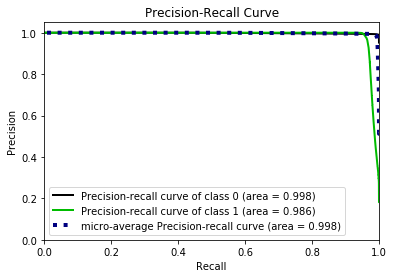

In [134]:
print_report('Test', comb_estimator, test_pool, y_test.label_is_attack, comb_estimator.predict(test_pool), plot_pr=True)

In [135]:
comb_estimator.save_model('final_model/Gradient_boost')

CatBoostError: (No such file or directory) util/system/file.cpp:857: can't open "final_model/Gradient_boost" with mode WrOnly|CreateAlways|Seq (0x00000034)

# 17. Most important features - Shape

Following is a set of features that will be respresnted using shape values plots and they will the most usefull predictors . based on catboost and grid search training and result 

In [ ]:
import shap

shap.initjs()

In [ ]:
shap_values = comb_estimator.get_feature_importance(test_pool, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

## 17.1. important features

In [ ]:
shap.summary_plot(shap_values, X_test)

SHAP analysis provides us with the features that have the highest influence on the predictions of the model:

1. `init_fwd_win_byts`: Number of bytes sent in initial window in the forward direction
2. `fwd_pkt_len_mean`: Mean size of packet in forward direction
3. `protocol`: Protocol
4. `init_bwd_win_byts`: Number of bytes sent in initial window in the backward direction
5. `fwd_seg_size_min`: Minimum segment size observed in the forward direction

## 18. Conclusion

Even though the performance of the combined estimator is compelling it can be assumed that the estimator will not generalize well to different network environments because of the observed differences in distributions. as the first dataset collected in AWS cloud environment where cicids2017 in normal LAN environment .


In order to cope with this problem the following suggestions are proposed:
* an estimator has to be trained with more varied attack data originating from different network environments

* an estimator has to be trained with data originating from the network environment it will be deployed in. such as cloud in the case of the cicids-2018 dataset



It is very difficult to obtain real-world network attack datasets of high quality , hence the seconed option seems to be more promising.

The fact that data has to be collected in the target environment can be alleviated by only collecting benign network traffic and using an anomaly detection approach to detect network attacks.which we are going to use in the next phase using nearual network and one class classifcation mahcine learning algorithms .